In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
import torch
import torch.nn as nn
from timm.models.layers import DropPath, to_2tuple, trunc_normal_

In [3]:
pip install timm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.8/53.8 kB 5.5 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.

In [5]:
from PIL import Image
import torch
import torchvision.transforms as transforms
import matplotlib.pyplot as plt



image_path = '/content/drive/MyDrive/dataset/train/Common Lanthana/Common_Lanthana100_jpg.rf.ffd6edb67b75fc6eb2dce4fc23d72a42.jpg'
image = Image.open(image_path).convert('RGB')



transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])


tensor_image = transform(image)

tensor_image = tensor_image.unsqueeze(0)

print("Tensor shape:", tensor_image.shape)
print("Tensor data type:", tensor_image.dtype)

tensor_image = tensor_image.permute(0, 2, 3, 1)

Tensor shape: torch.Size([1, 3, 224, 224])
Tensor data type: torch.float32


In [6]:
def window_partition(x, patch_size=4):
    """
    Args:
        x: (B, H, W, C)
        patch_size (int): patch size (Default: 4)

    Returns:
        patches: (num_patches * B, patch_size, patch_size, C)
                 (num_windows * B, patch_size, patch_size, C)
    """

    B, H, W, C = x.shape

    num_patches_h = H // patch_size
    num_patches_w = W // patch_size

    x = x.view(B, num_patches_h, patch_size, num_patches_w, patch_size, C)

    patches = x.permute(0, 1, 3, 2, 4, 5).contiguous()

    patches = patches.view(-1, patch_size, patch_size, C)

    return patches

Windows shape: torch.Size([3136, 4, 4, 3])
num_patches  3136


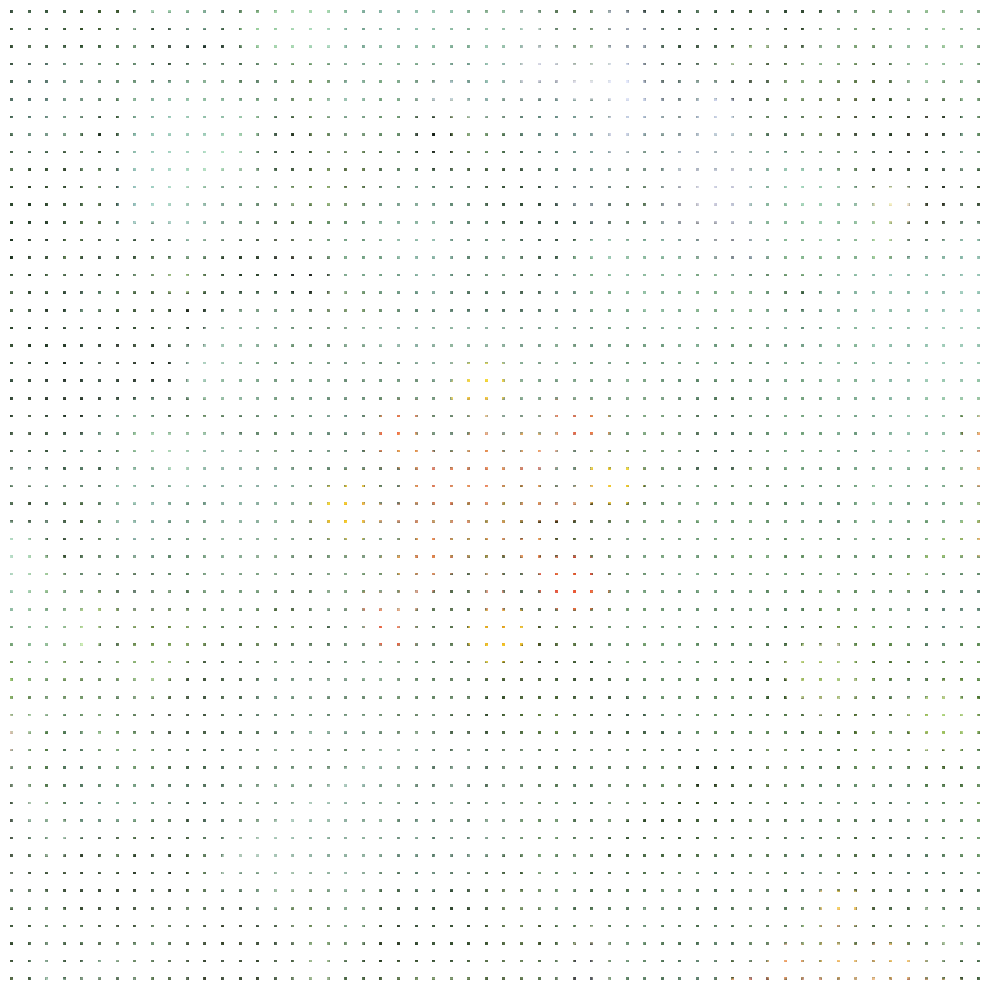

In [7]:
window_size = 4
windows = window_partition(tensor_image, window_size)

num_patches, patch_size, _, _ = windows.shape

print("Windows shape:", windows.shape)

print("num_patches ",num_patches)

num_rows = int(num_patches ** 0.5)
num_cols = num_patches // num_rows

fig, axs = plt.subplots(num_rows, num_cols, figsize=(10, 10))

for i, ax in enumerate(axs.flat):
    patch = windows[i].numpy()
    ax.imshow(patch)
    ax.axis("off")

plt.tight_layout()

plt.show()

Total number of windows: 3136


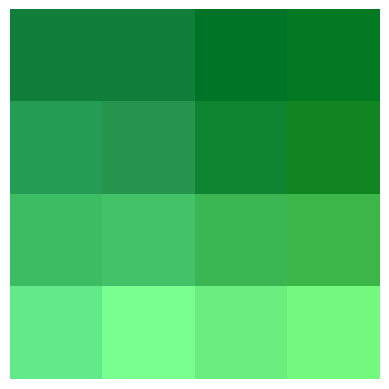

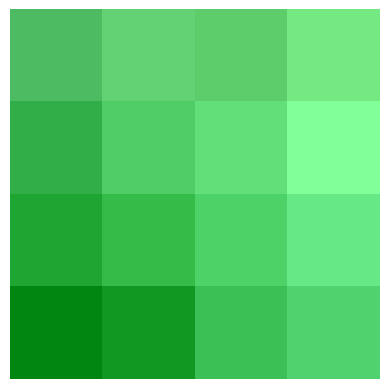

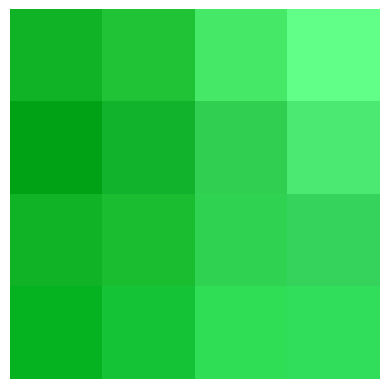

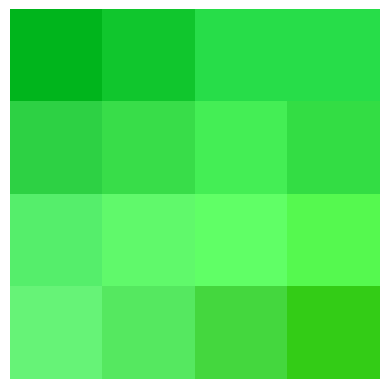

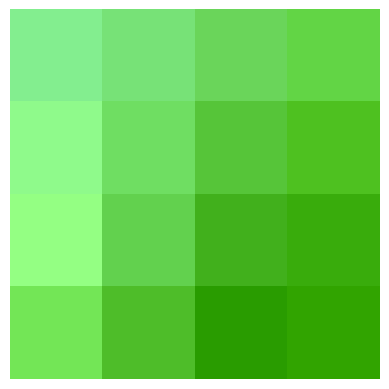

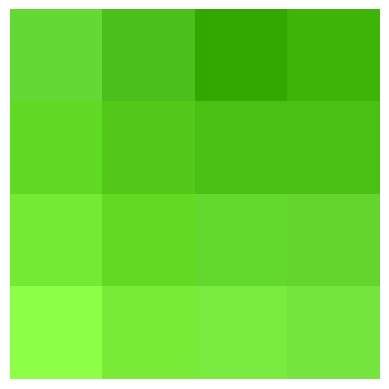

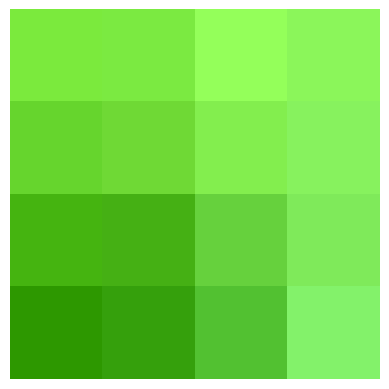

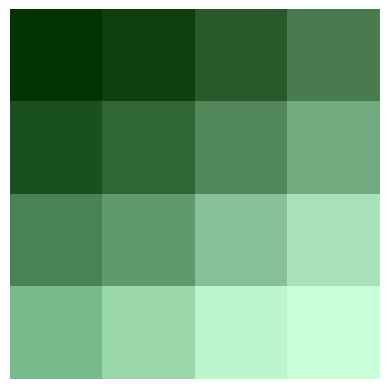

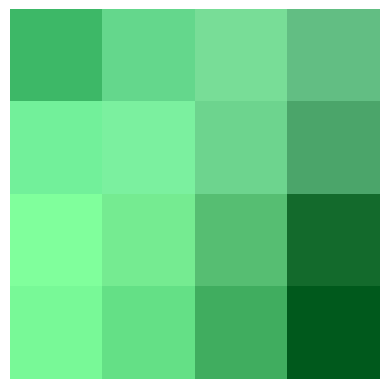

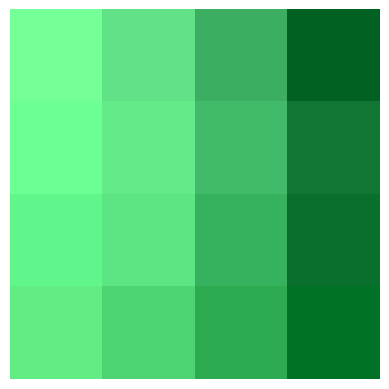

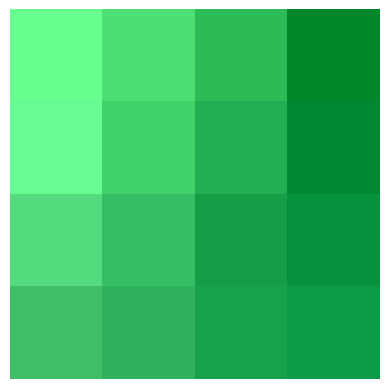

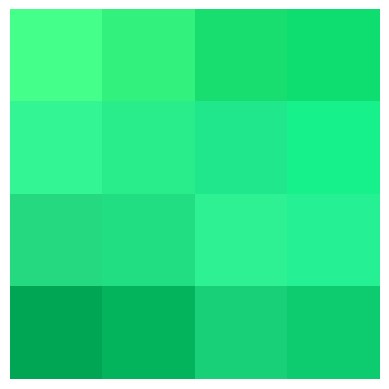

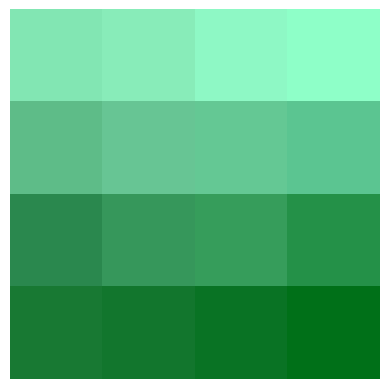

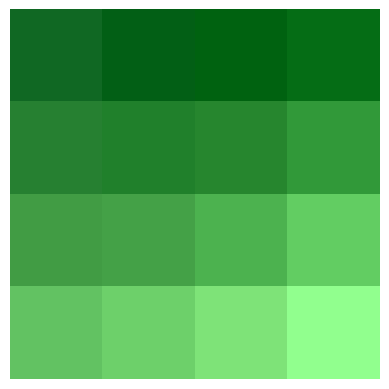

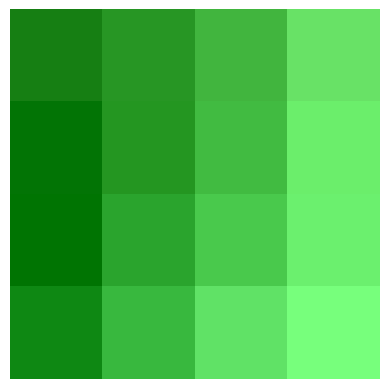

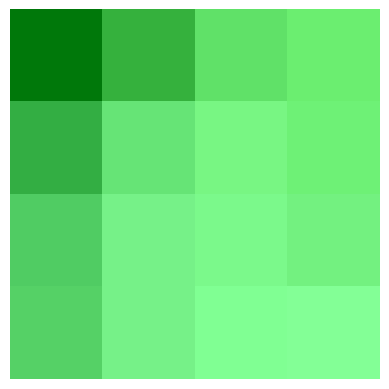

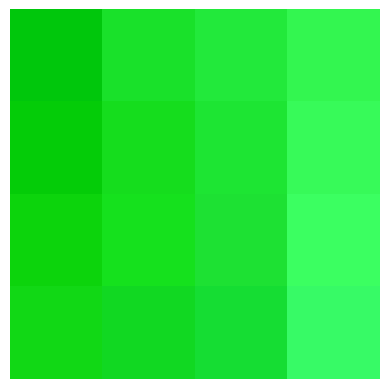

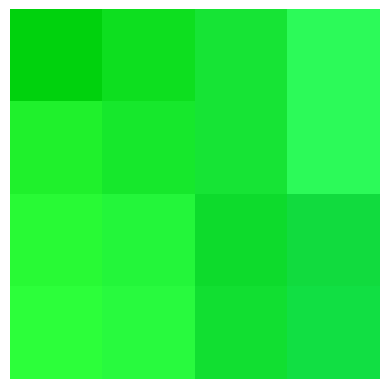

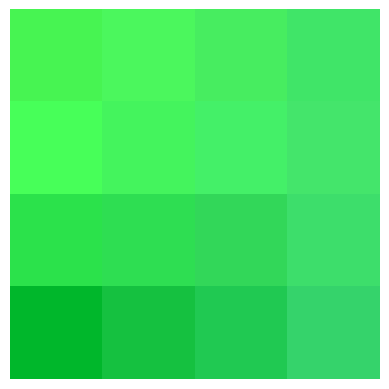

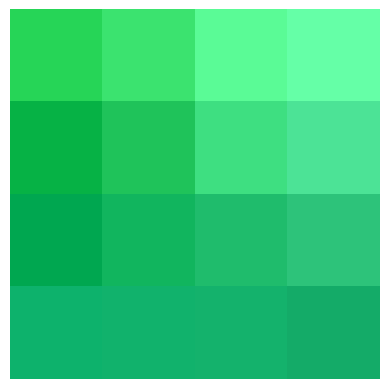

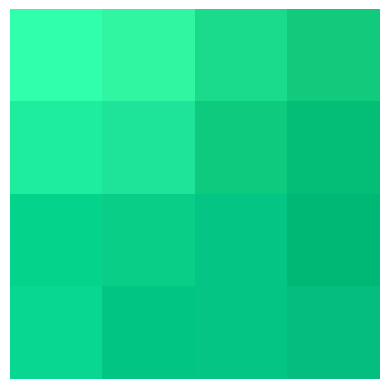

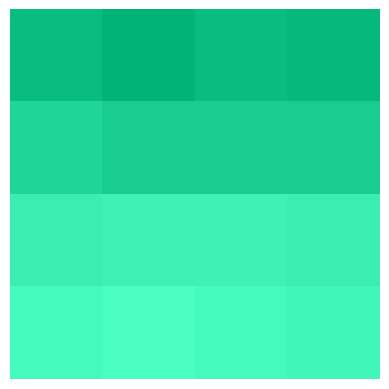

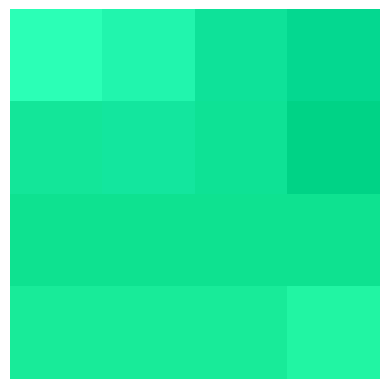

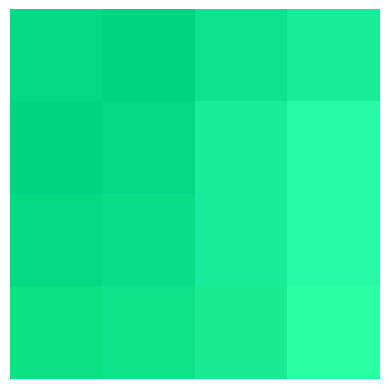

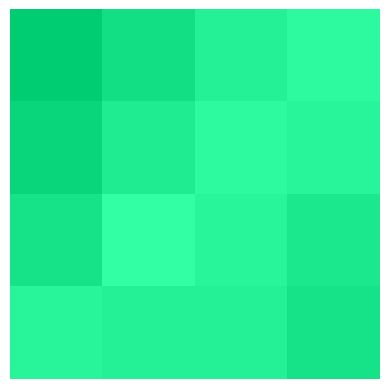

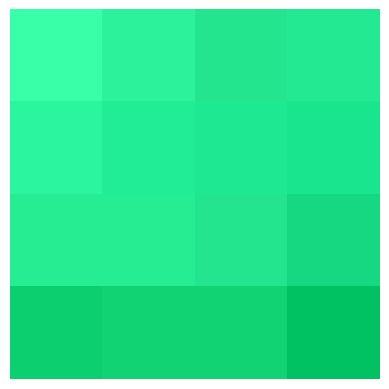

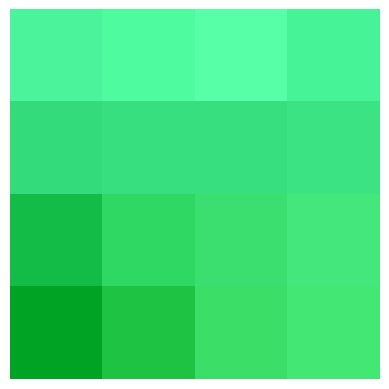

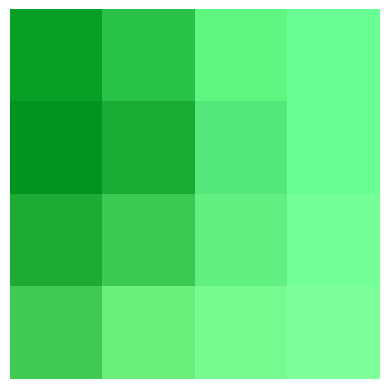

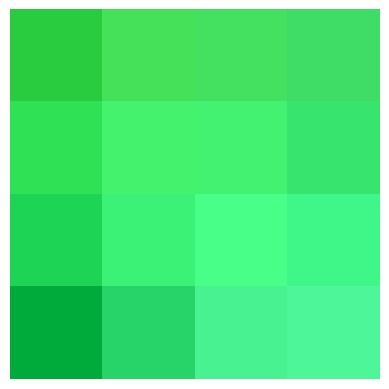

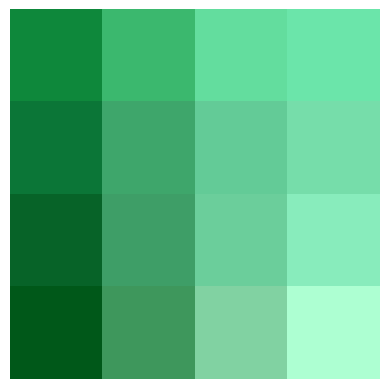

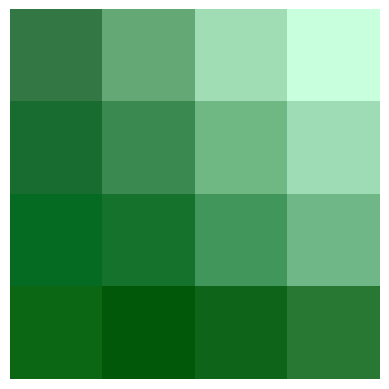

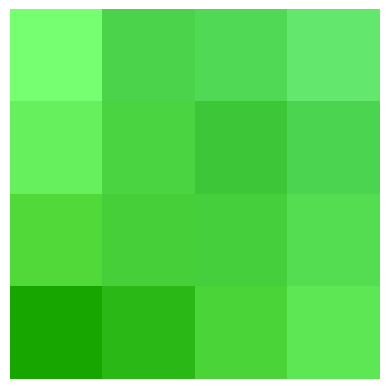

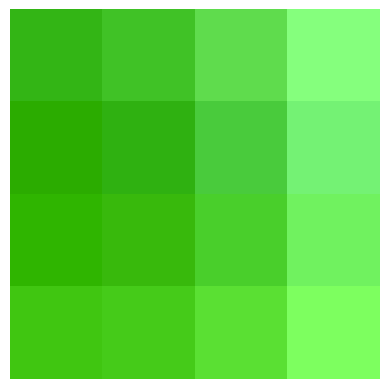

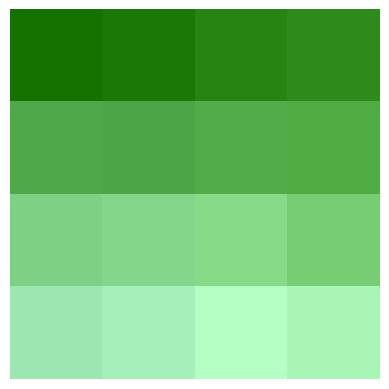

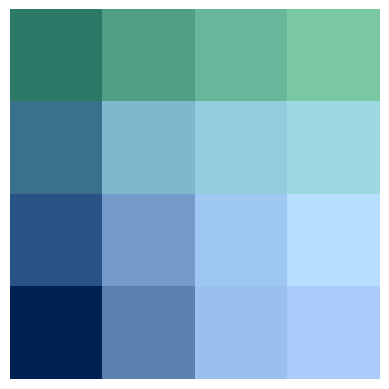

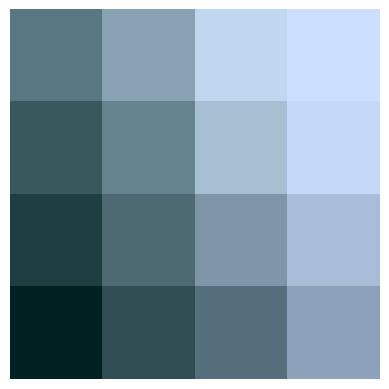

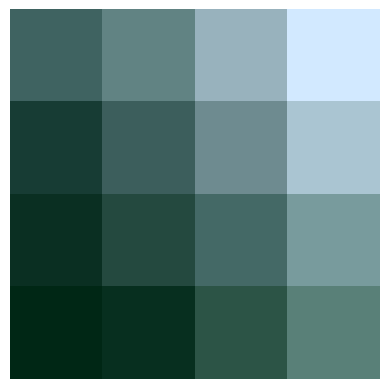

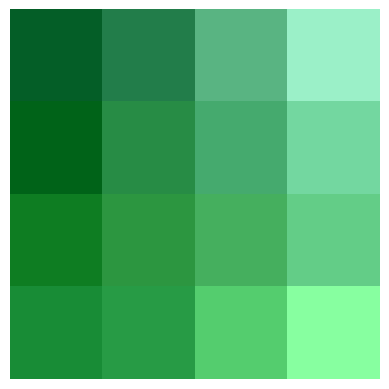

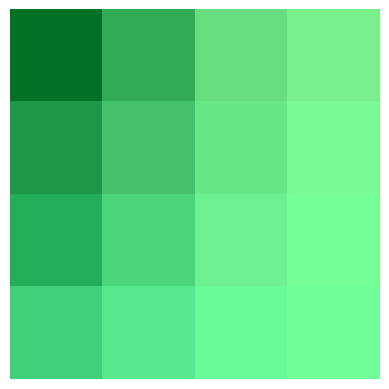

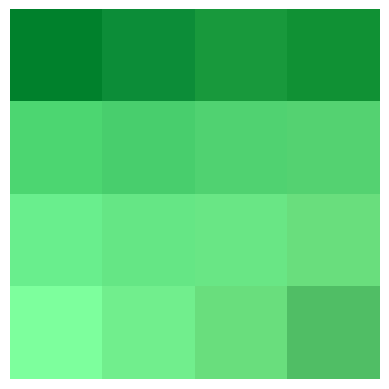

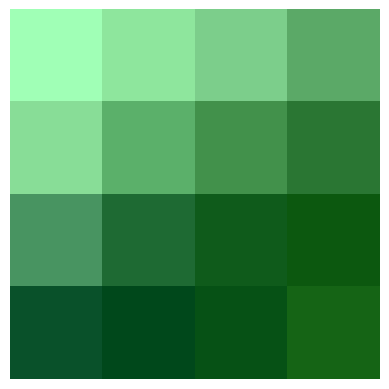

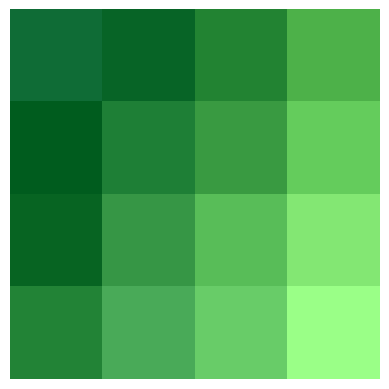

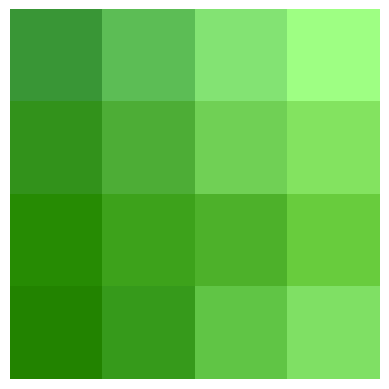

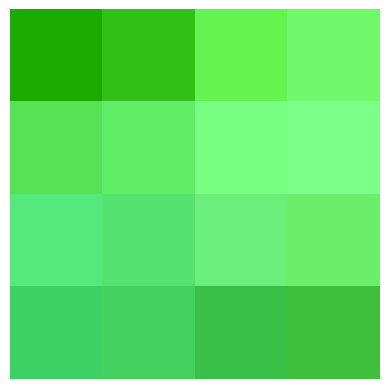

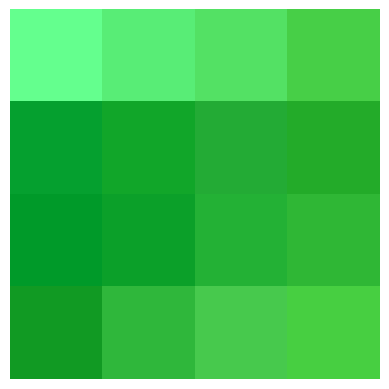

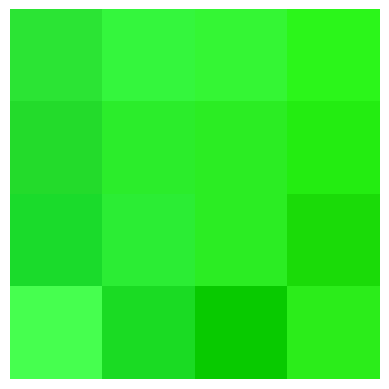

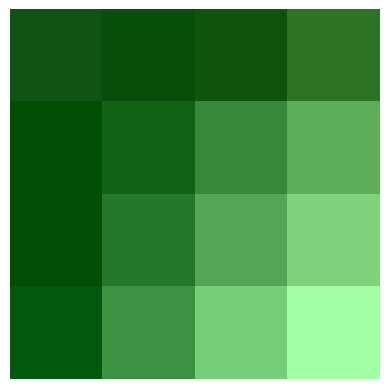

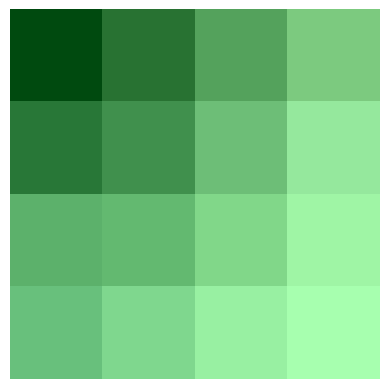

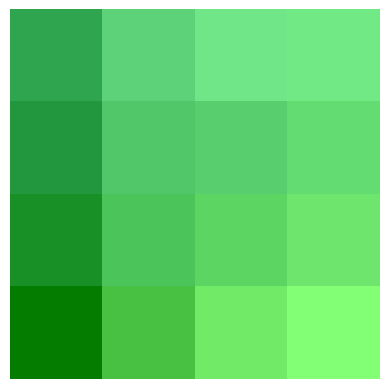

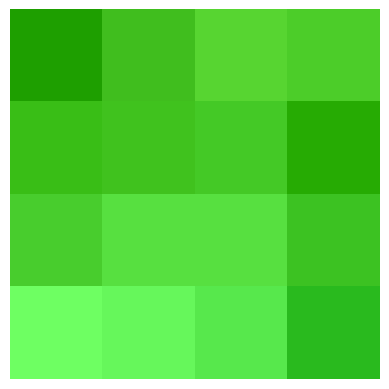

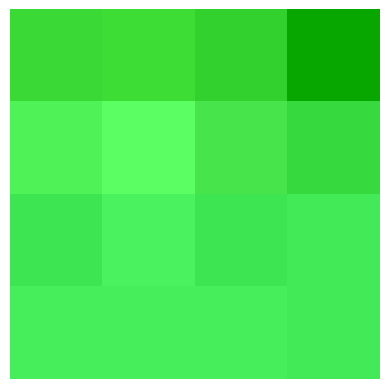

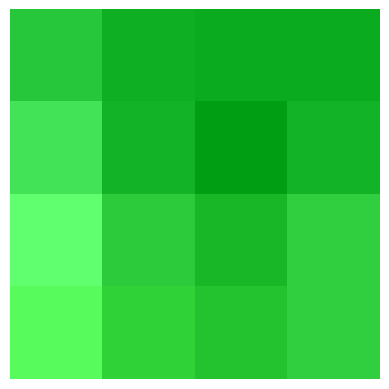

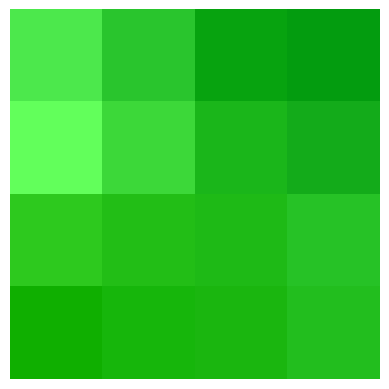

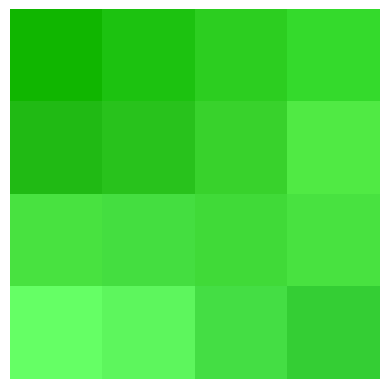

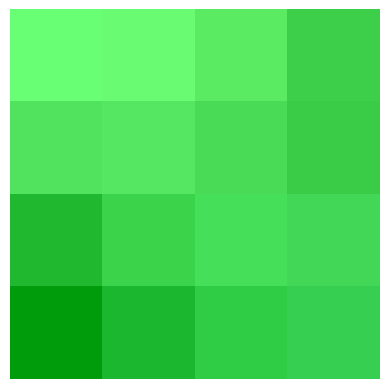

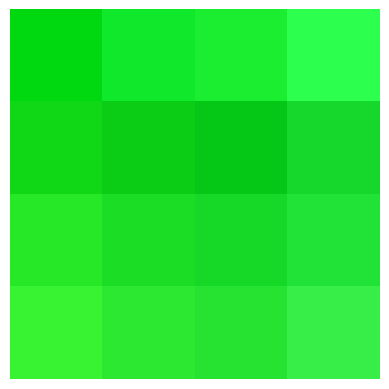

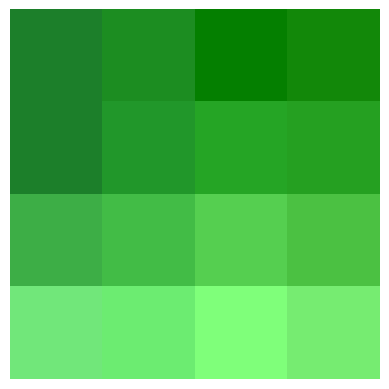

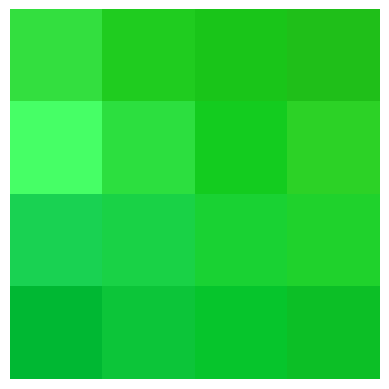

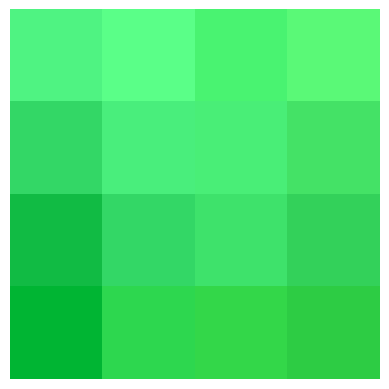

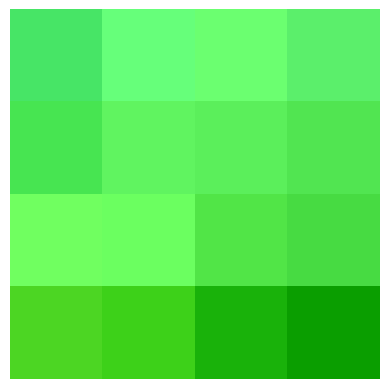

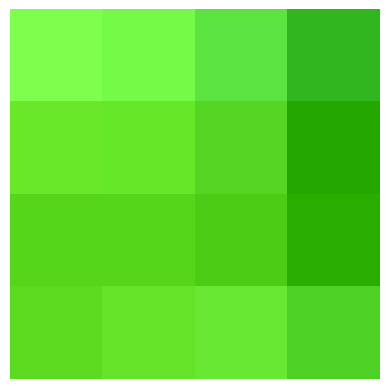

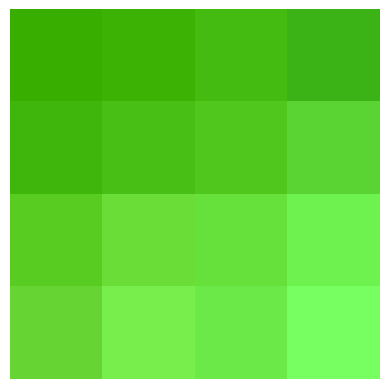

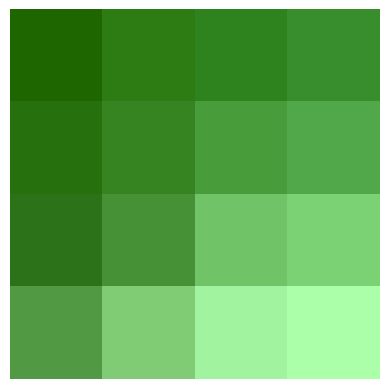

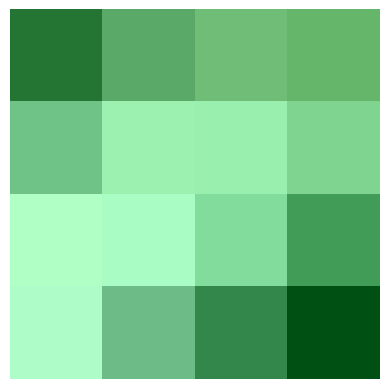

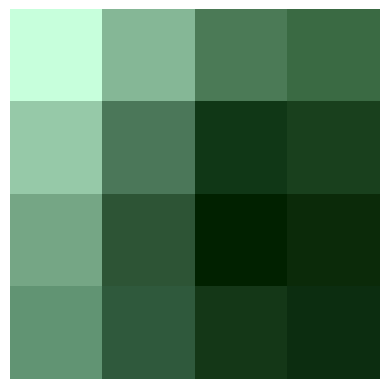

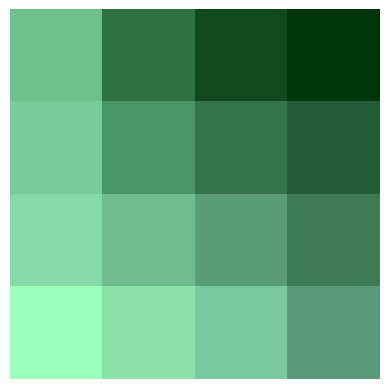

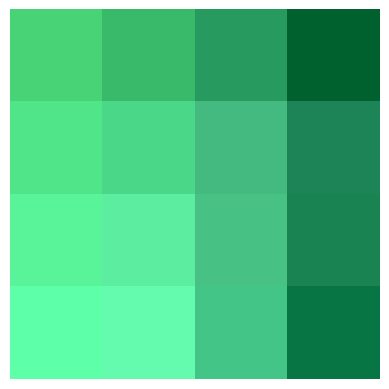

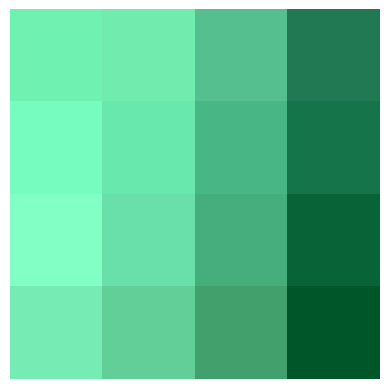

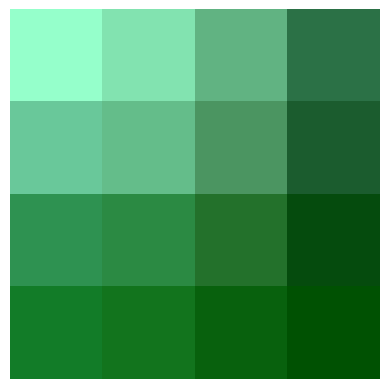

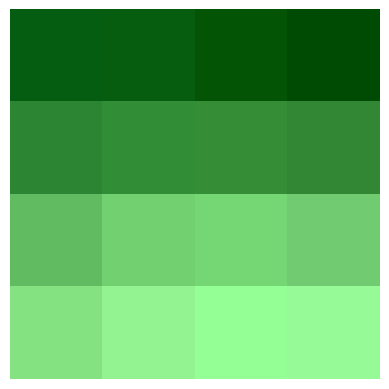

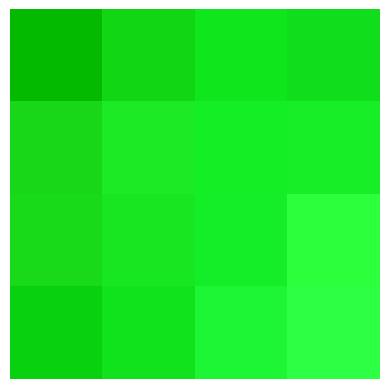

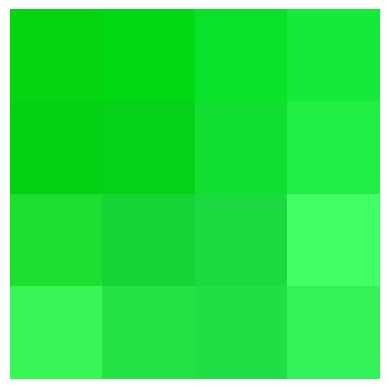

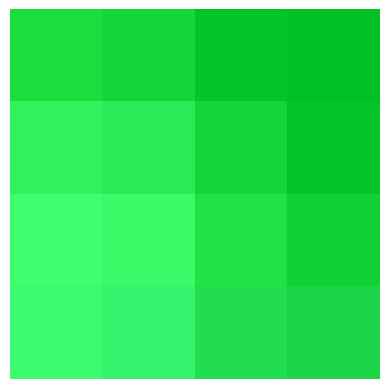

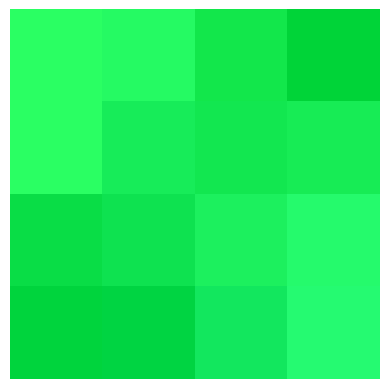

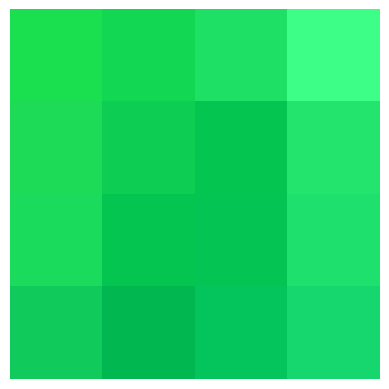

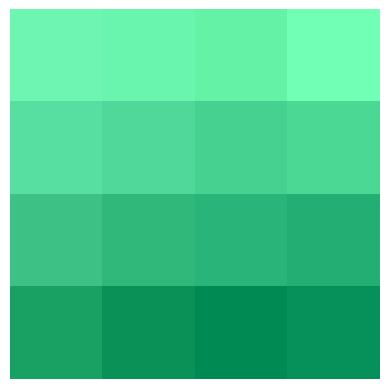

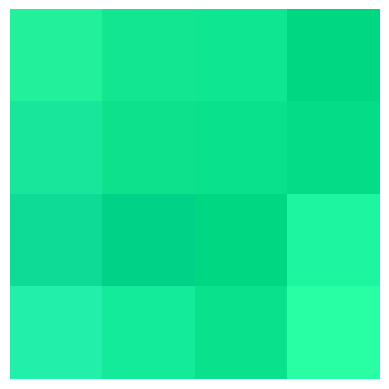

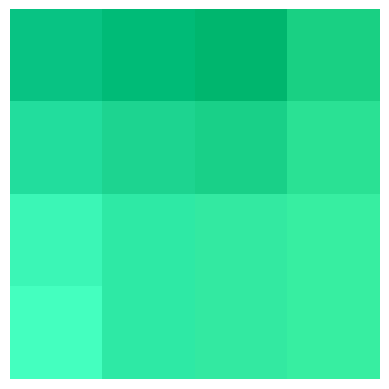

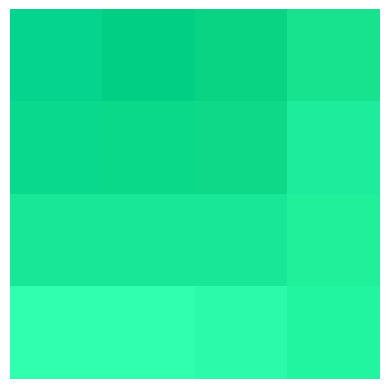

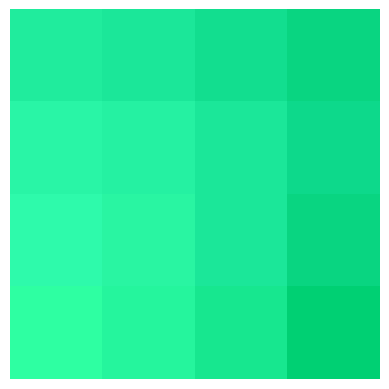

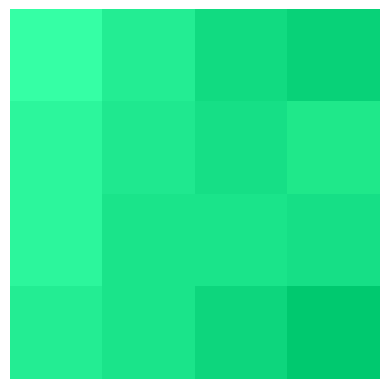

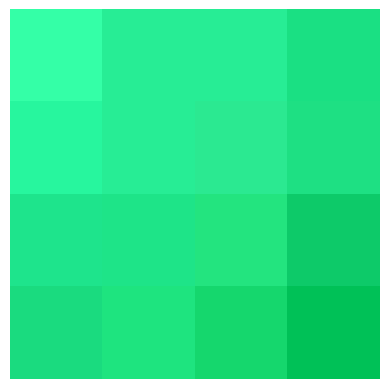

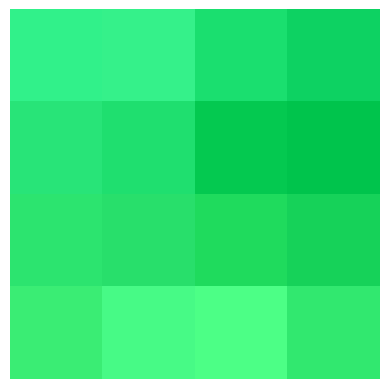

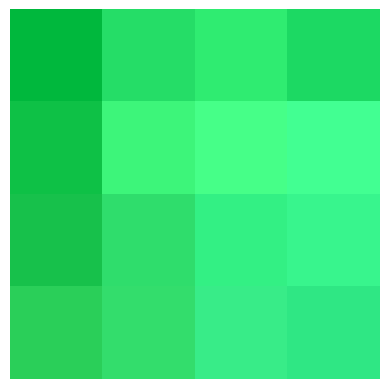

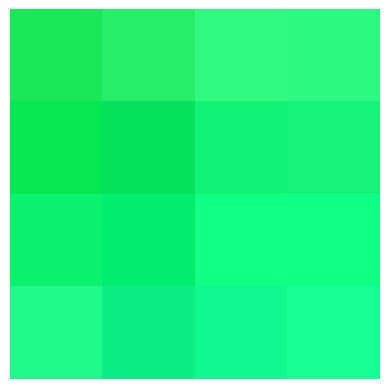

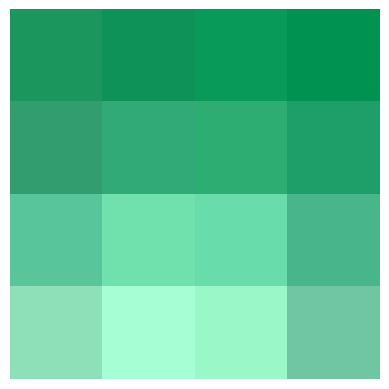

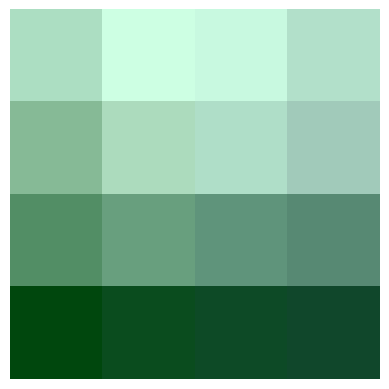

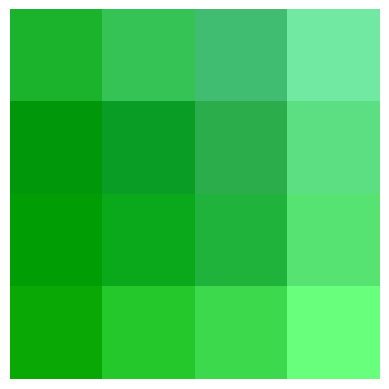

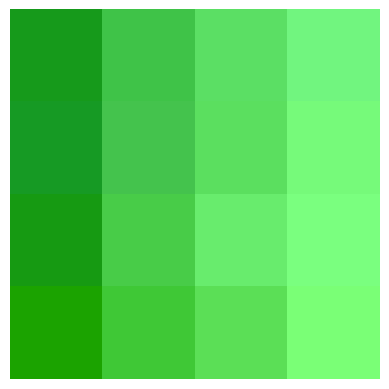

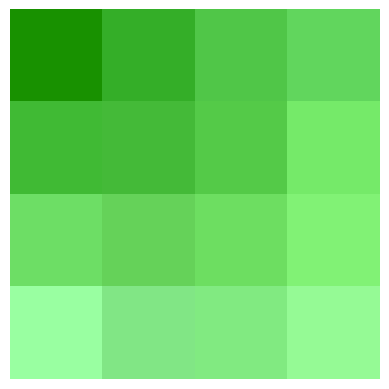

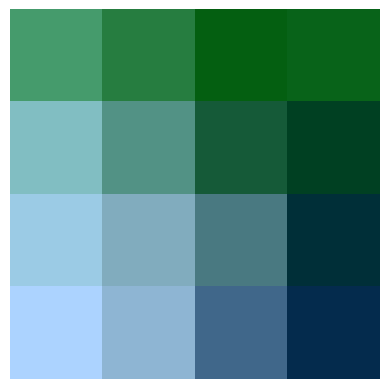

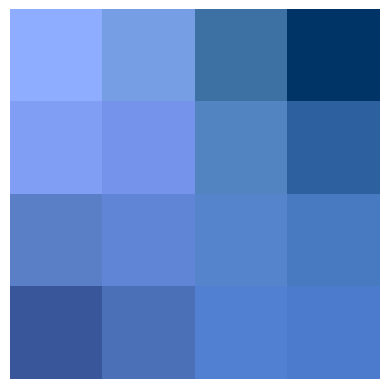

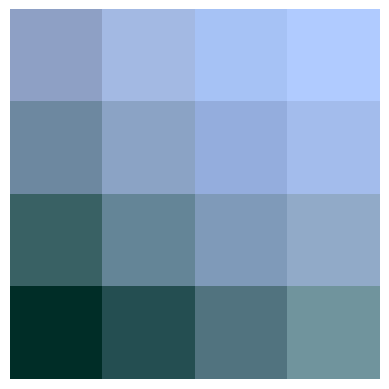

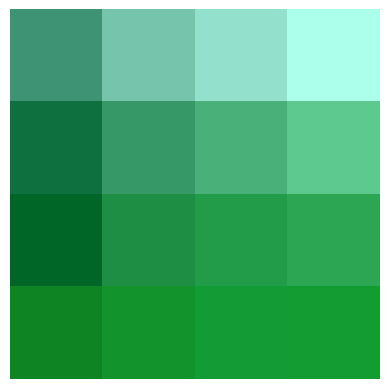

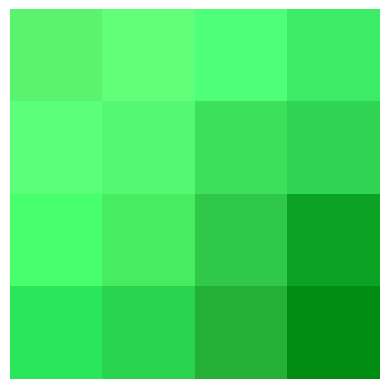

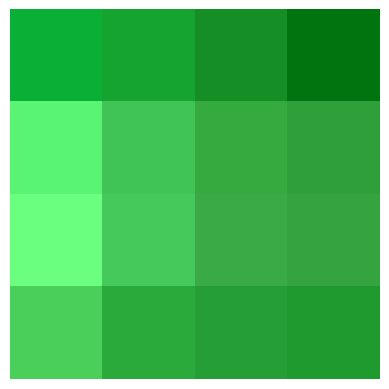

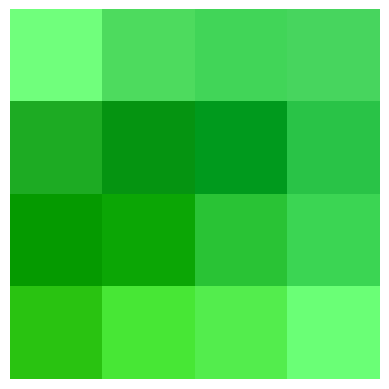

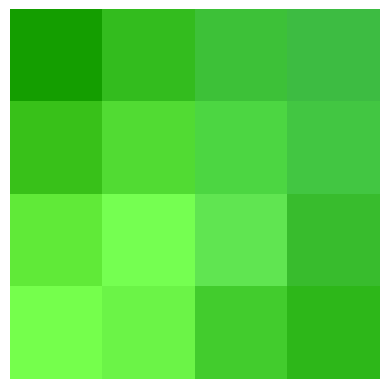

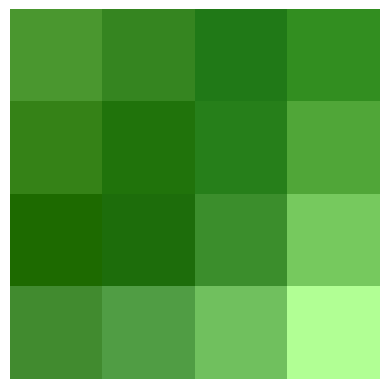

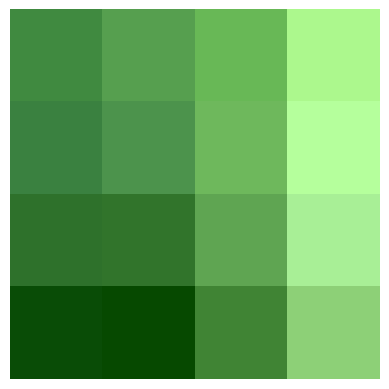

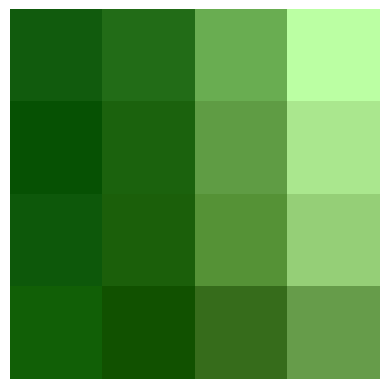

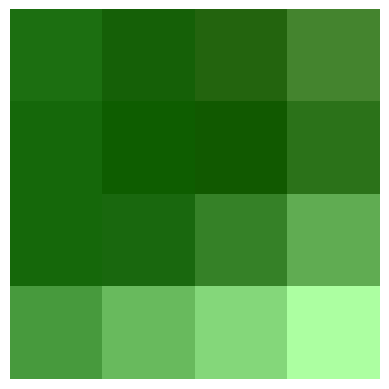

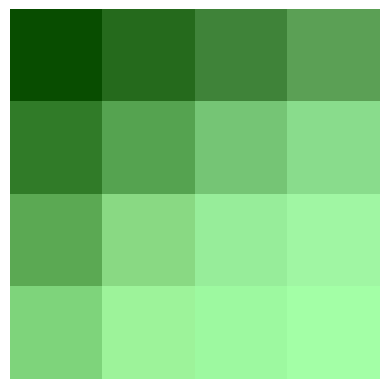

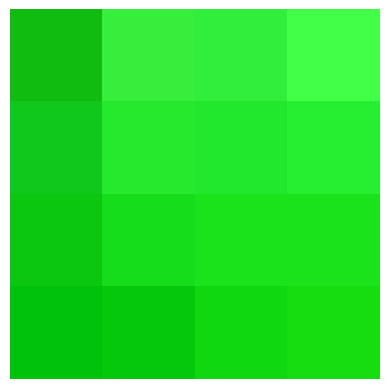

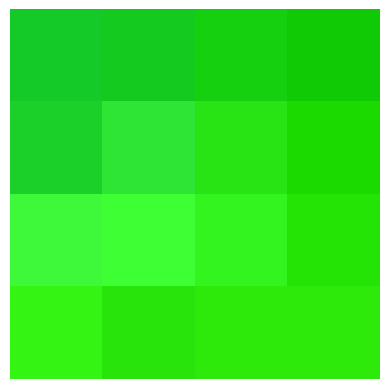

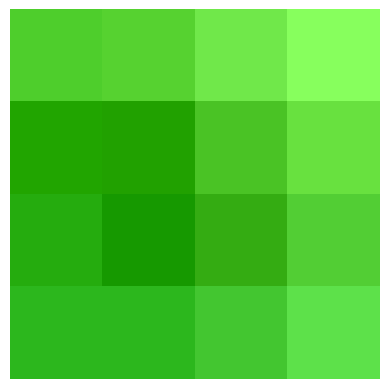

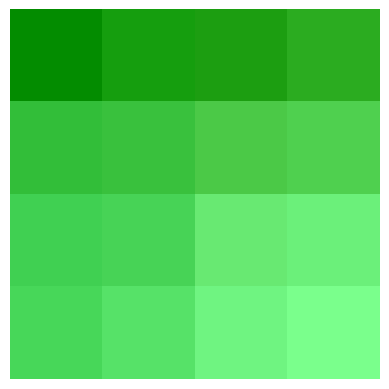

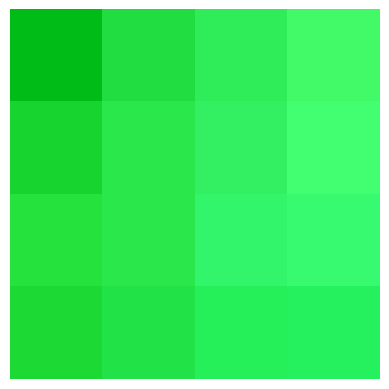

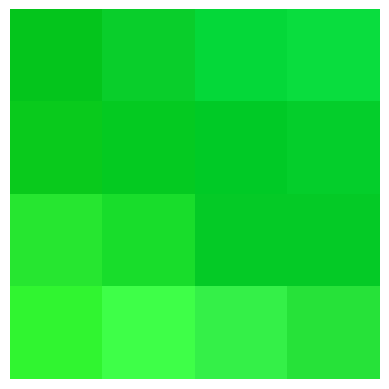

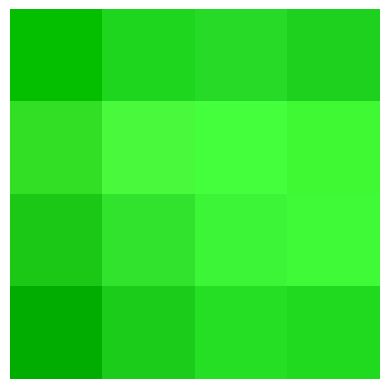

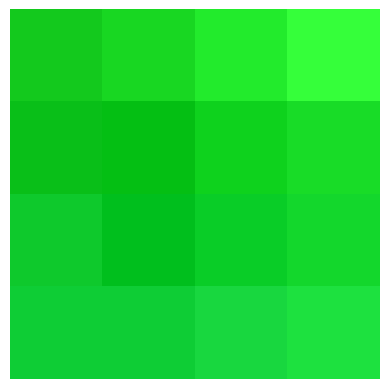

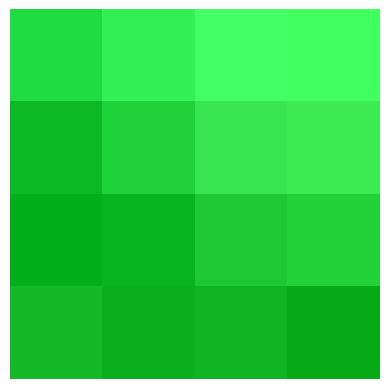

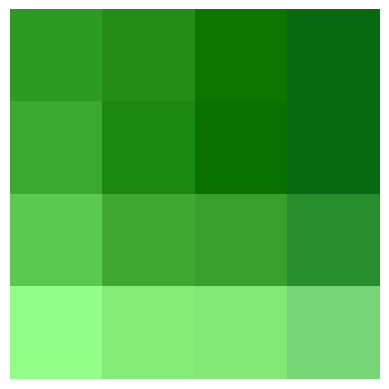

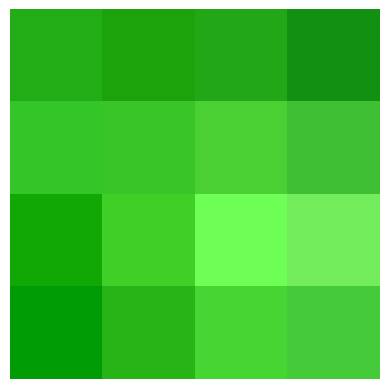

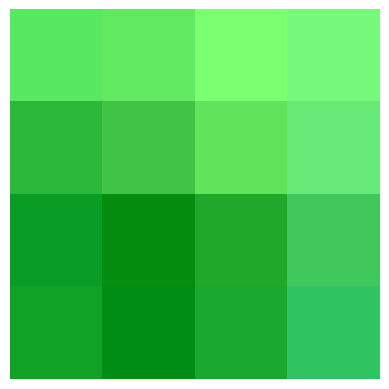

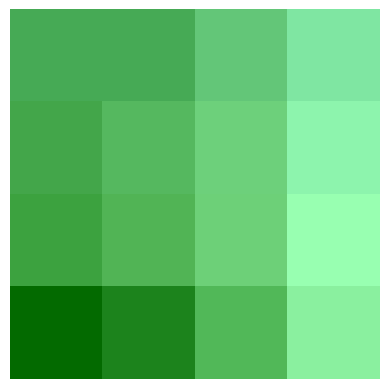

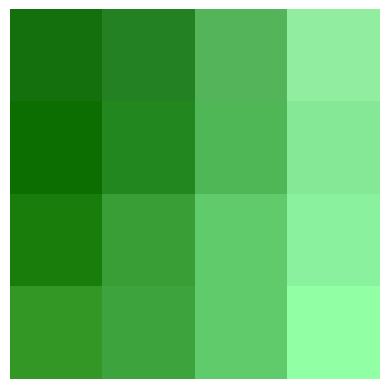

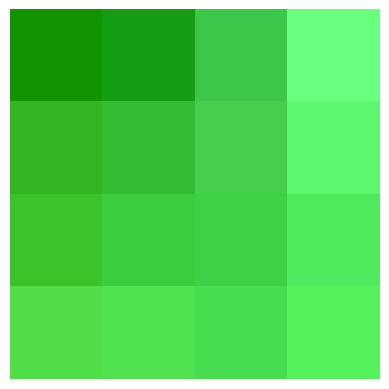

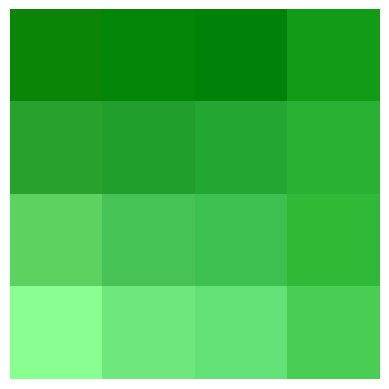

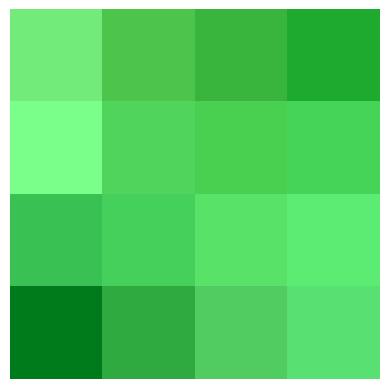

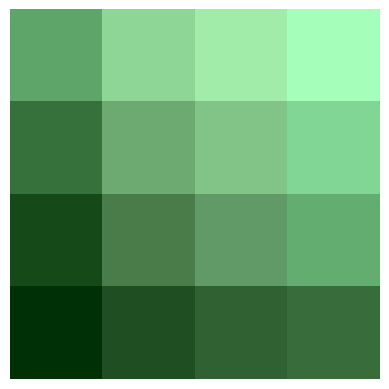

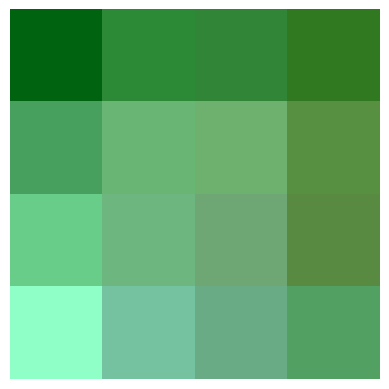

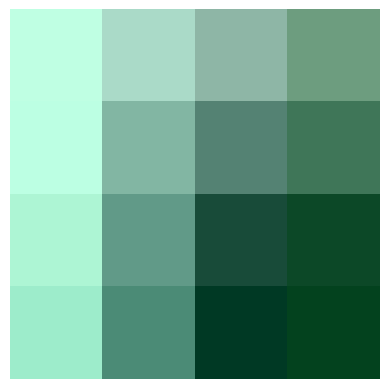

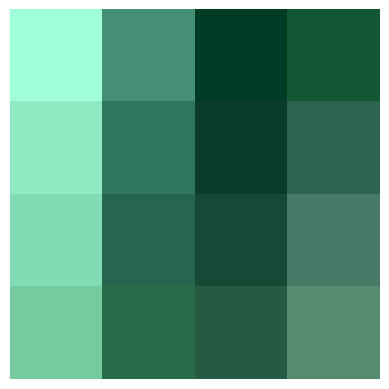

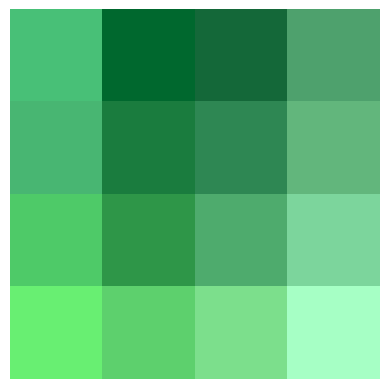

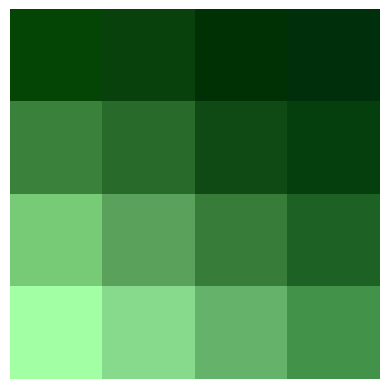

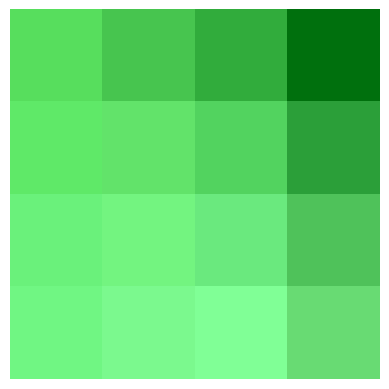

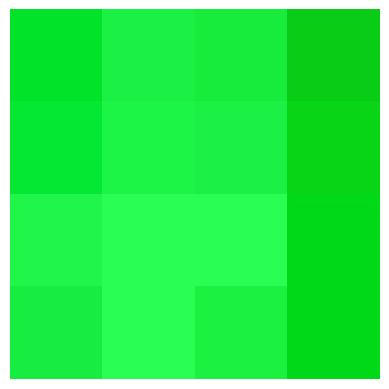

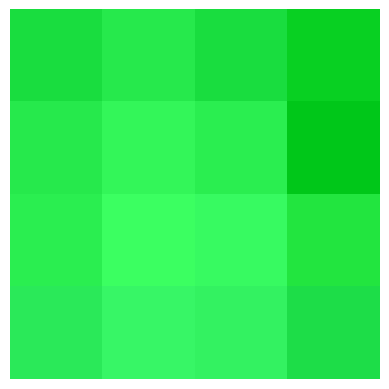

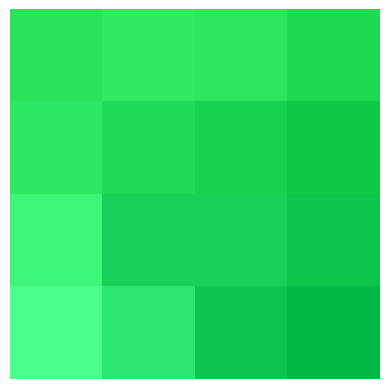

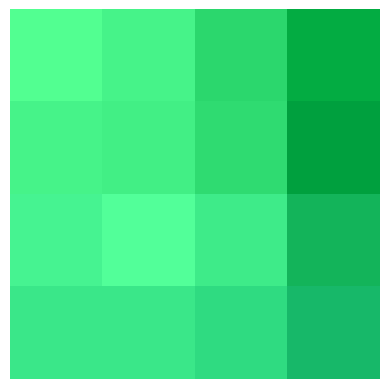

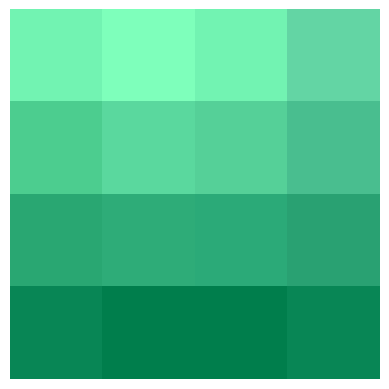

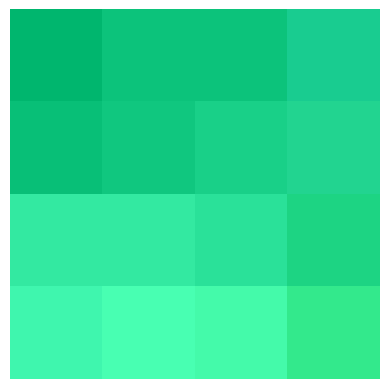

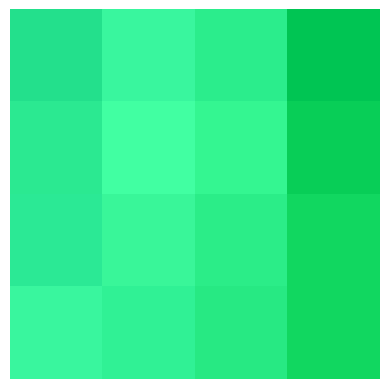

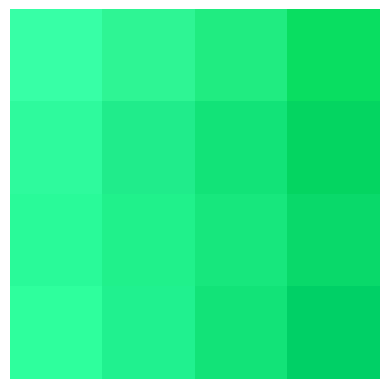

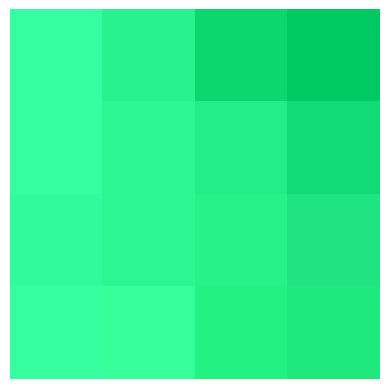

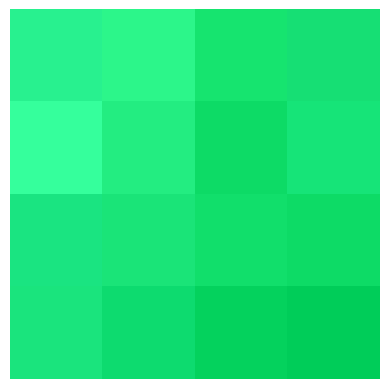

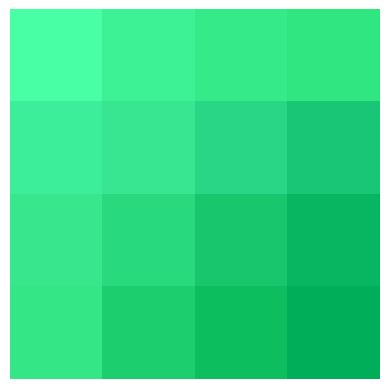

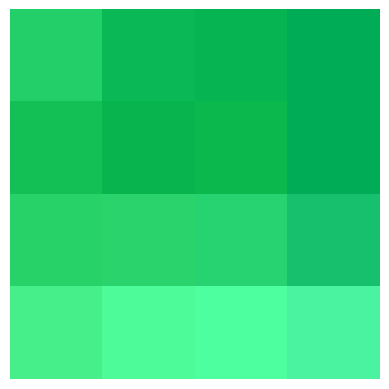

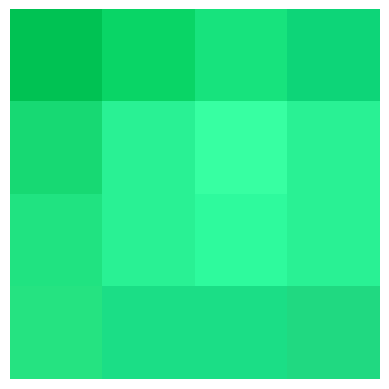

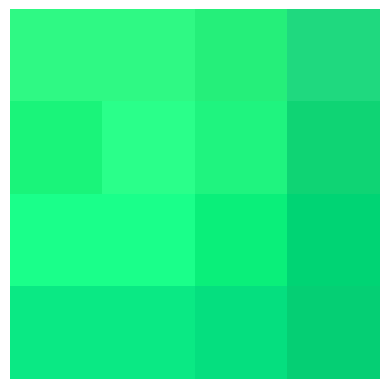

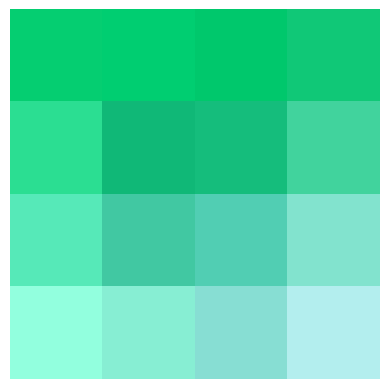

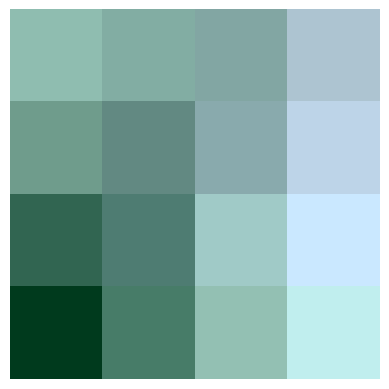

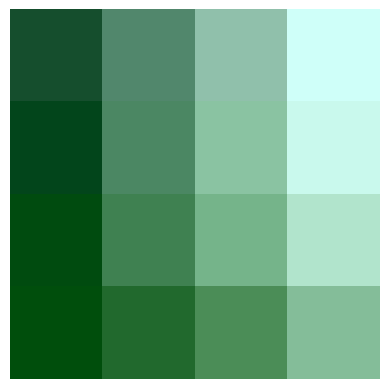

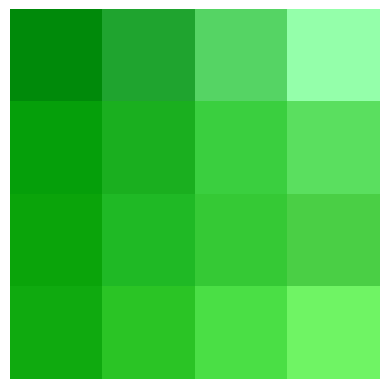

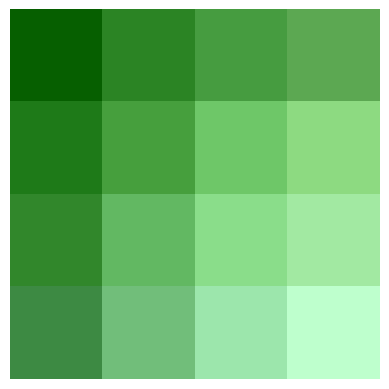

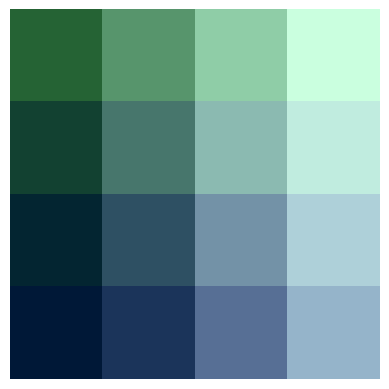

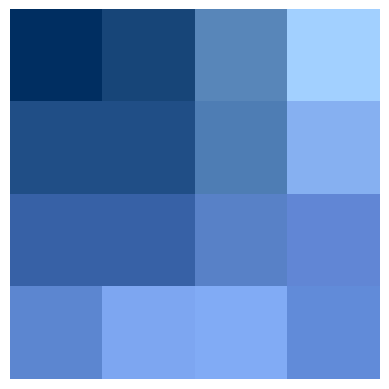

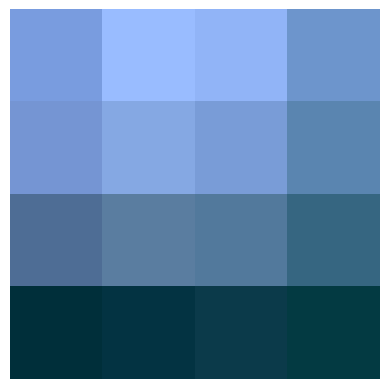

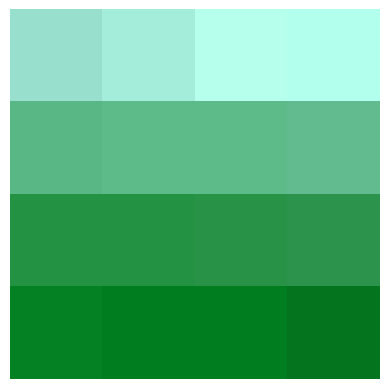

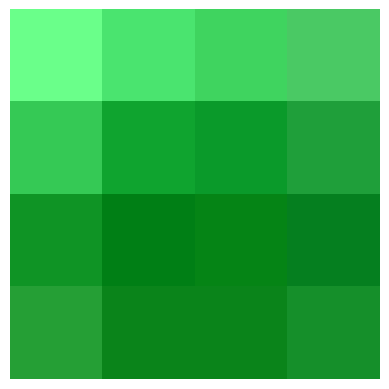

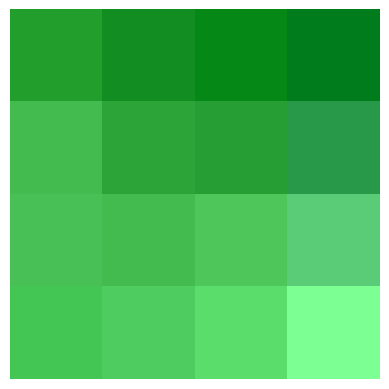

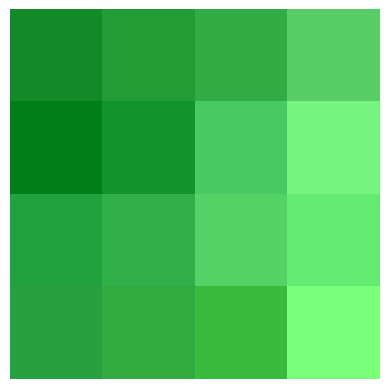

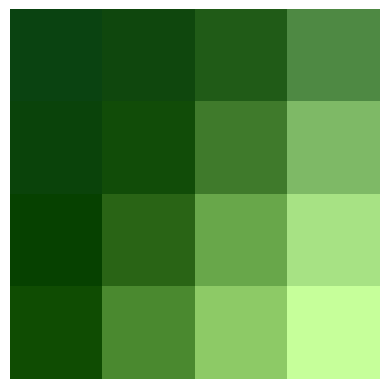

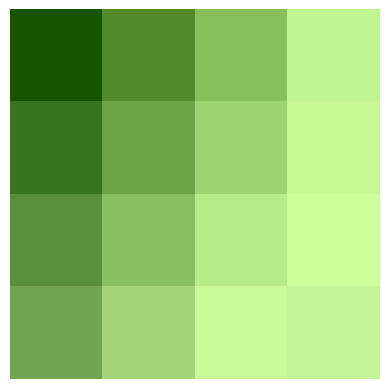

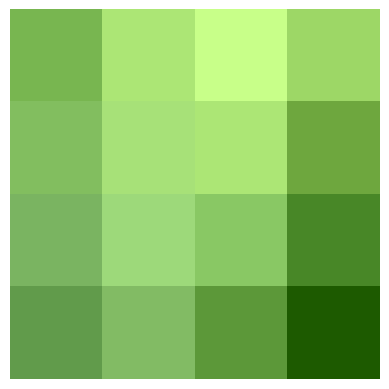

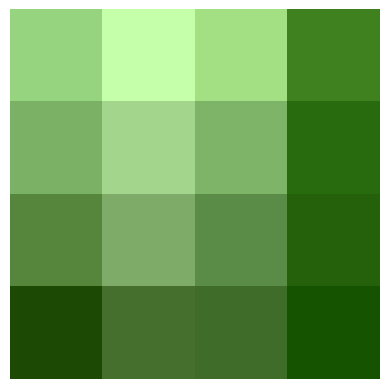

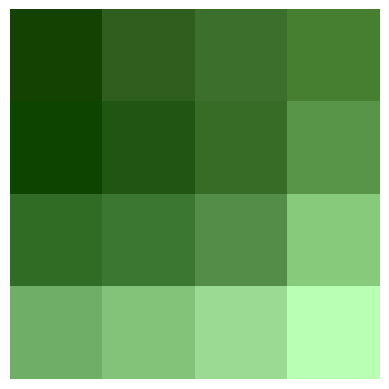

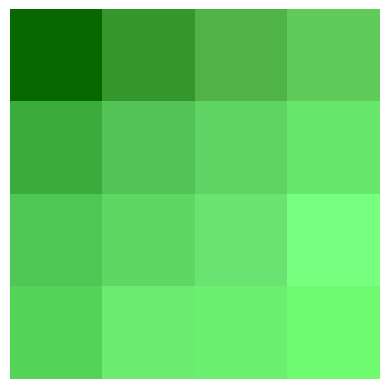

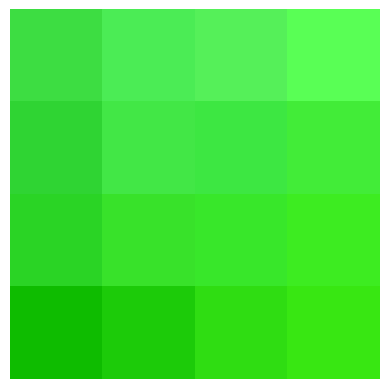

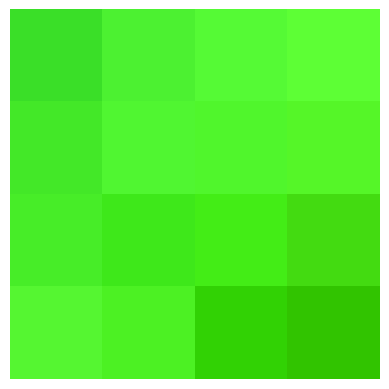

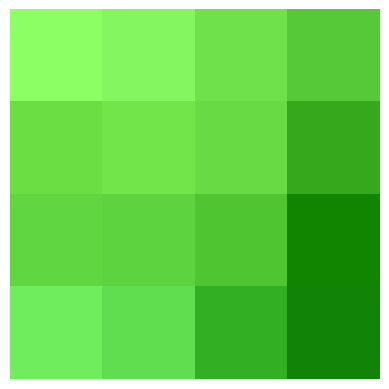

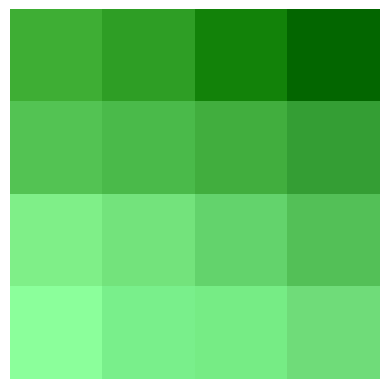

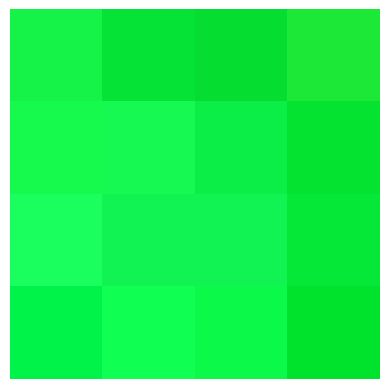

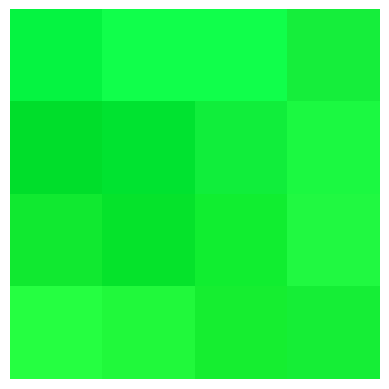

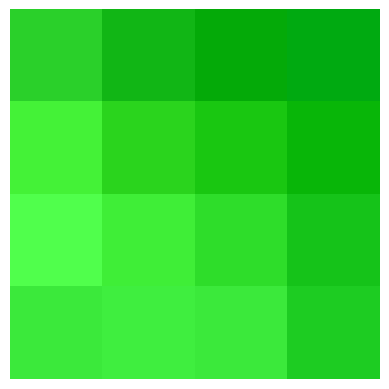

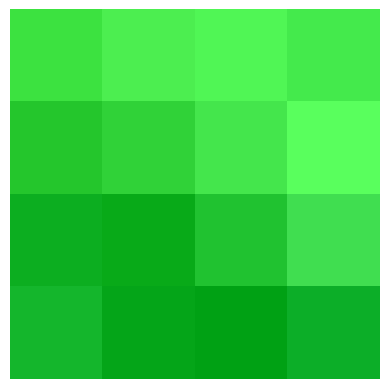

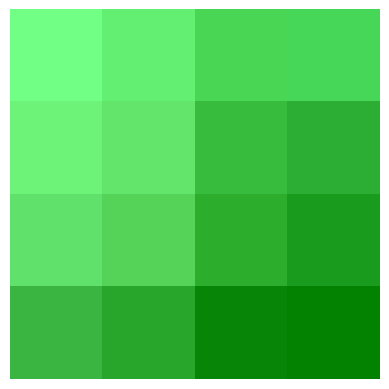

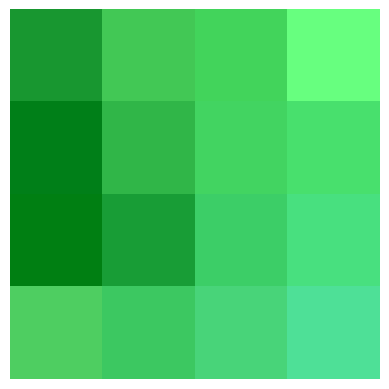

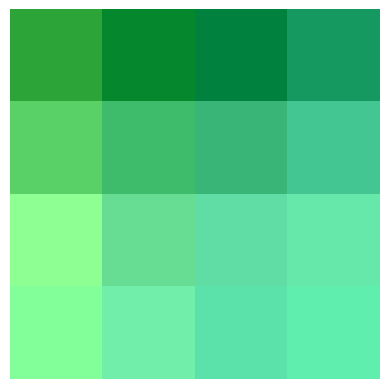

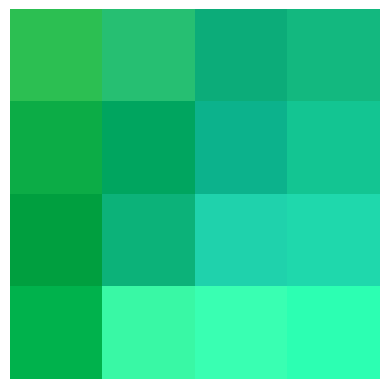

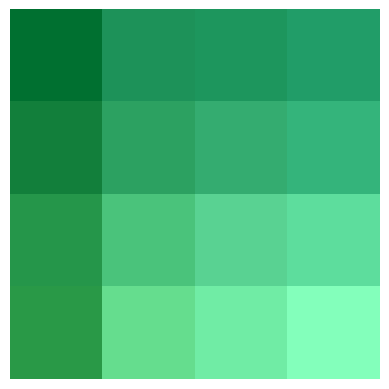

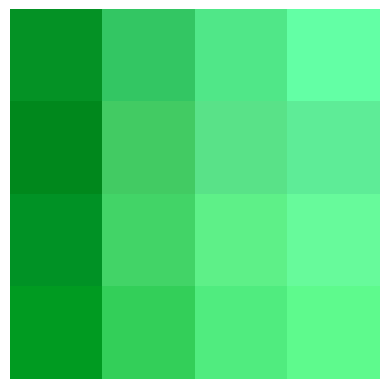

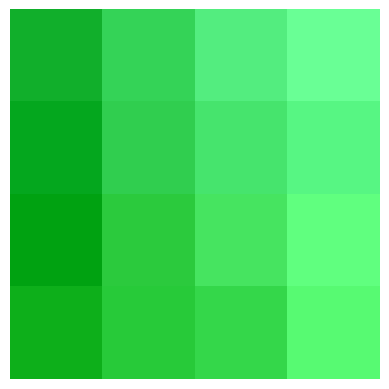

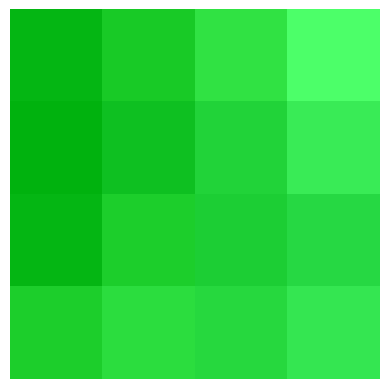

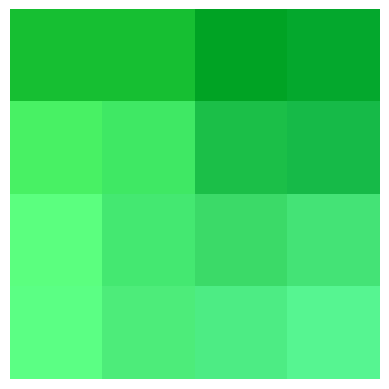

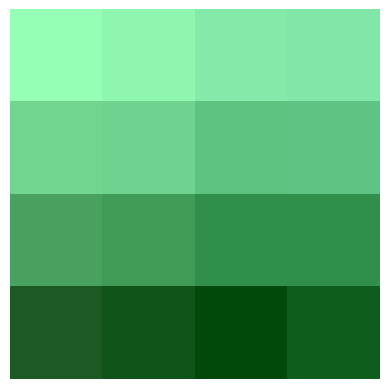

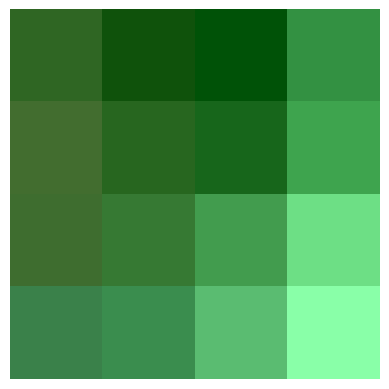

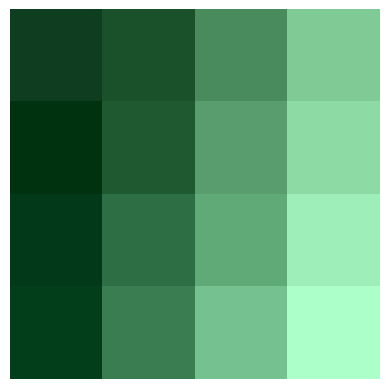

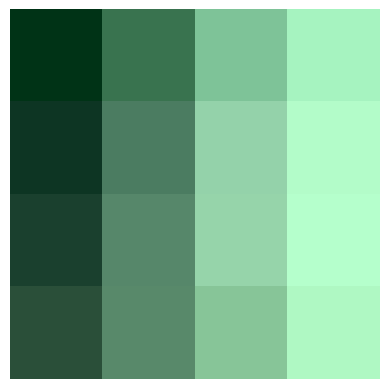

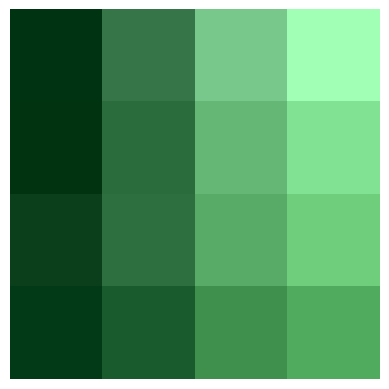

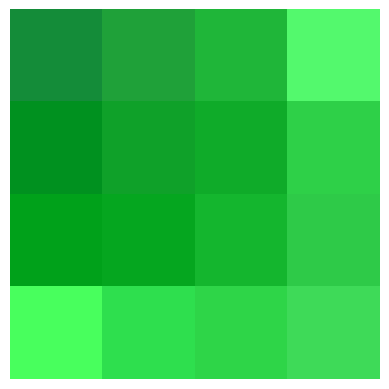

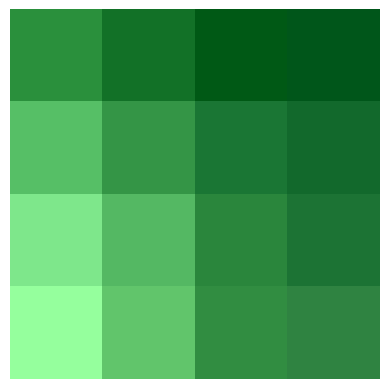

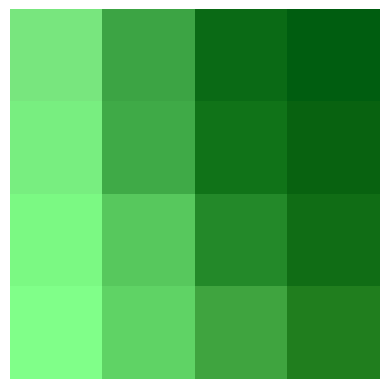

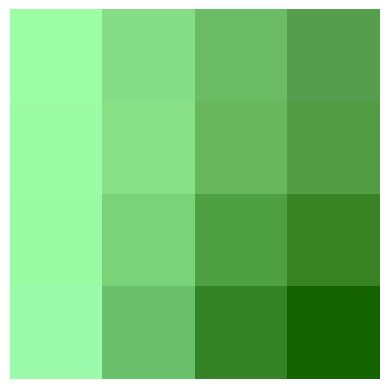

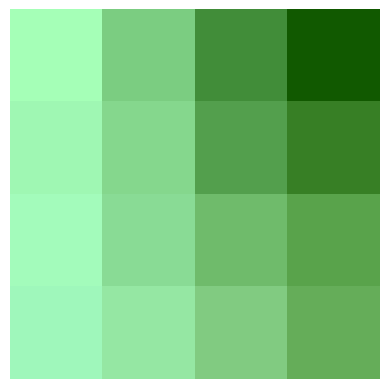

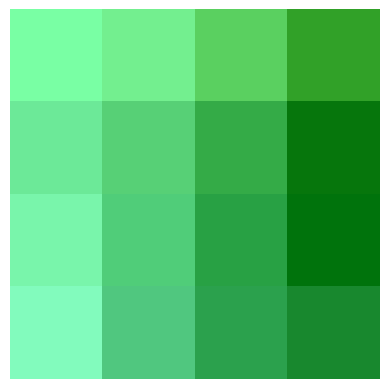

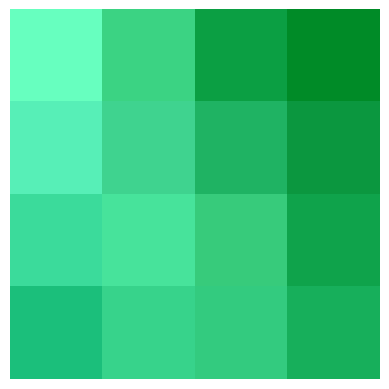

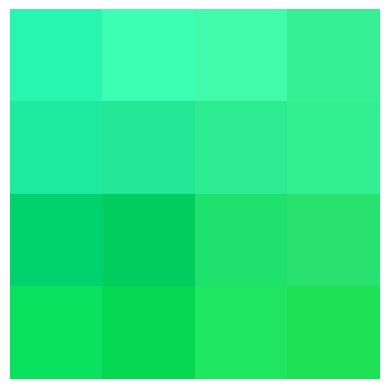

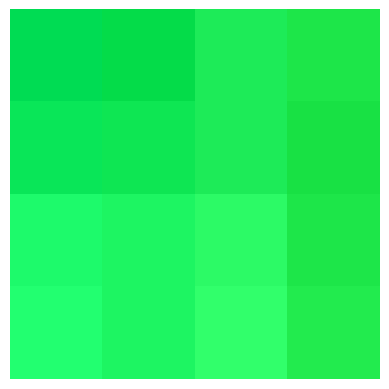

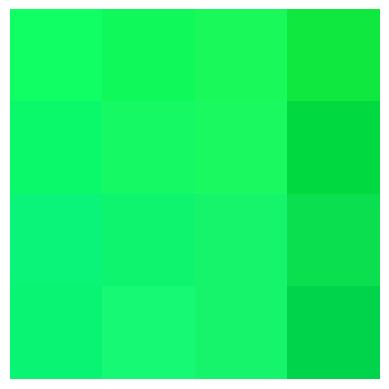

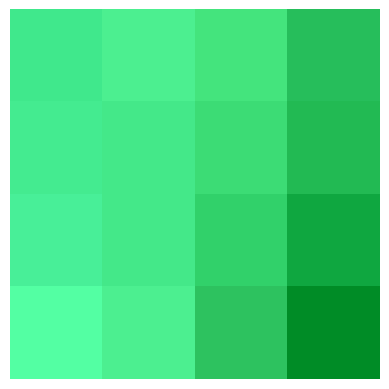

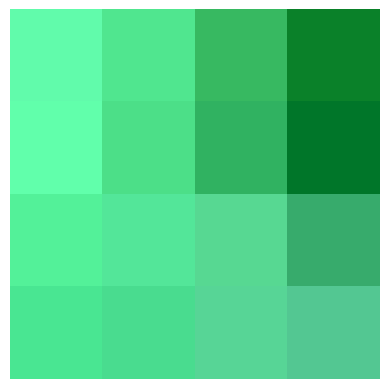

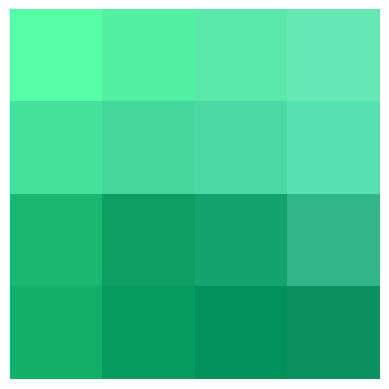

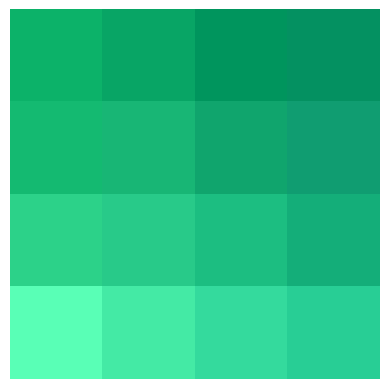

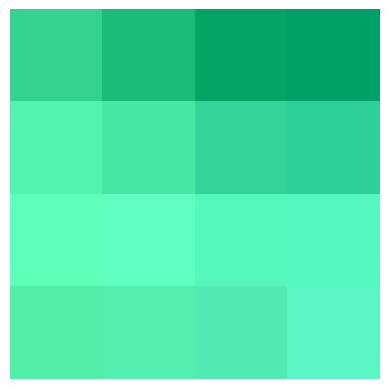

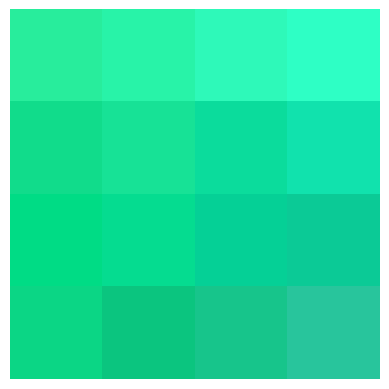

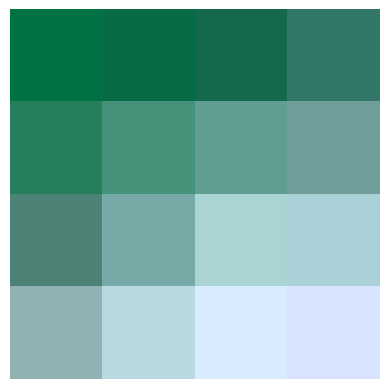

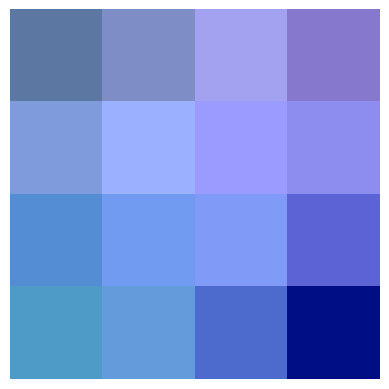

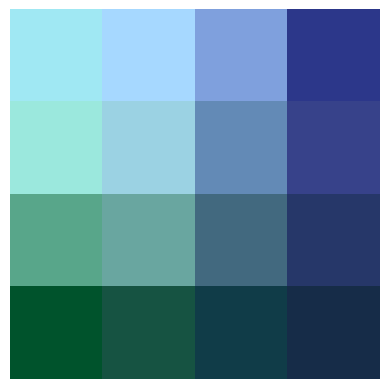

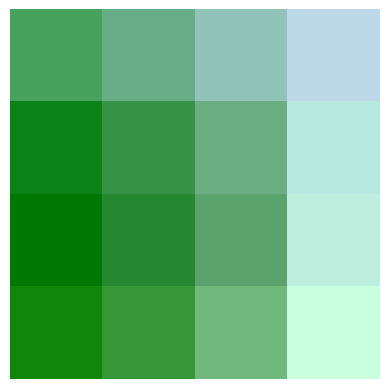

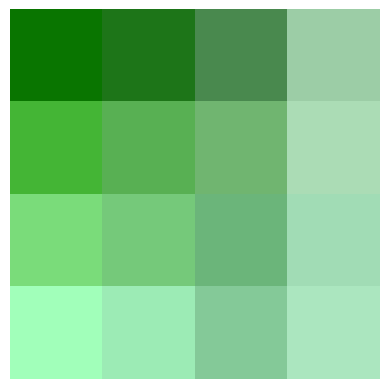

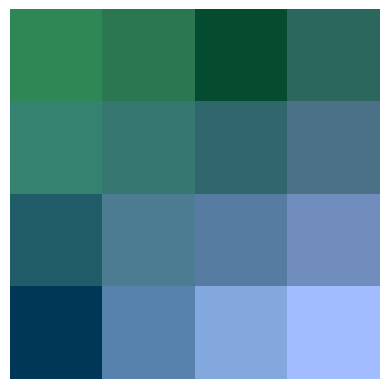

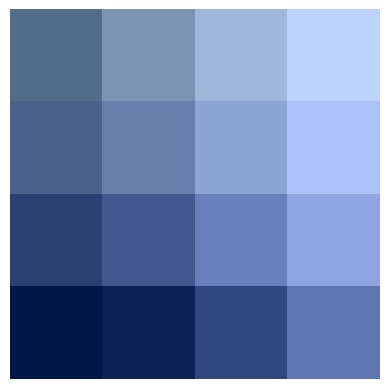

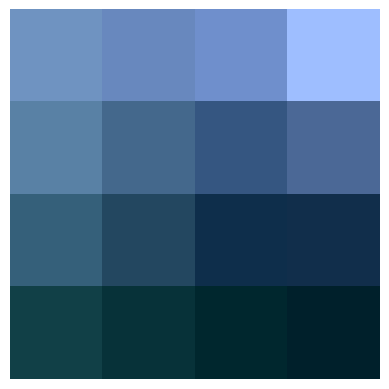

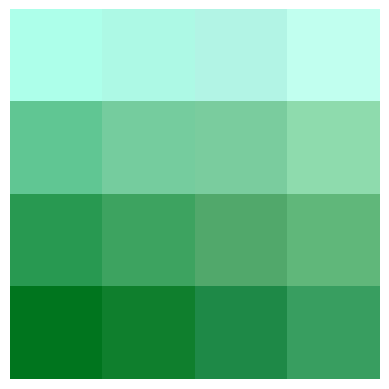

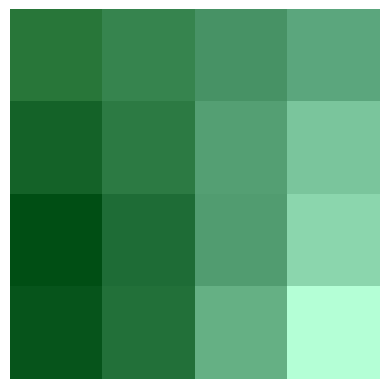

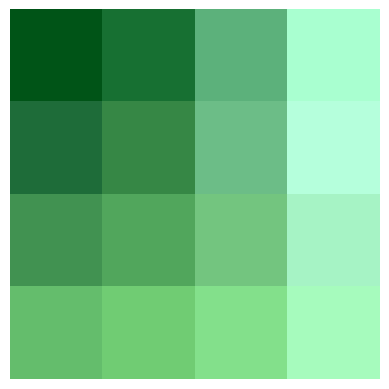

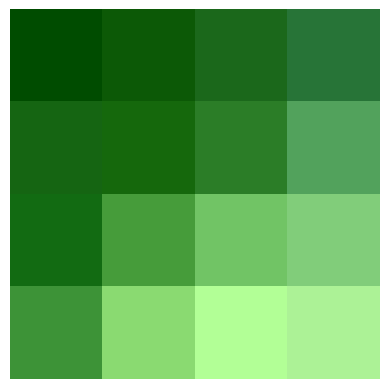

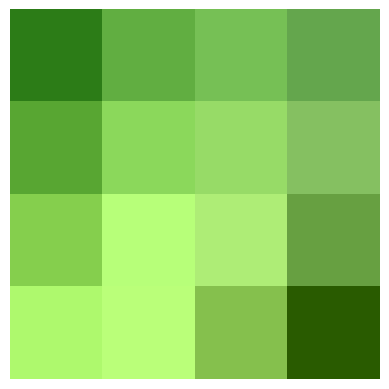

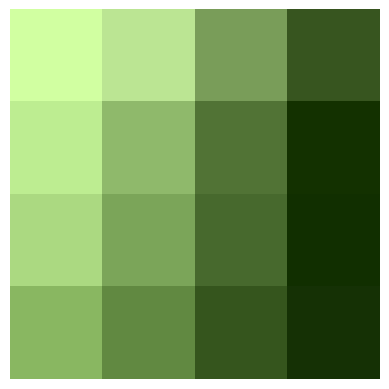

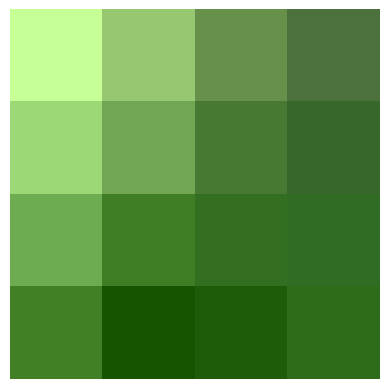

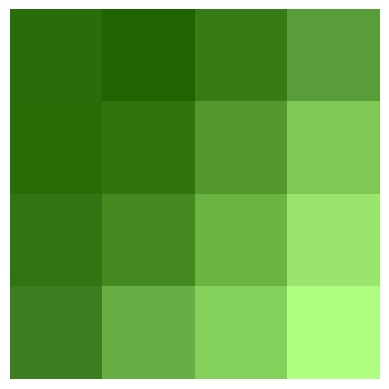

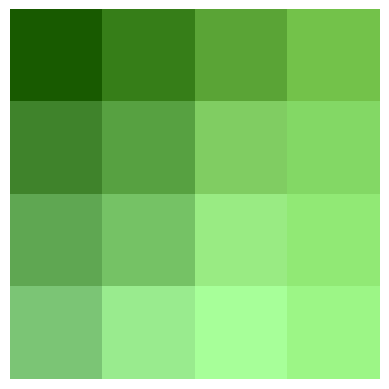

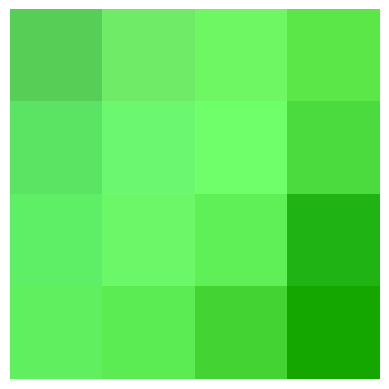

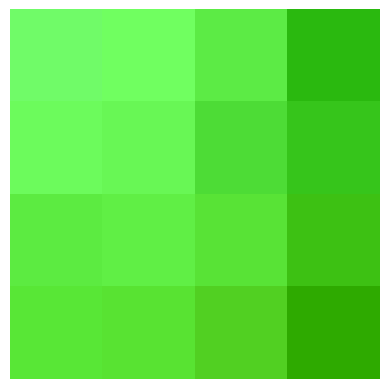

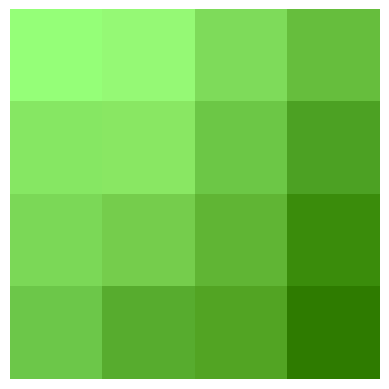

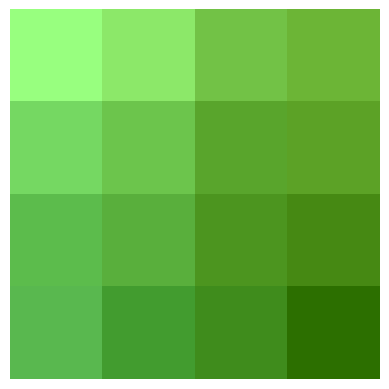

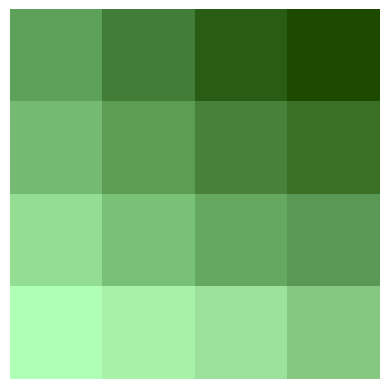

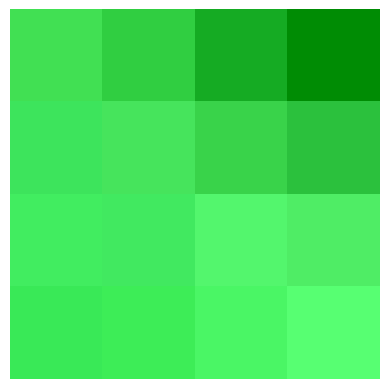

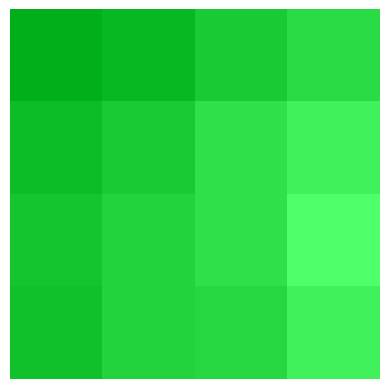

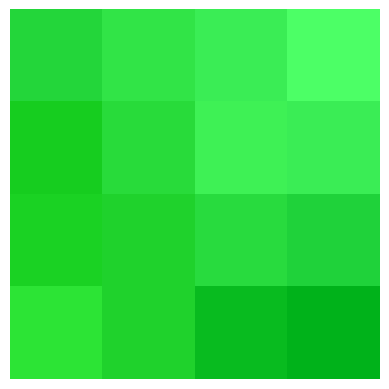

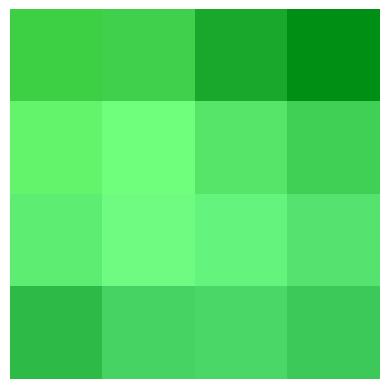

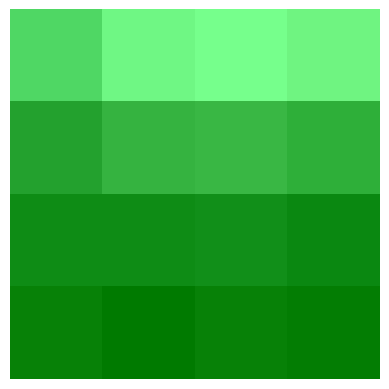

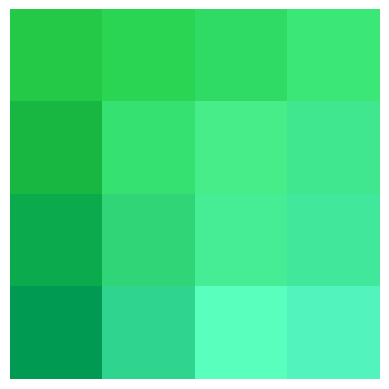

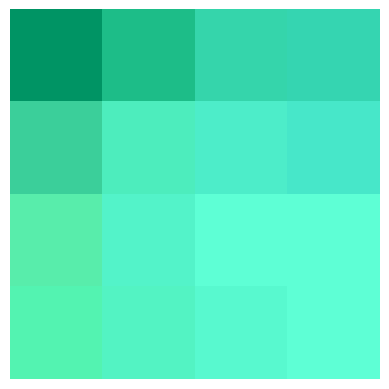

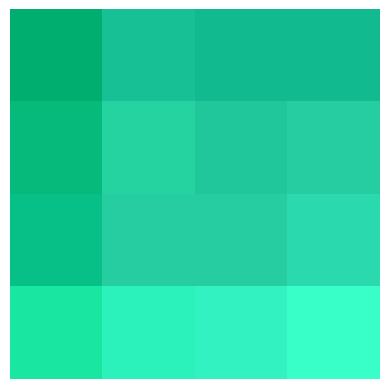

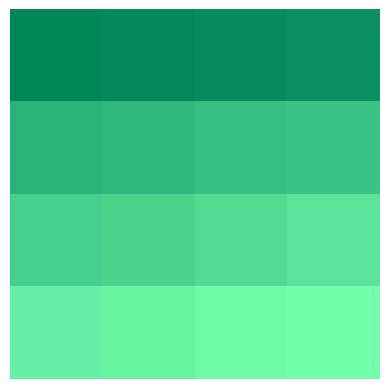

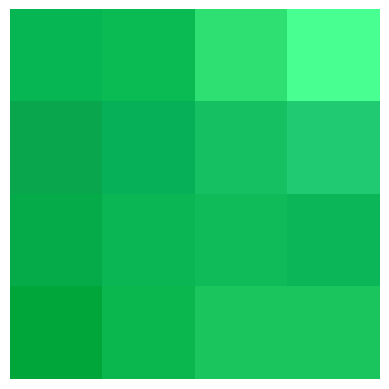

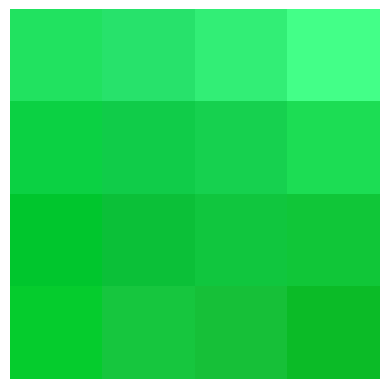

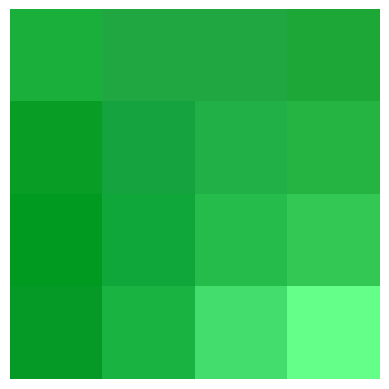

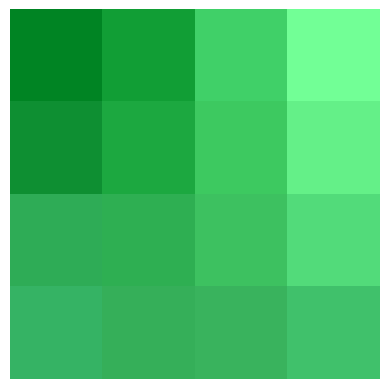

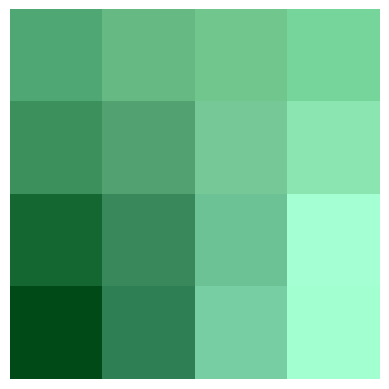

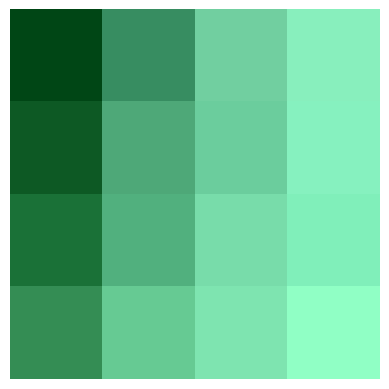

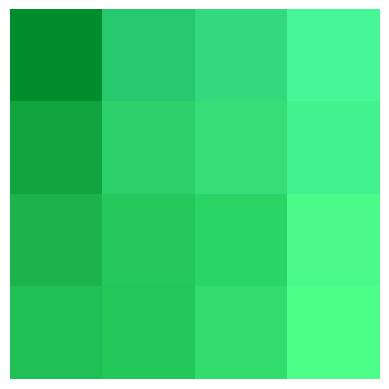

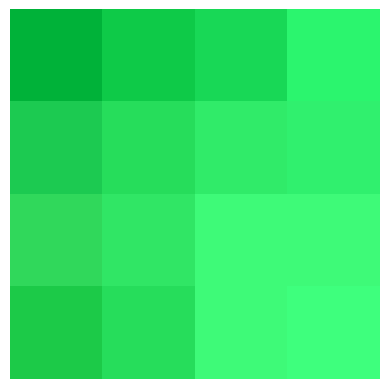

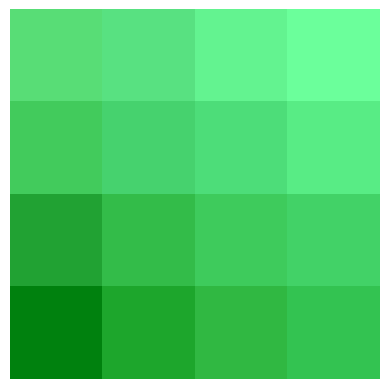

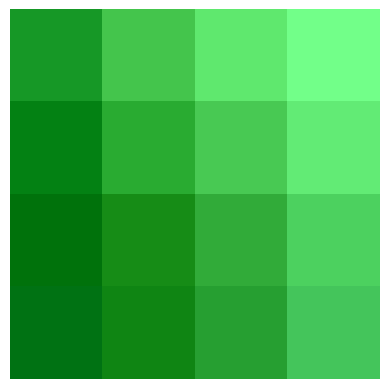

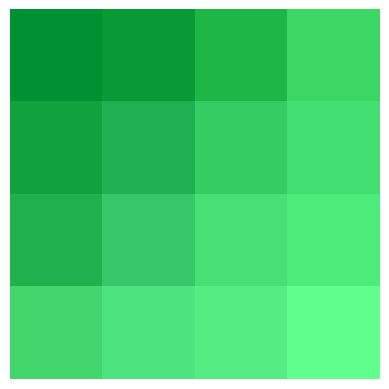

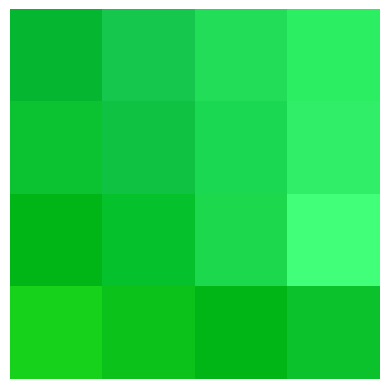

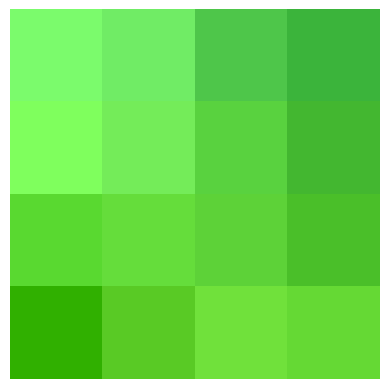

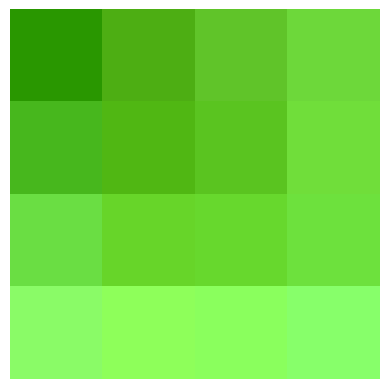

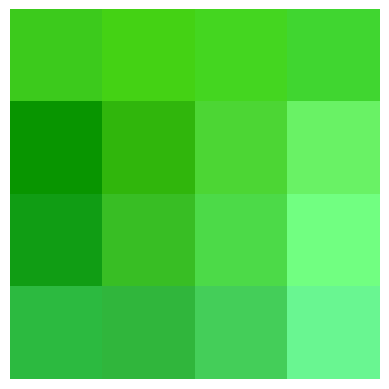

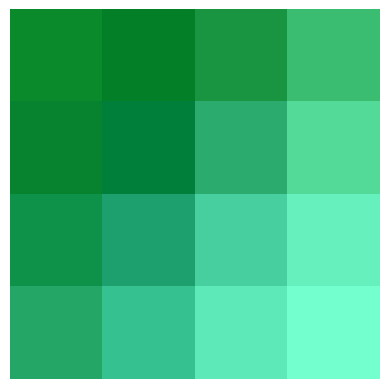

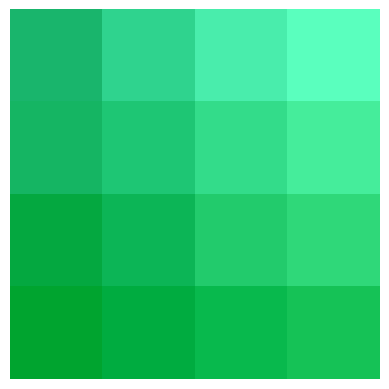

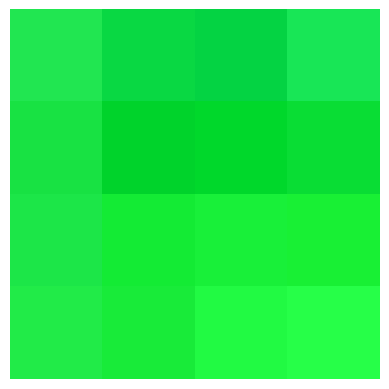

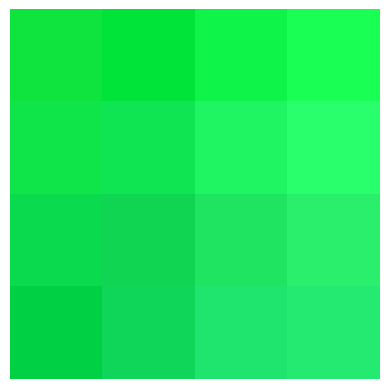

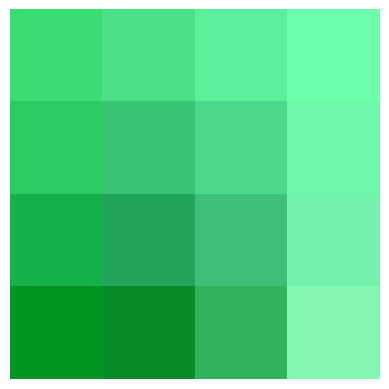

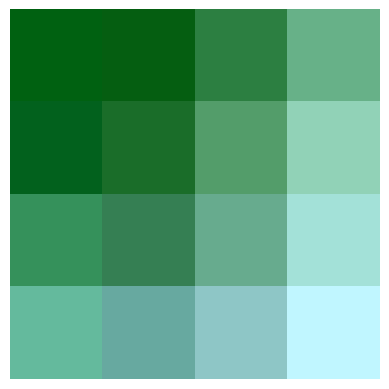

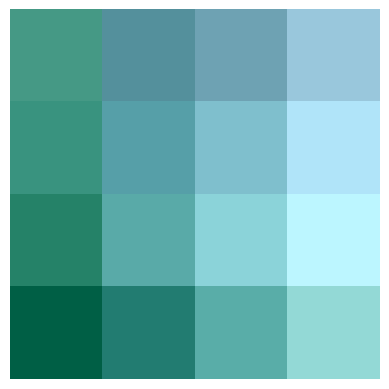

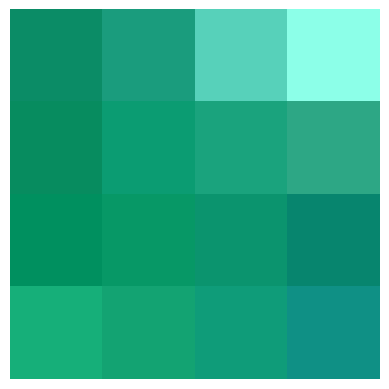

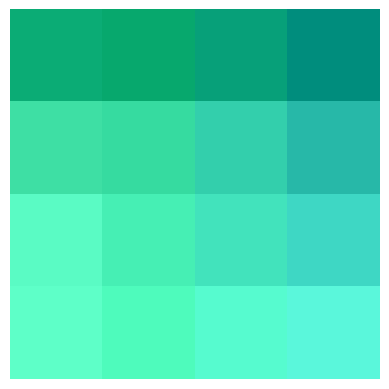

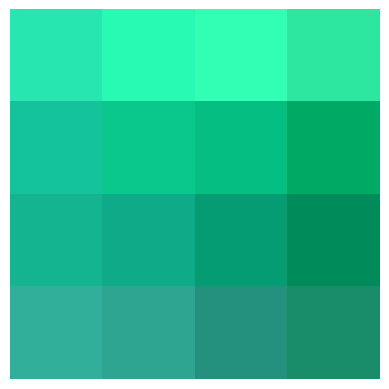

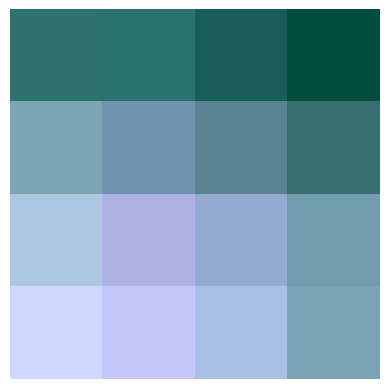

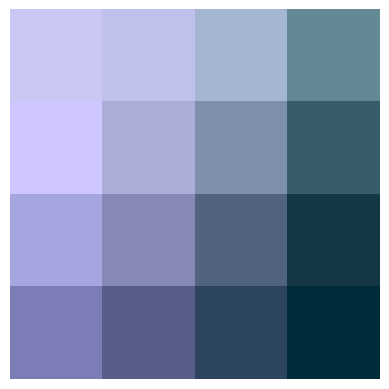

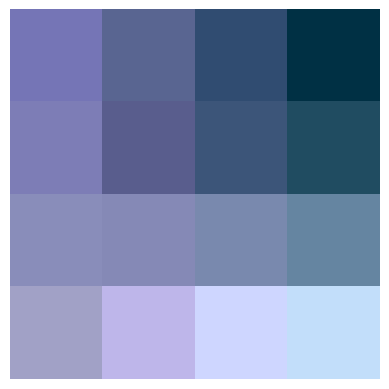

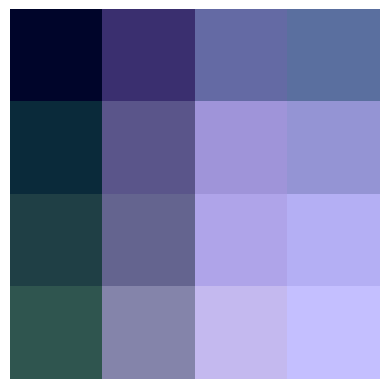

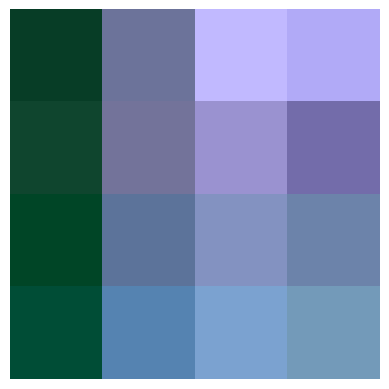

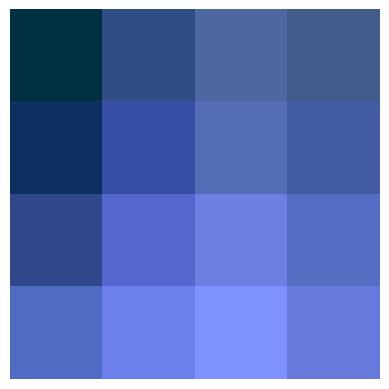

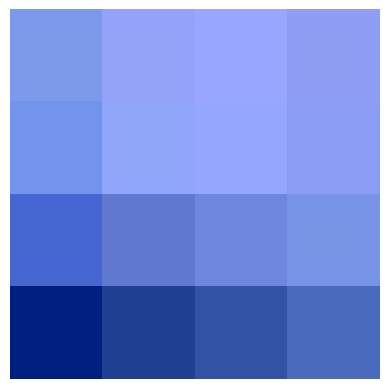

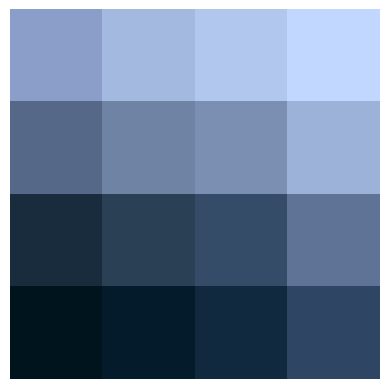

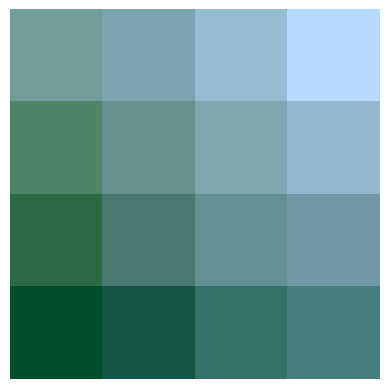

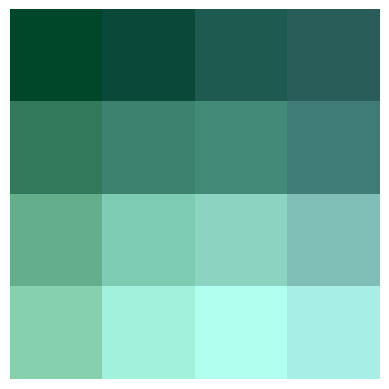

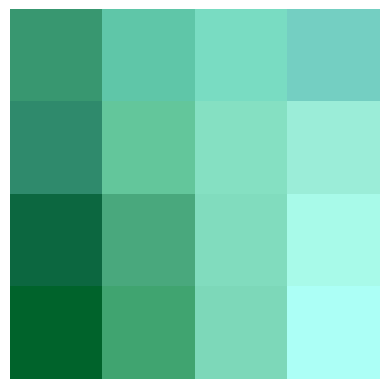

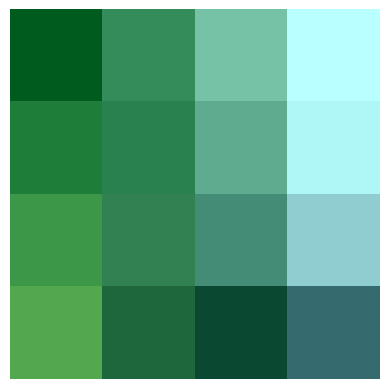

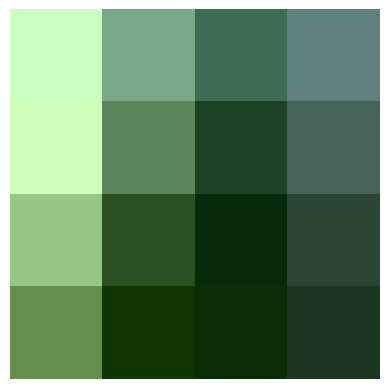

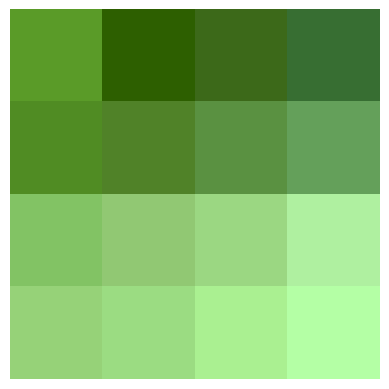

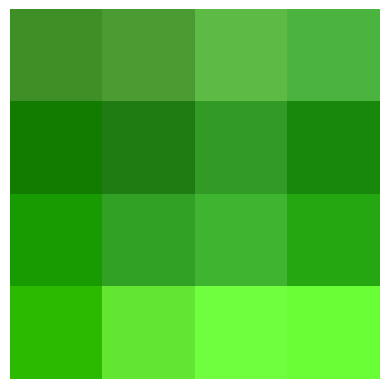

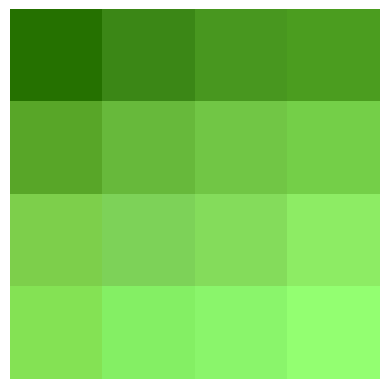

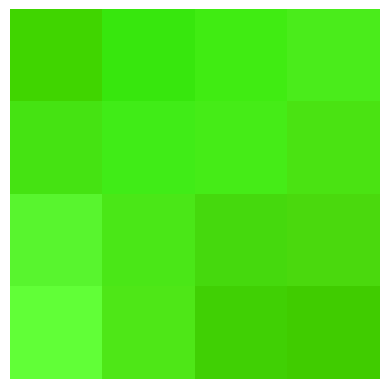

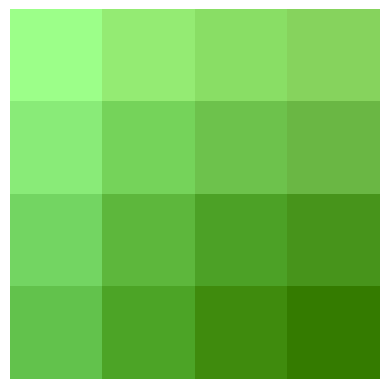

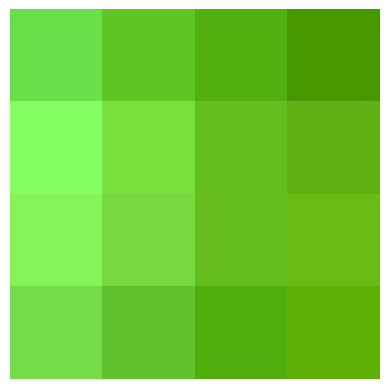

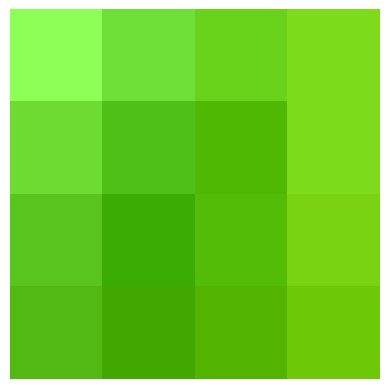

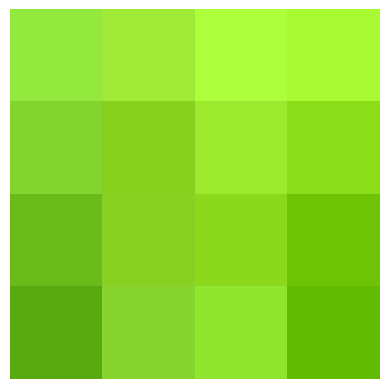

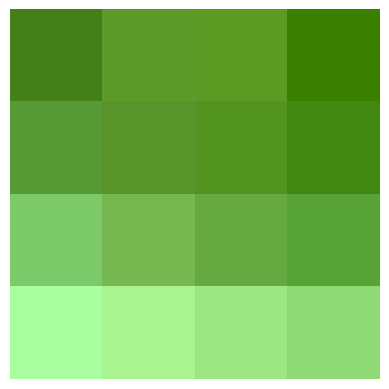

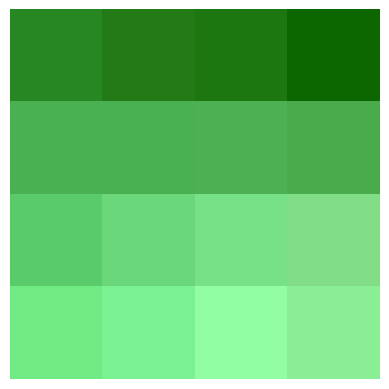

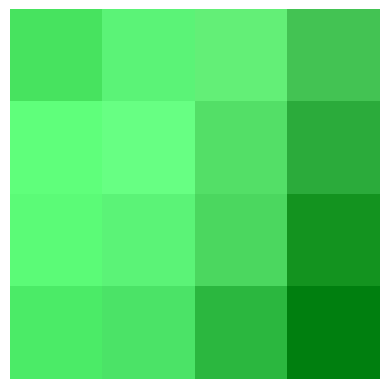

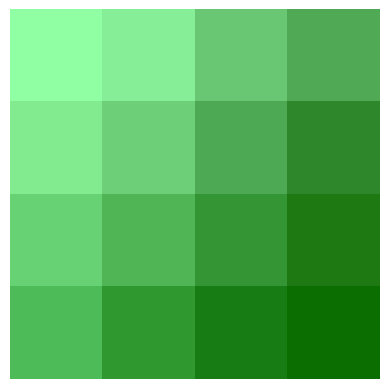

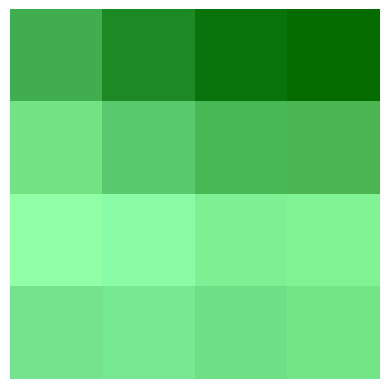

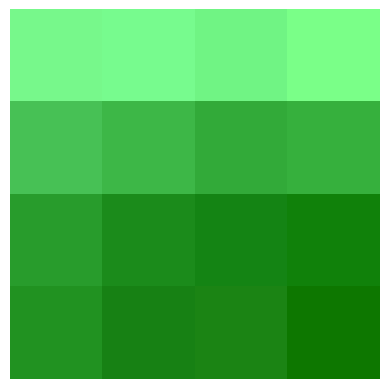

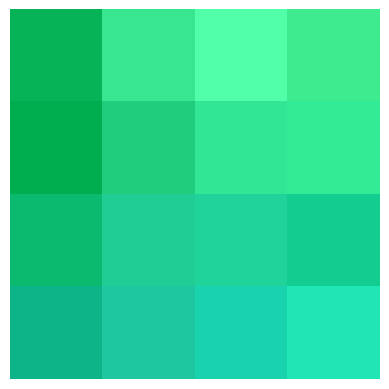

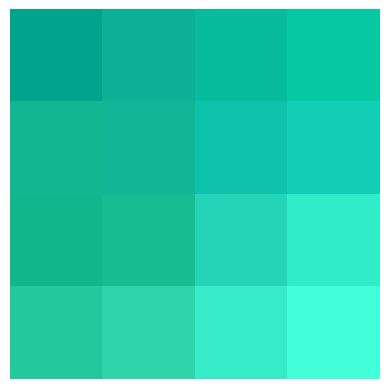

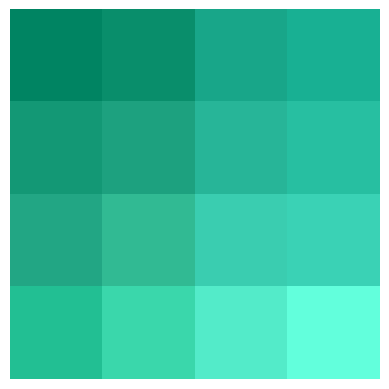

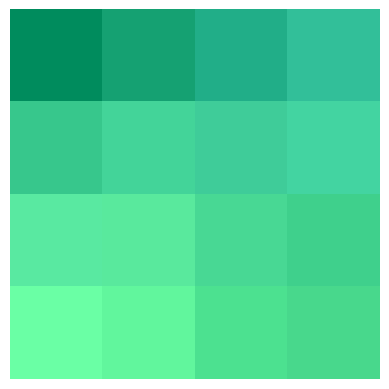

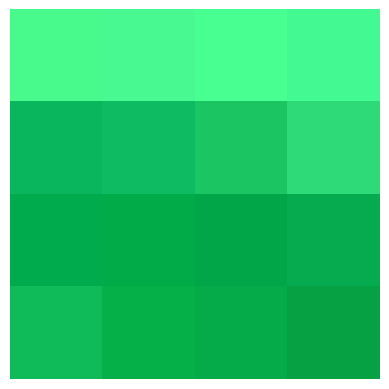

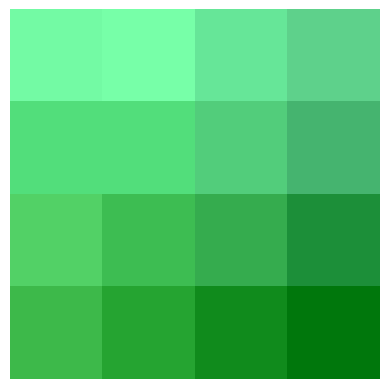

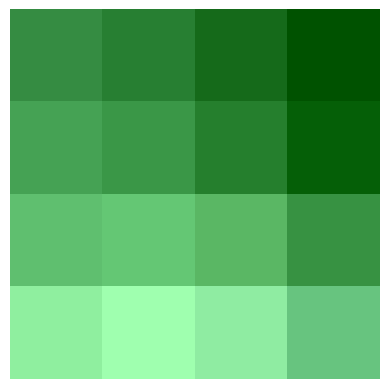

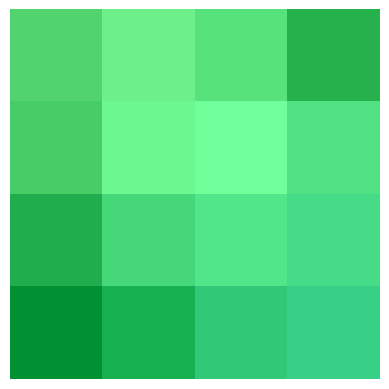

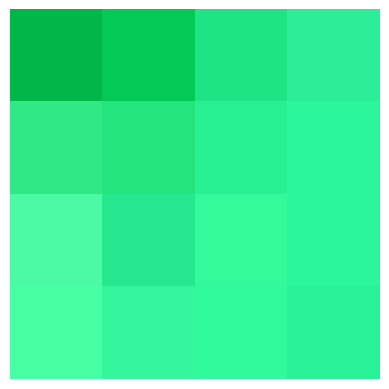

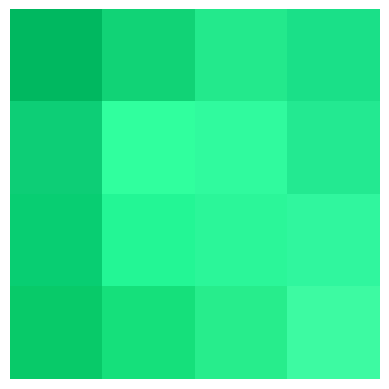

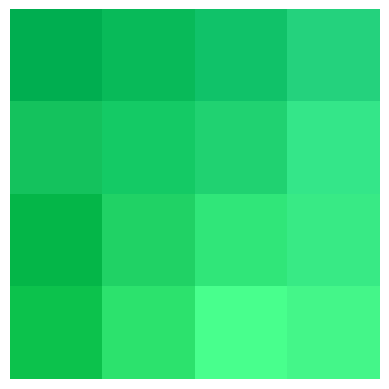

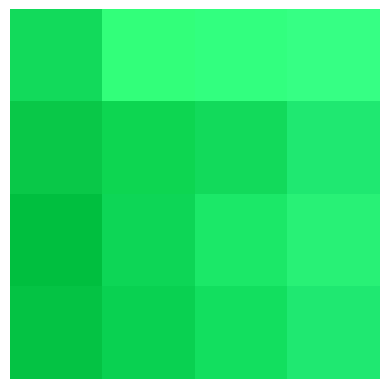

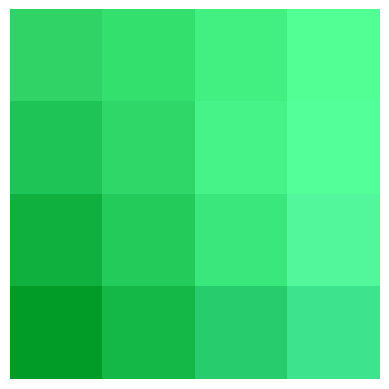

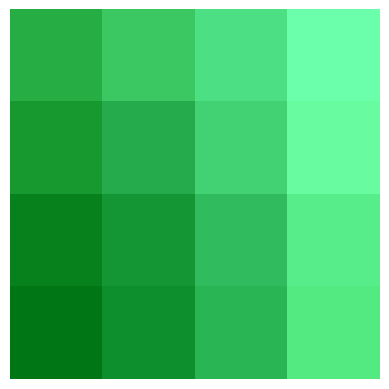

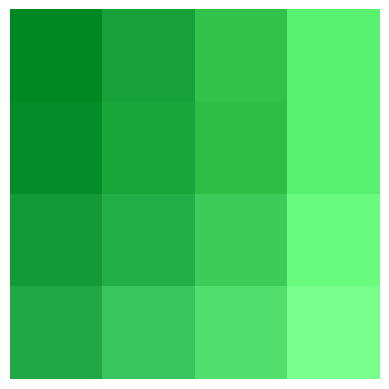

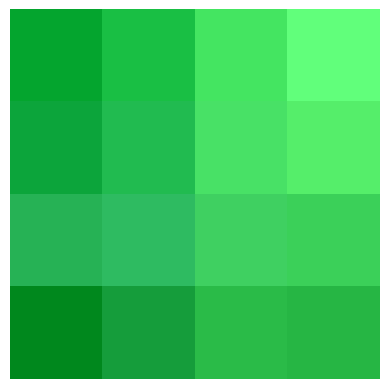

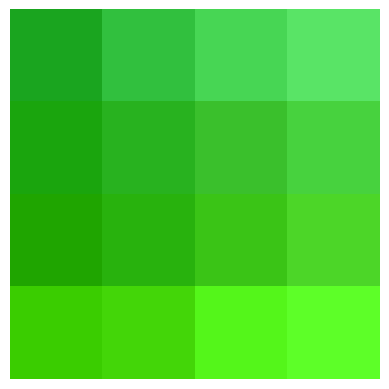

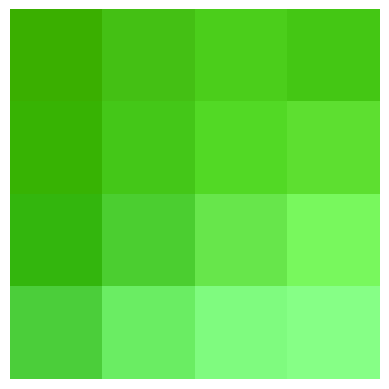

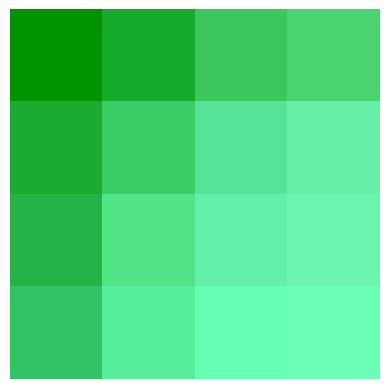

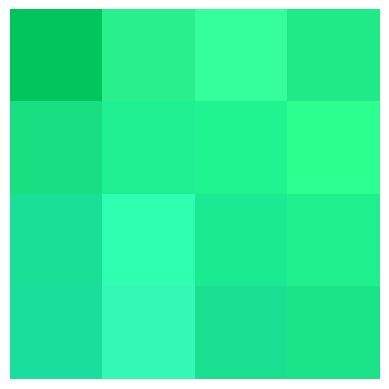

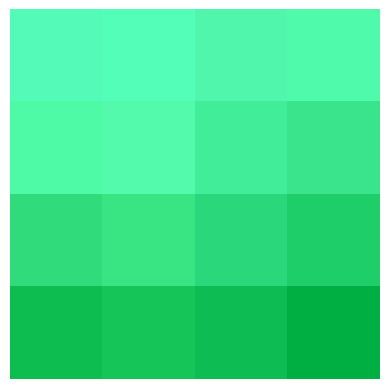

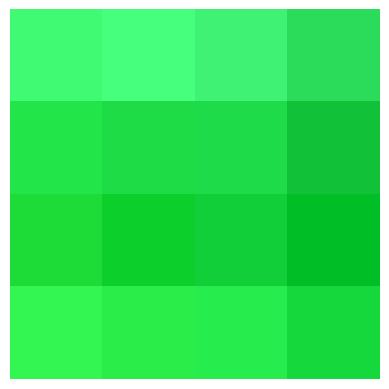

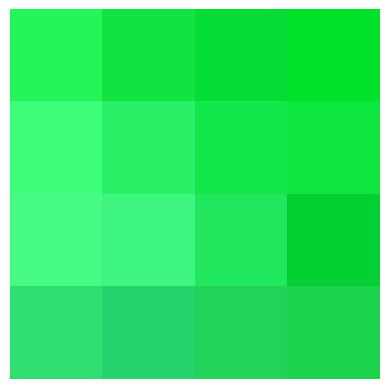

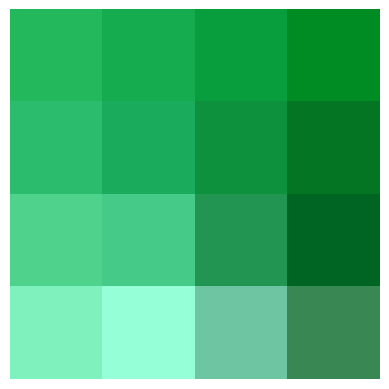

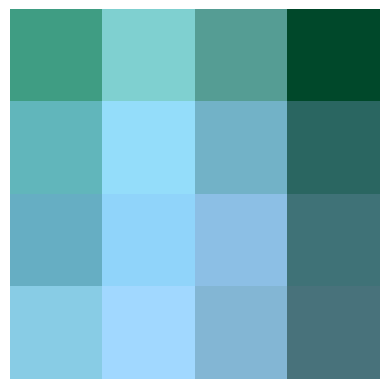

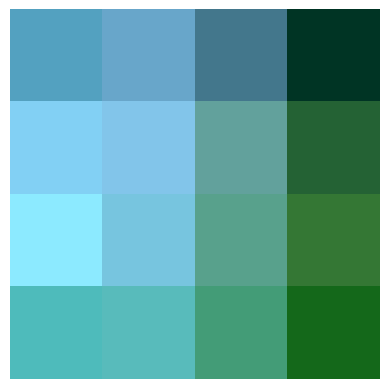

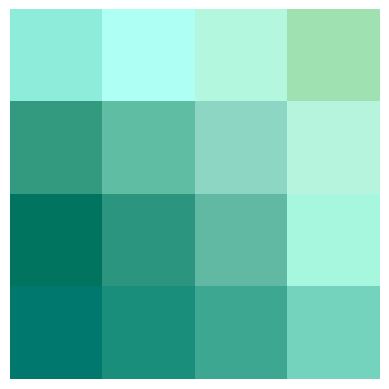

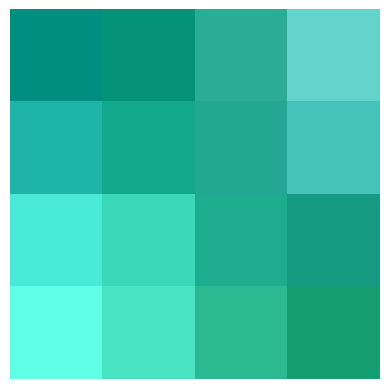

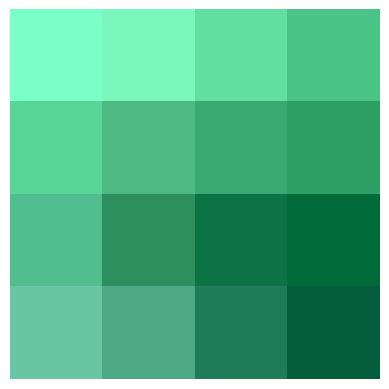

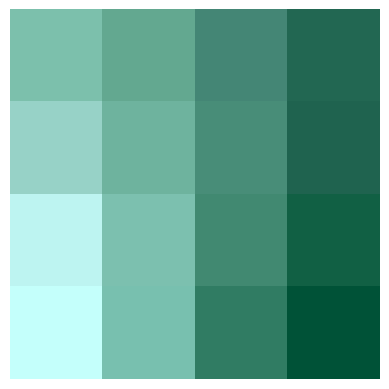

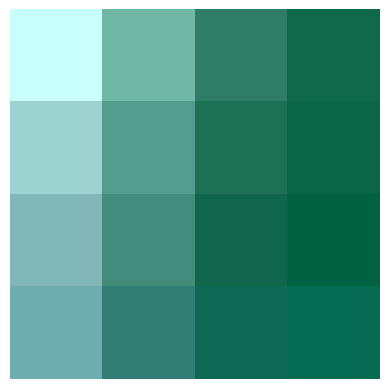

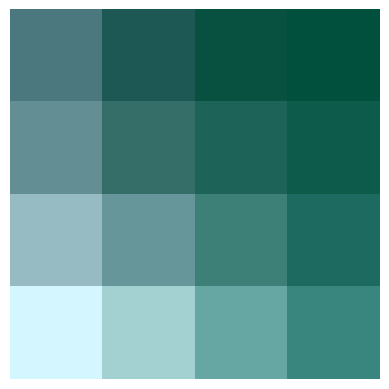

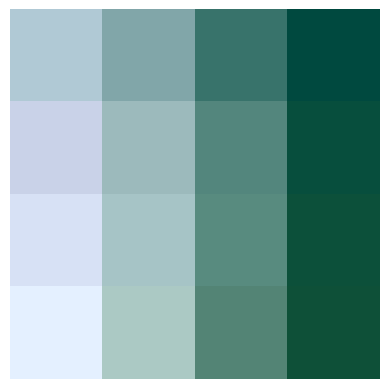

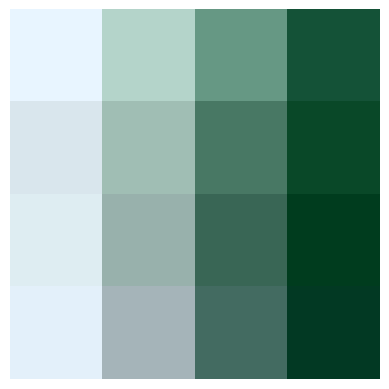

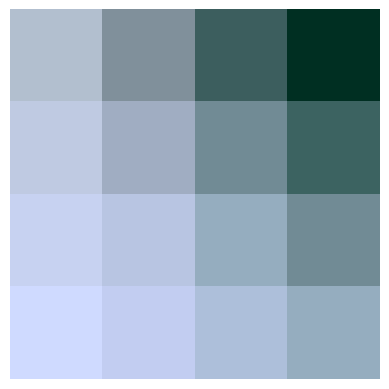

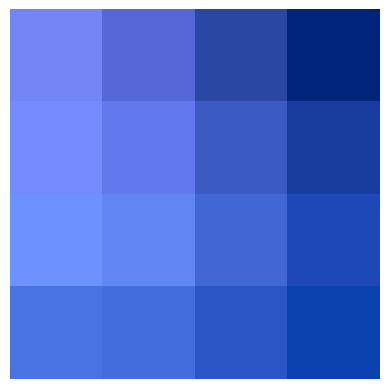

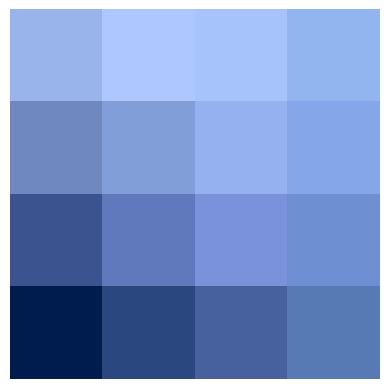

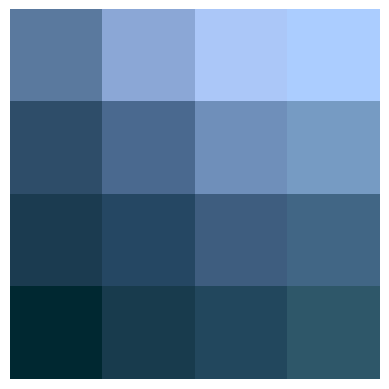

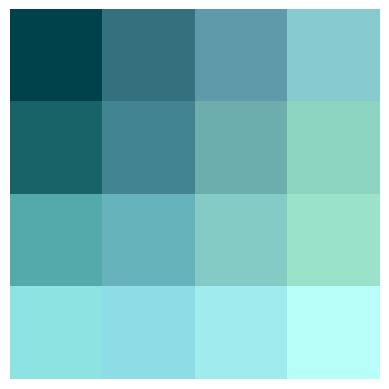

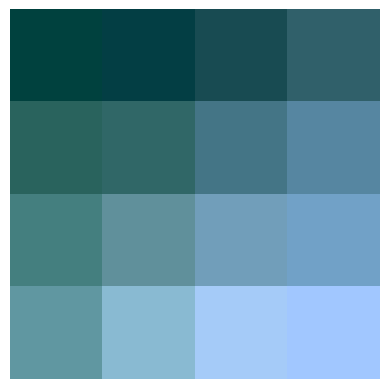

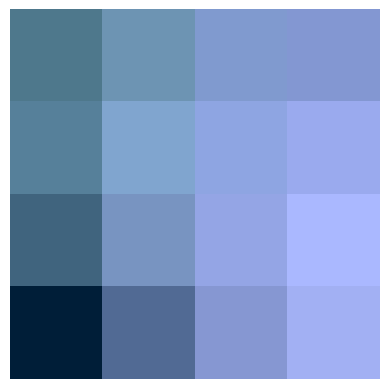

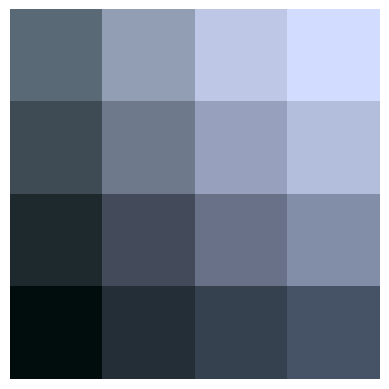

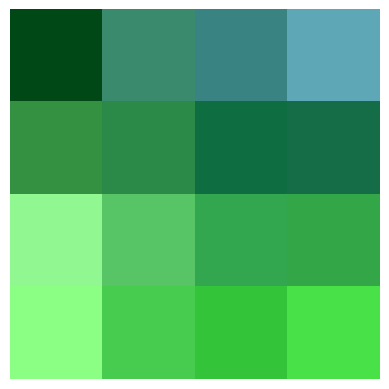

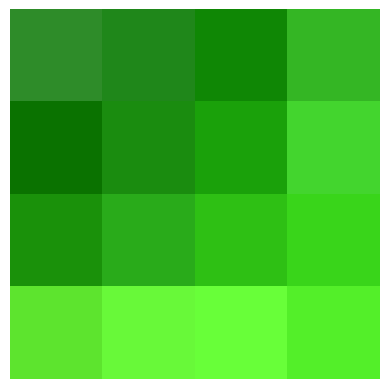

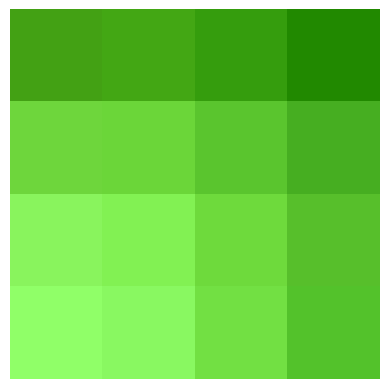

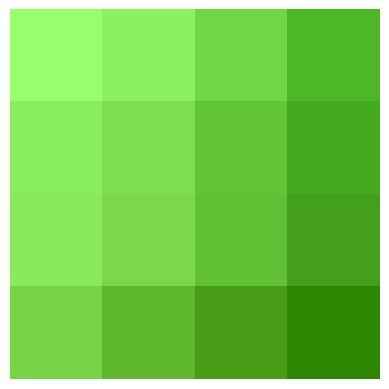

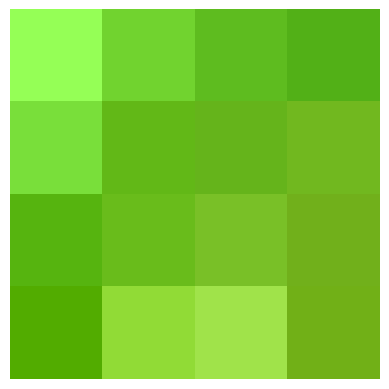

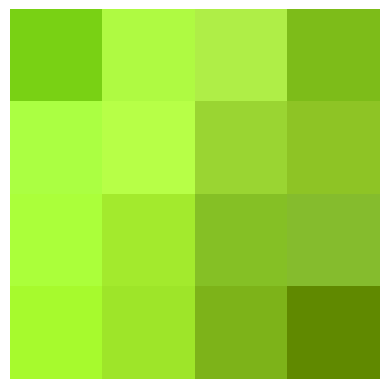

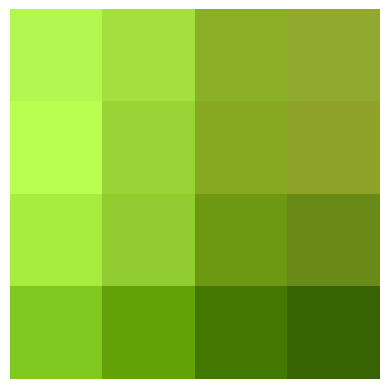

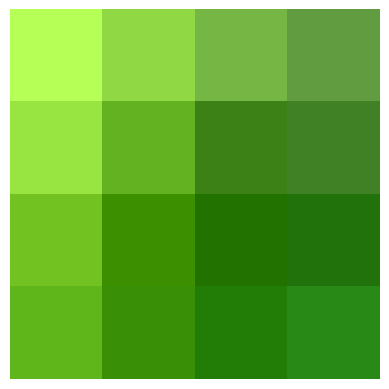

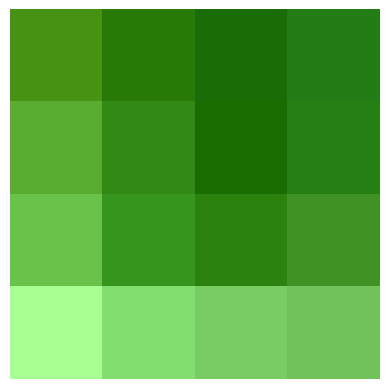

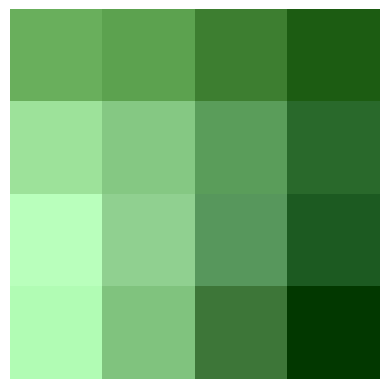

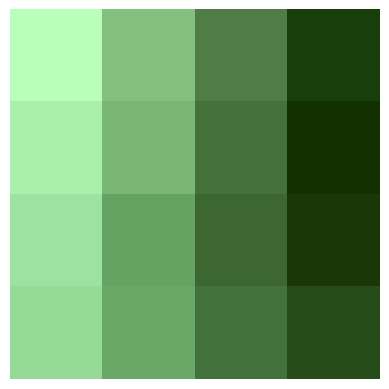

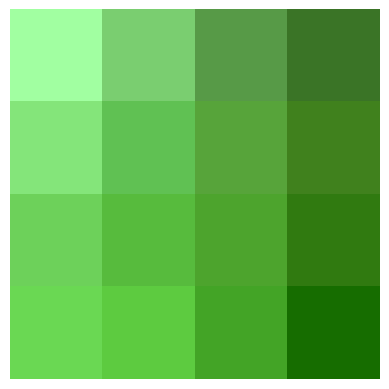

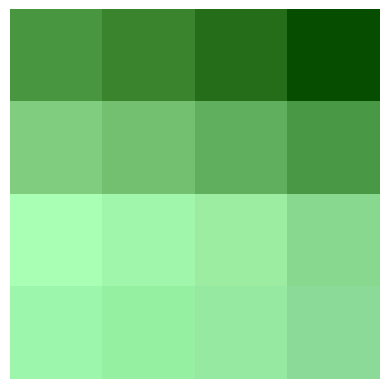

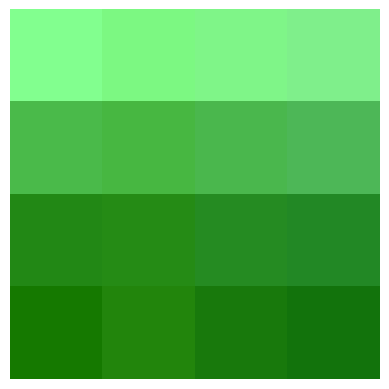

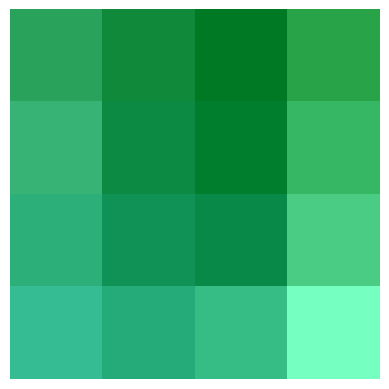

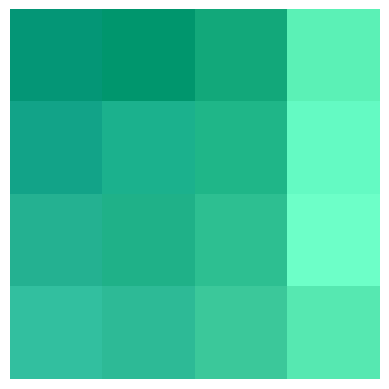

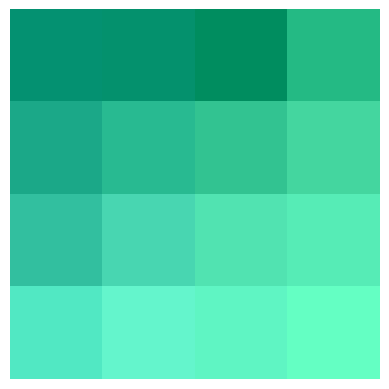

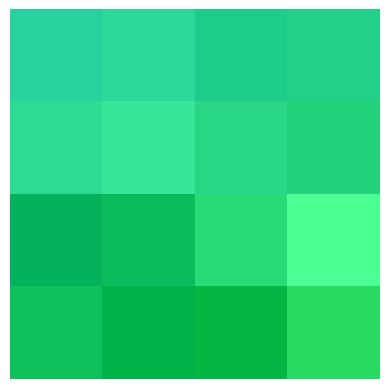

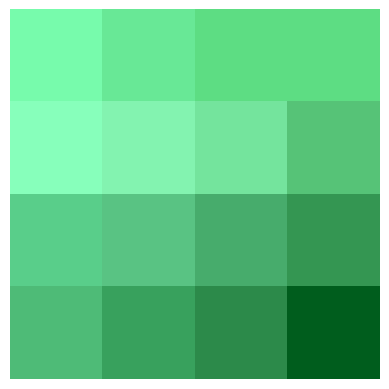

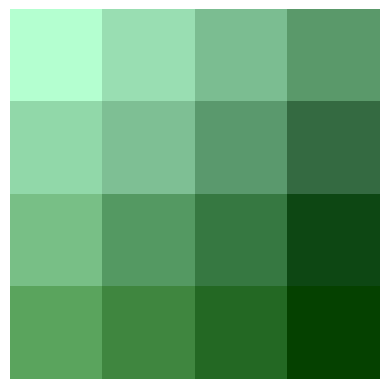

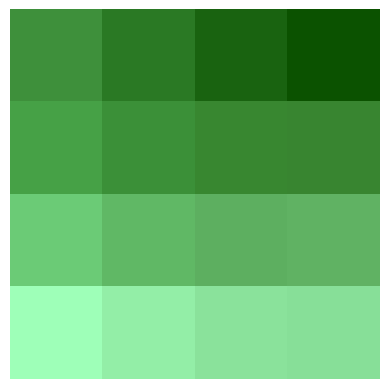

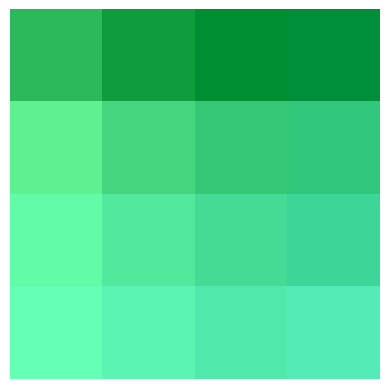

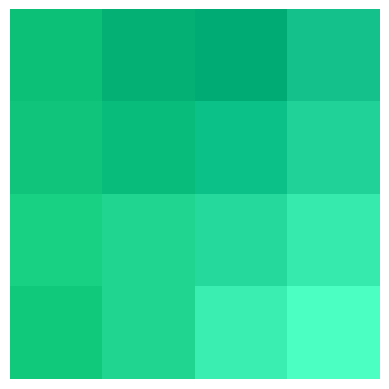

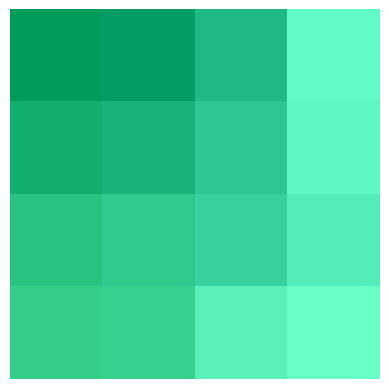

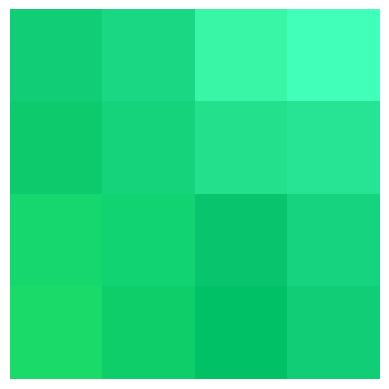

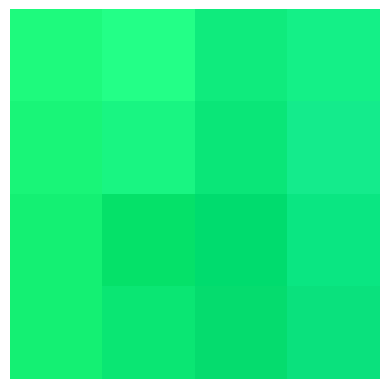

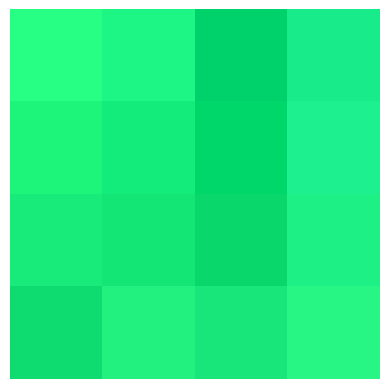

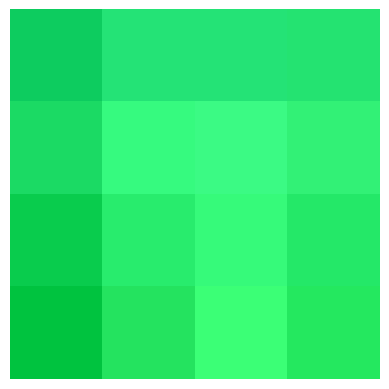

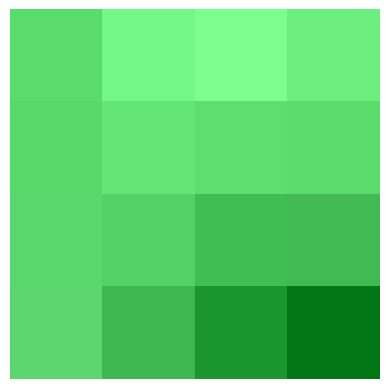

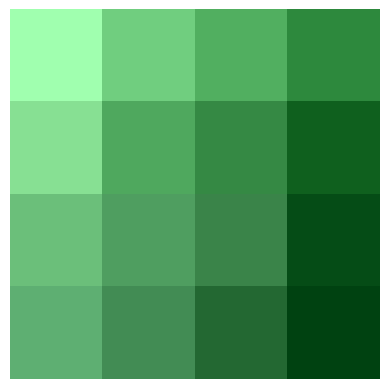

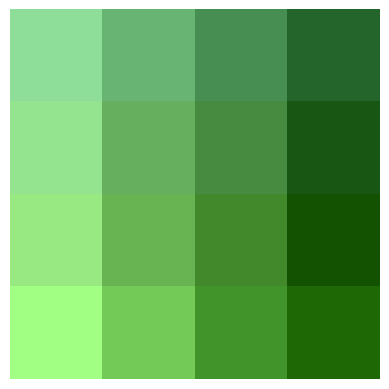

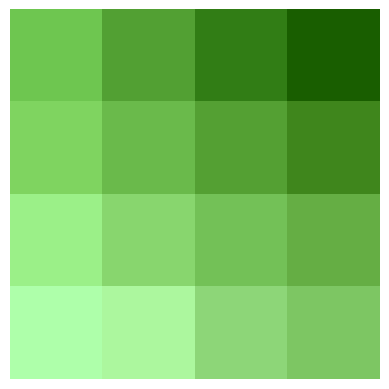

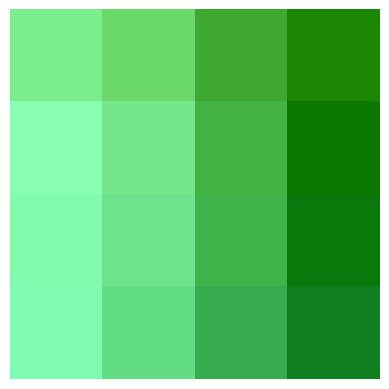

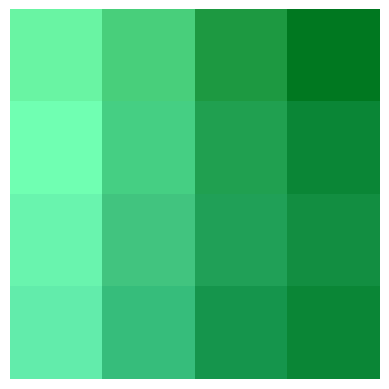

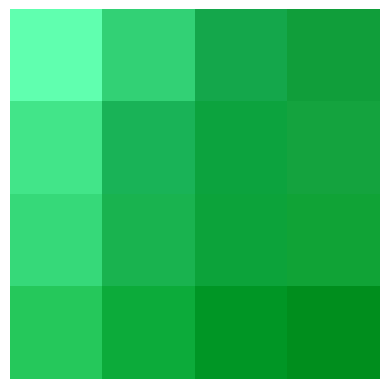

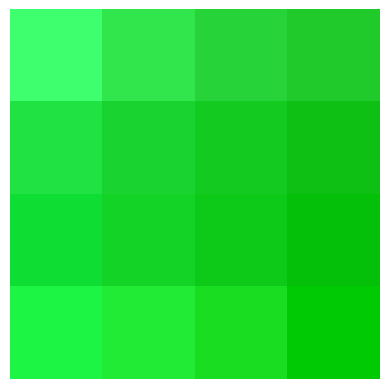

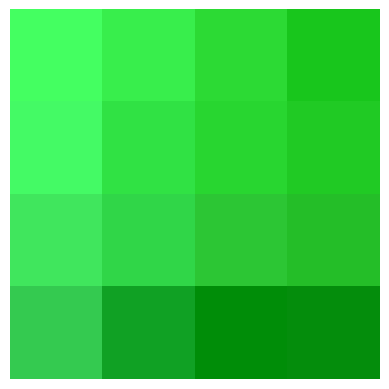

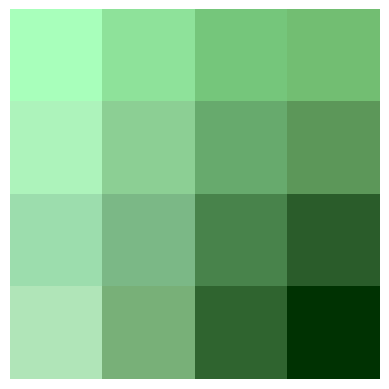

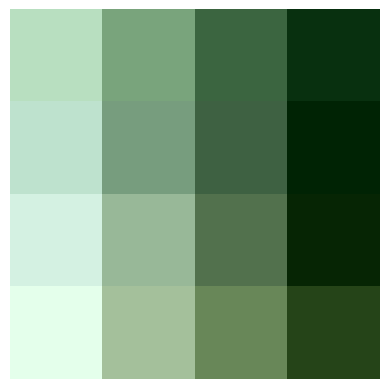

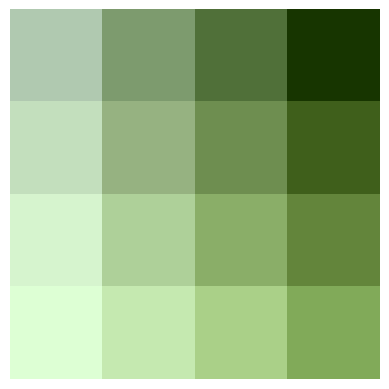

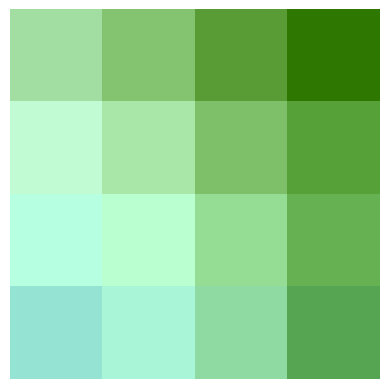

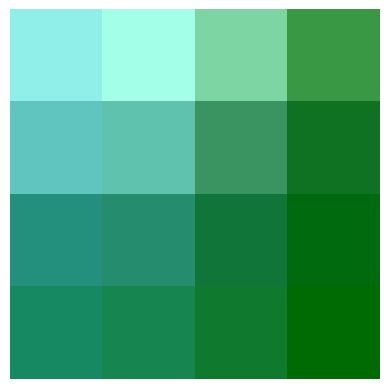

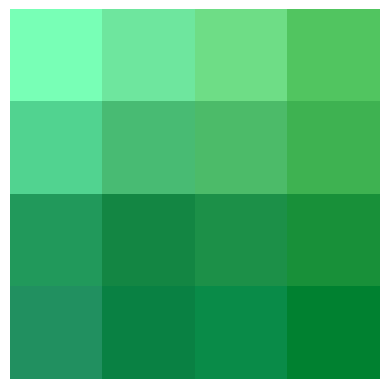

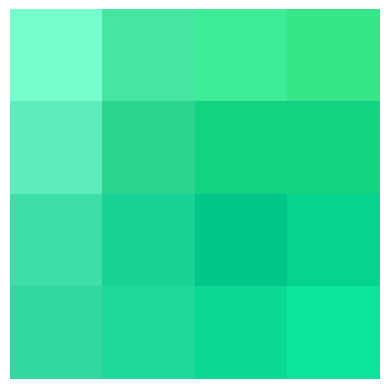

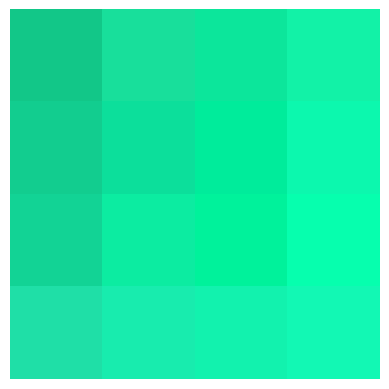

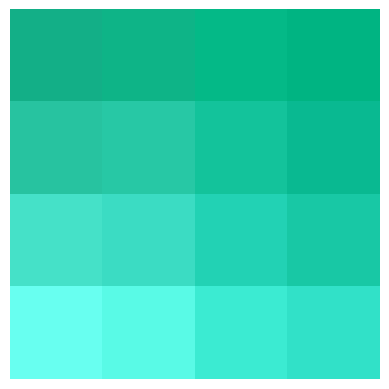

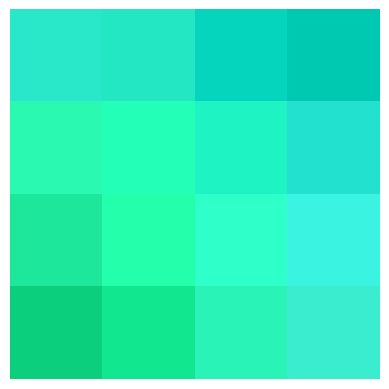

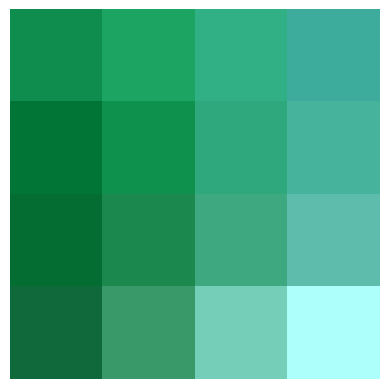

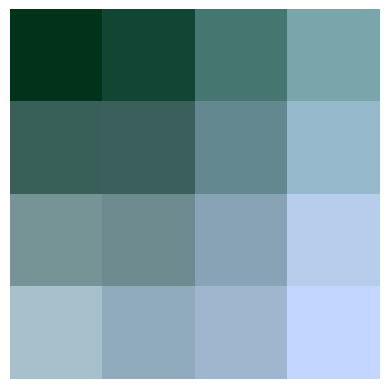

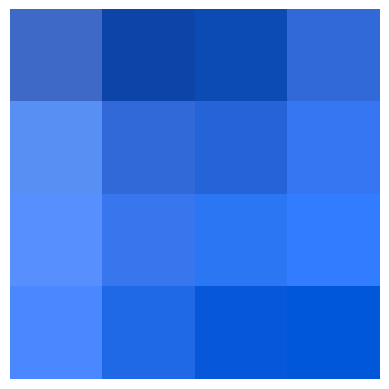

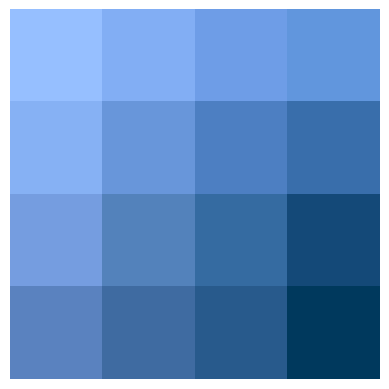

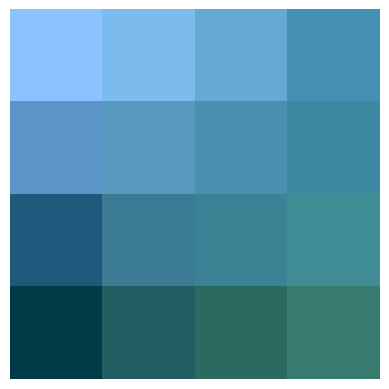

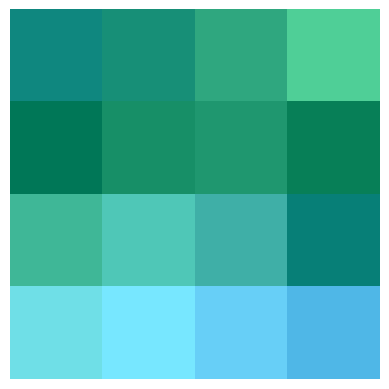

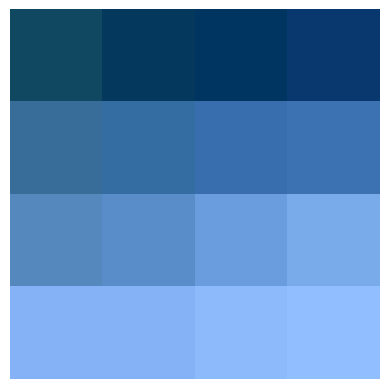

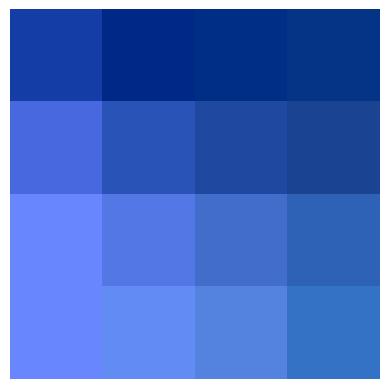

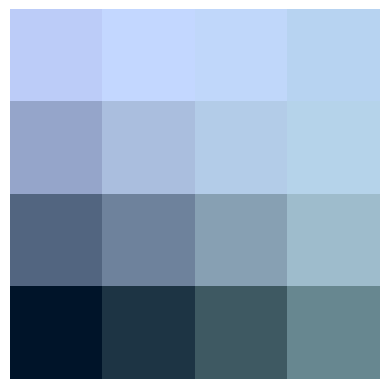

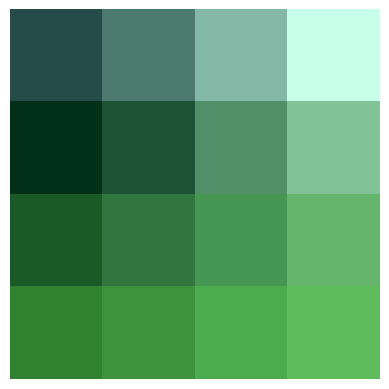

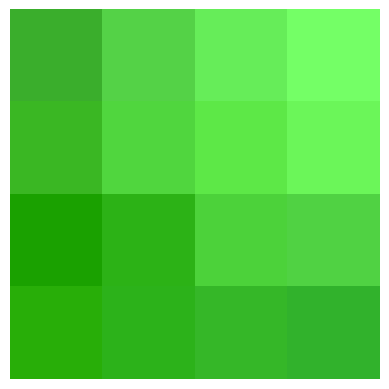

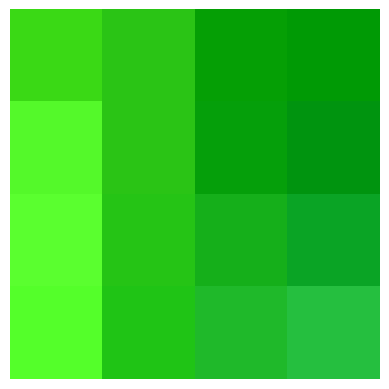

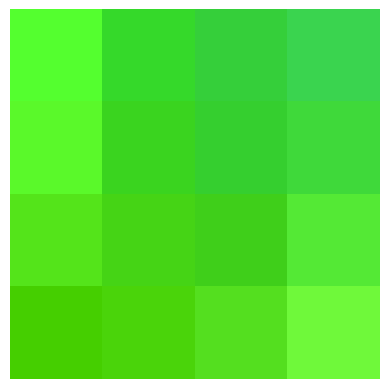

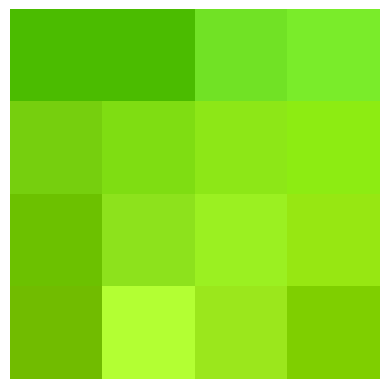

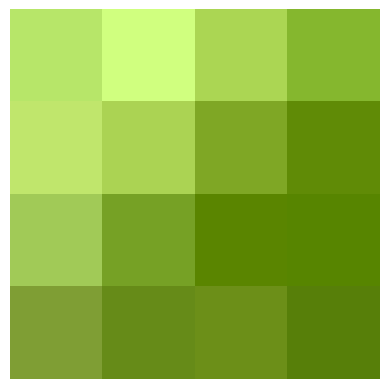

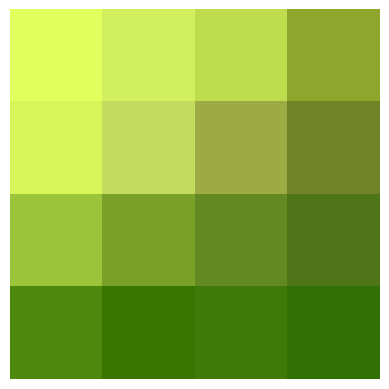

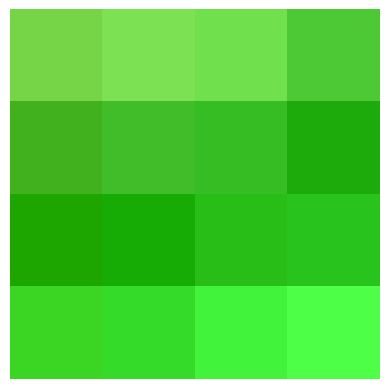

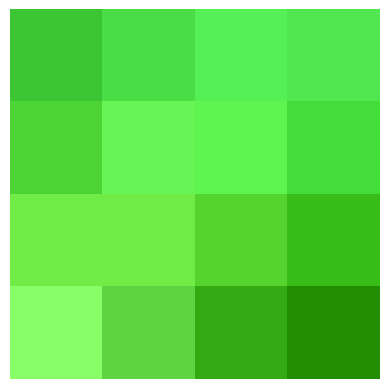

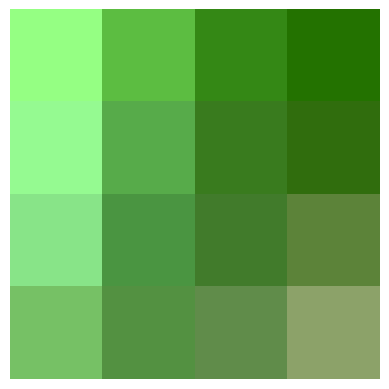

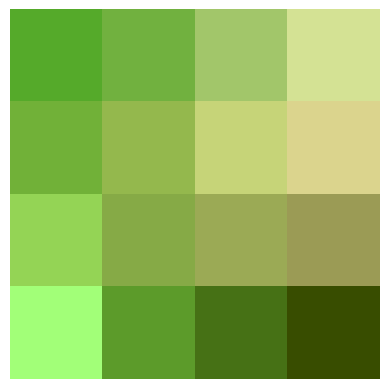

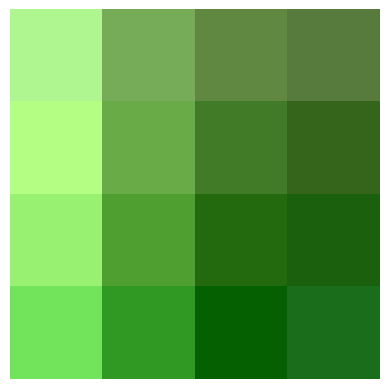

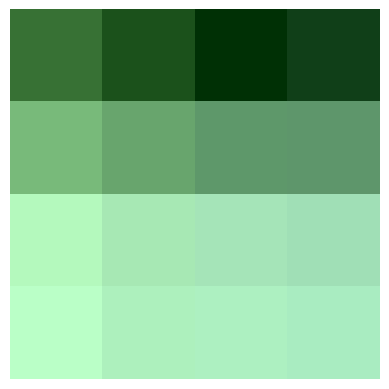

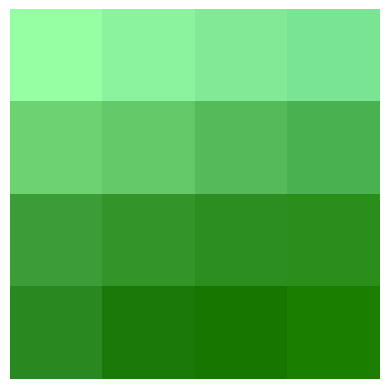

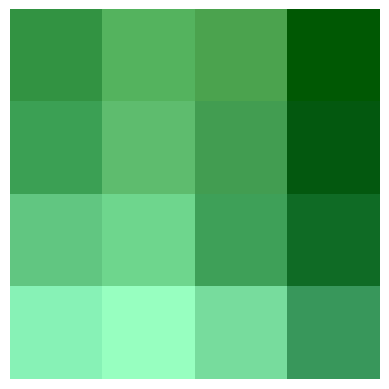

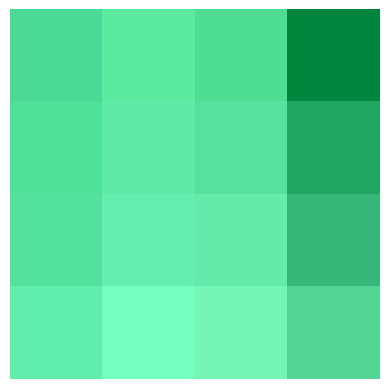

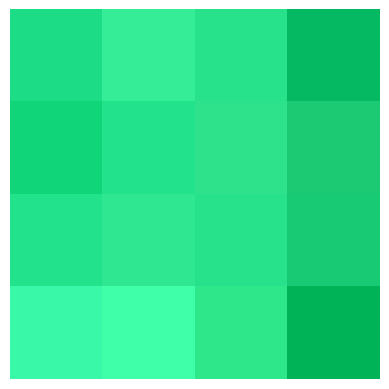

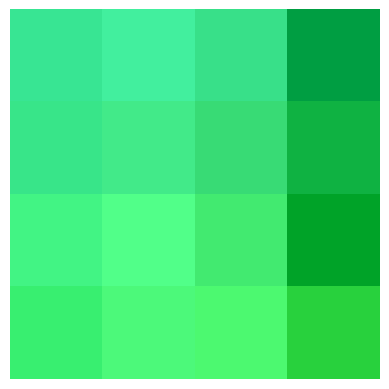

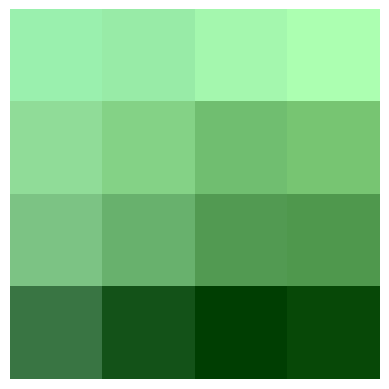

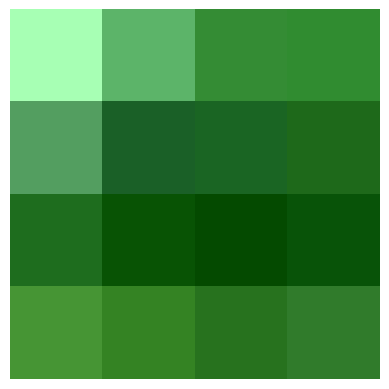

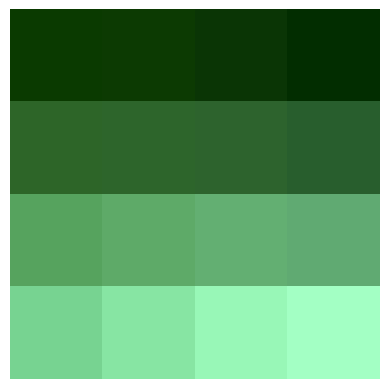

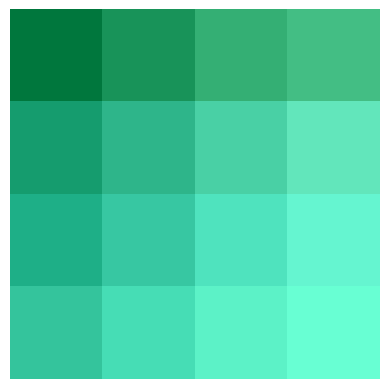

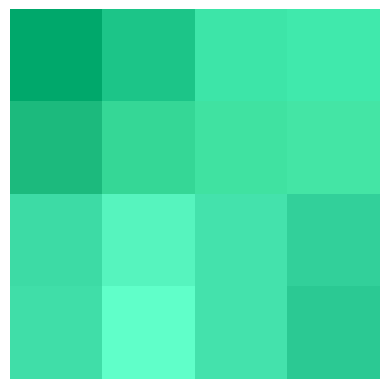

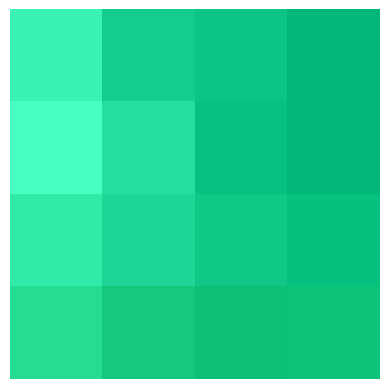

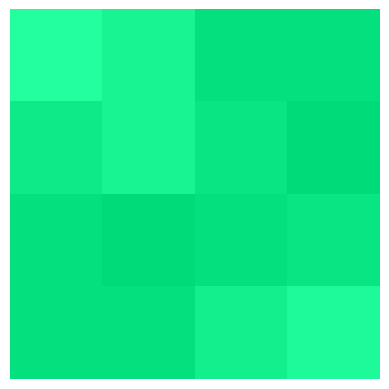

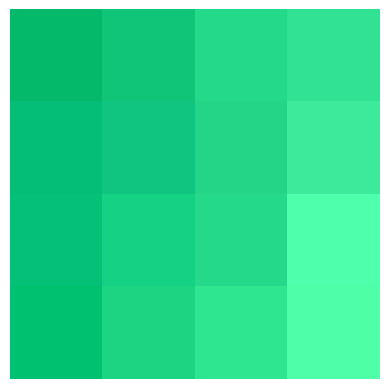

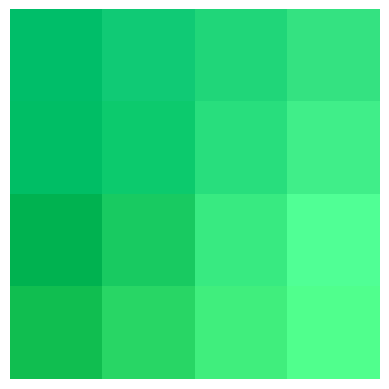

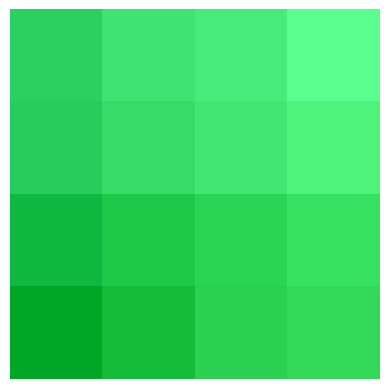

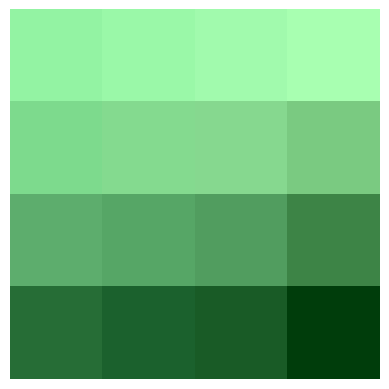

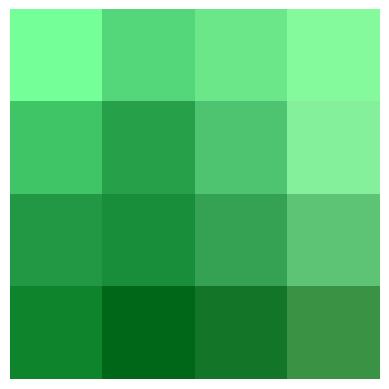

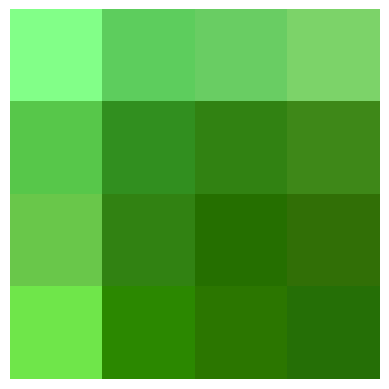

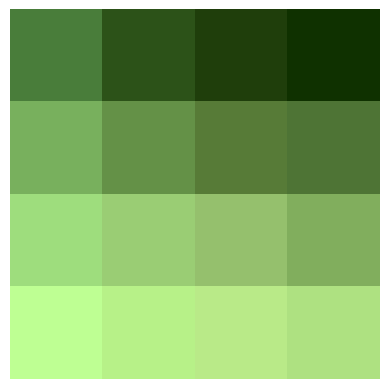

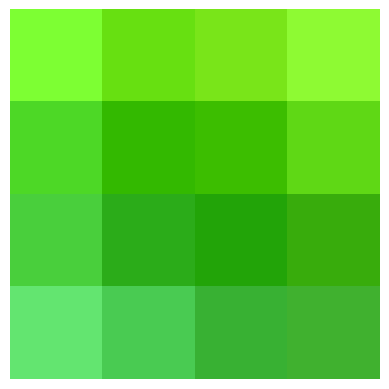

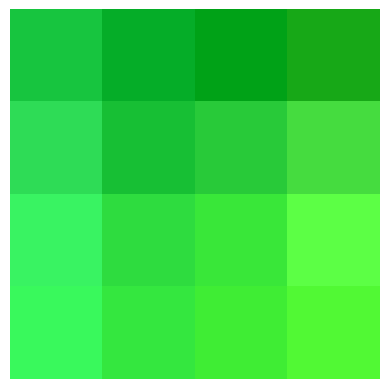

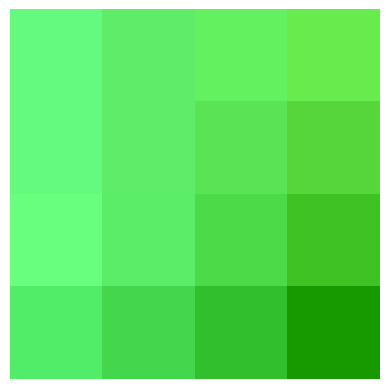

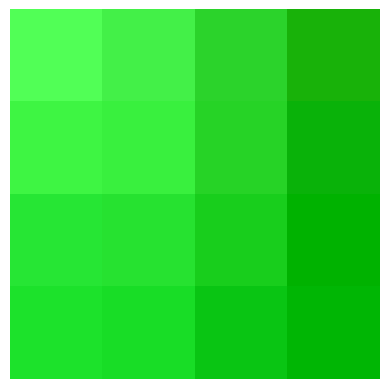

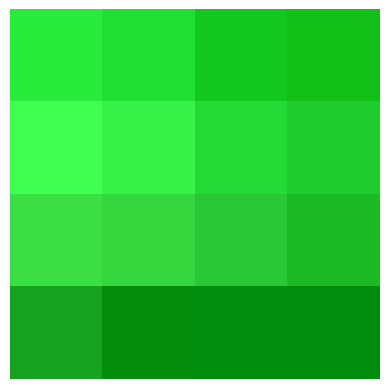

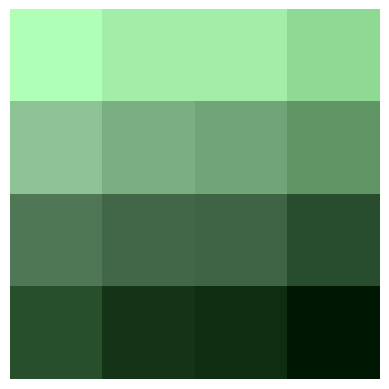

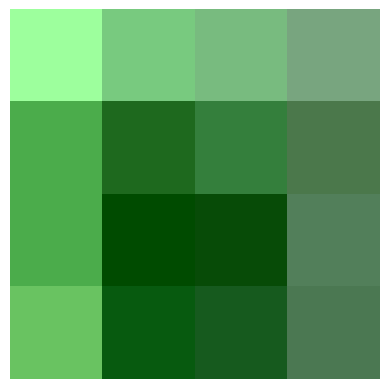

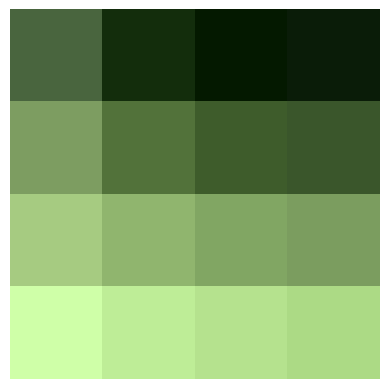

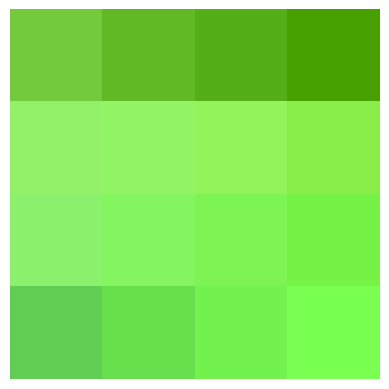

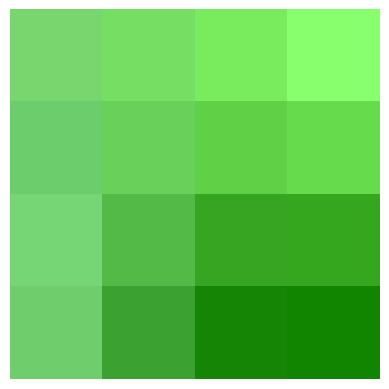

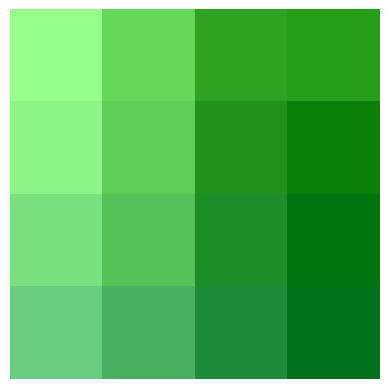

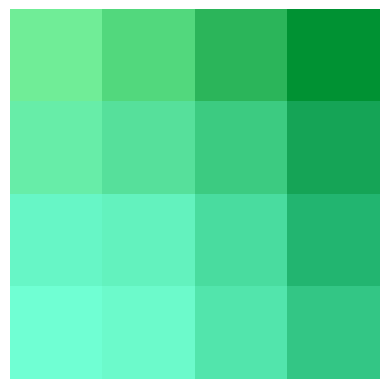

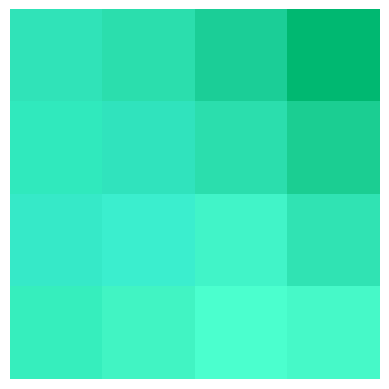

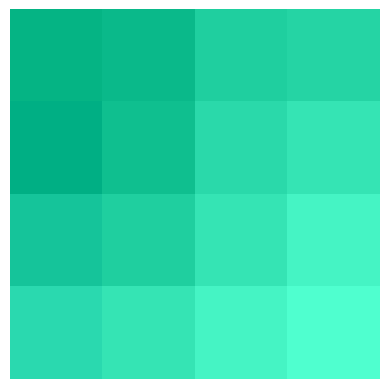

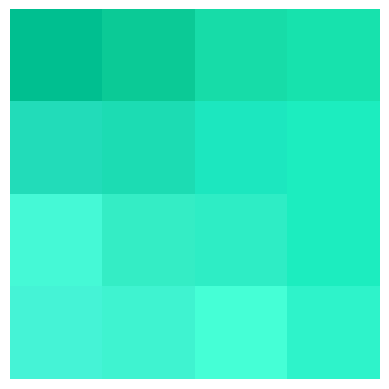

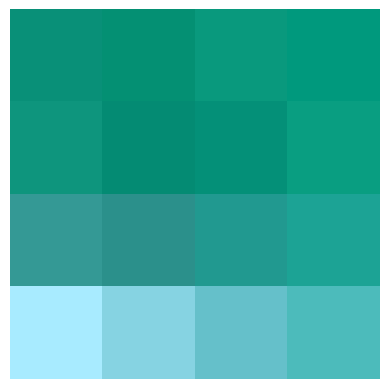

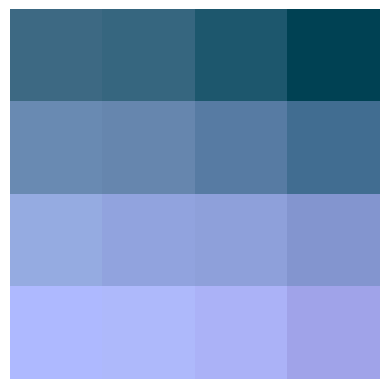

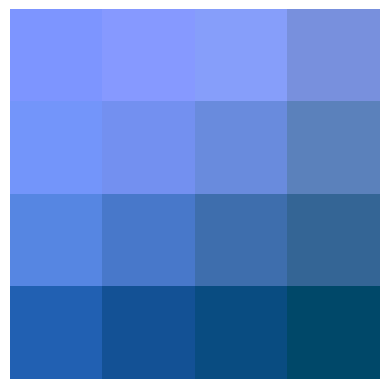

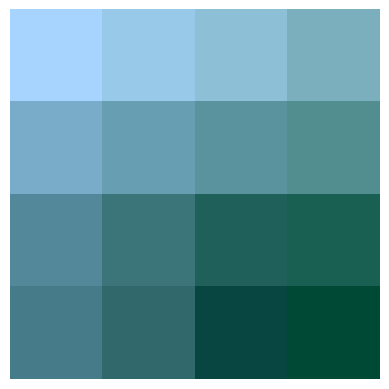

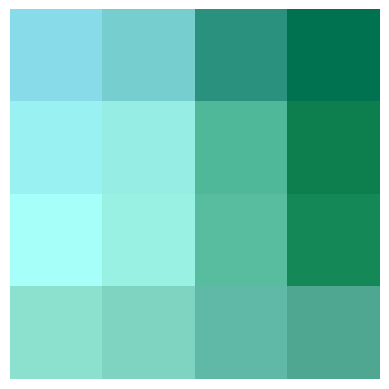

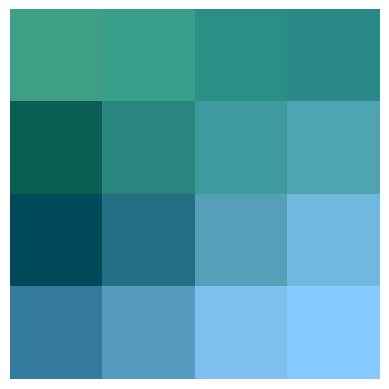

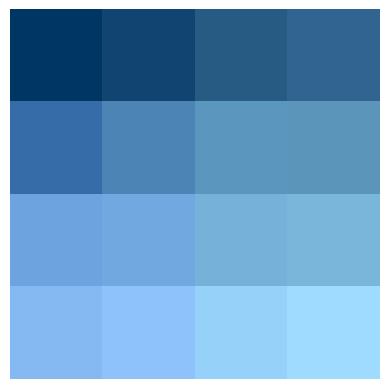

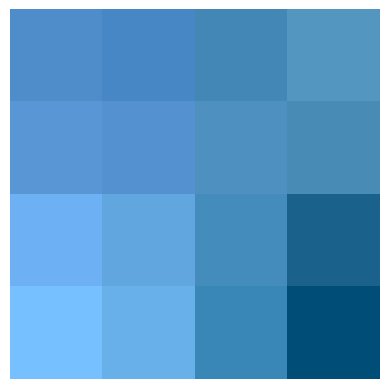

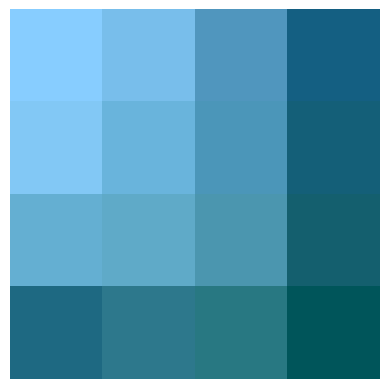

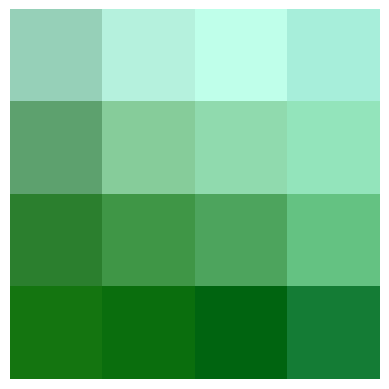

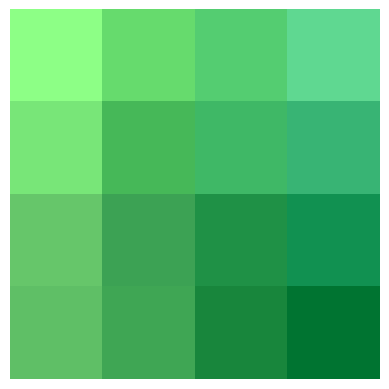

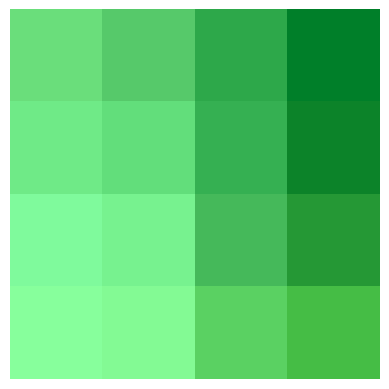

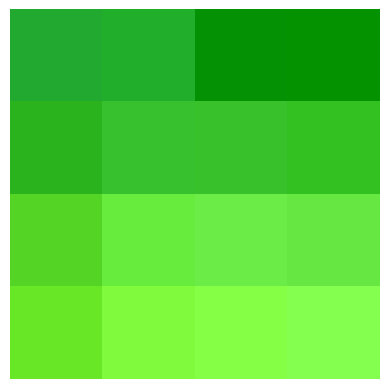

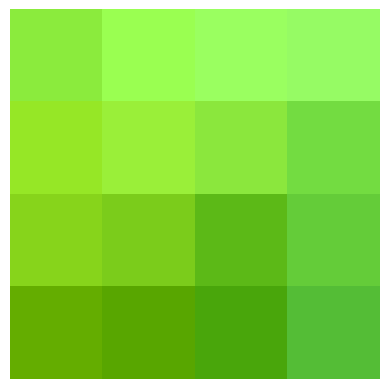

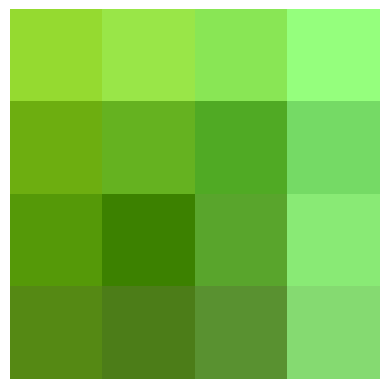

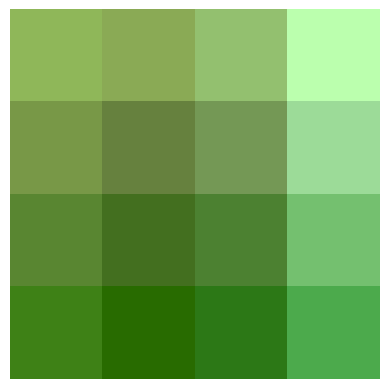

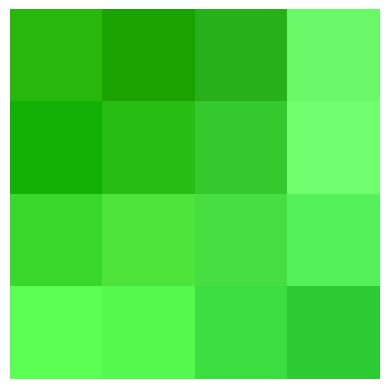

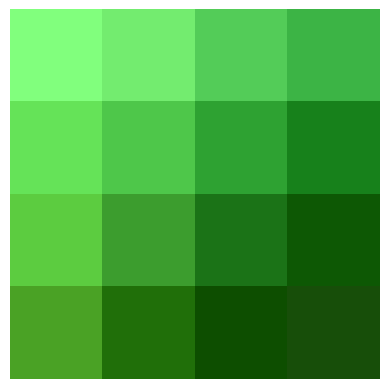

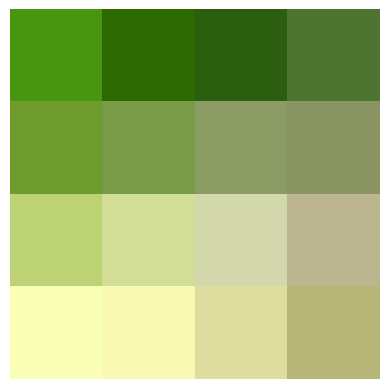

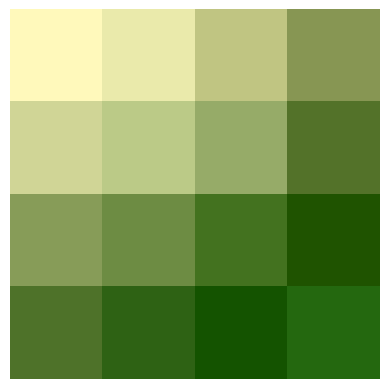

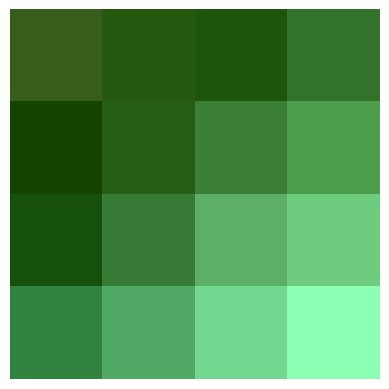

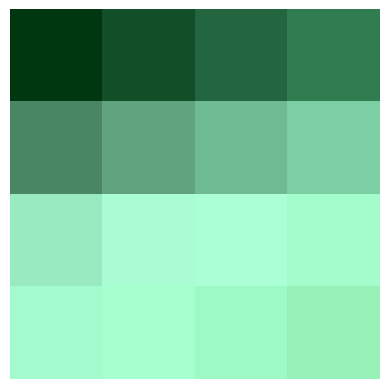

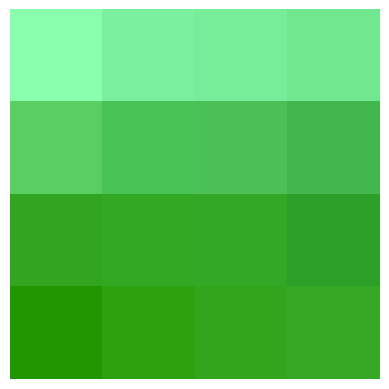

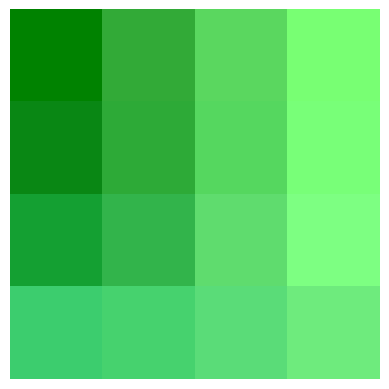

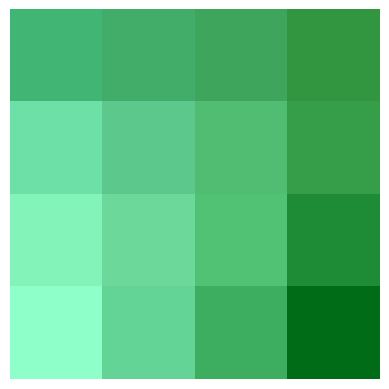

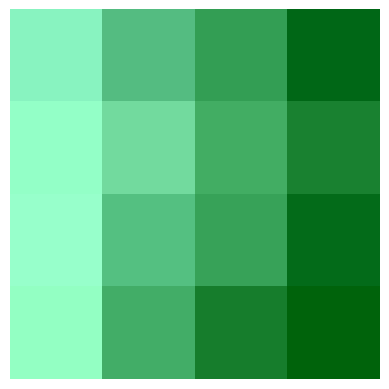

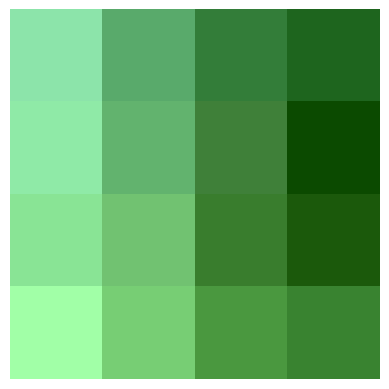

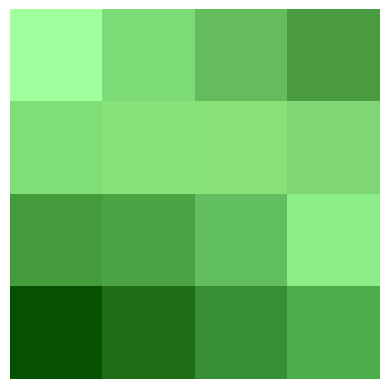

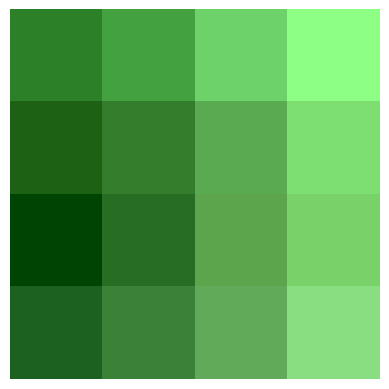

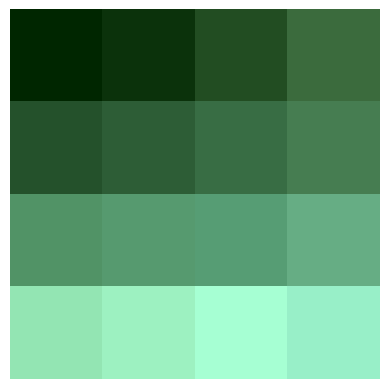

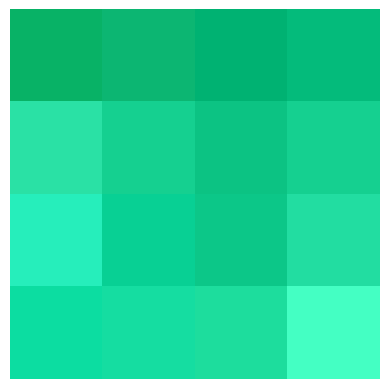

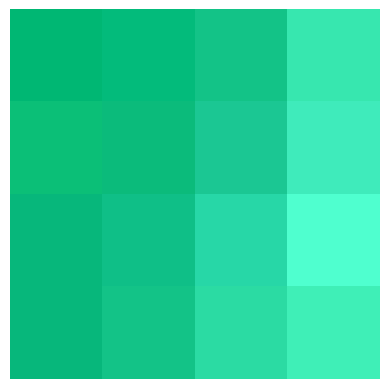

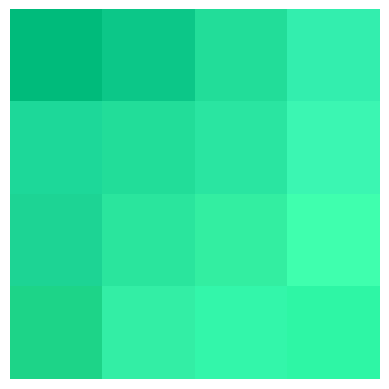

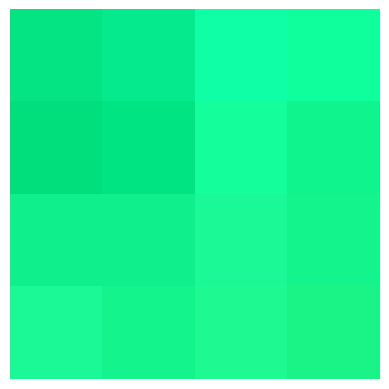

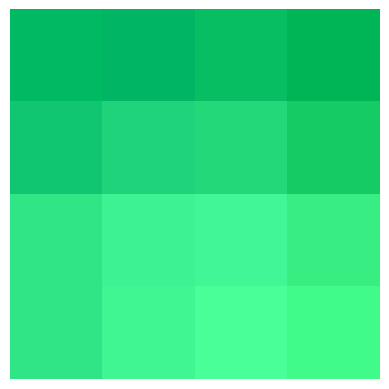

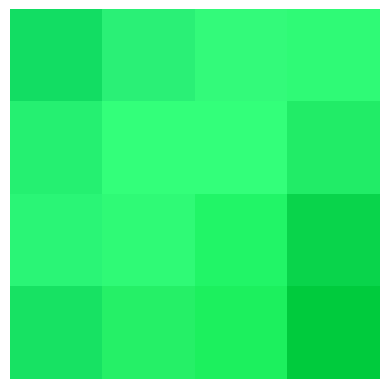

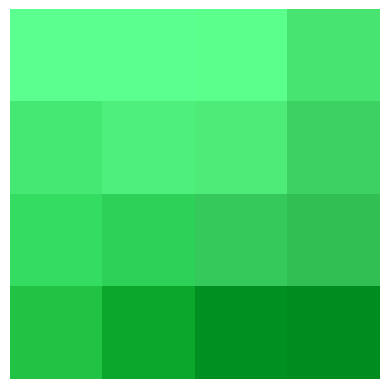

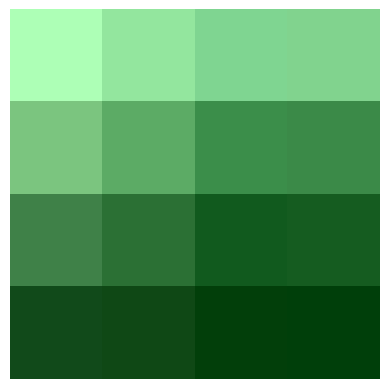

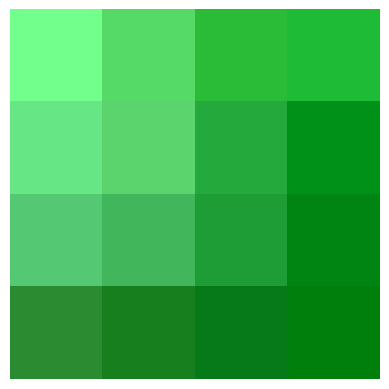

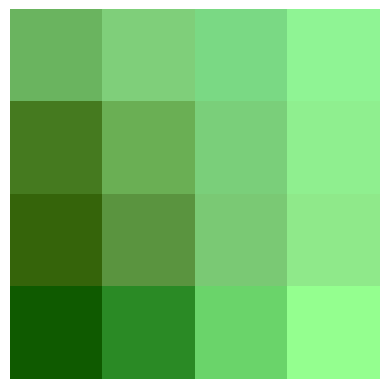

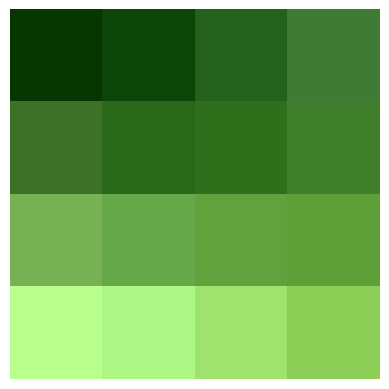

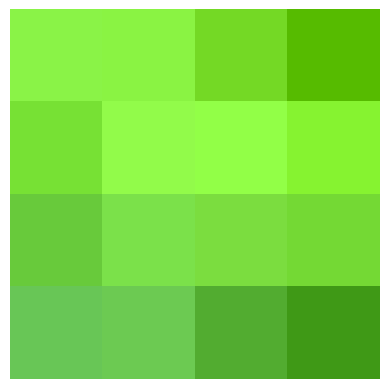

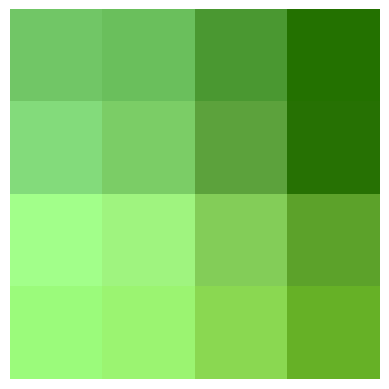

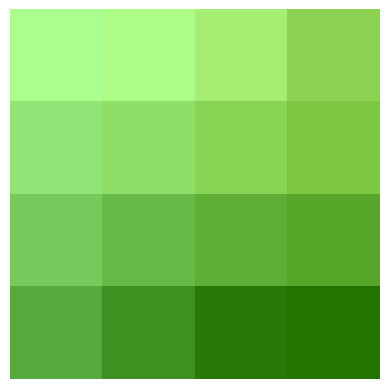

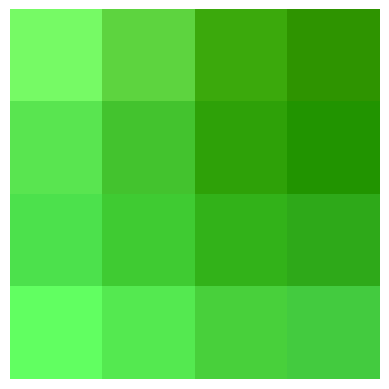

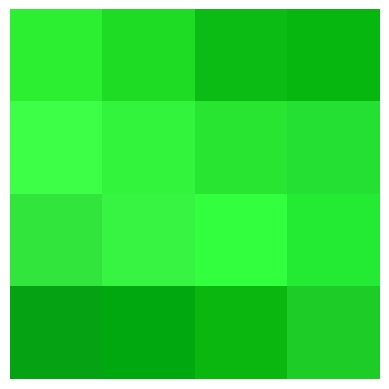

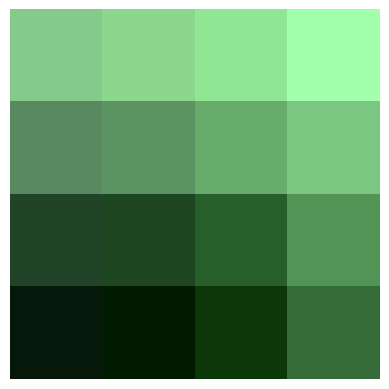

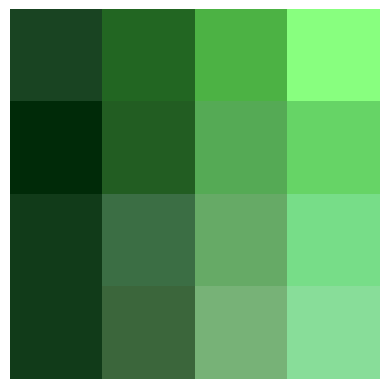

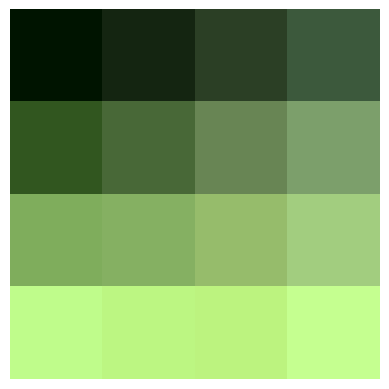

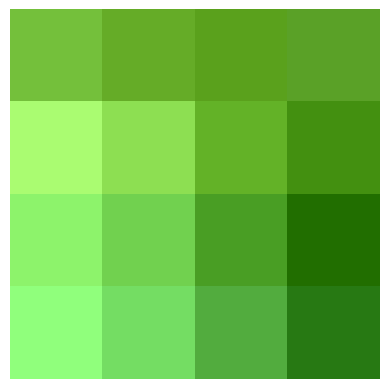

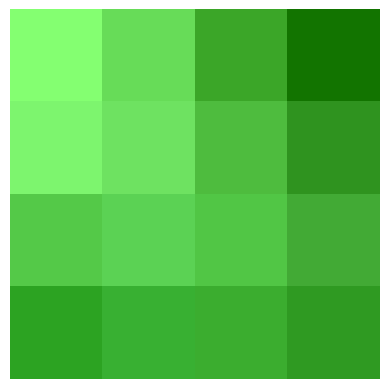

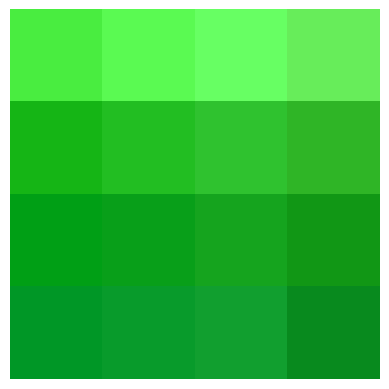

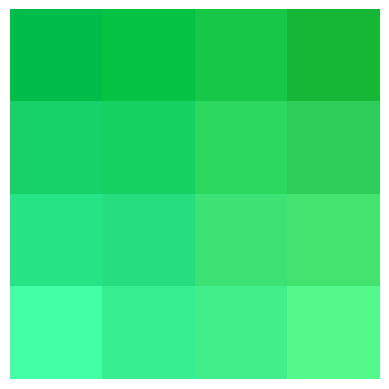

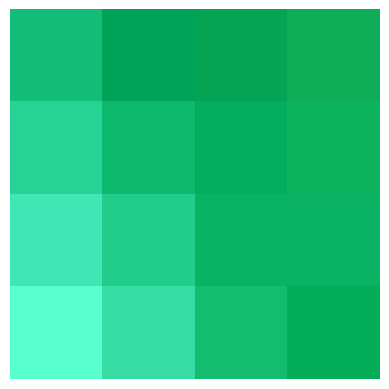

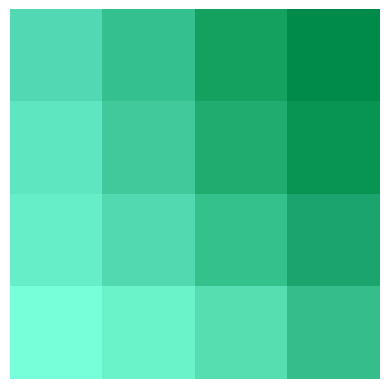

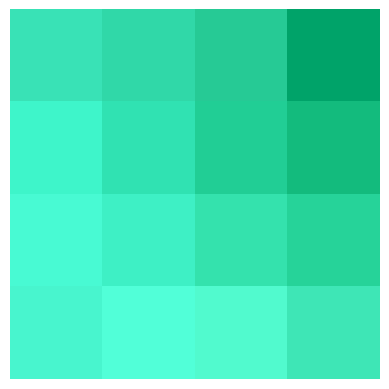

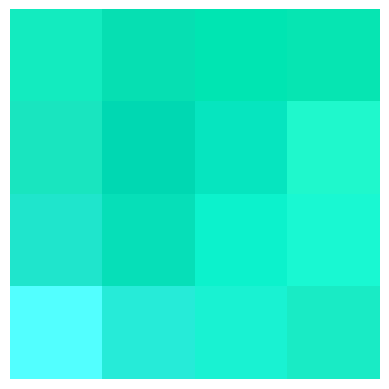

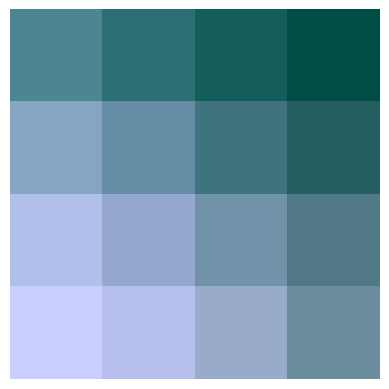

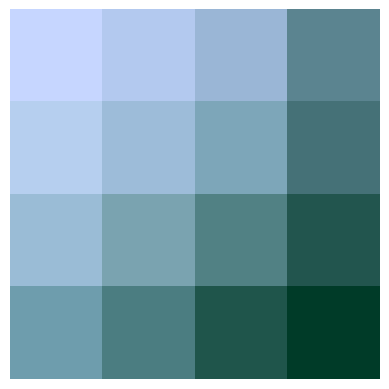

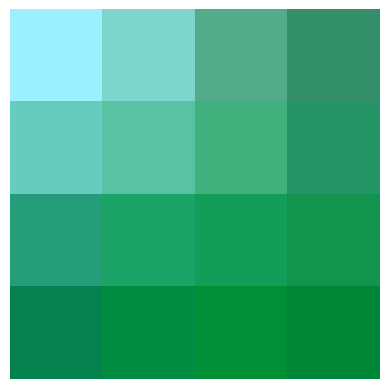

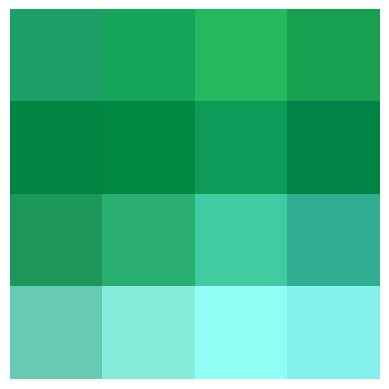

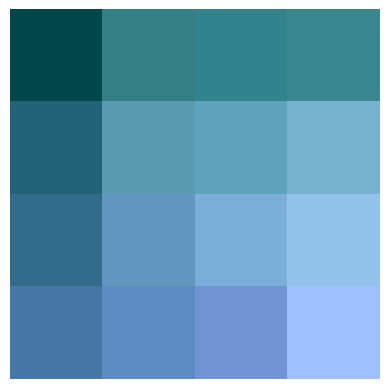

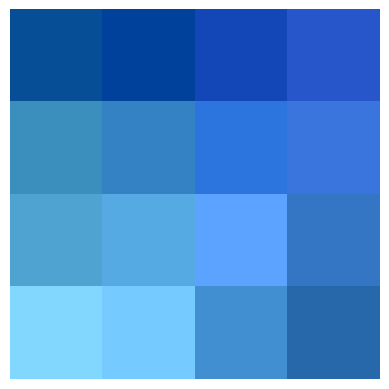

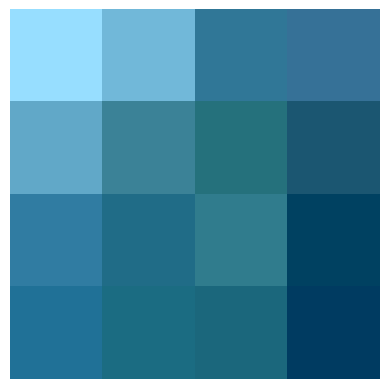

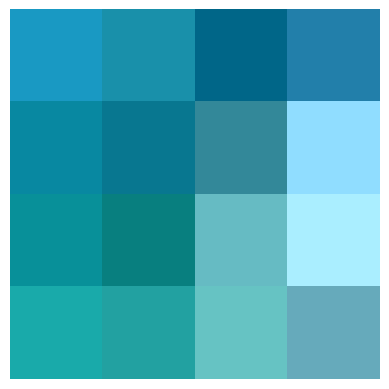

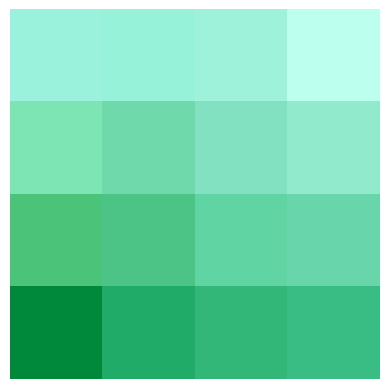

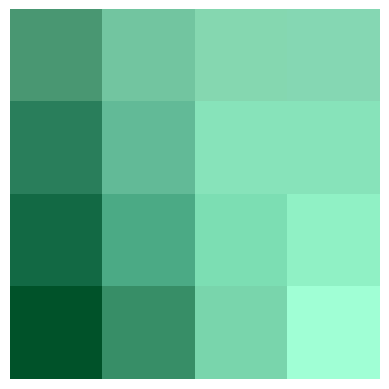

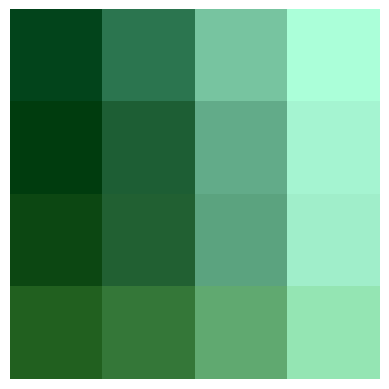

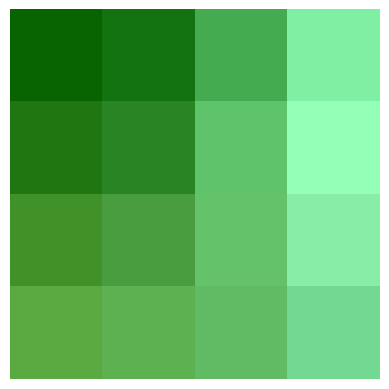

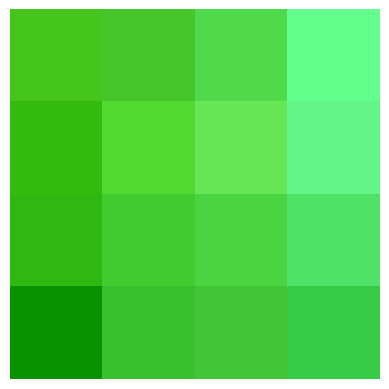

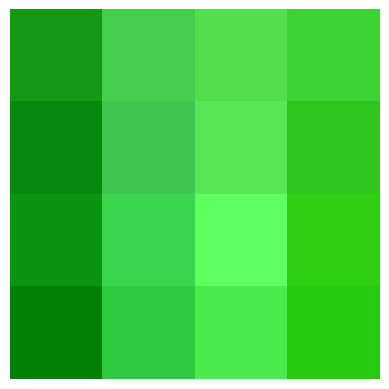

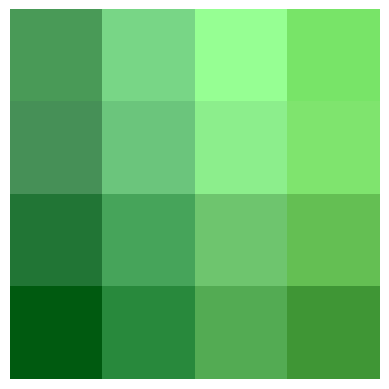

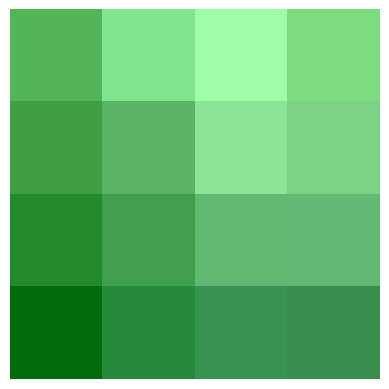

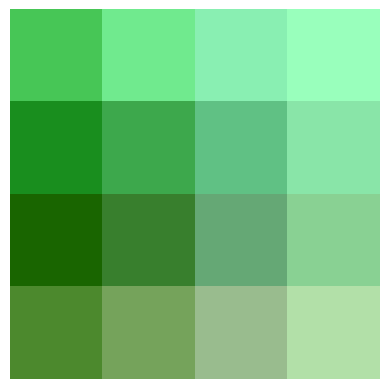

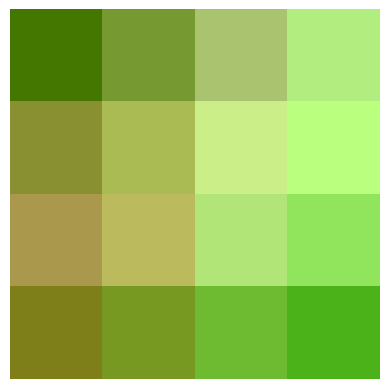

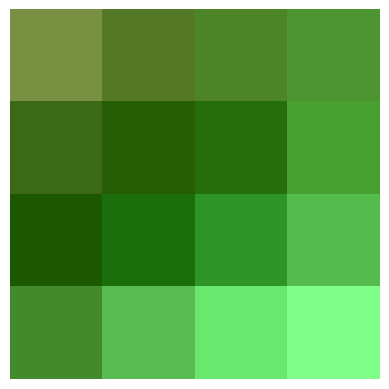

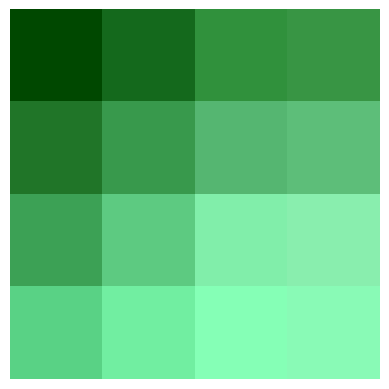

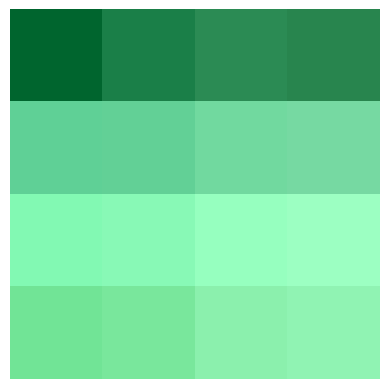

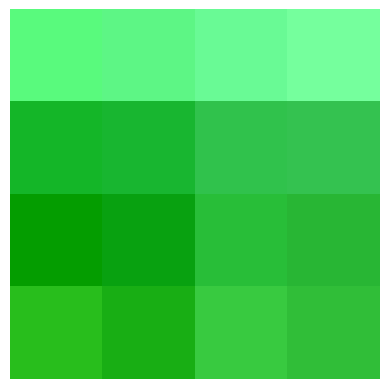

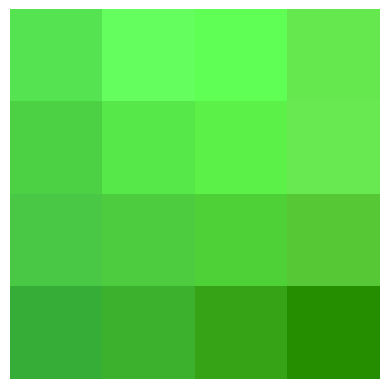

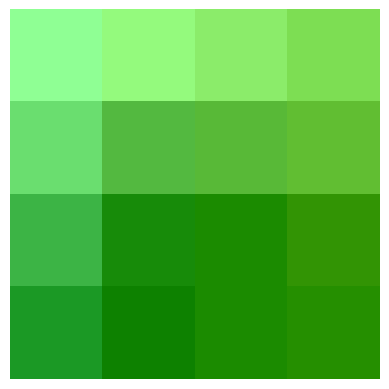

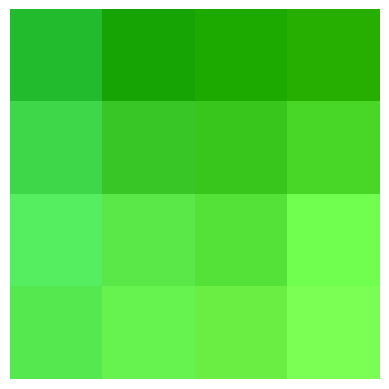

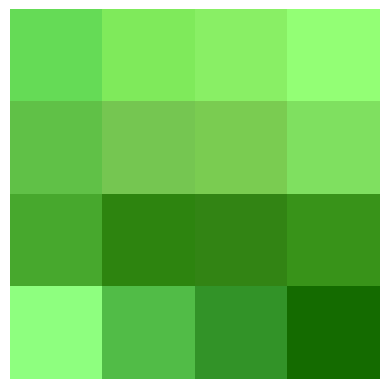

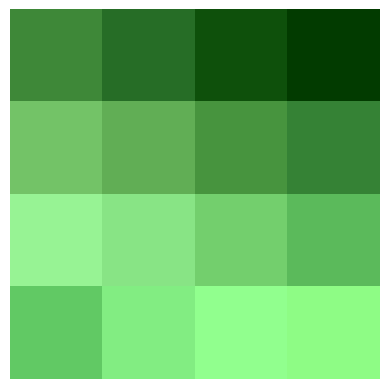

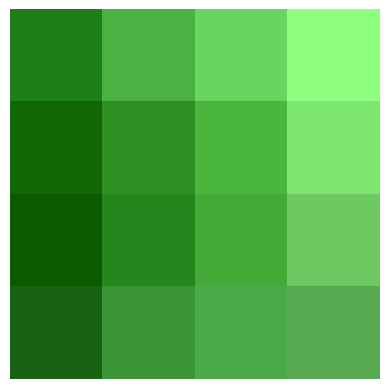

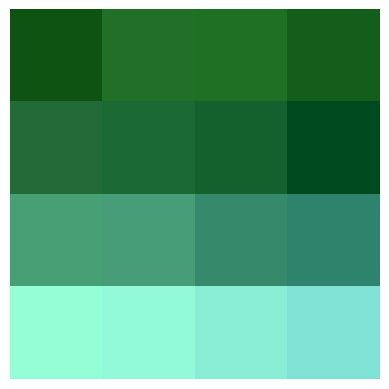

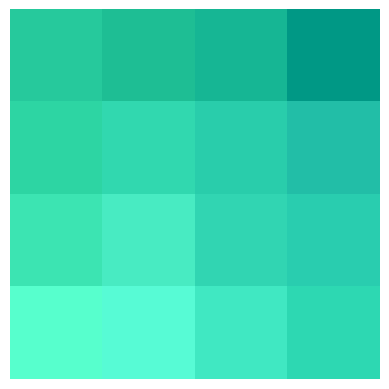

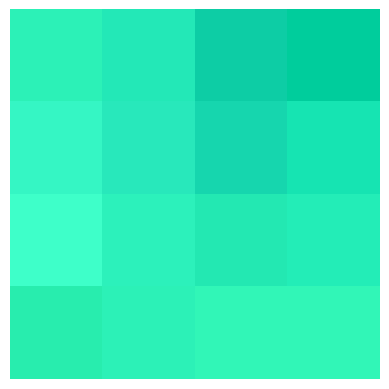

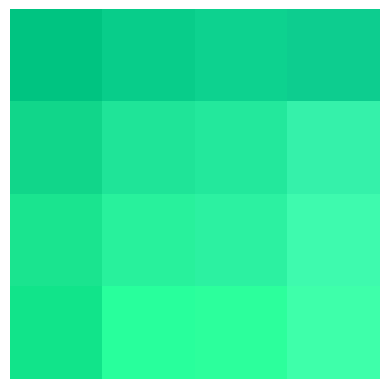

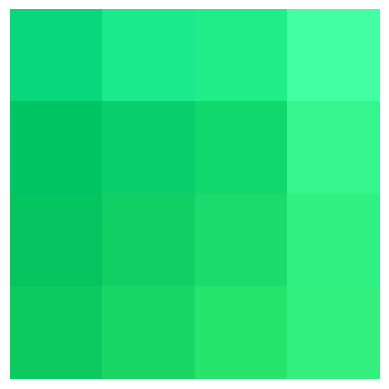

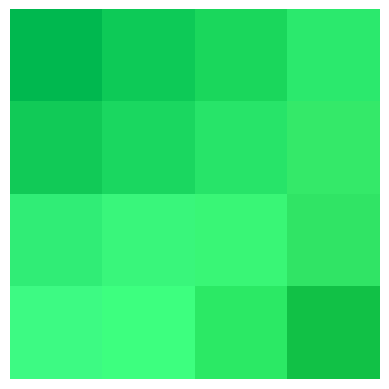

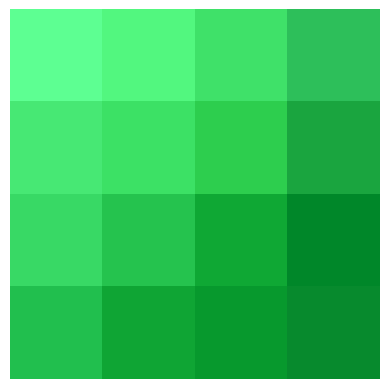

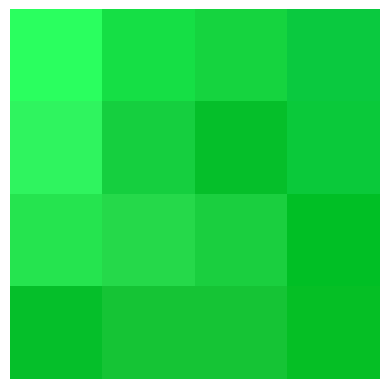

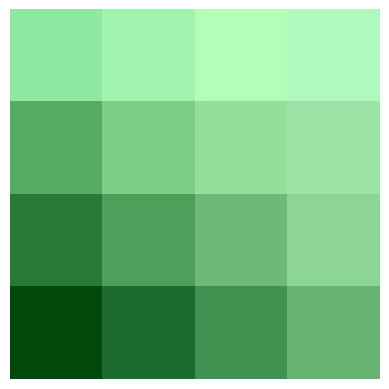

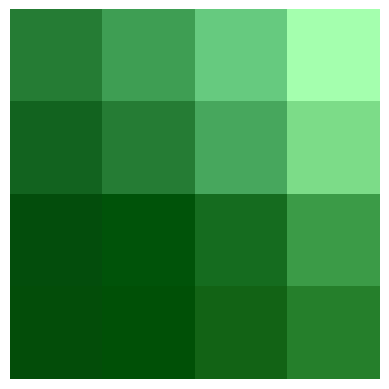

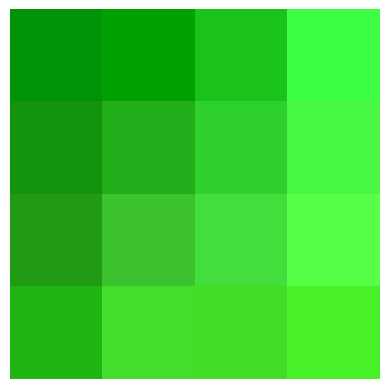

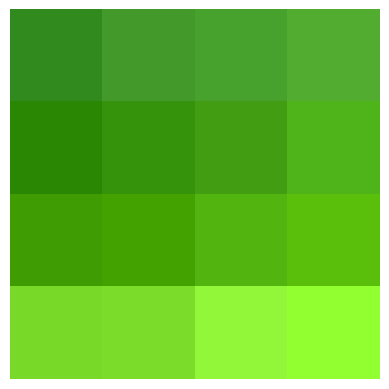

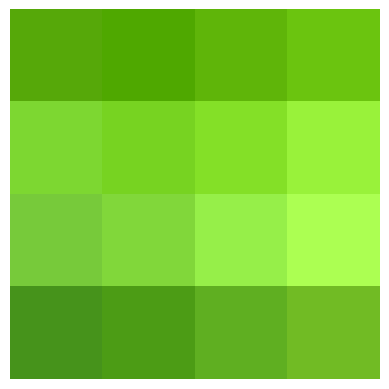

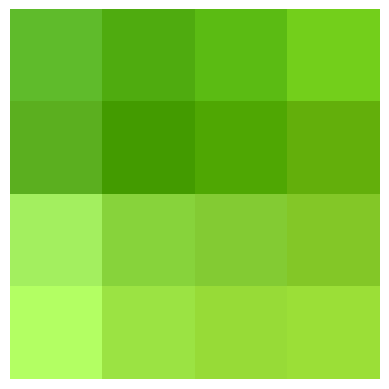

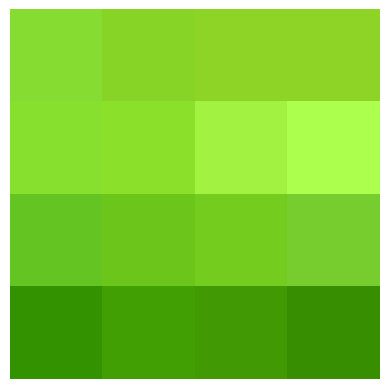

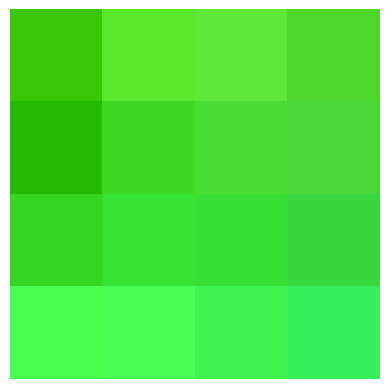

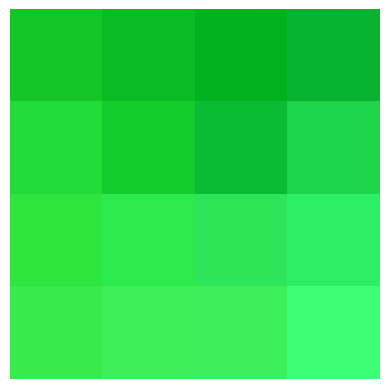

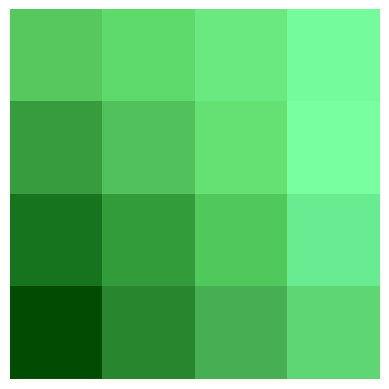

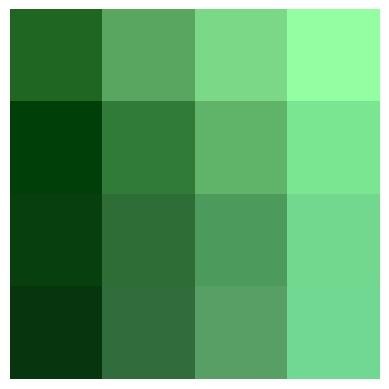

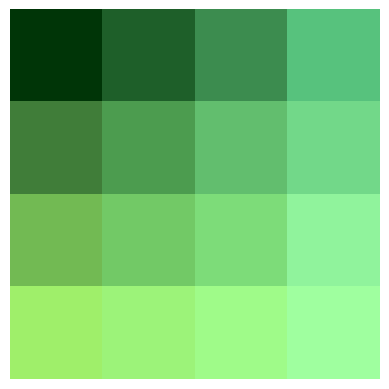

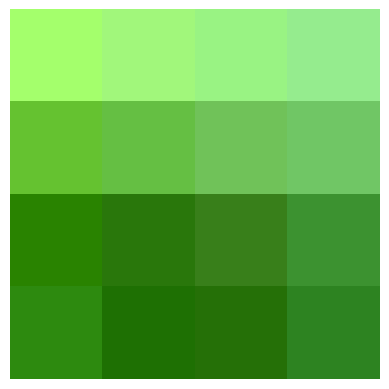

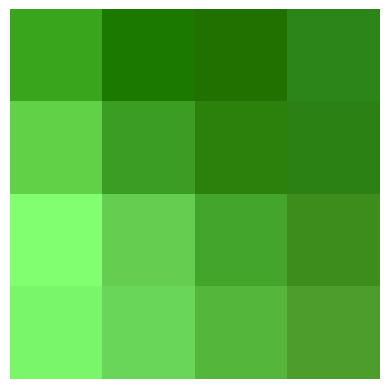

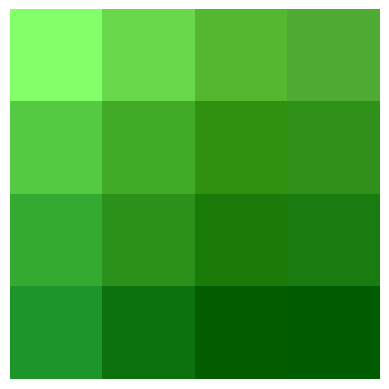

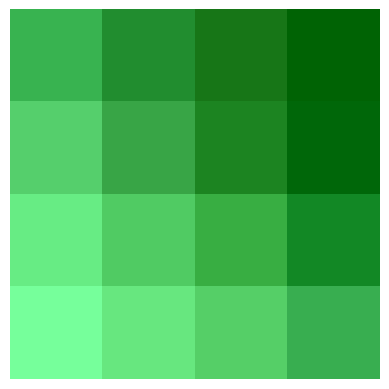

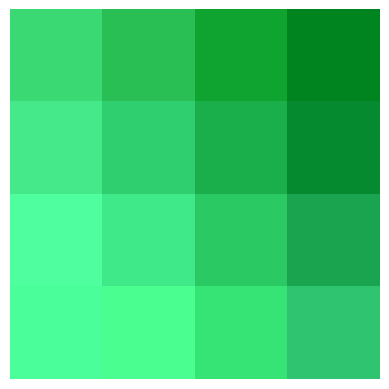

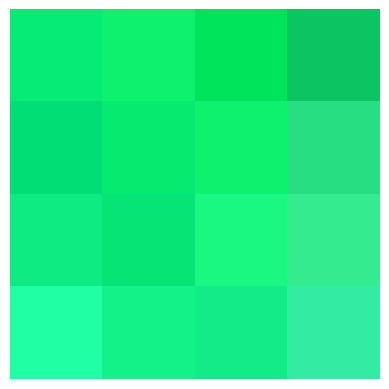

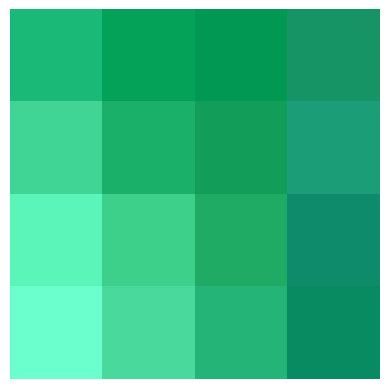

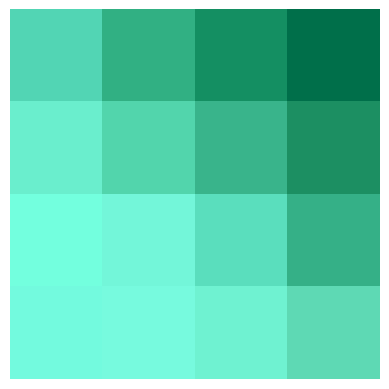

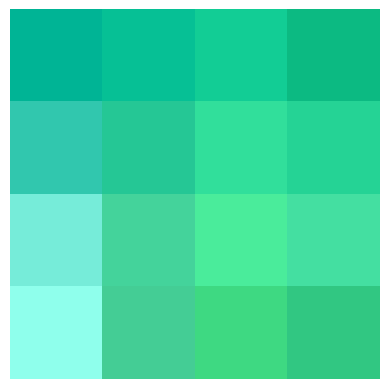

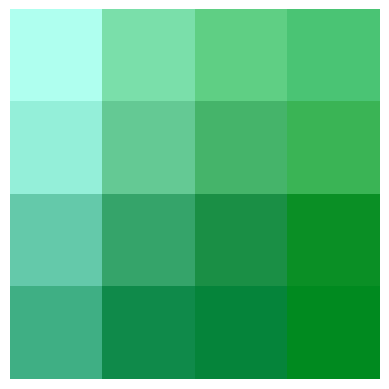

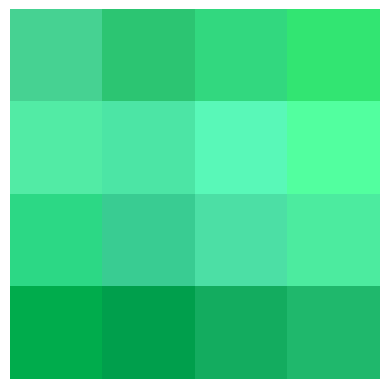

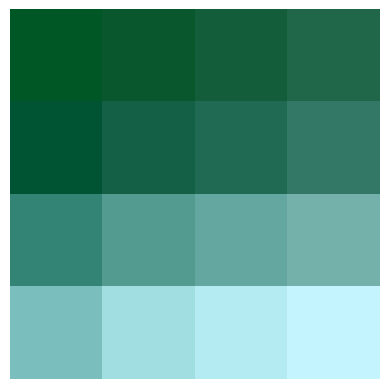

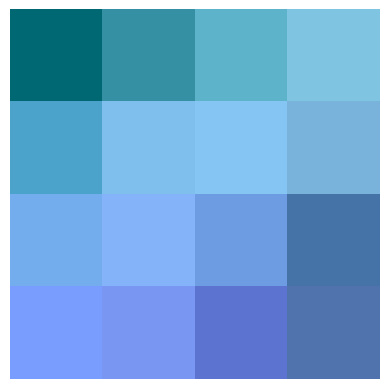

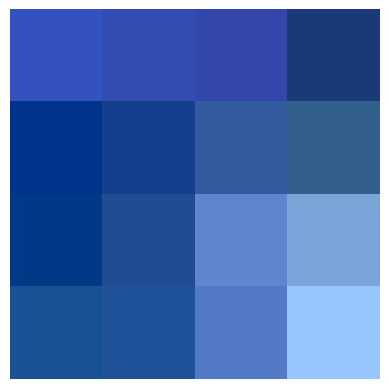

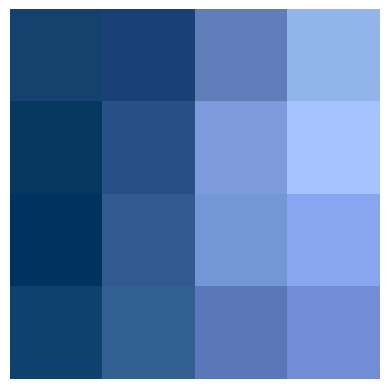

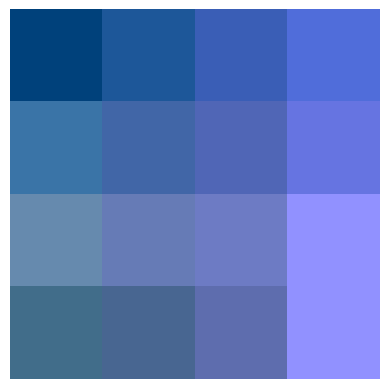

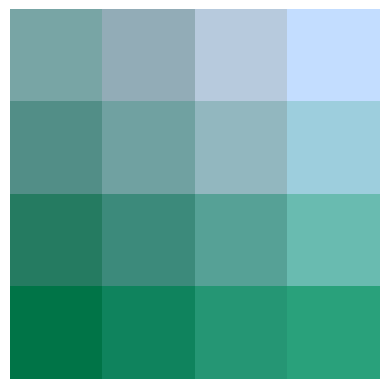

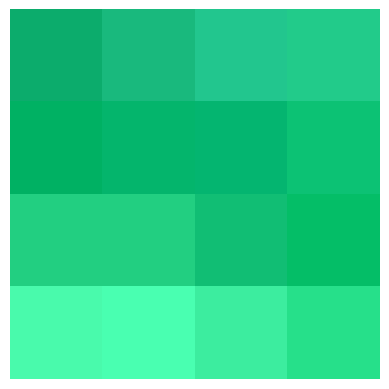

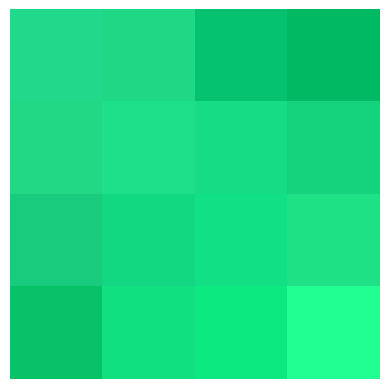

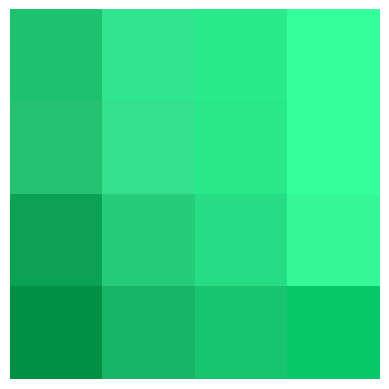

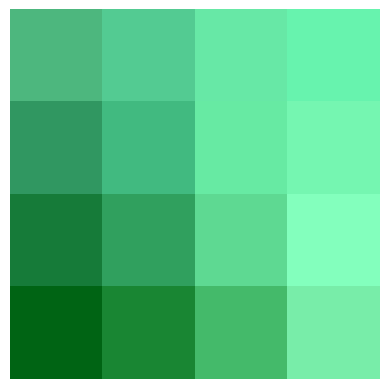

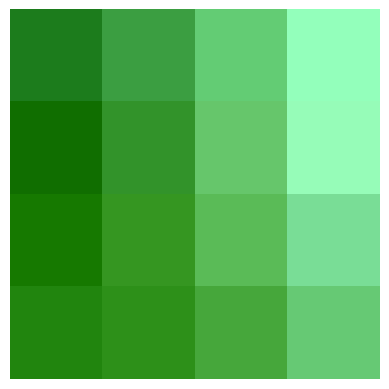

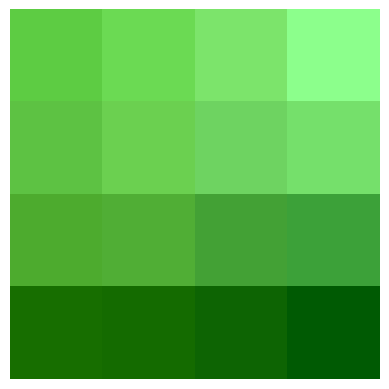

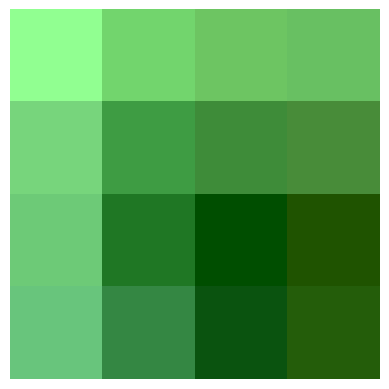

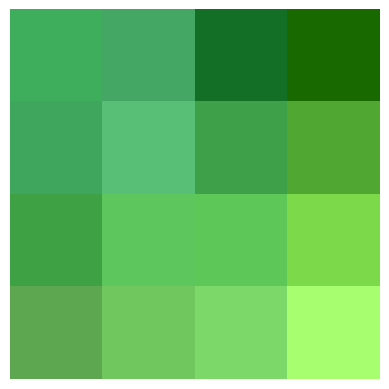

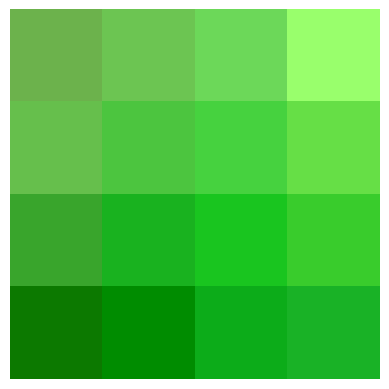

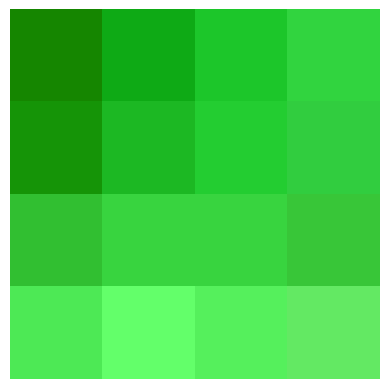

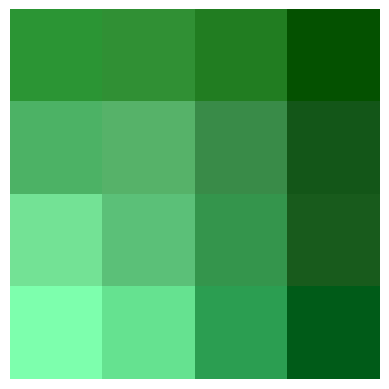

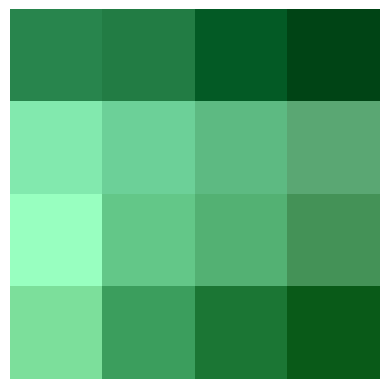

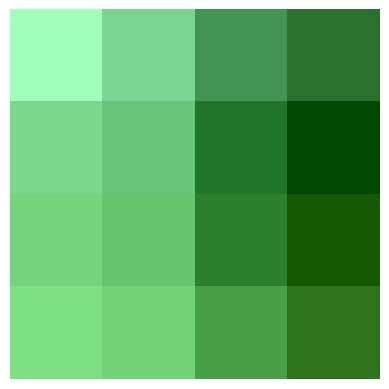

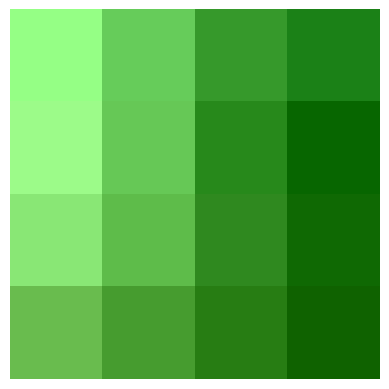

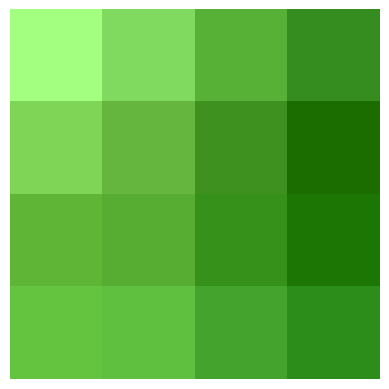

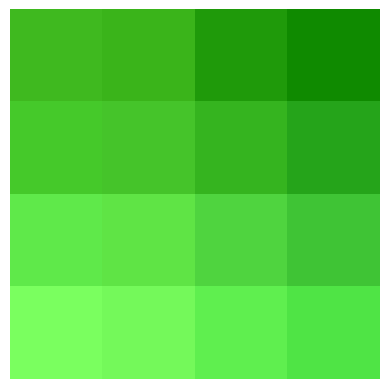

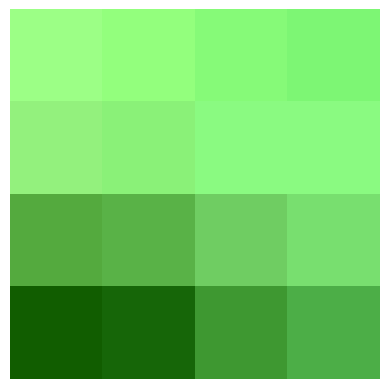

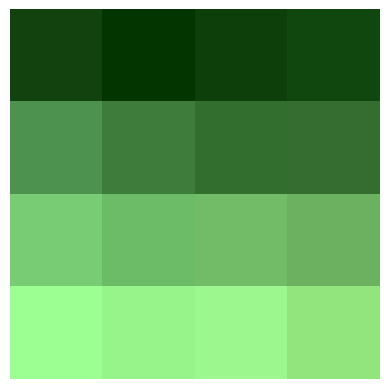

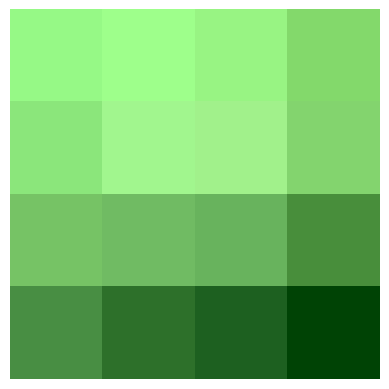

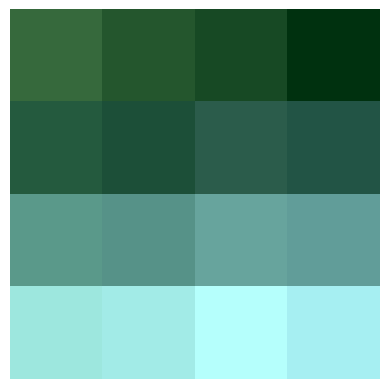

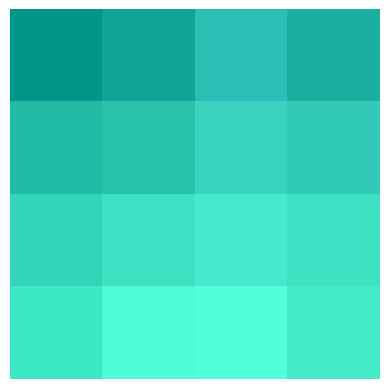

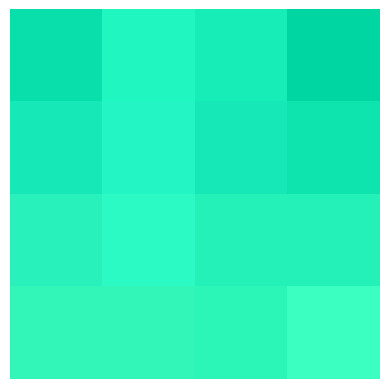

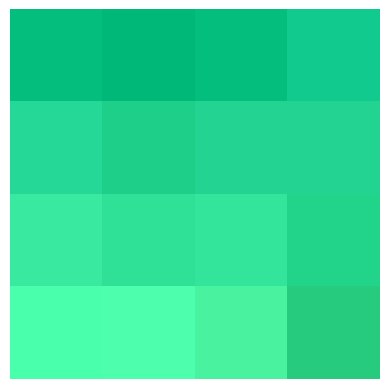

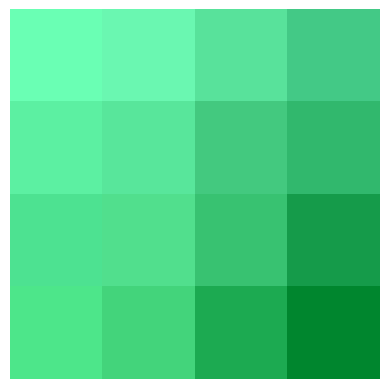

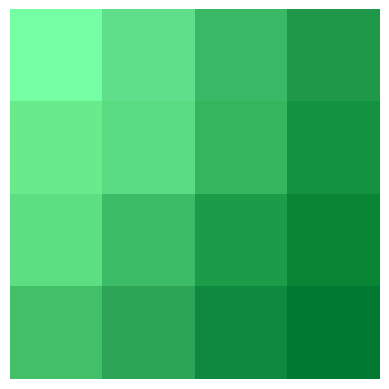

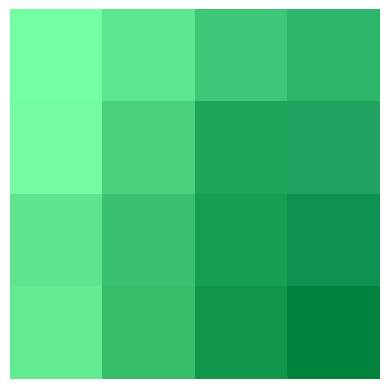

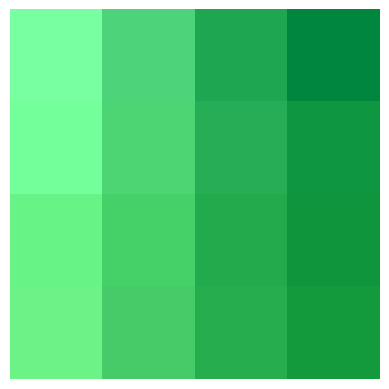

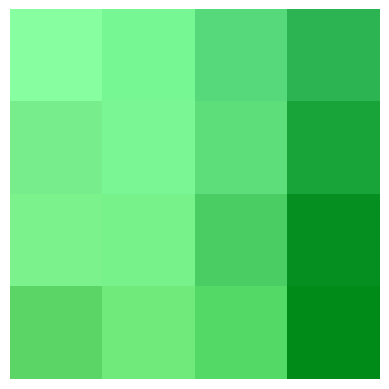

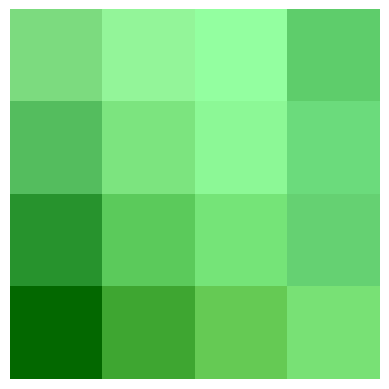

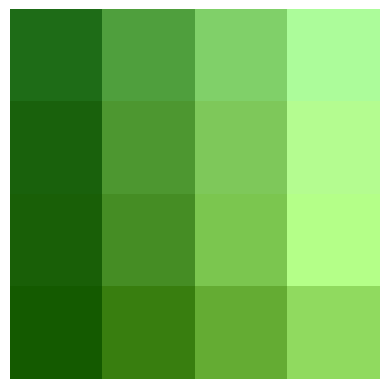

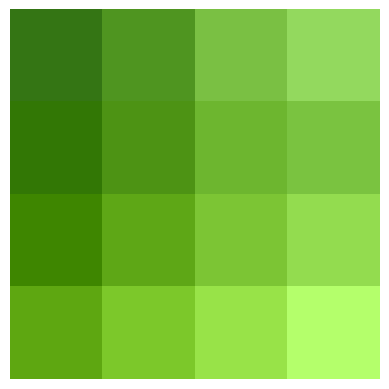

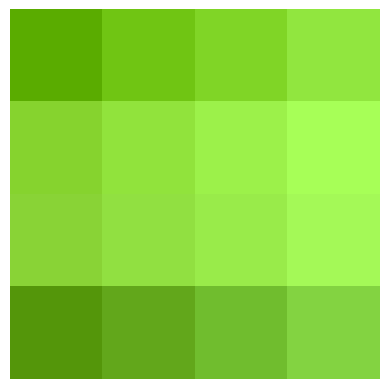

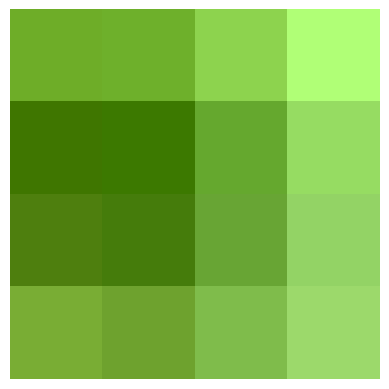

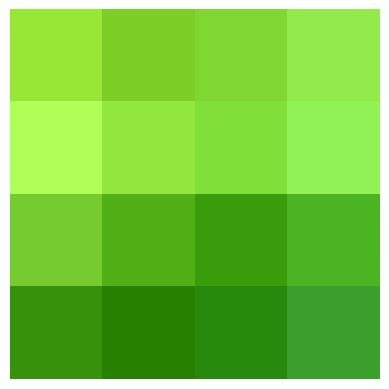

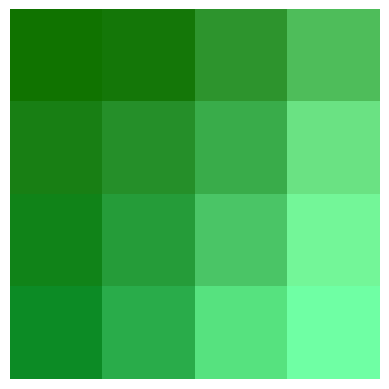

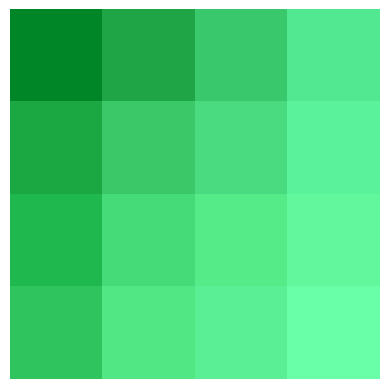

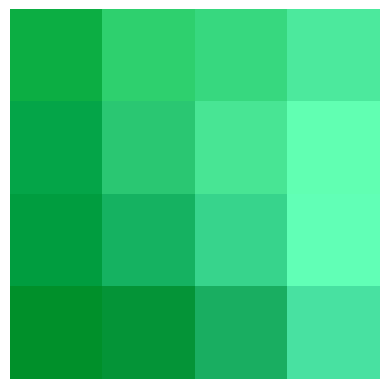

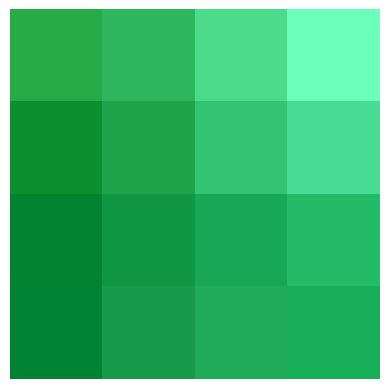

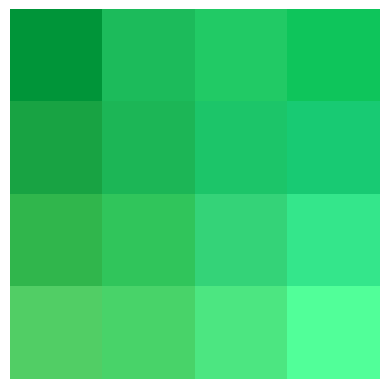

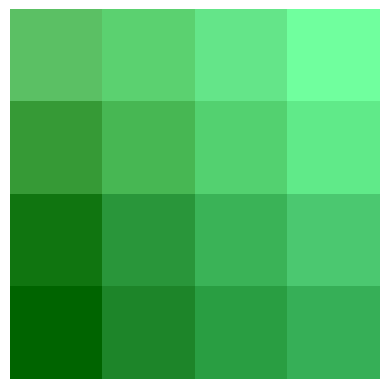

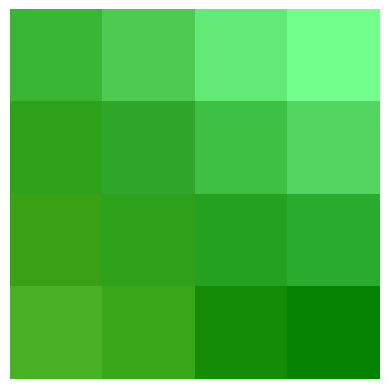

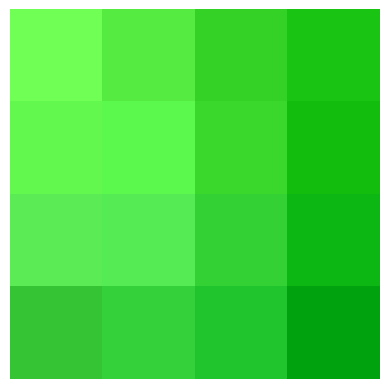

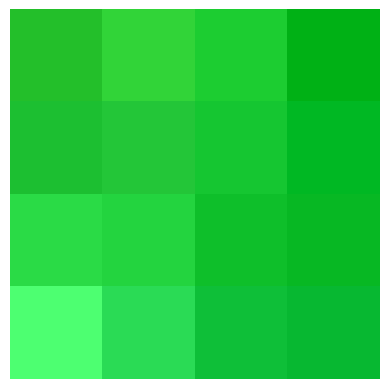

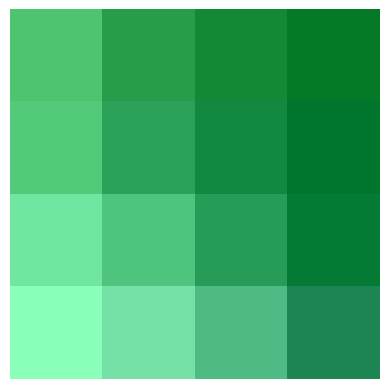

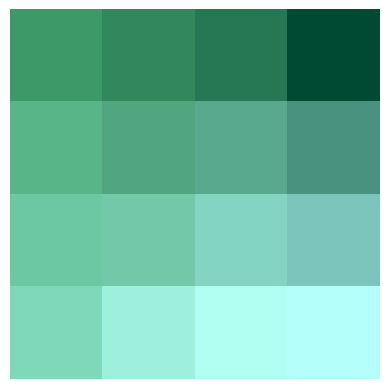

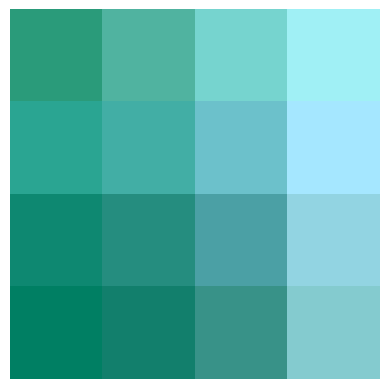

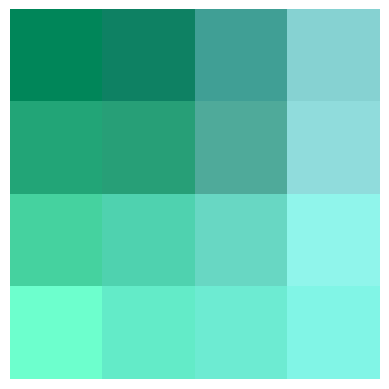

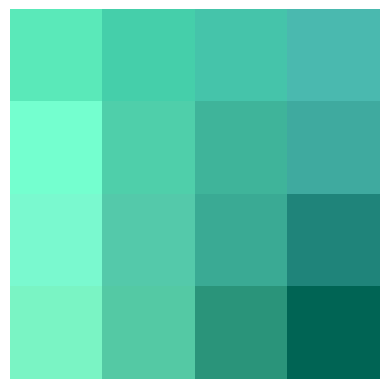

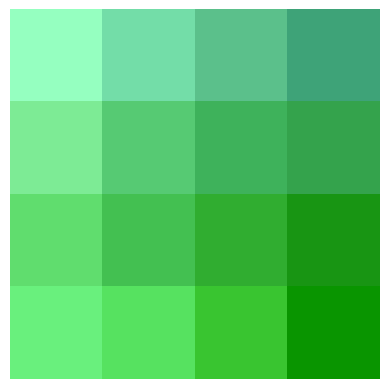

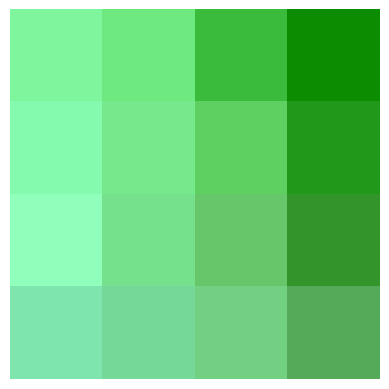

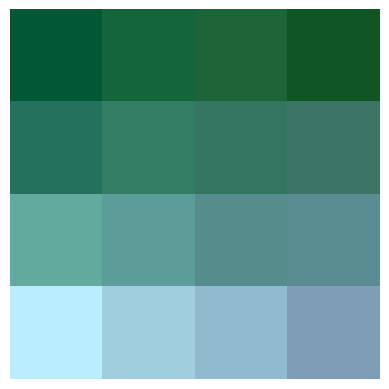

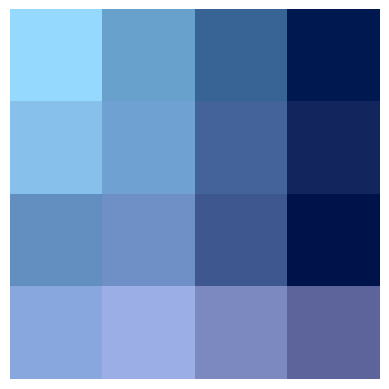

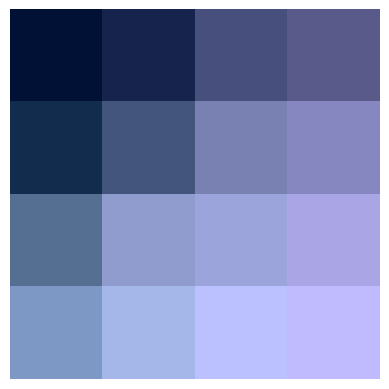

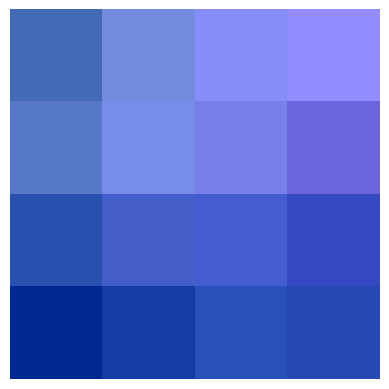

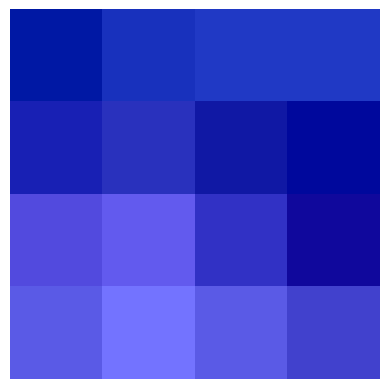

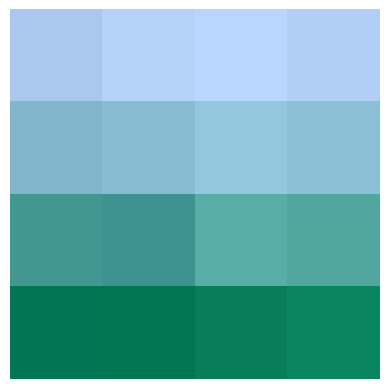

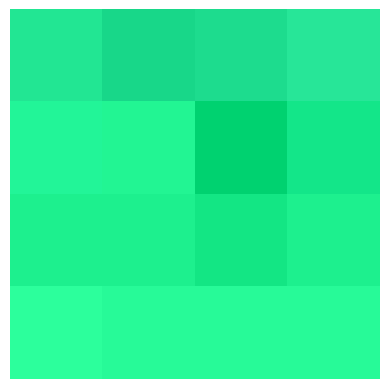

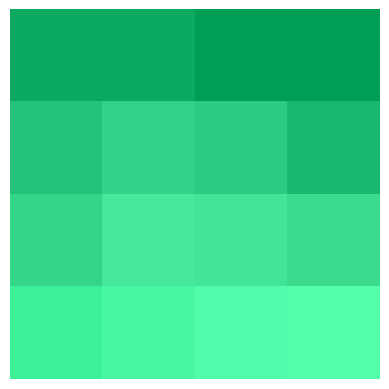

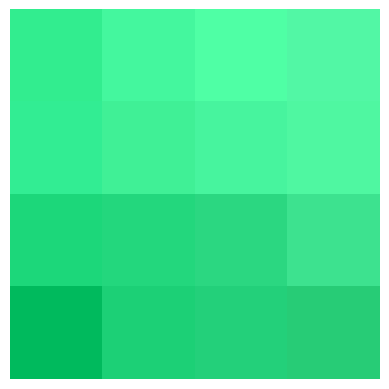

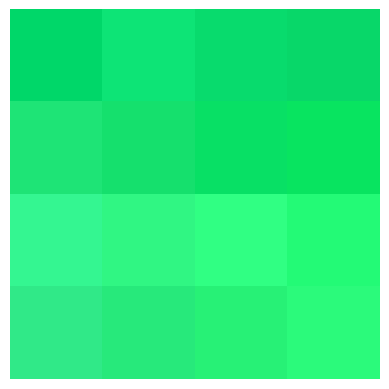

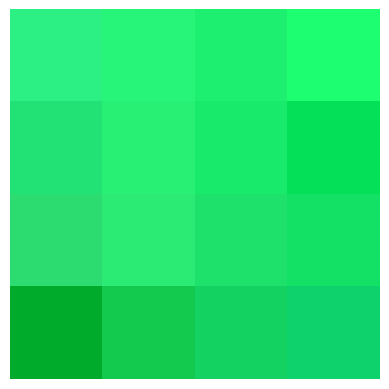

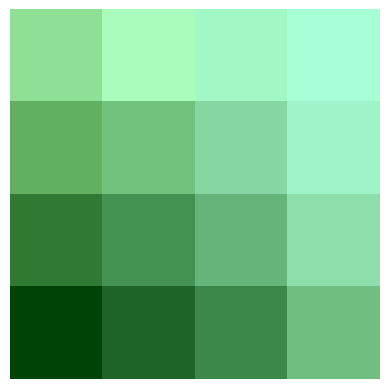

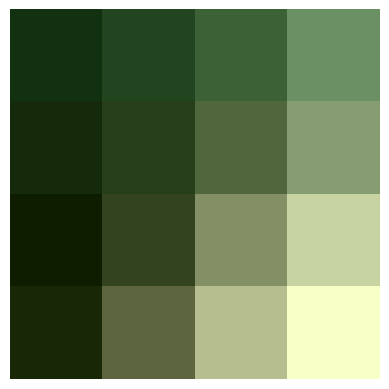

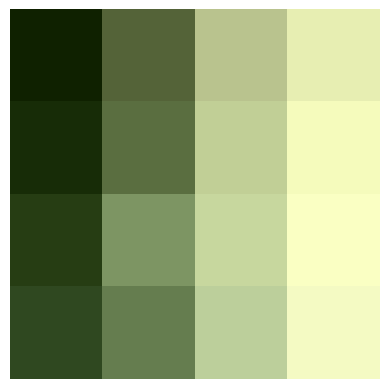

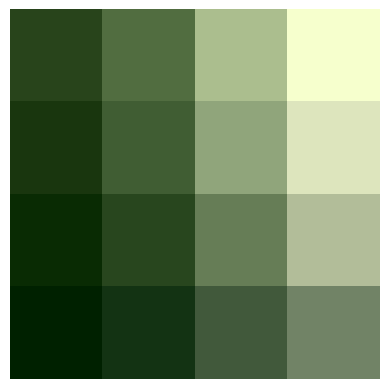

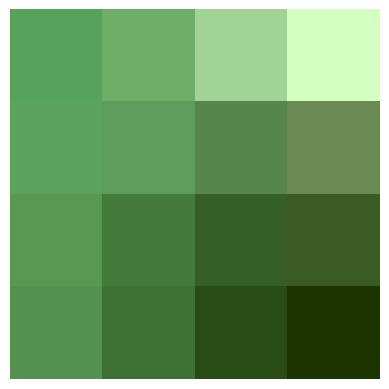

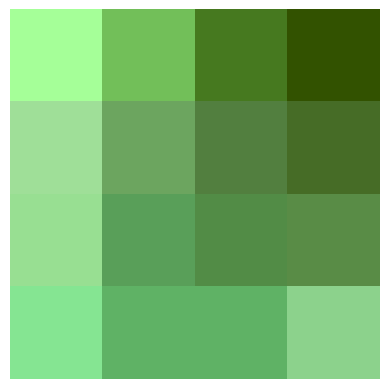

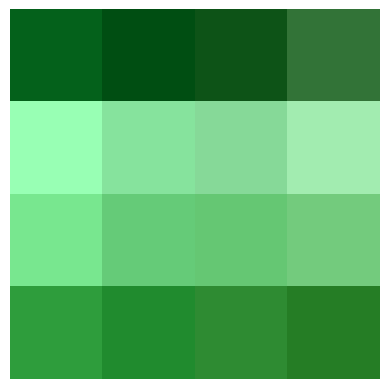

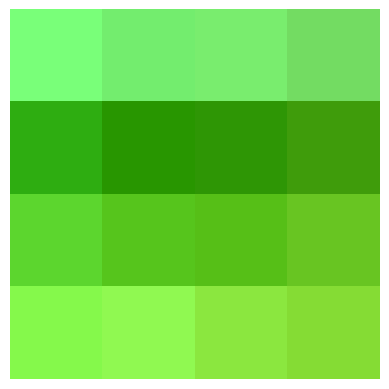

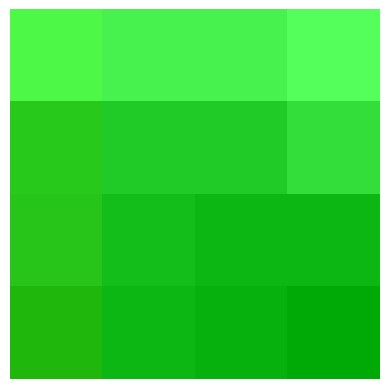

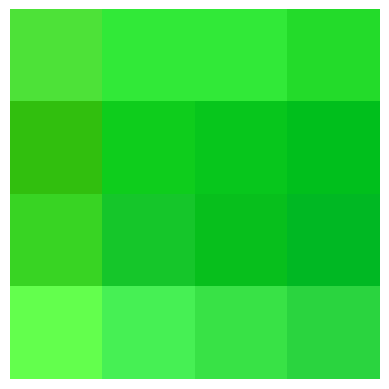

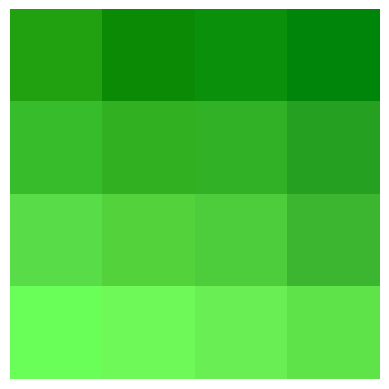

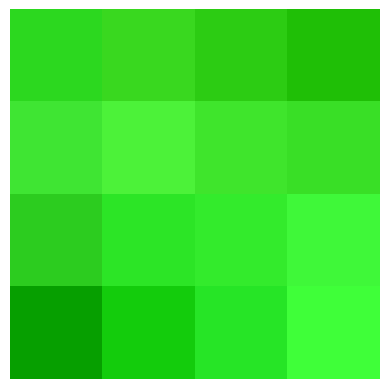

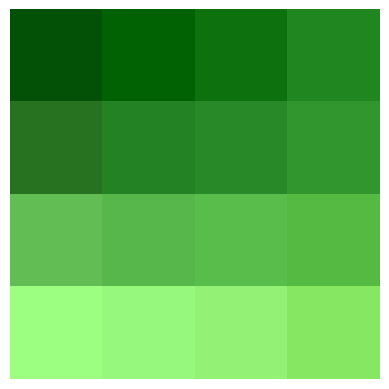

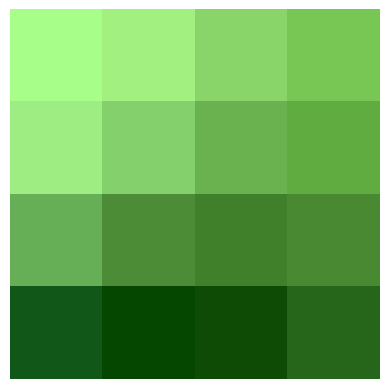

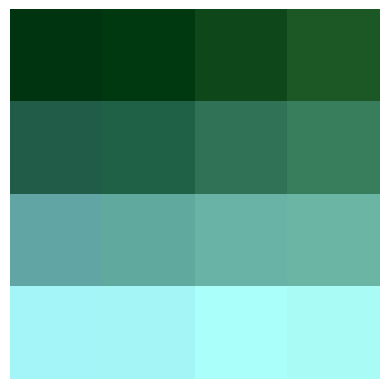

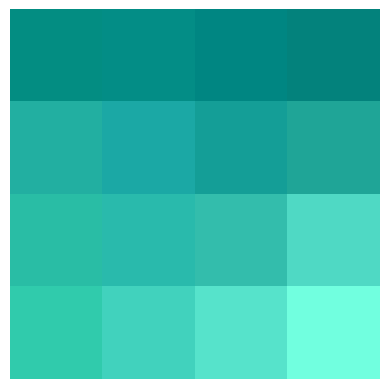

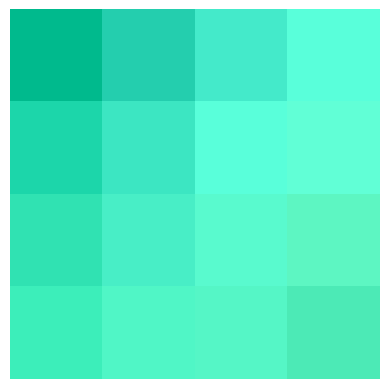

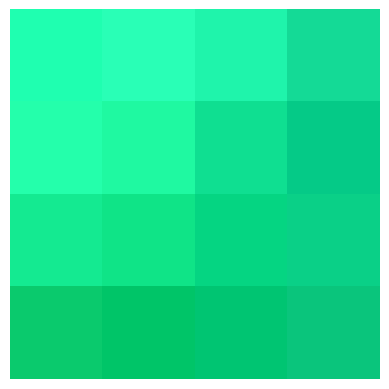

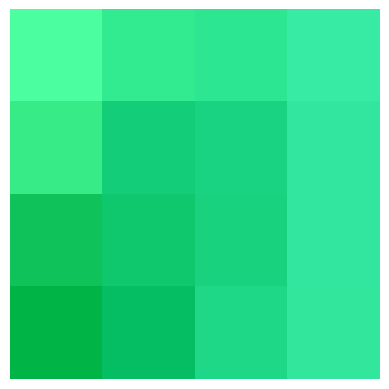

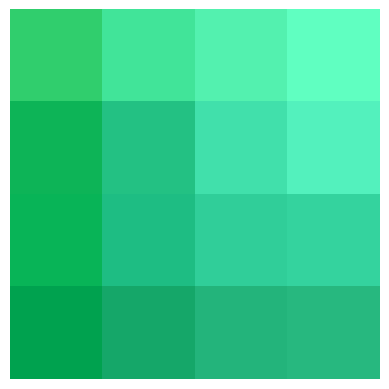

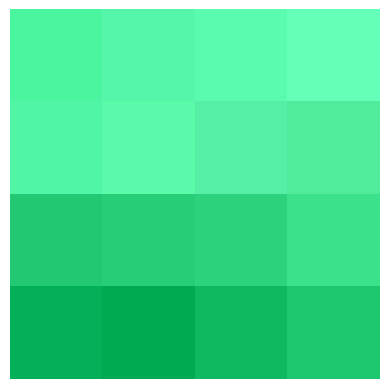

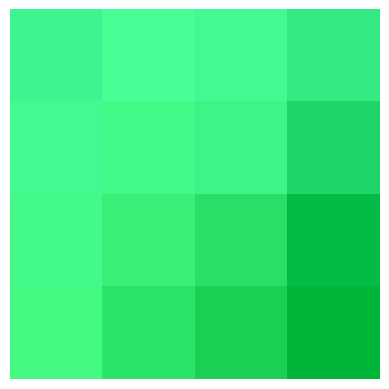

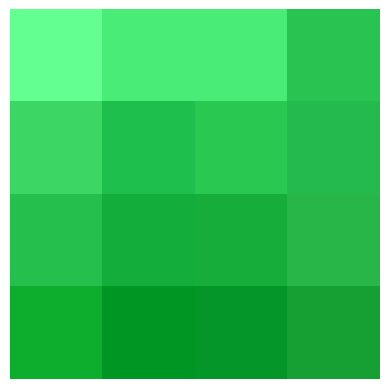

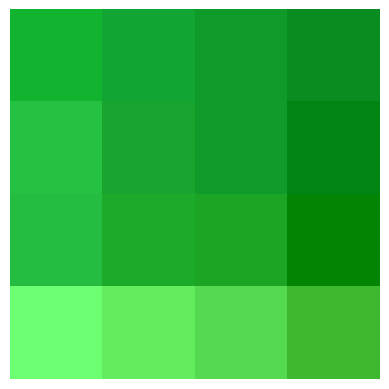

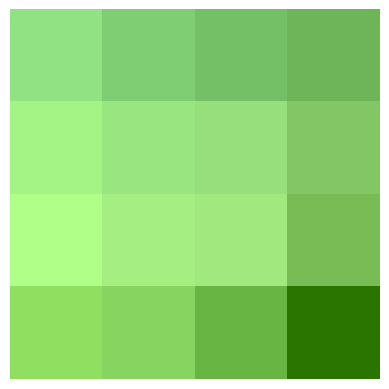

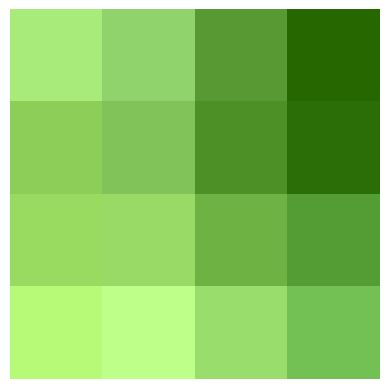

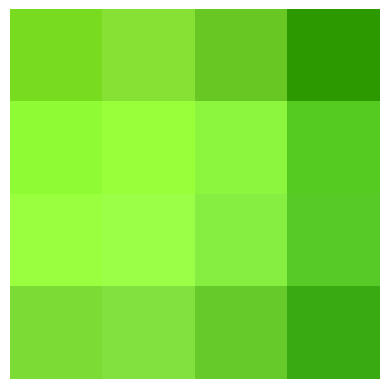

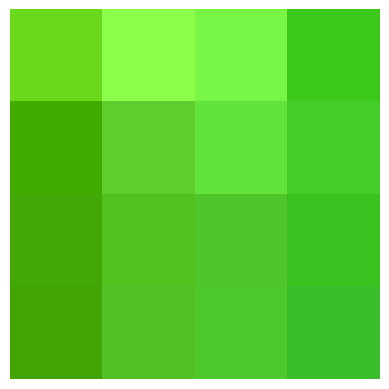

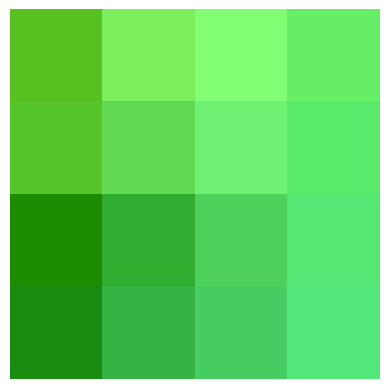

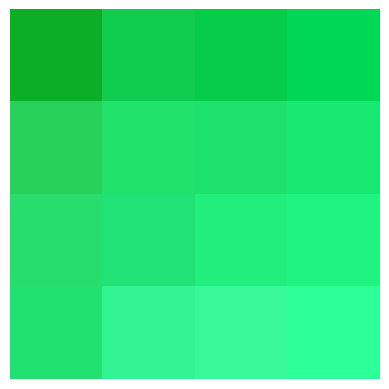

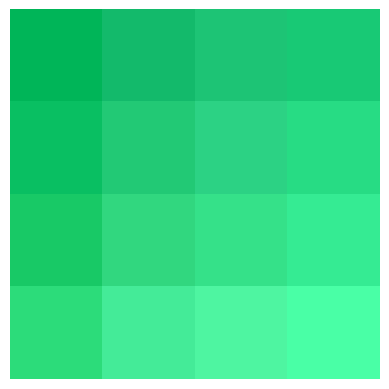

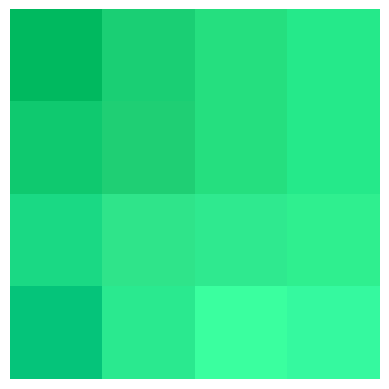

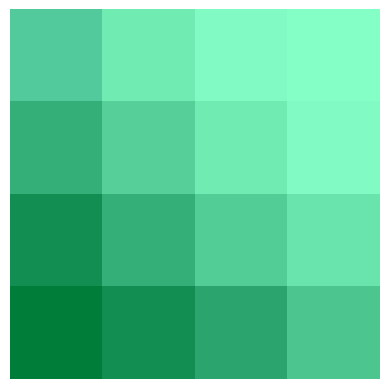

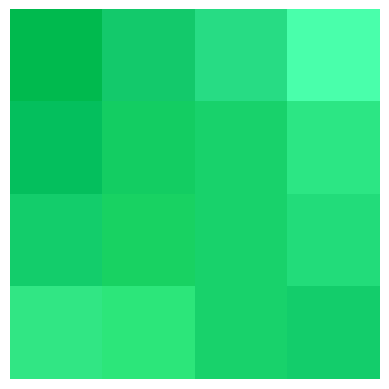

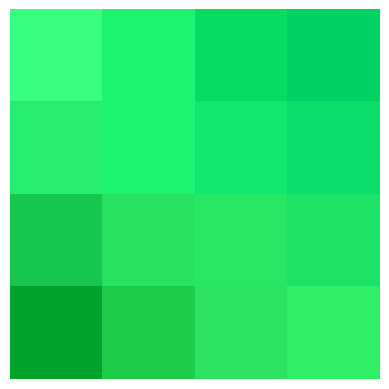

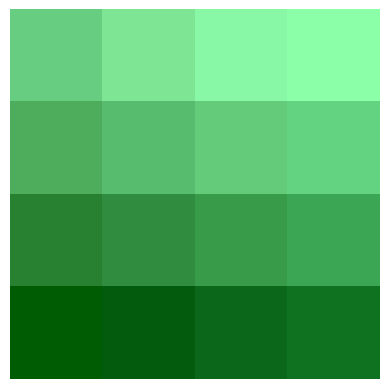

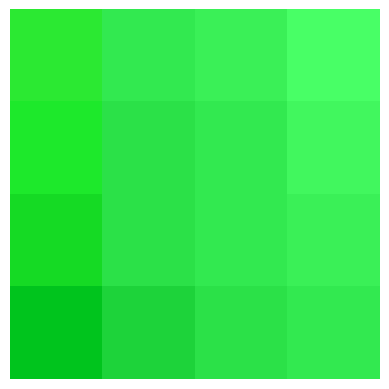

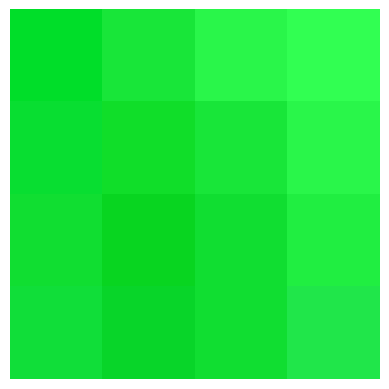

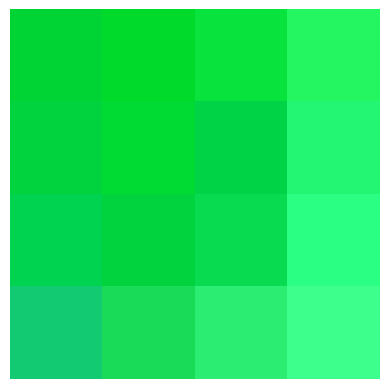

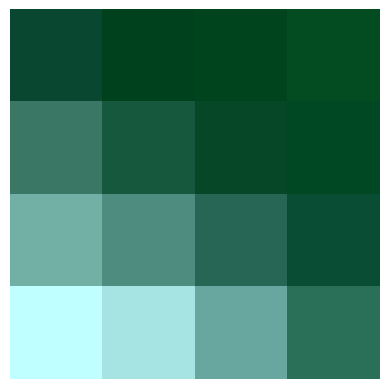

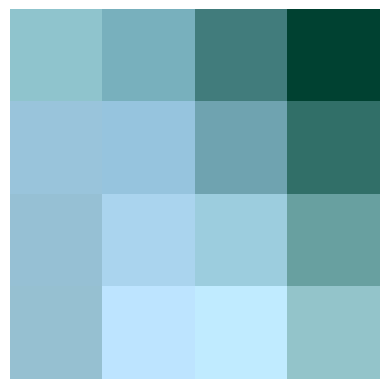

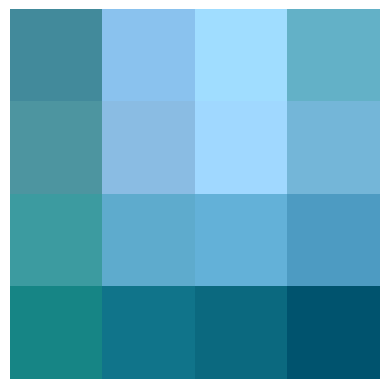

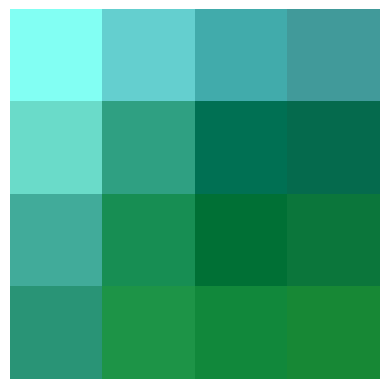

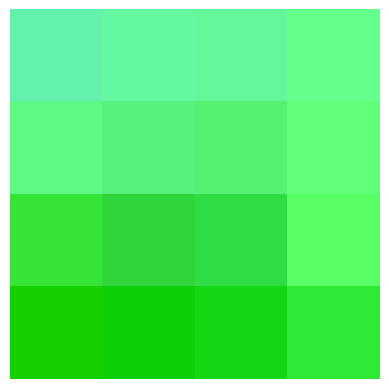

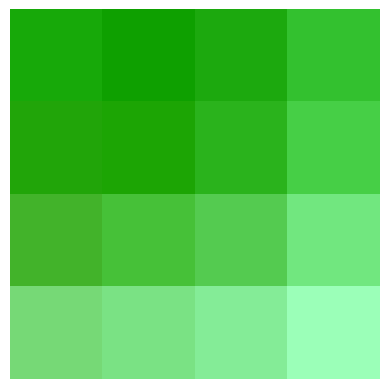

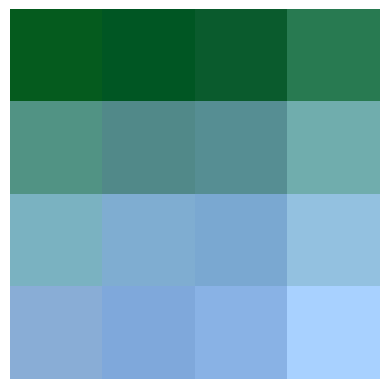

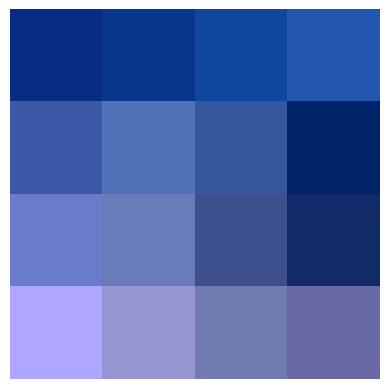

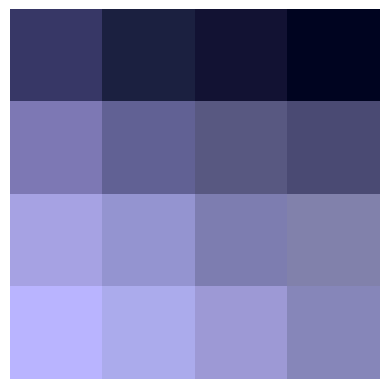

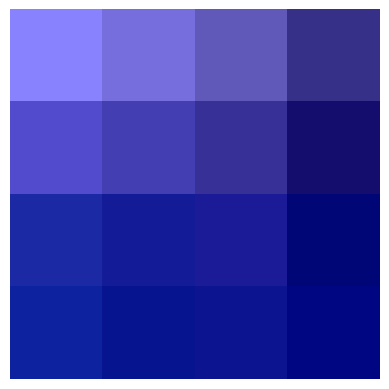

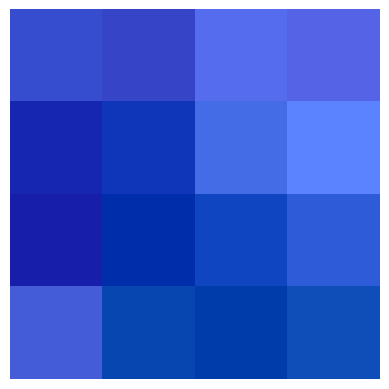

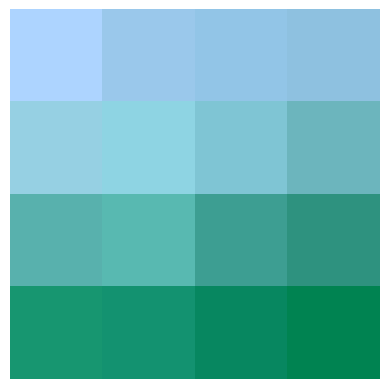

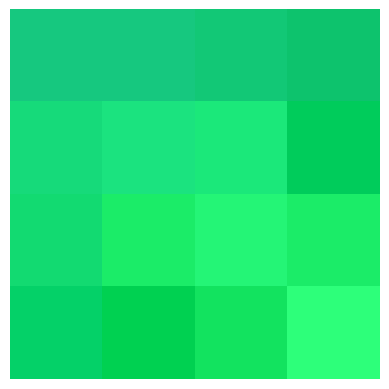

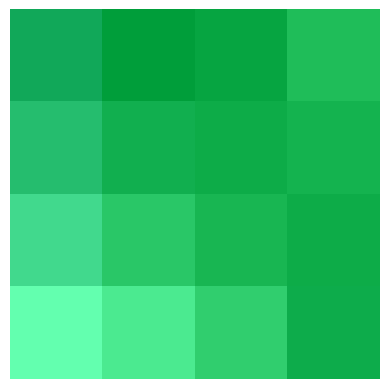

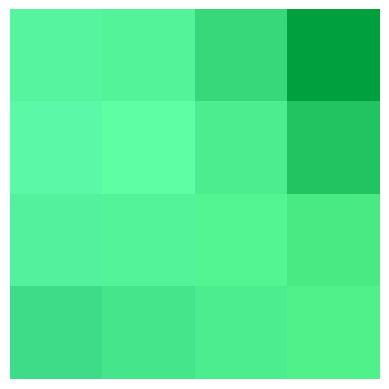

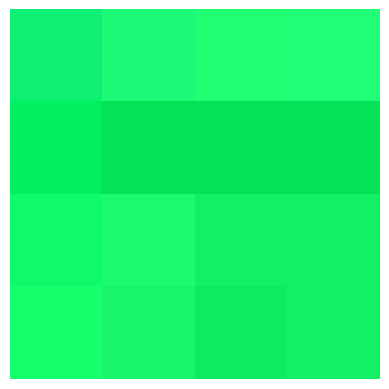

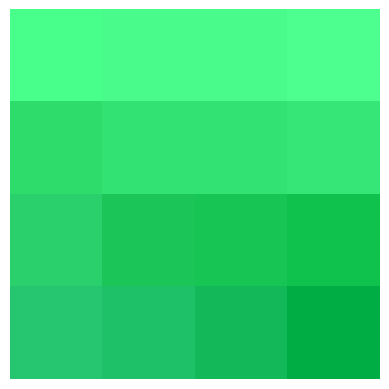

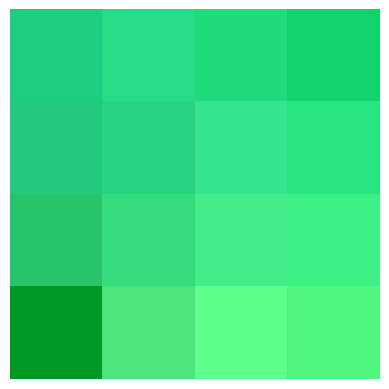

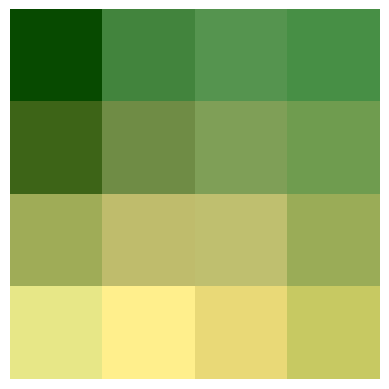

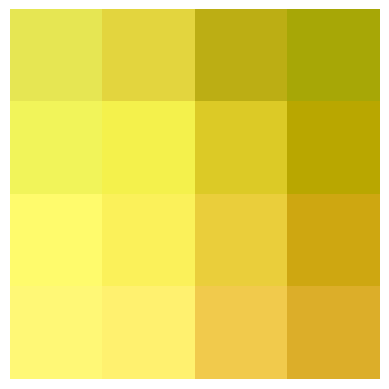

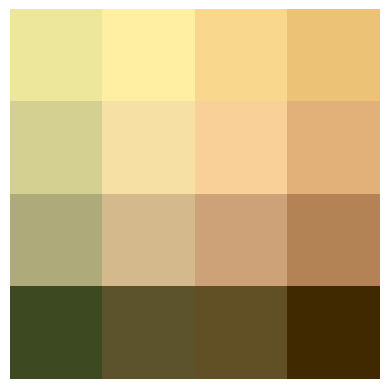

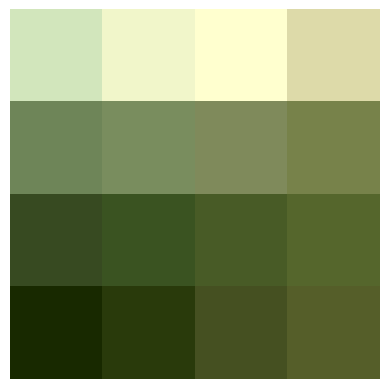

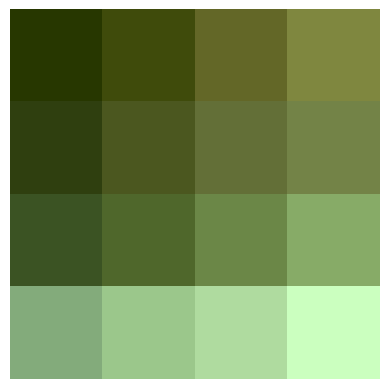

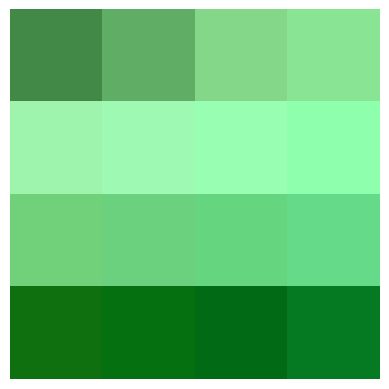

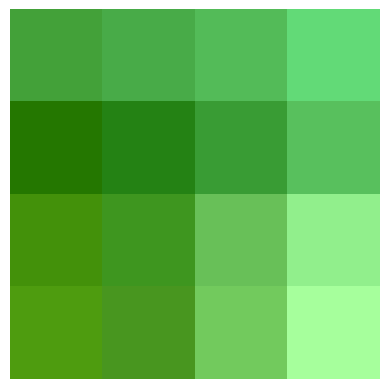

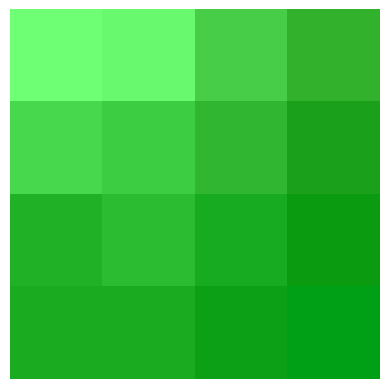

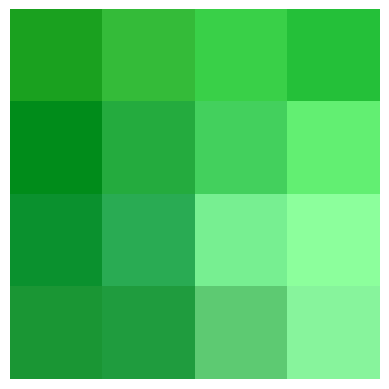

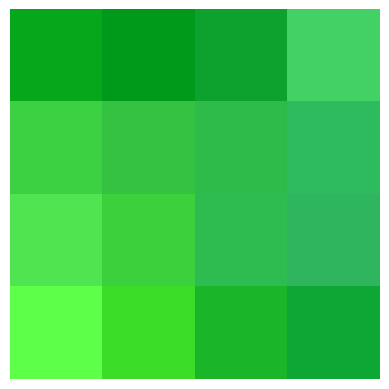

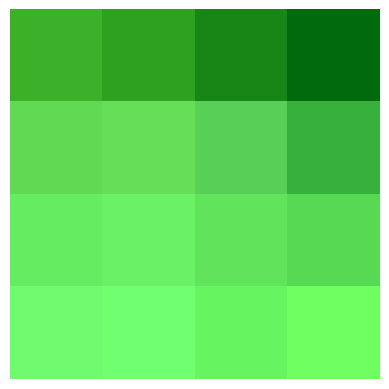

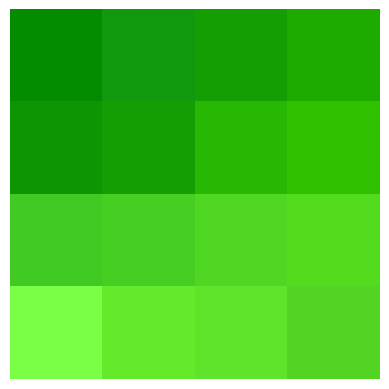

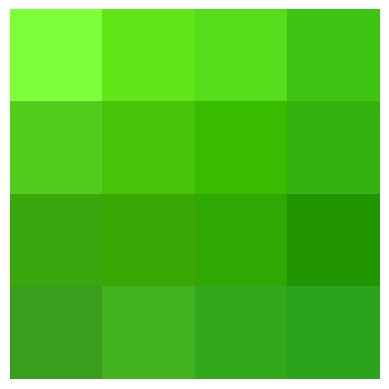

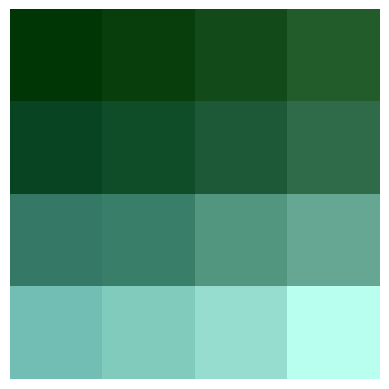

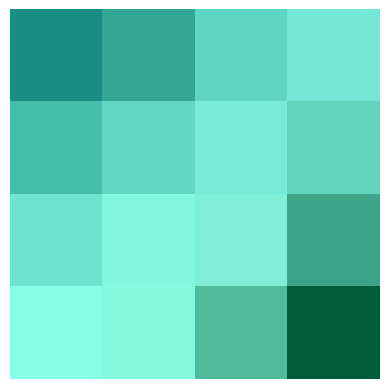

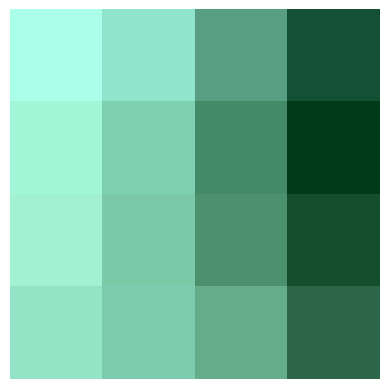

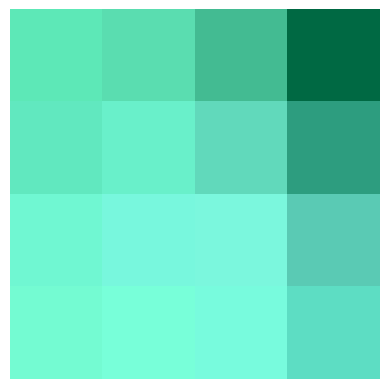

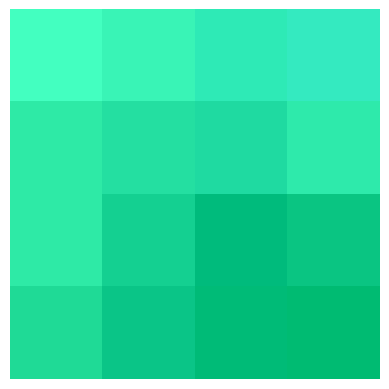

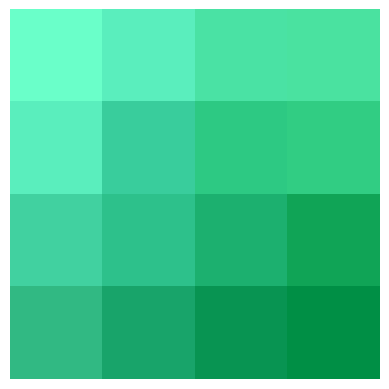

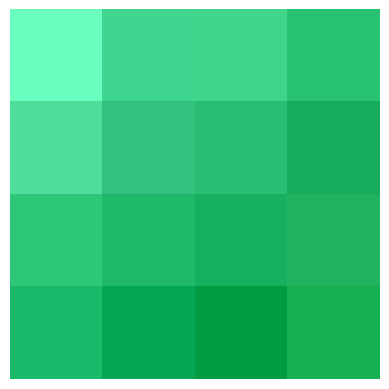

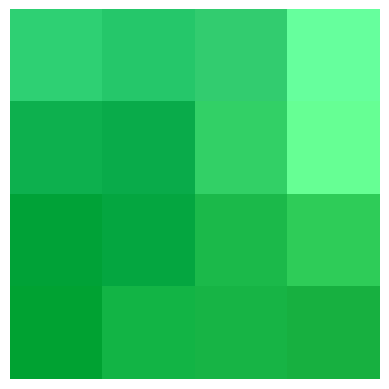

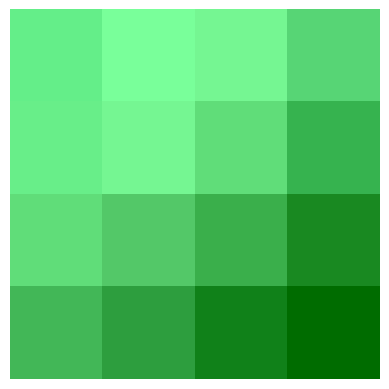

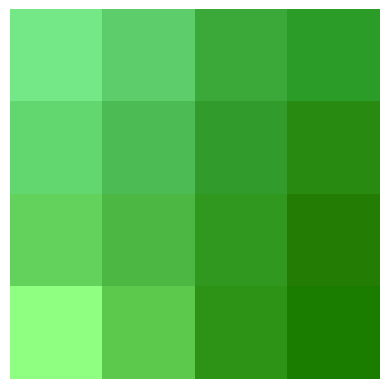

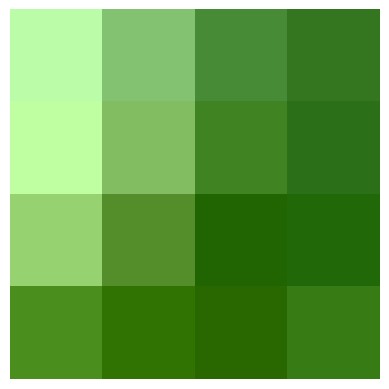

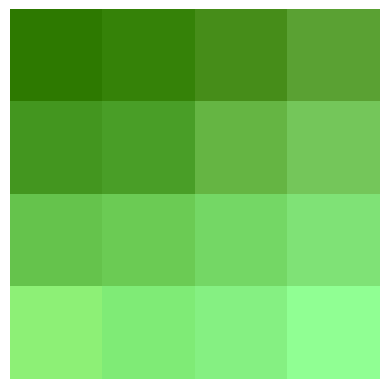

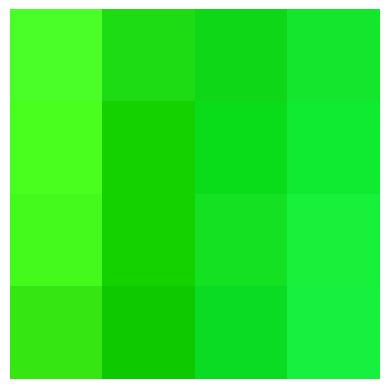

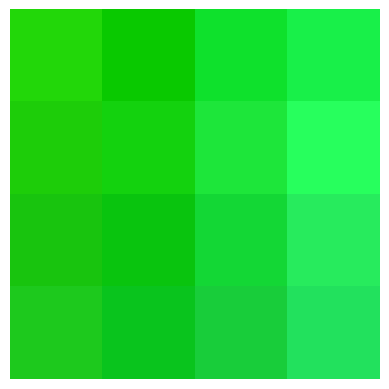

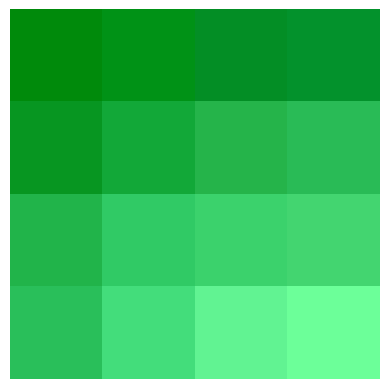

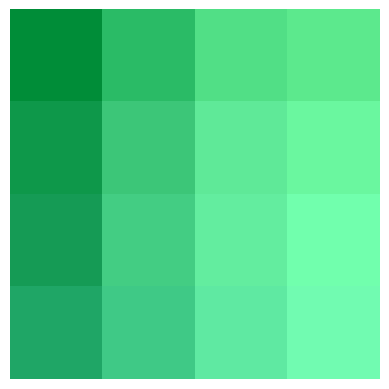

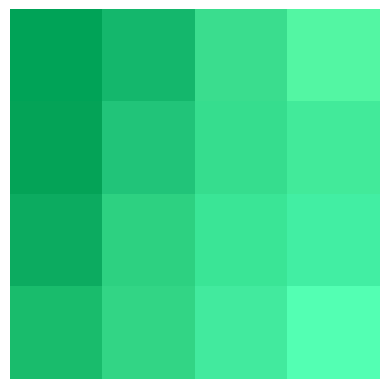

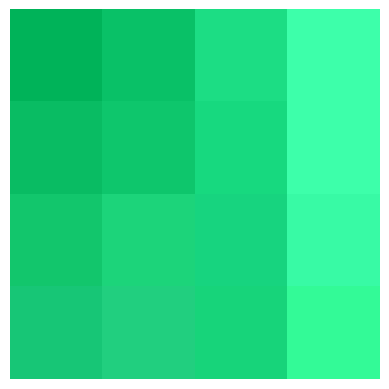

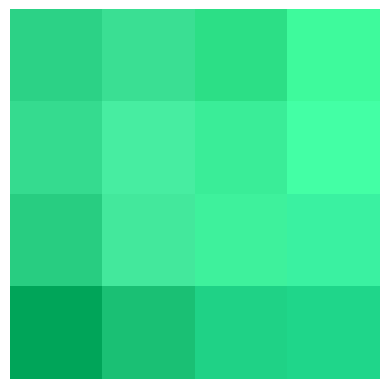

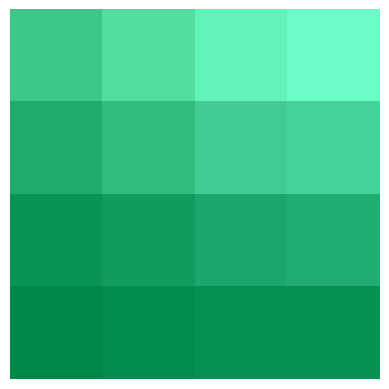

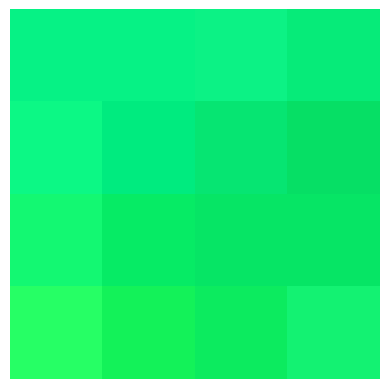

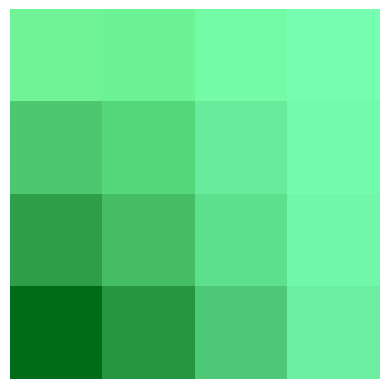

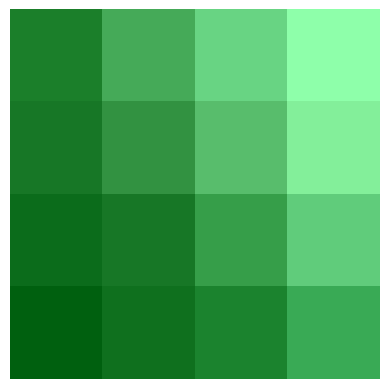

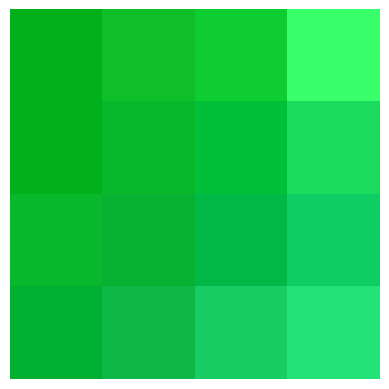

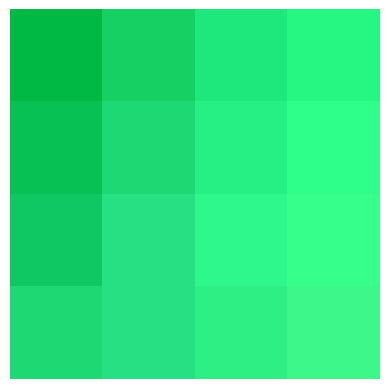

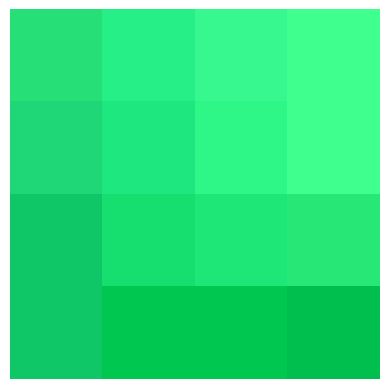

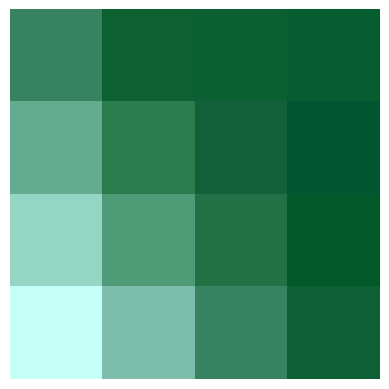

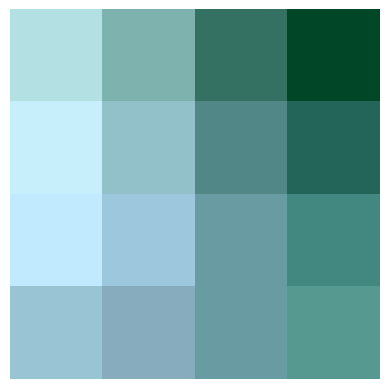

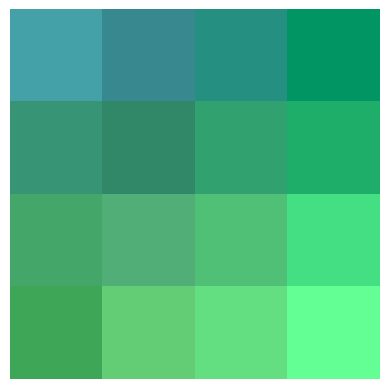

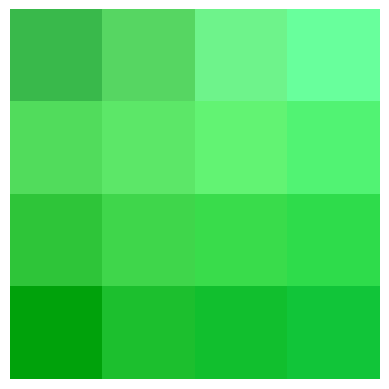

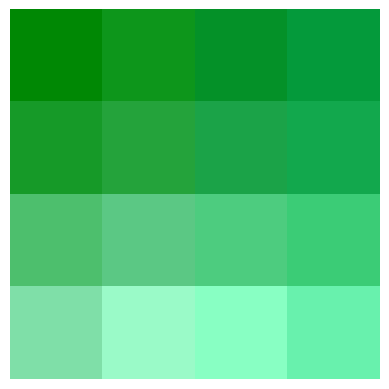

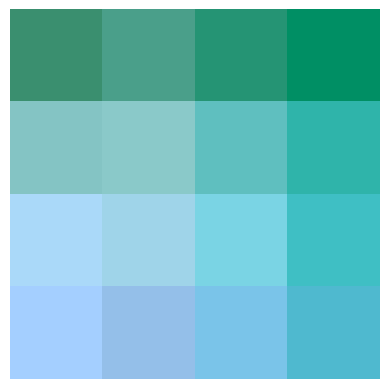

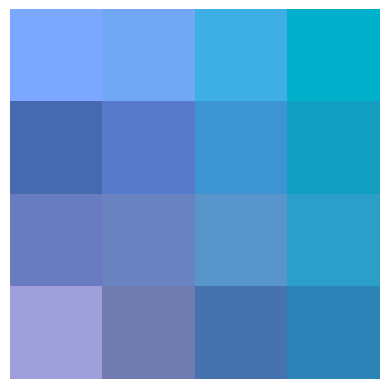

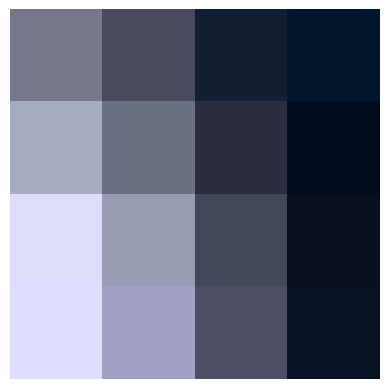

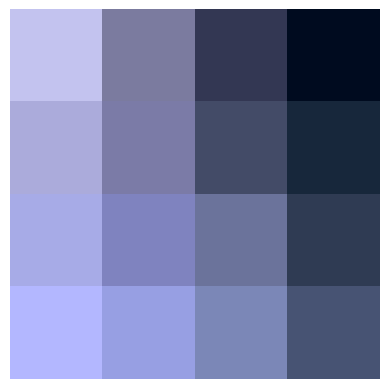

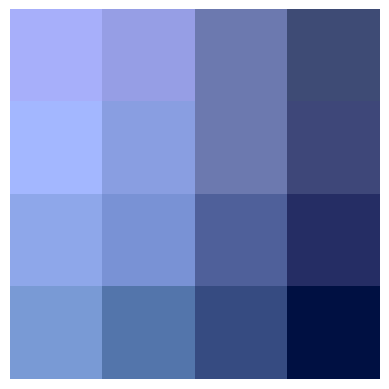

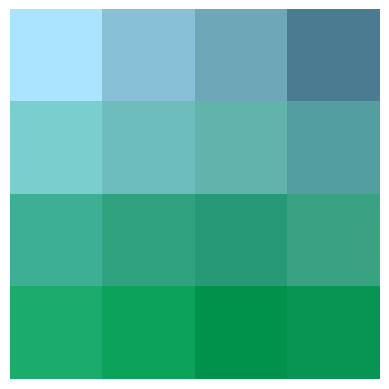

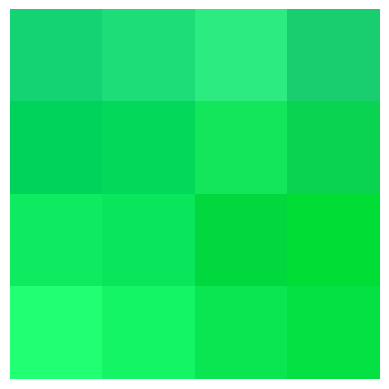

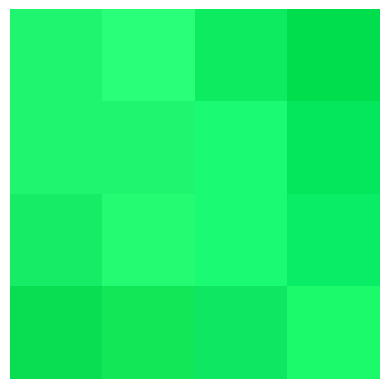

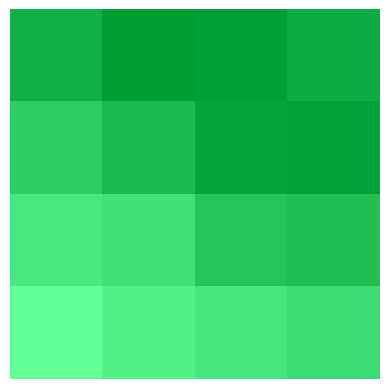

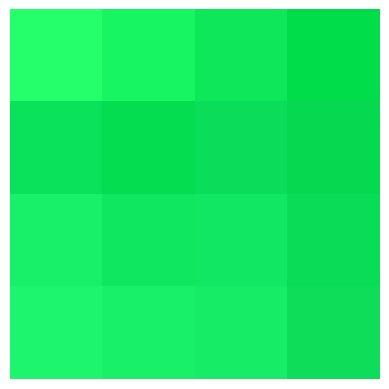

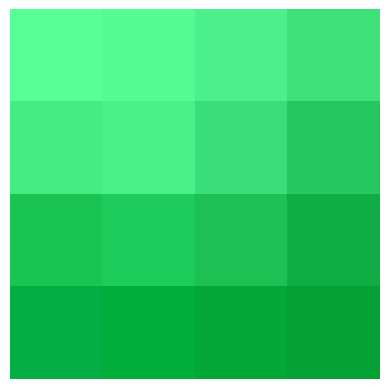

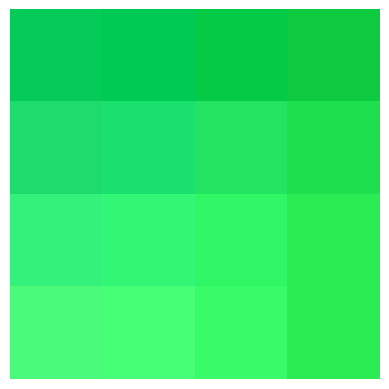

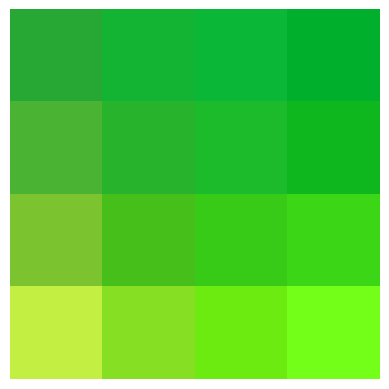

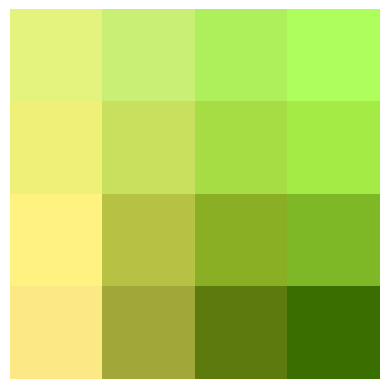

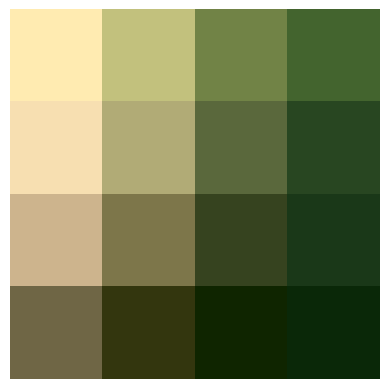

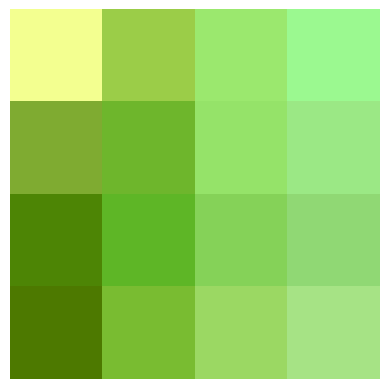

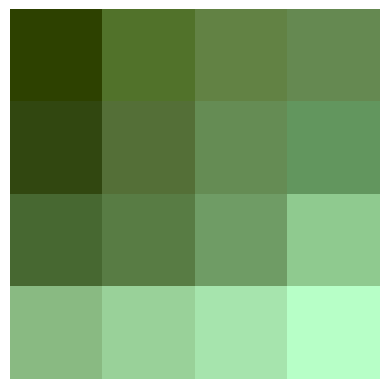

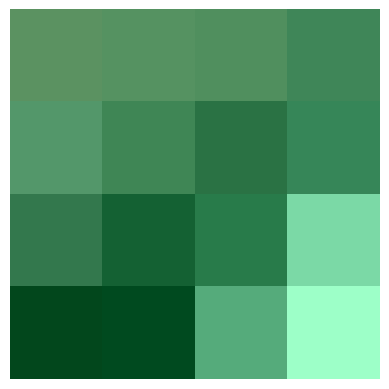

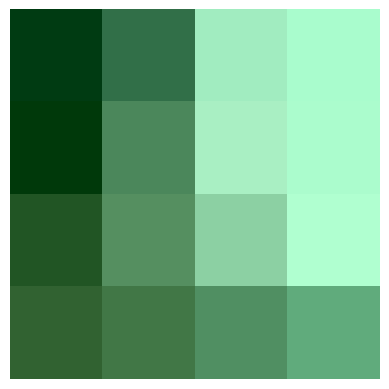

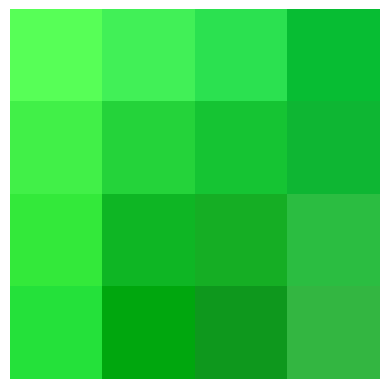

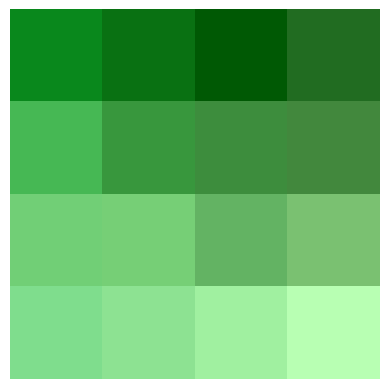

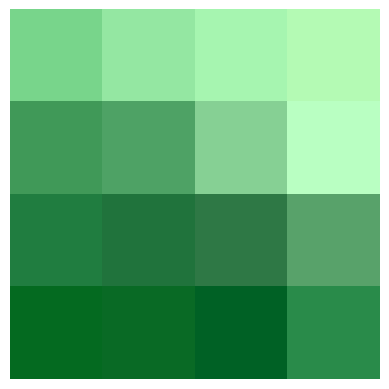

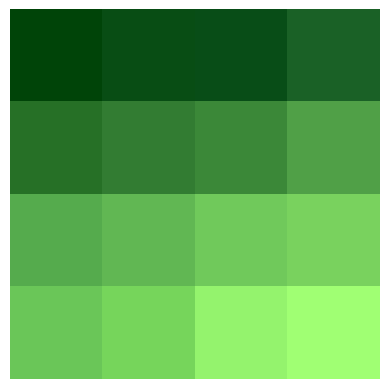

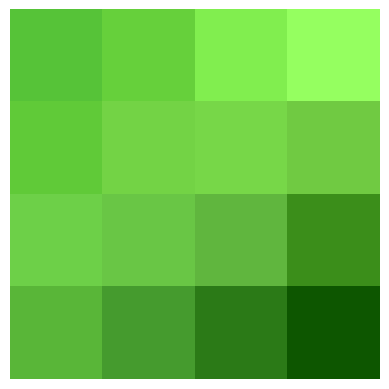

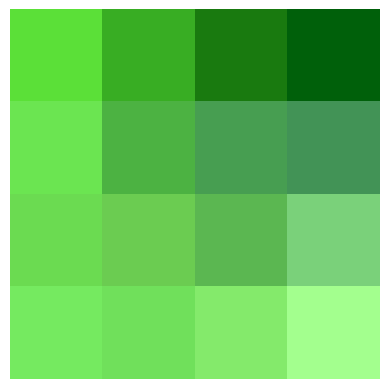

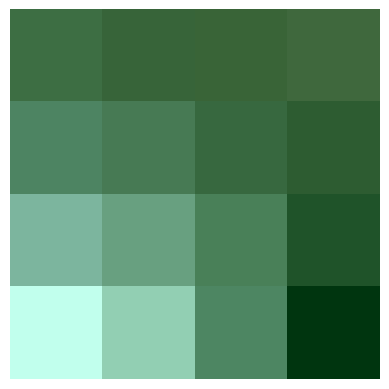

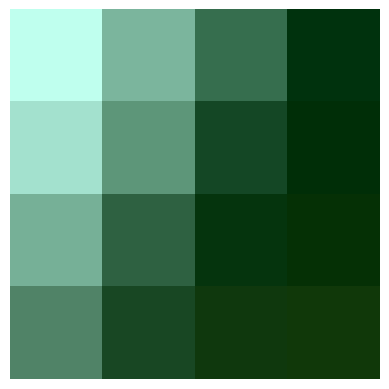

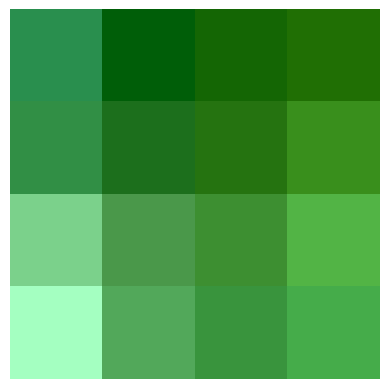

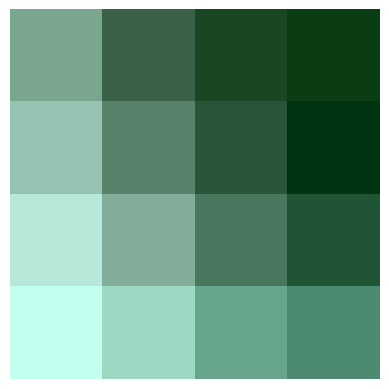

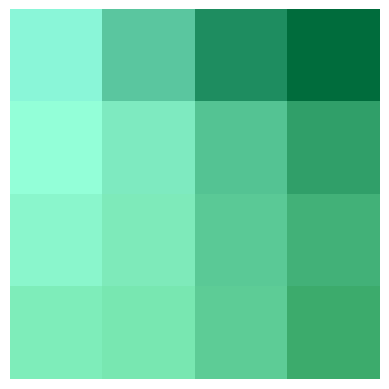

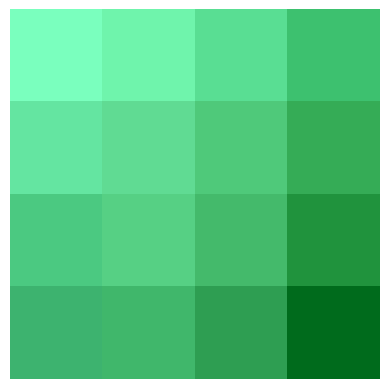

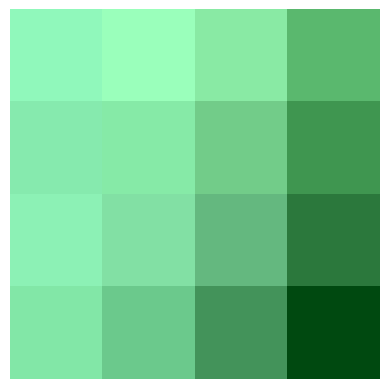

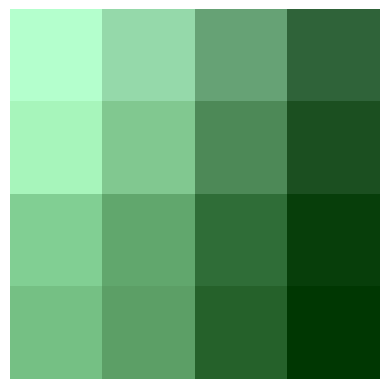

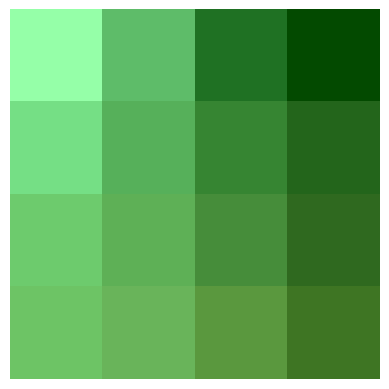

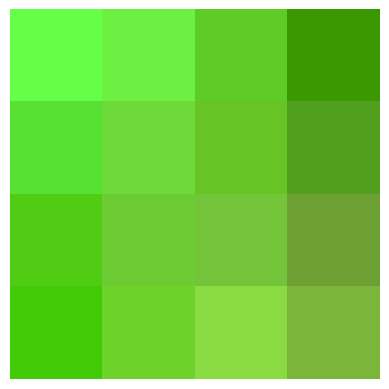

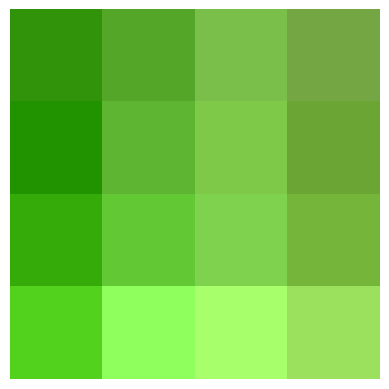

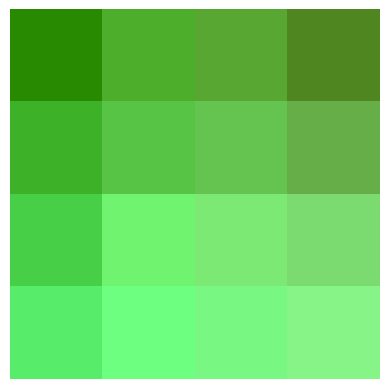

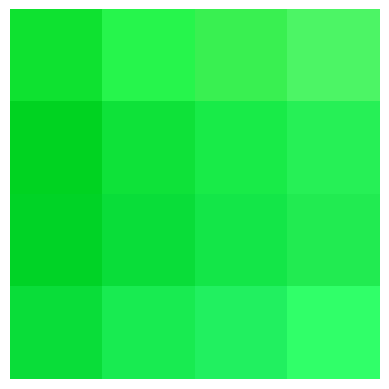

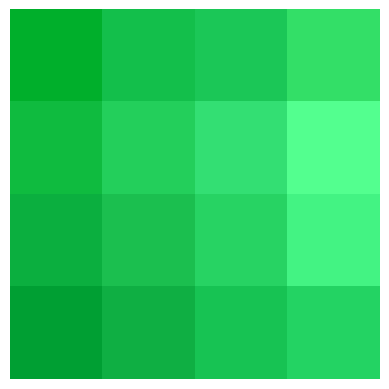

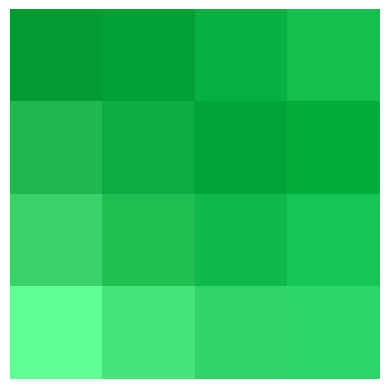

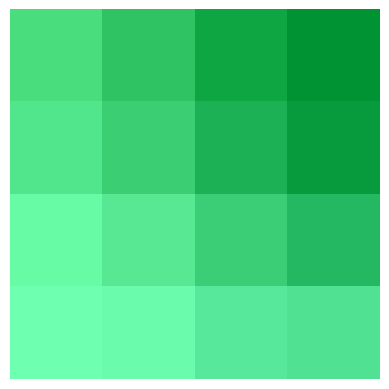

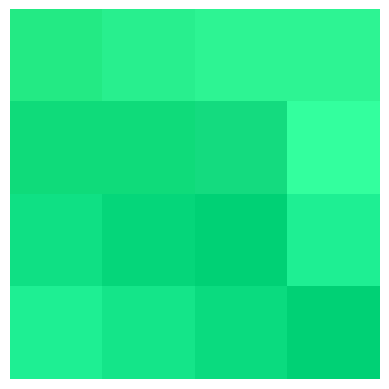

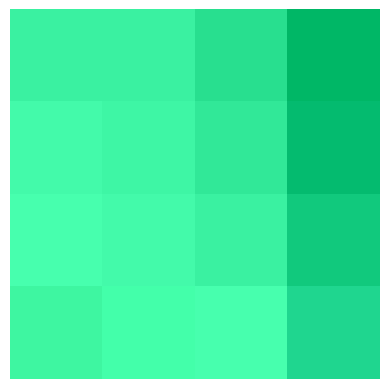

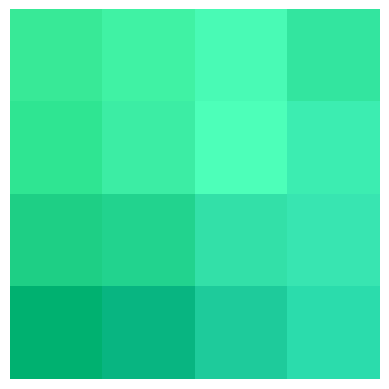

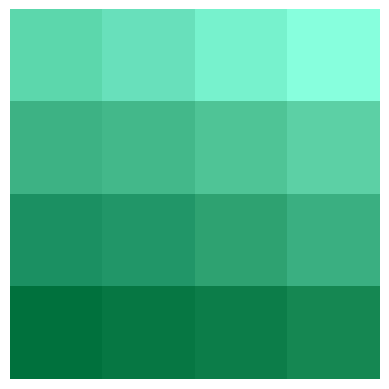

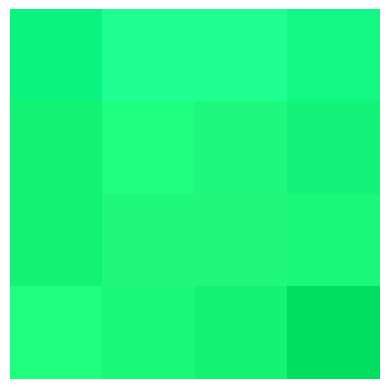

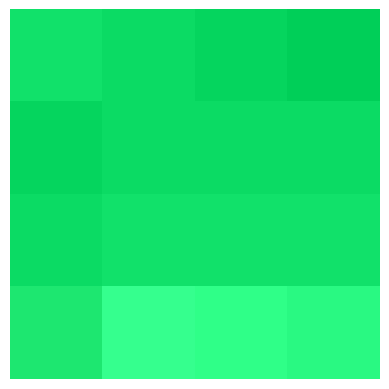

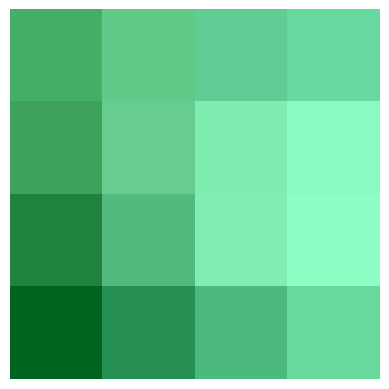

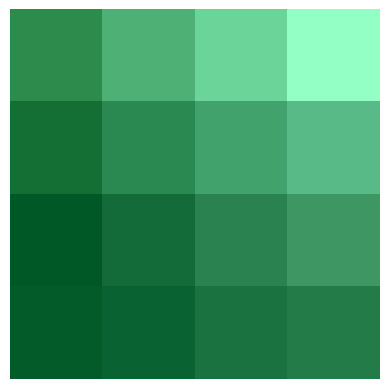

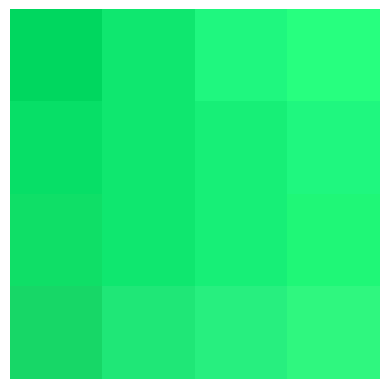

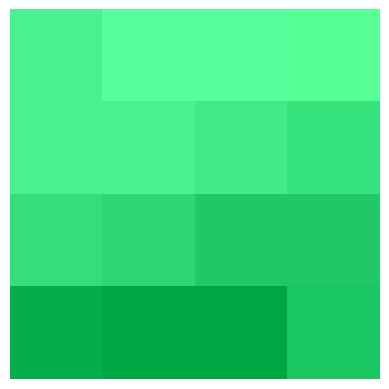

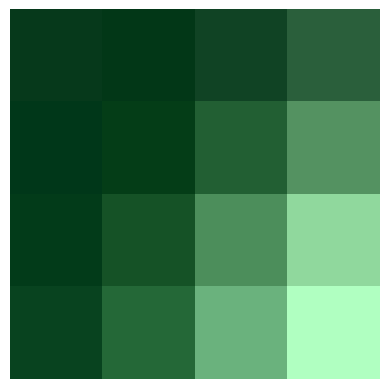

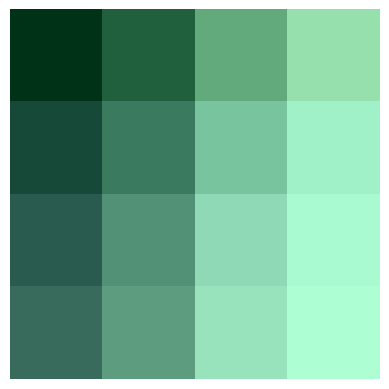

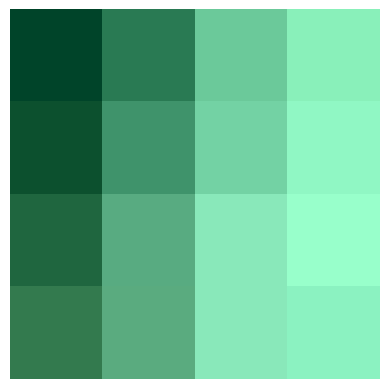

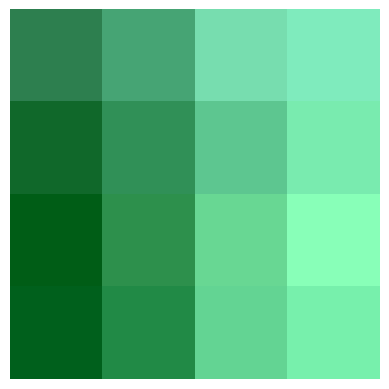

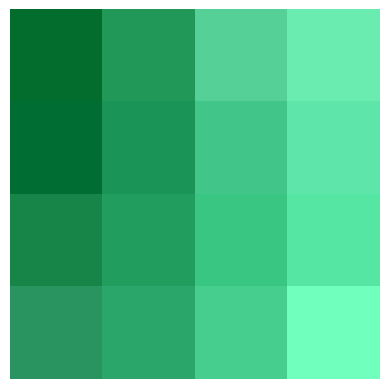

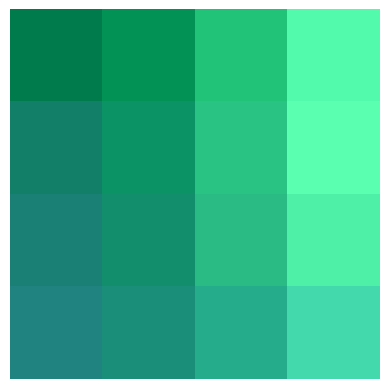

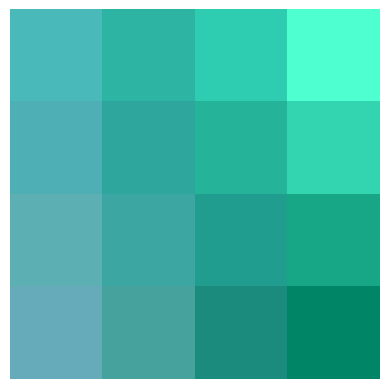

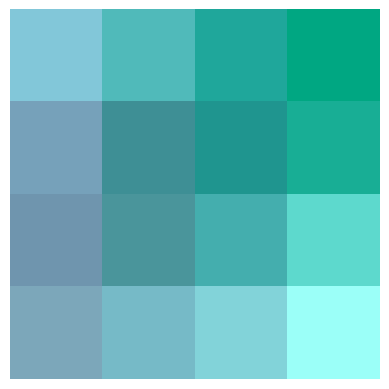

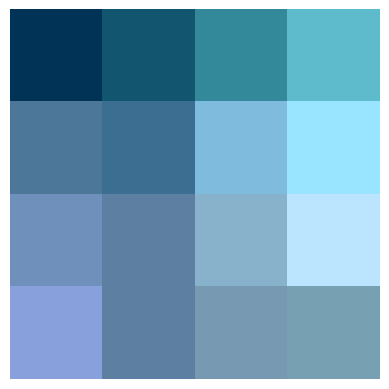

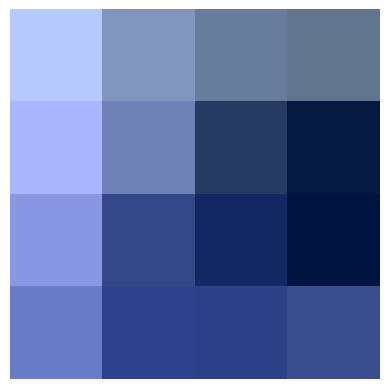

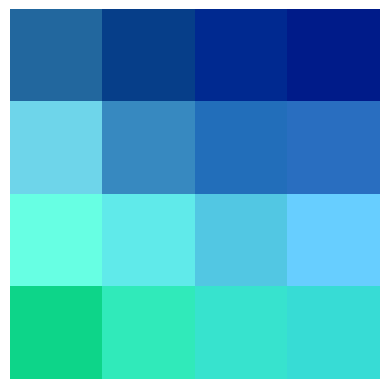

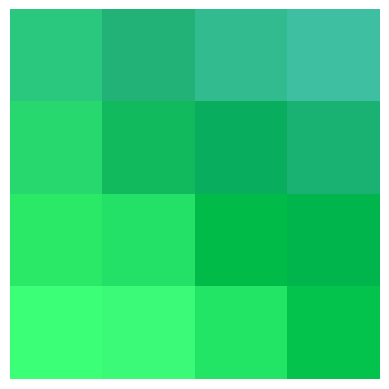

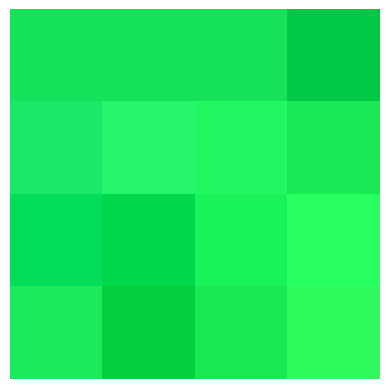

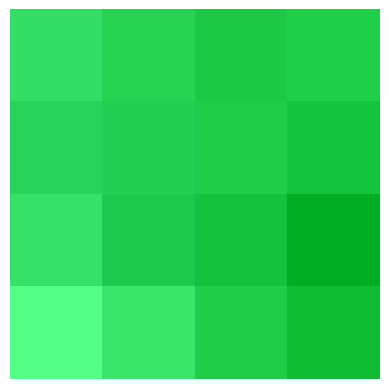

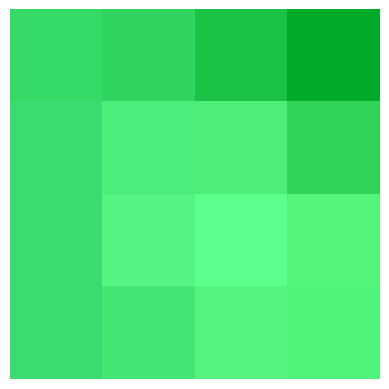

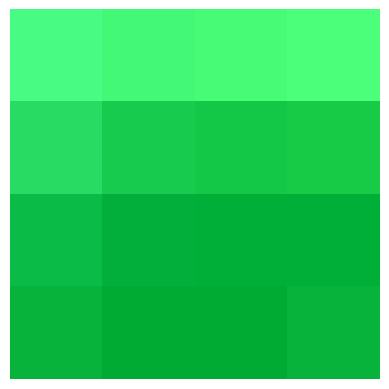

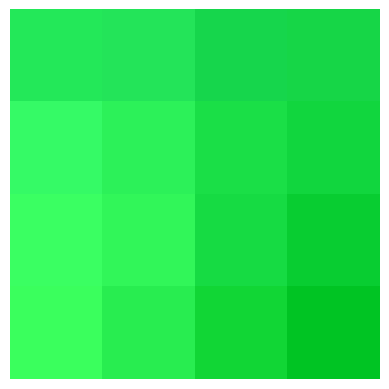

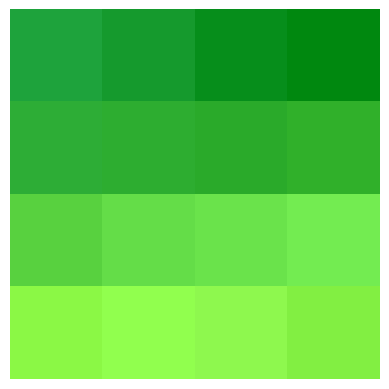

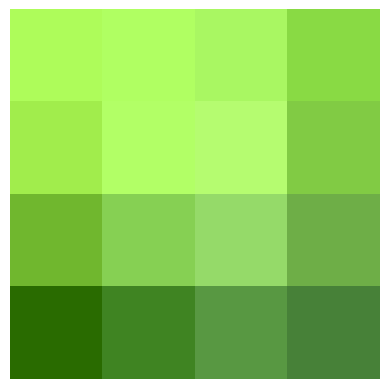

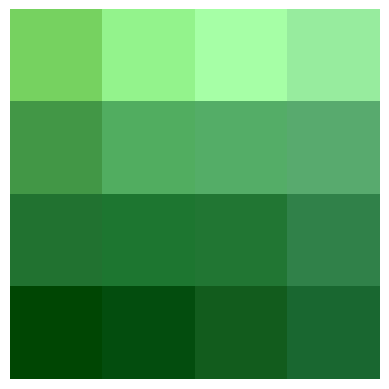

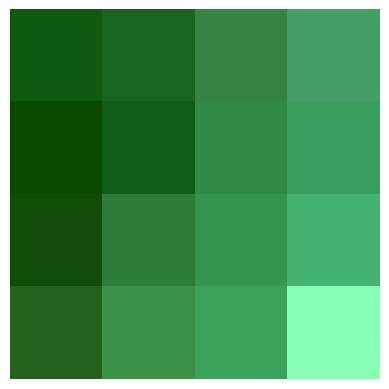

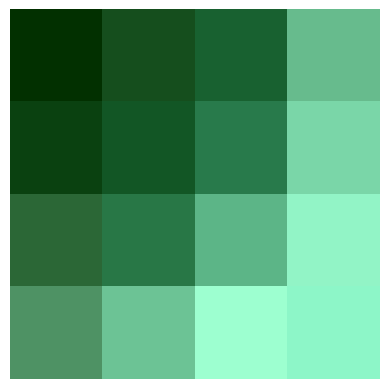

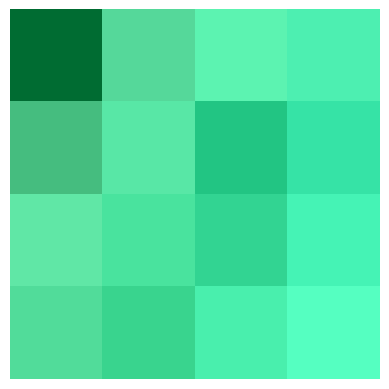

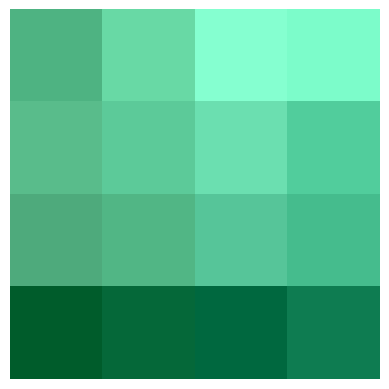

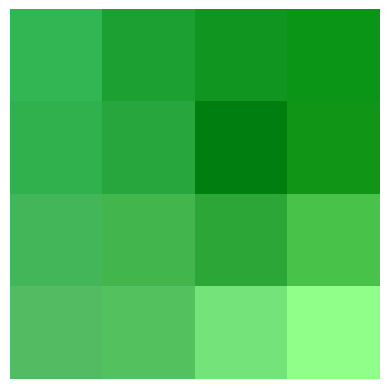

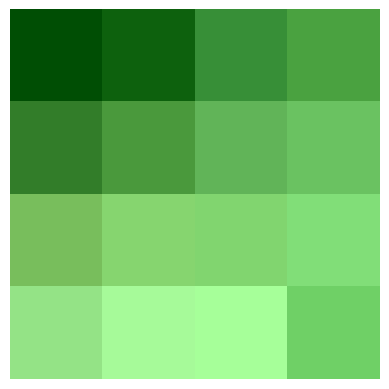

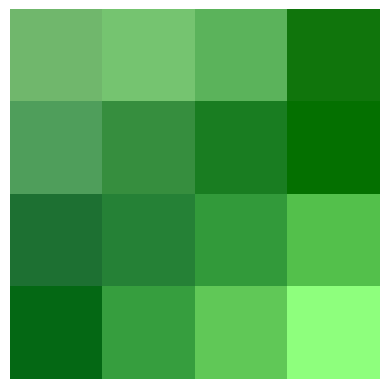

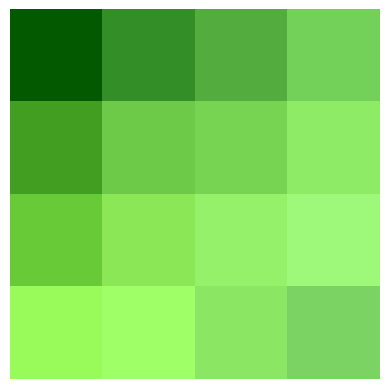

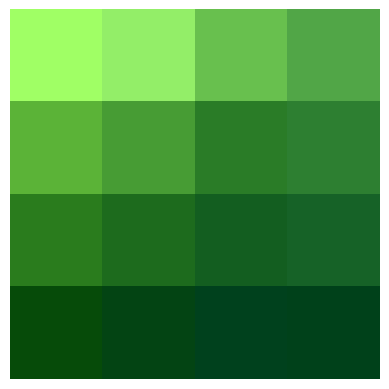

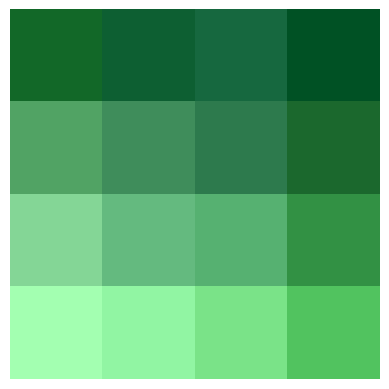

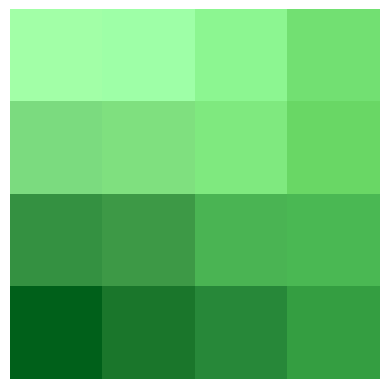

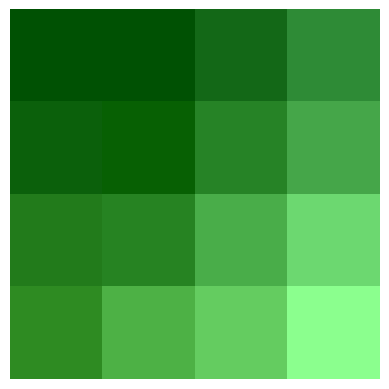

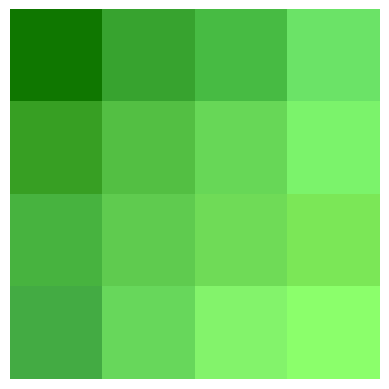

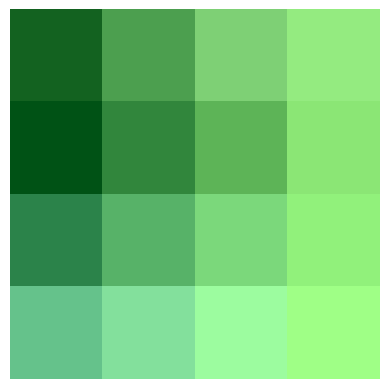

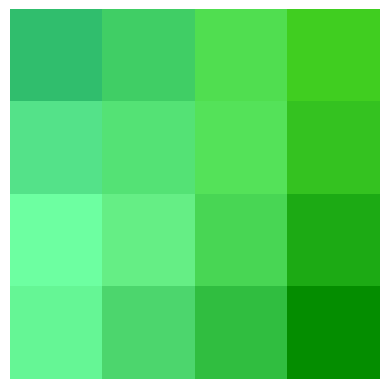

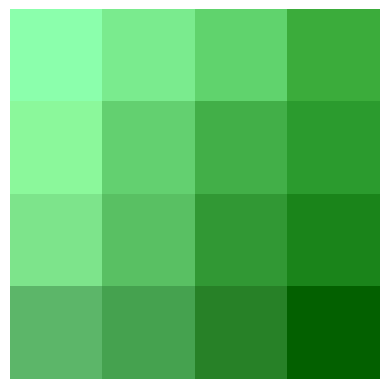

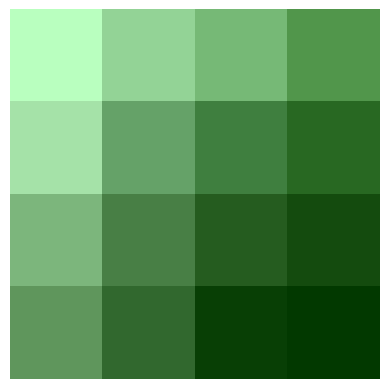

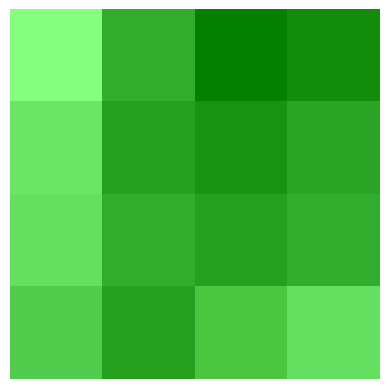

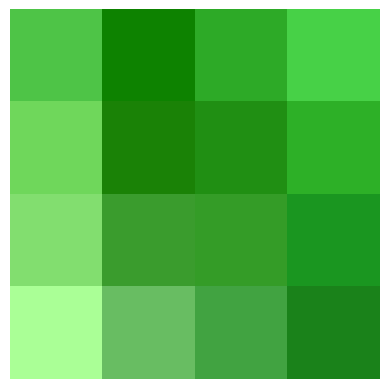

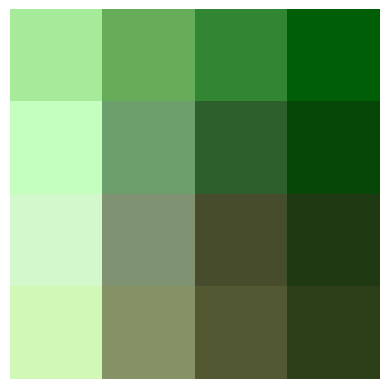

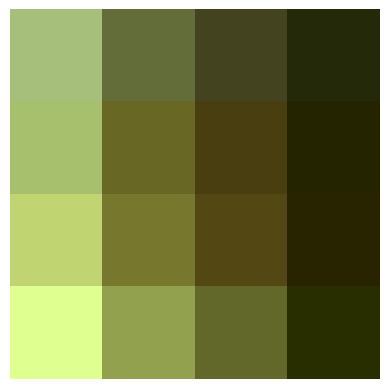

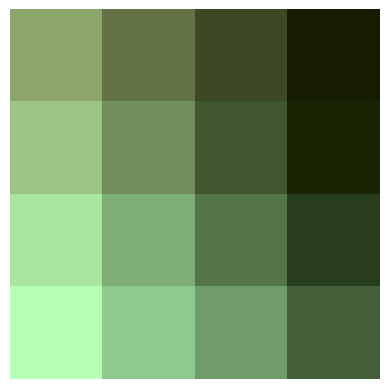

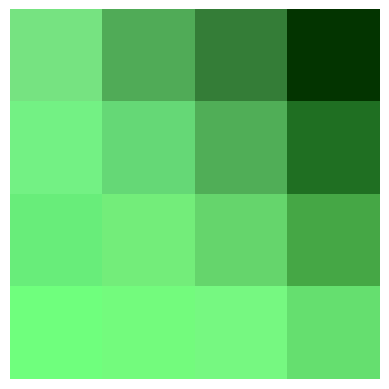

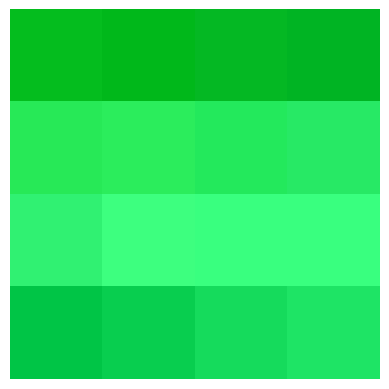

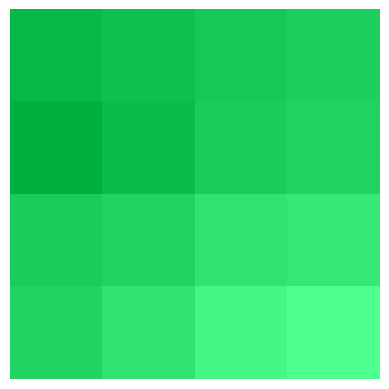

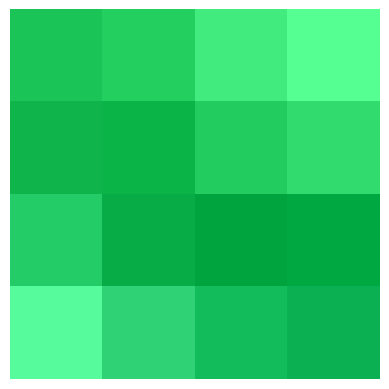

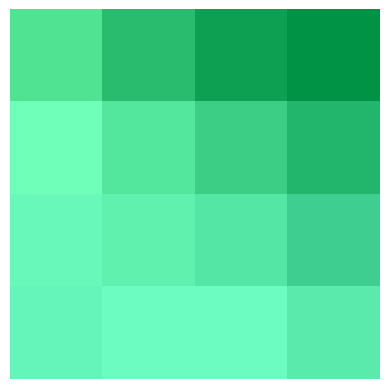

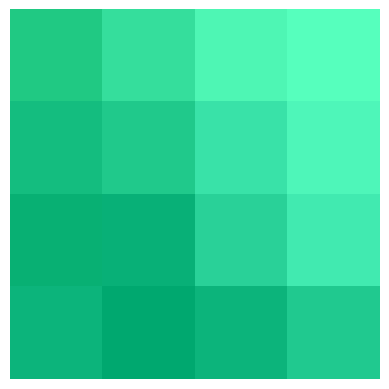

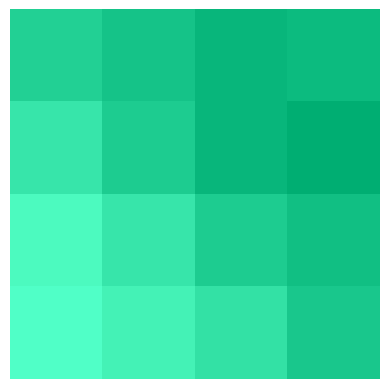

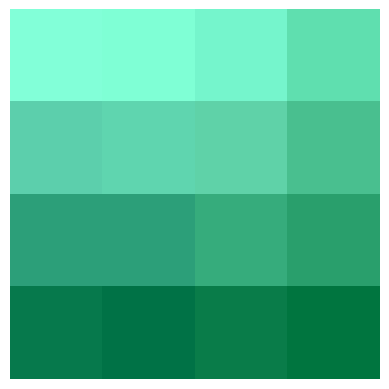

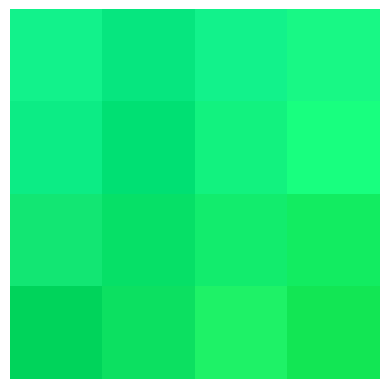

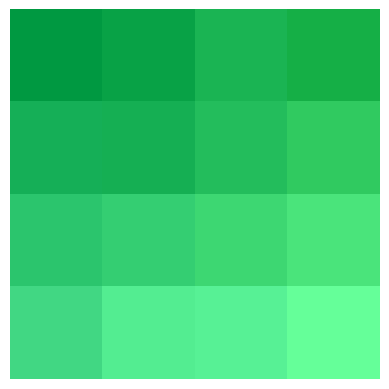

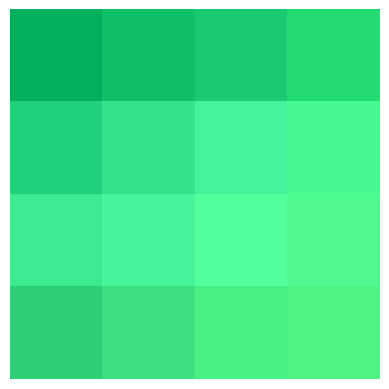

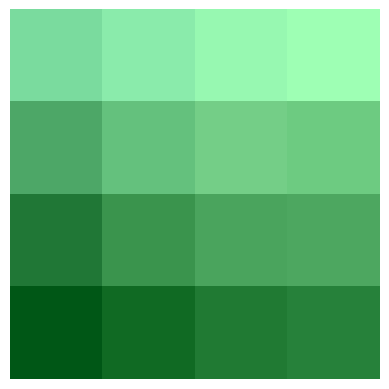

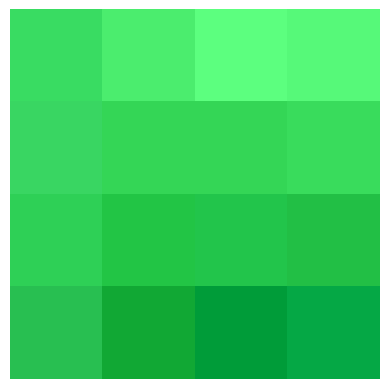

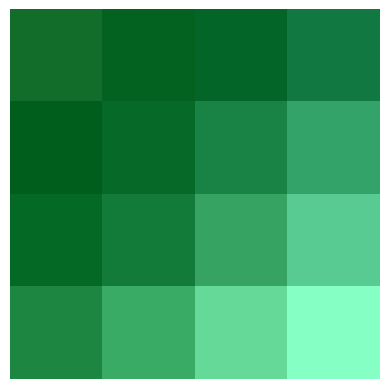

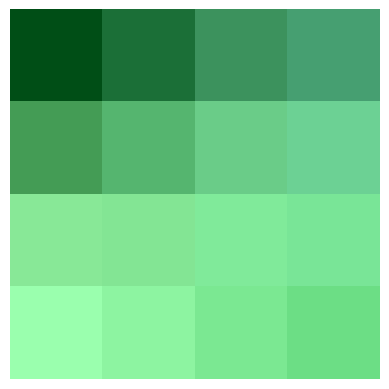

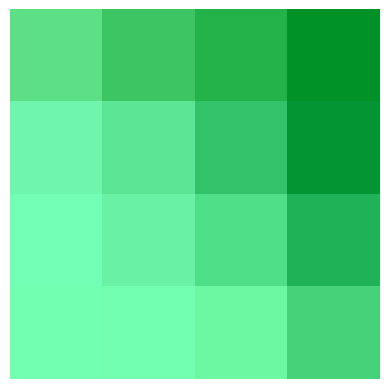

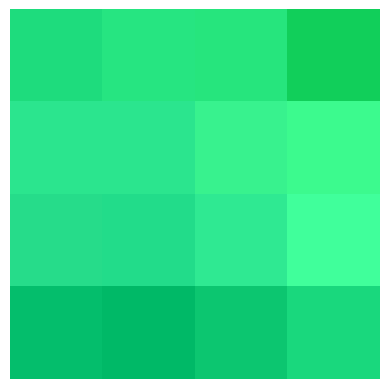

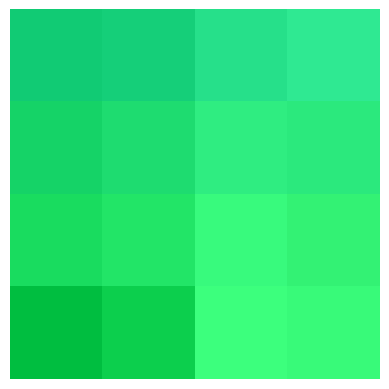

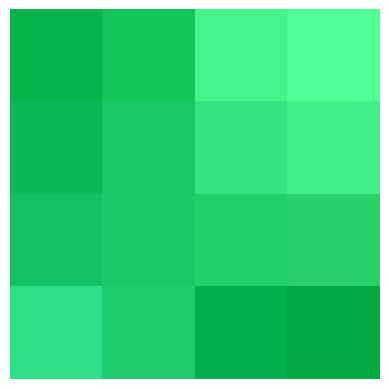

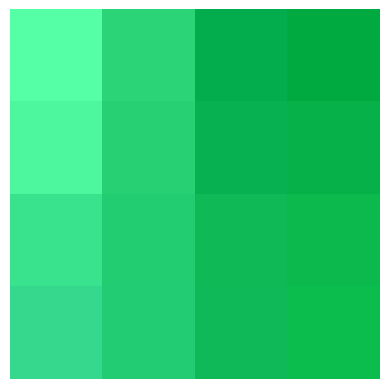

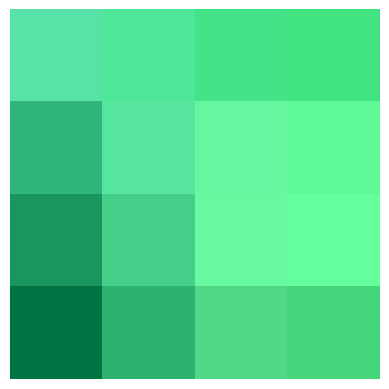

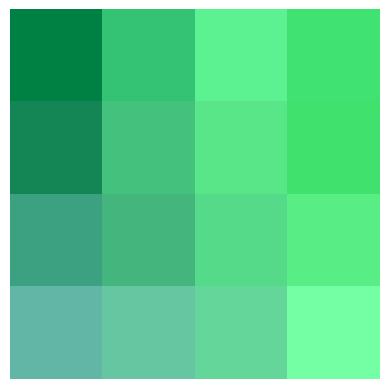

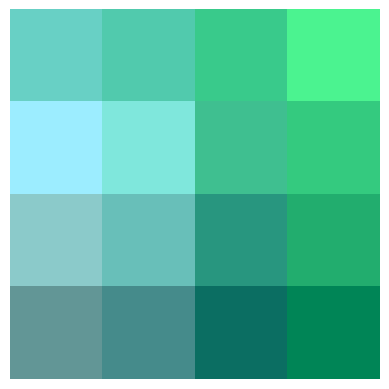

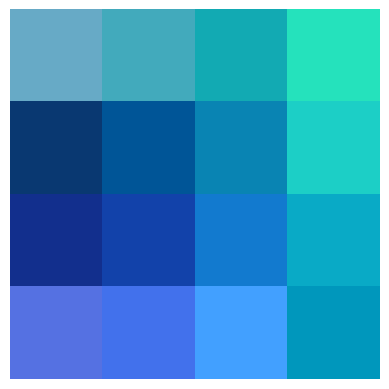

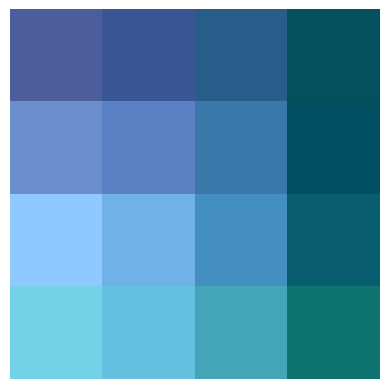

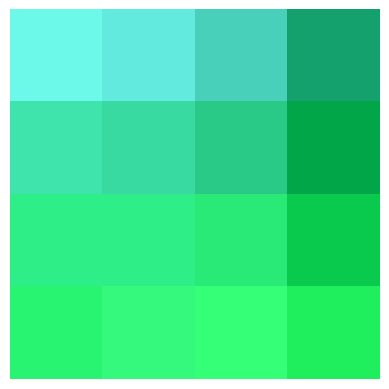

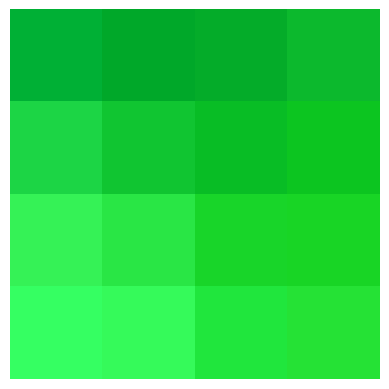

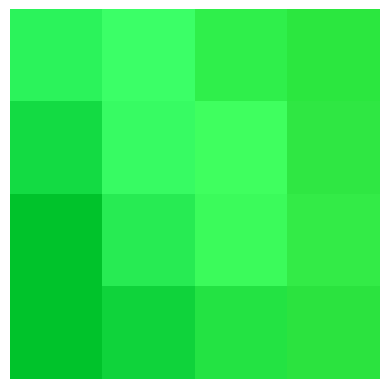

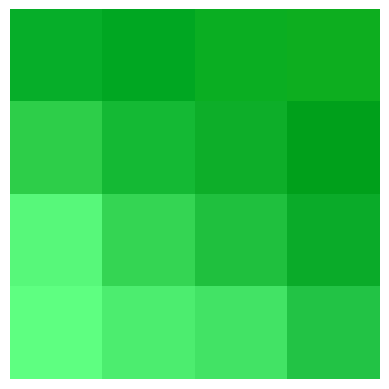

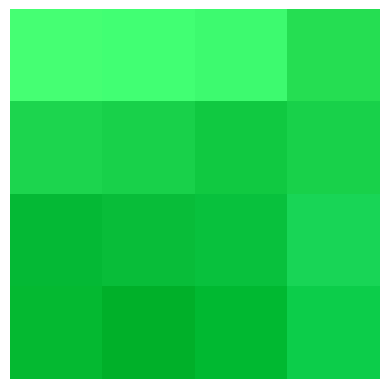

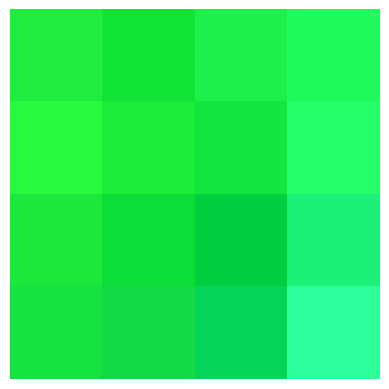

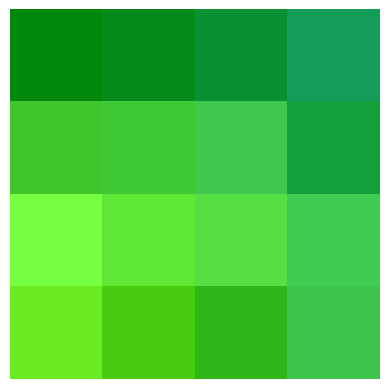

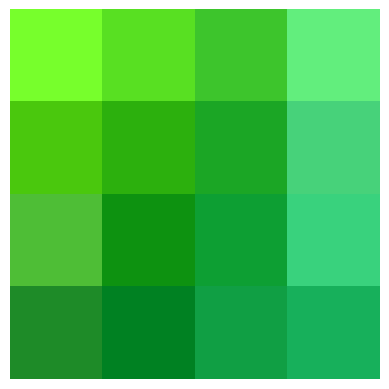

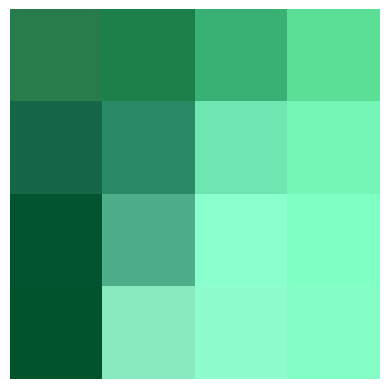

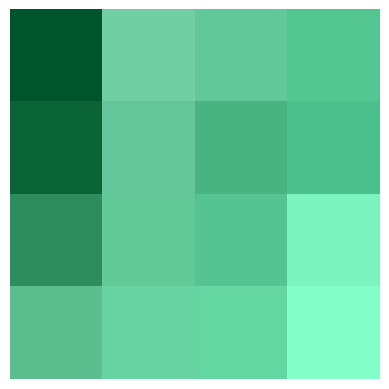

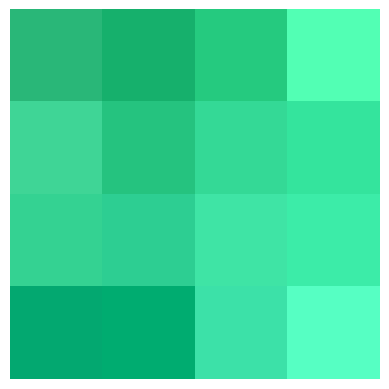

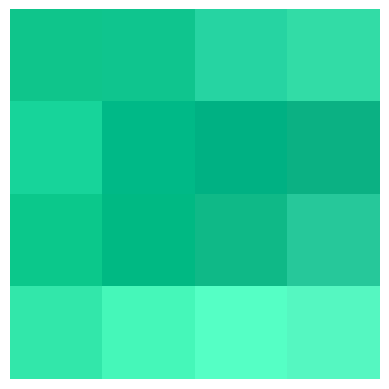

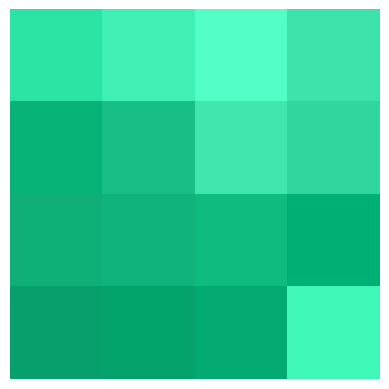

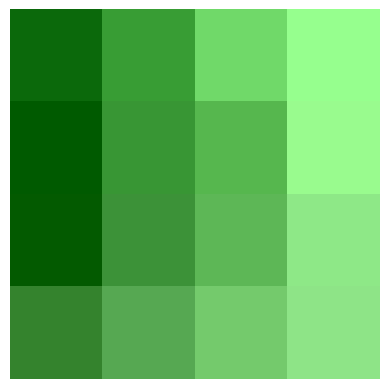

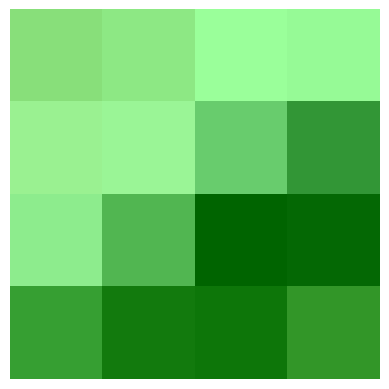

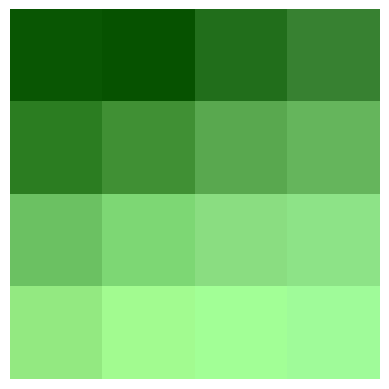

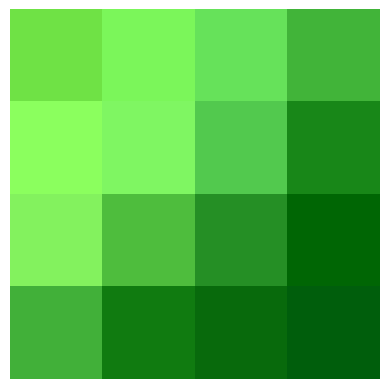

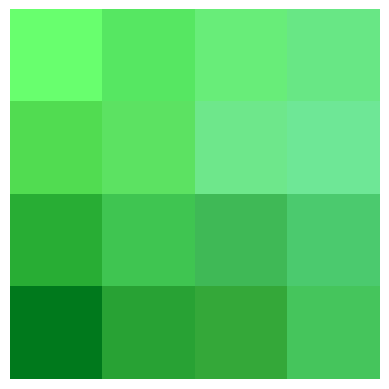

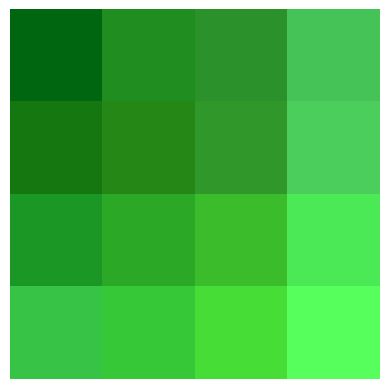

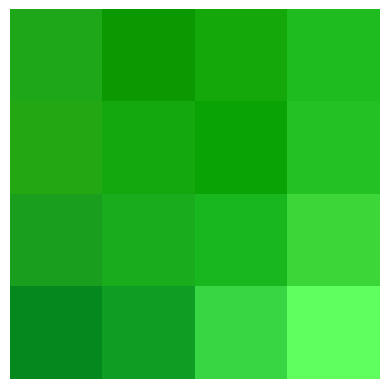

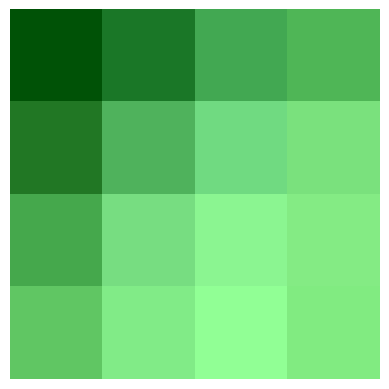

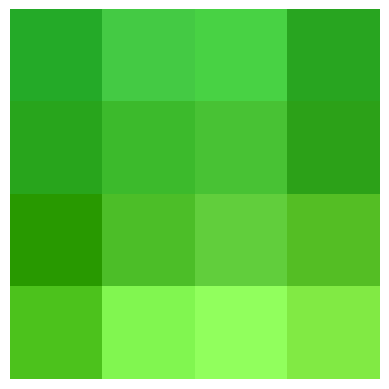

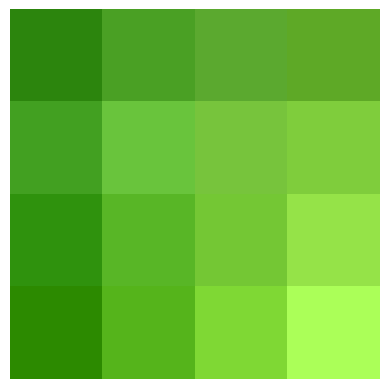

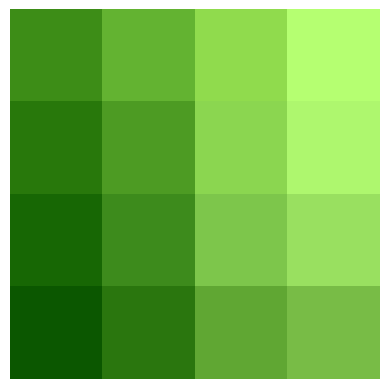

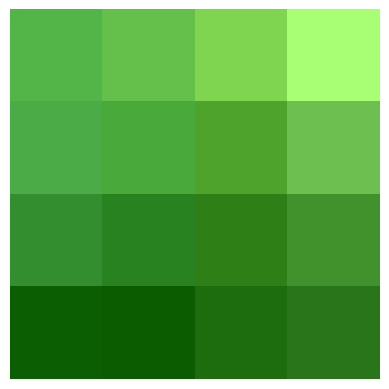

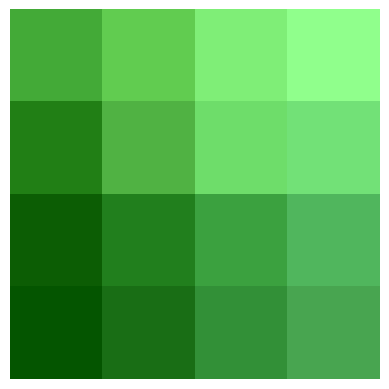

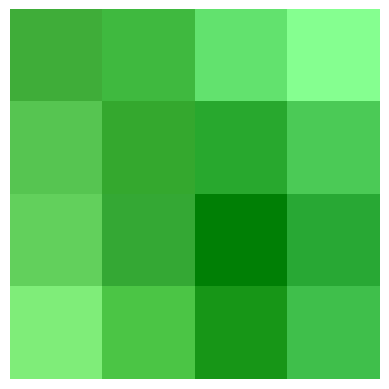

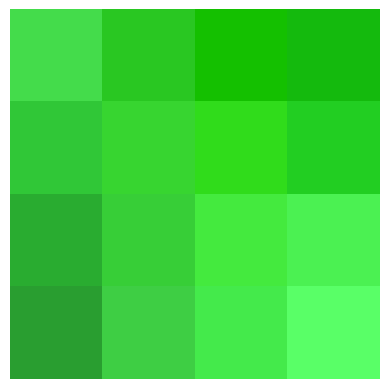

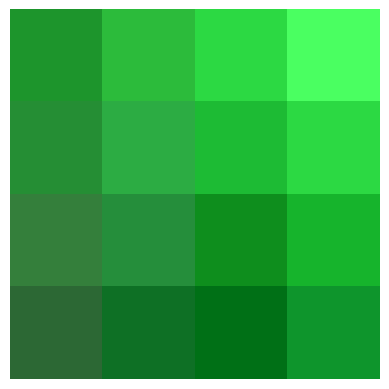

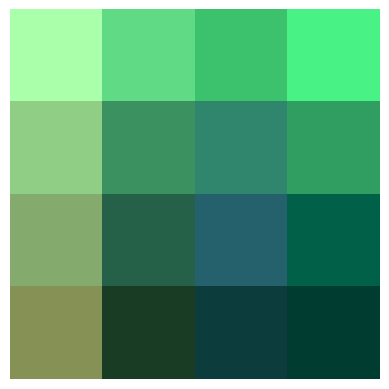

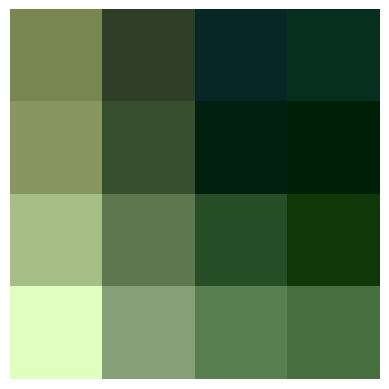

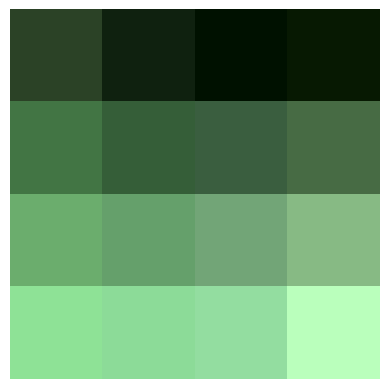

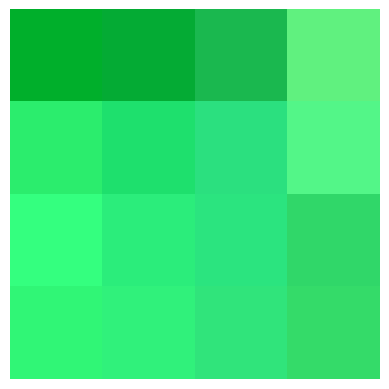

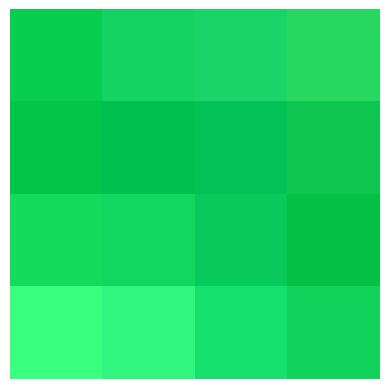

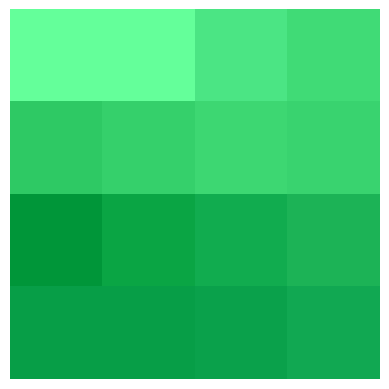

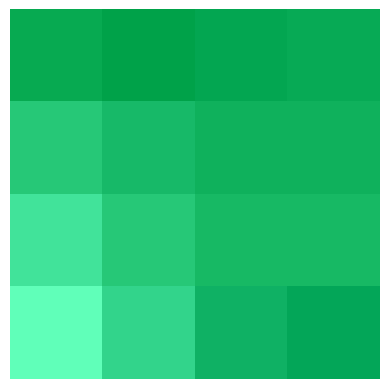

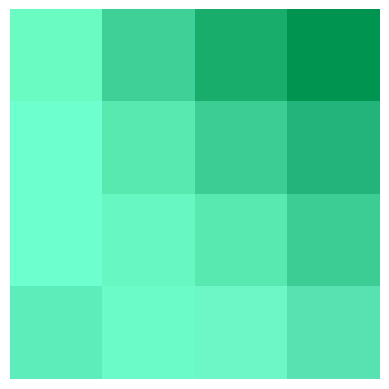

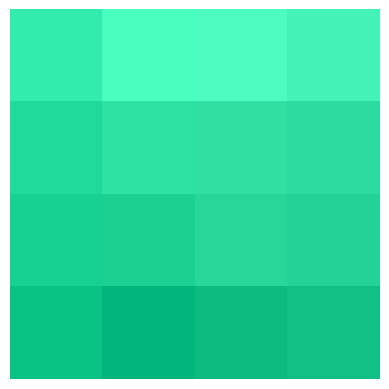

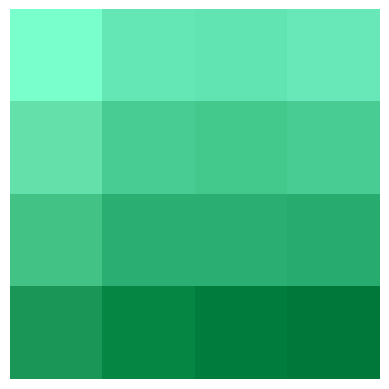

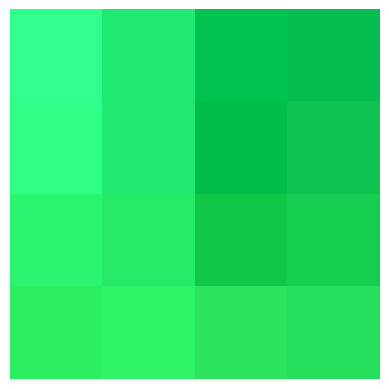

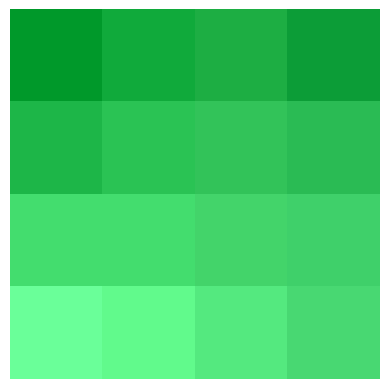

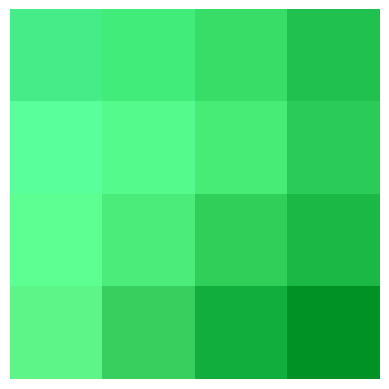

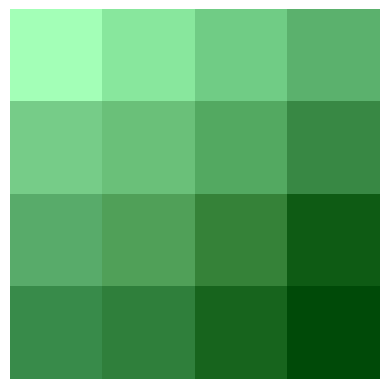

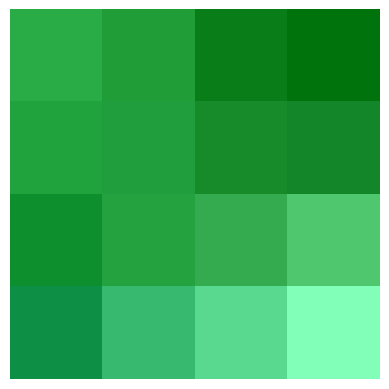

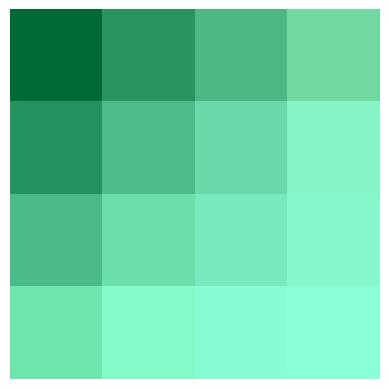

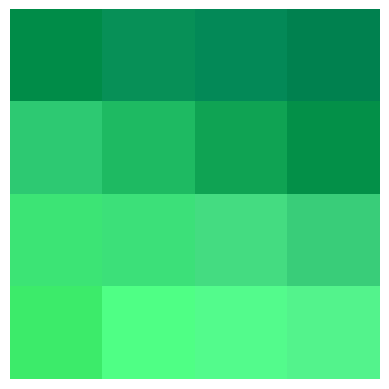

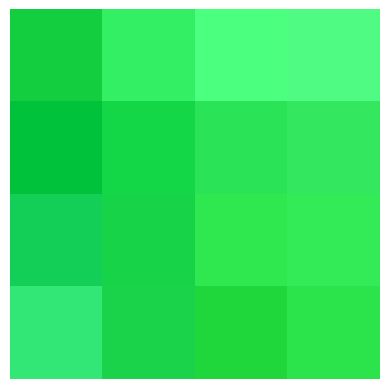

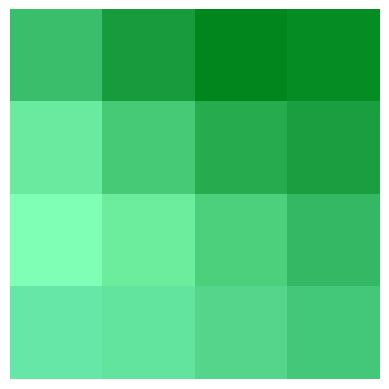

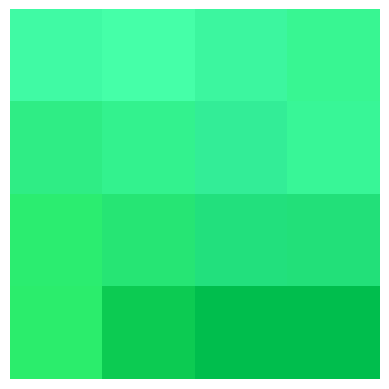

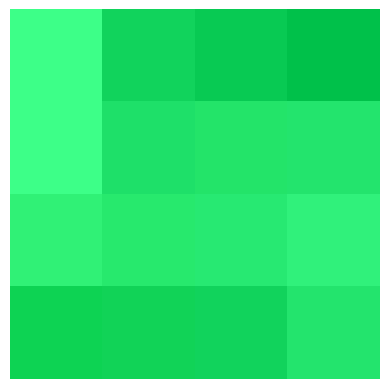

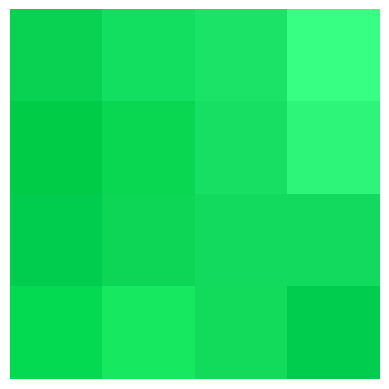

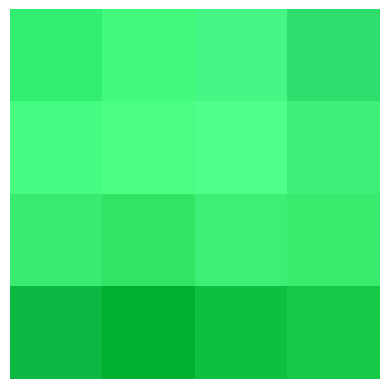

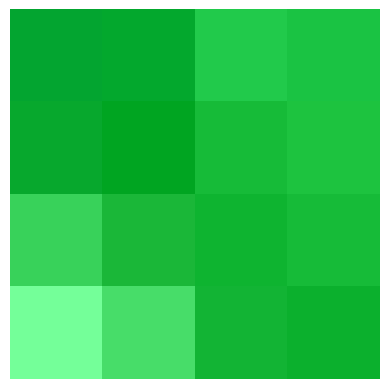

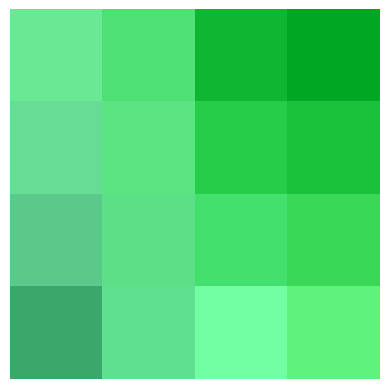

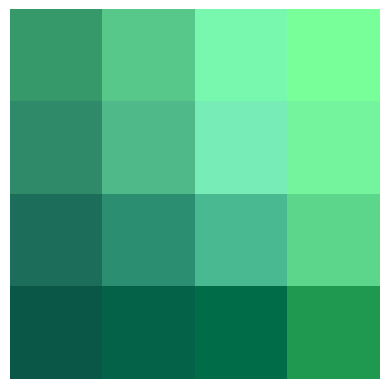

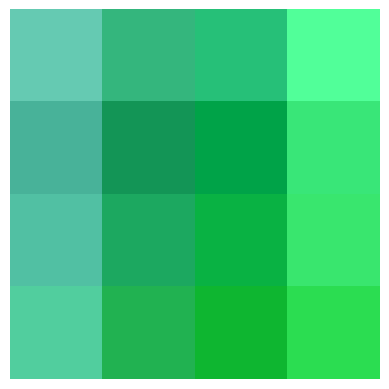

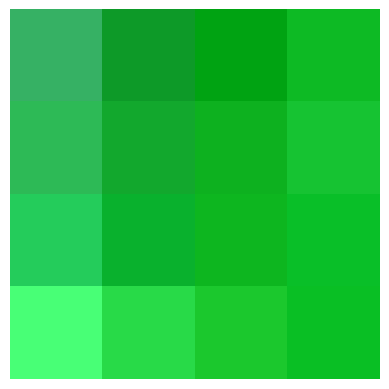

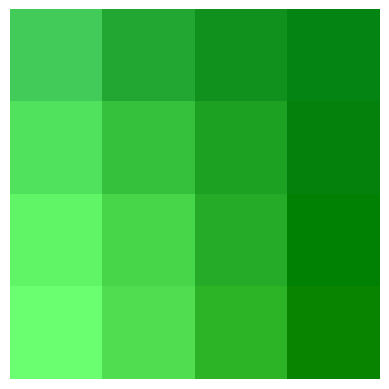

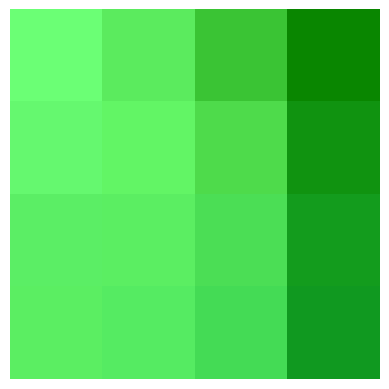

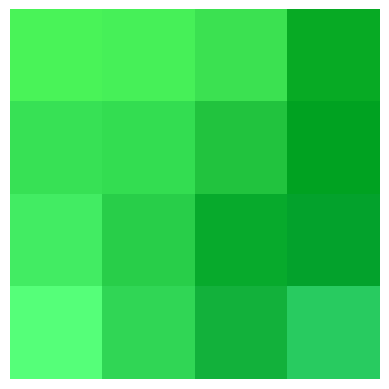

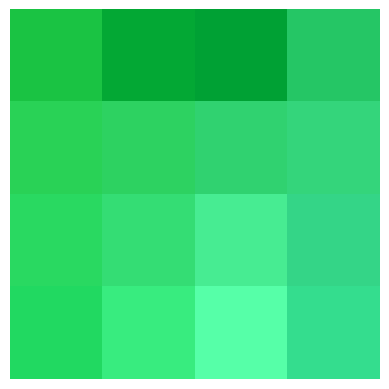

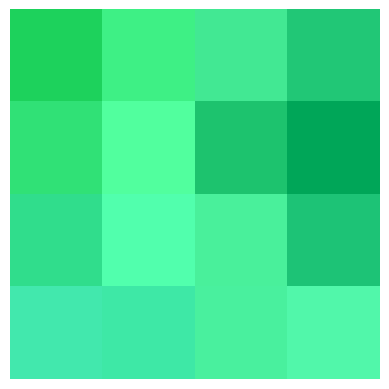

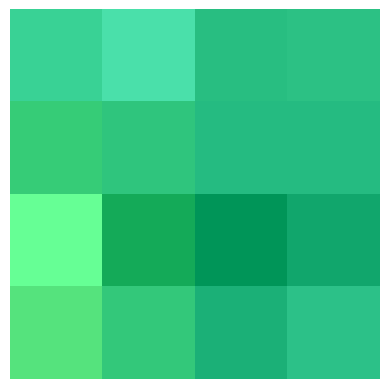

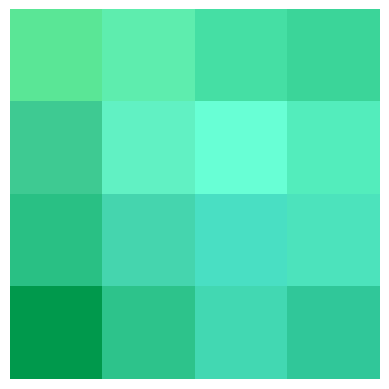

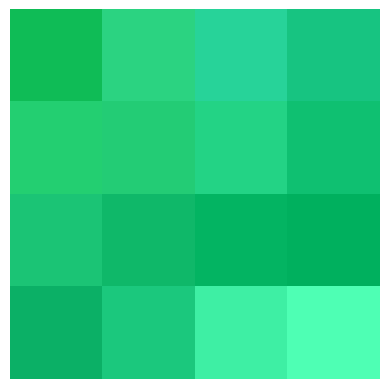

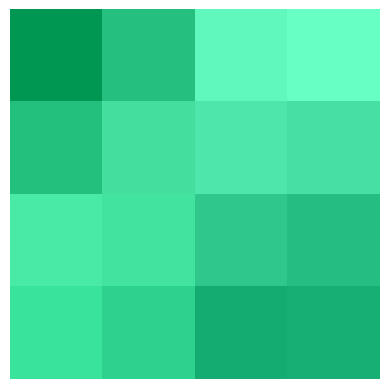

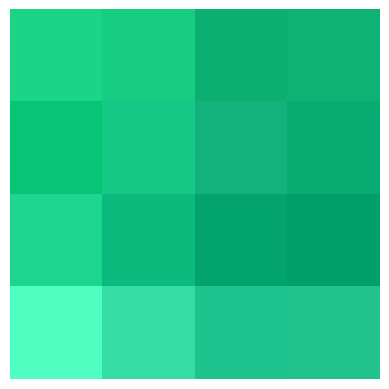

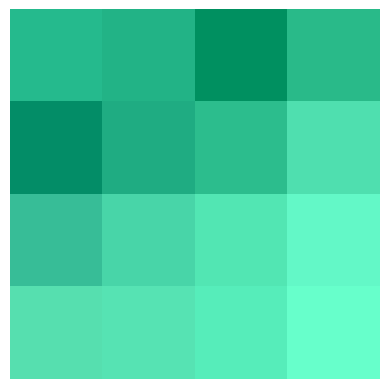

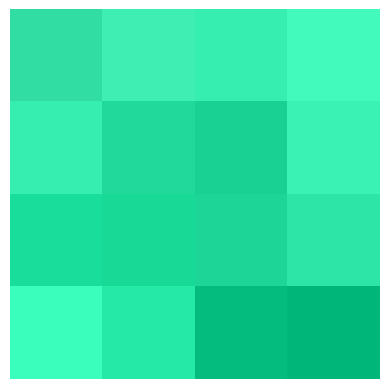

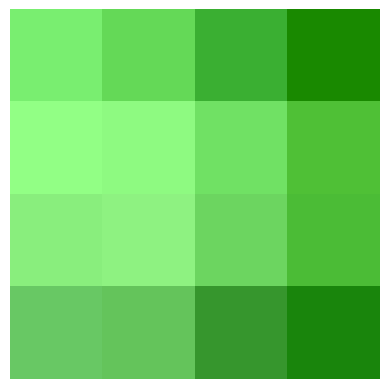

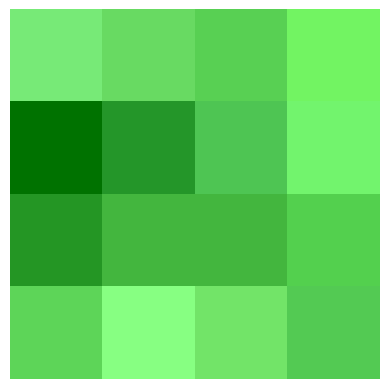

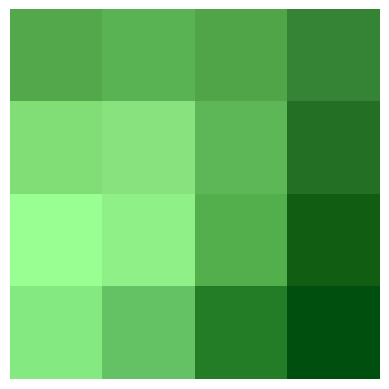

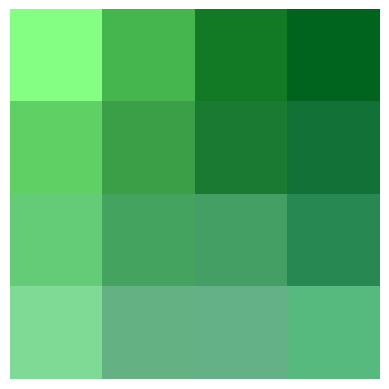

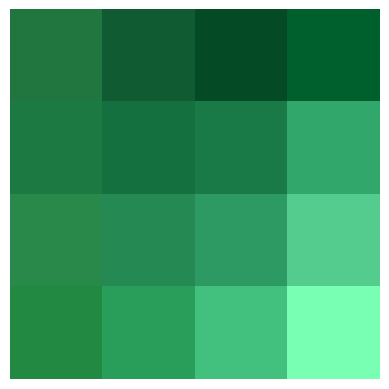

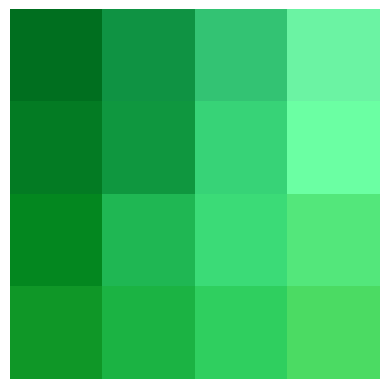

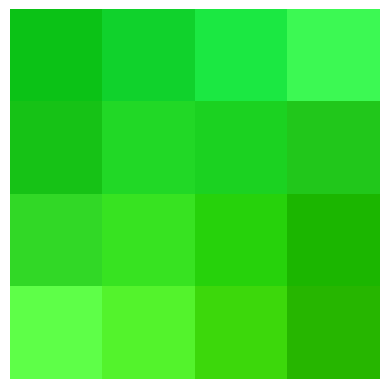

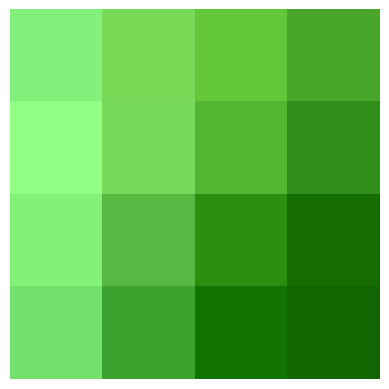

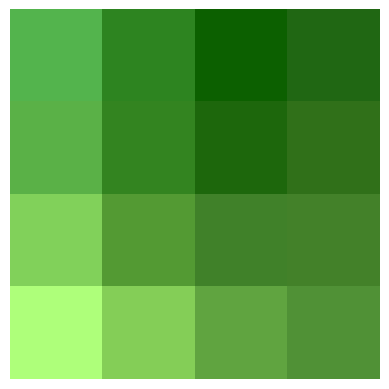

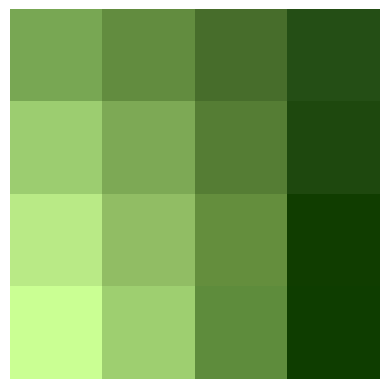

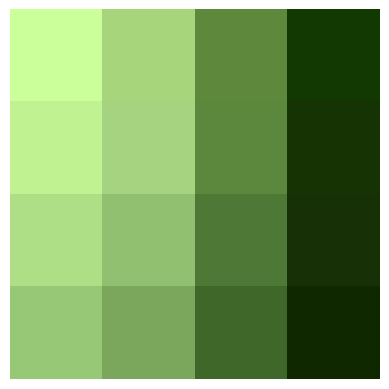

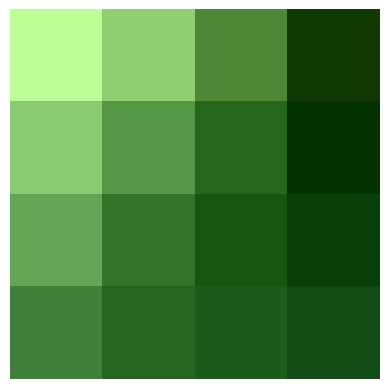

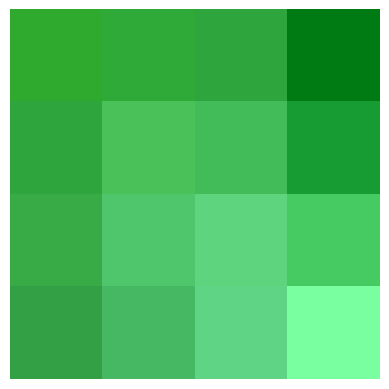

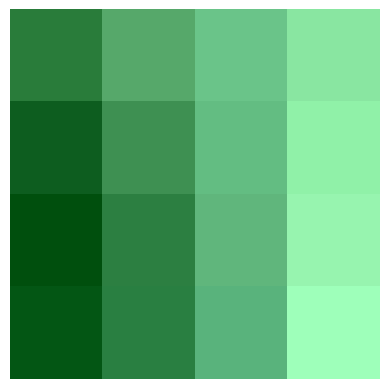

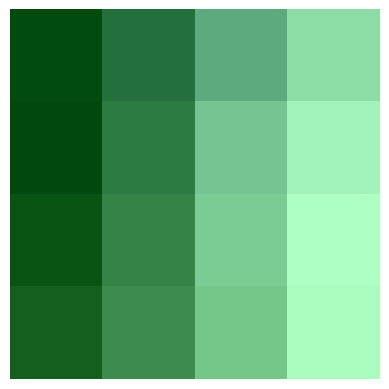

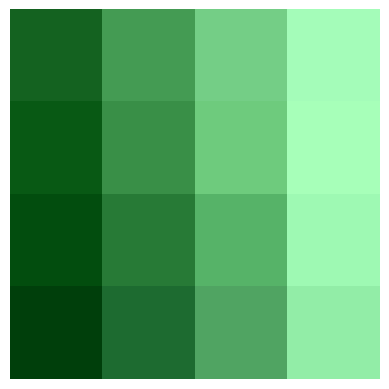

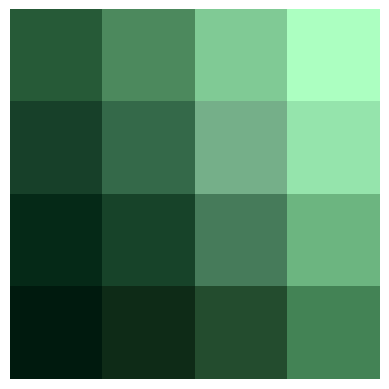

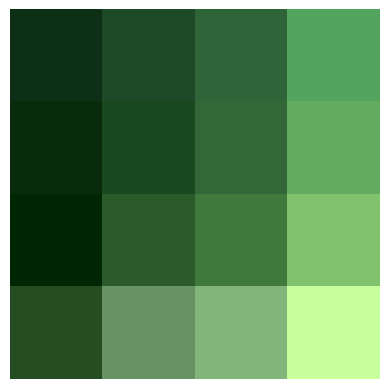

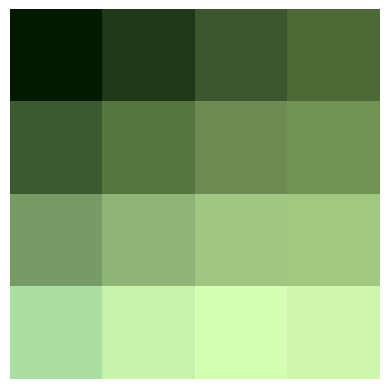

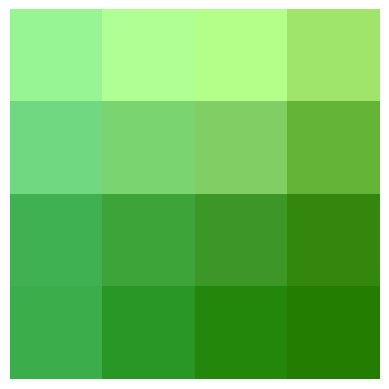

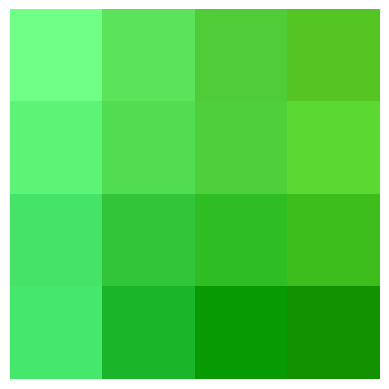

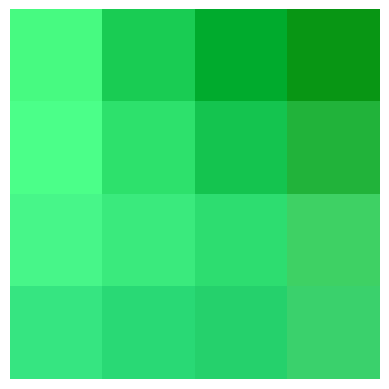

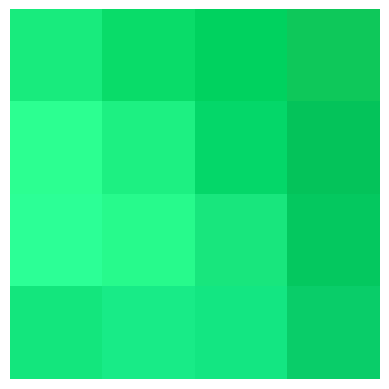

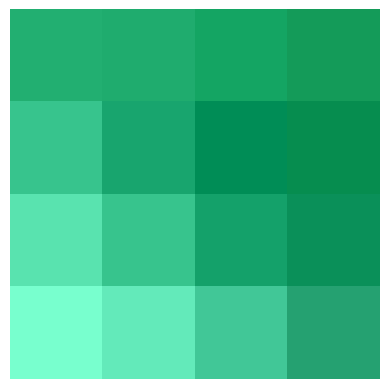

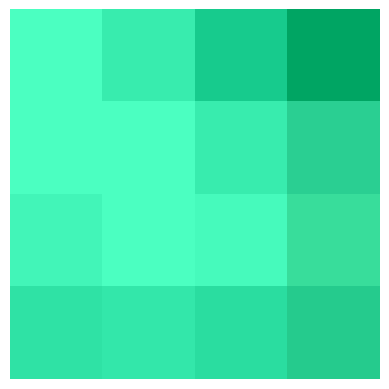

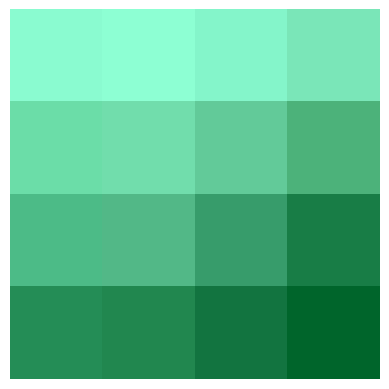

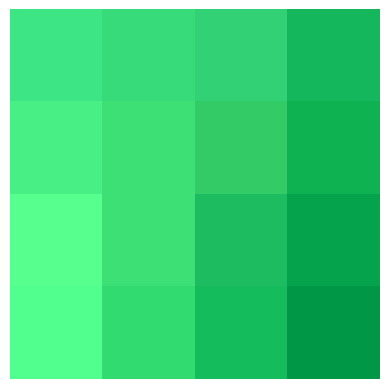

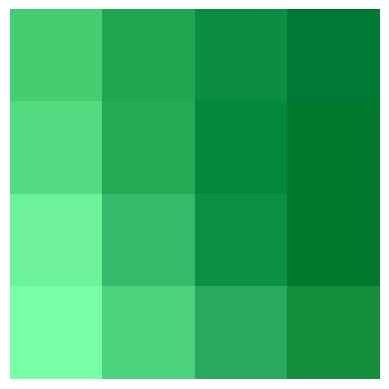

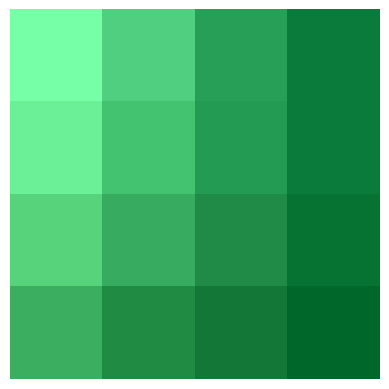

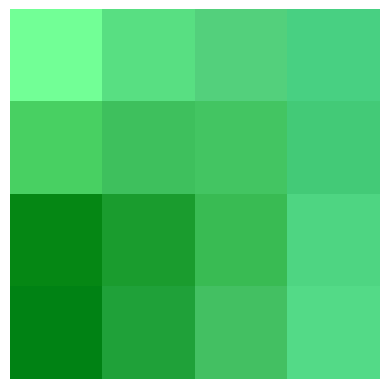

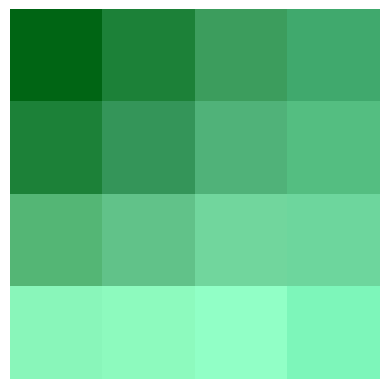

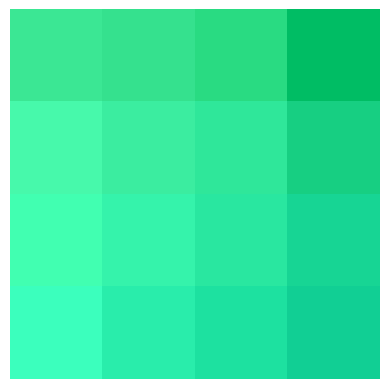

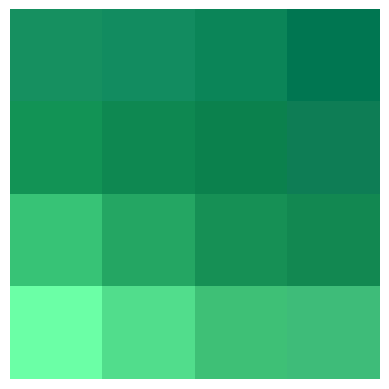

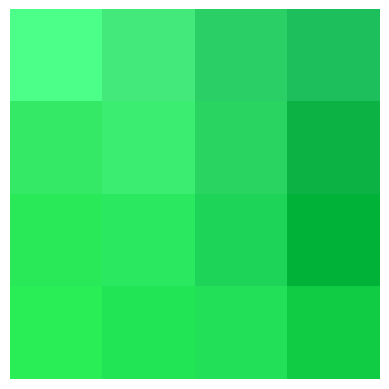

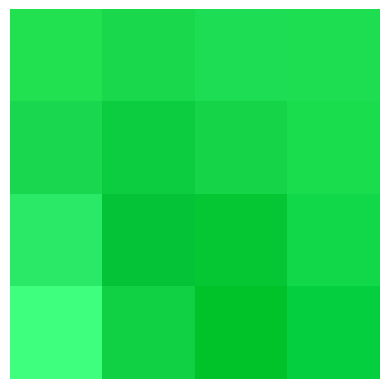

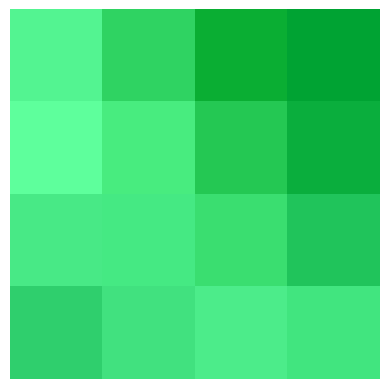

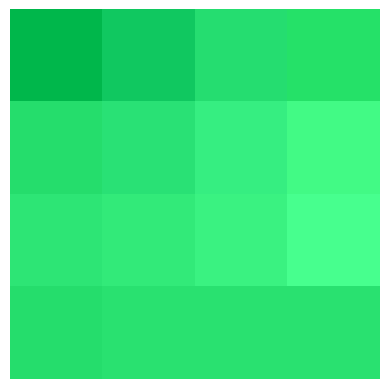

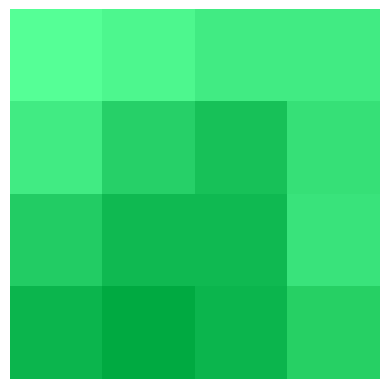

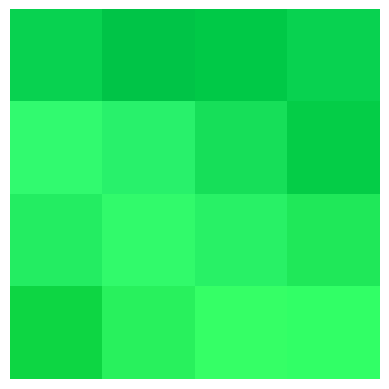

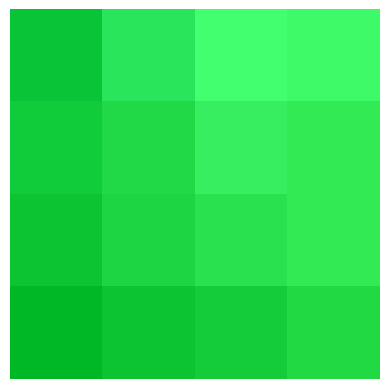

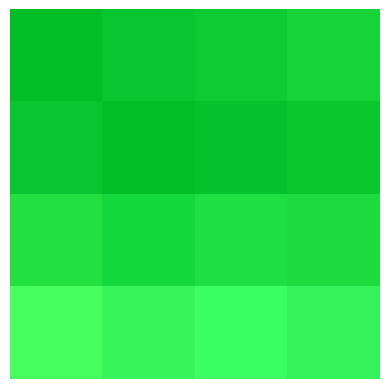

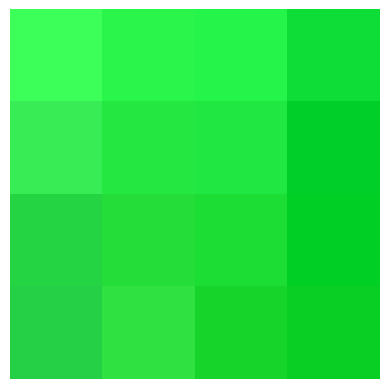

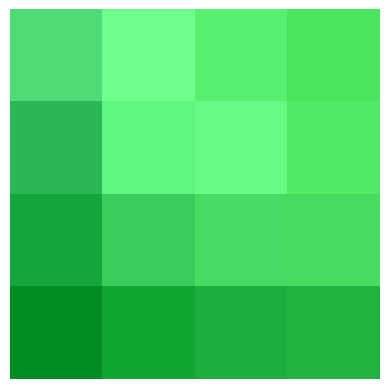

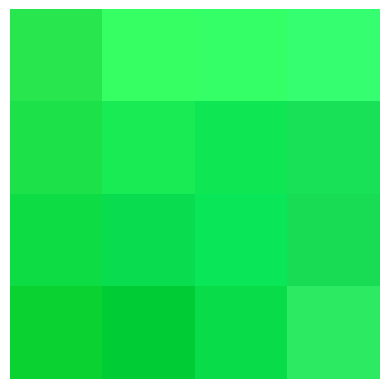

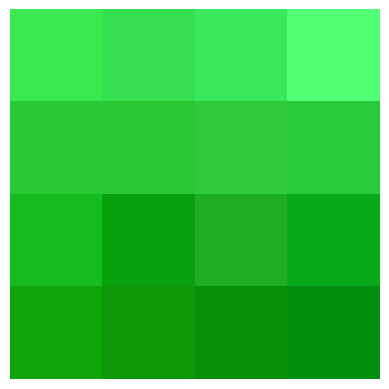

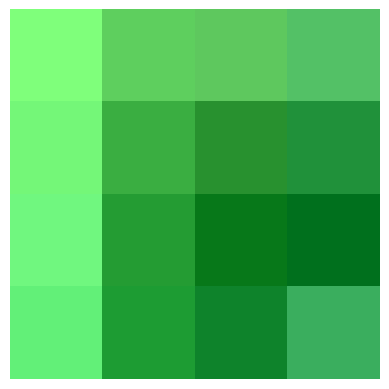

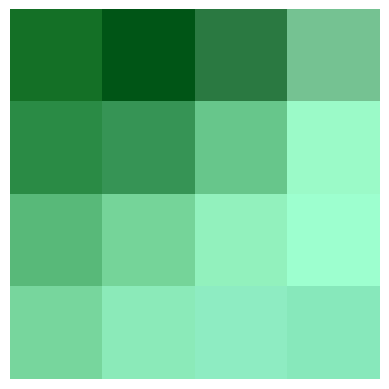

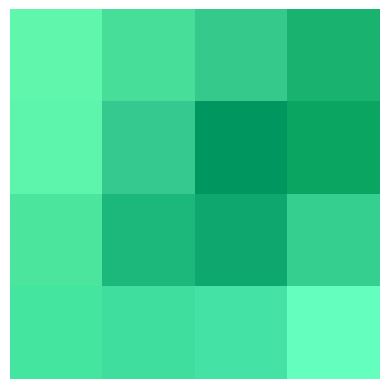

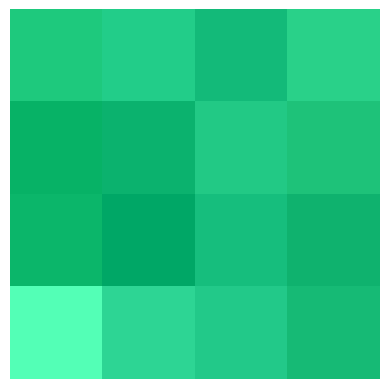

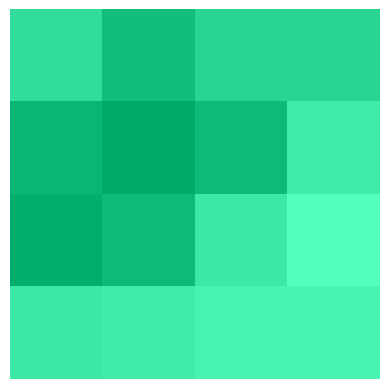

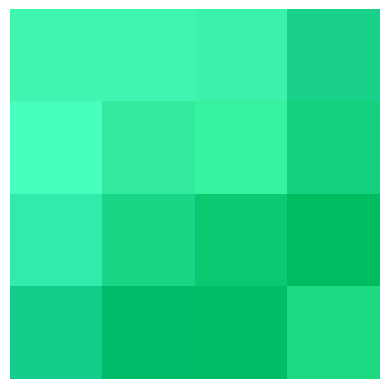

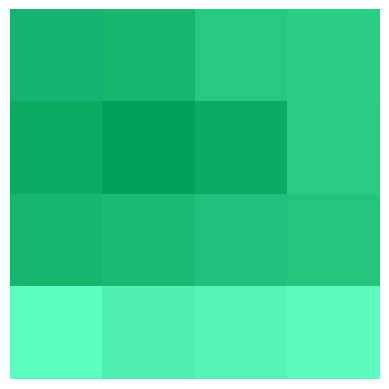

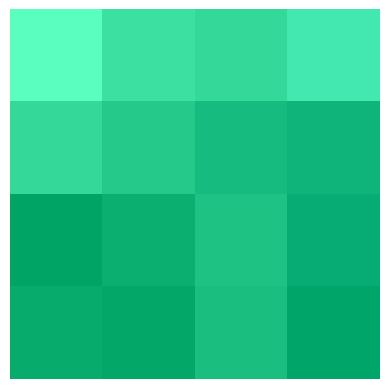

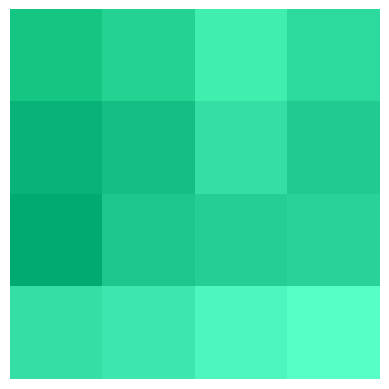

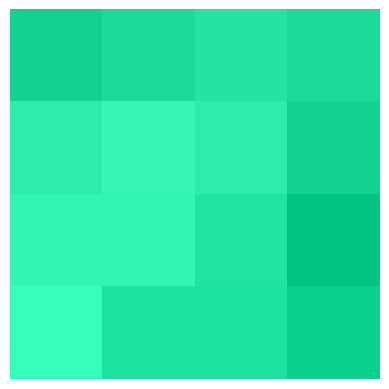

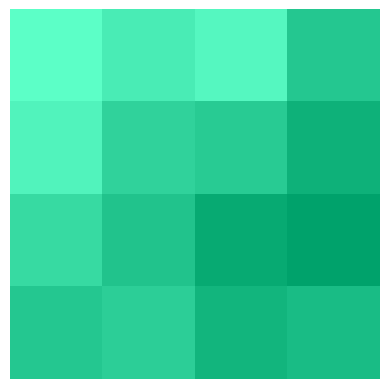

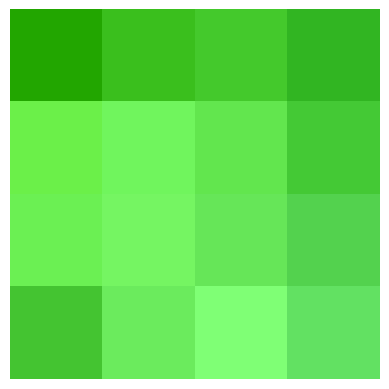

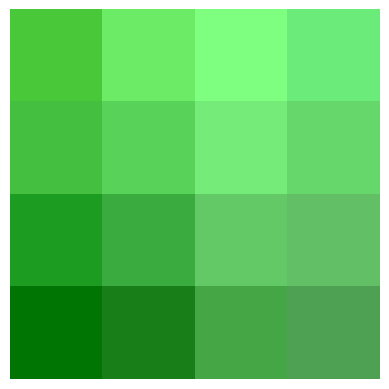

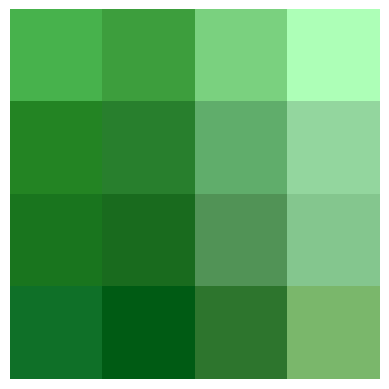

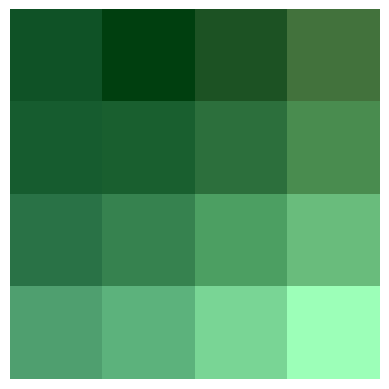

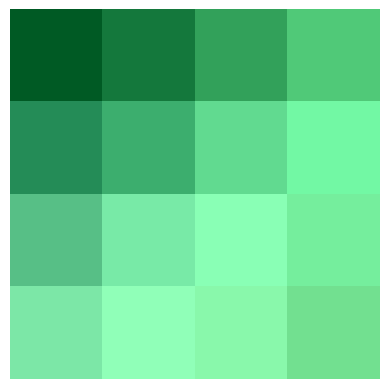

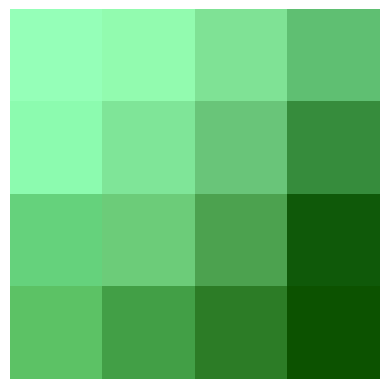

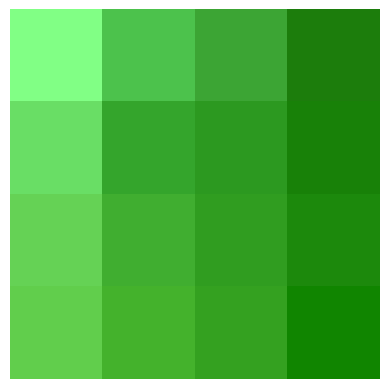

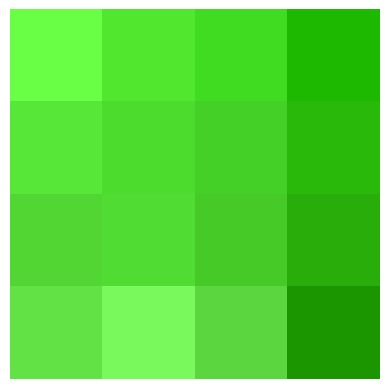

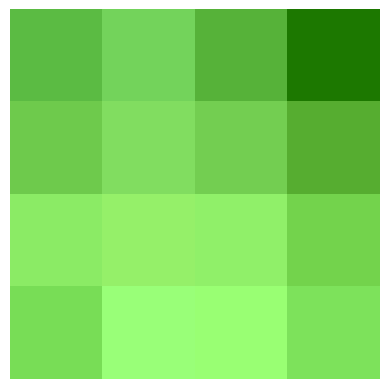

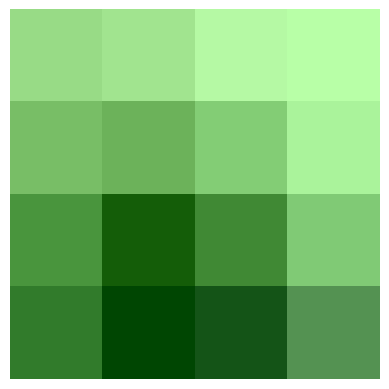

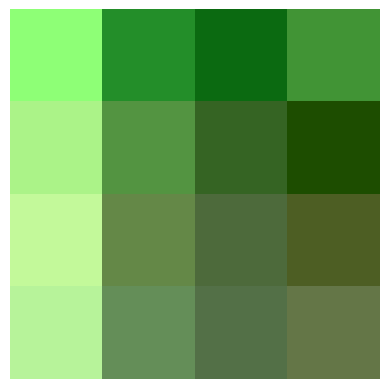

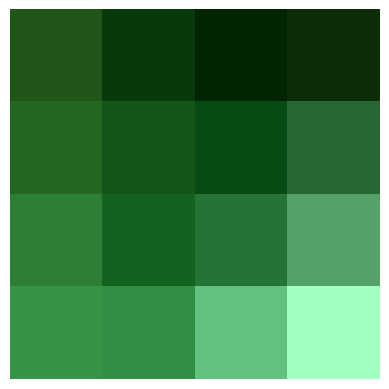

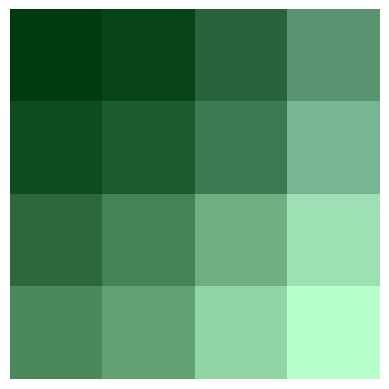

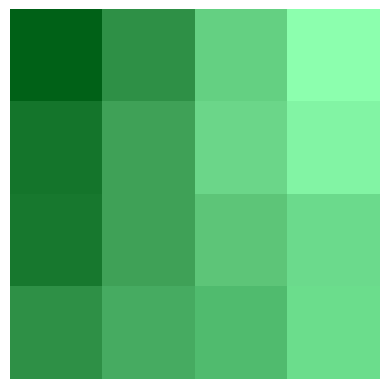

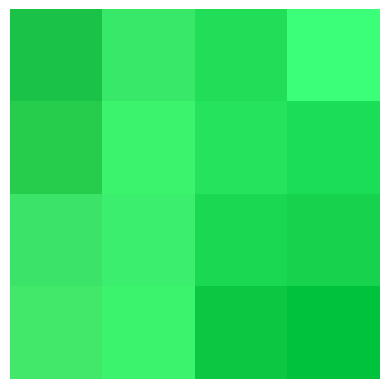

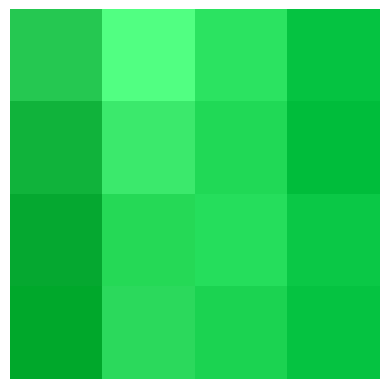

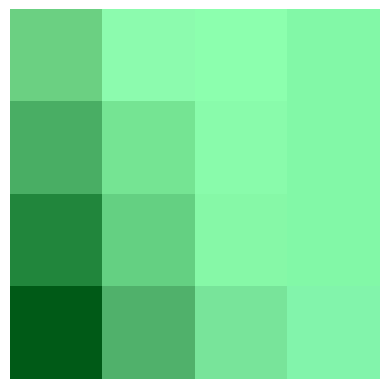

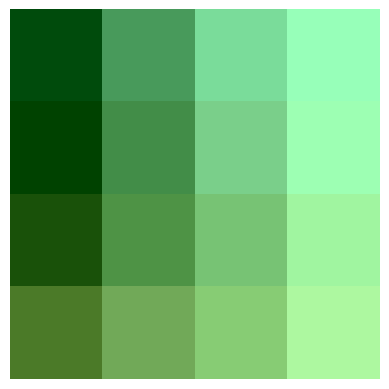

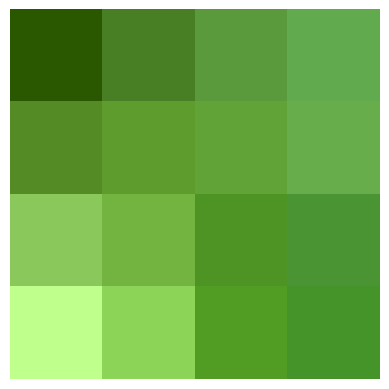

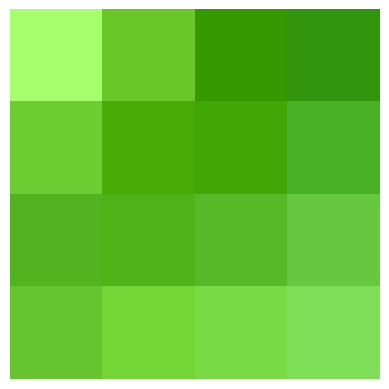

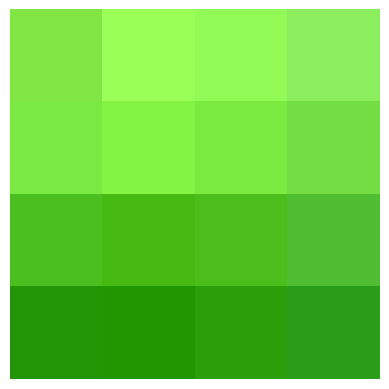

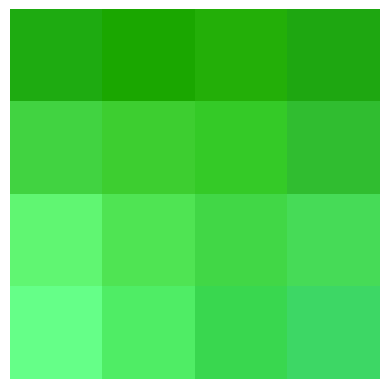

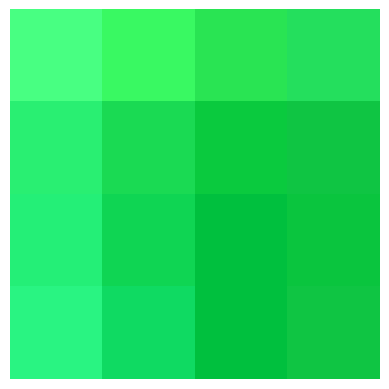

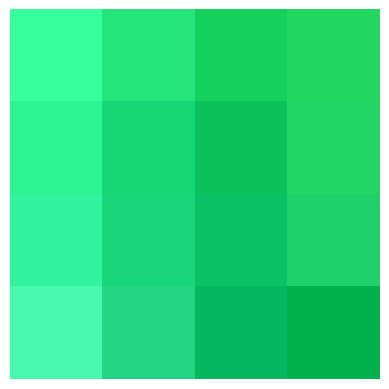

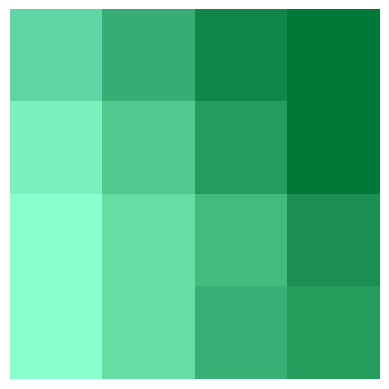

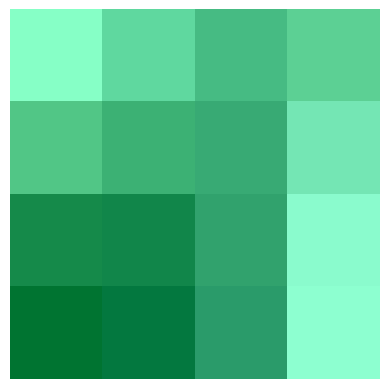

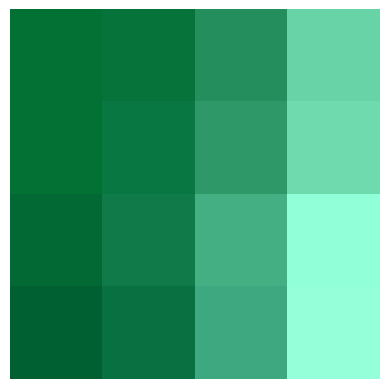

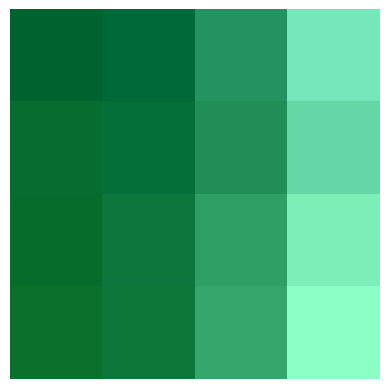

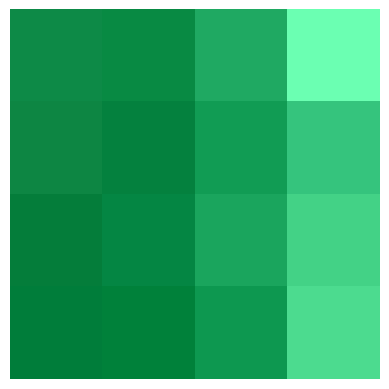

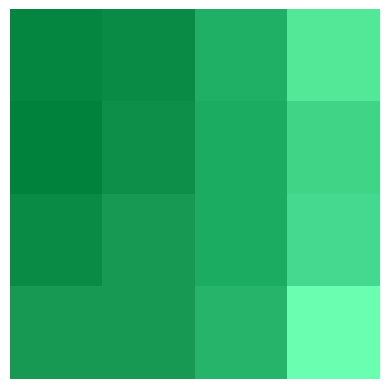

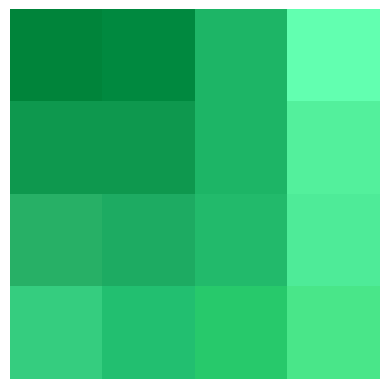

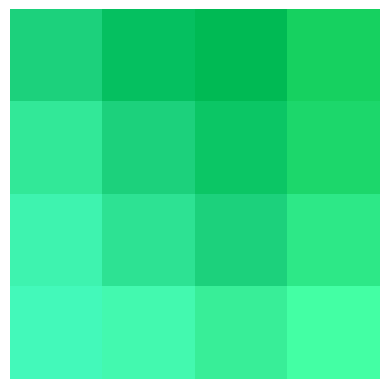

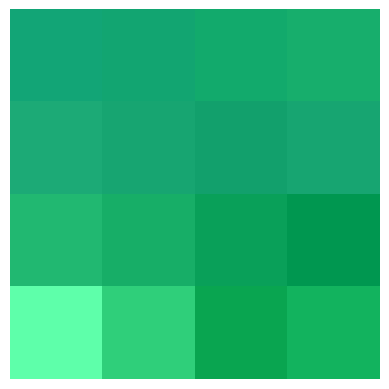

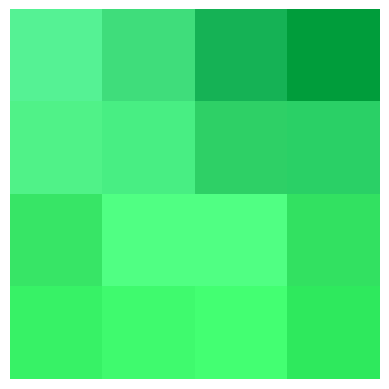

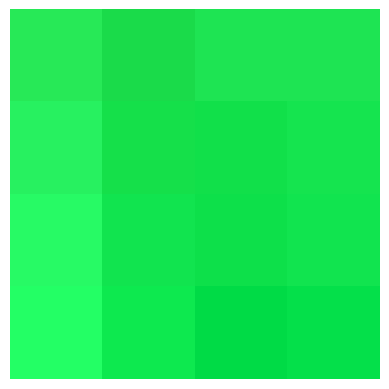

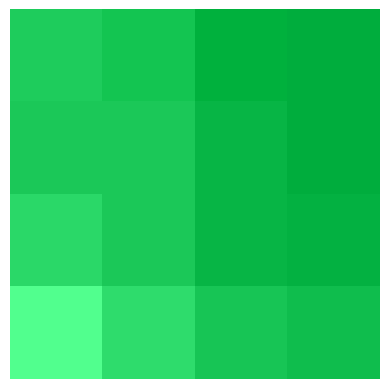

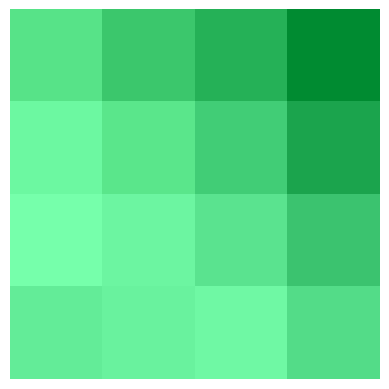

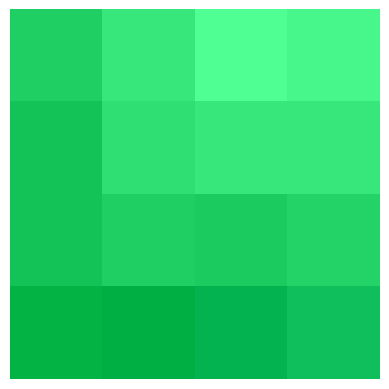

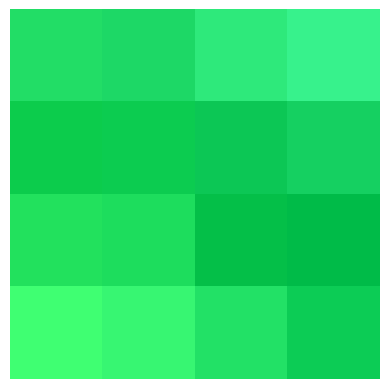

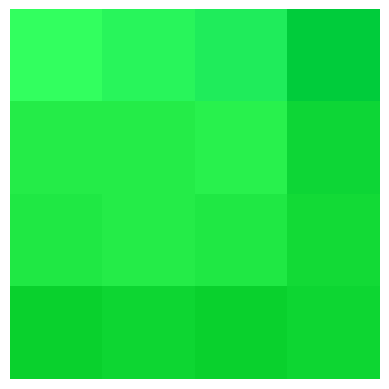

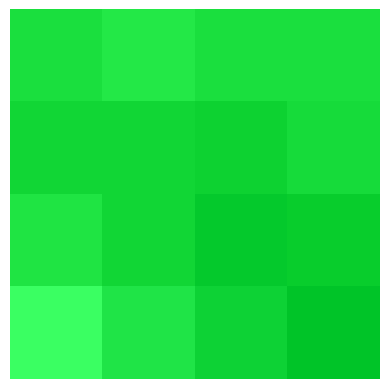

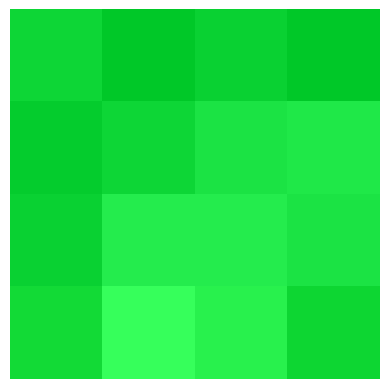

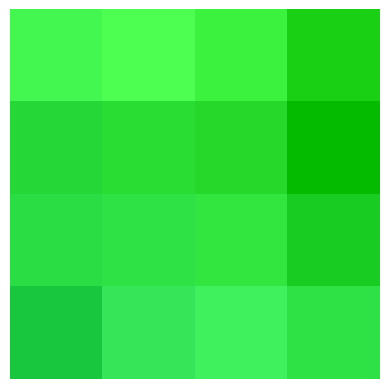

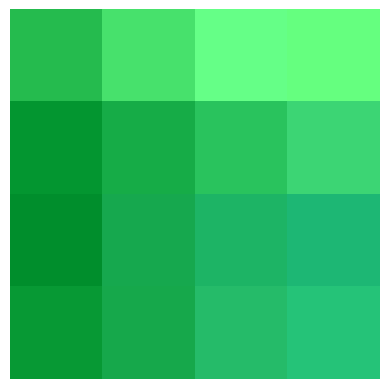

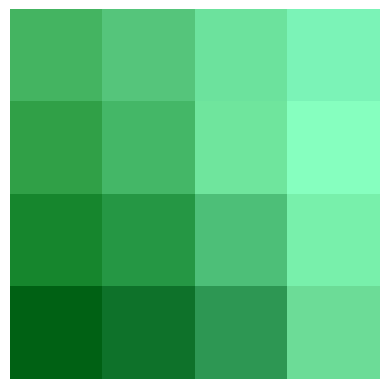

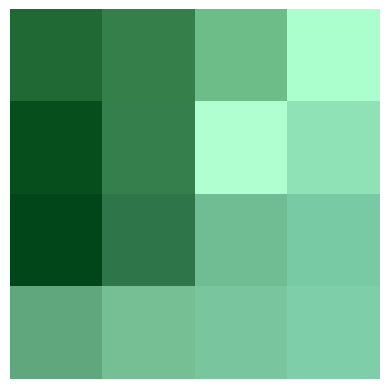

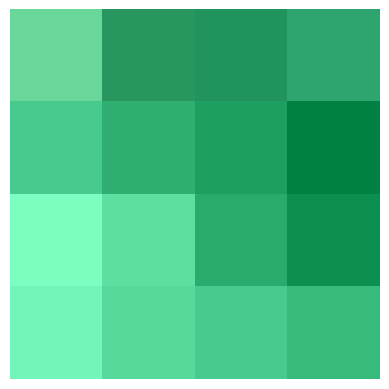

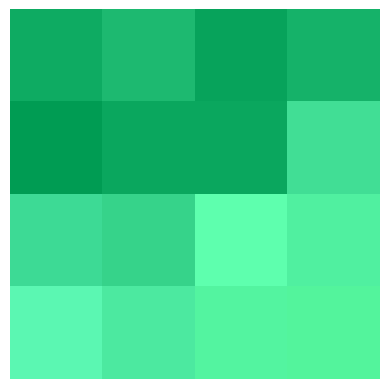

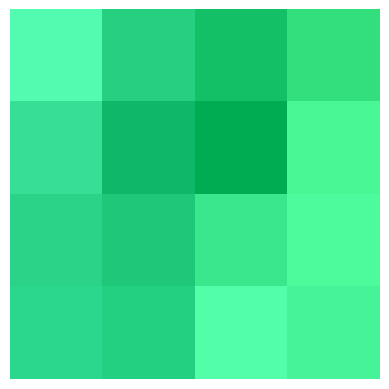

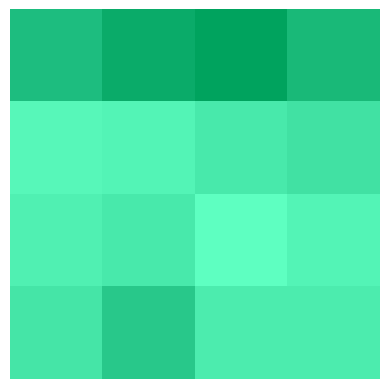

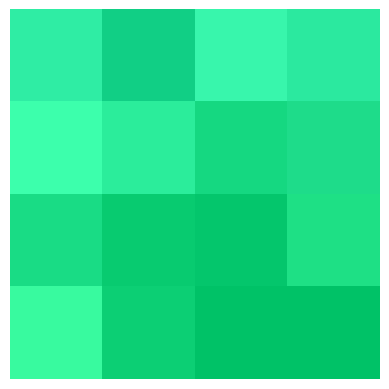

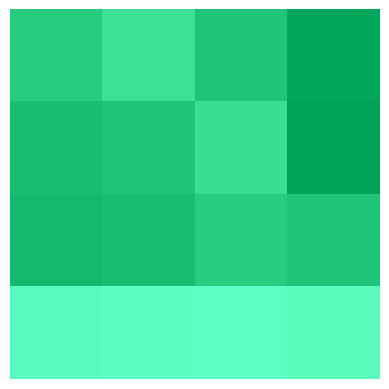

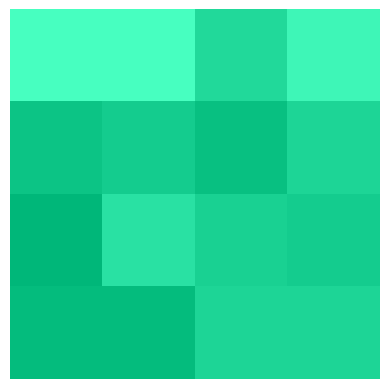

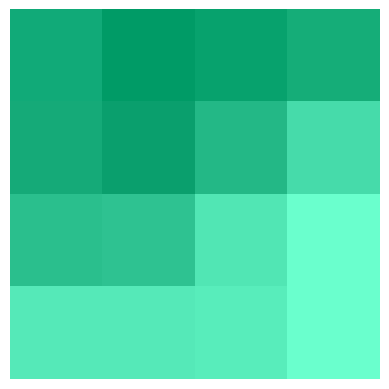

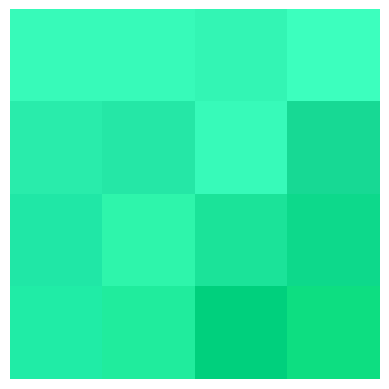

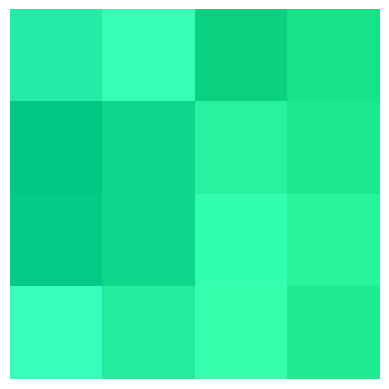

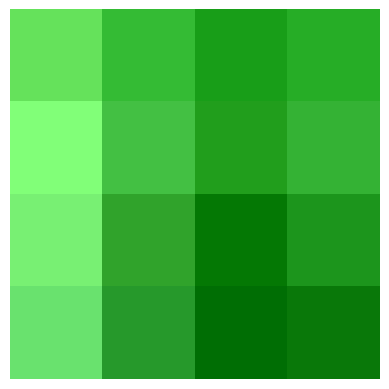

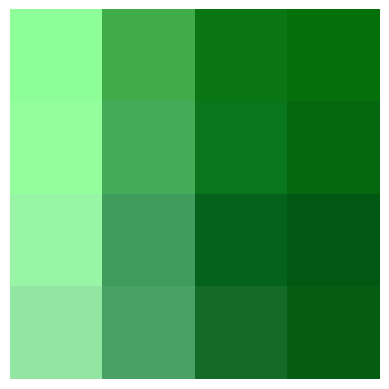

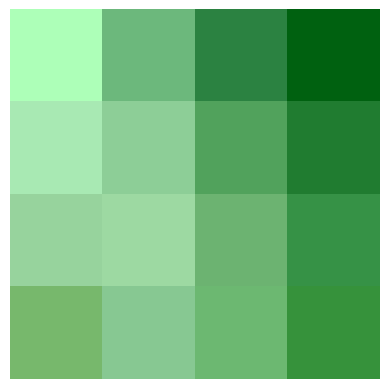

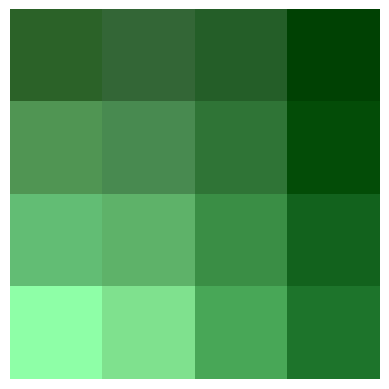

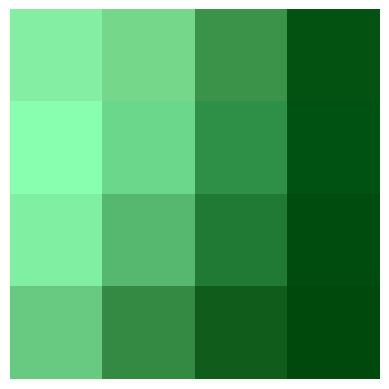

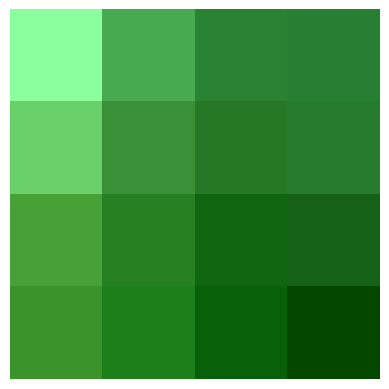

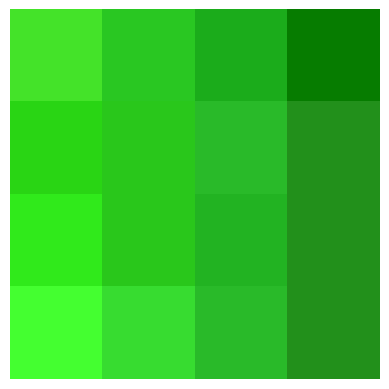

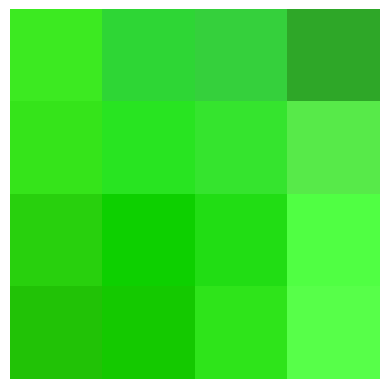

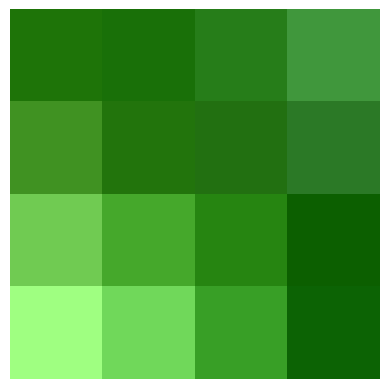

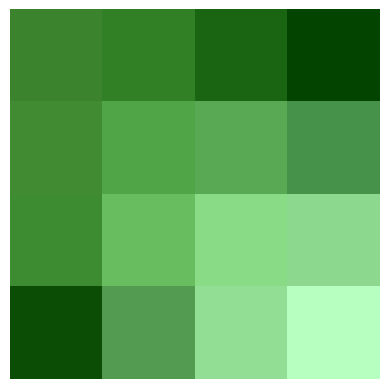

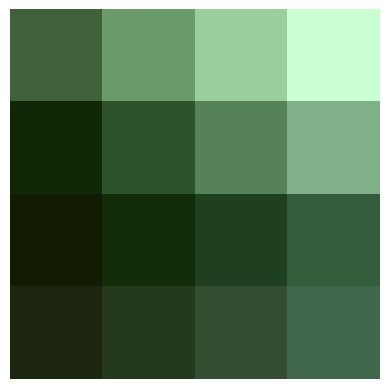

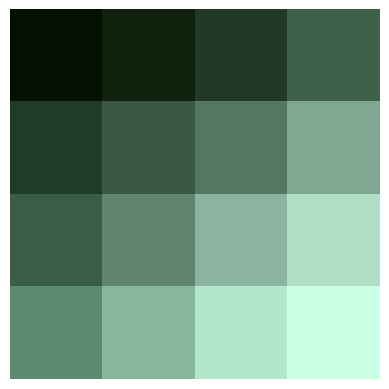

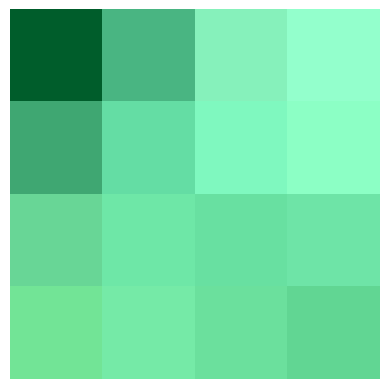

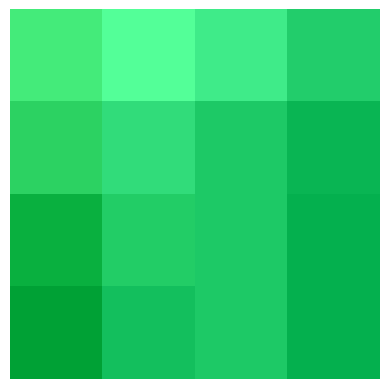

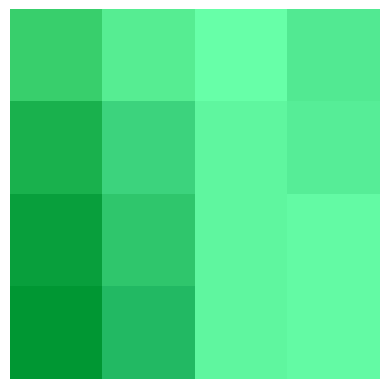

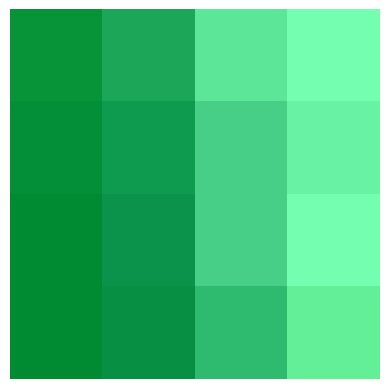

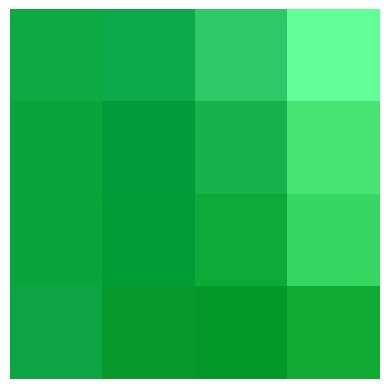

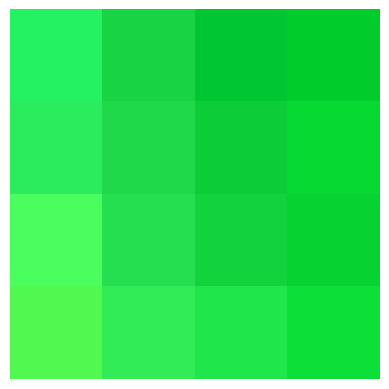

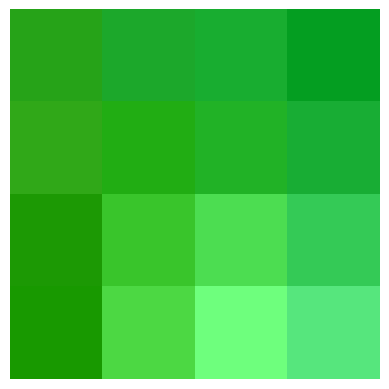

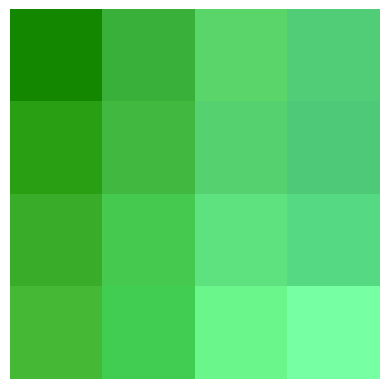

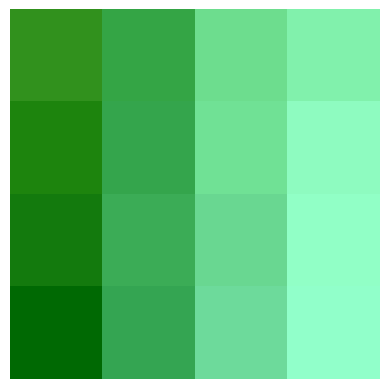

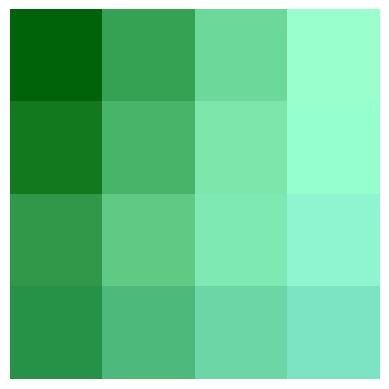

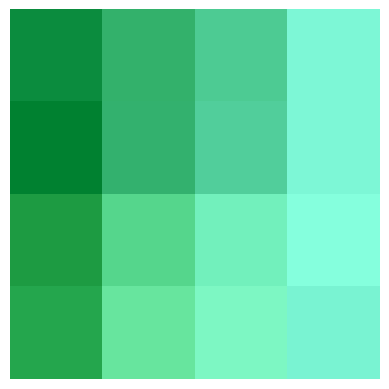

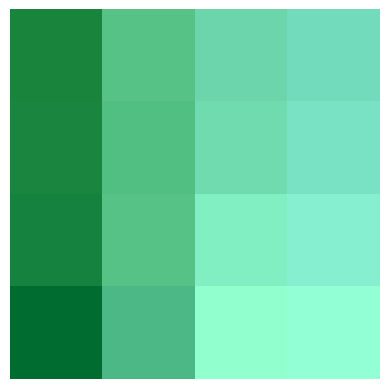

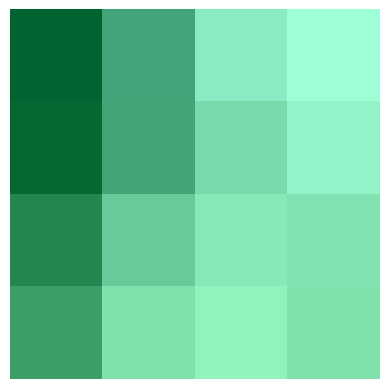

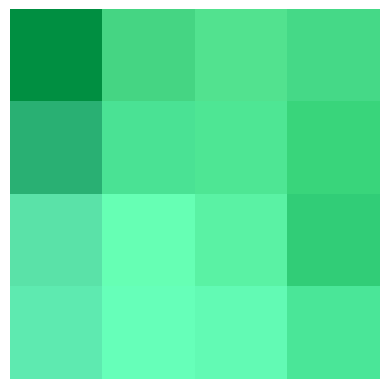

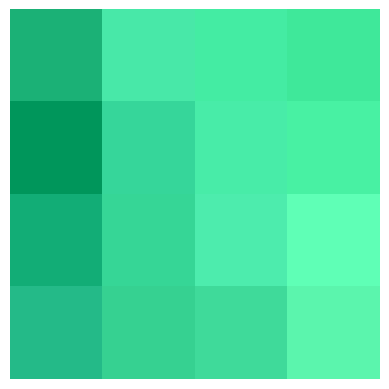

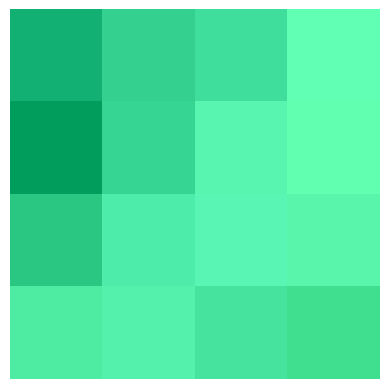

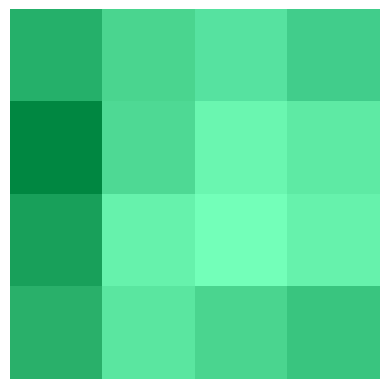

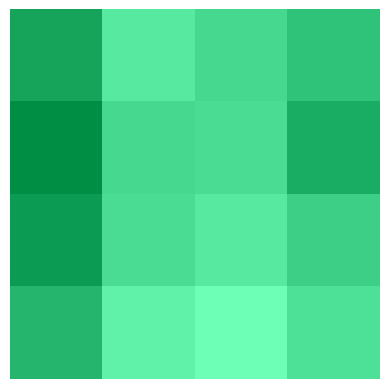

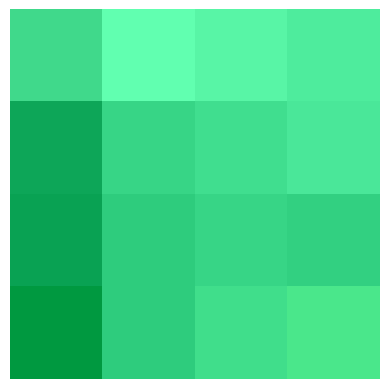

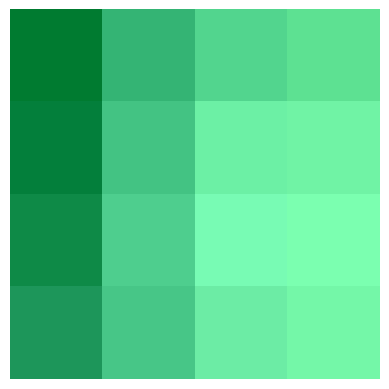

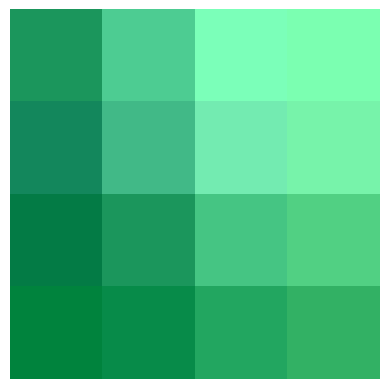

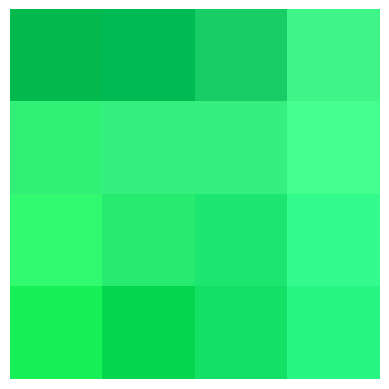

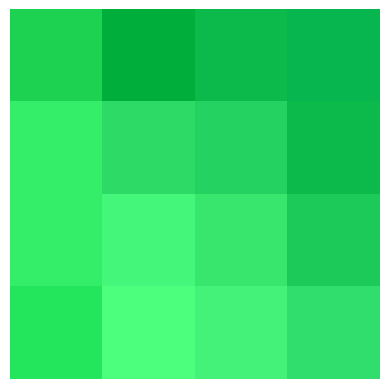

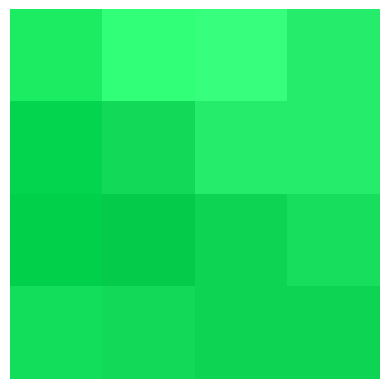

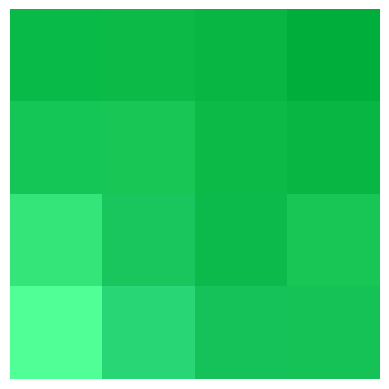

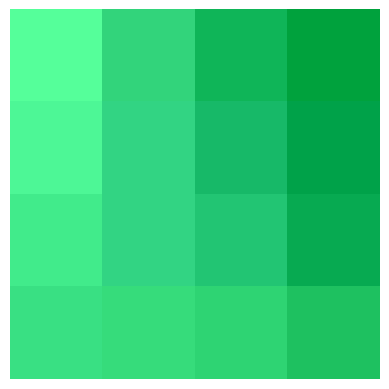

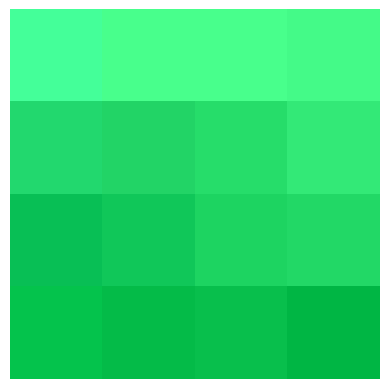

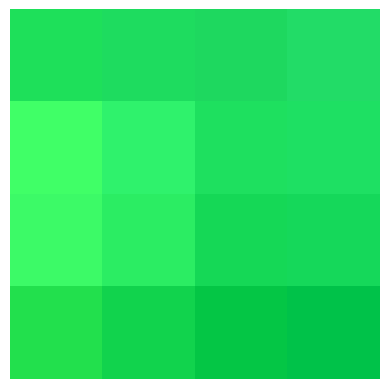

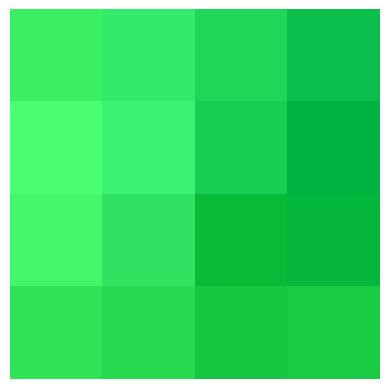

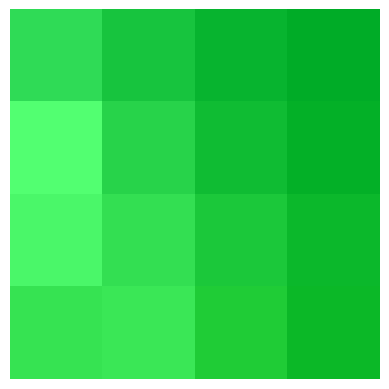

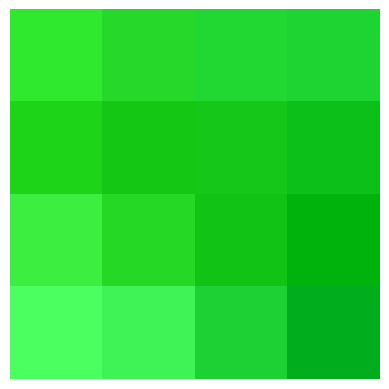

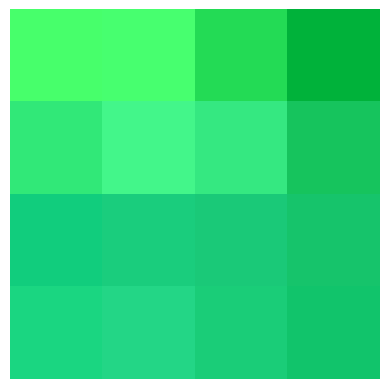

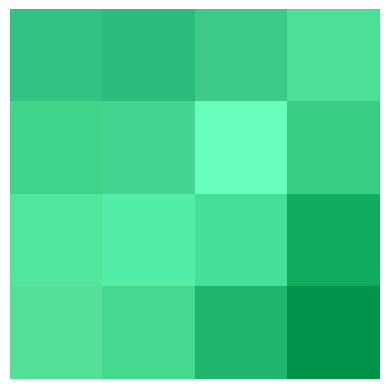

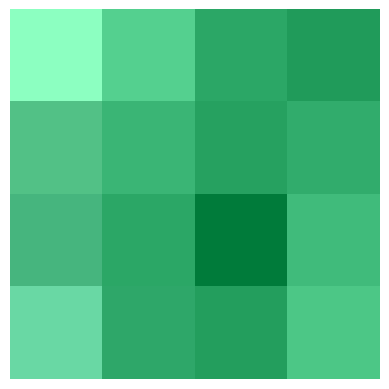

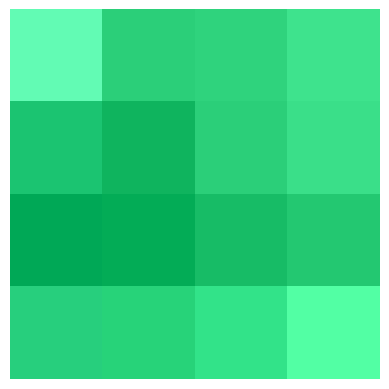

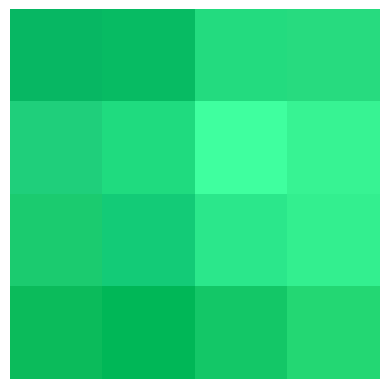

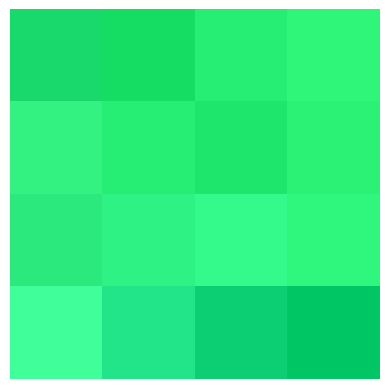

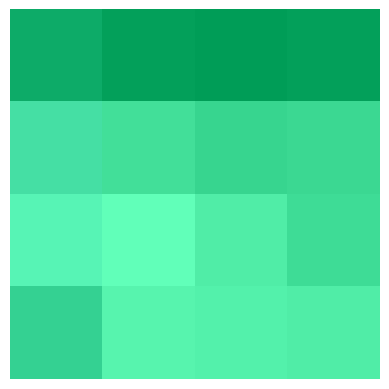

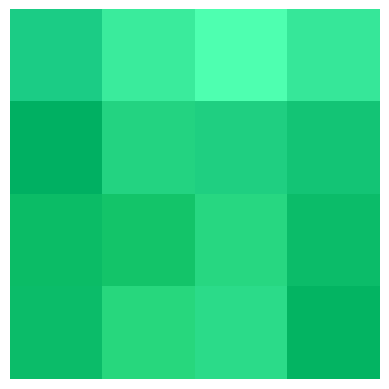

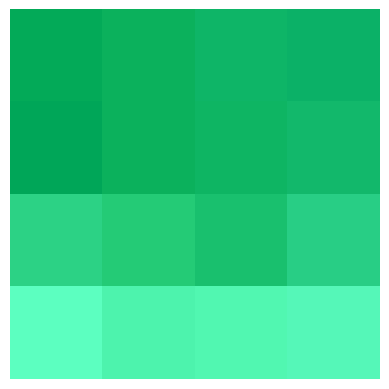

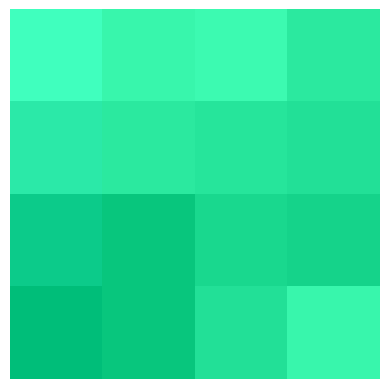

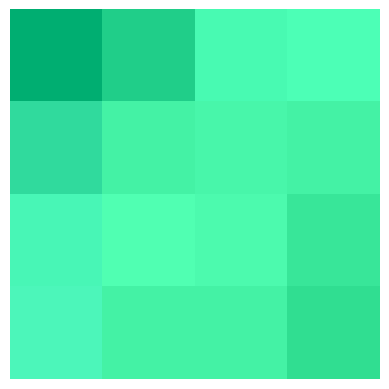

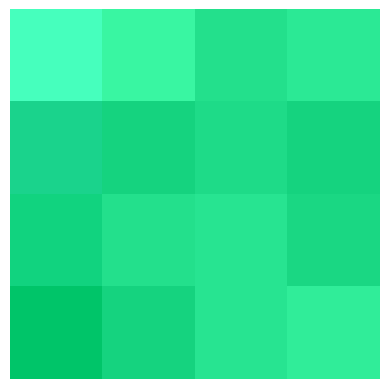

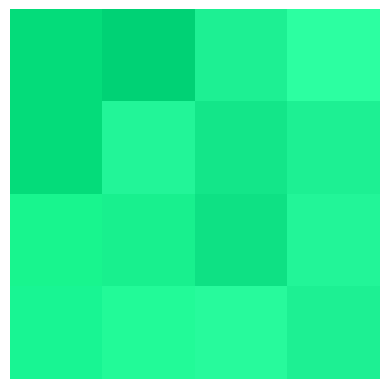

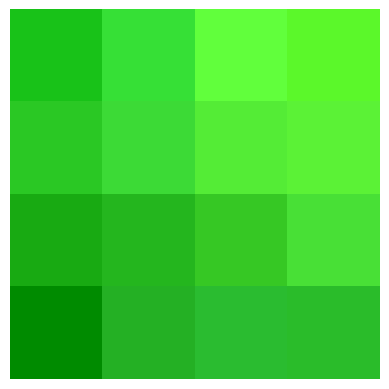

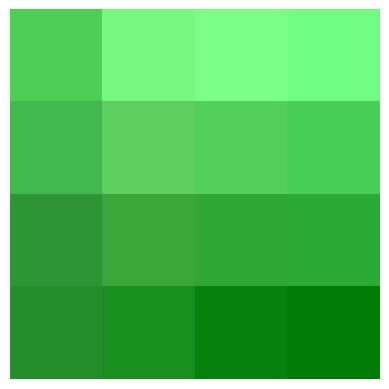

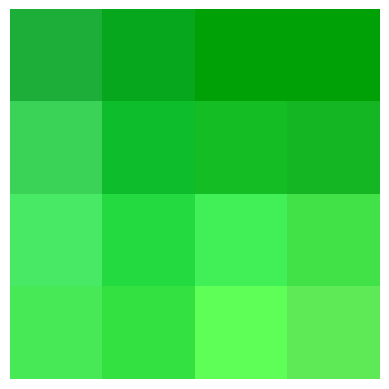

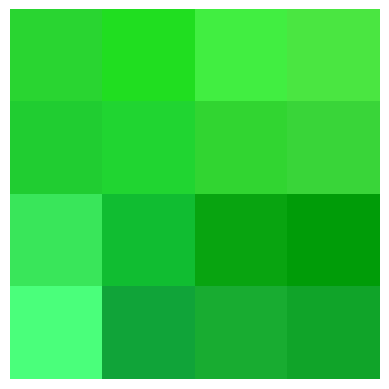

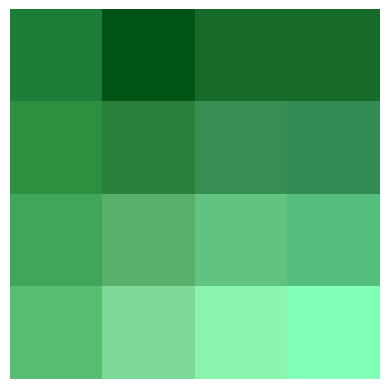

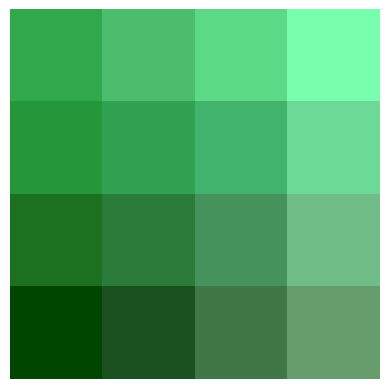

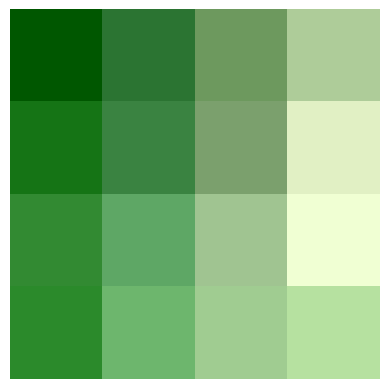

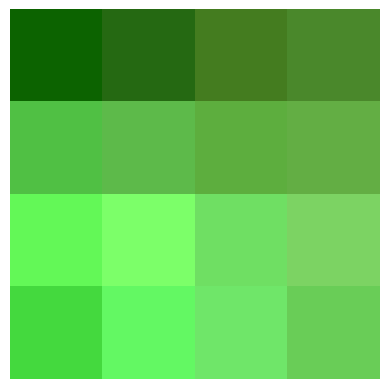

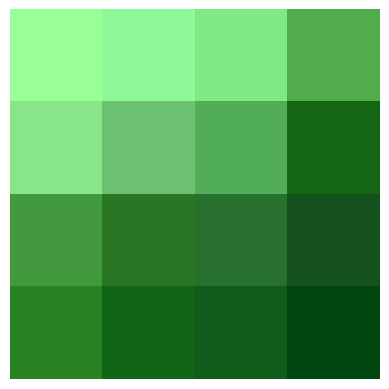

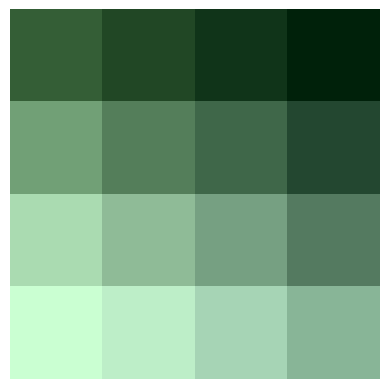

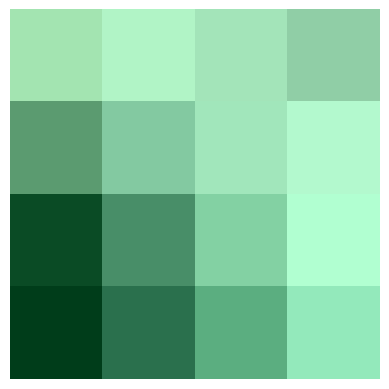

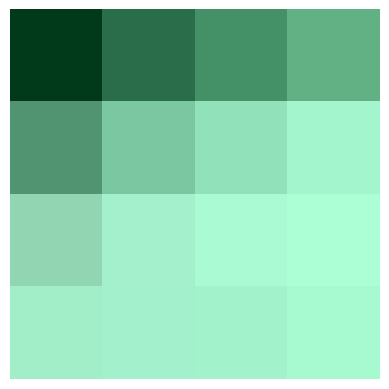

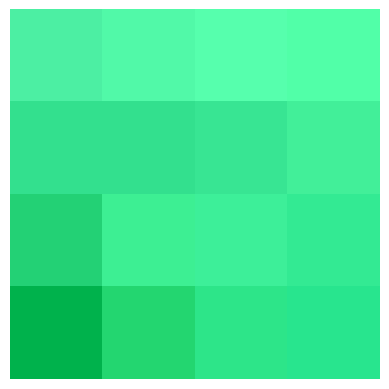

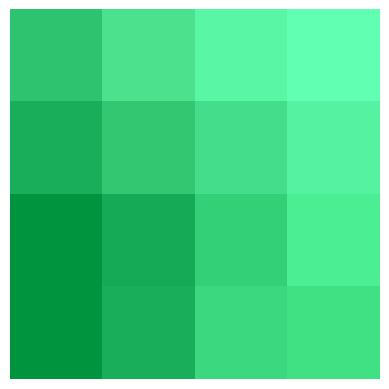

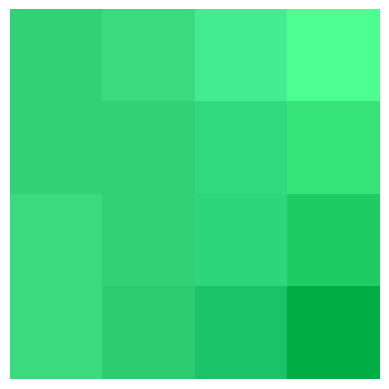

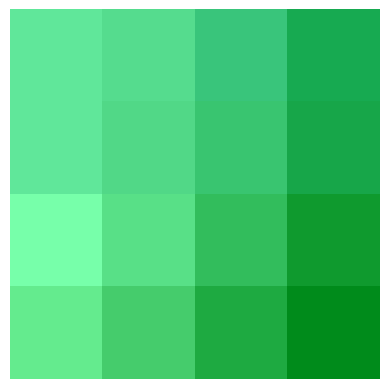

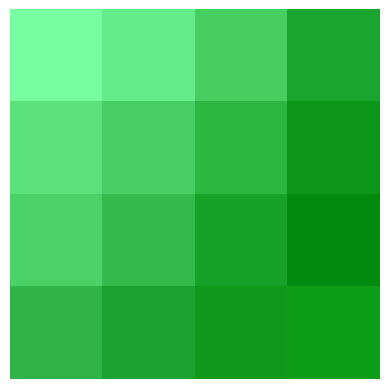

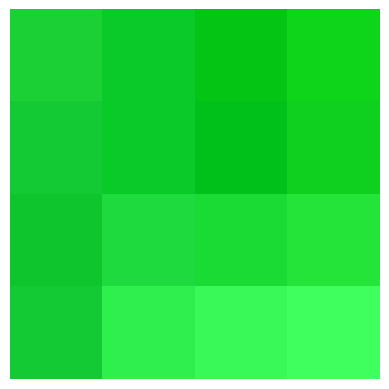

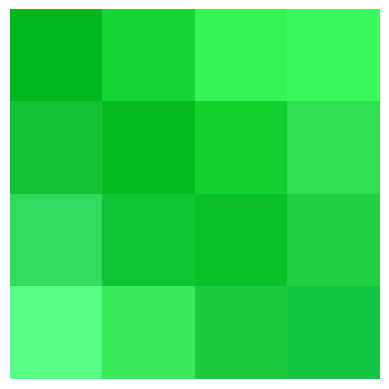

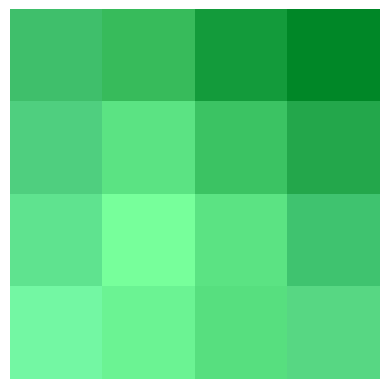

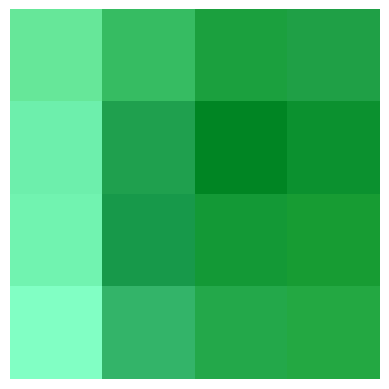

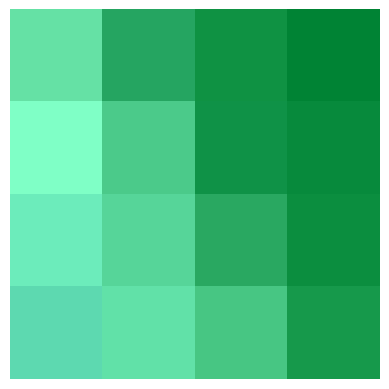

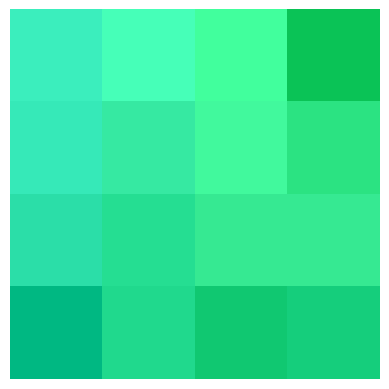

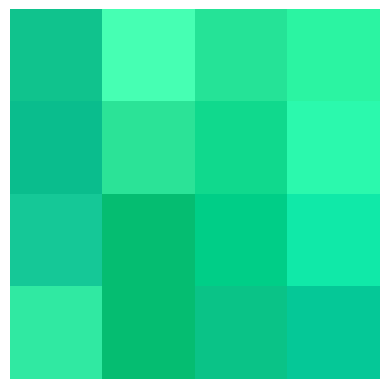

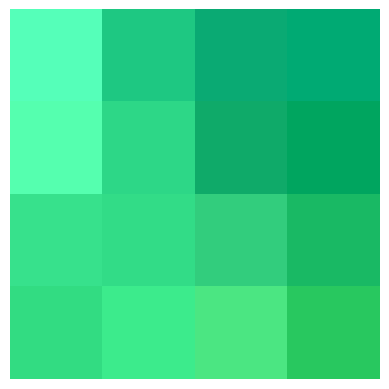

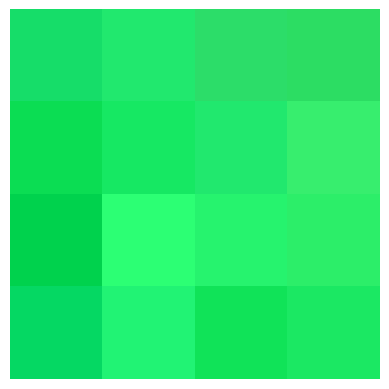

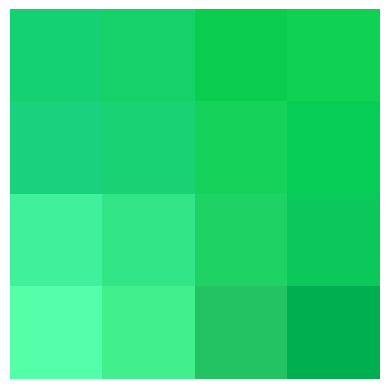

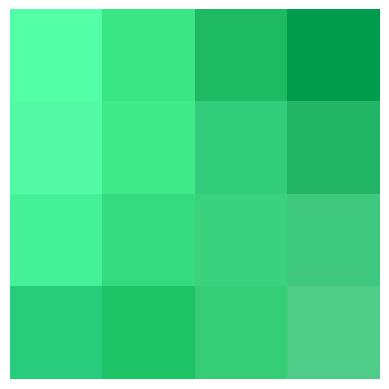

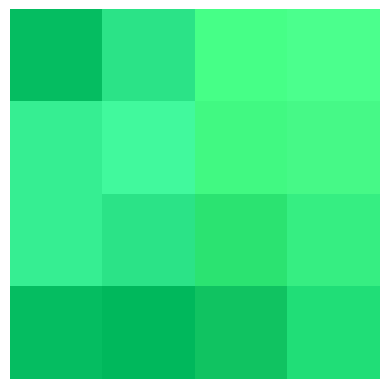

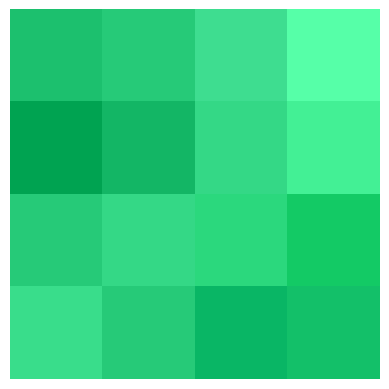

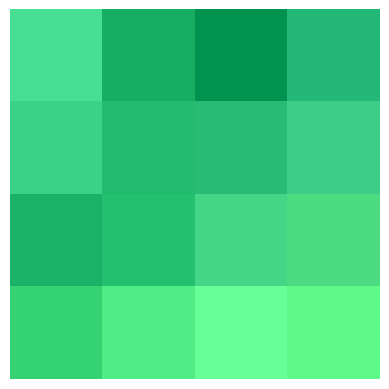

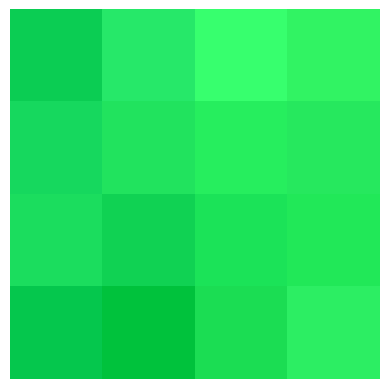

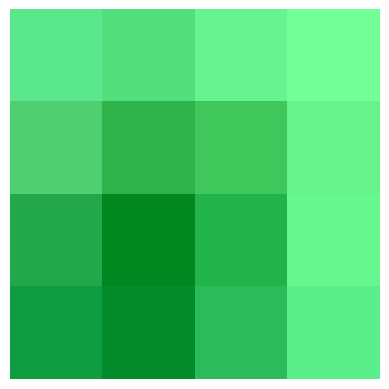

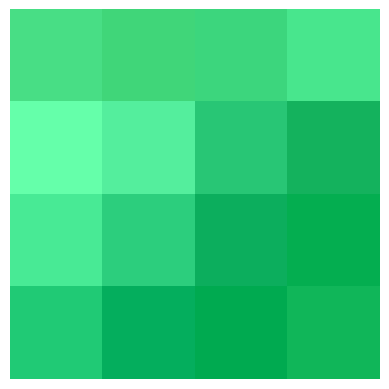

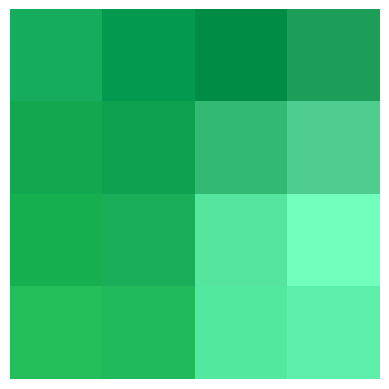

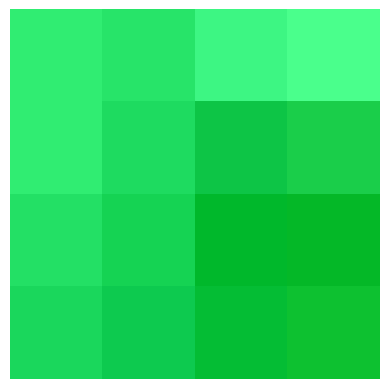

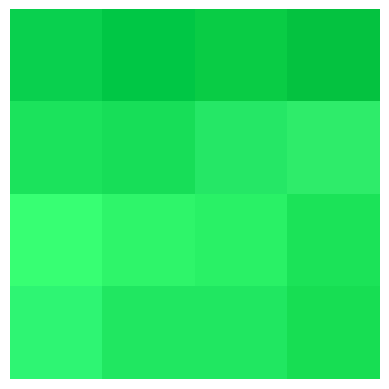

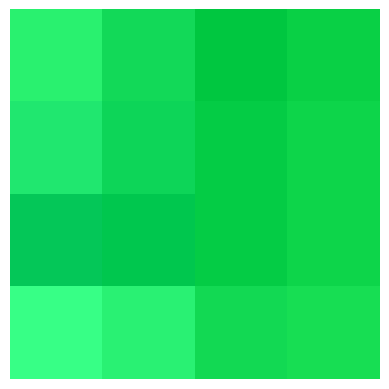

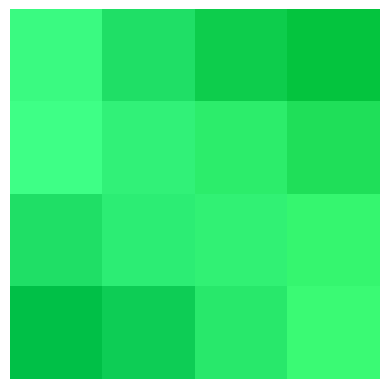

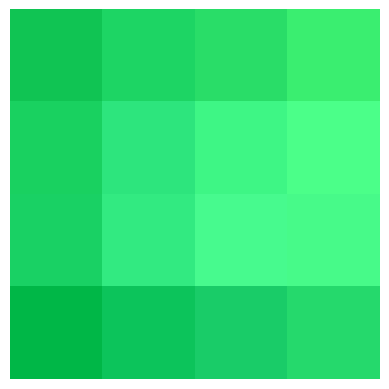

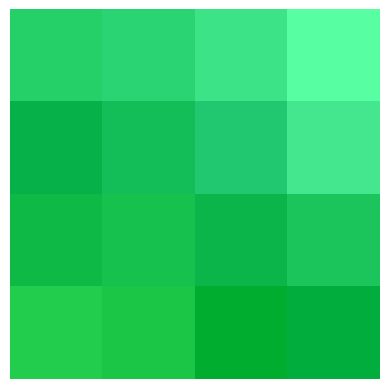

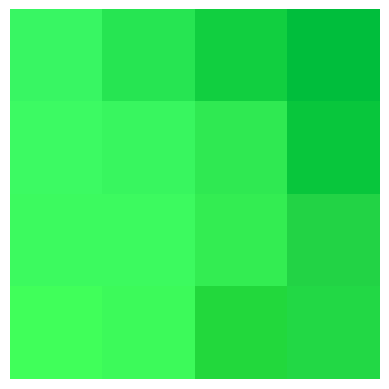

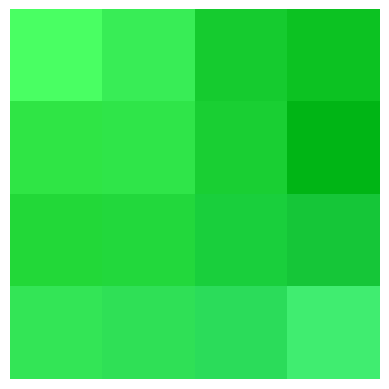

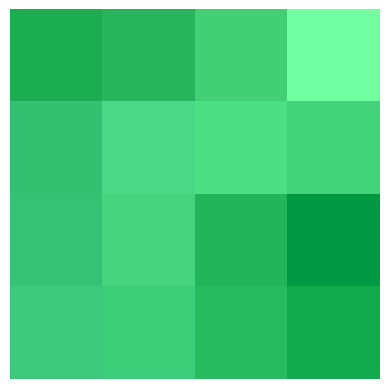

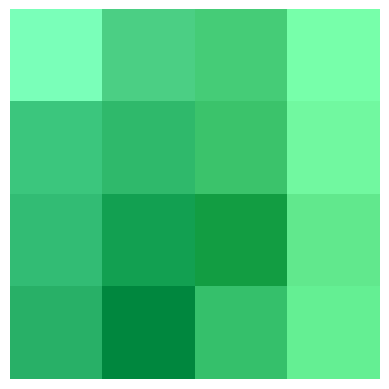

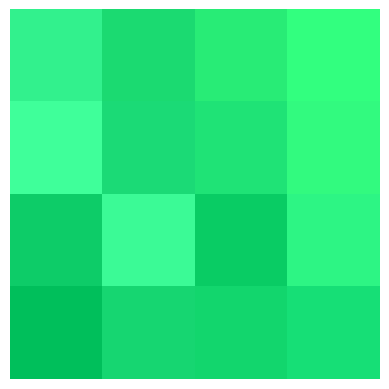

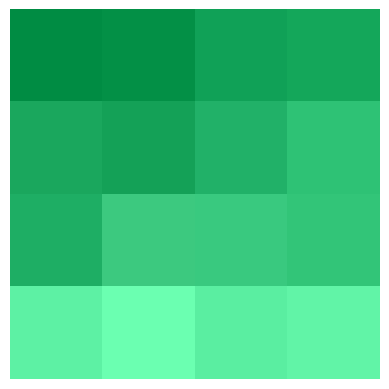

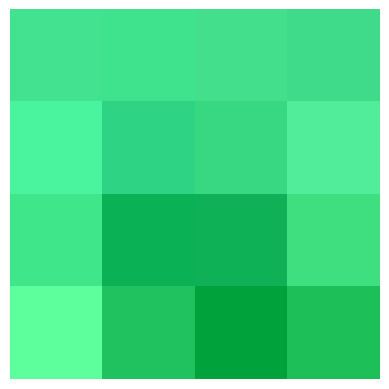

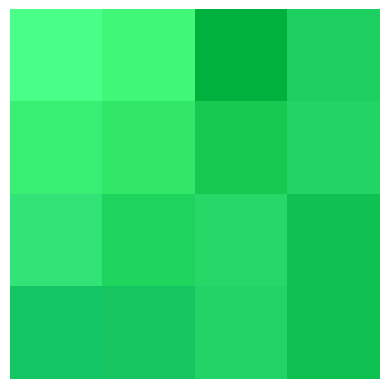

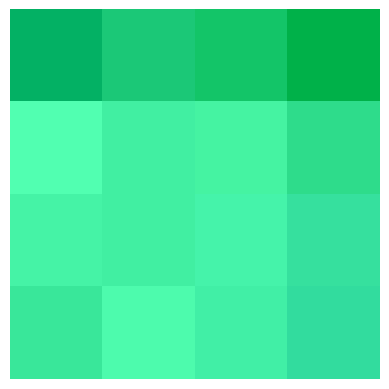

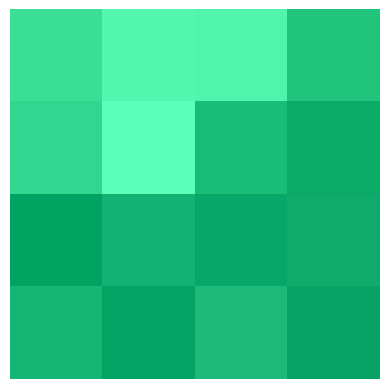

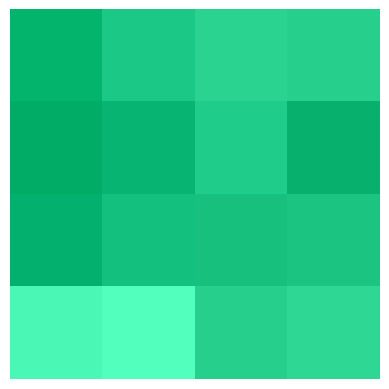

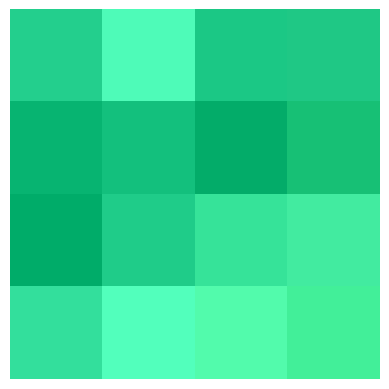

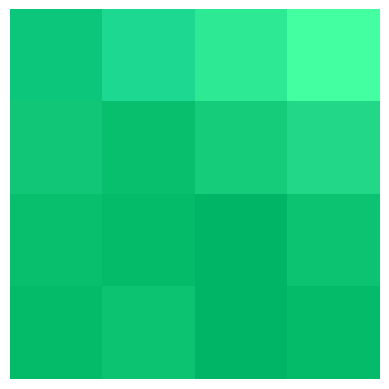

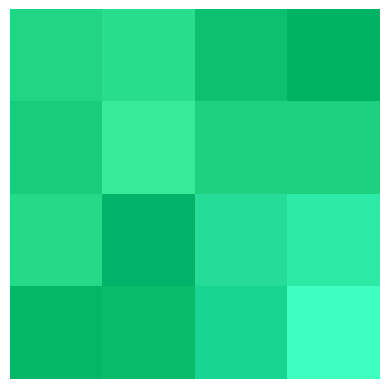

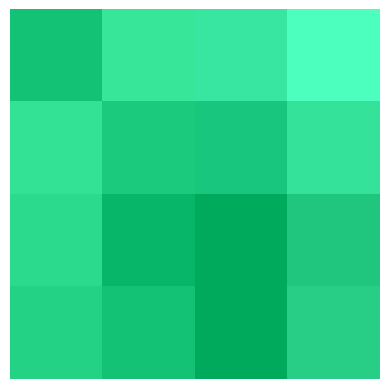

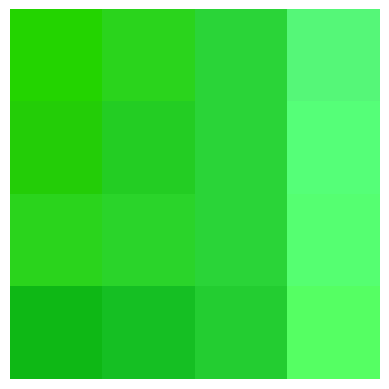

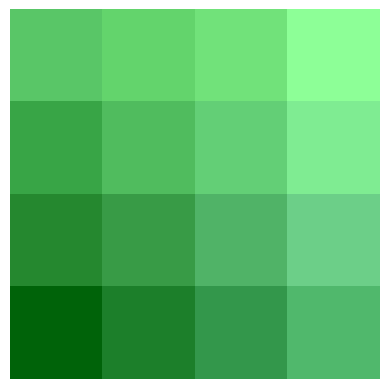

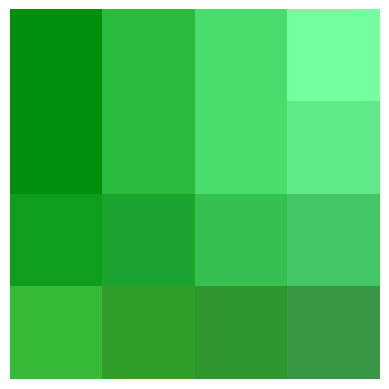

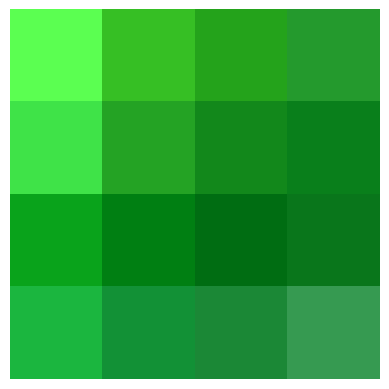

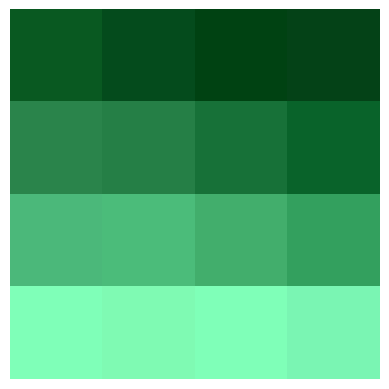

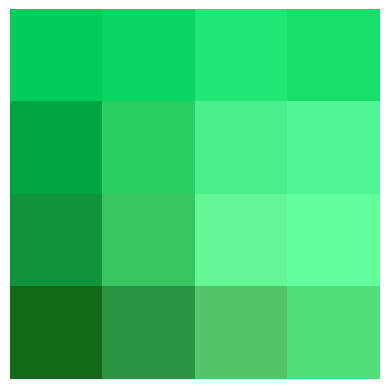

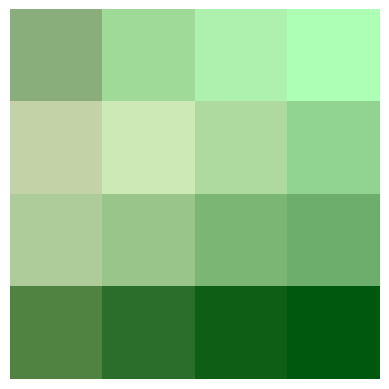

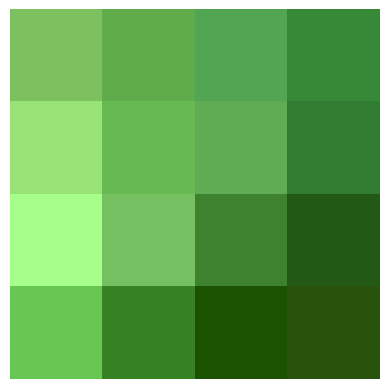

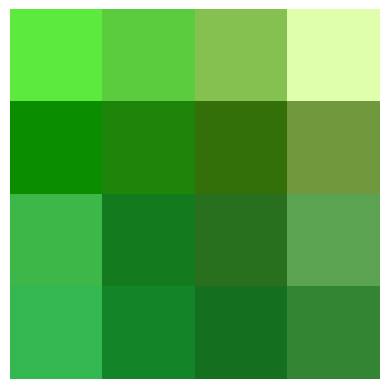

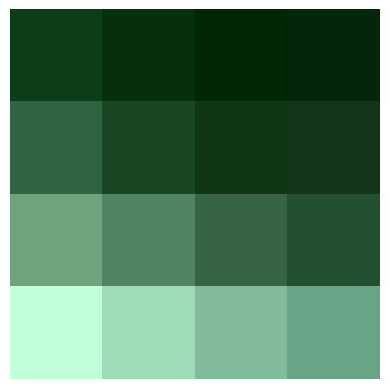

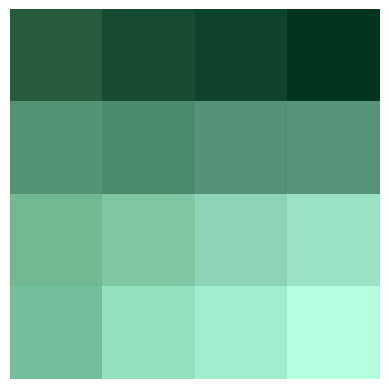

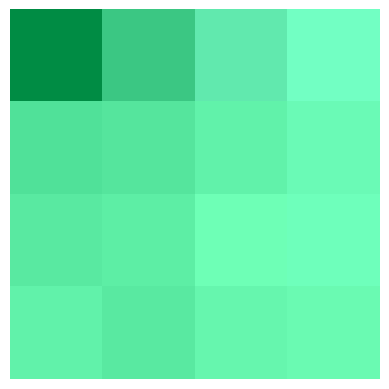

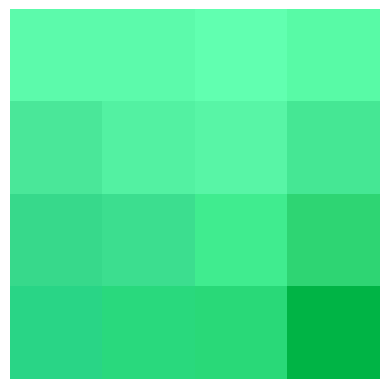

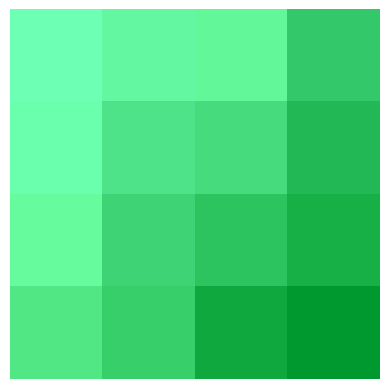

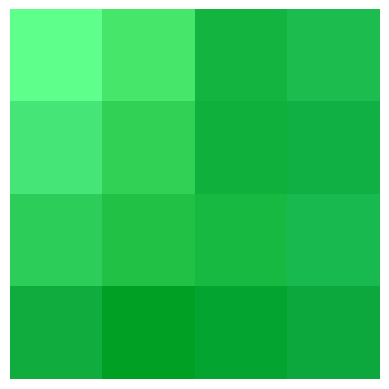

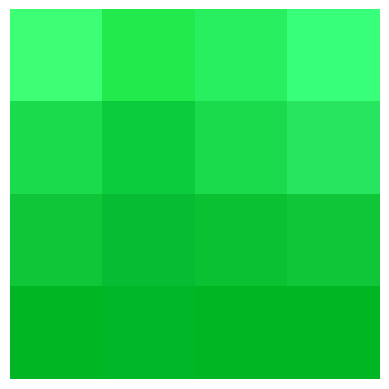

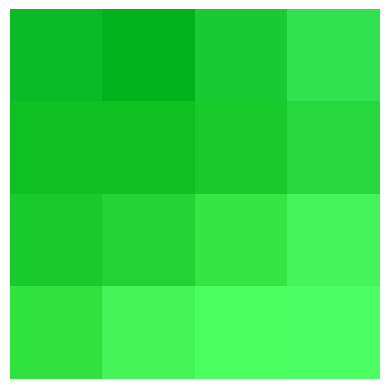

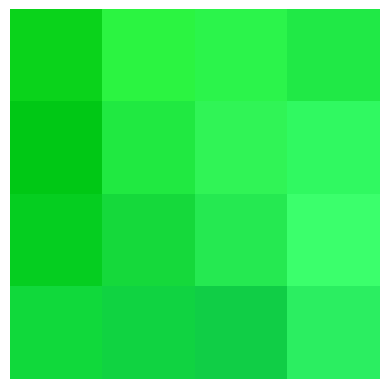

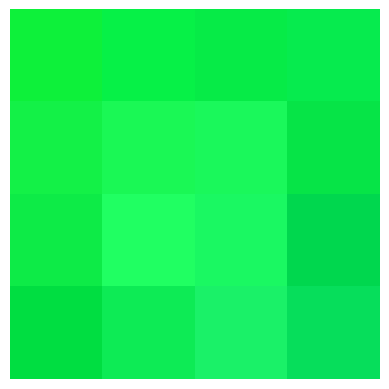

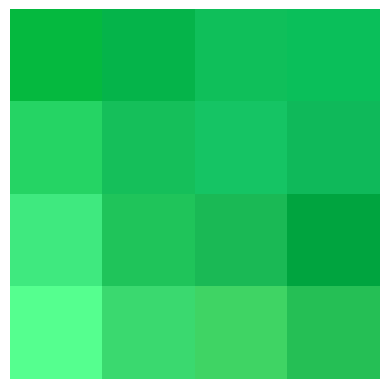

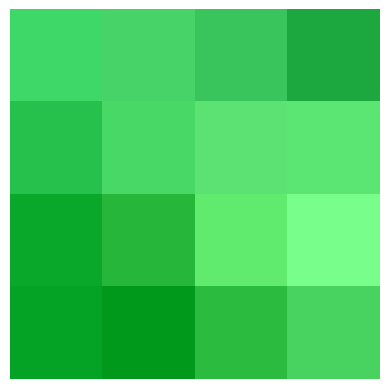

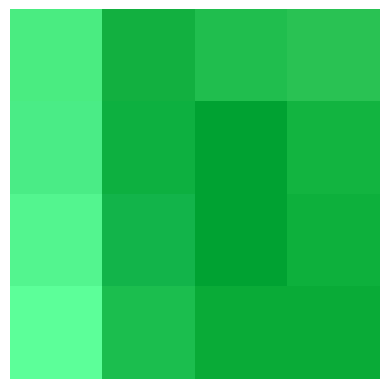

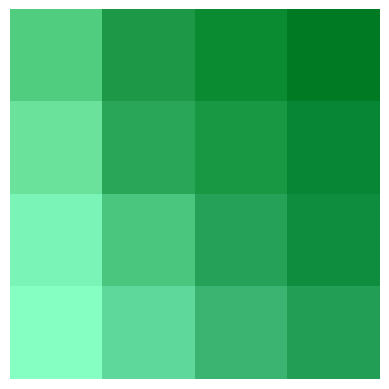

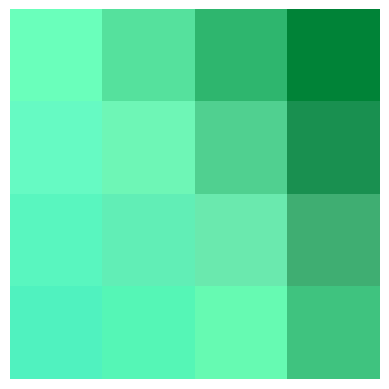

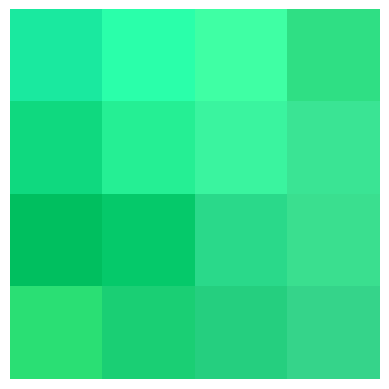

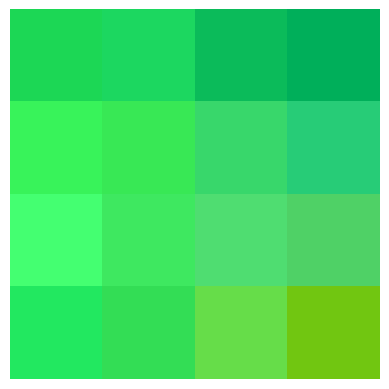

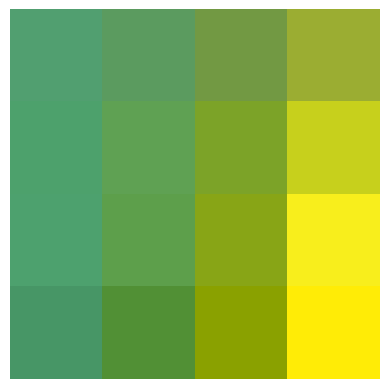

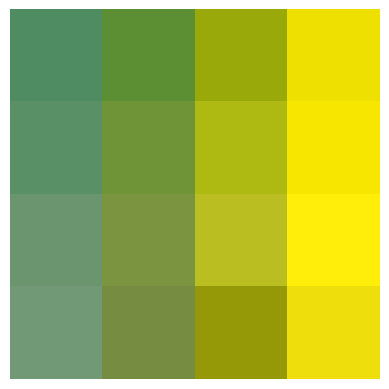

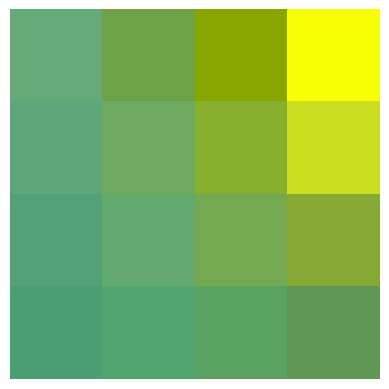

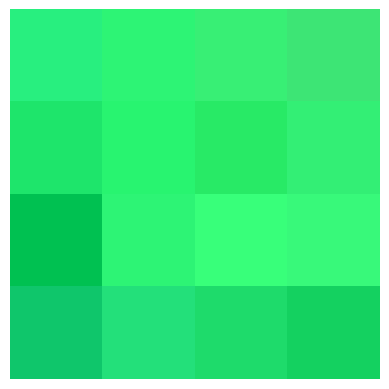

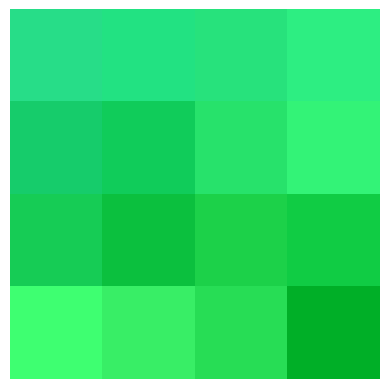

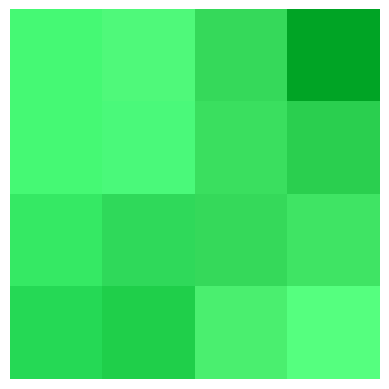

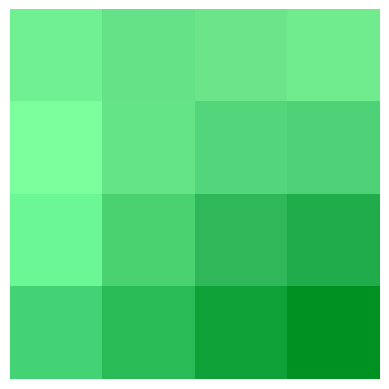

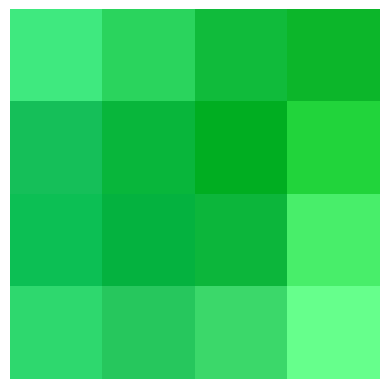

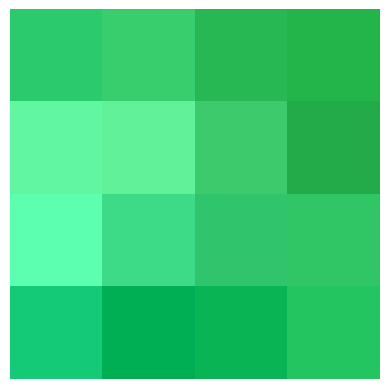

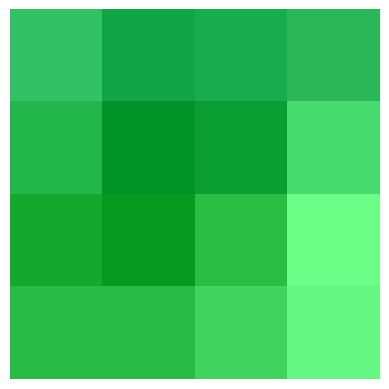

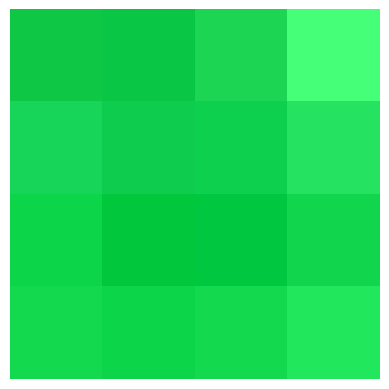

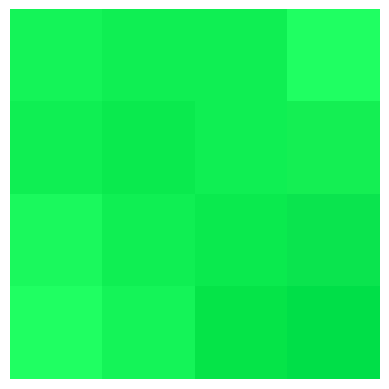

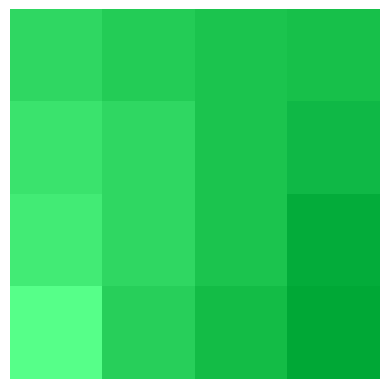

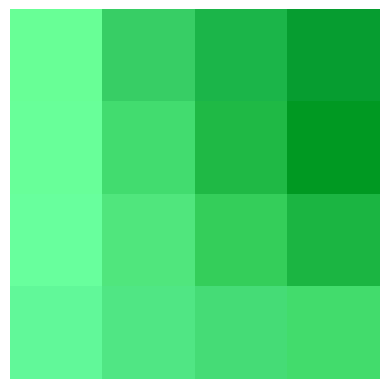

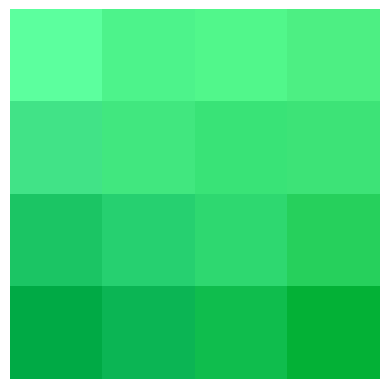

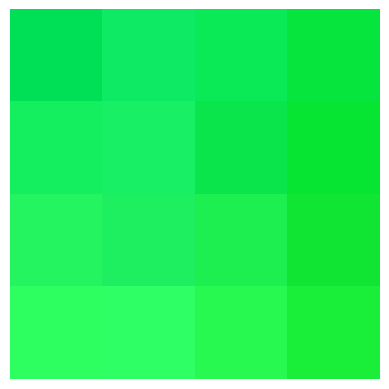

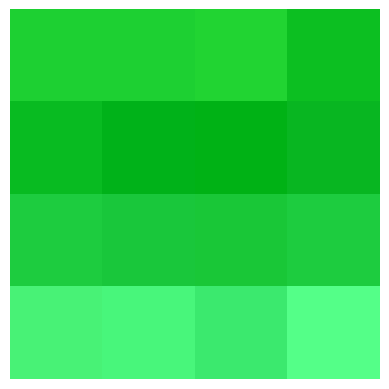

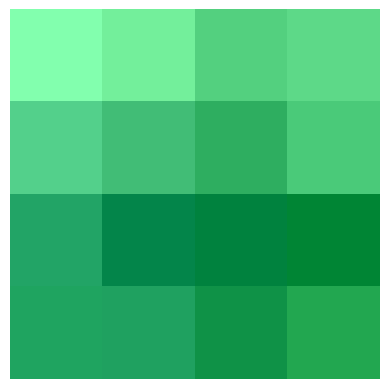

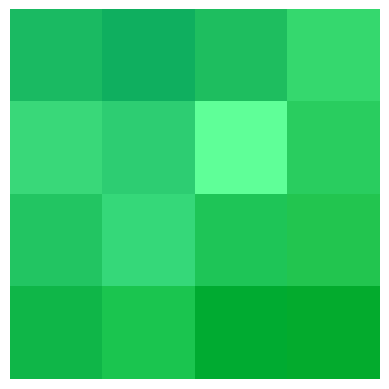

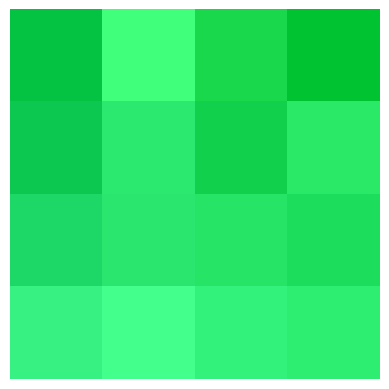

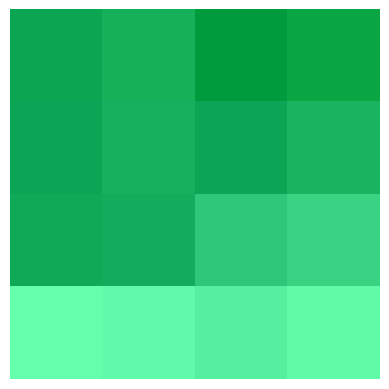

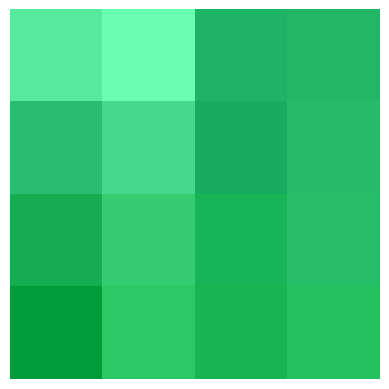

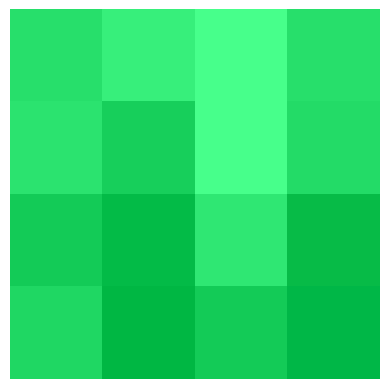

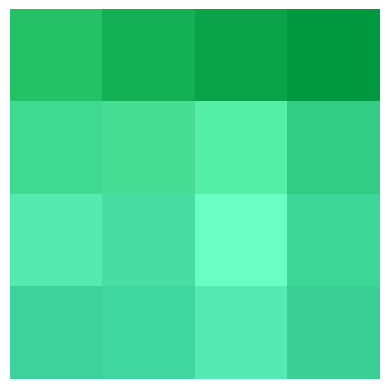

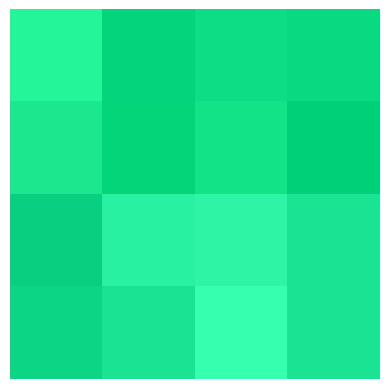

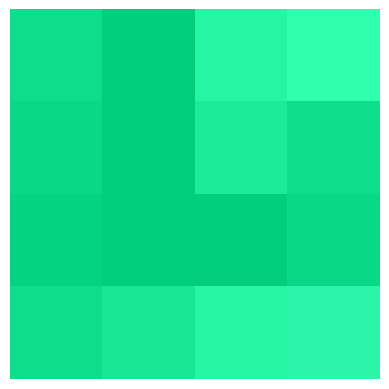

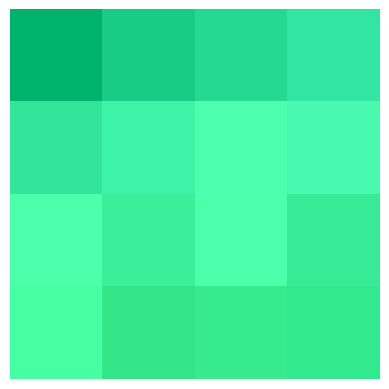

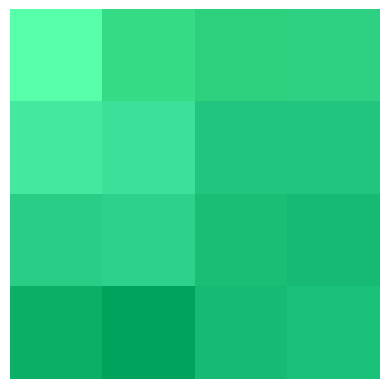

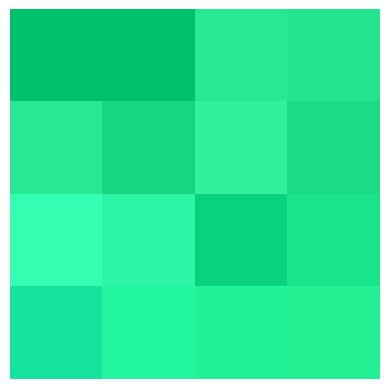

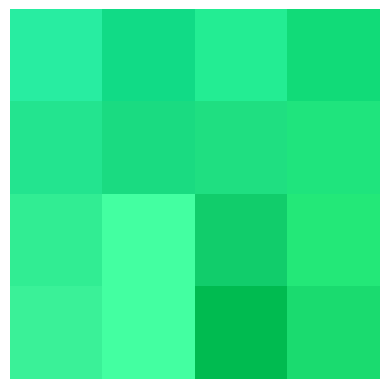

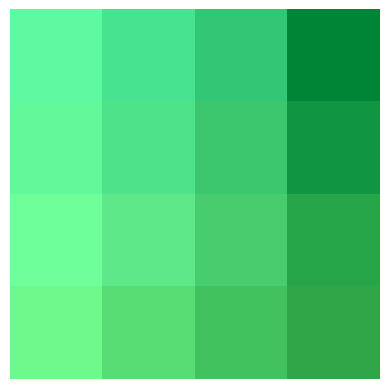

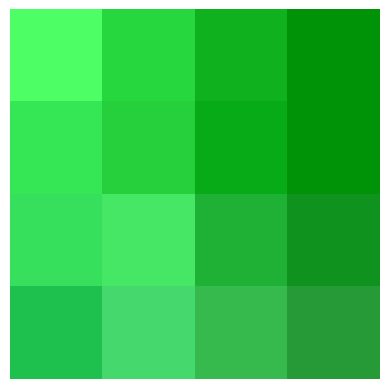

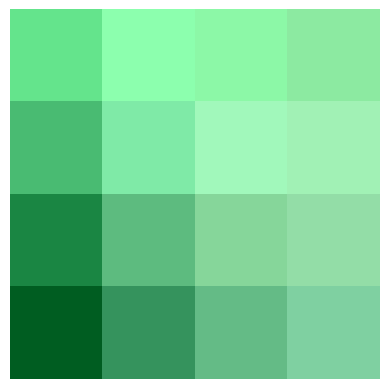

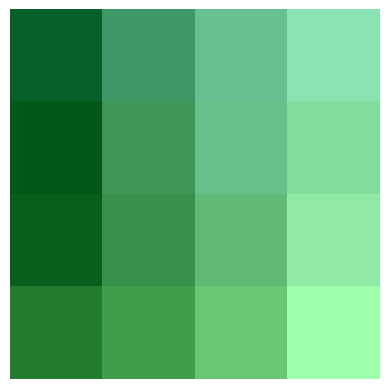

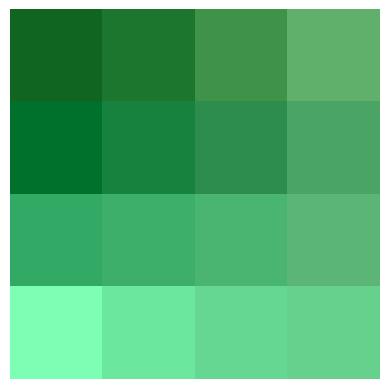

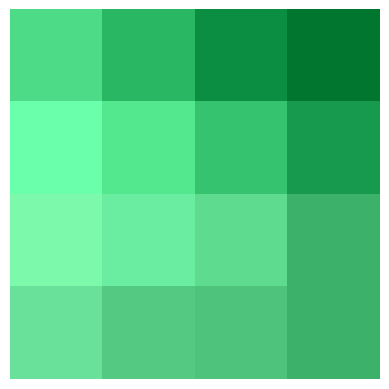

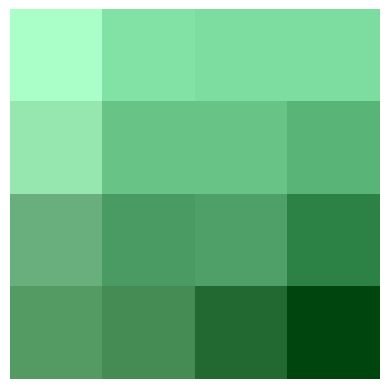

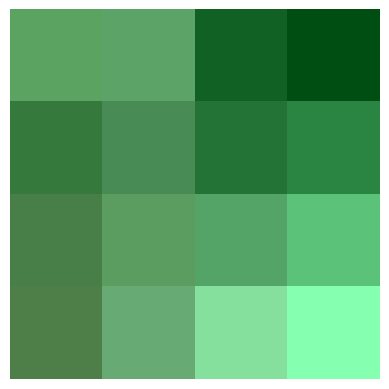

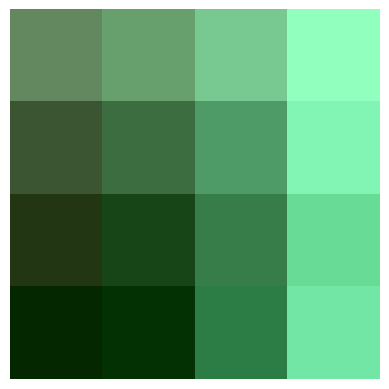

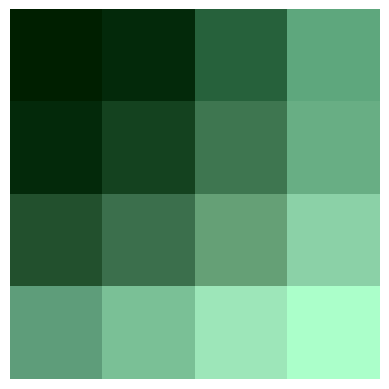

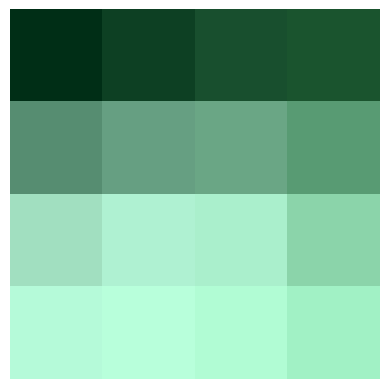

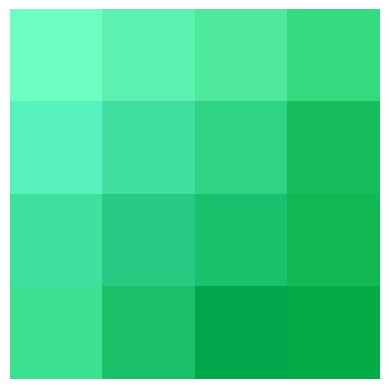

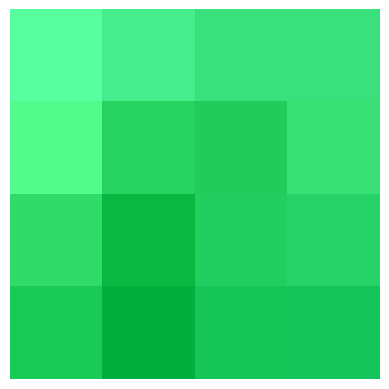

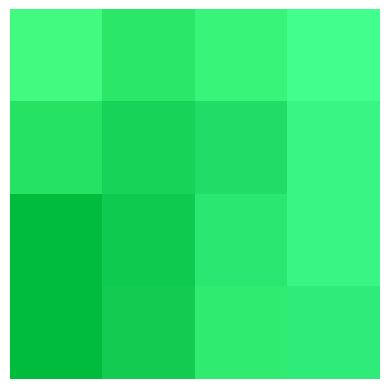

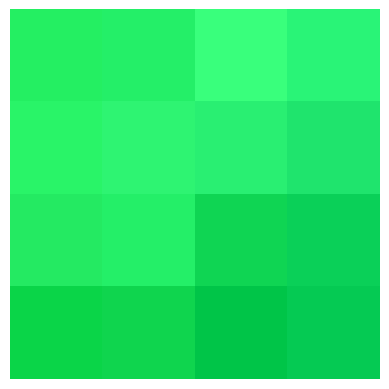

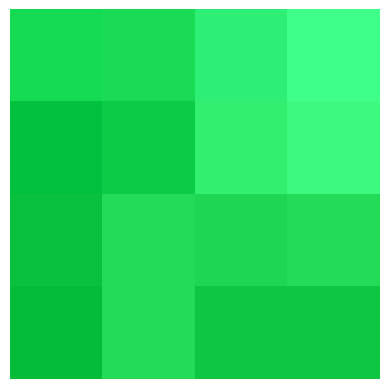

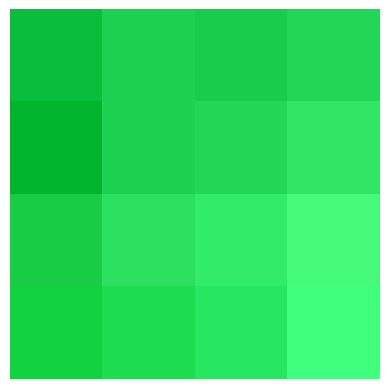

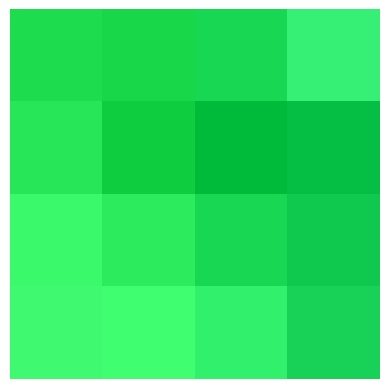

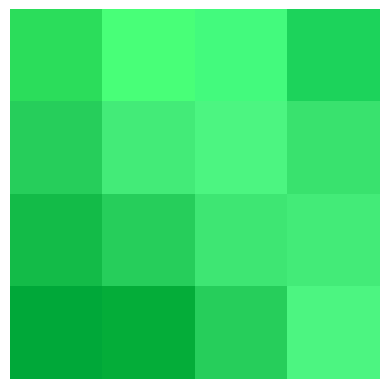

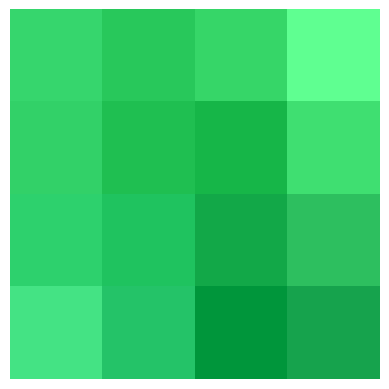

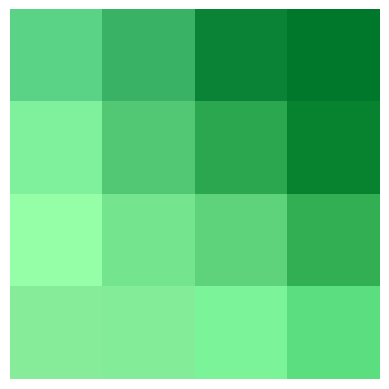

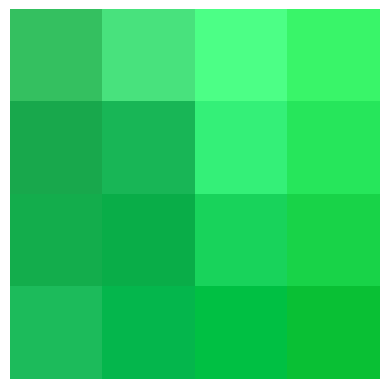

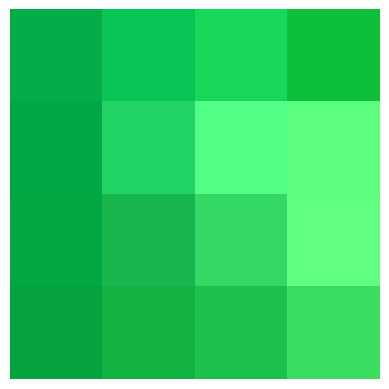

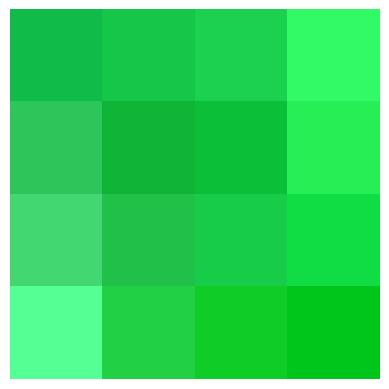

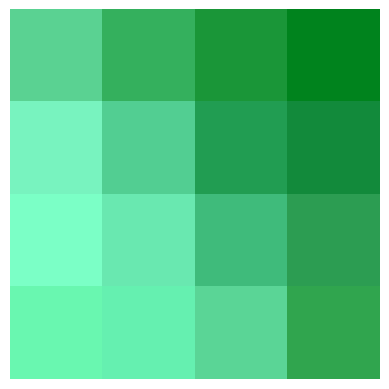

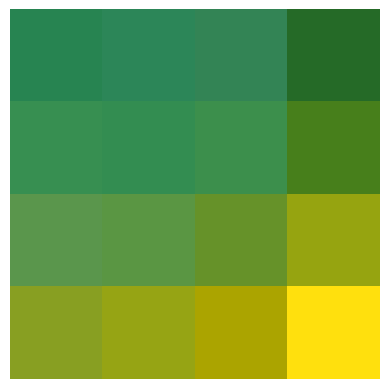

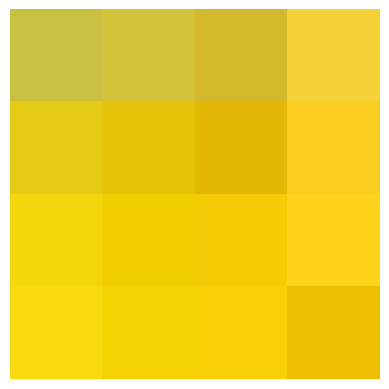

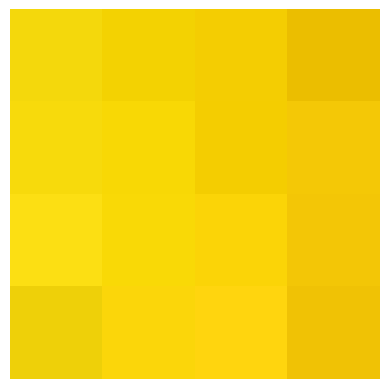

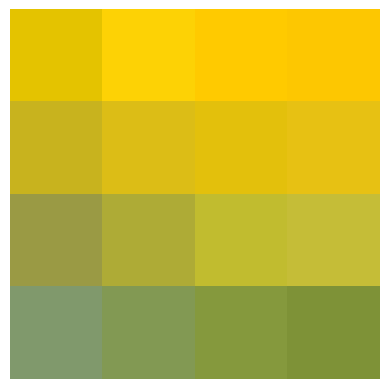

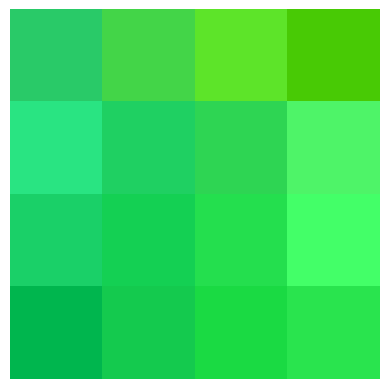

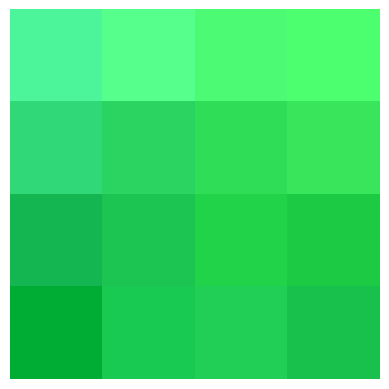

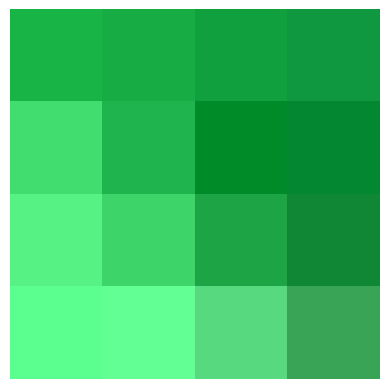

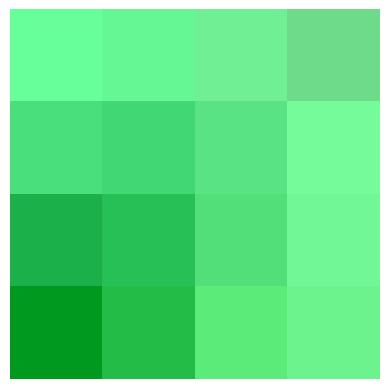

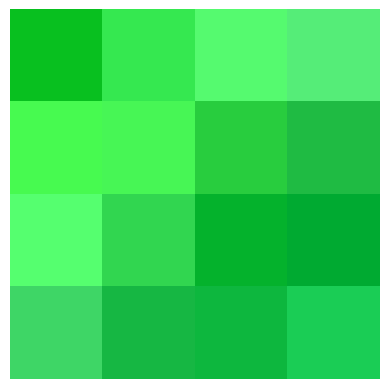

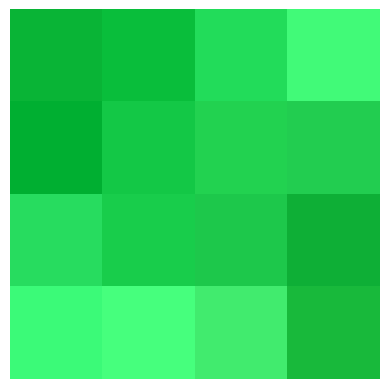

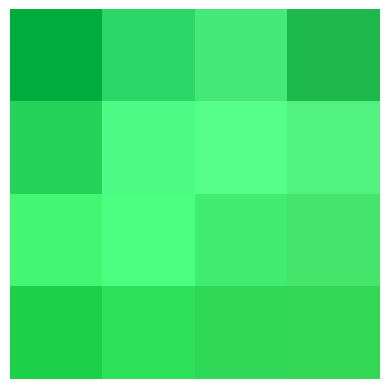

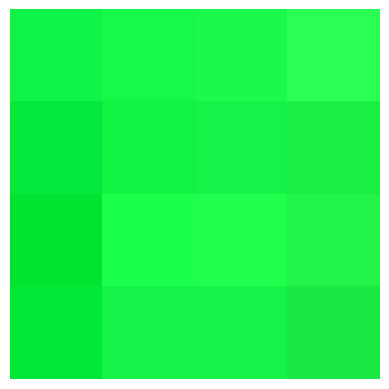

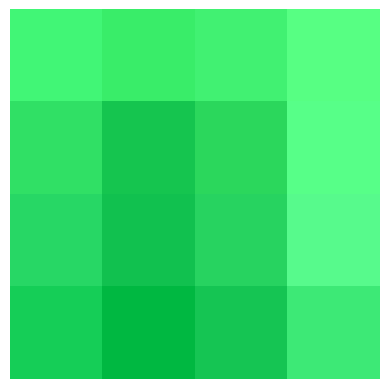

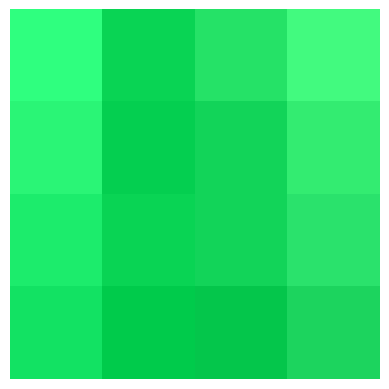

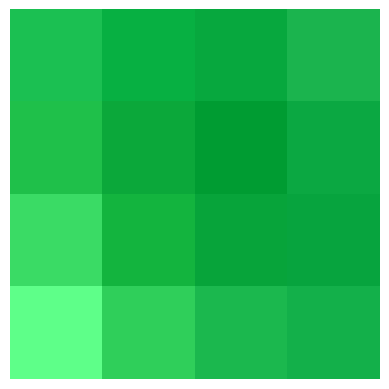

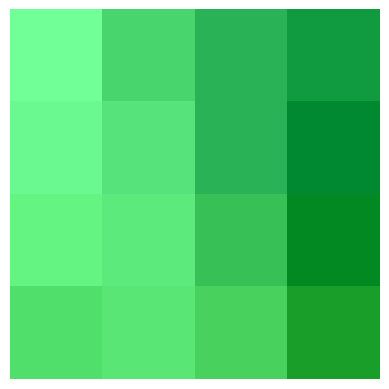

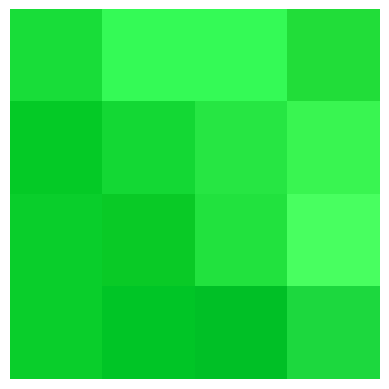

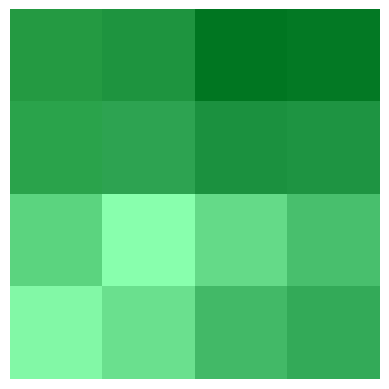

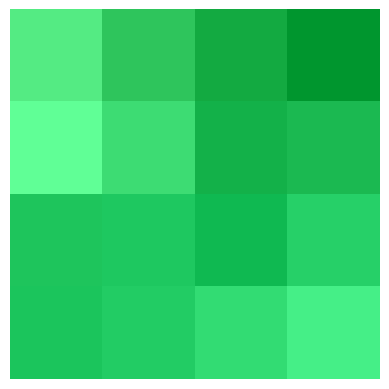

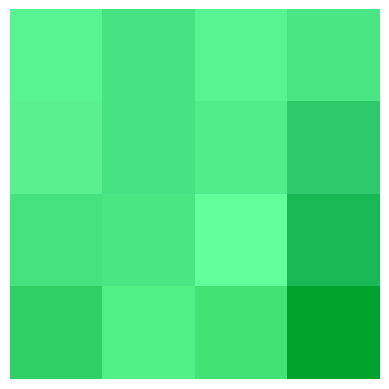

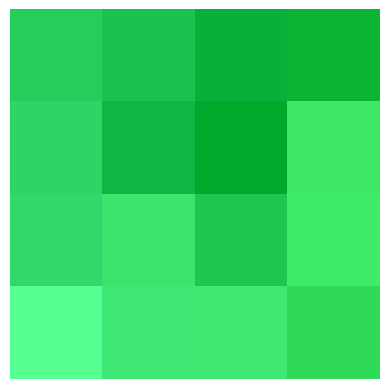

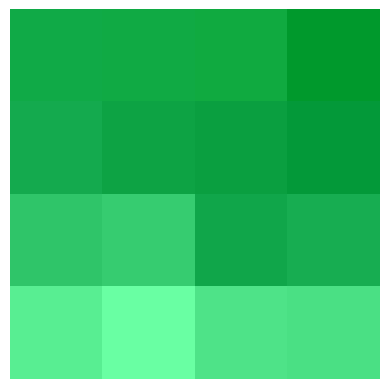

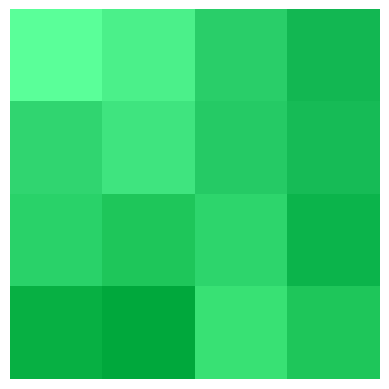

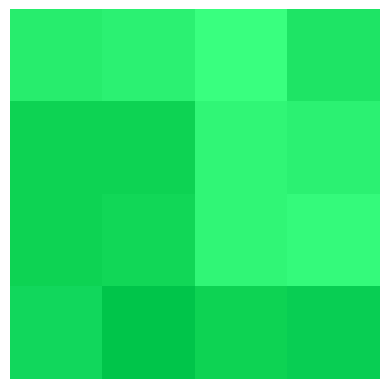

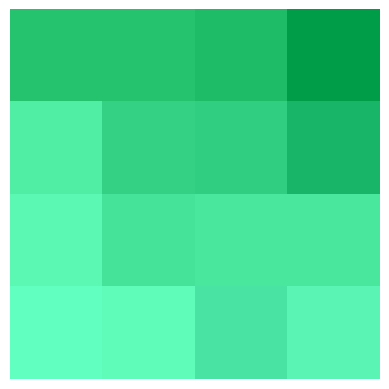

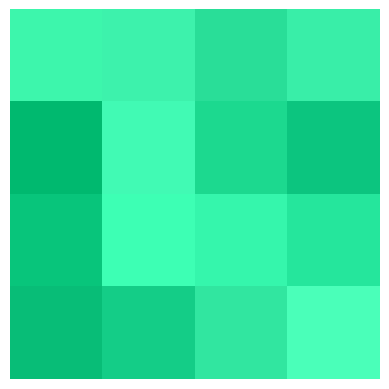

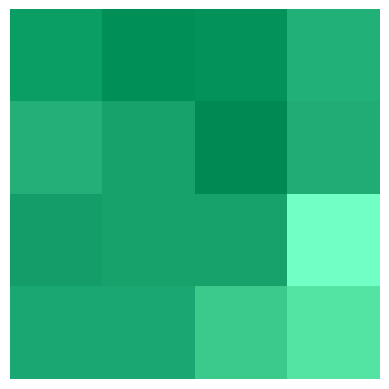

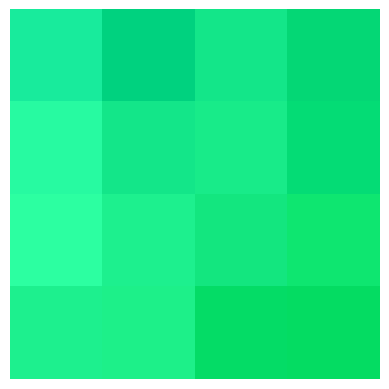

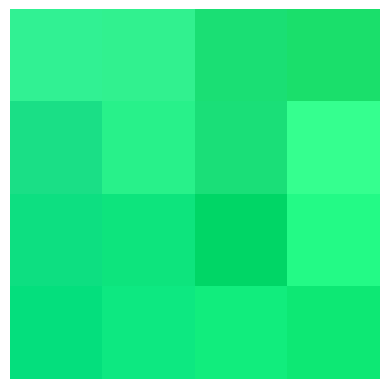

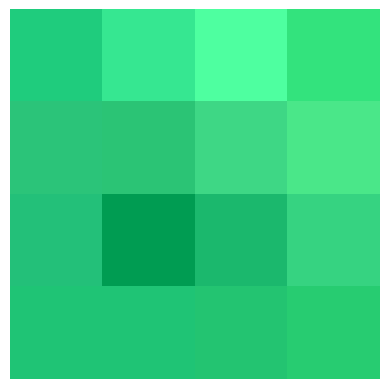

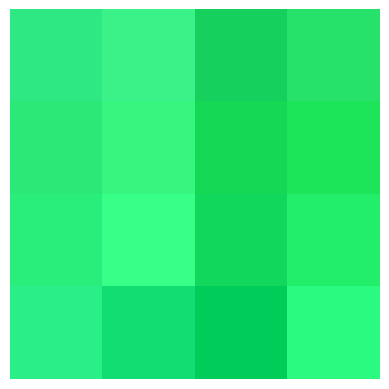

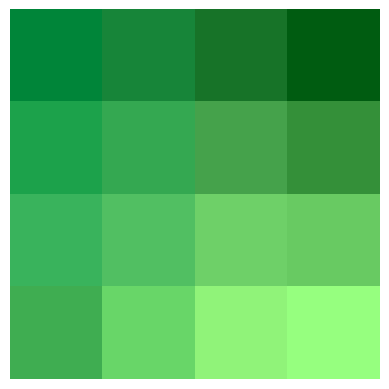

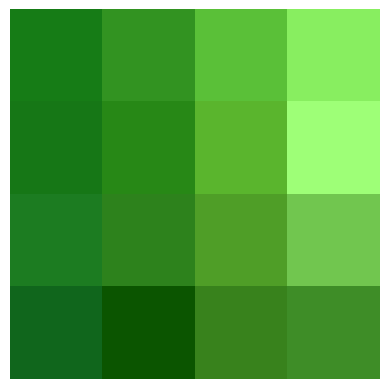

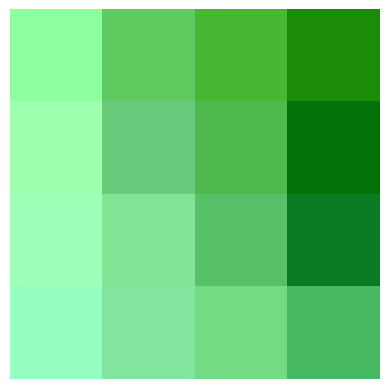

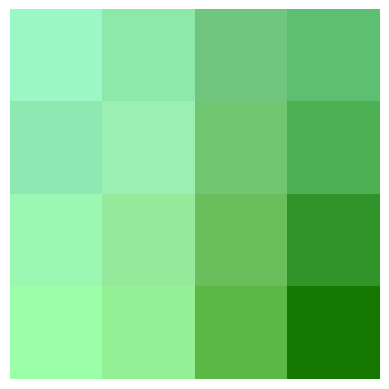

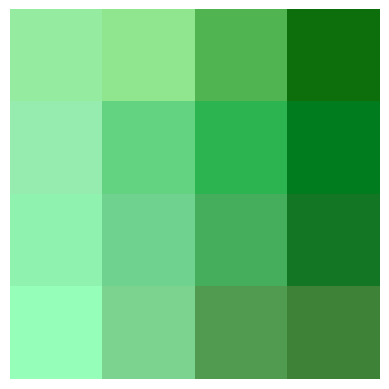

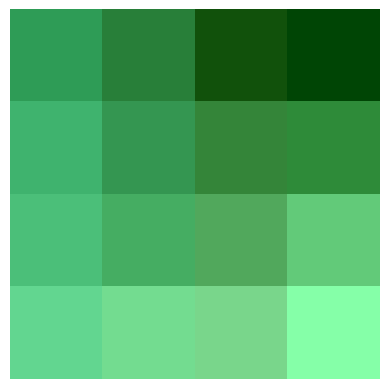

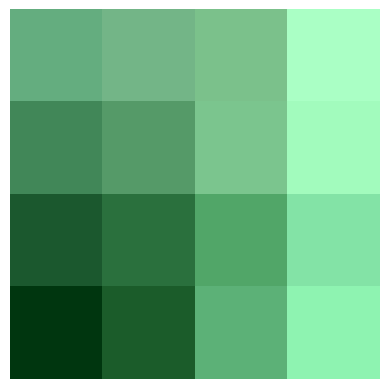

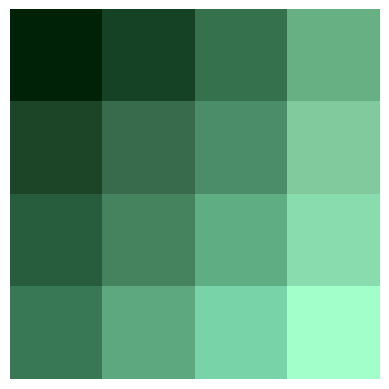

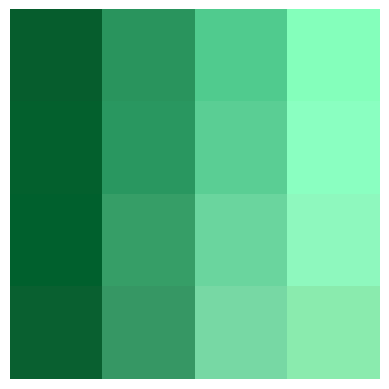

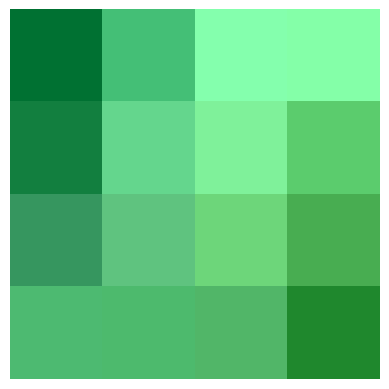

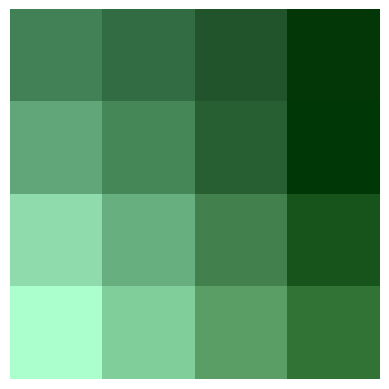

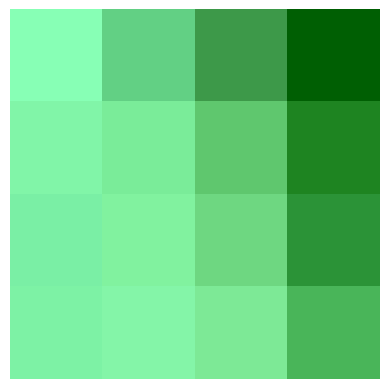

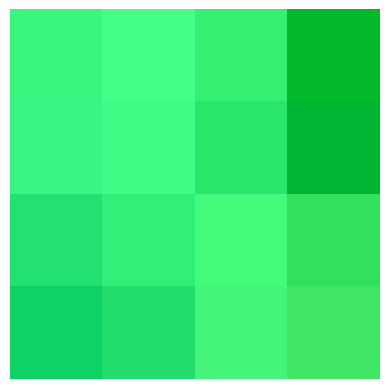

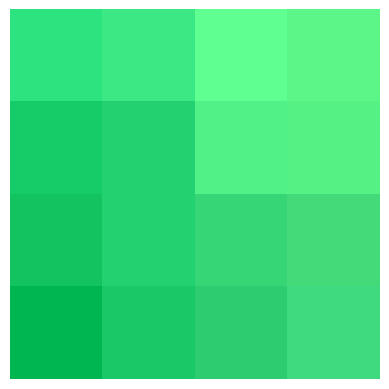

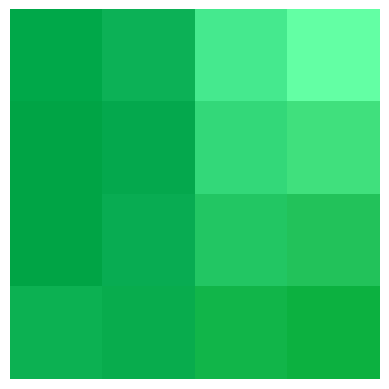

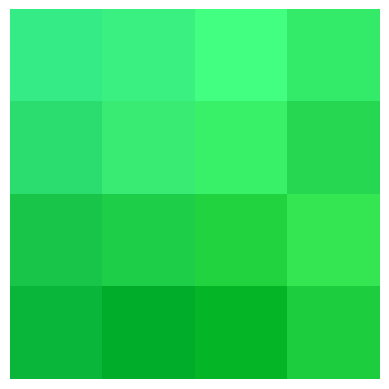

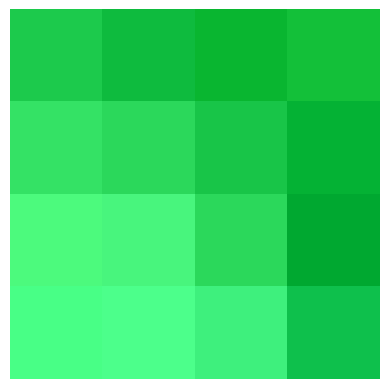

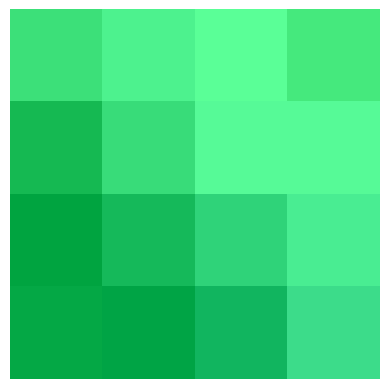

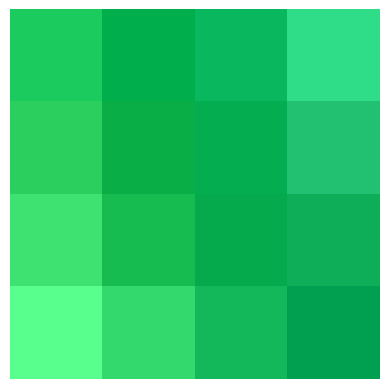

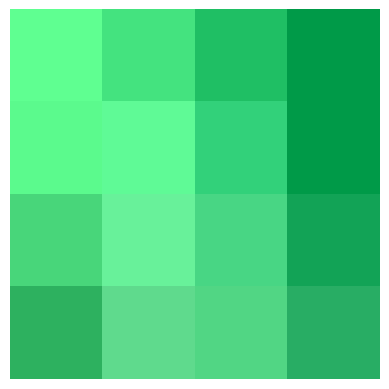

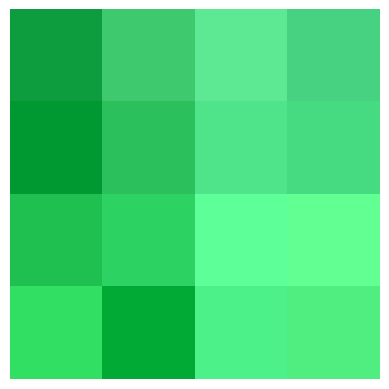

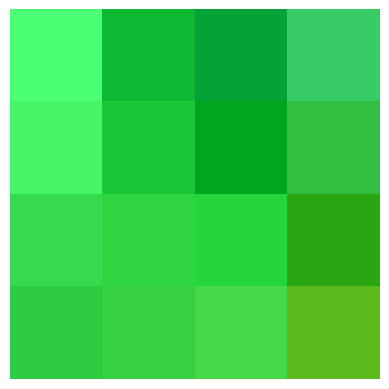

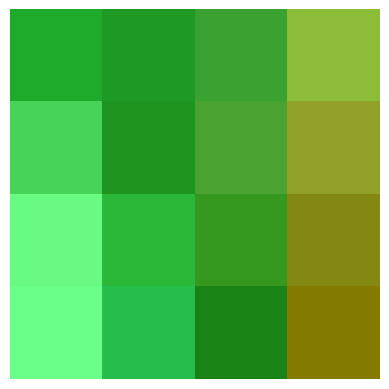

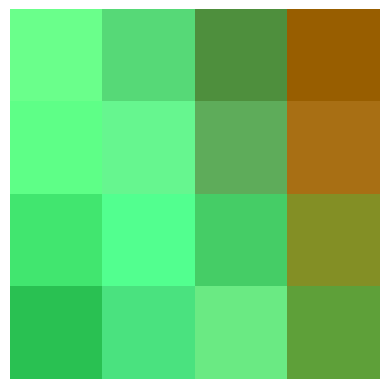

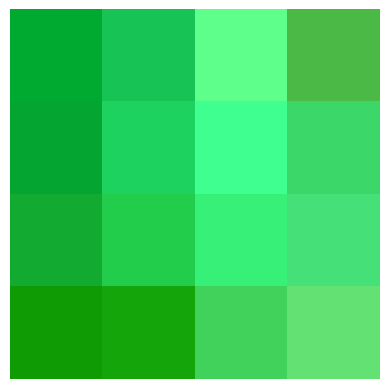

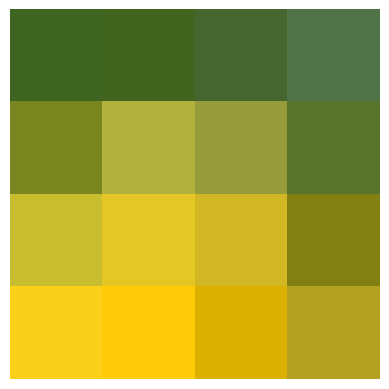

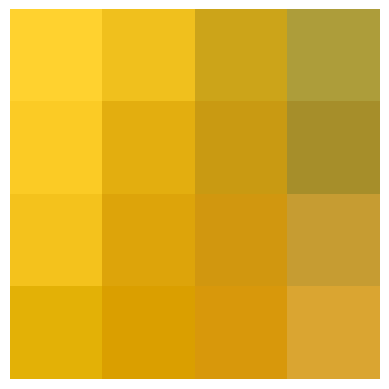

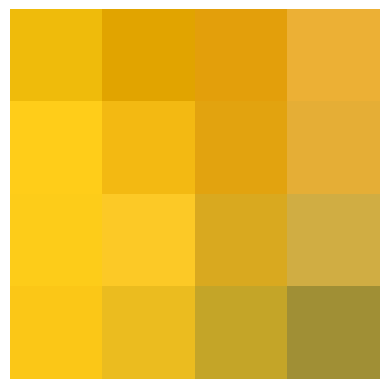

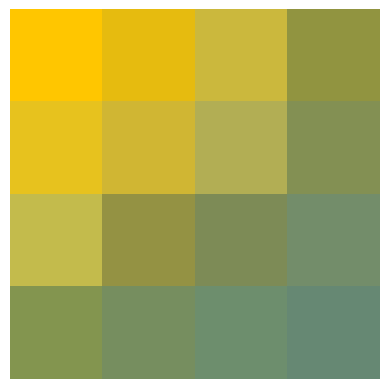

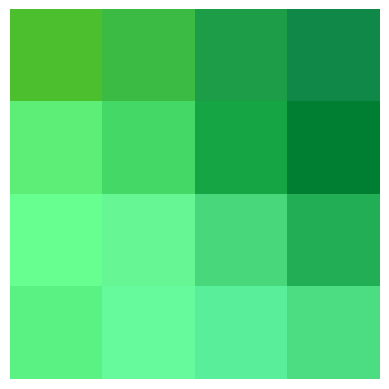

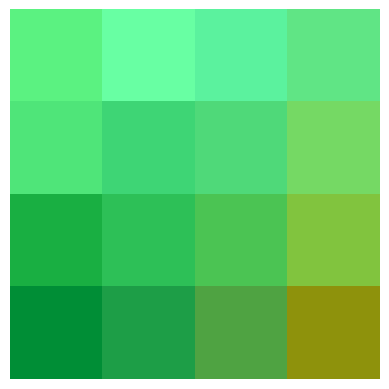

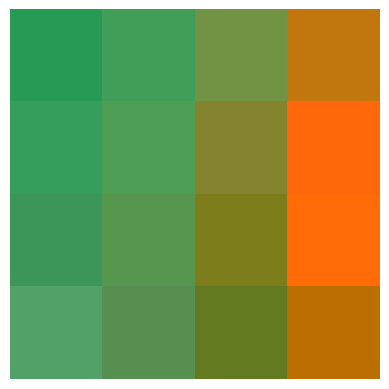

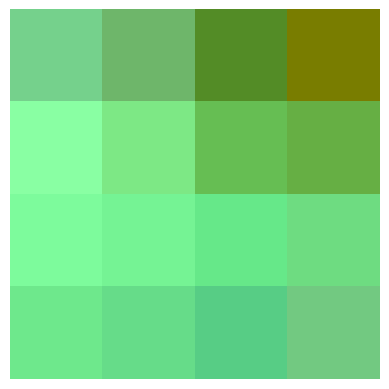

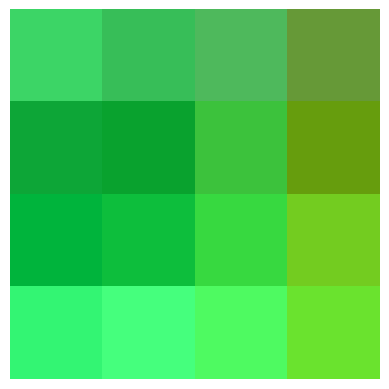

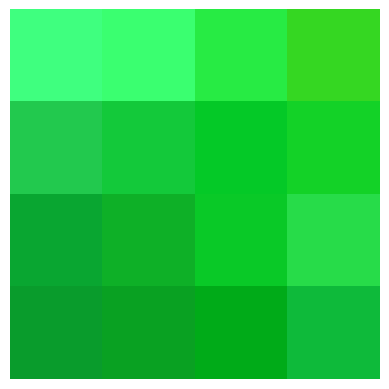

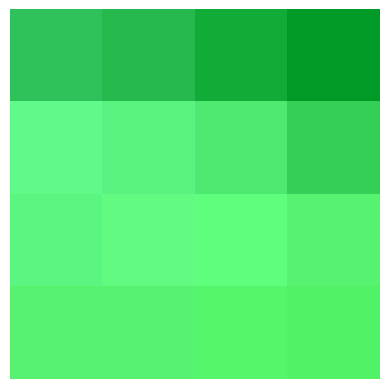

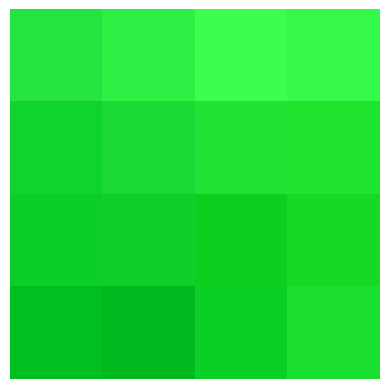

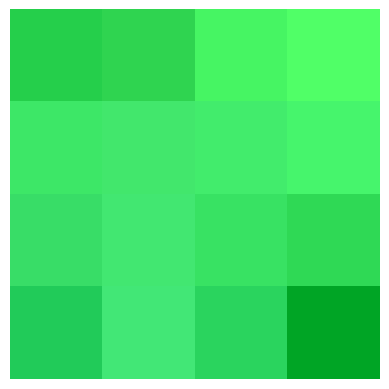

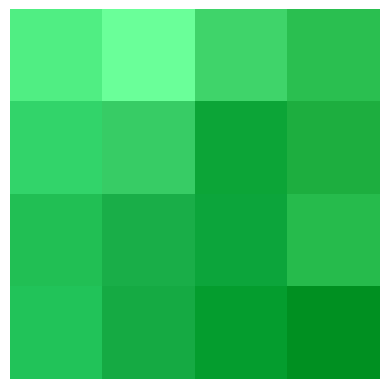

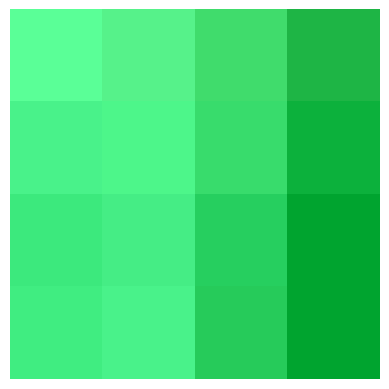

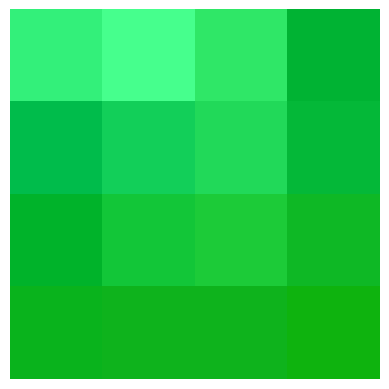

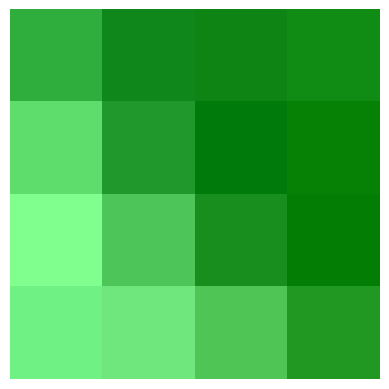

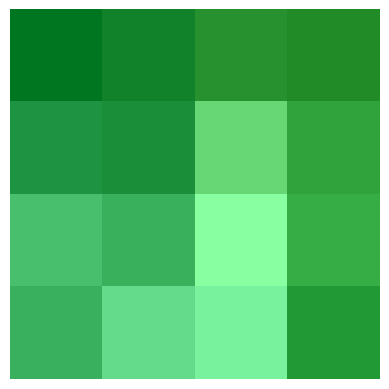

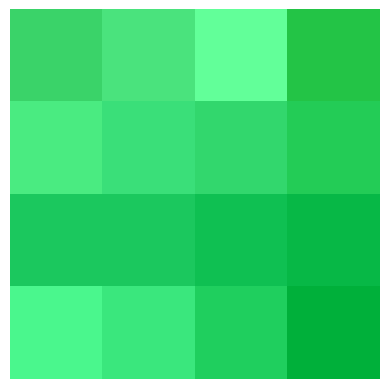

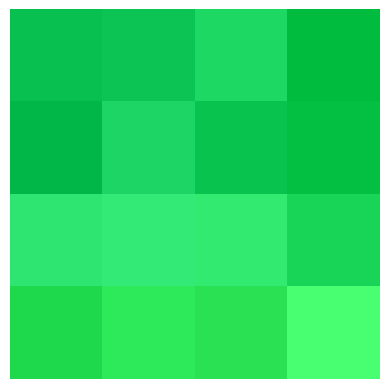

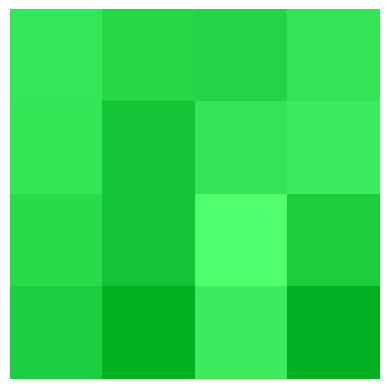

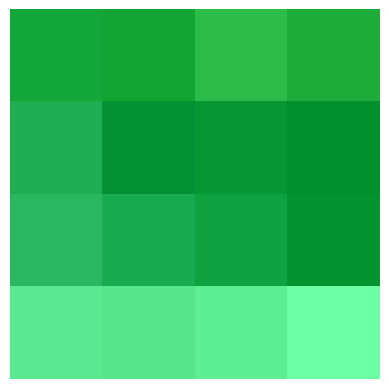

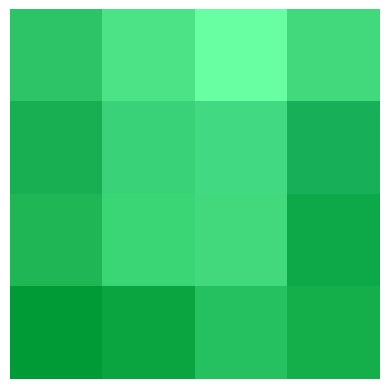

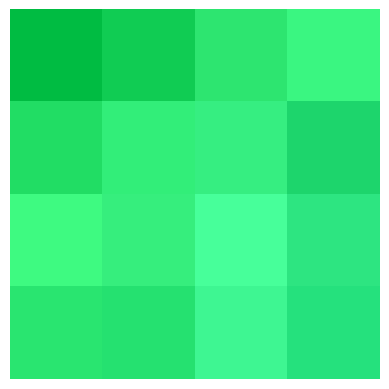

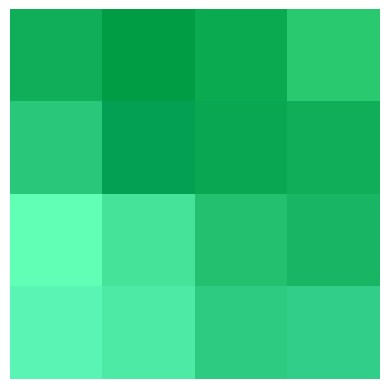

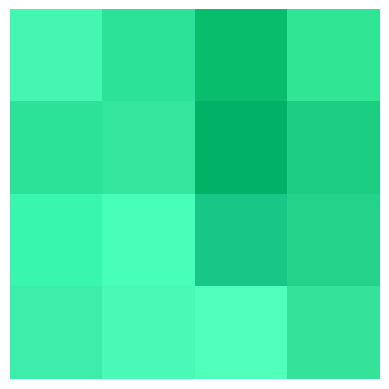

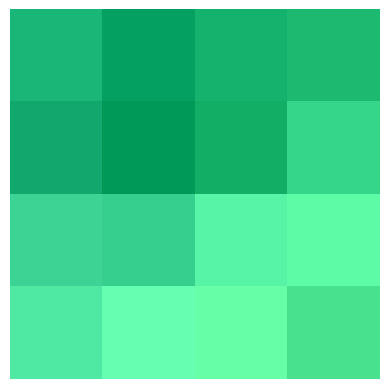

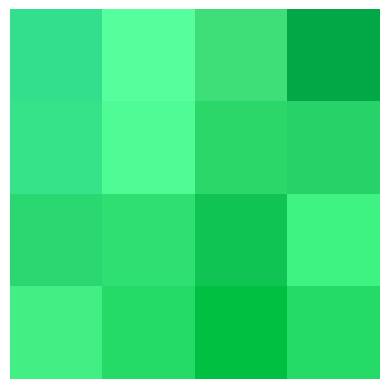

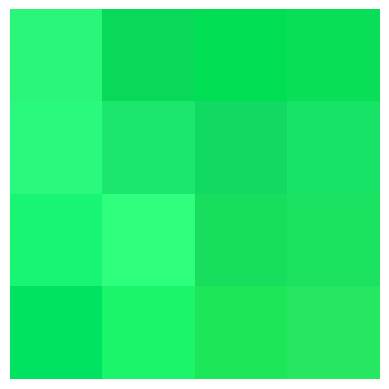

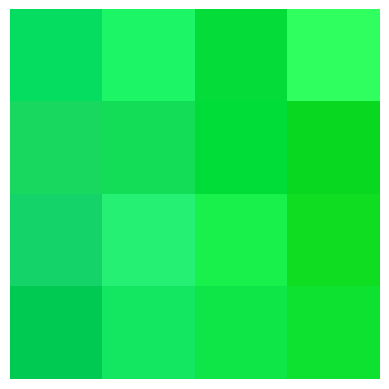

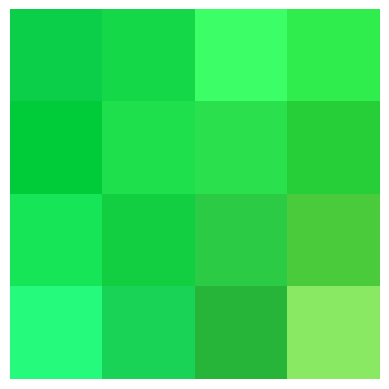

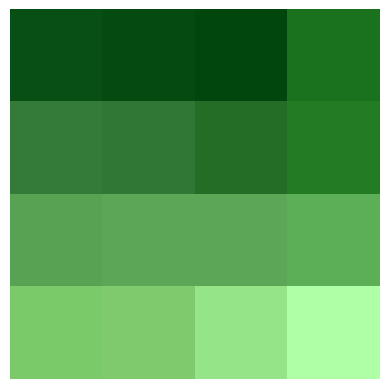

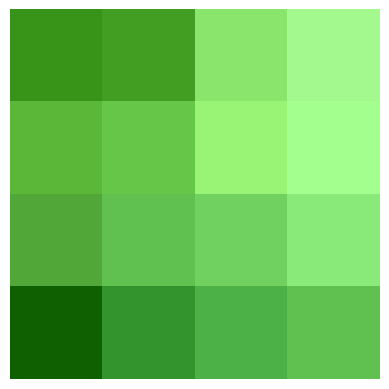

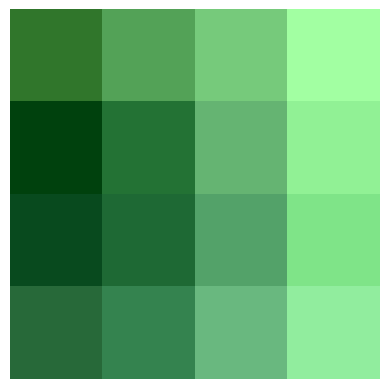

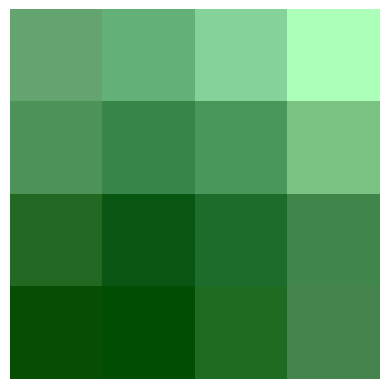

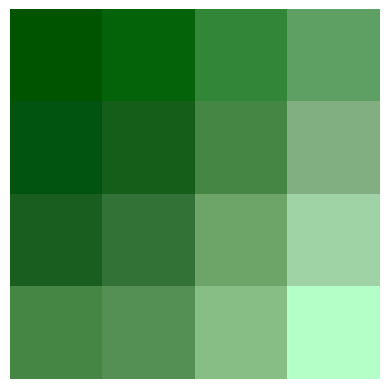

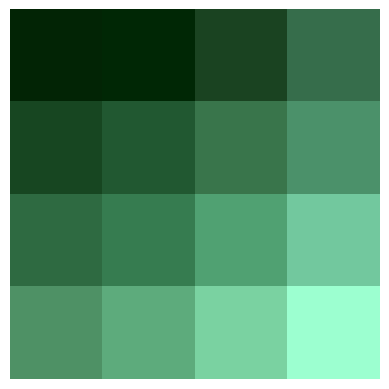

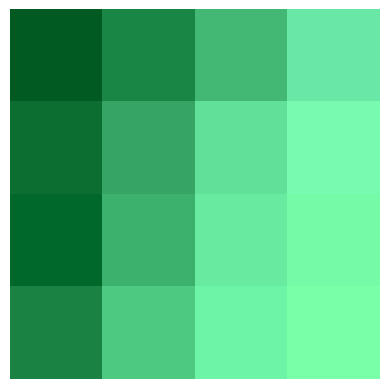

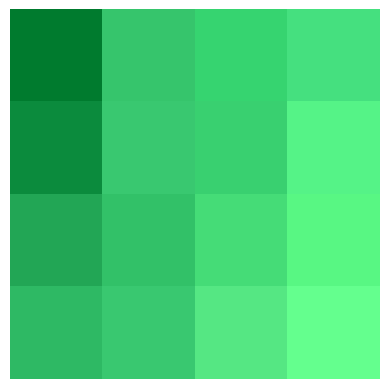

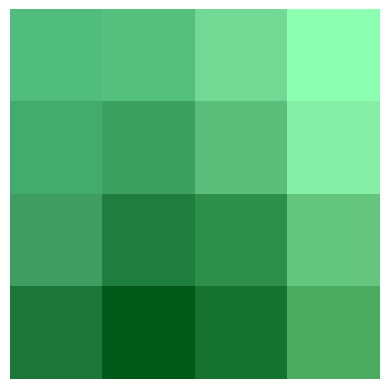

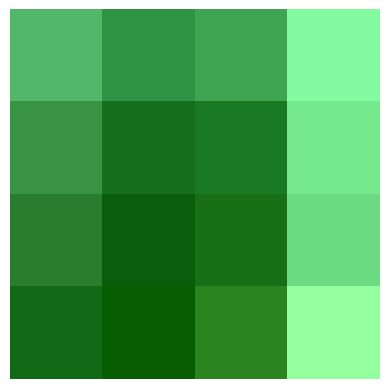

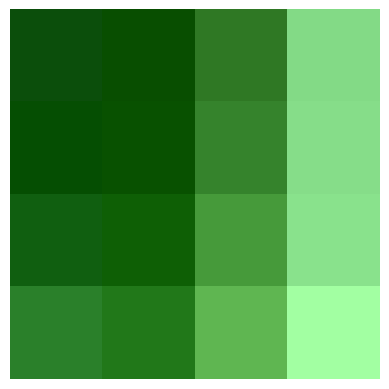

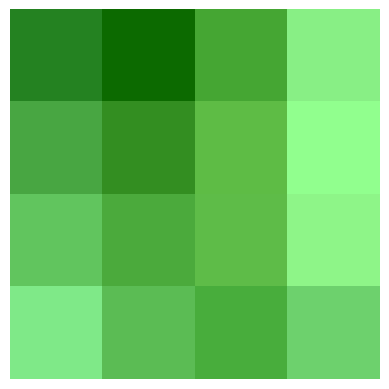

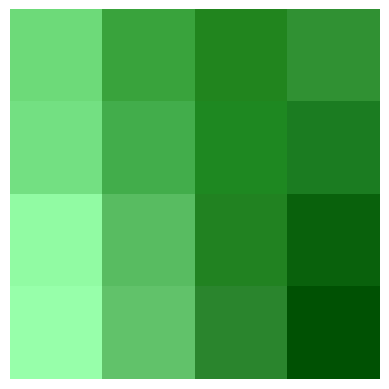

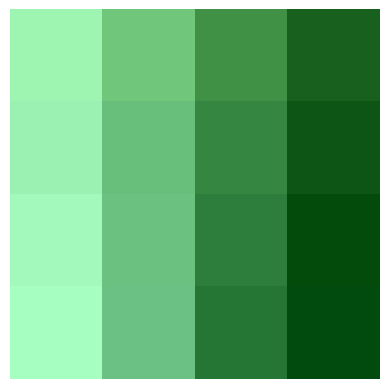

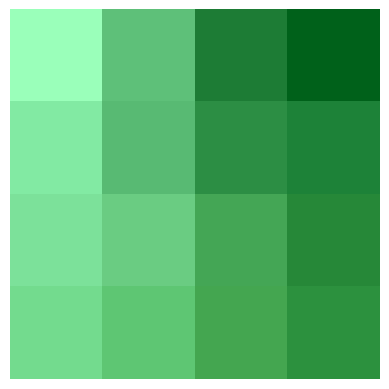

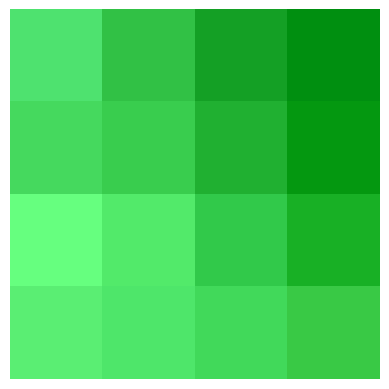

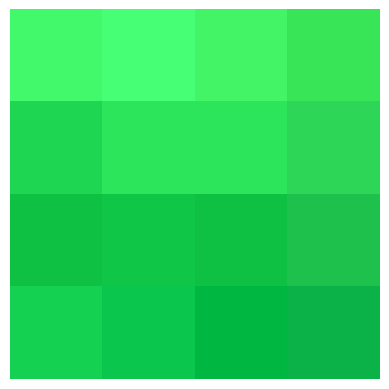

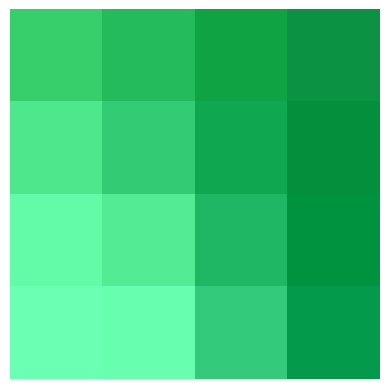

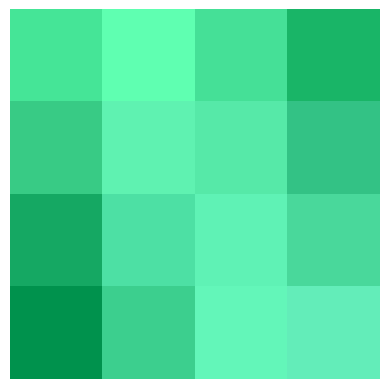

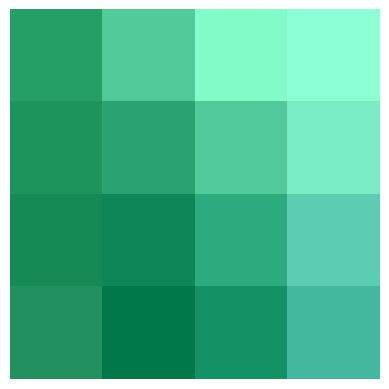

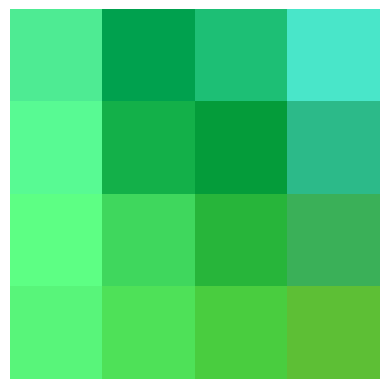

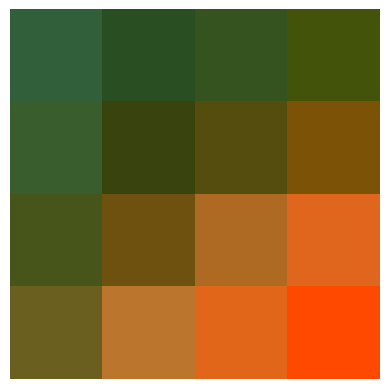

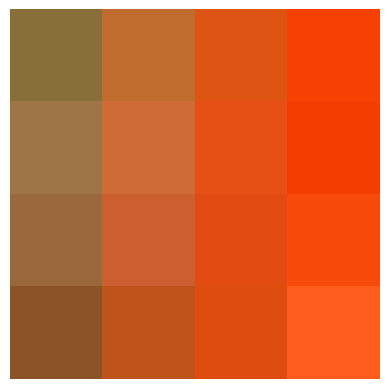

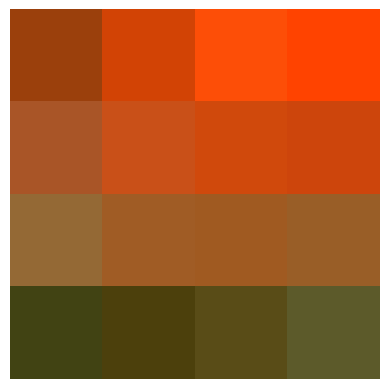

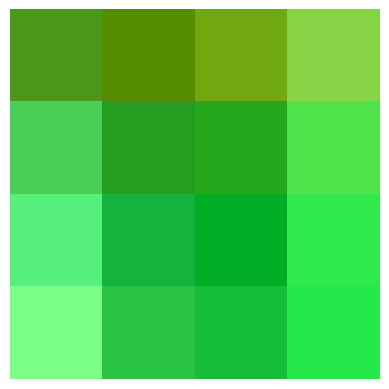

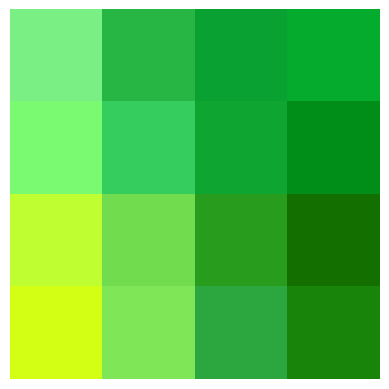

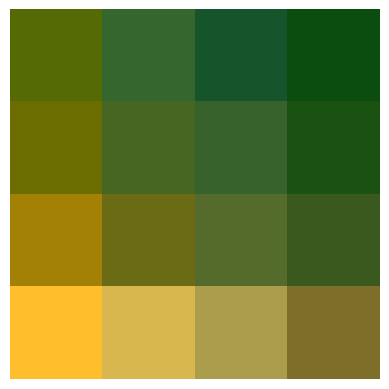

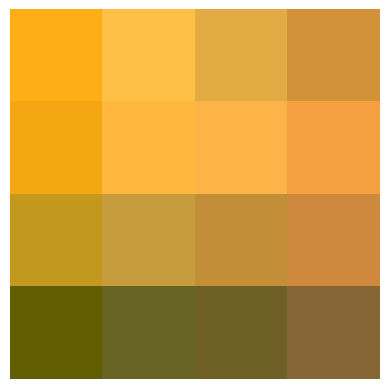

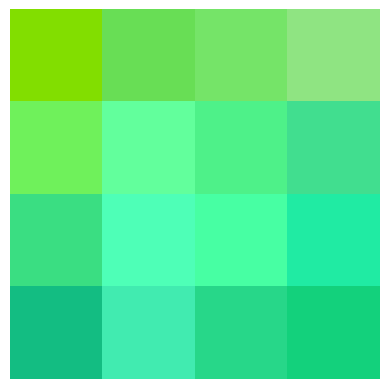

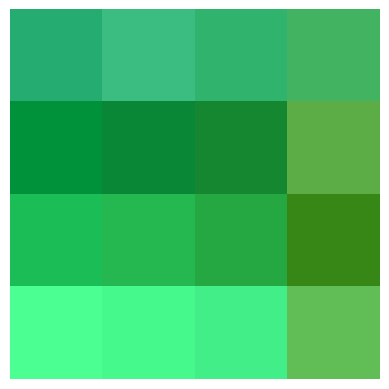

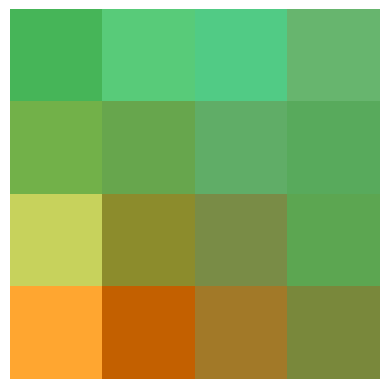

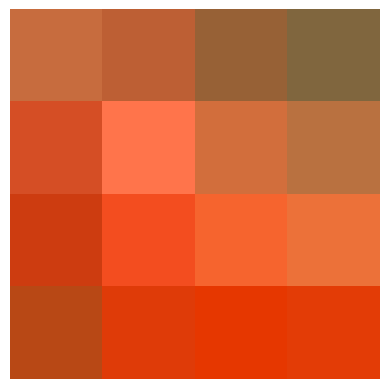

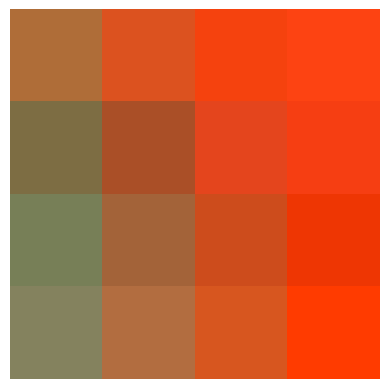

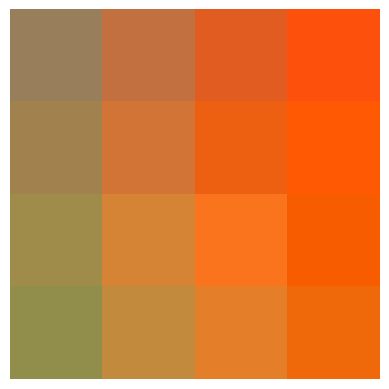

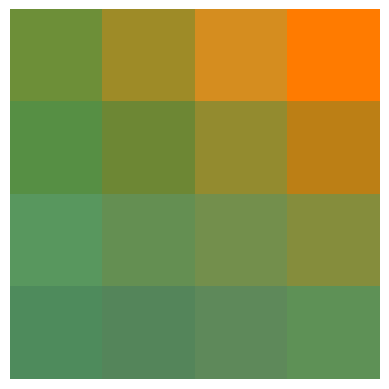

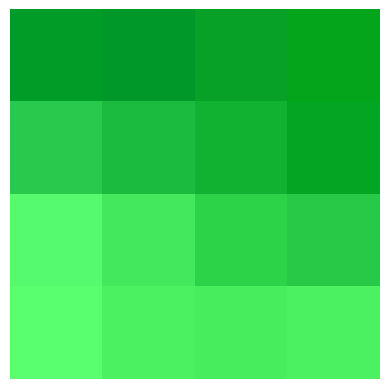

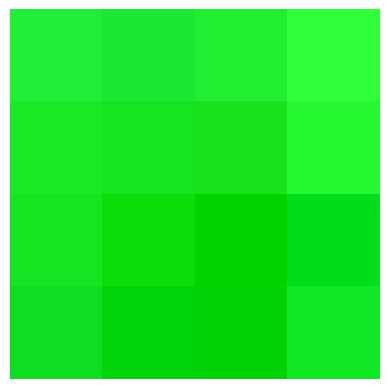

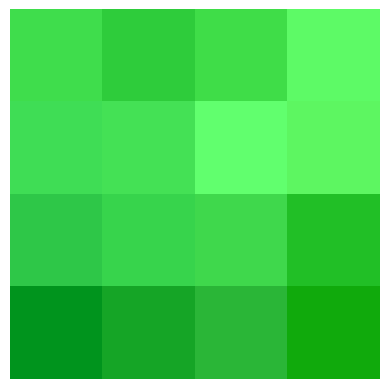

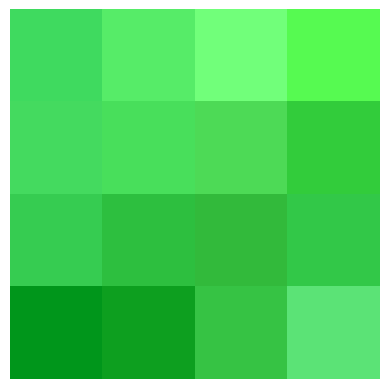

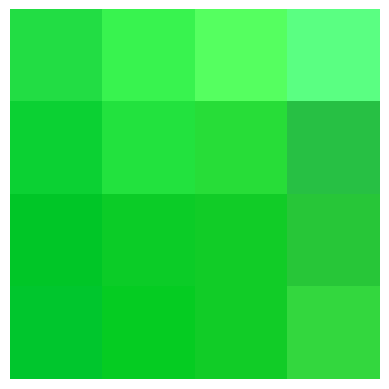

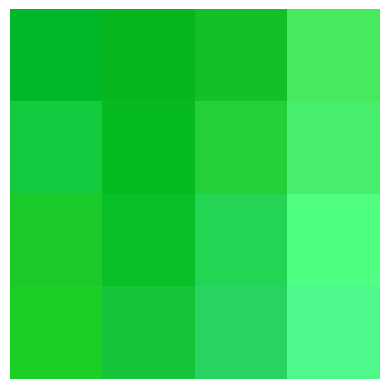

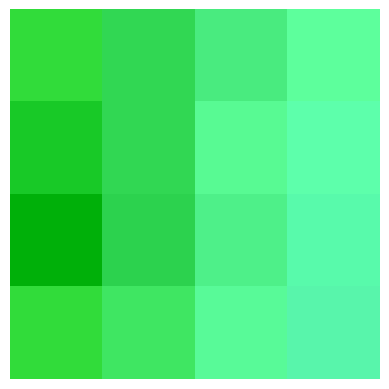

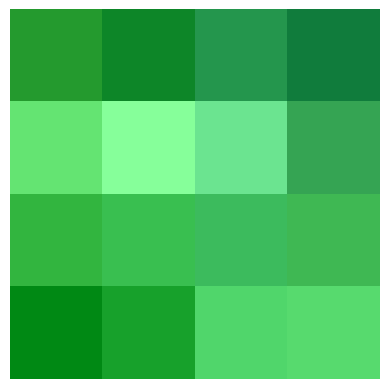

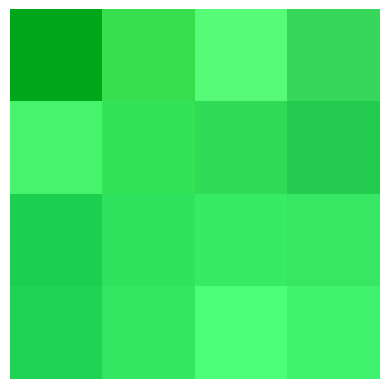

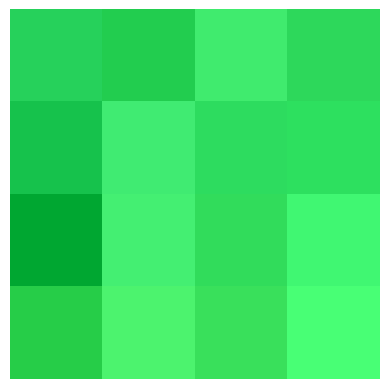

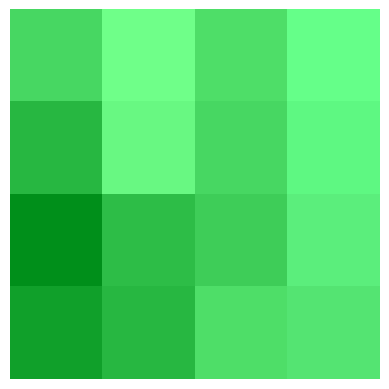

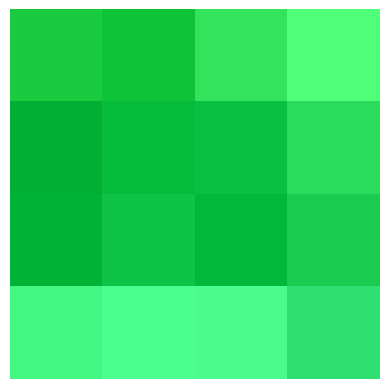

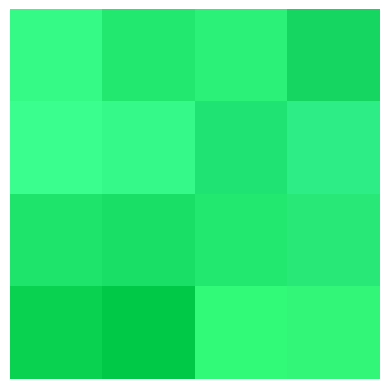

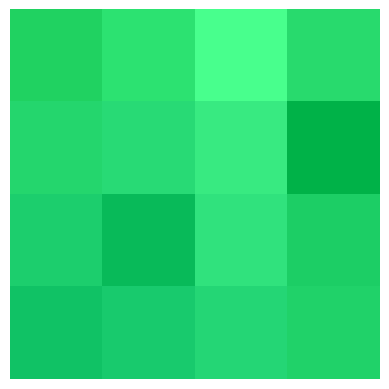

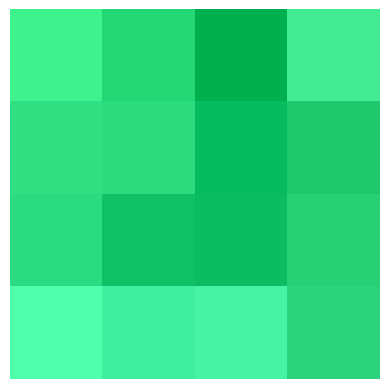

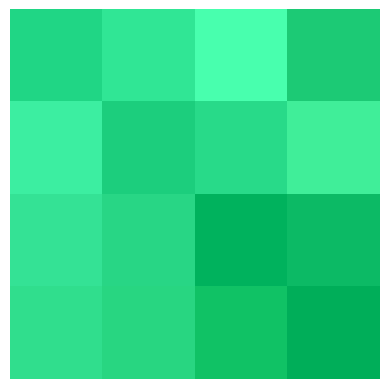

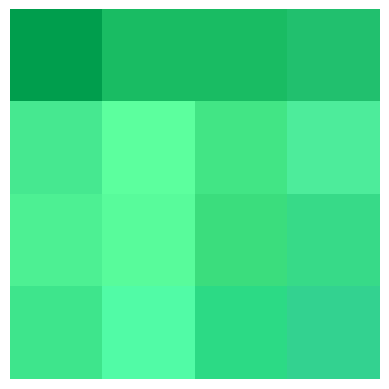

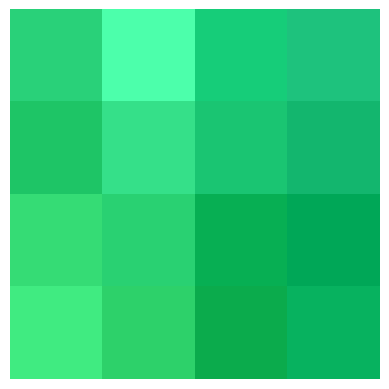

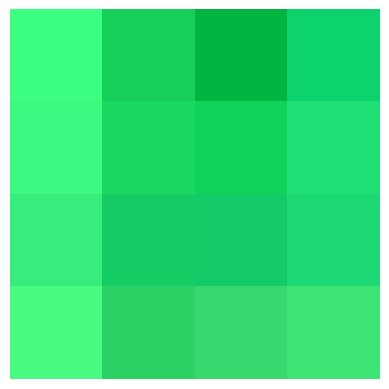

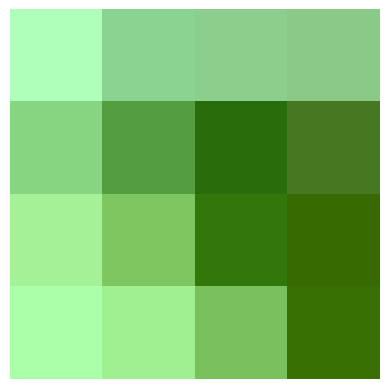

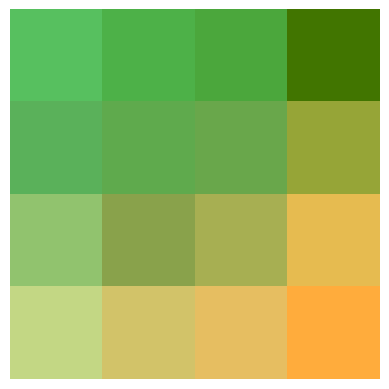

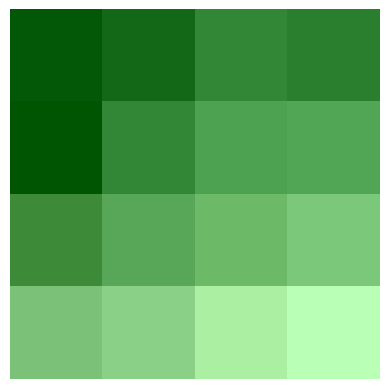

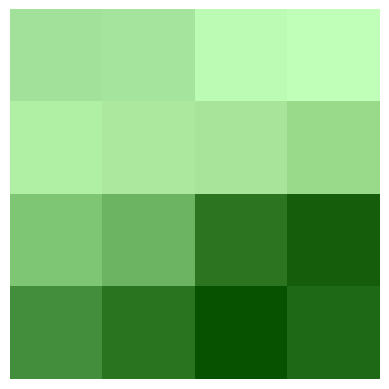

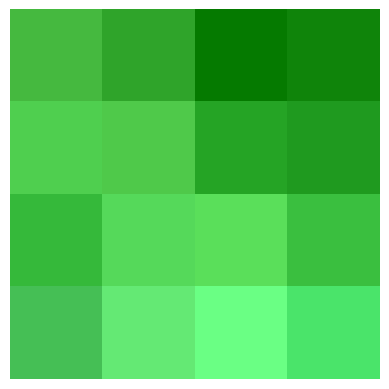

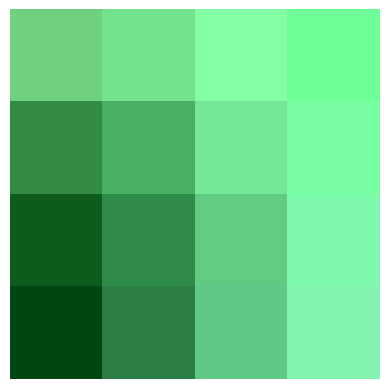

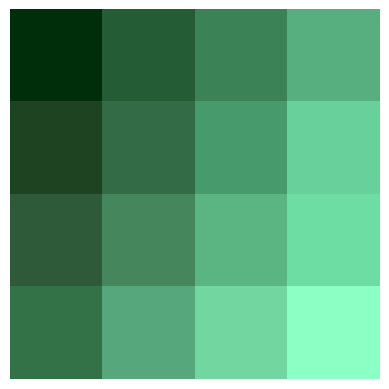

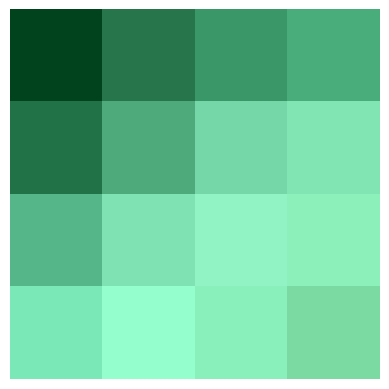

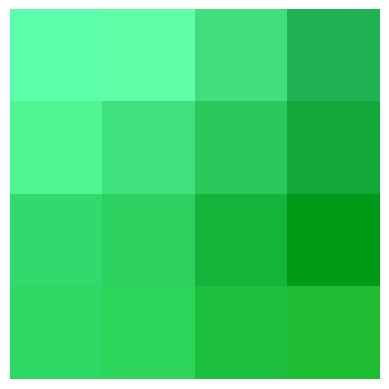

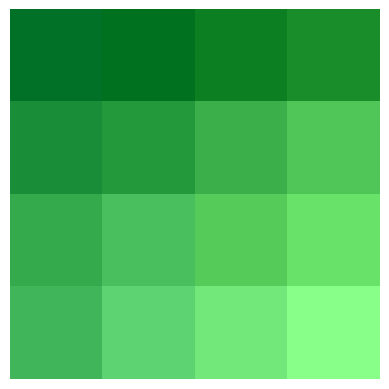

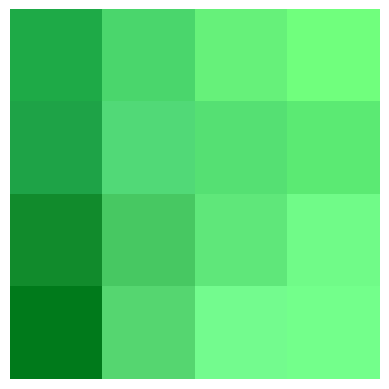

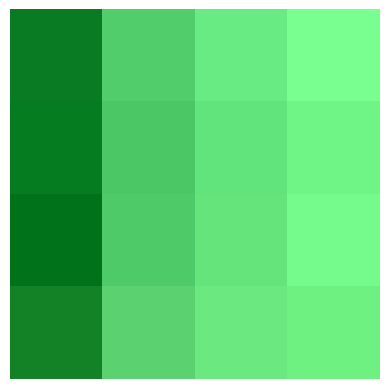

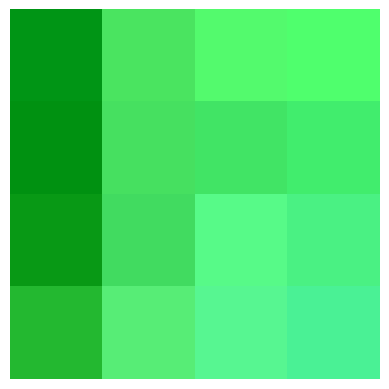

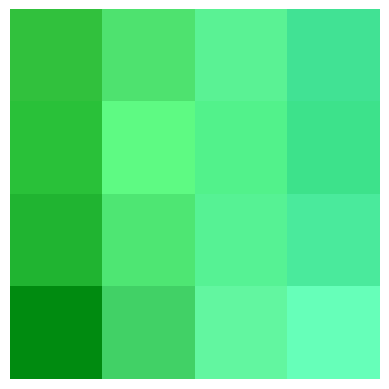

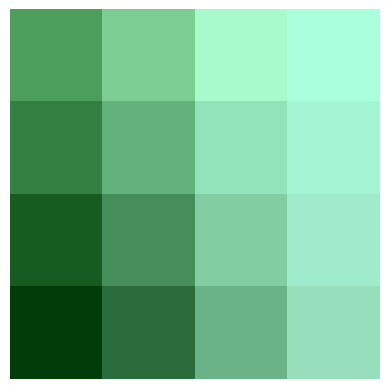

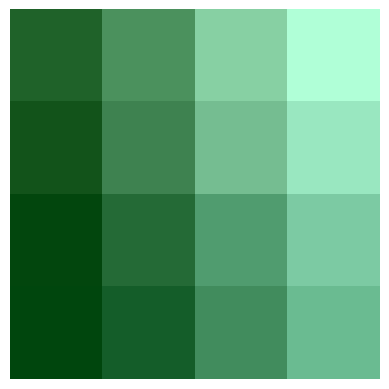

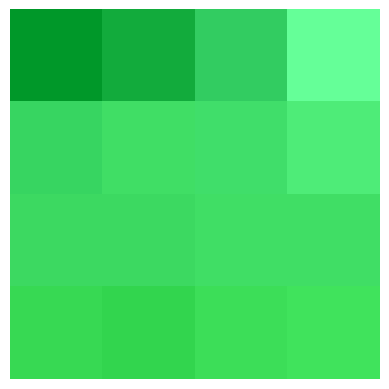

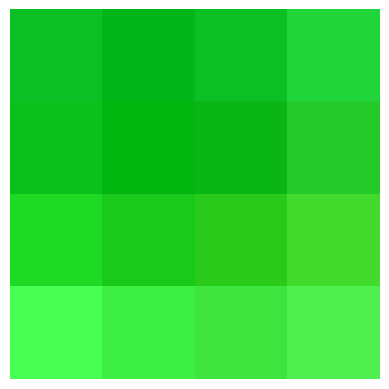

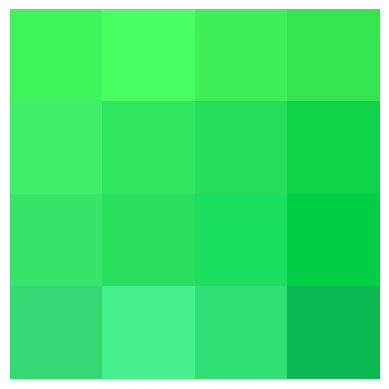

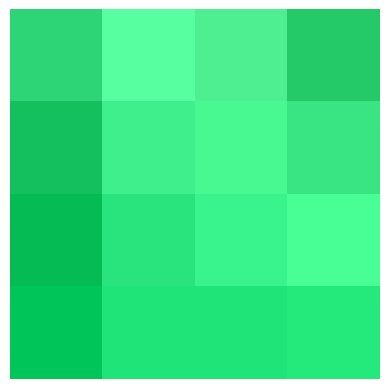

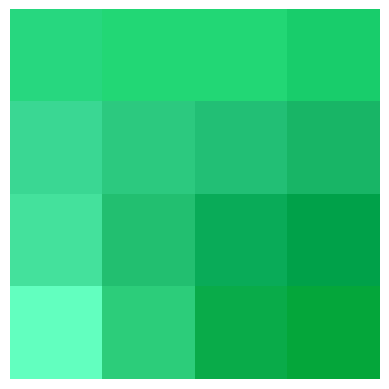

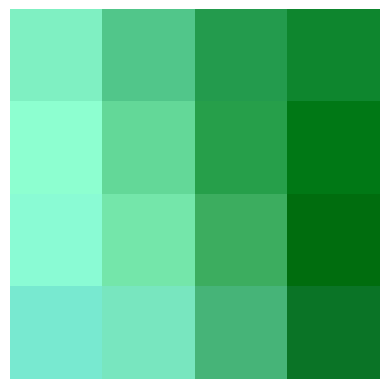

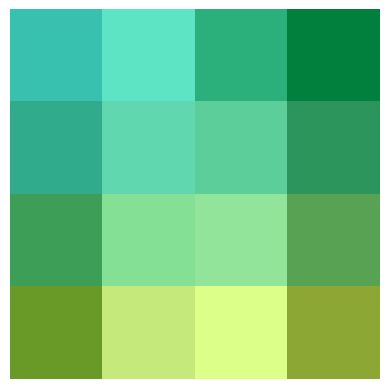

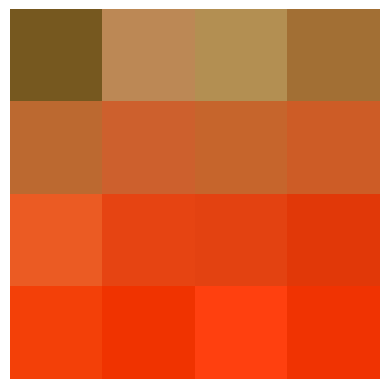

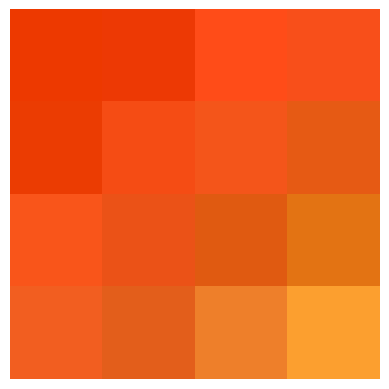

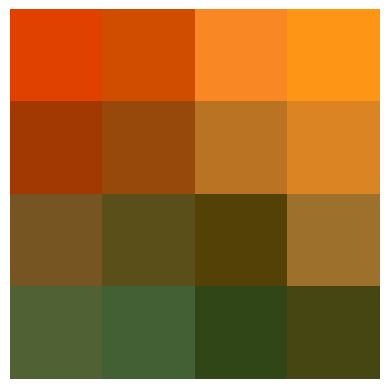

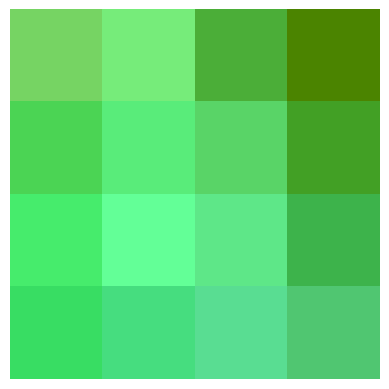

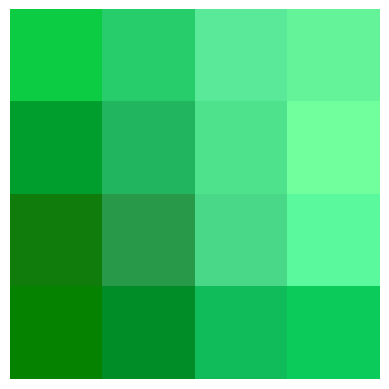

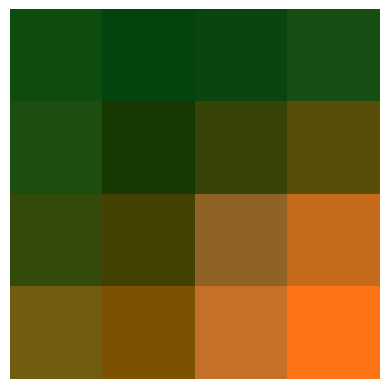

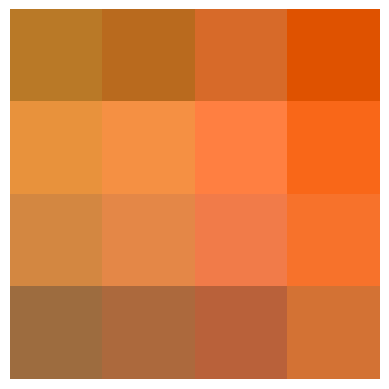

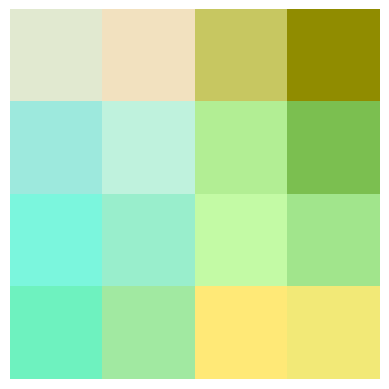

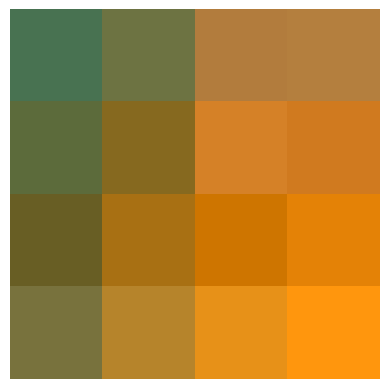

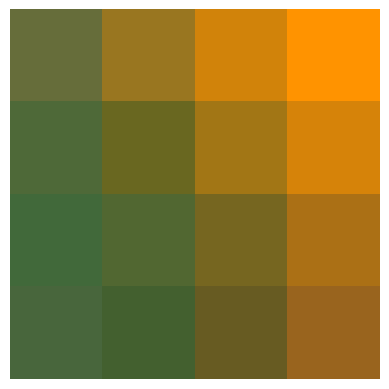

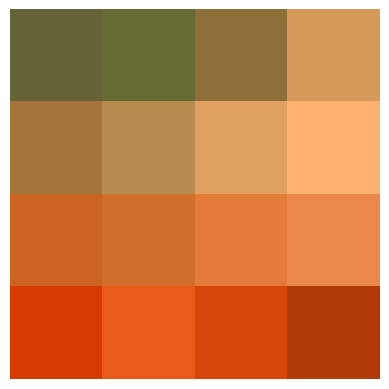

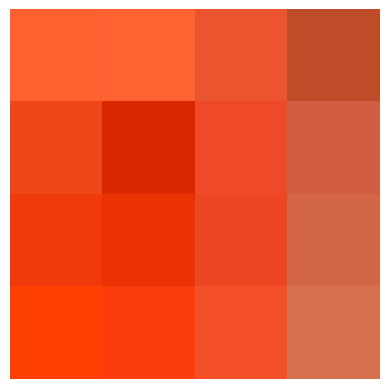

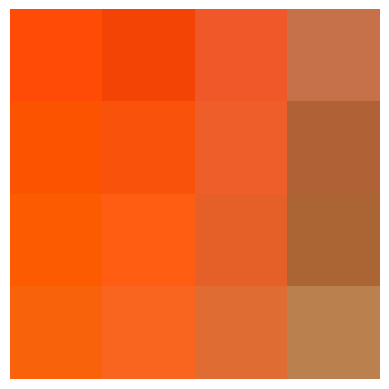

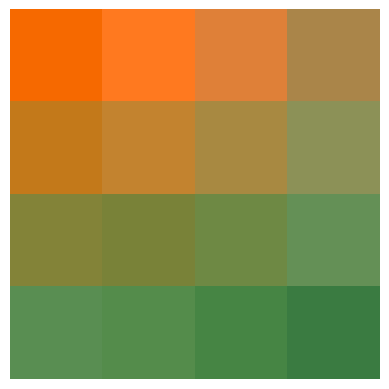

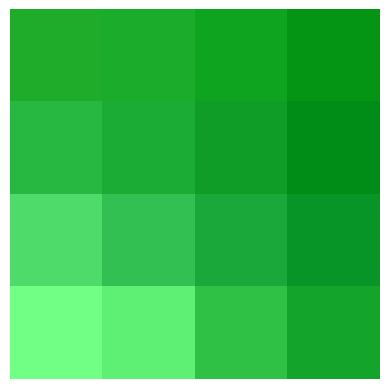

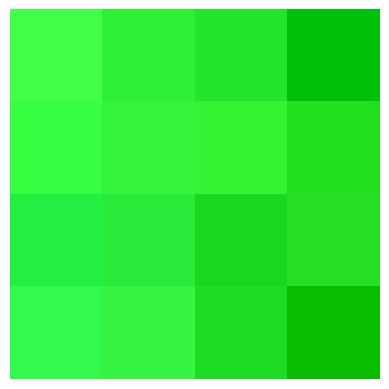

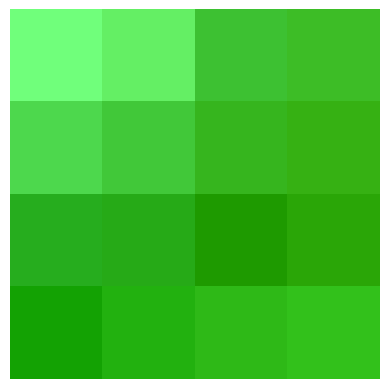

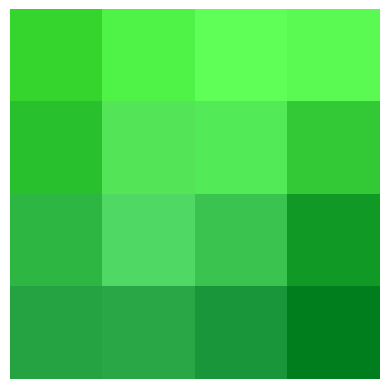

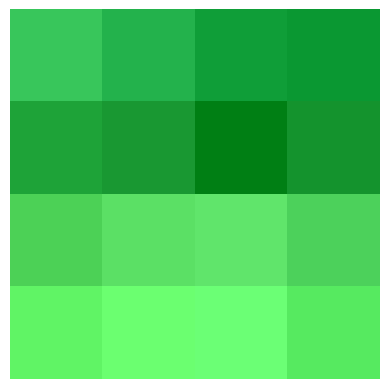

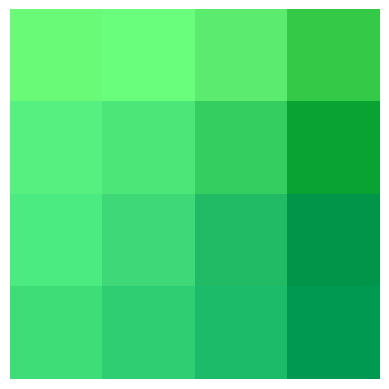

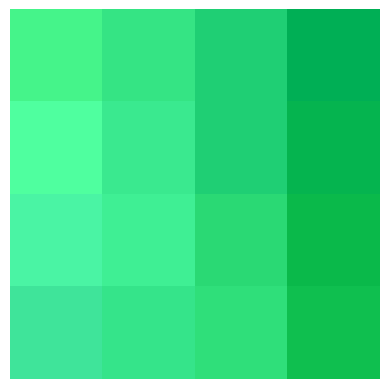

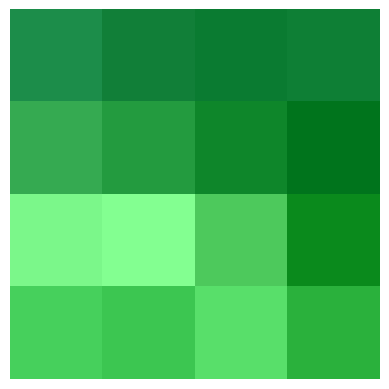

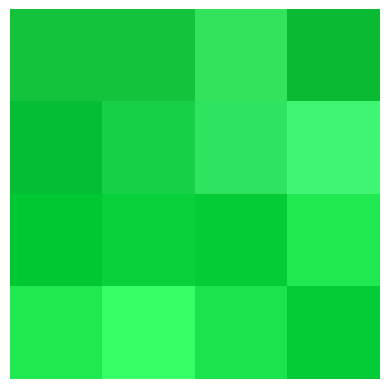

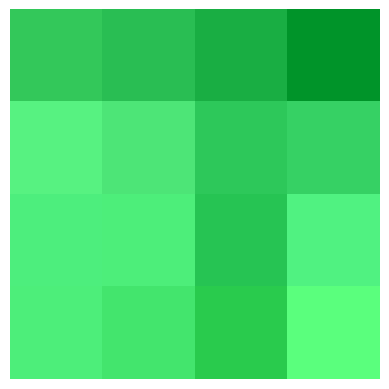

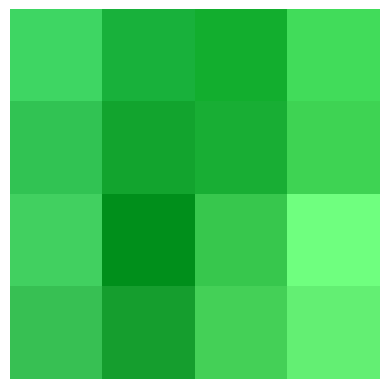

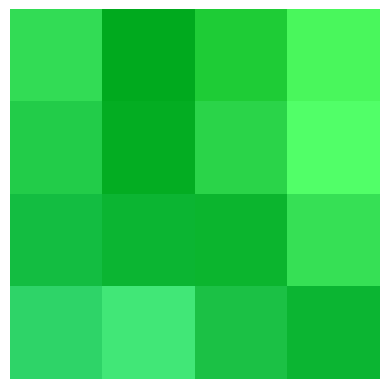

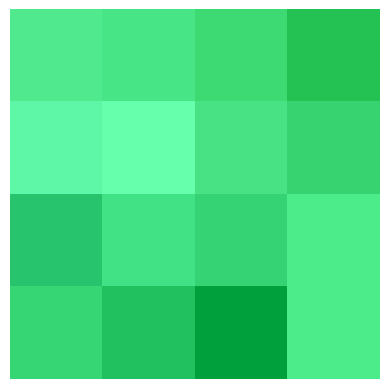

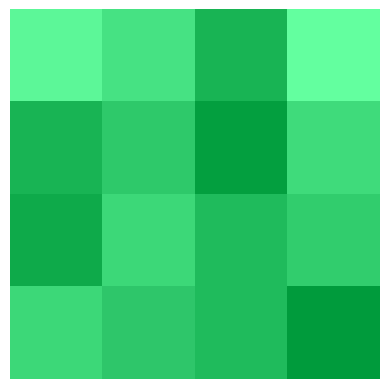

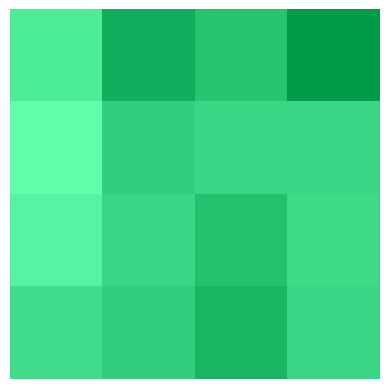

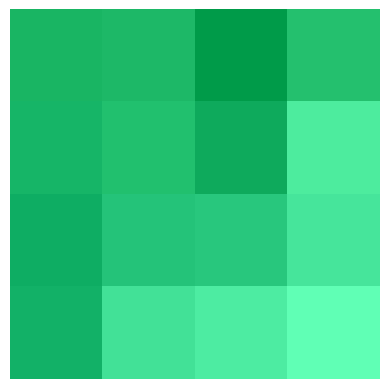

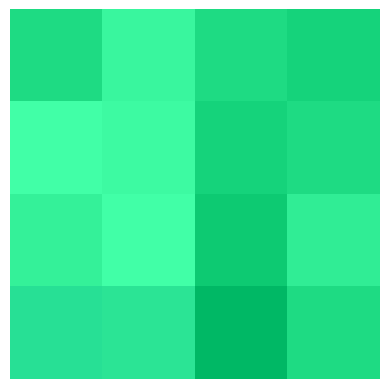

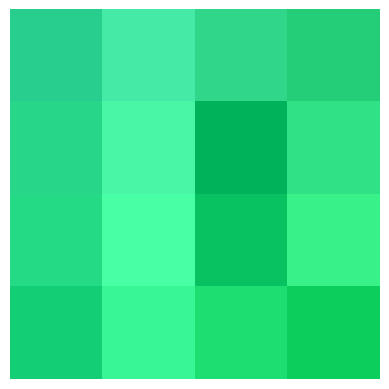

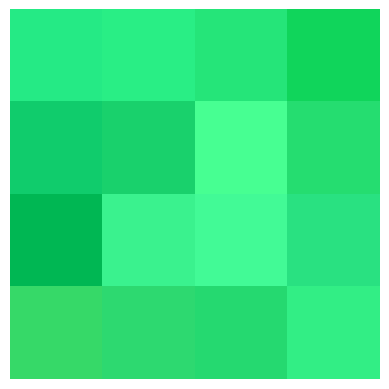

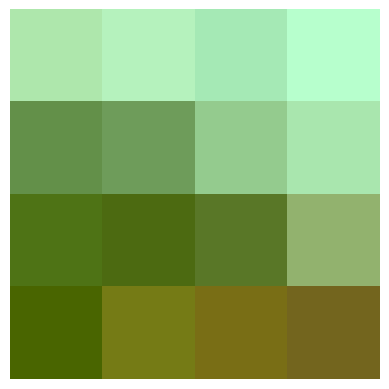

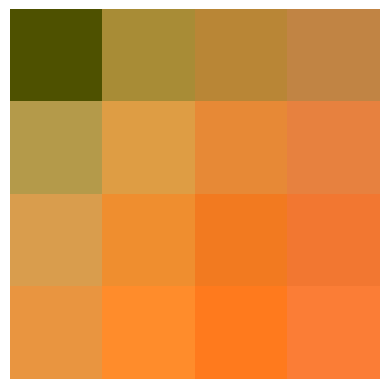

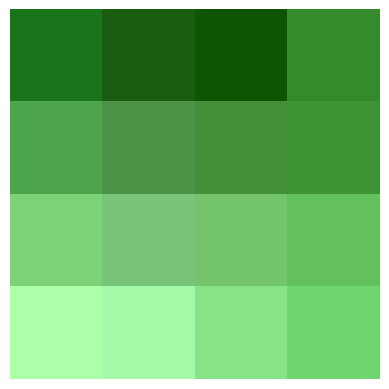

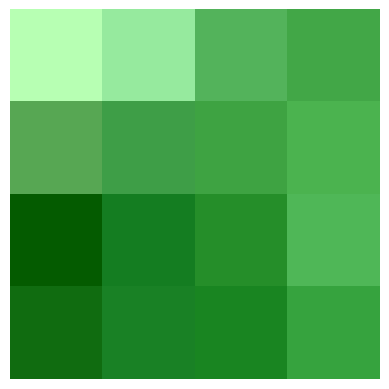

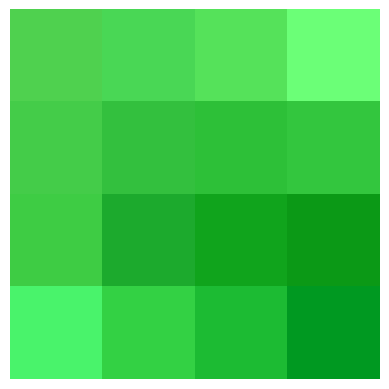

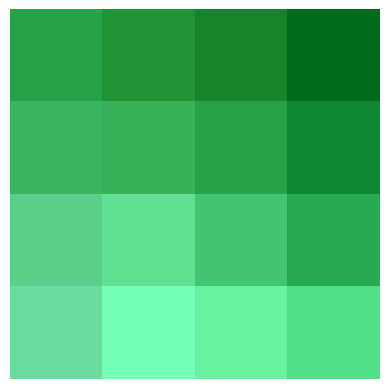

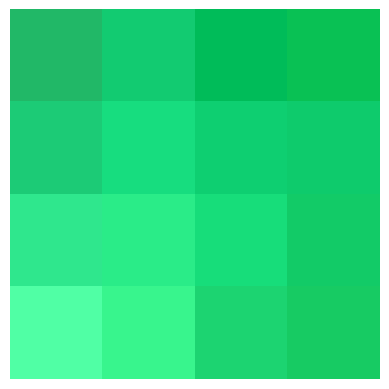

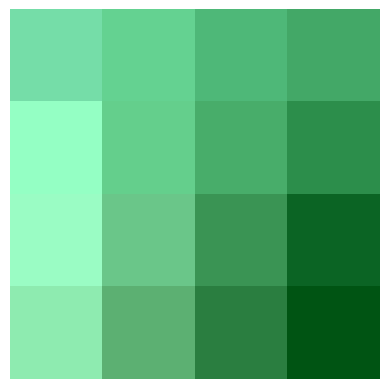

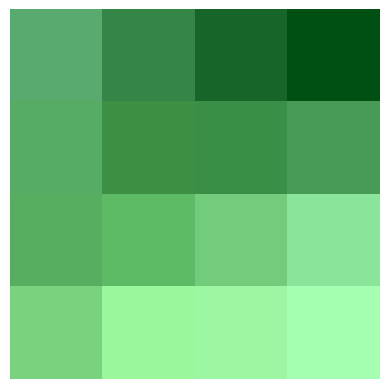

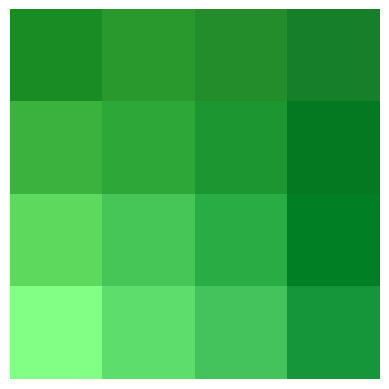

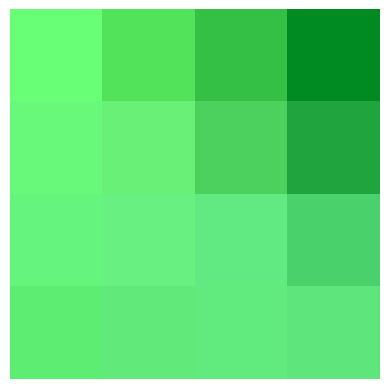

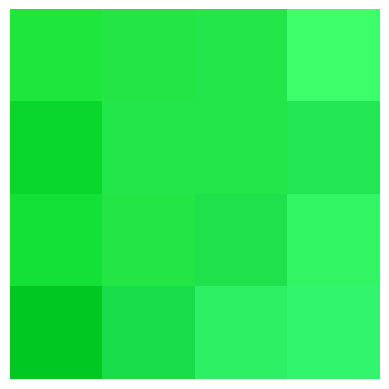

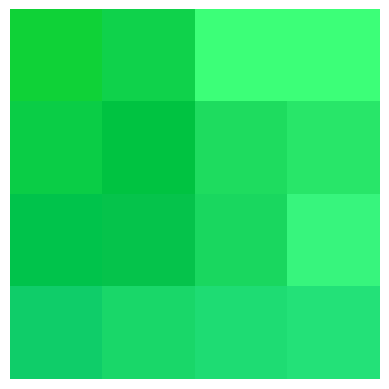

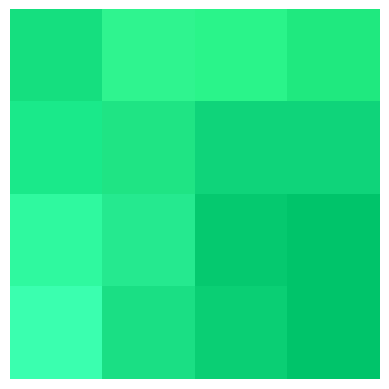

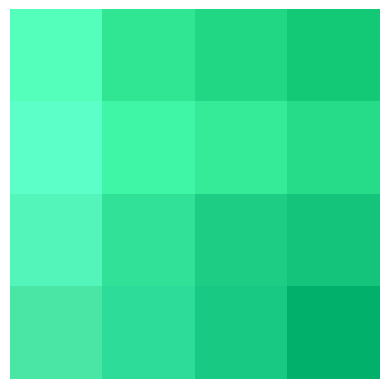

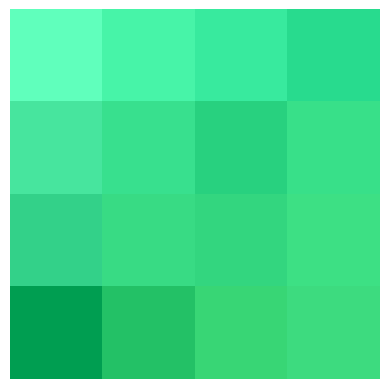

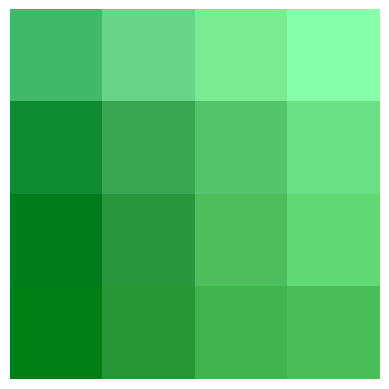

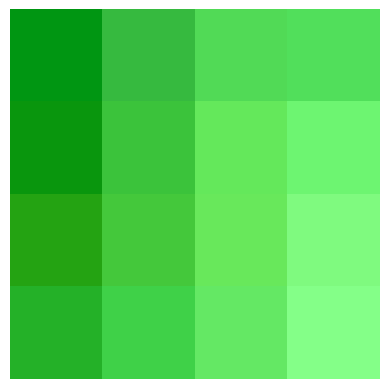

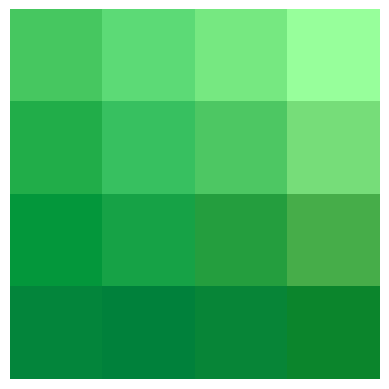

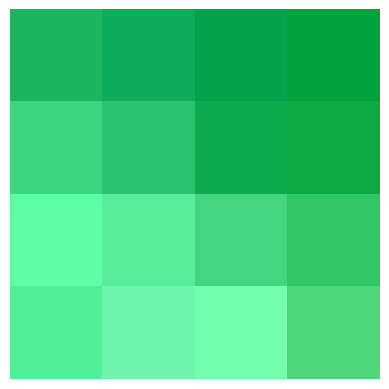

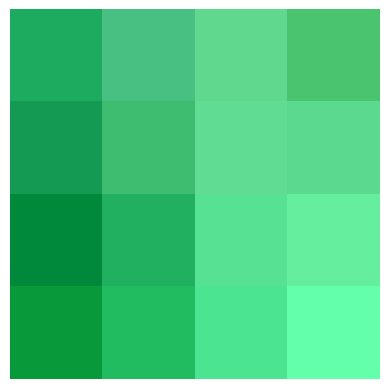

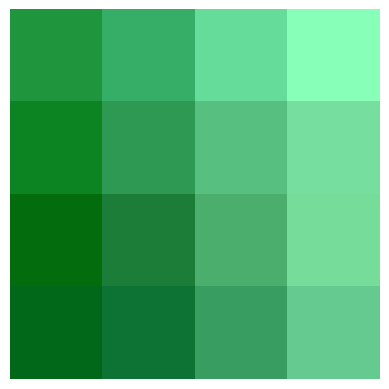

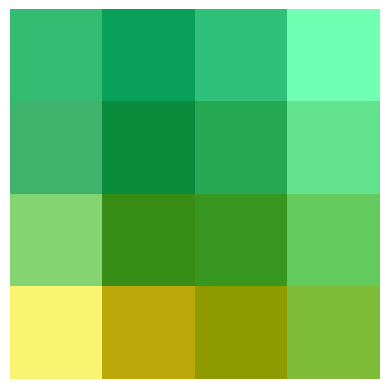

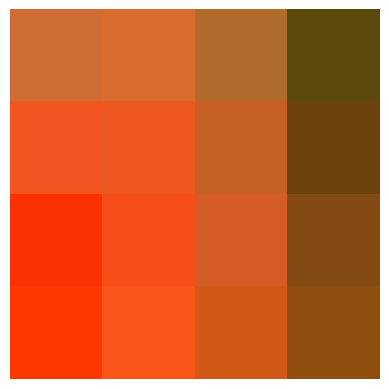

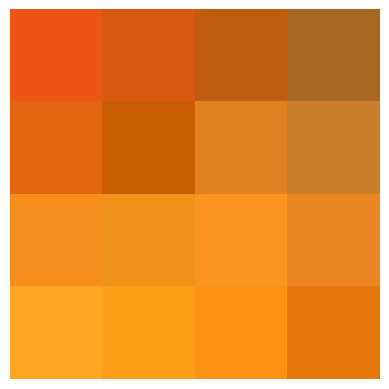

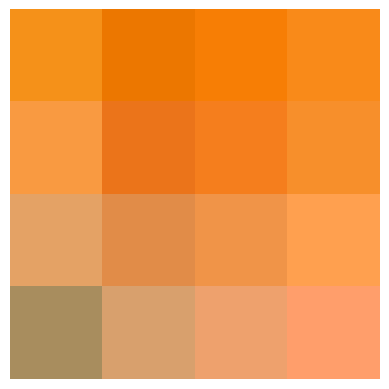

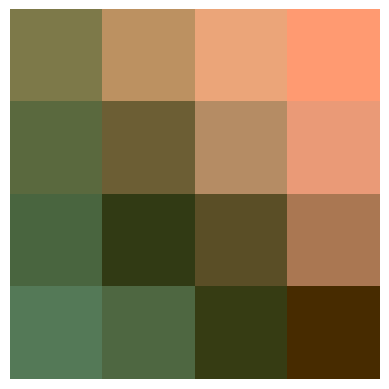

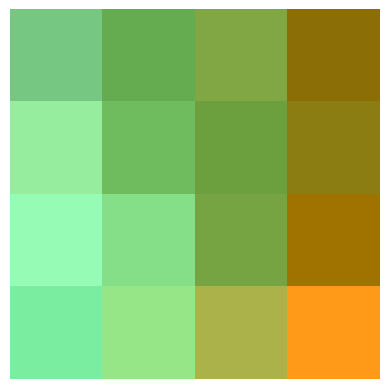

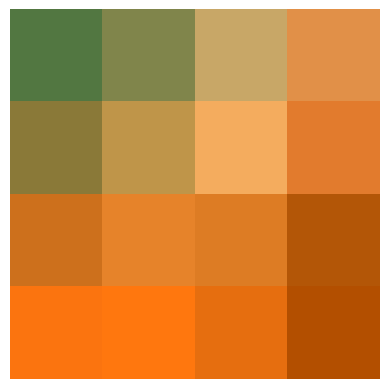

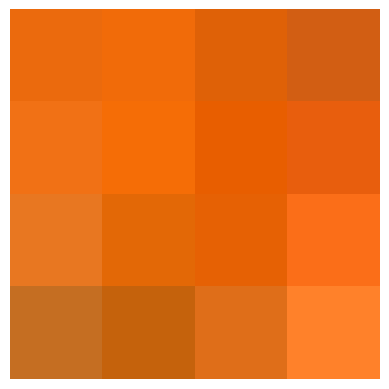

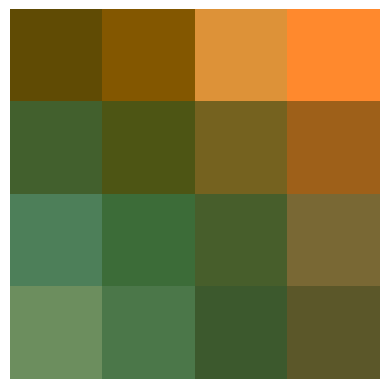

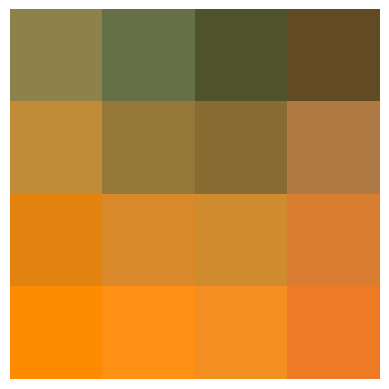

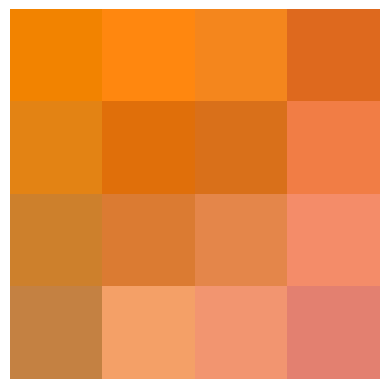

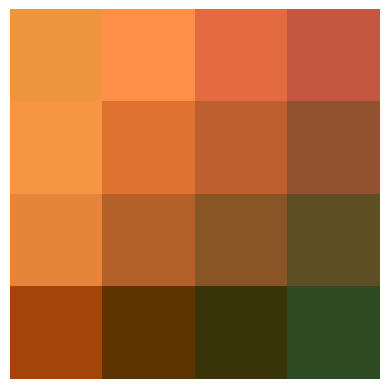

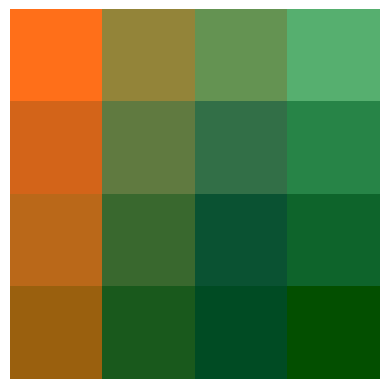

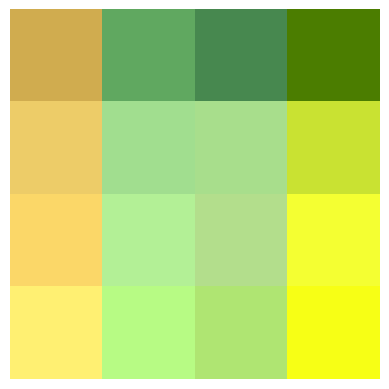

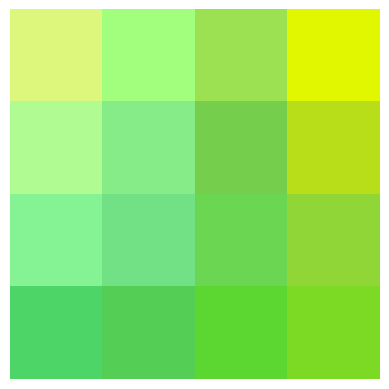

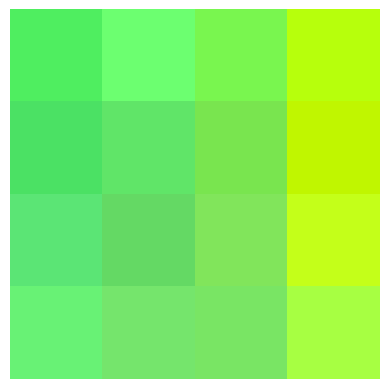

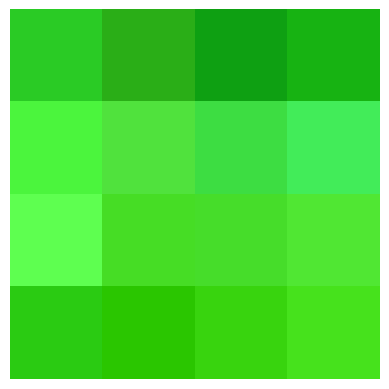

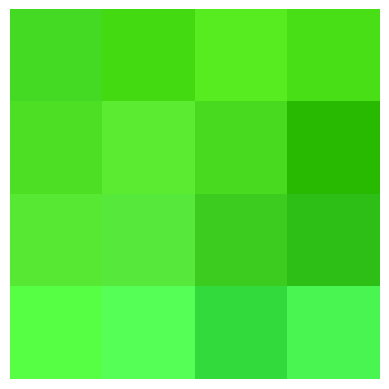

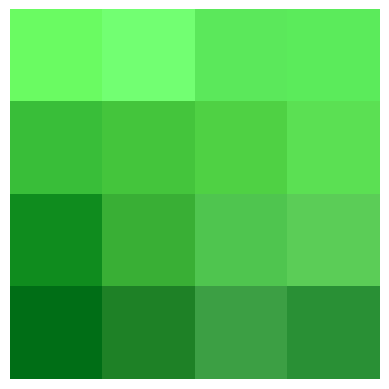

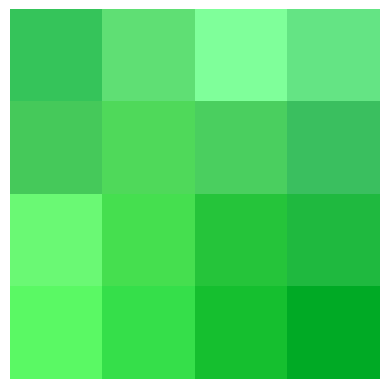

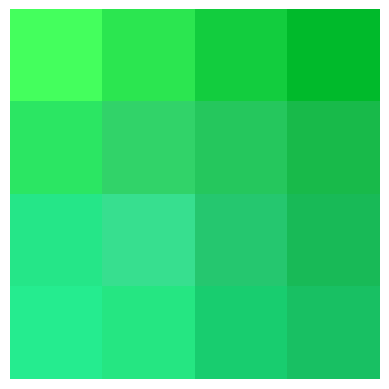

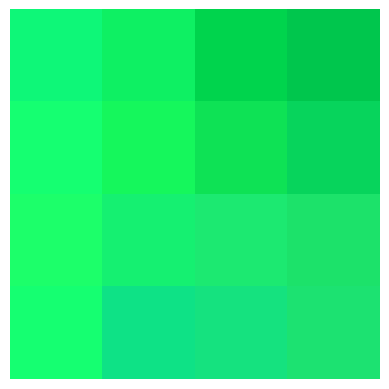

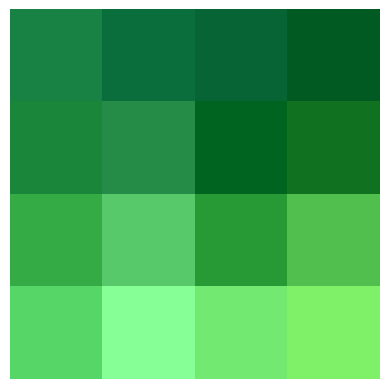

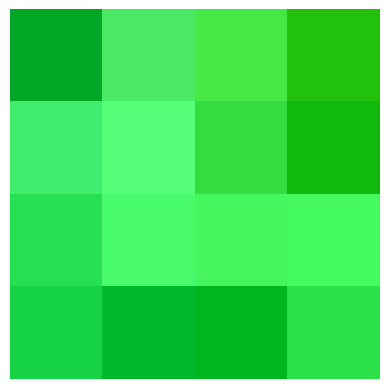

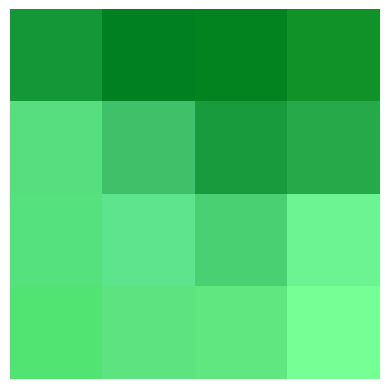

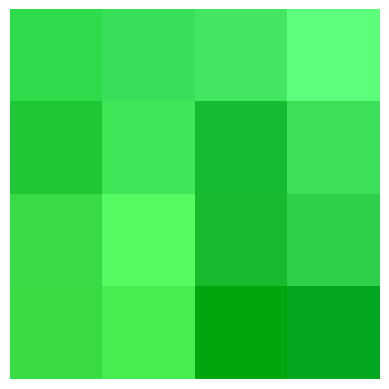

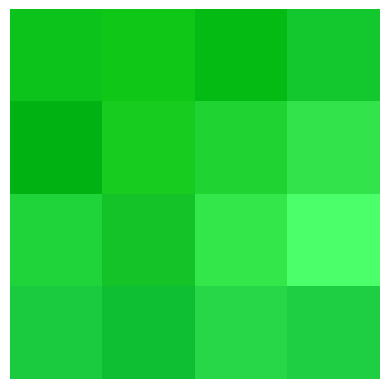

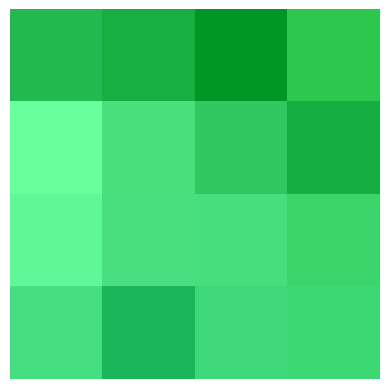

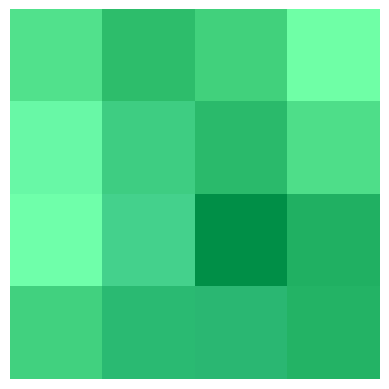

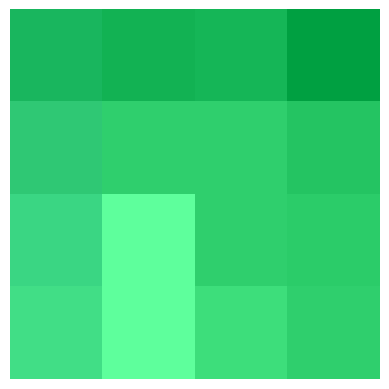

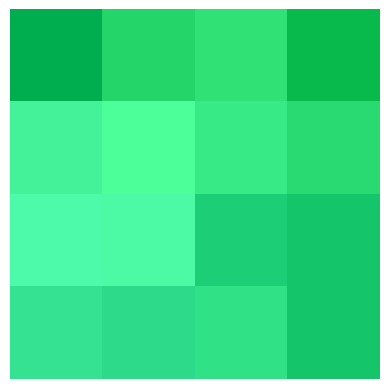

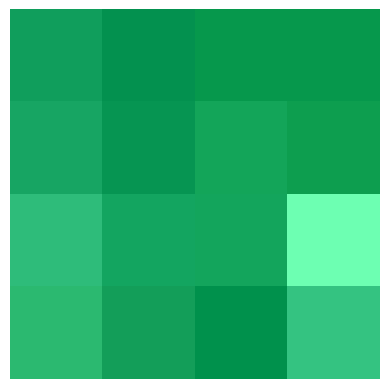

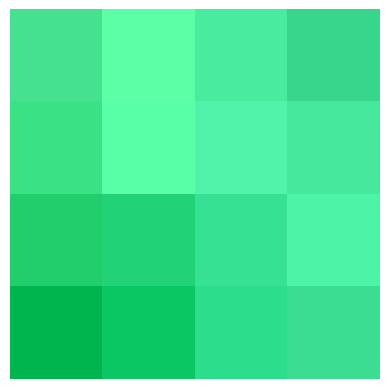

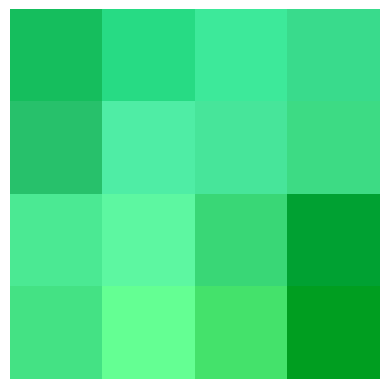

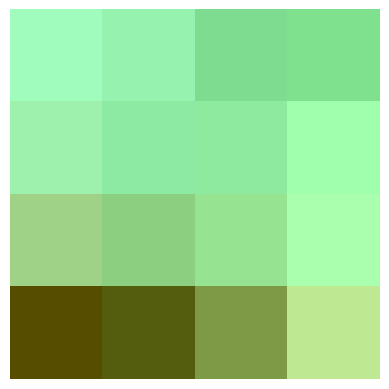

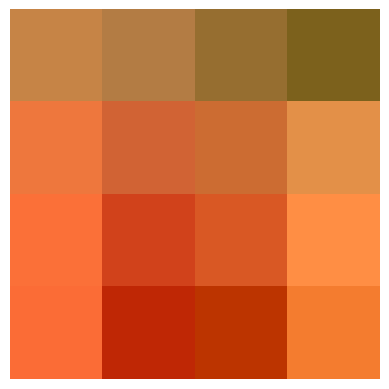

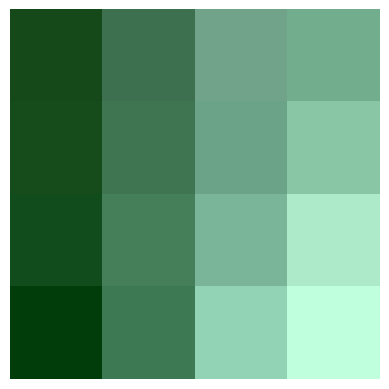

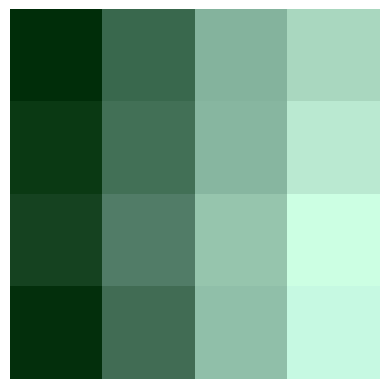

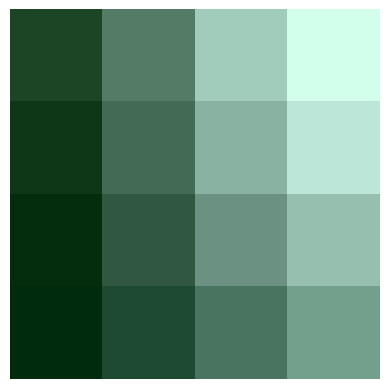

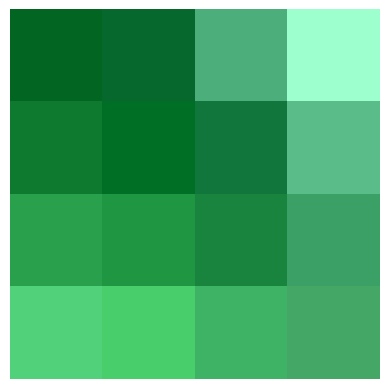

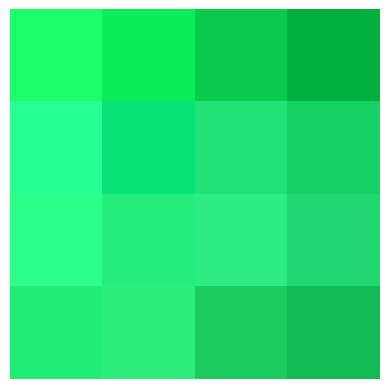

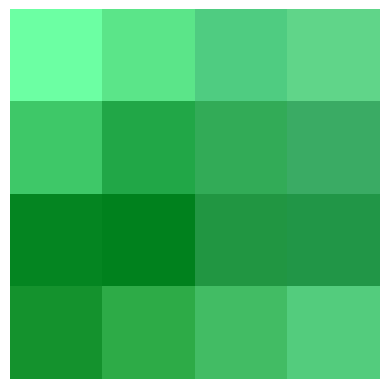

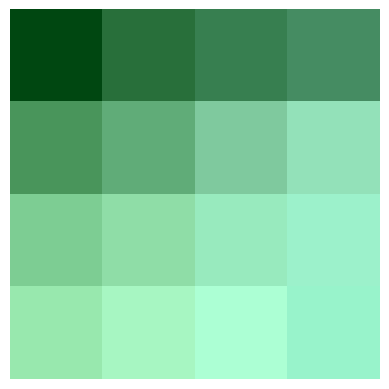

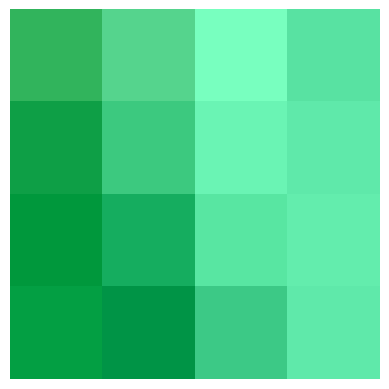

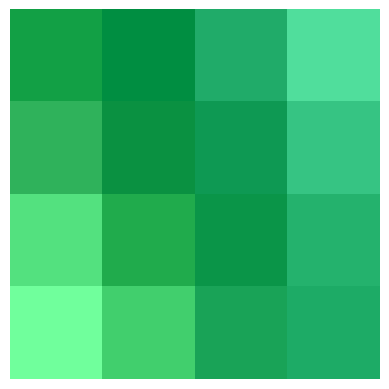

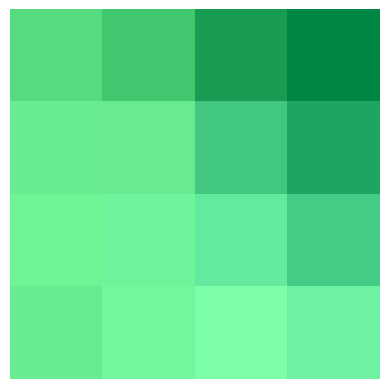

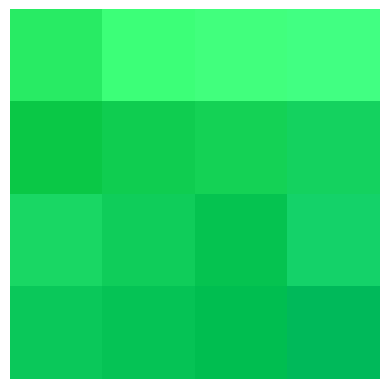

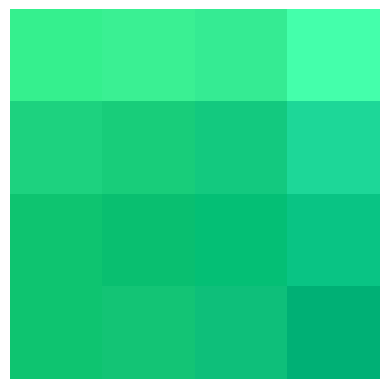

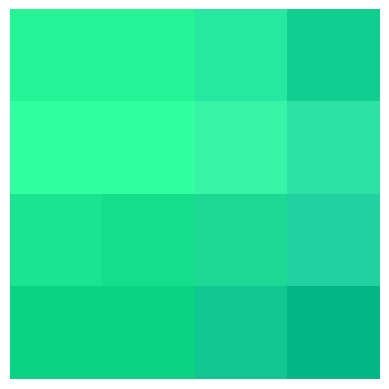

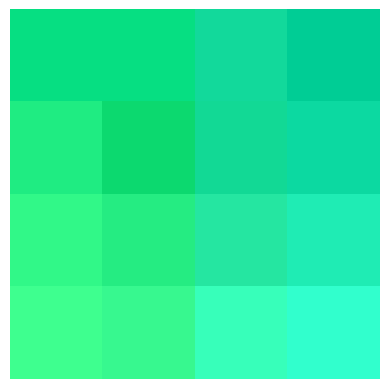

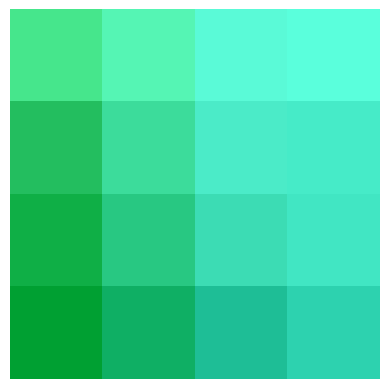

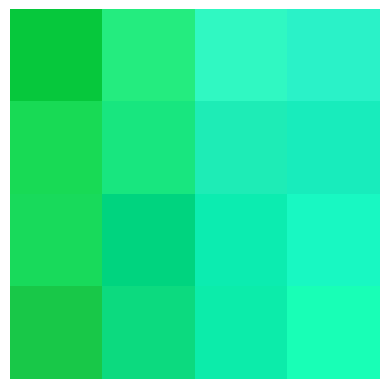

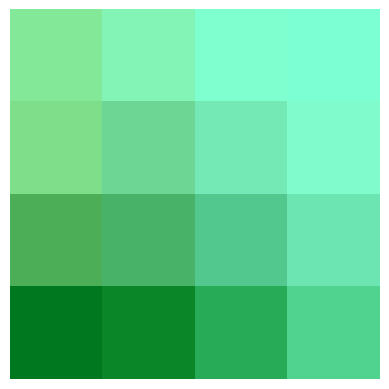

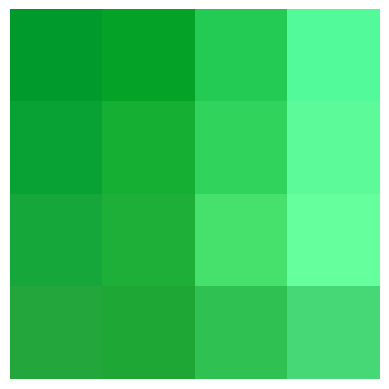

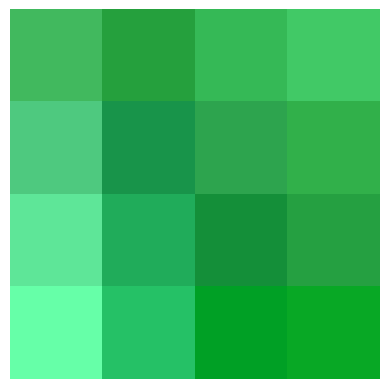

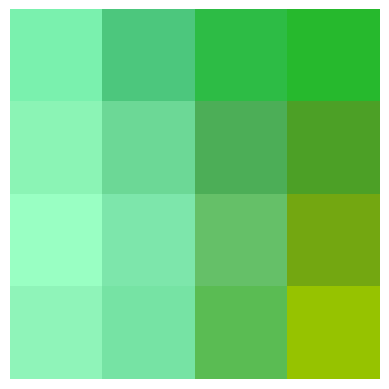

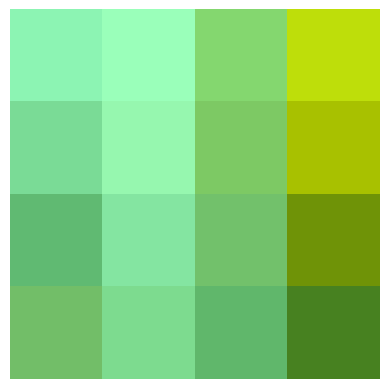

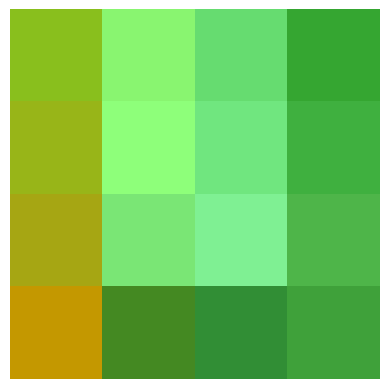

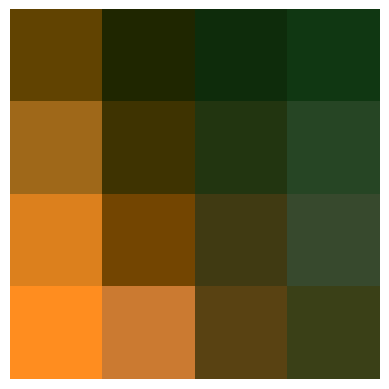

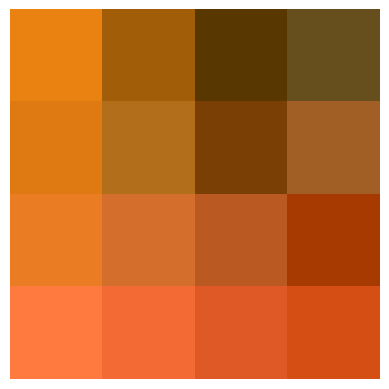

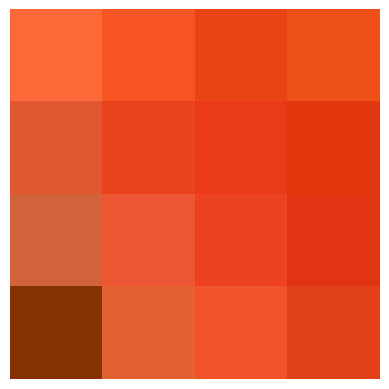

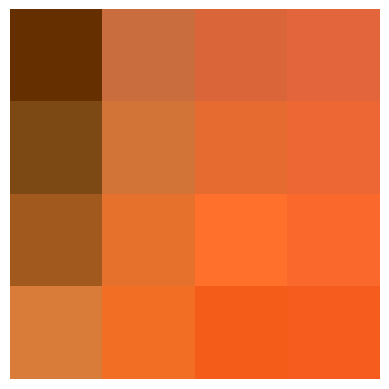

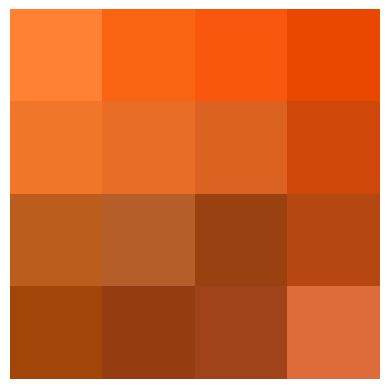

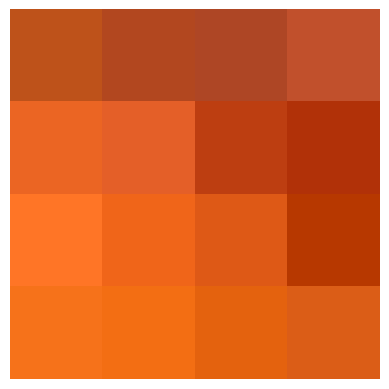

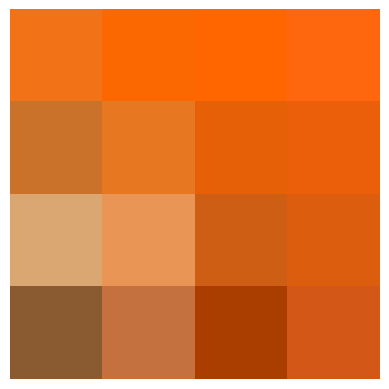

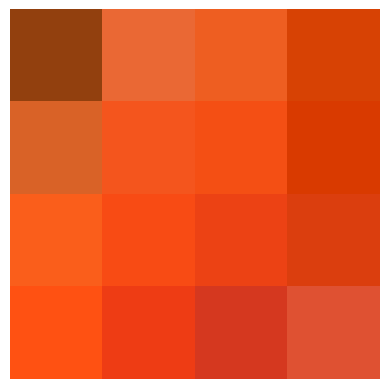

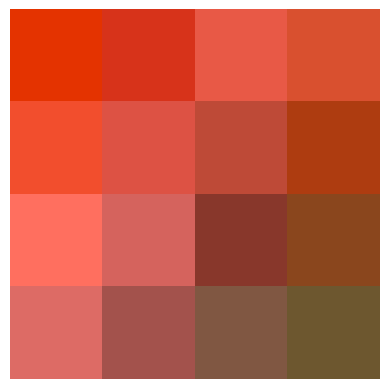

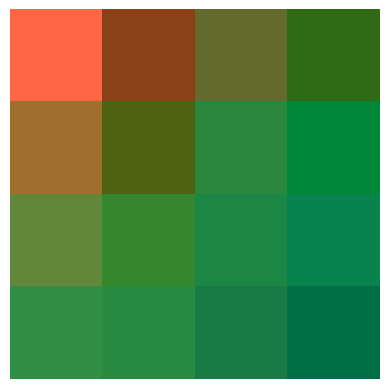

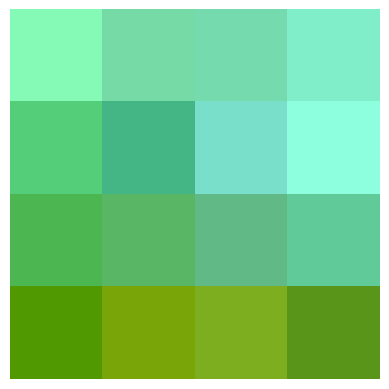

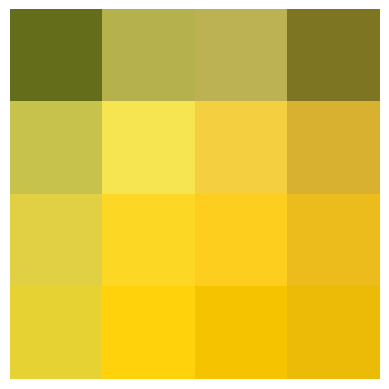

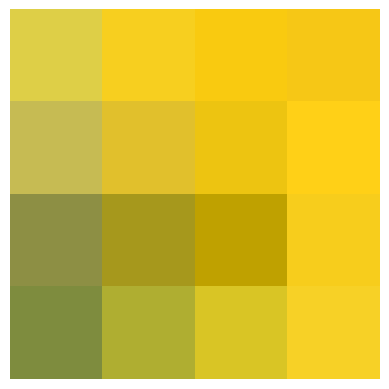

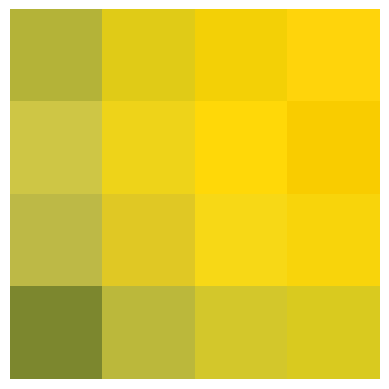

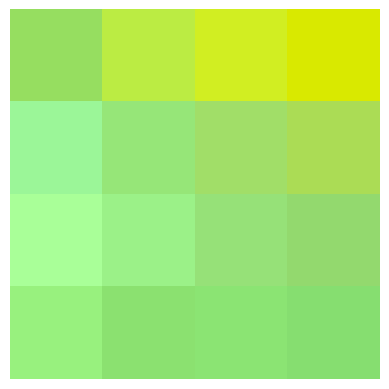

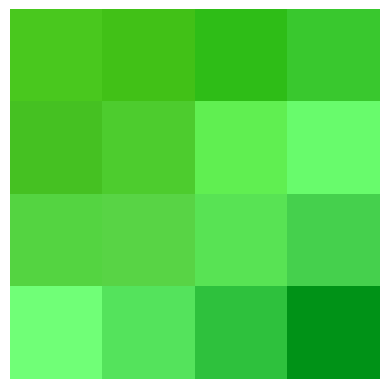

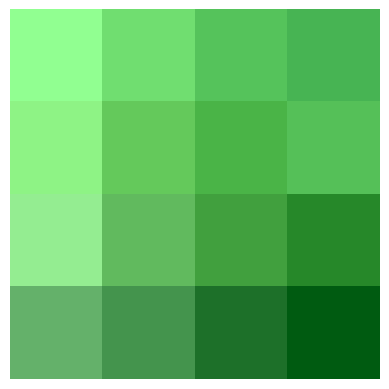

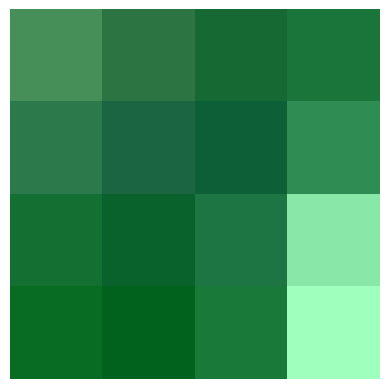

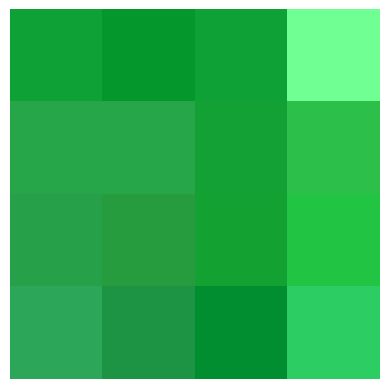

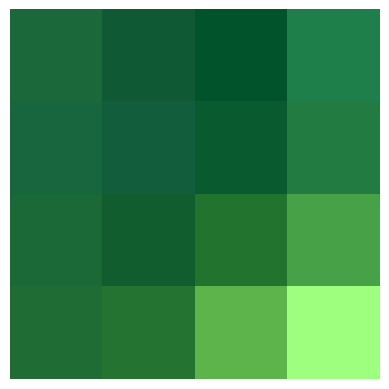

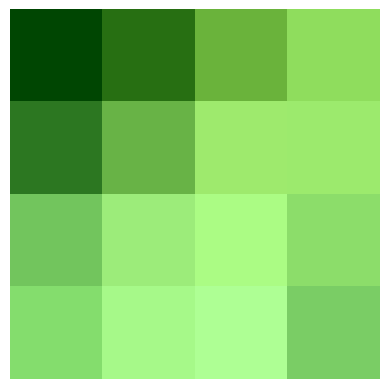

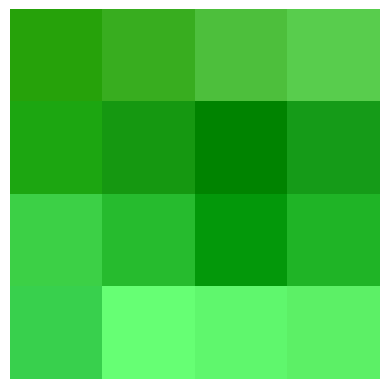

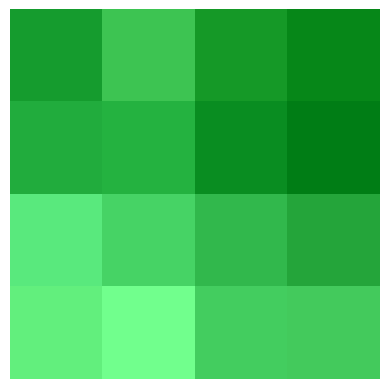

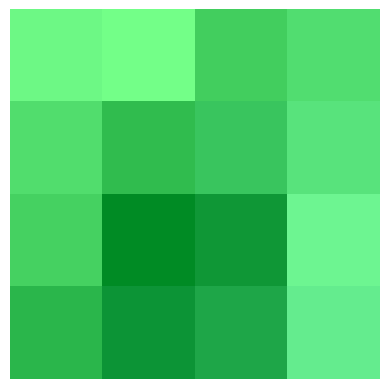

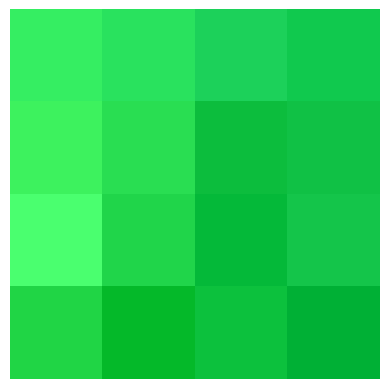

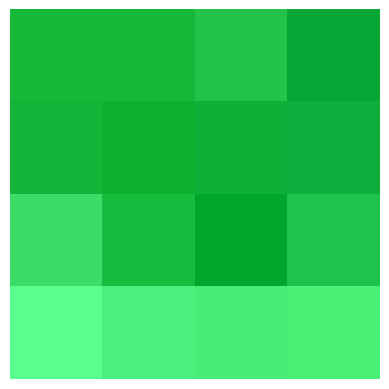

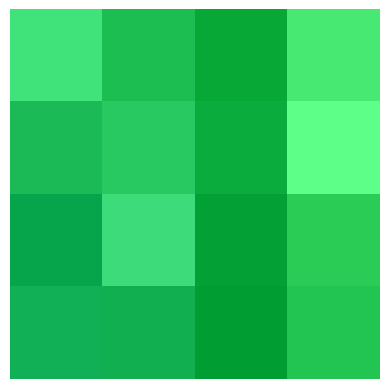

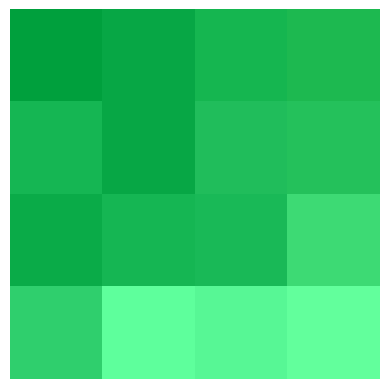

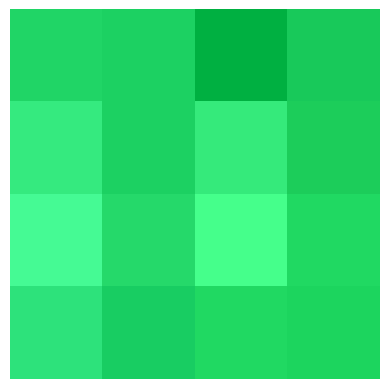

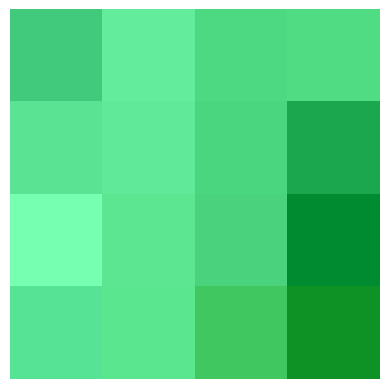

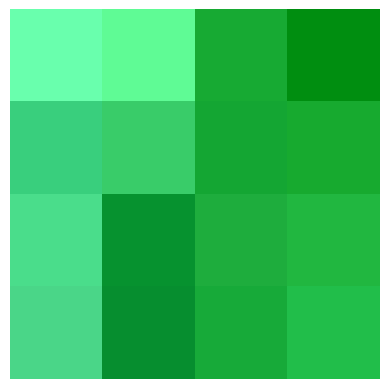

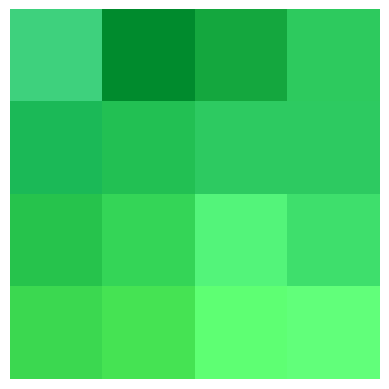

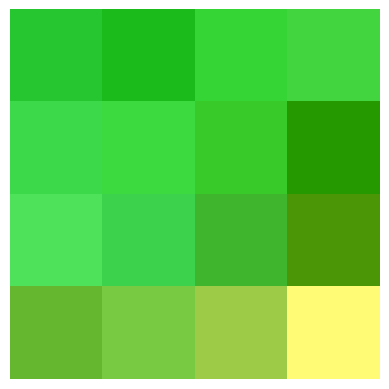

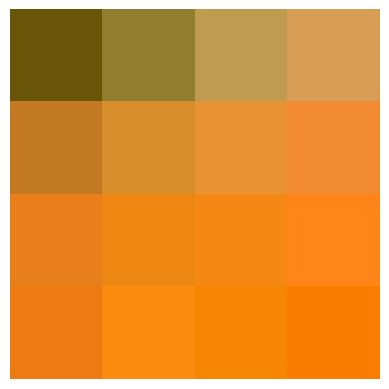

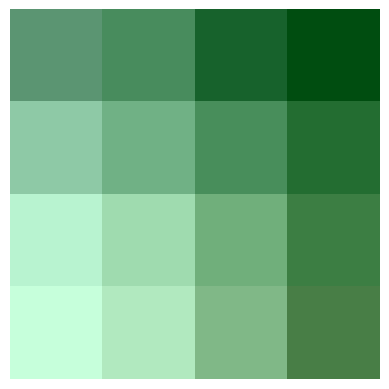

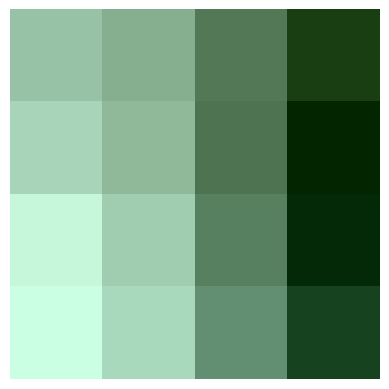

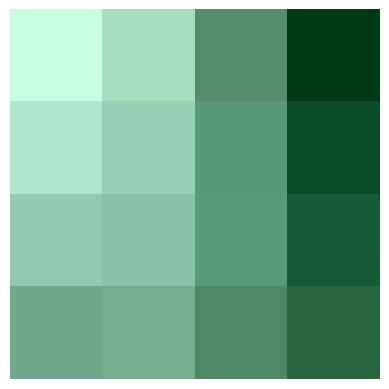

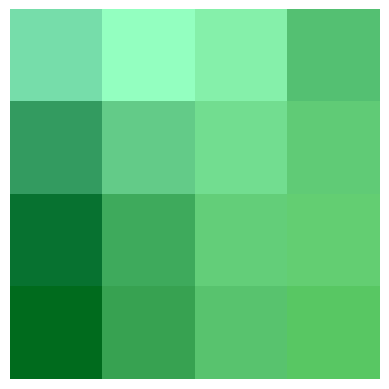

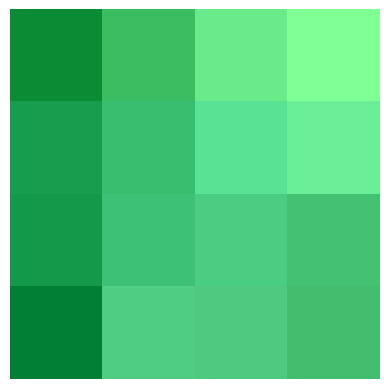

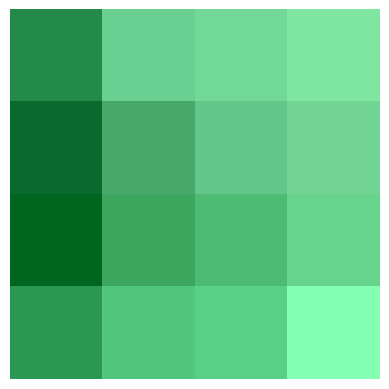

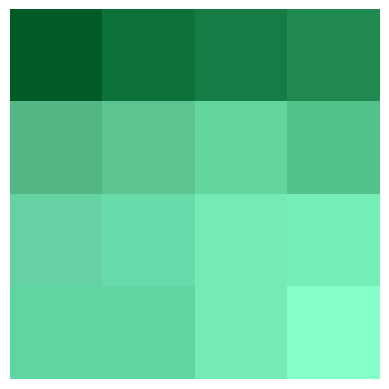

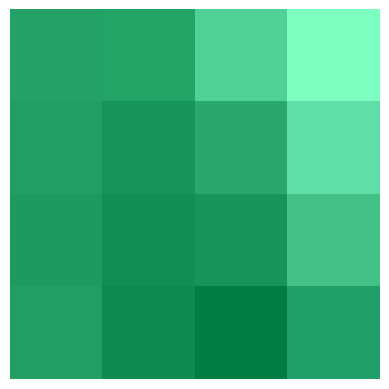

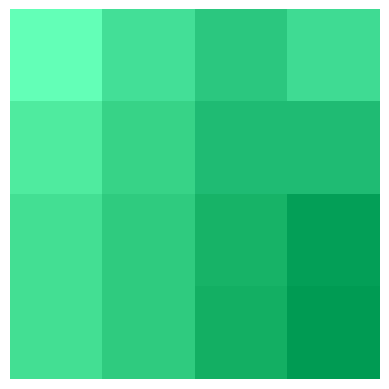

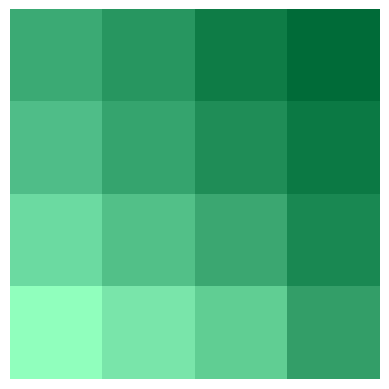

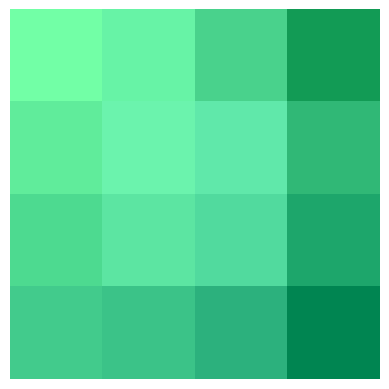

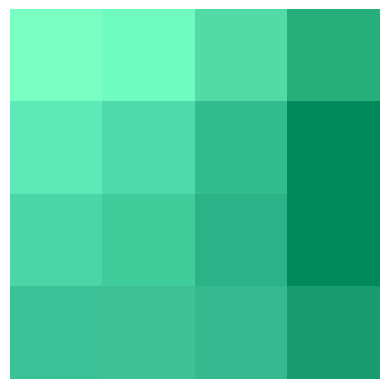

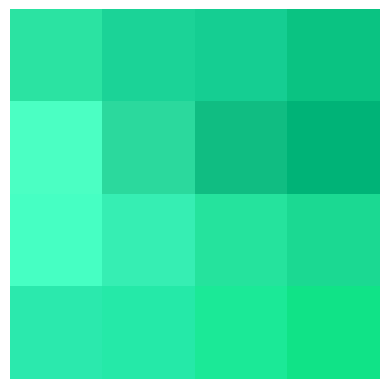

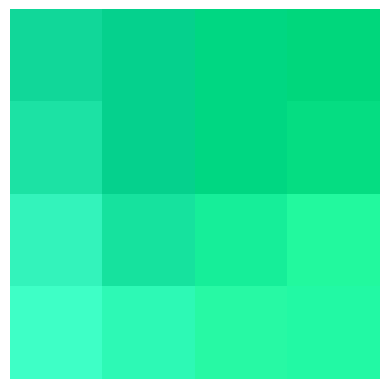

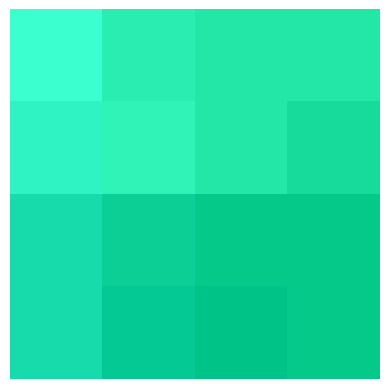

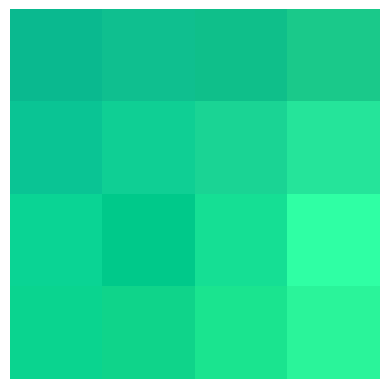

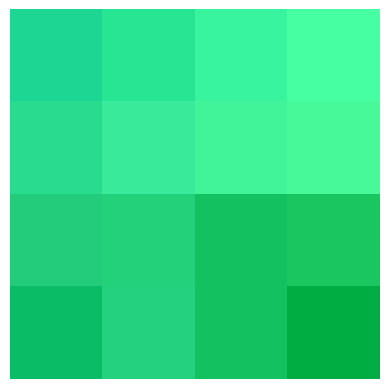

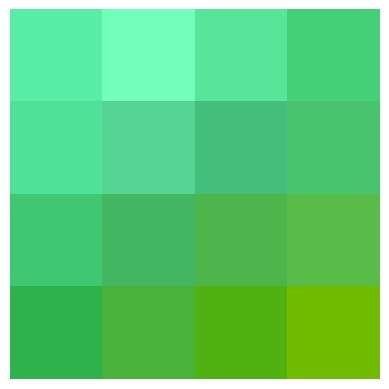

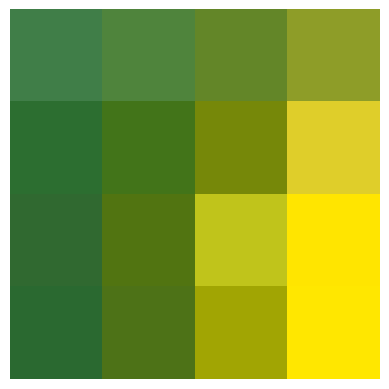

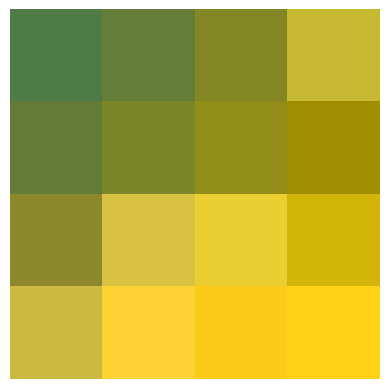

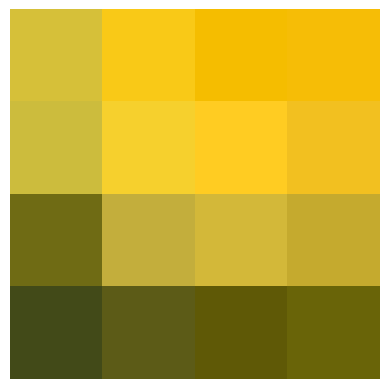

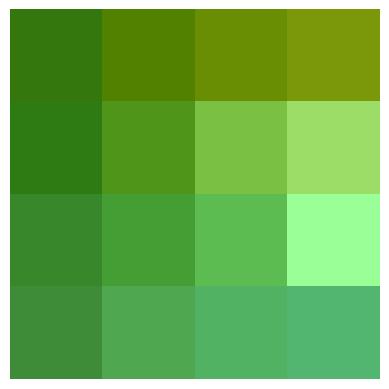

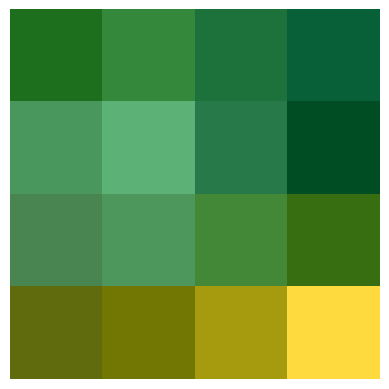

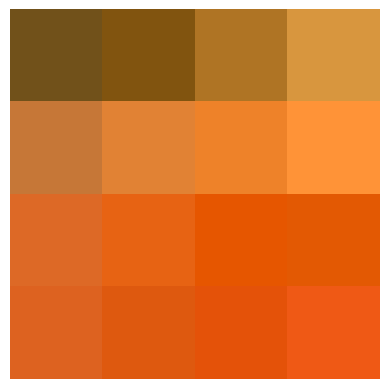

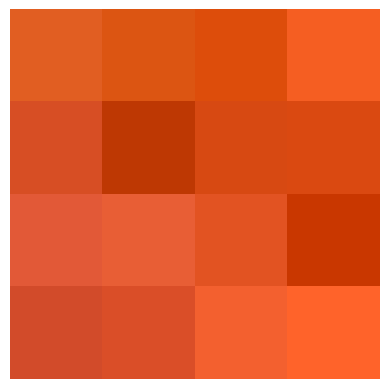

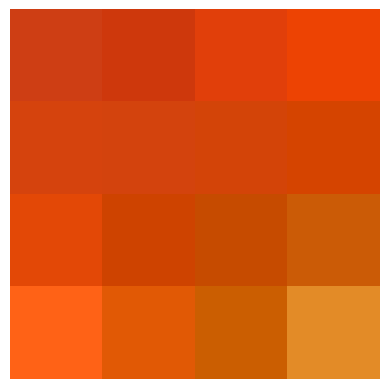

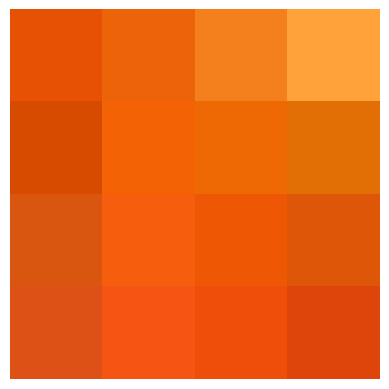

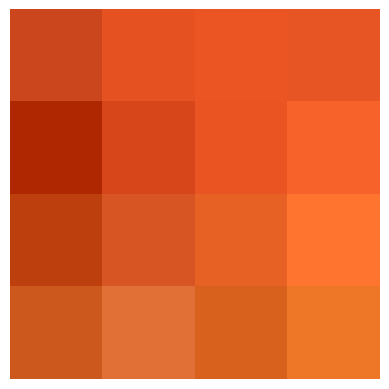

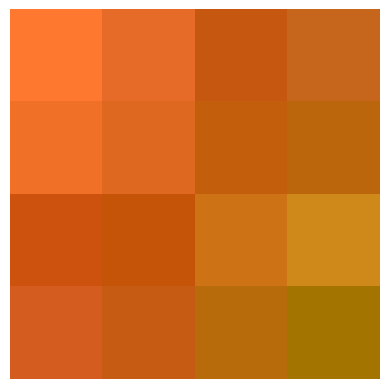

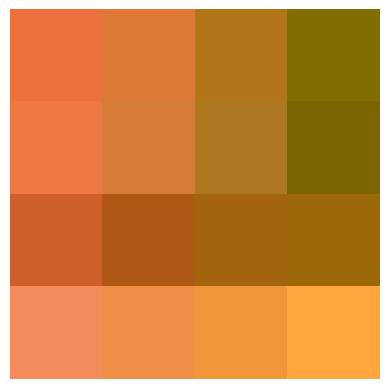

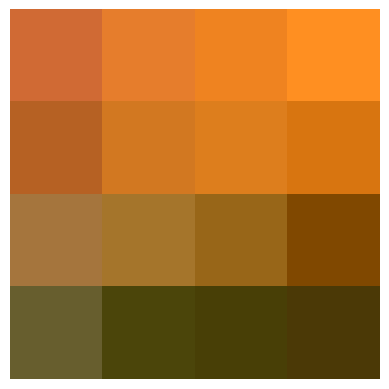

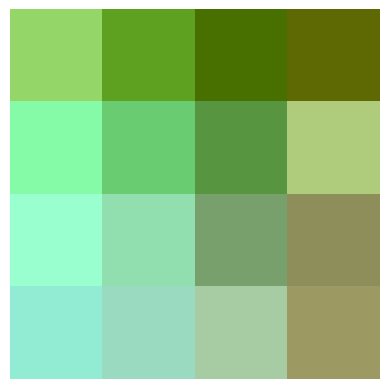

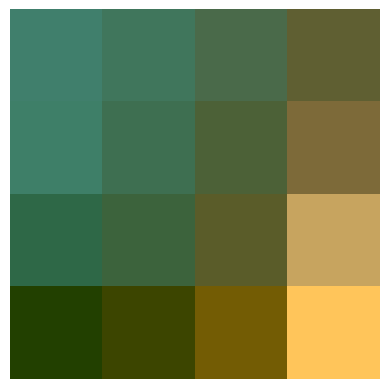

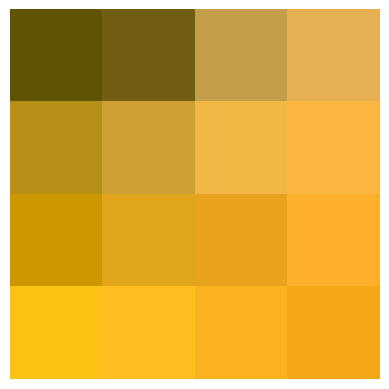

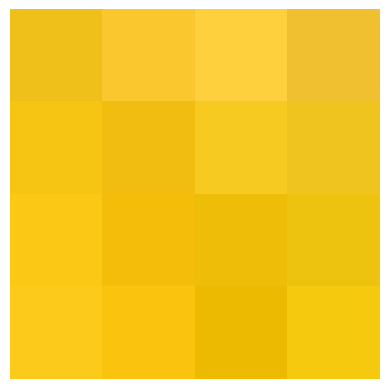

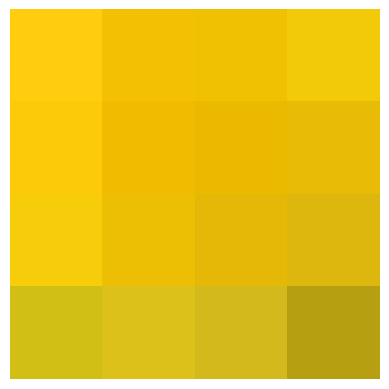

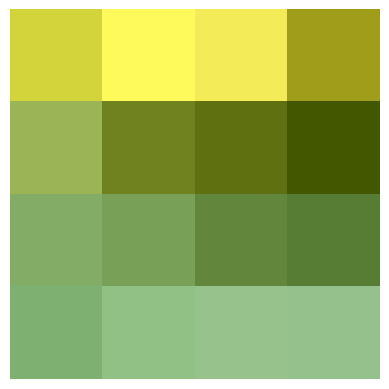

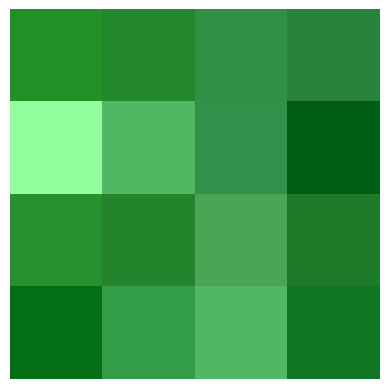

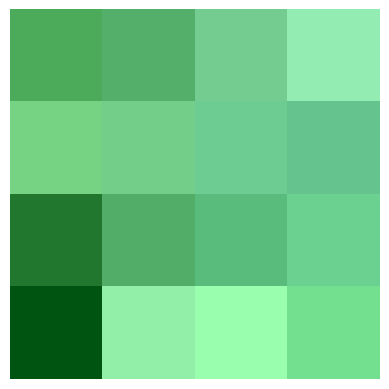

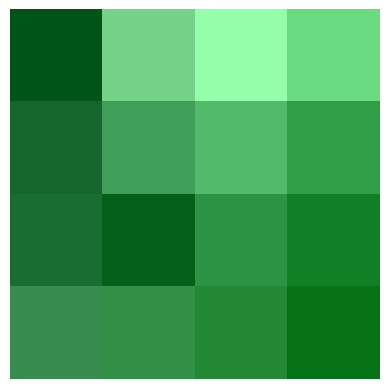

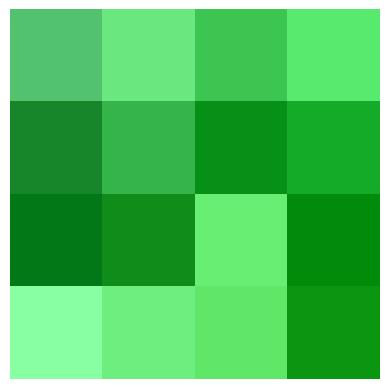

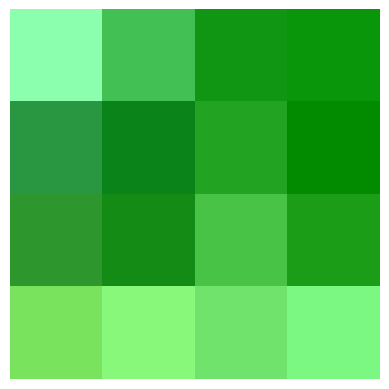

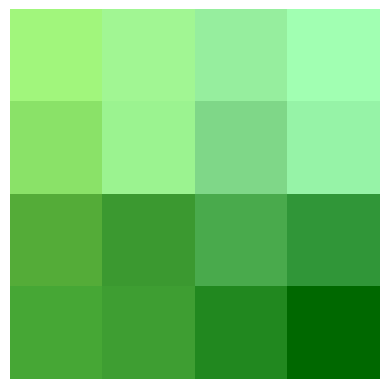

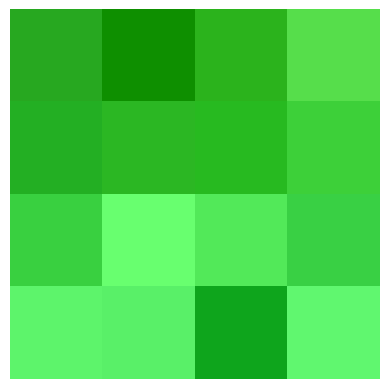

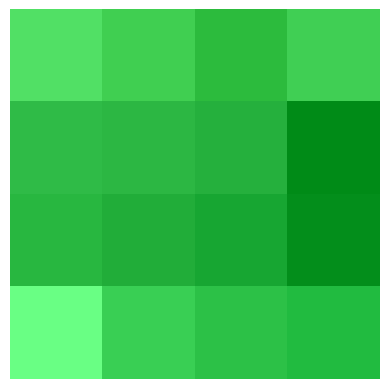

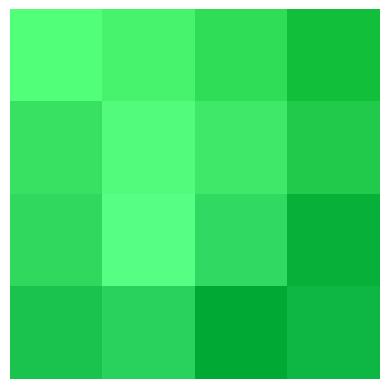

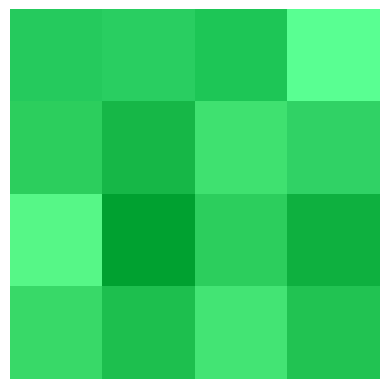

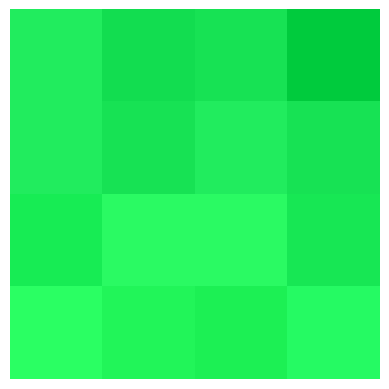

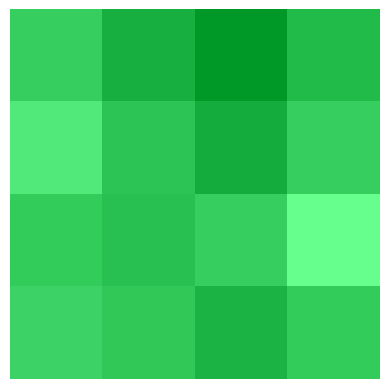

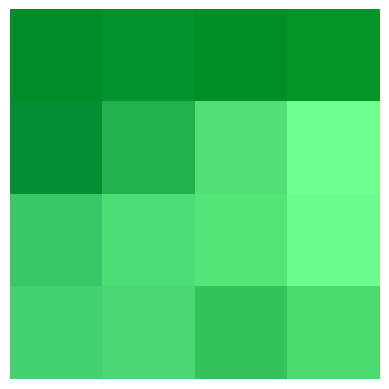

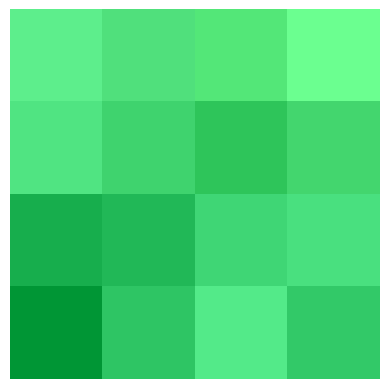

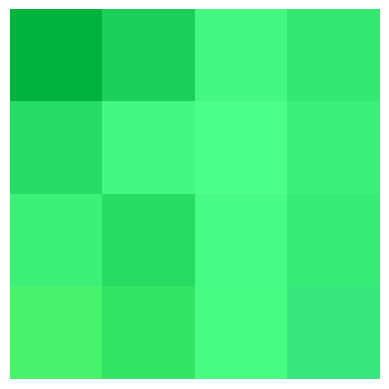

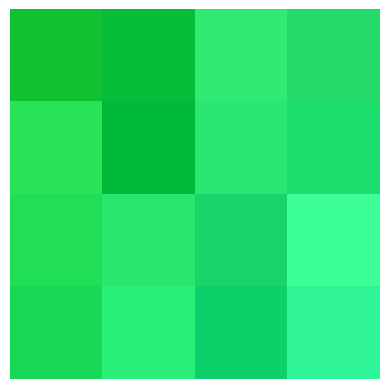

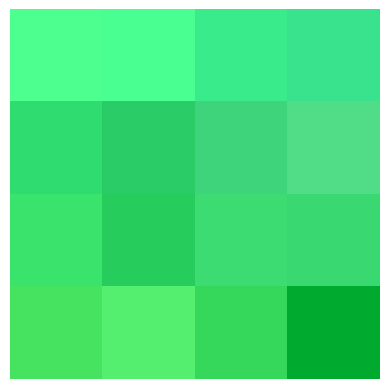

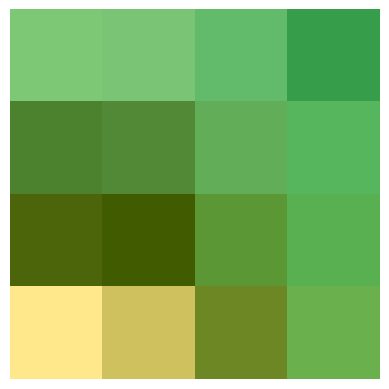

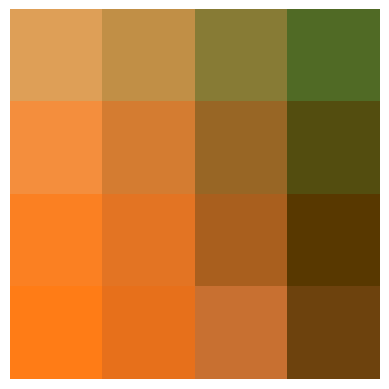

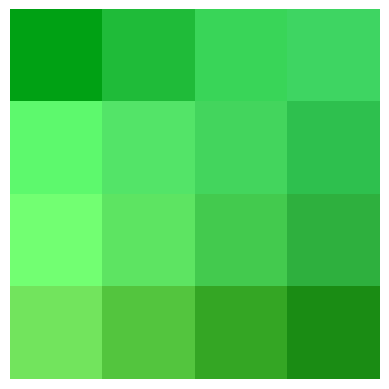

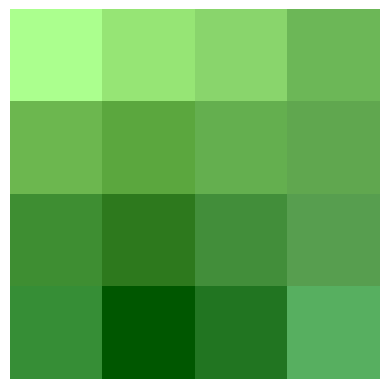

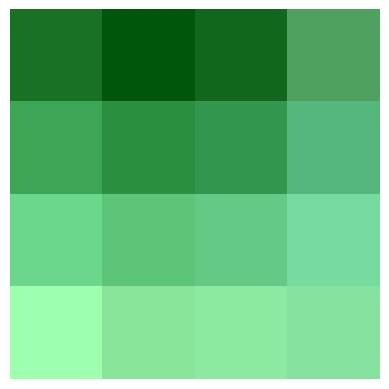

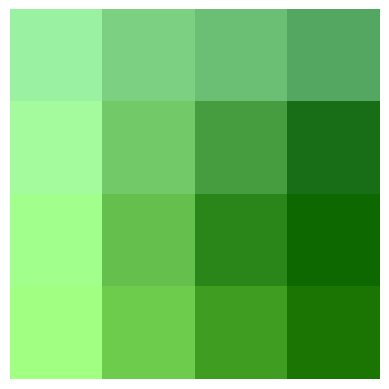

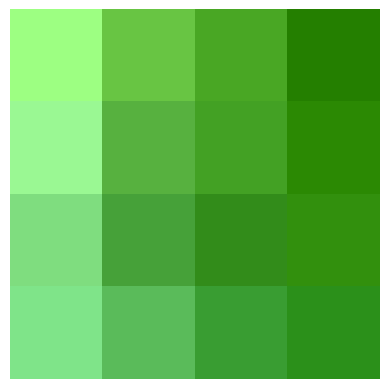

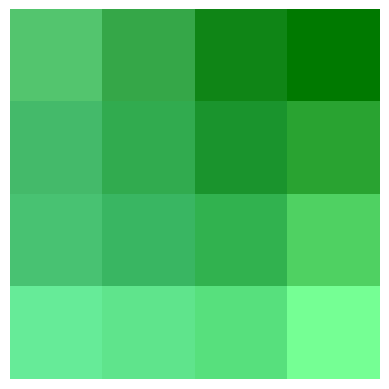

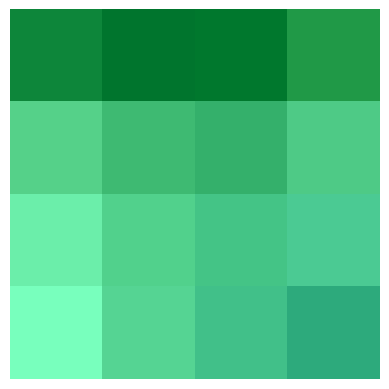

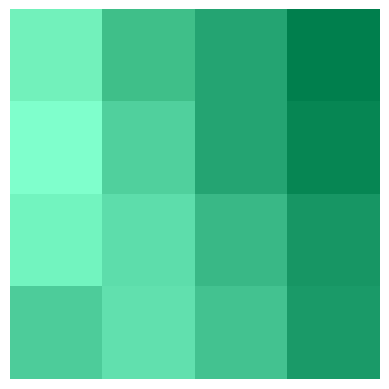

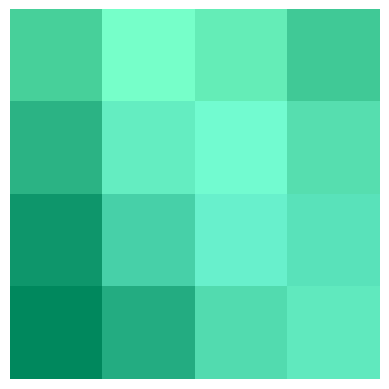

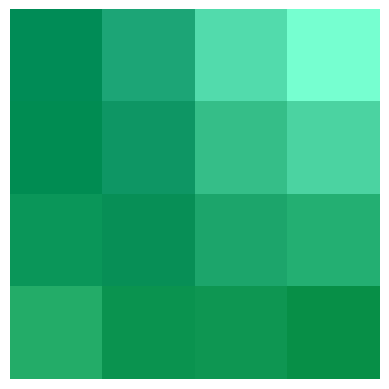

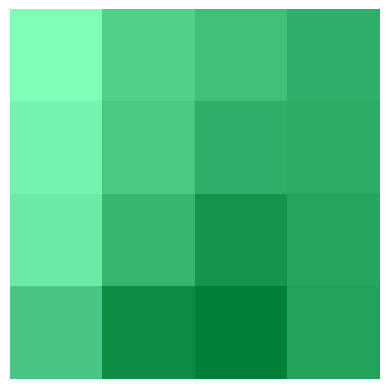

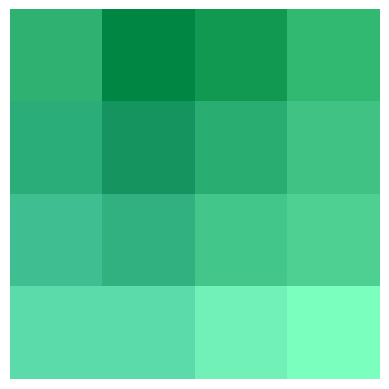

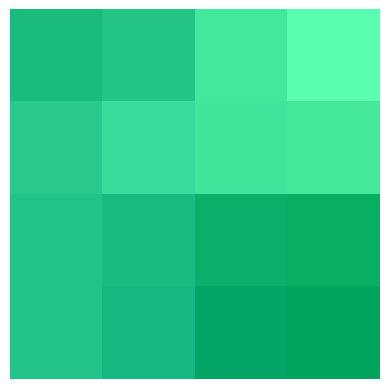

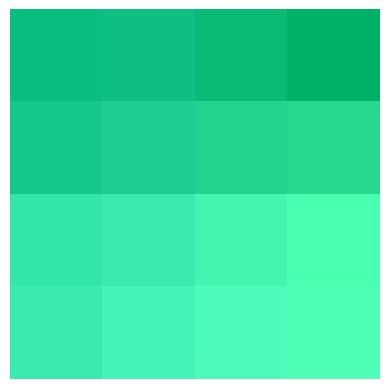

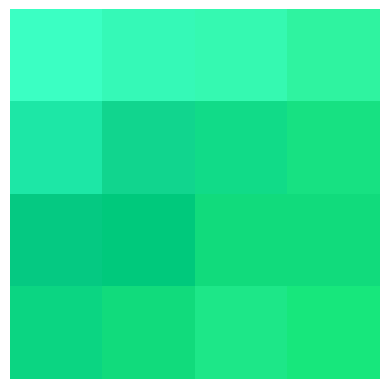

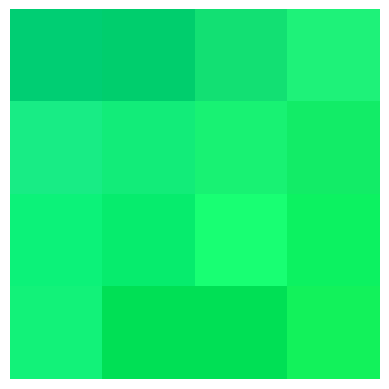

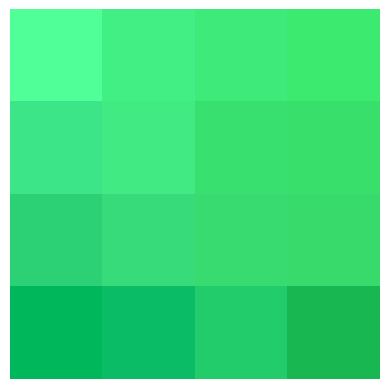

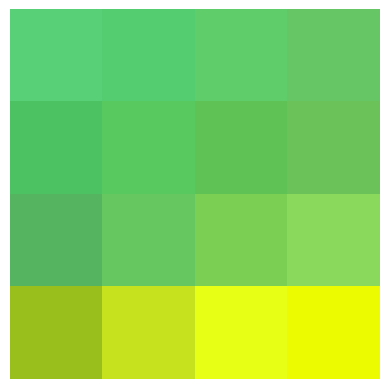

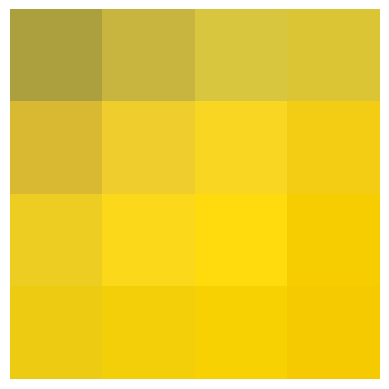

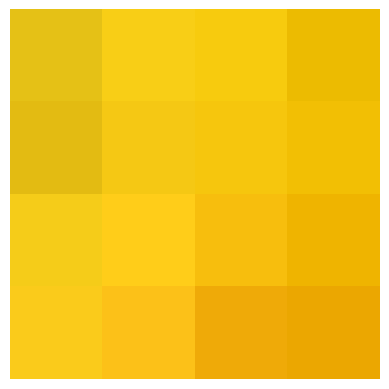

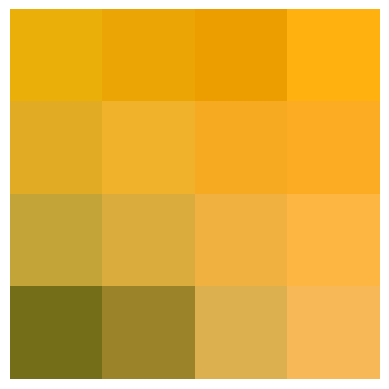

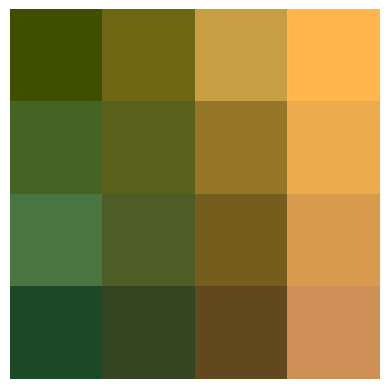

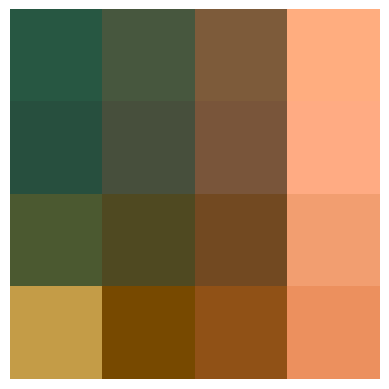

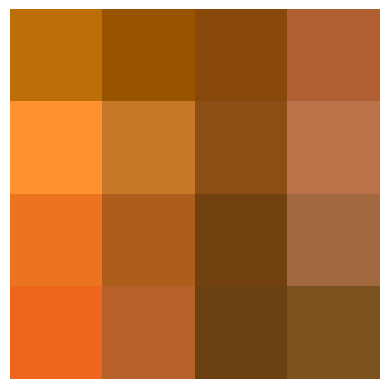

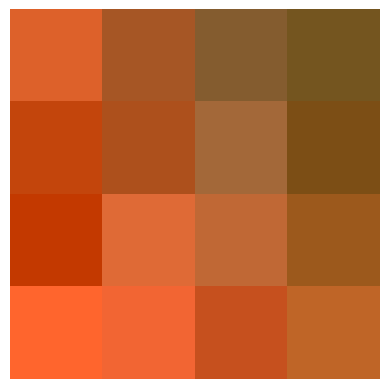

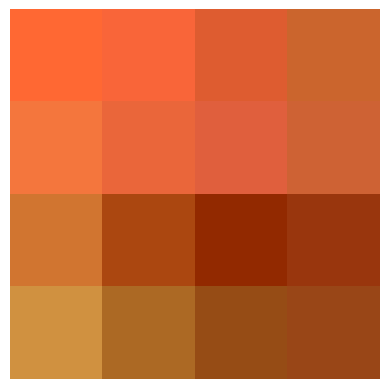

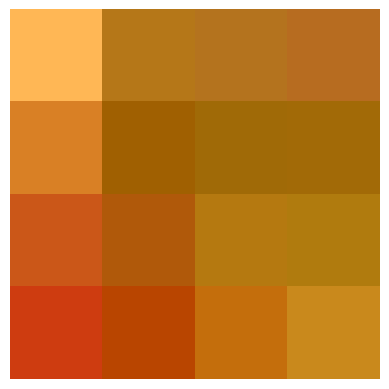

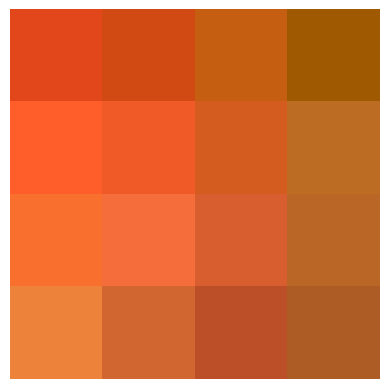

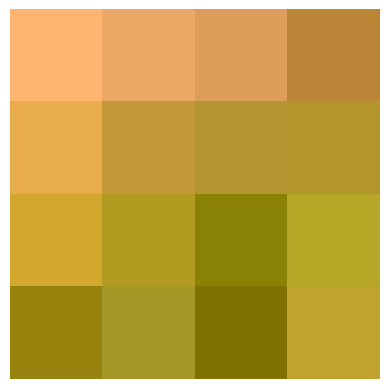

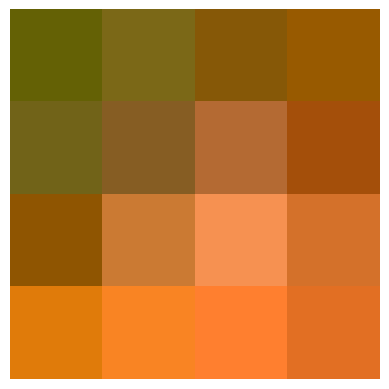

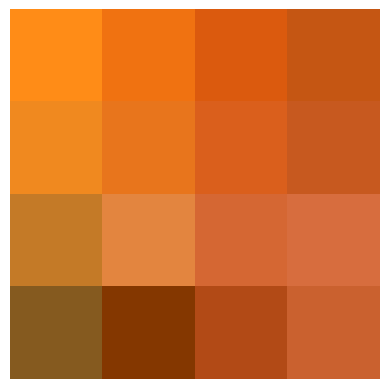

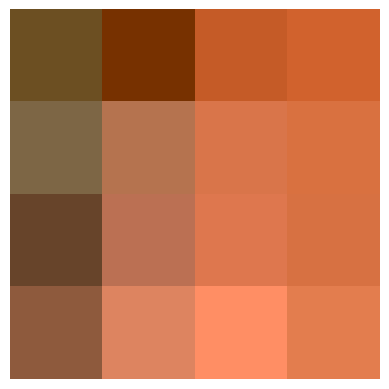

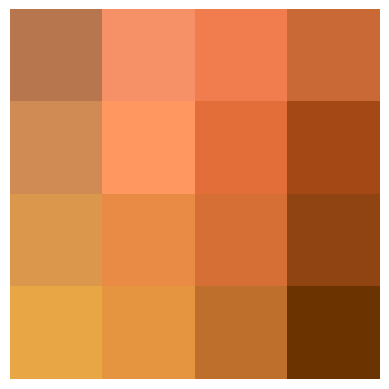

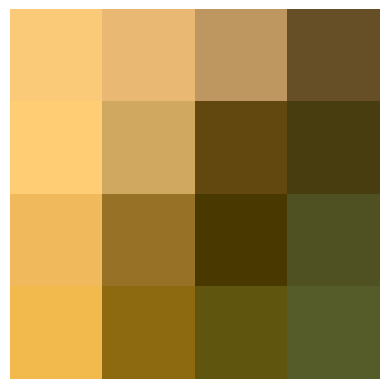

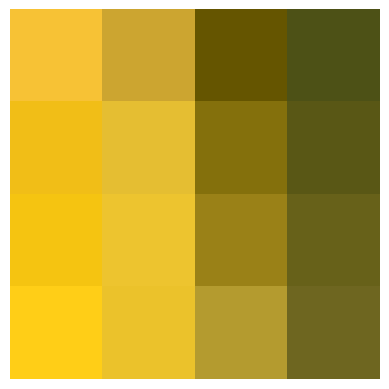

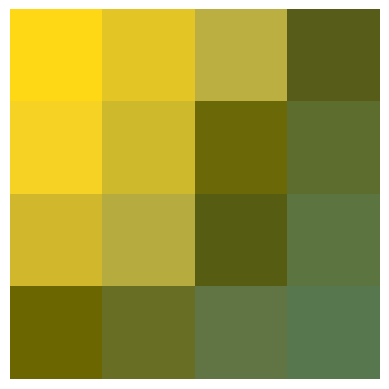

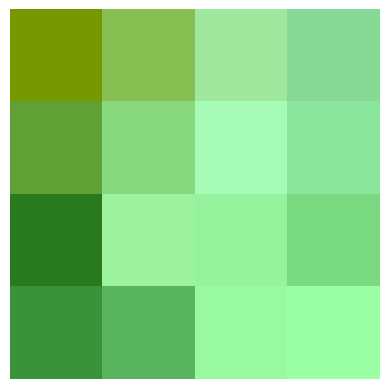

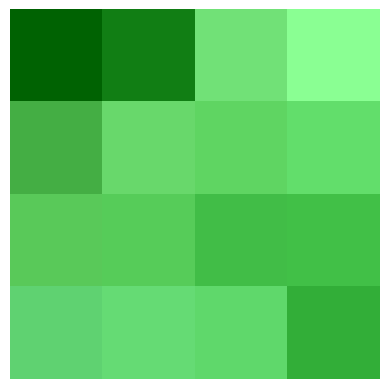

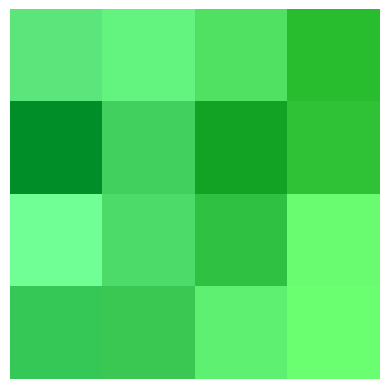

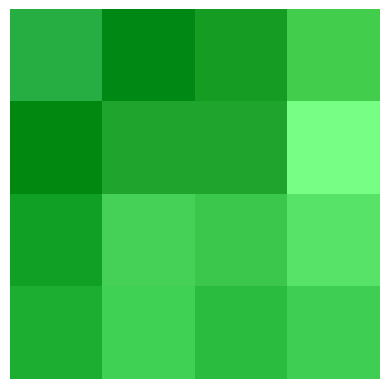

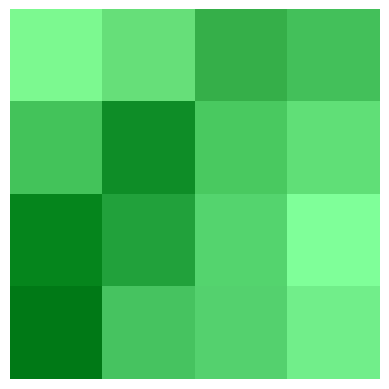

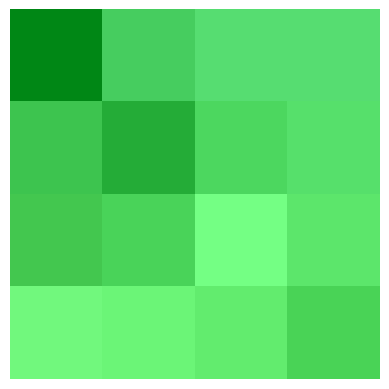

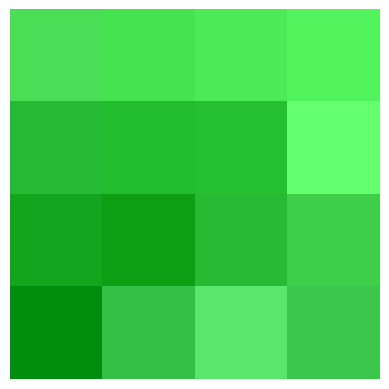

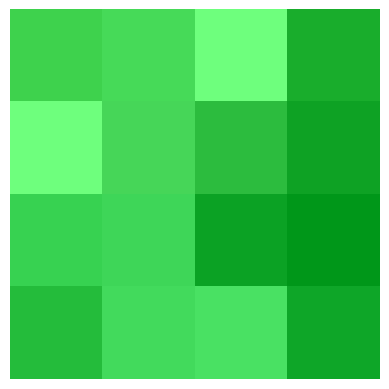

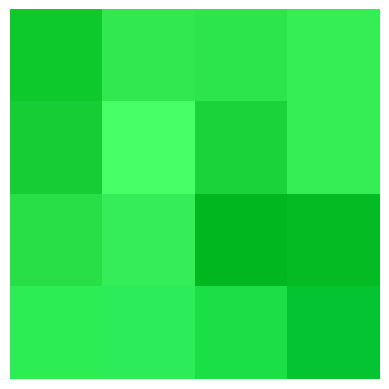

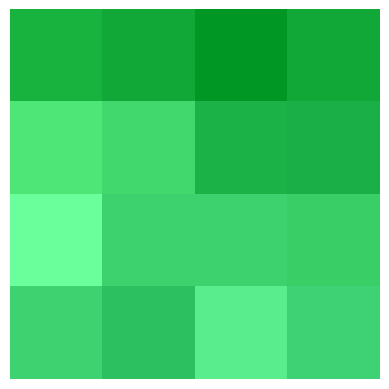

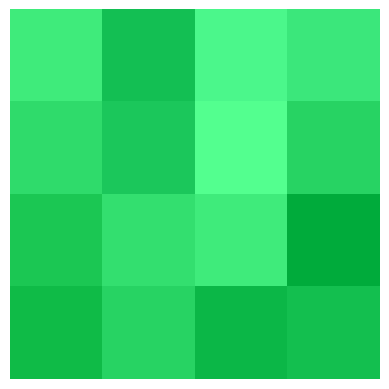

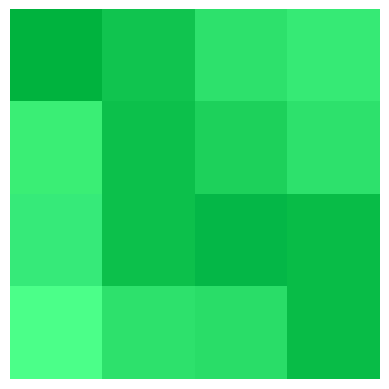

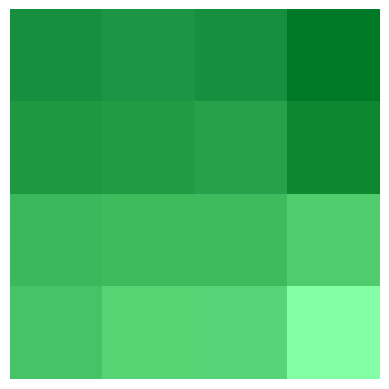

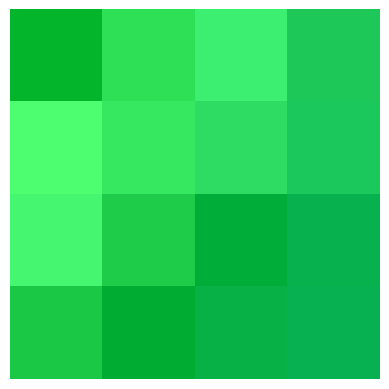

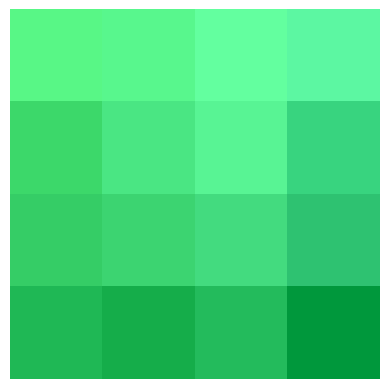

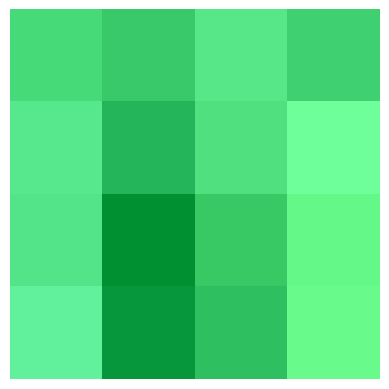

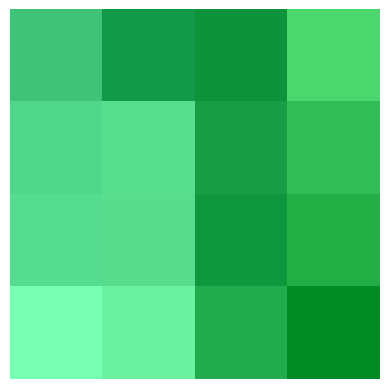

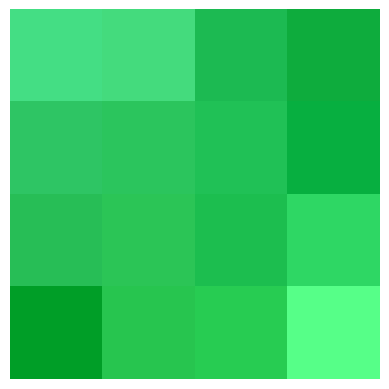

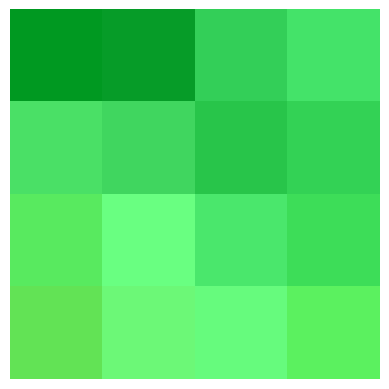

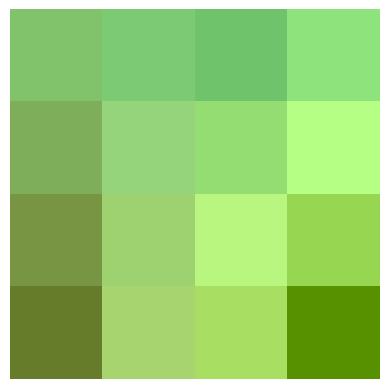

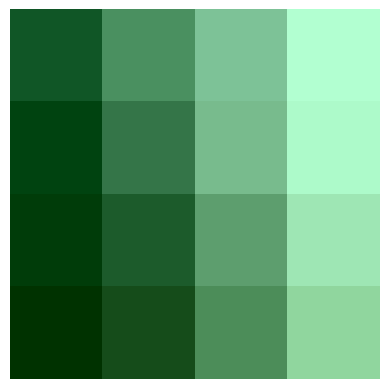

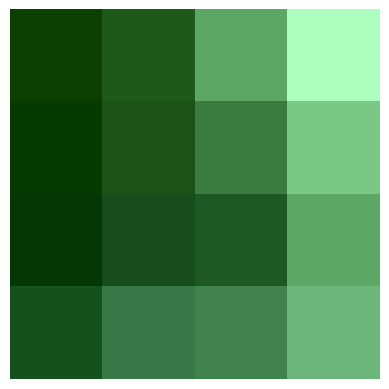

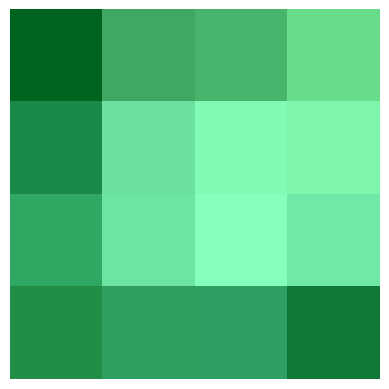

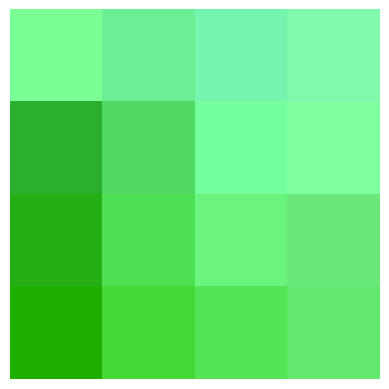

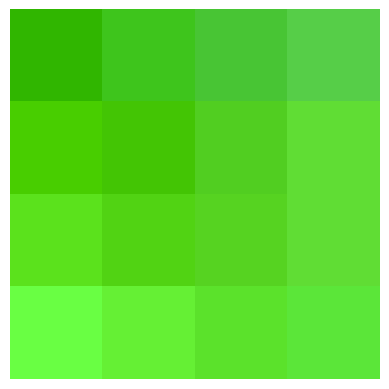

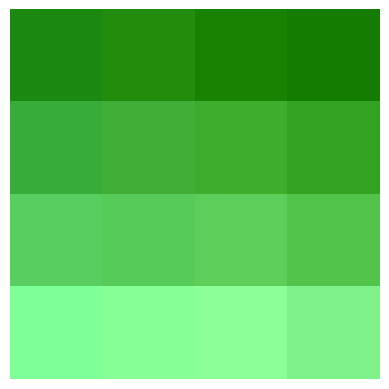

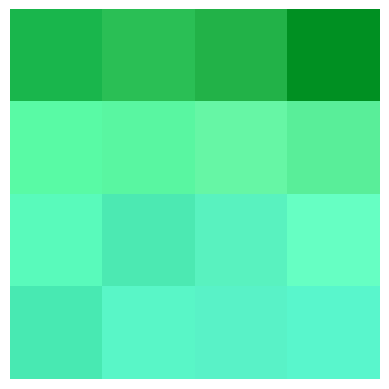

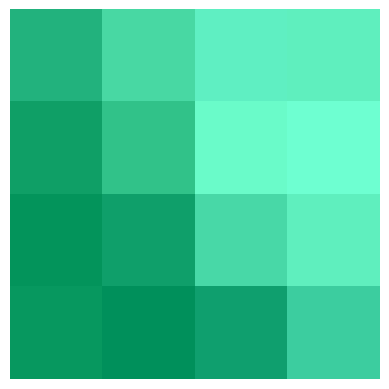

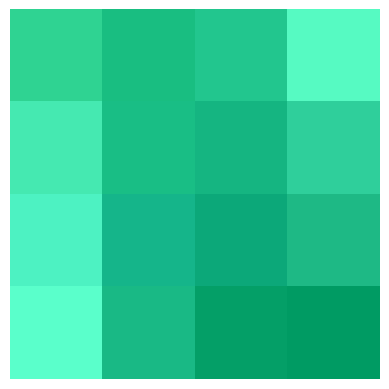

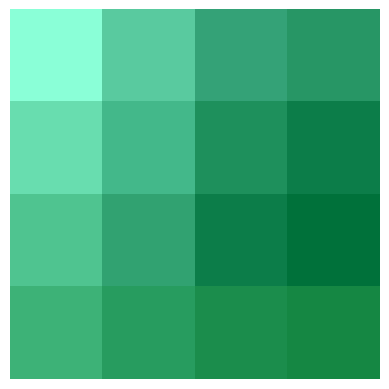

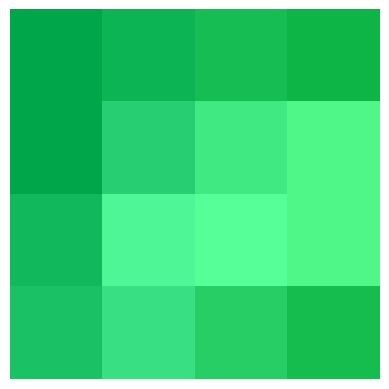

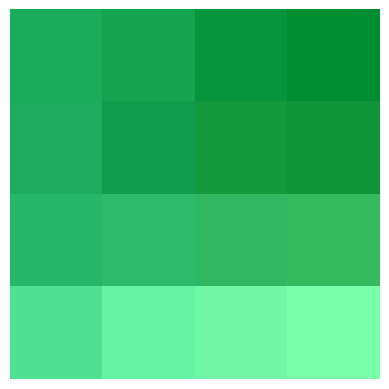

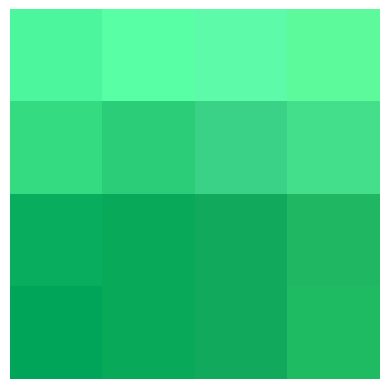

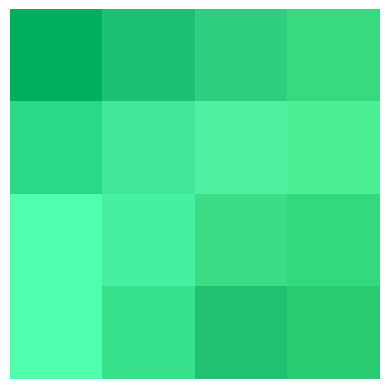

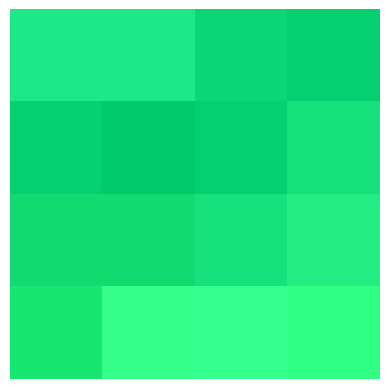

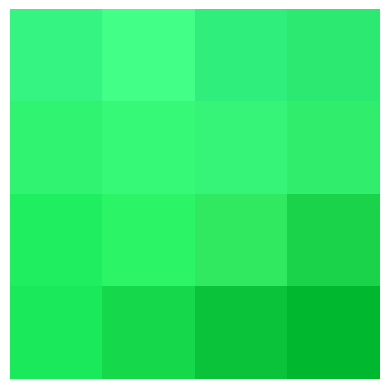

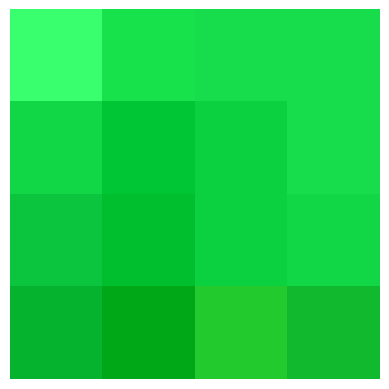

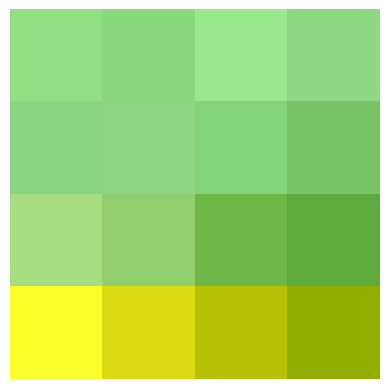

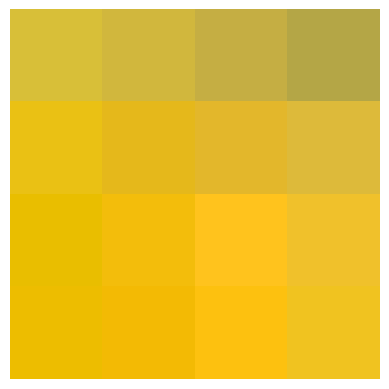

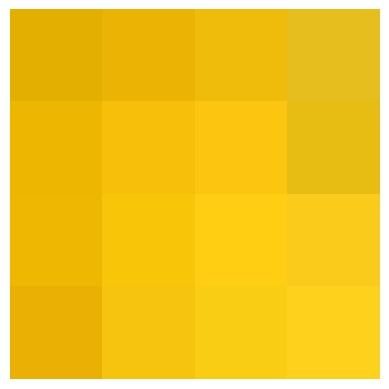

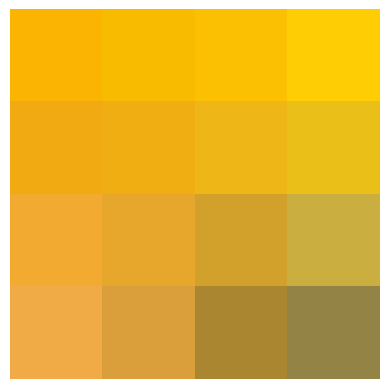

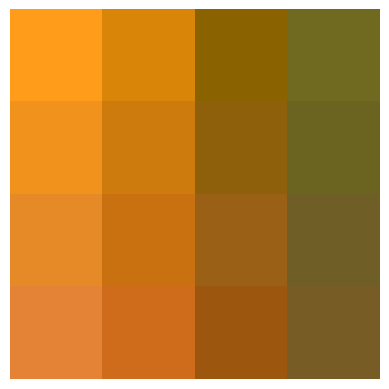

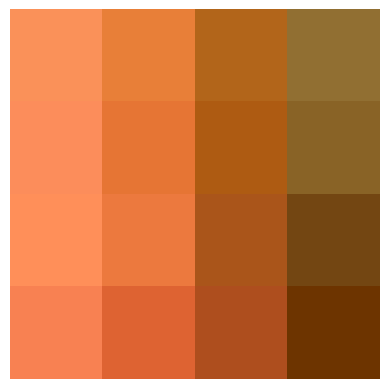

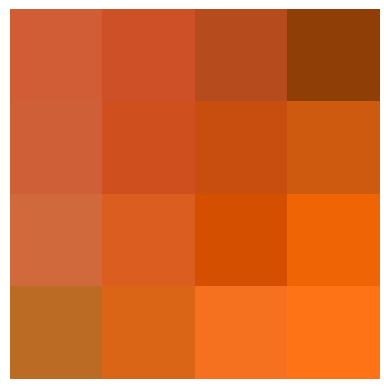

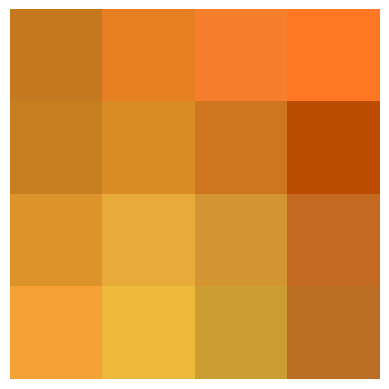

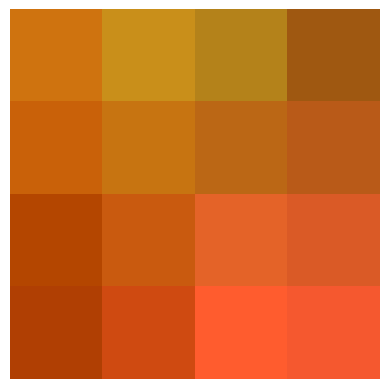

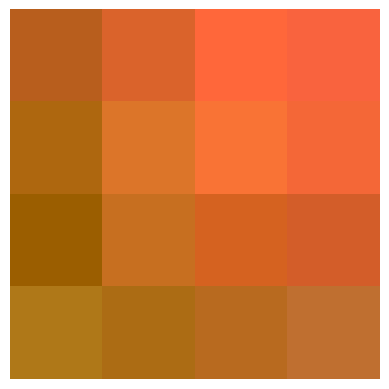

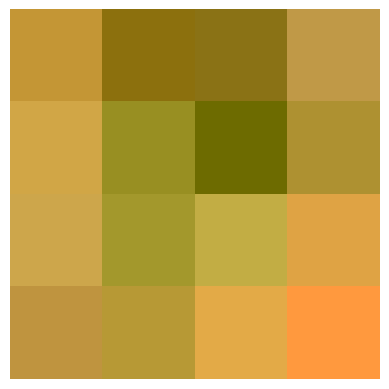

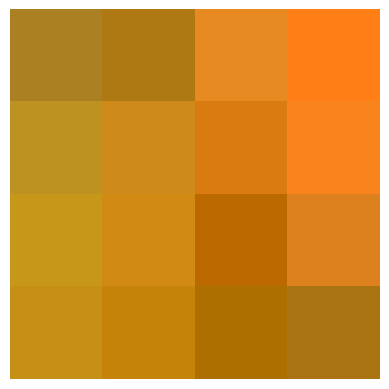

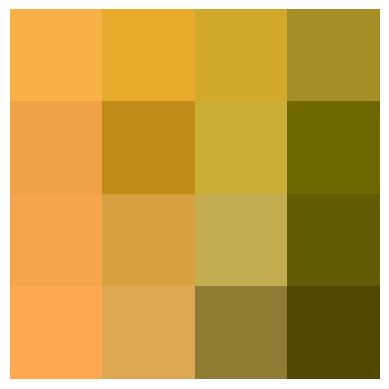

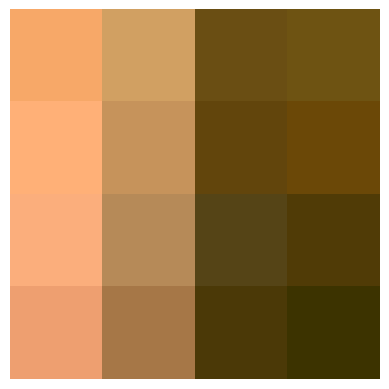

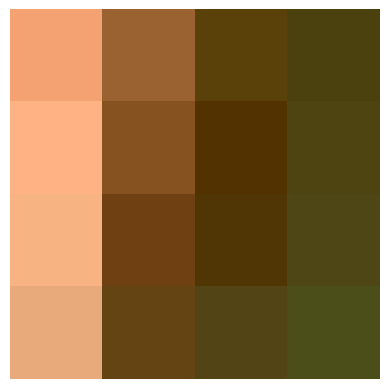

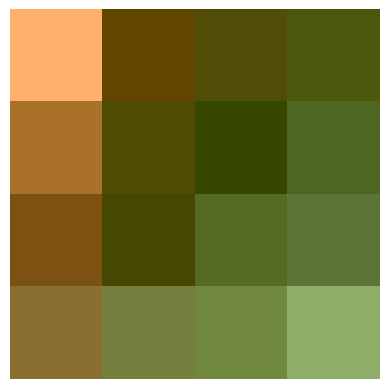

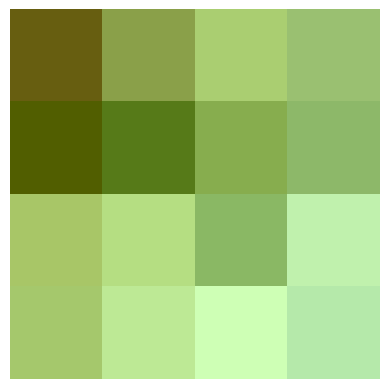

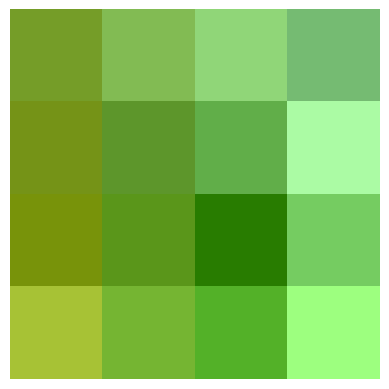

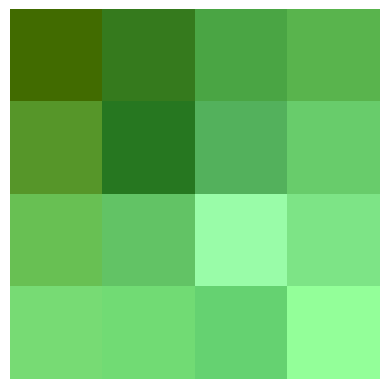

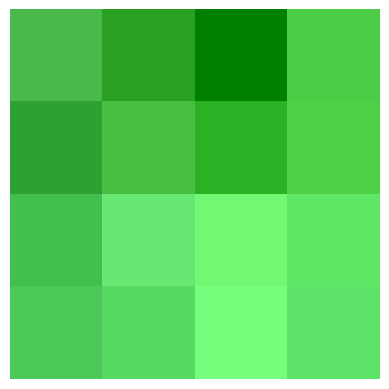

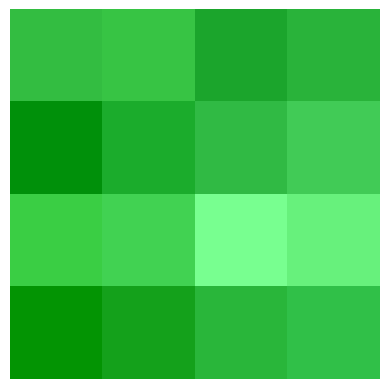

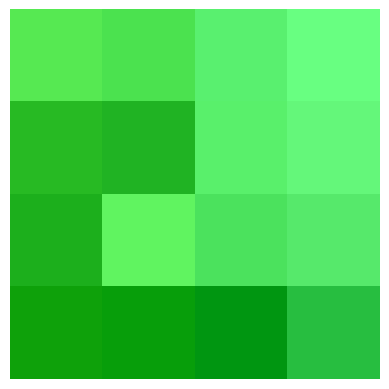

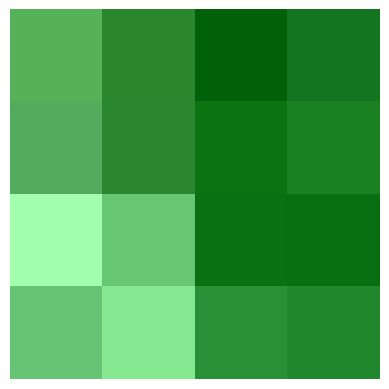

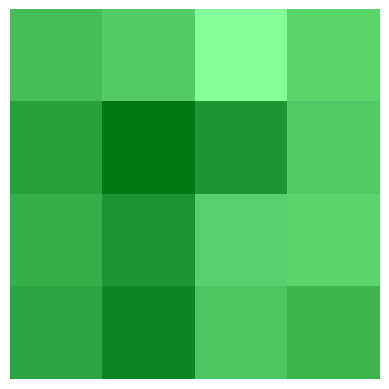

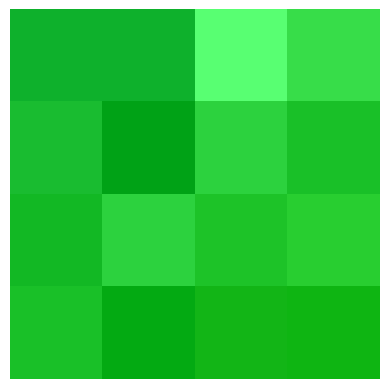

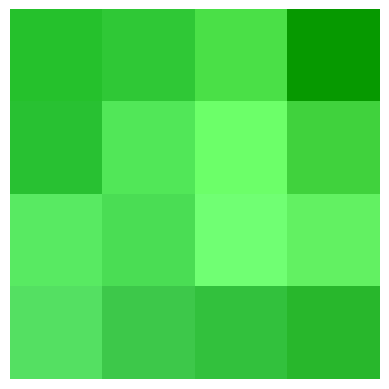

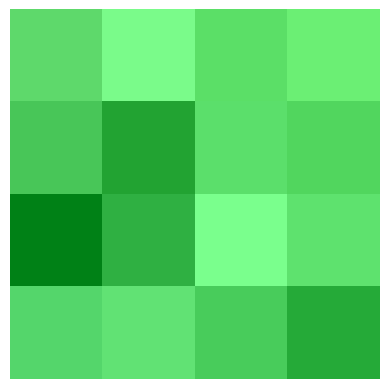

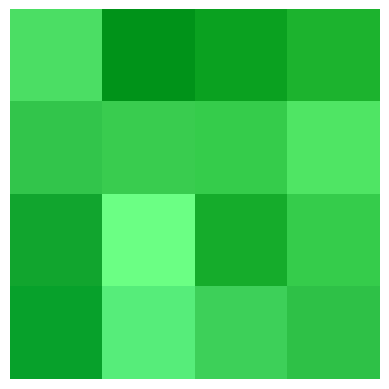

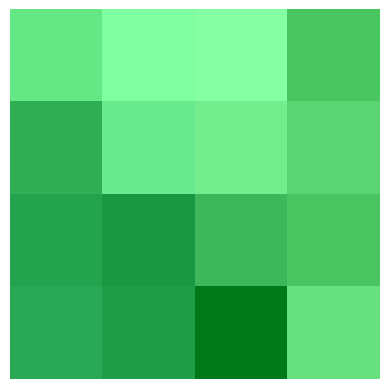

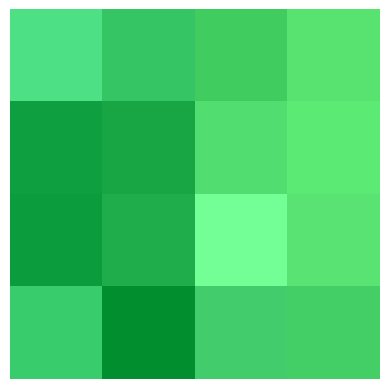

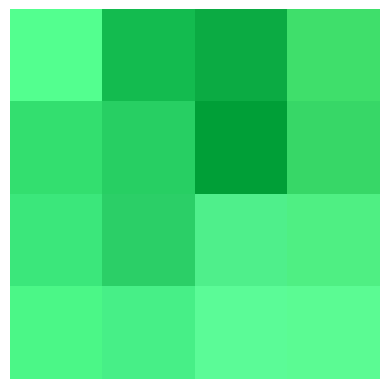

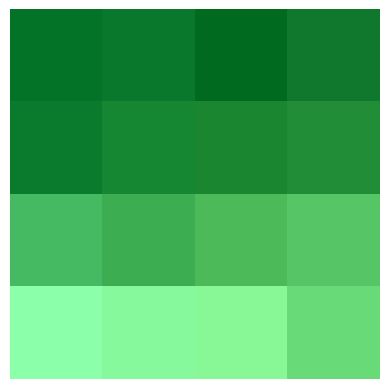

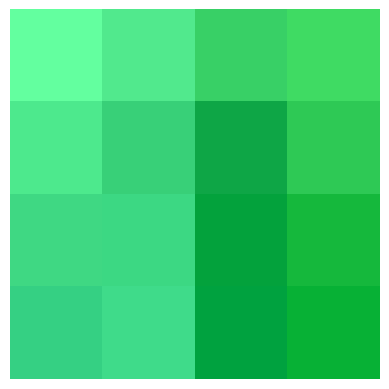

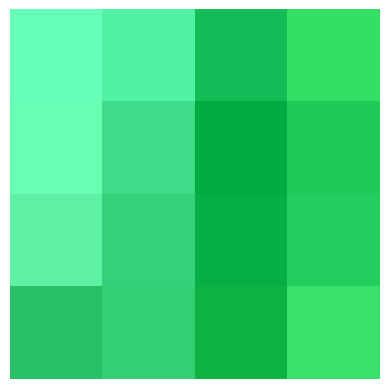

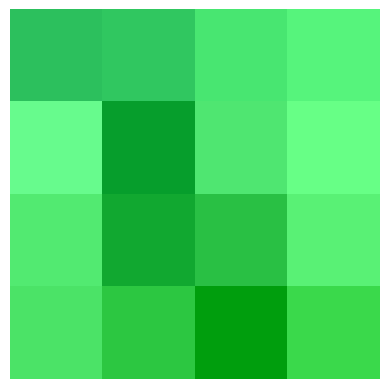

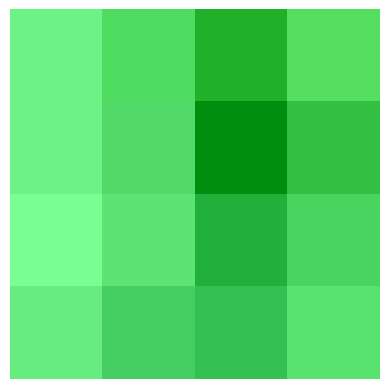

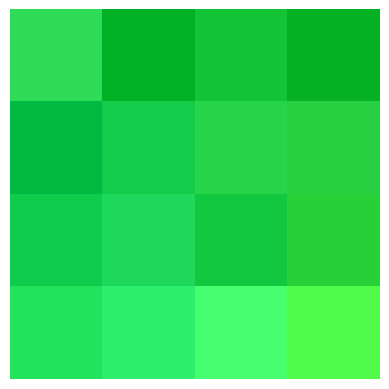

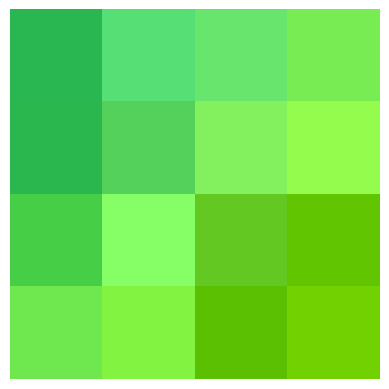

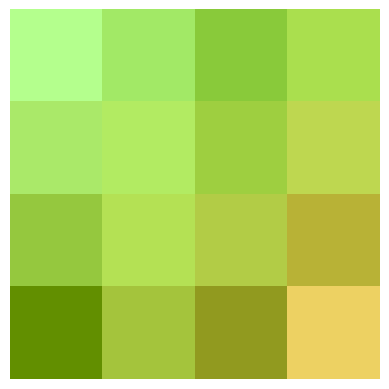

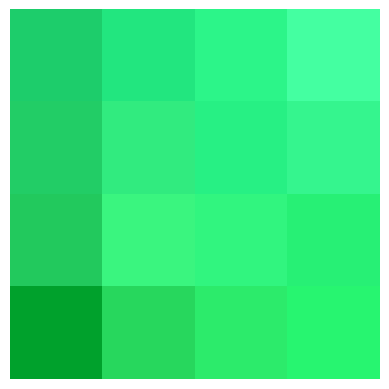

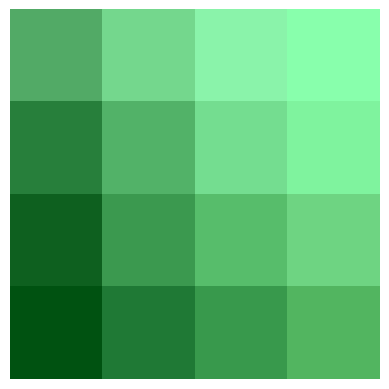

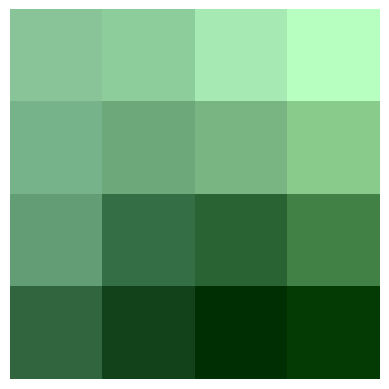

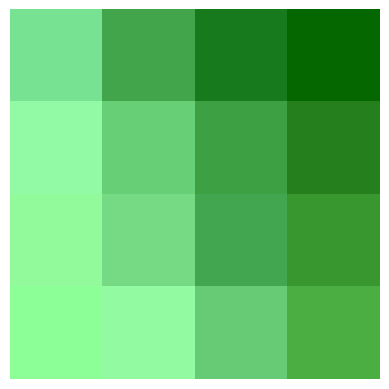

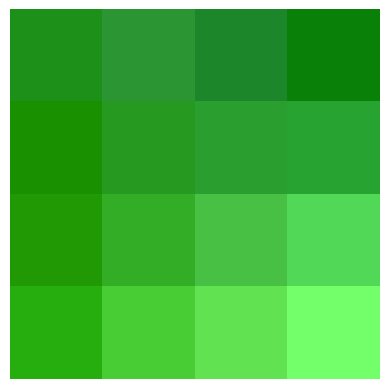

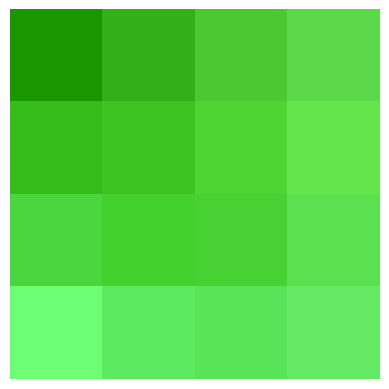

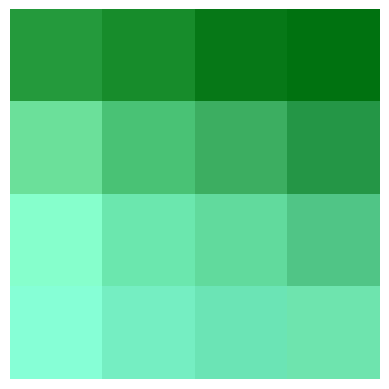

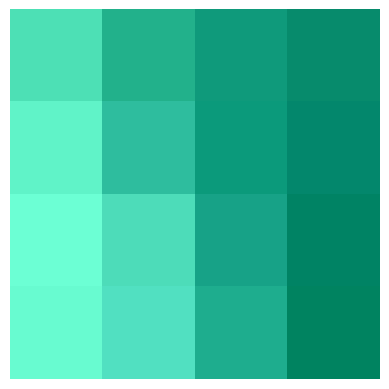

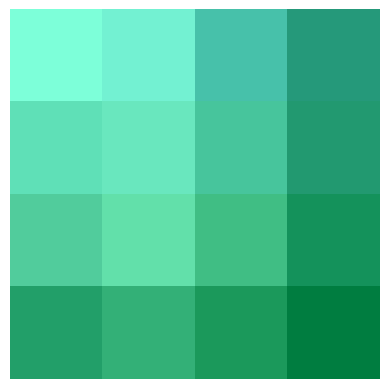

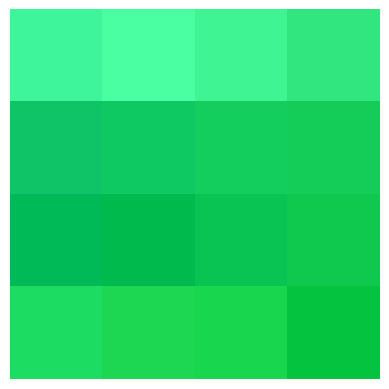

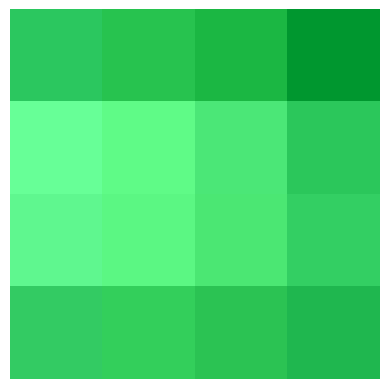

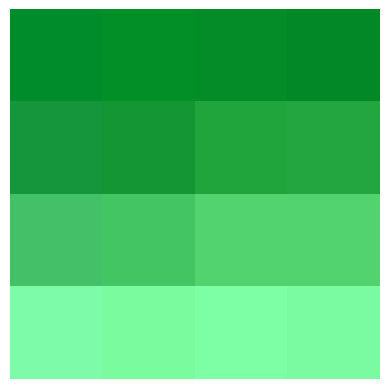

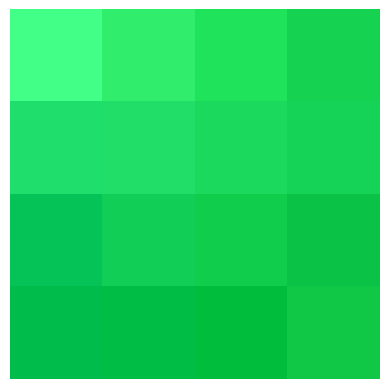

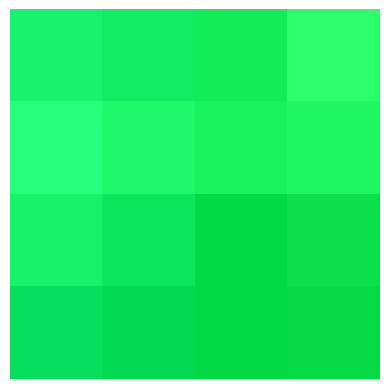

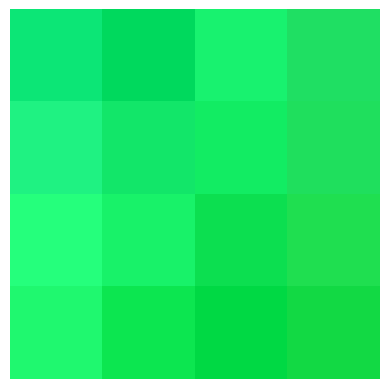

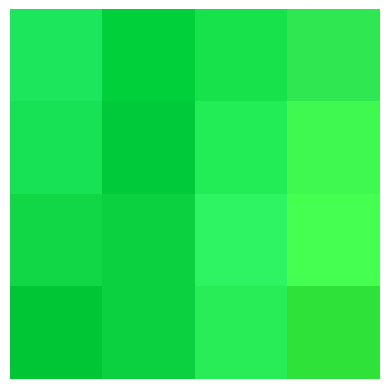

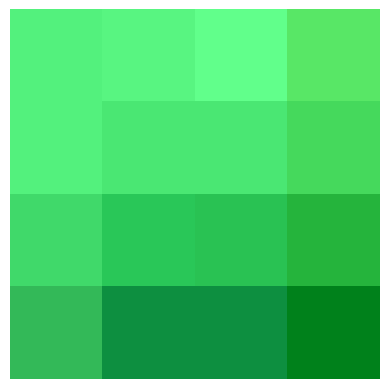

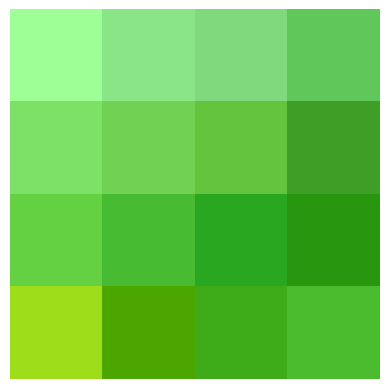

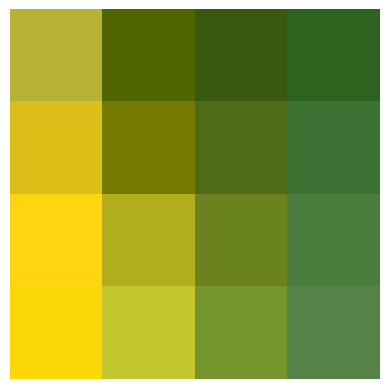

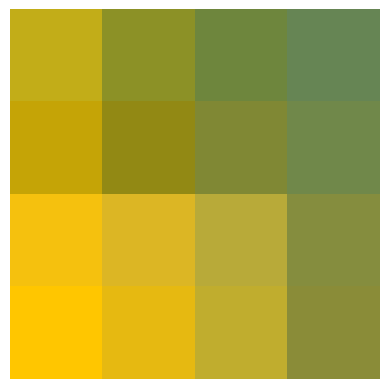

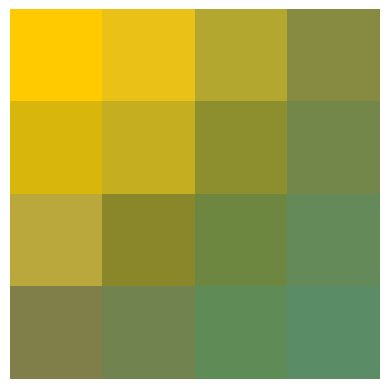

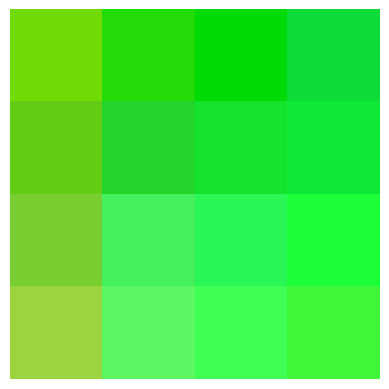

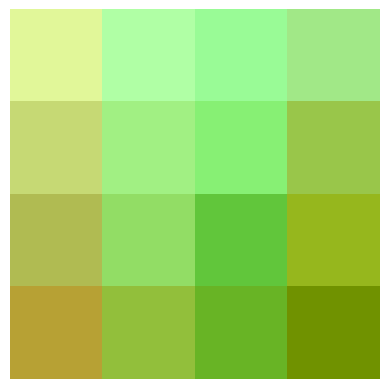

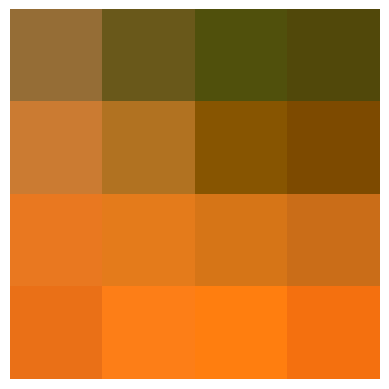

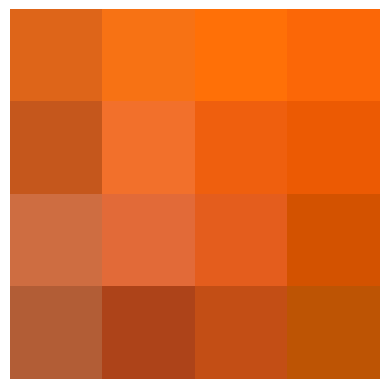

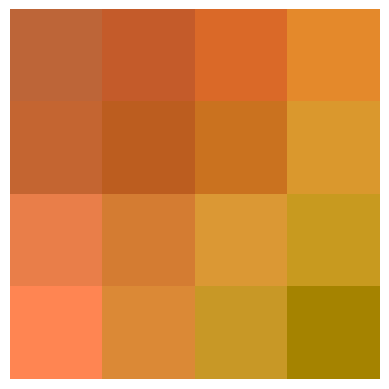

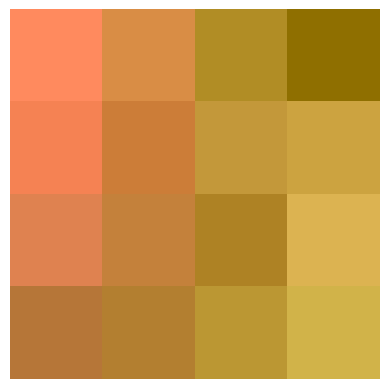

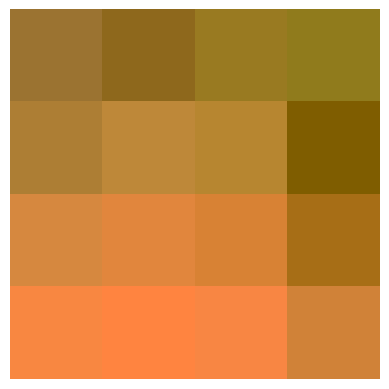

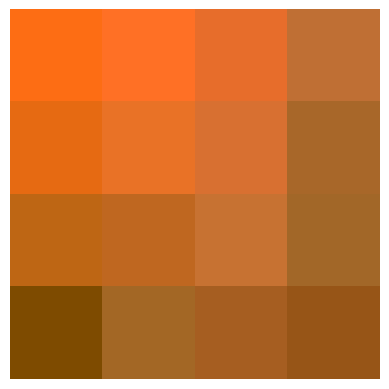

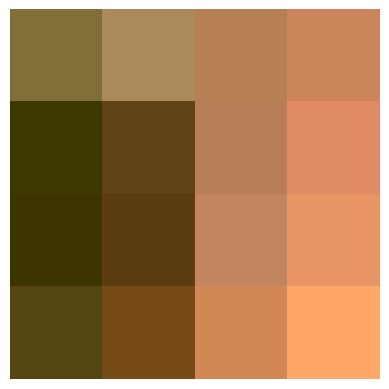

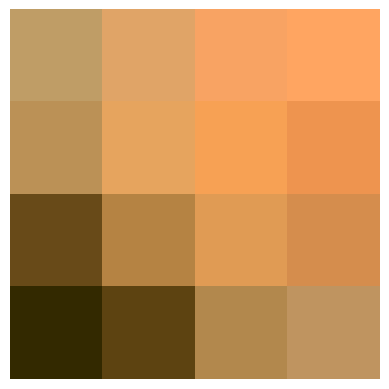

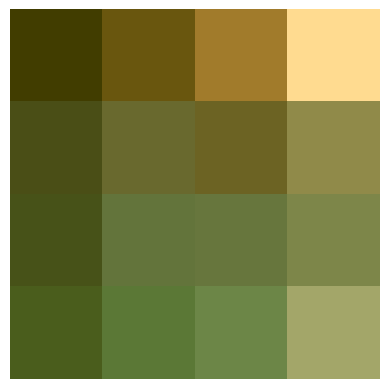

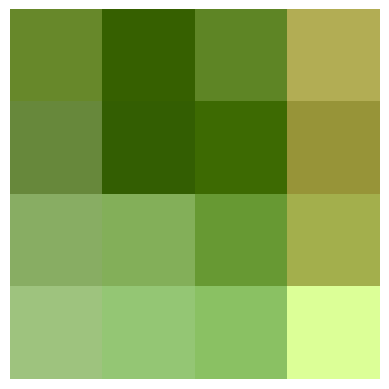

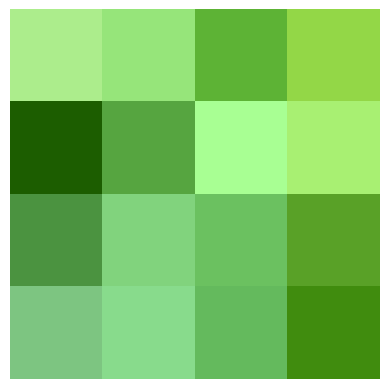

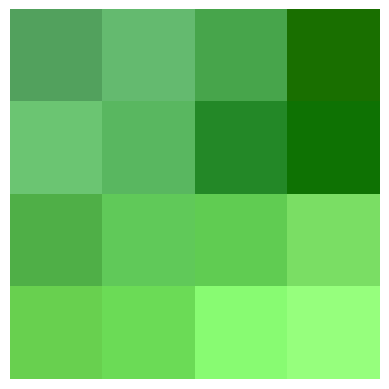

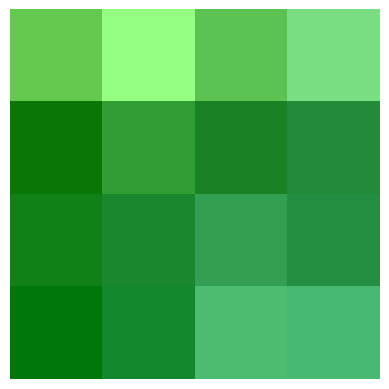

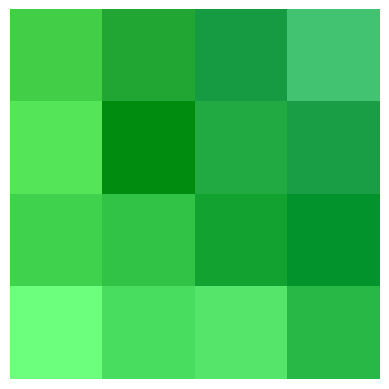

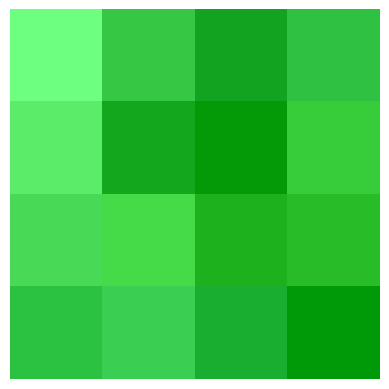

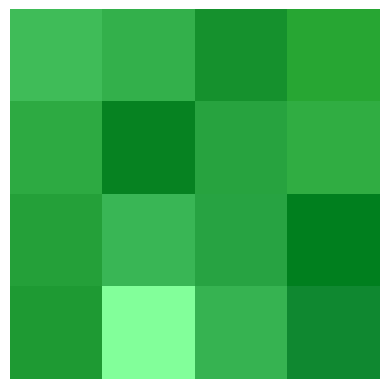

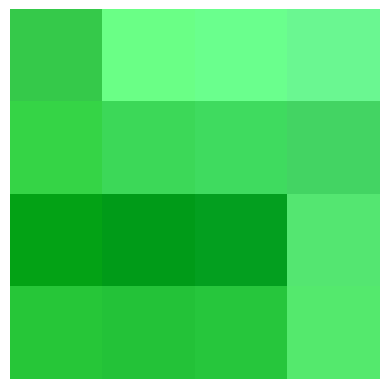

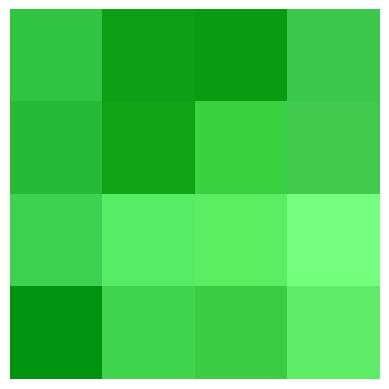

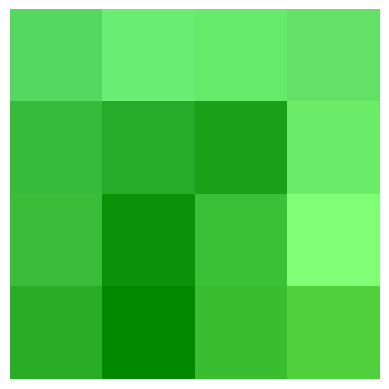

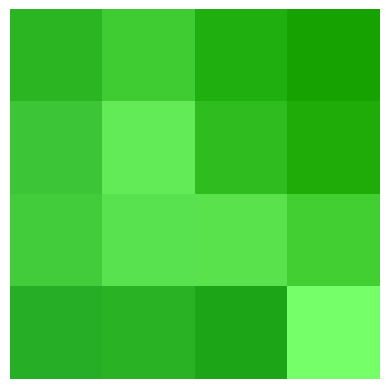

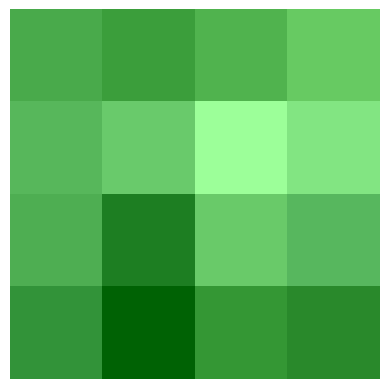

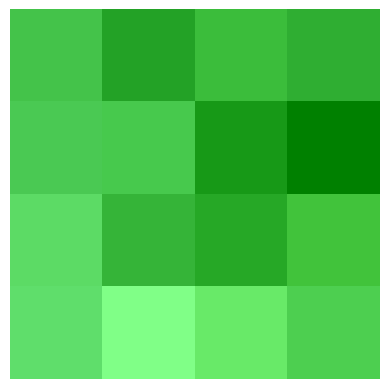

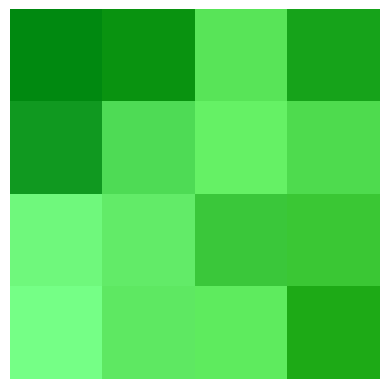

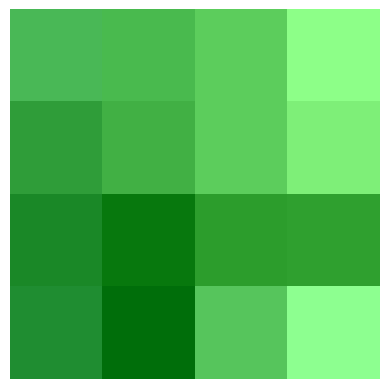

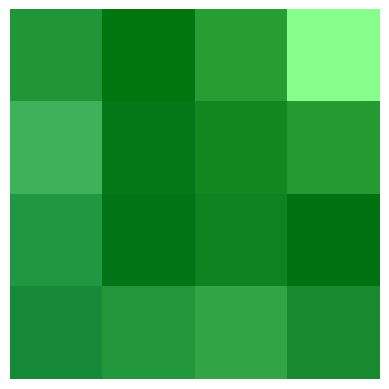

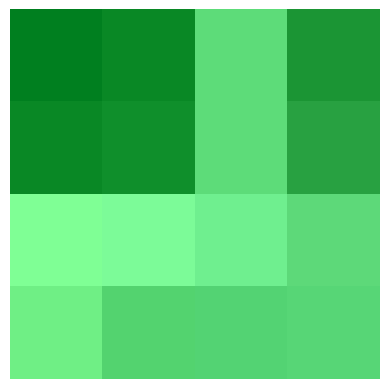

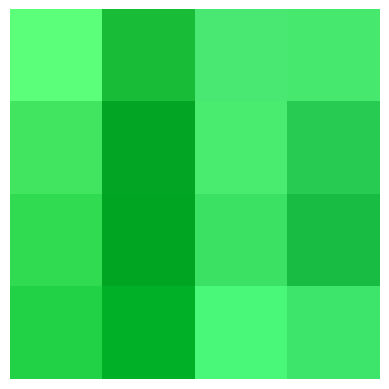

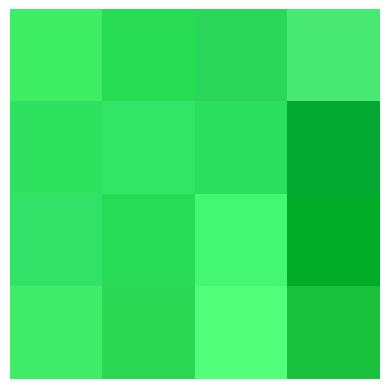

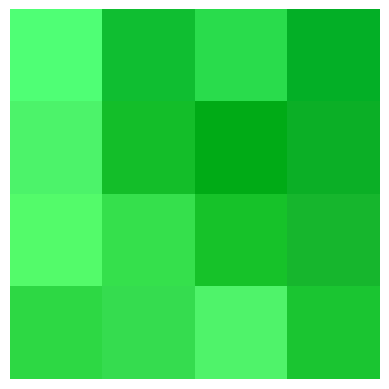

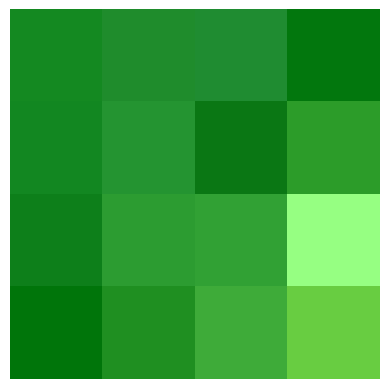

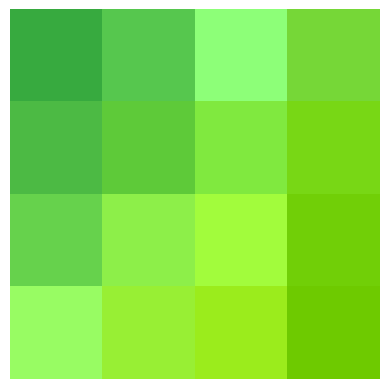

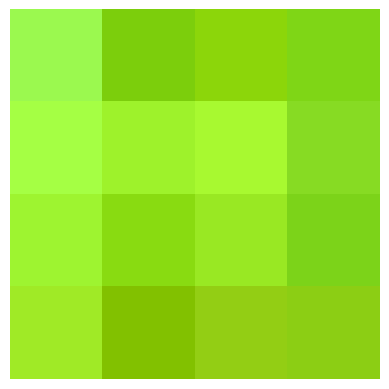

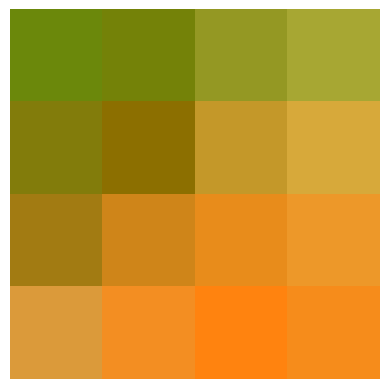

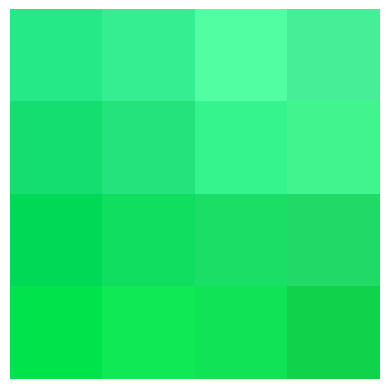

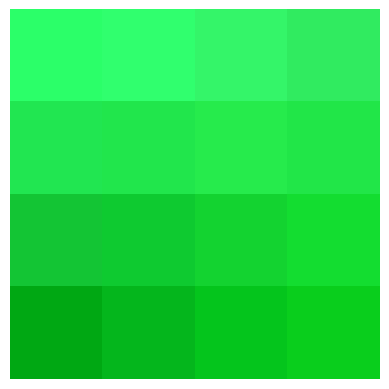

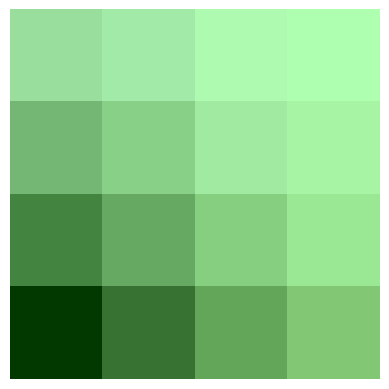

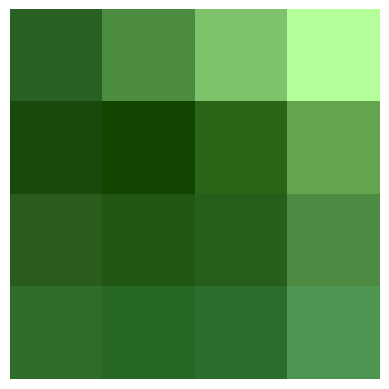

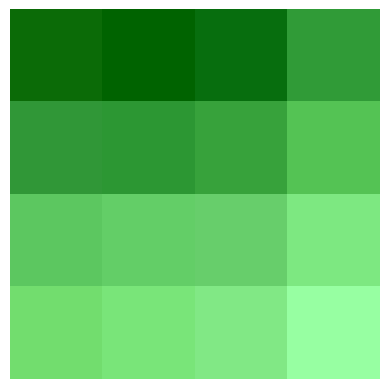

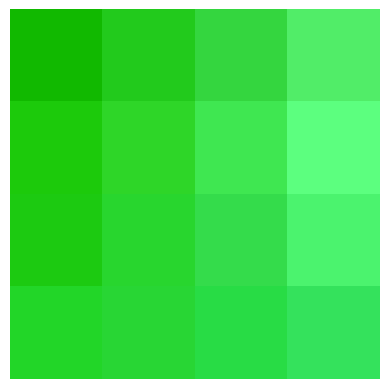

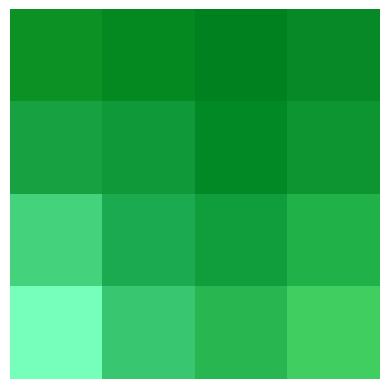

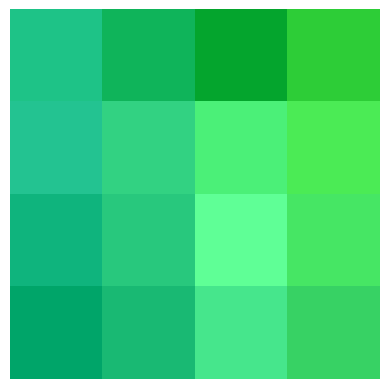

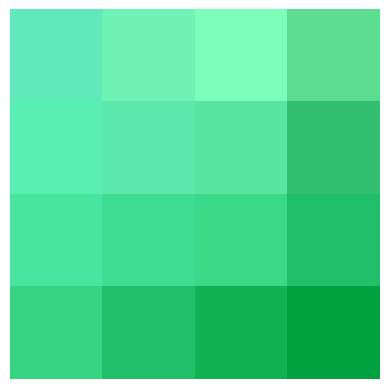

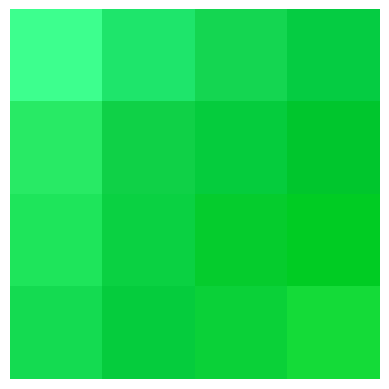

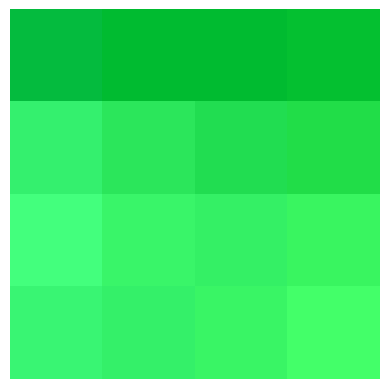

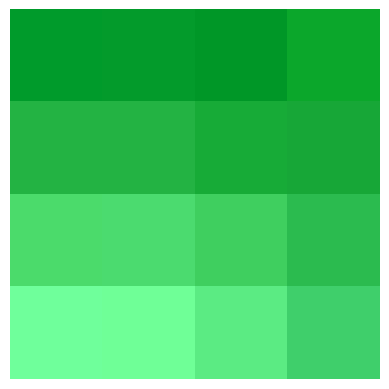

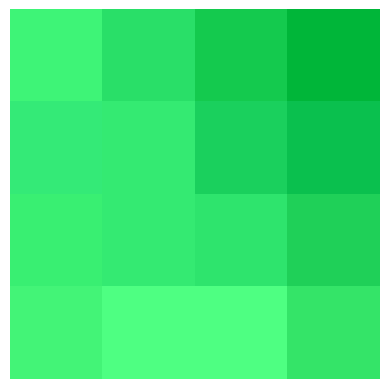

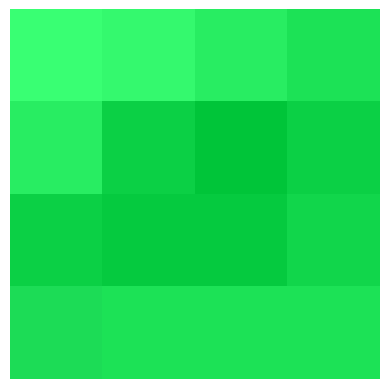

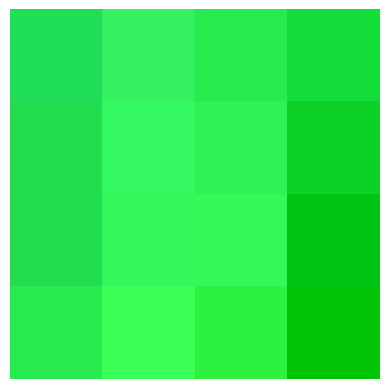

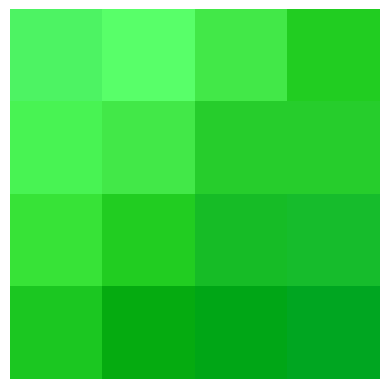

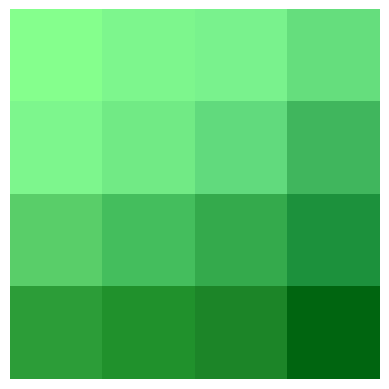

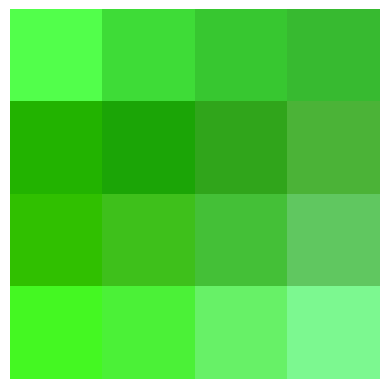

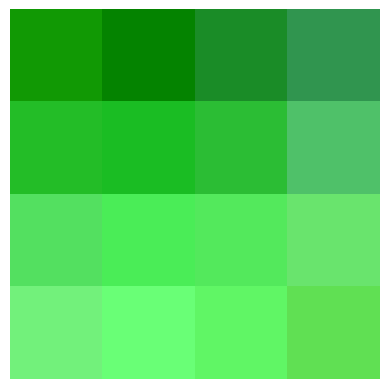

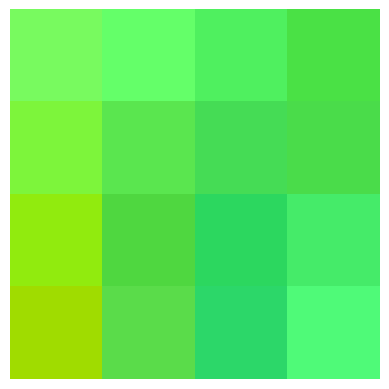

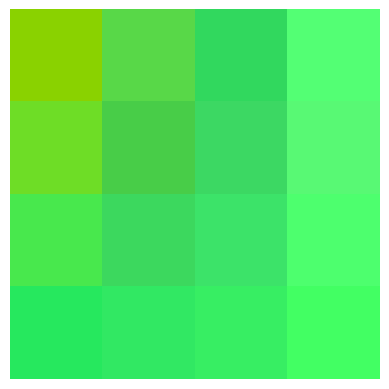

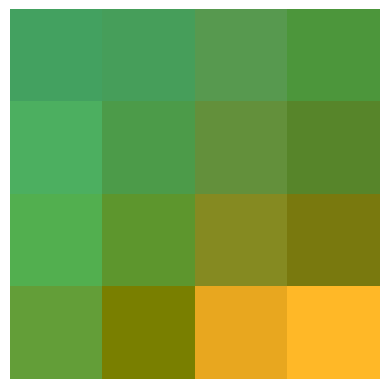

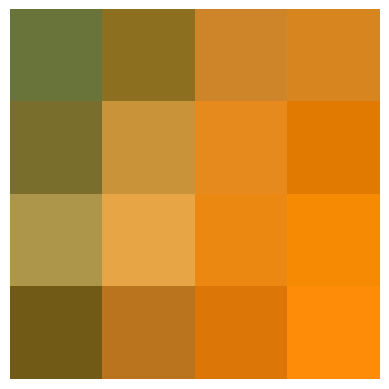

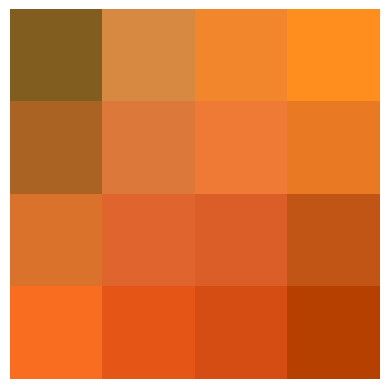

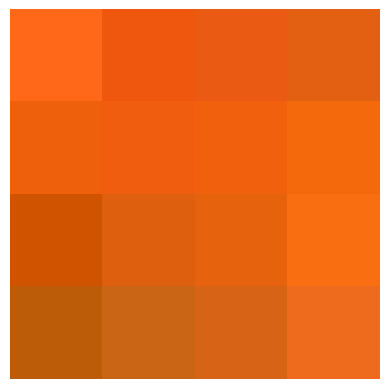

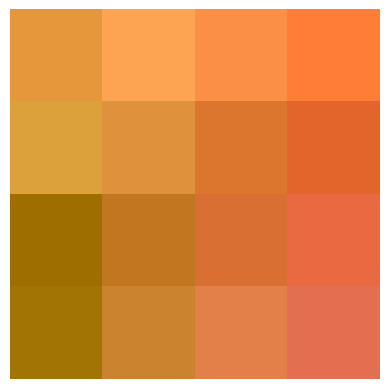

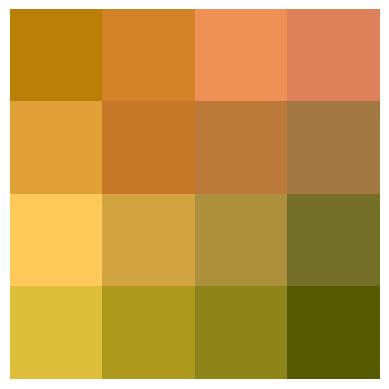

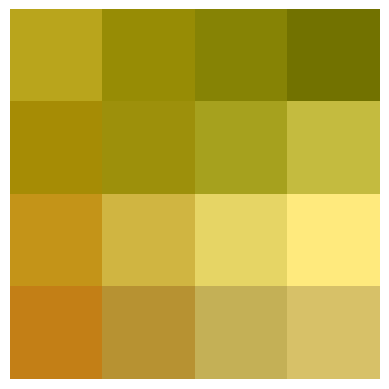

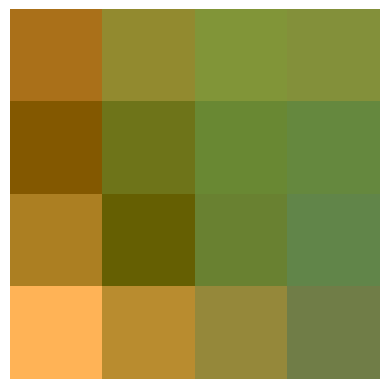

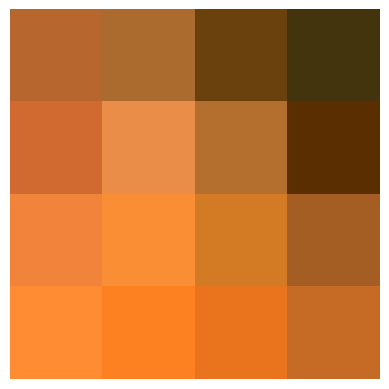

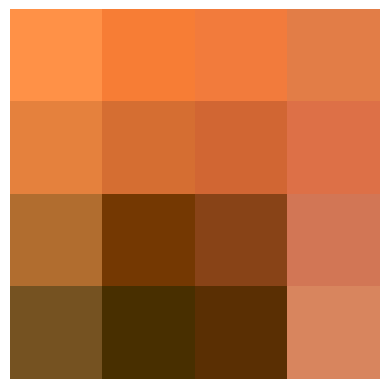

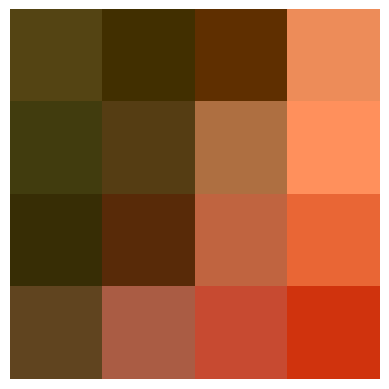

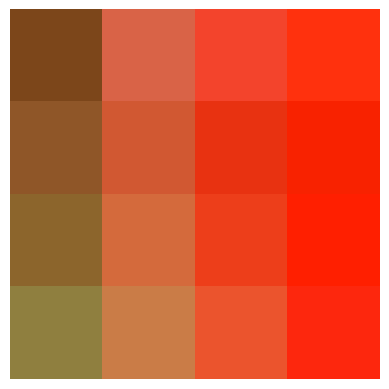

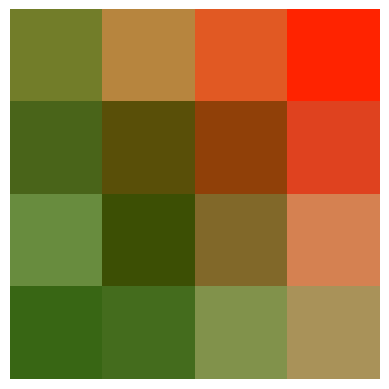

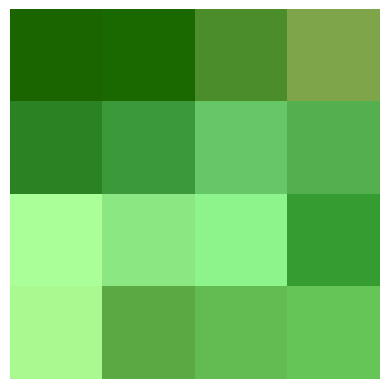

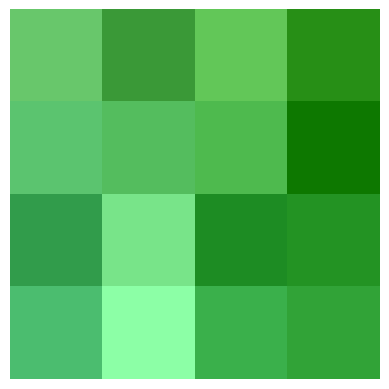

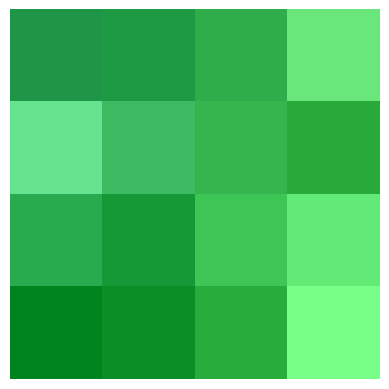

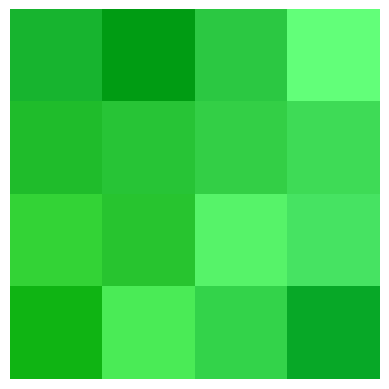

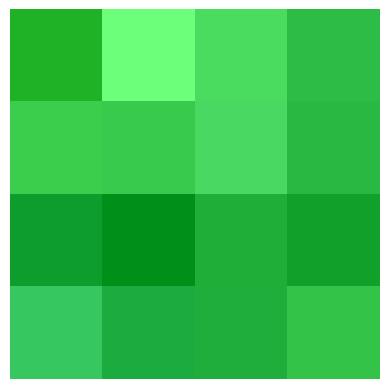

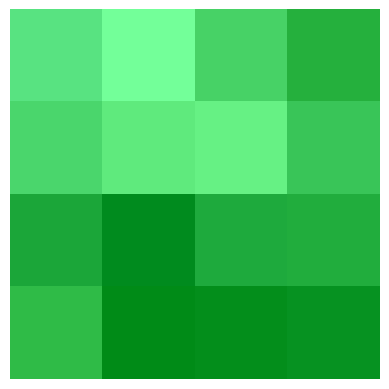

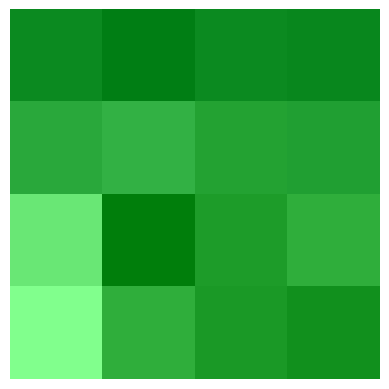

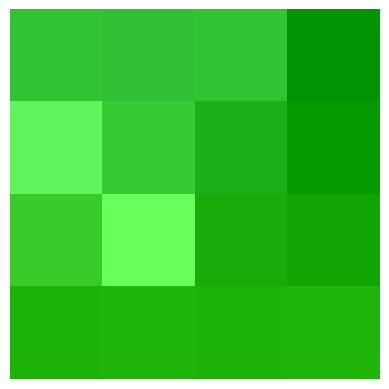

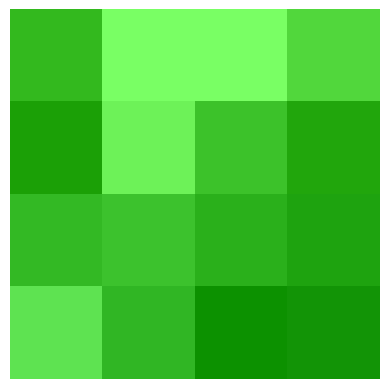

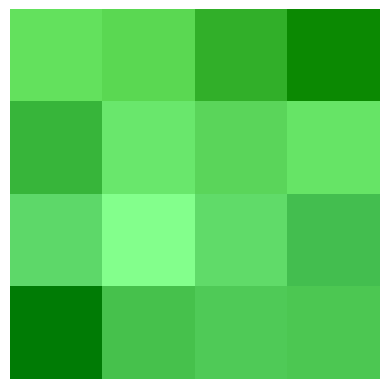

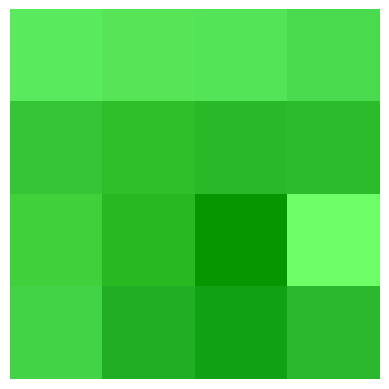

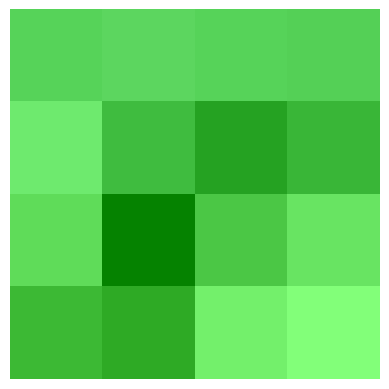

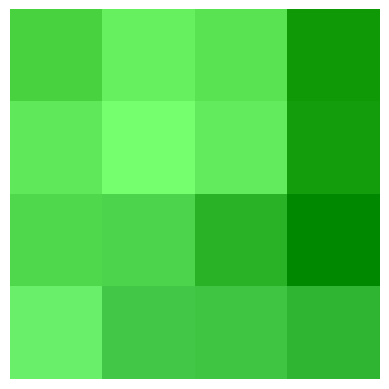

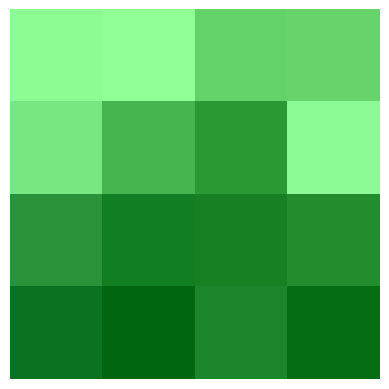

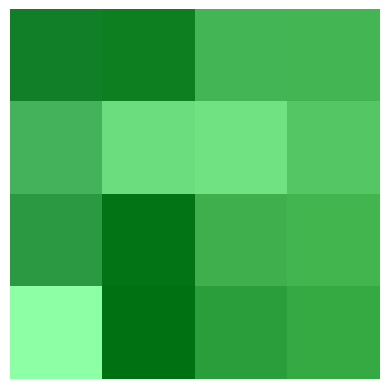

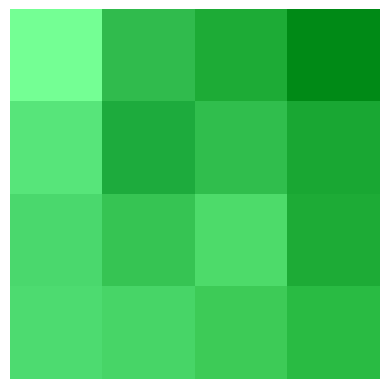

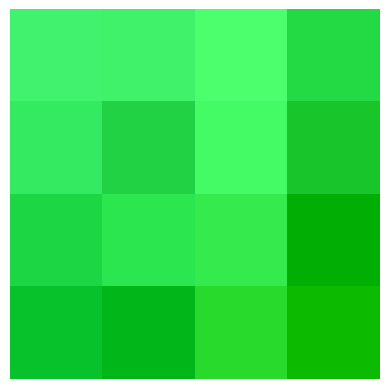

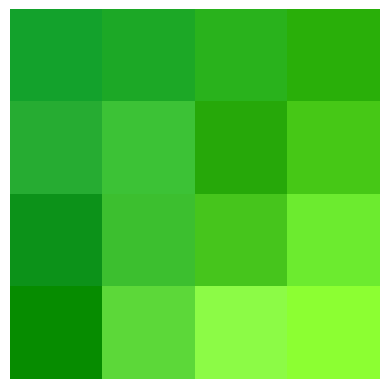

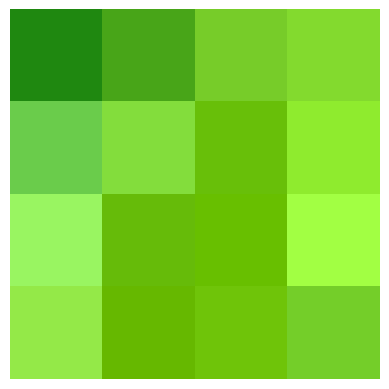

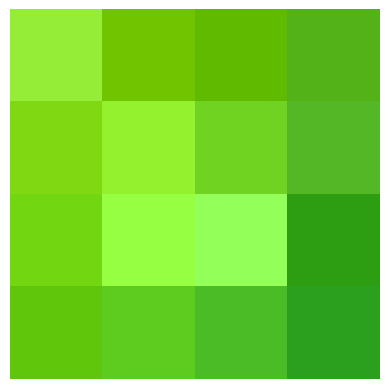

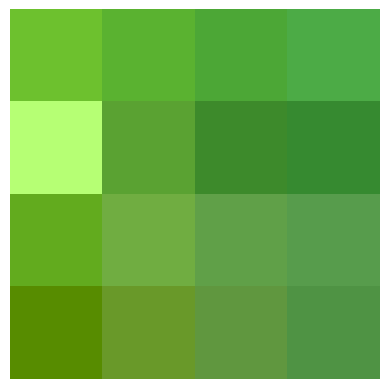

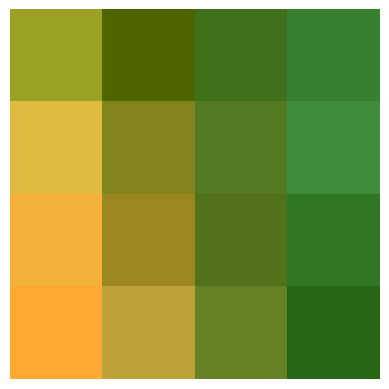

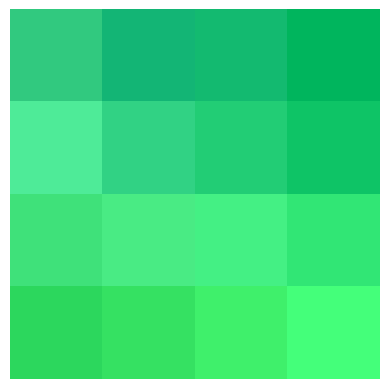

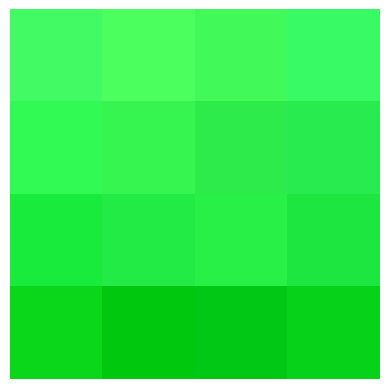

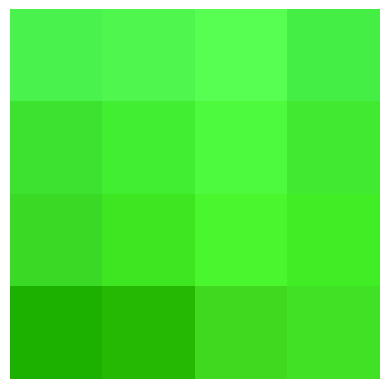

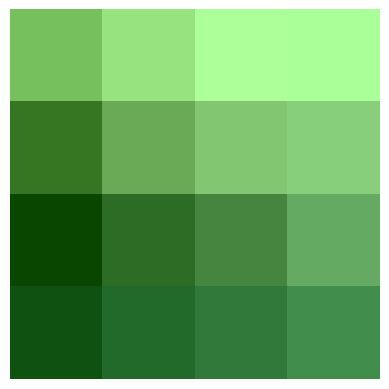

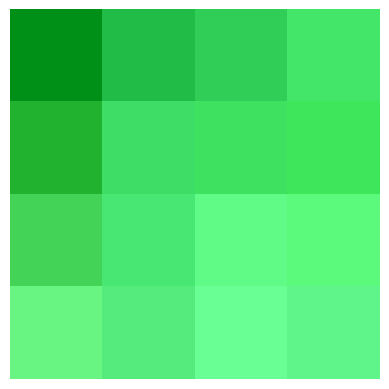

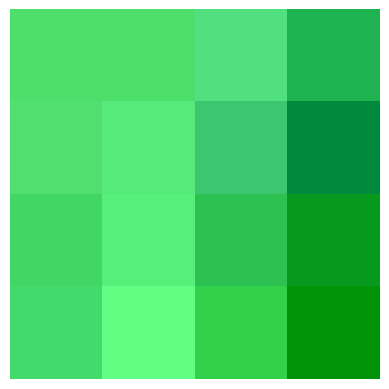

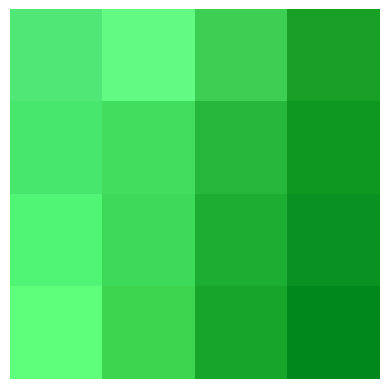

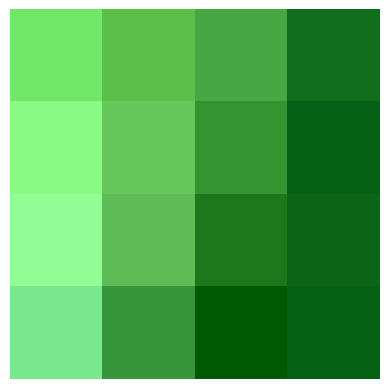

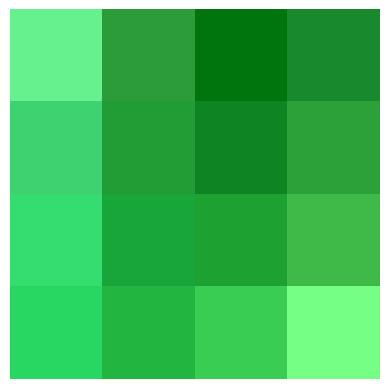

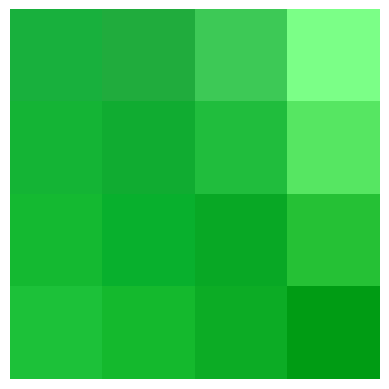

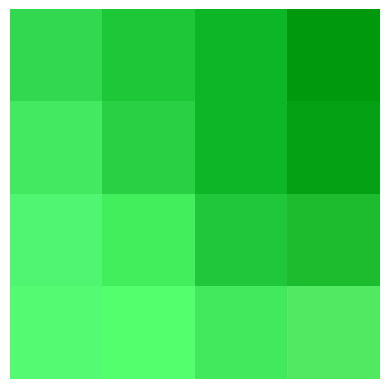

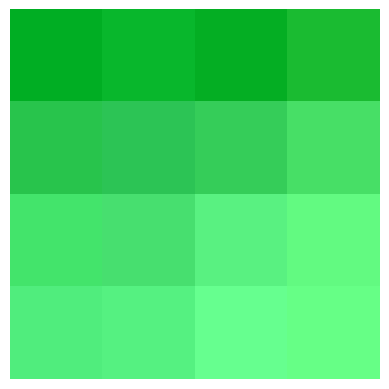

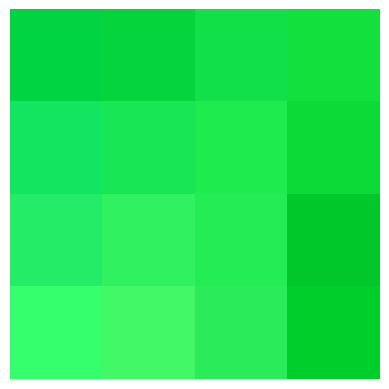

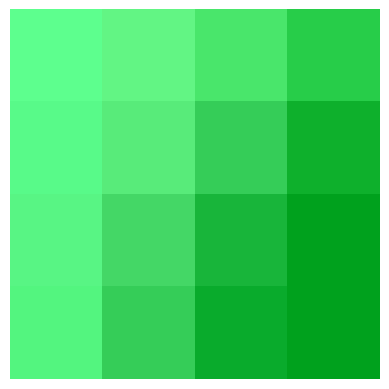

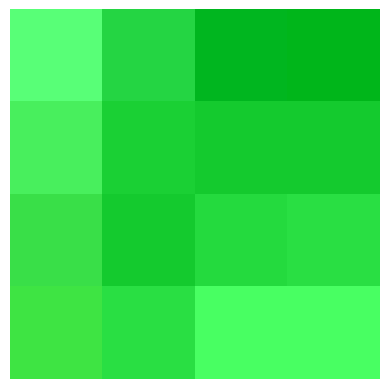

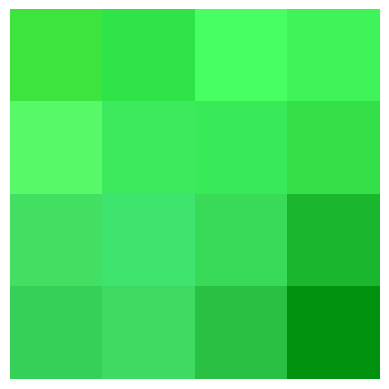

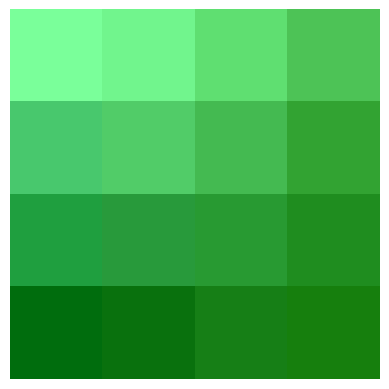

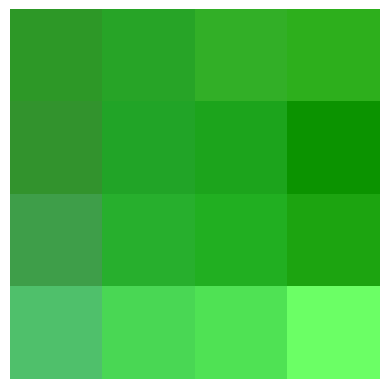

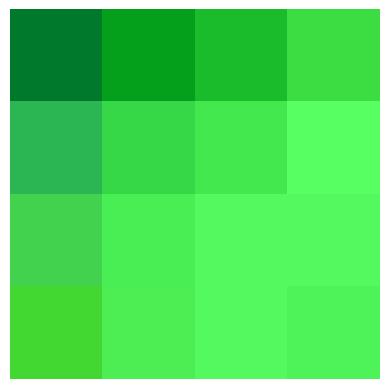

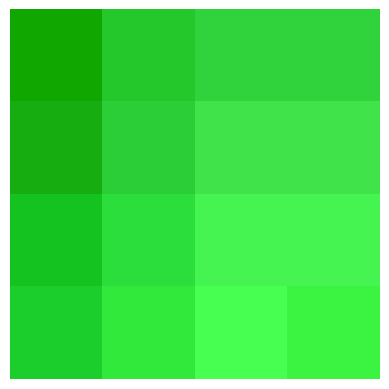

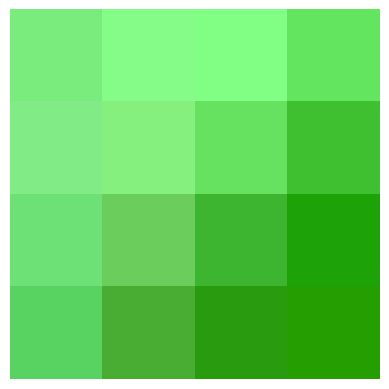

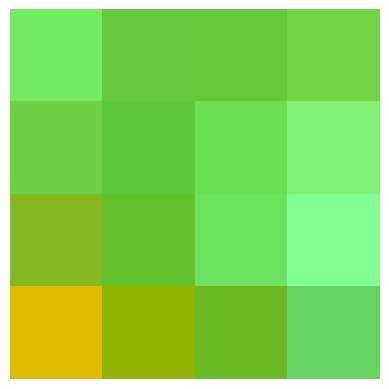

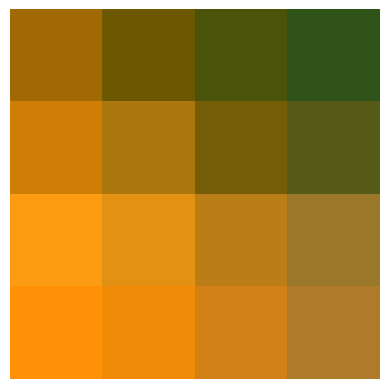

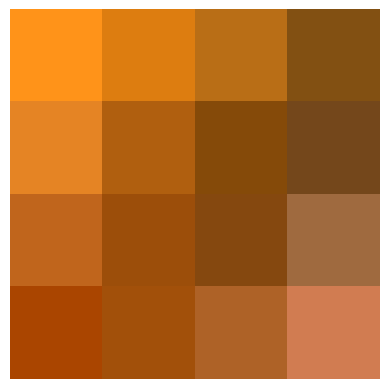

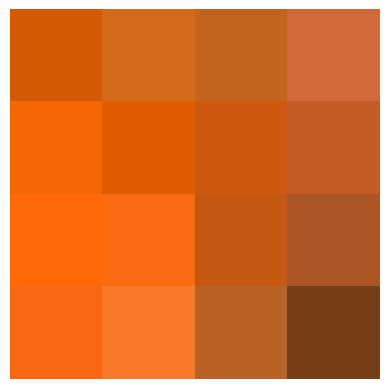

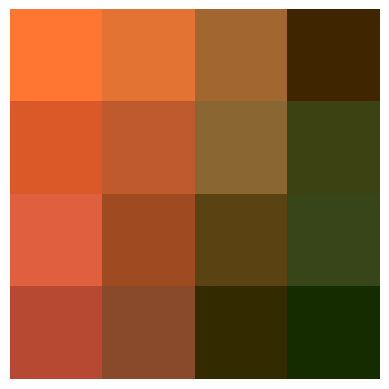

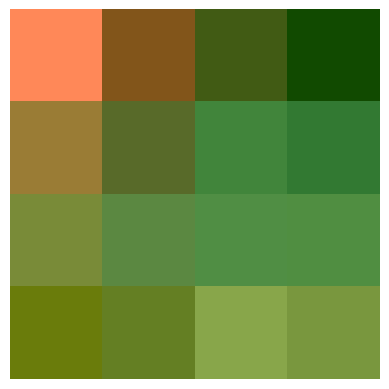

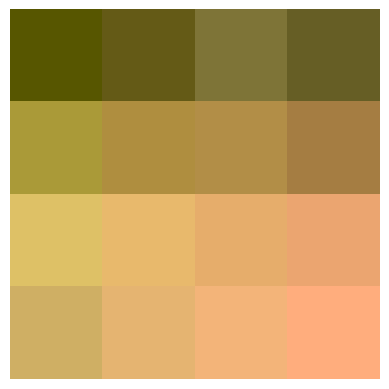

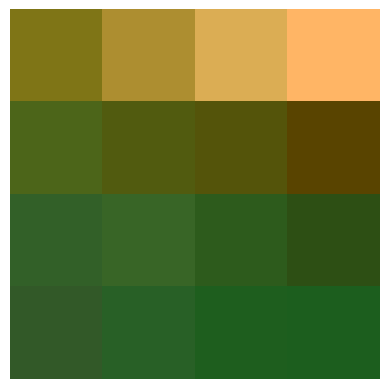

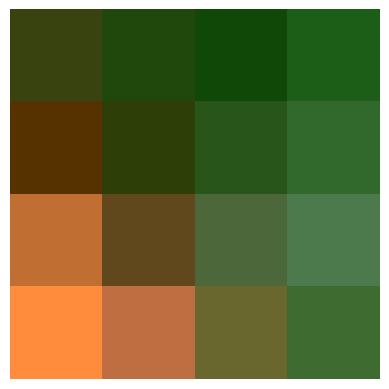

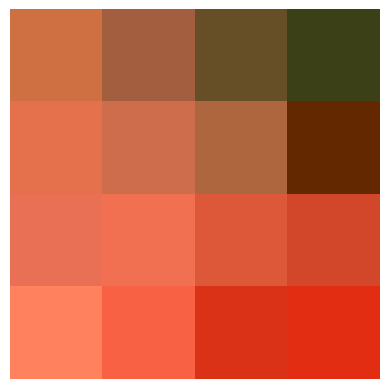

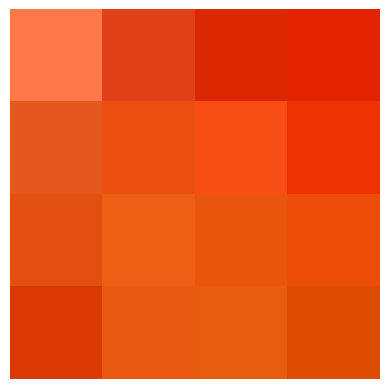

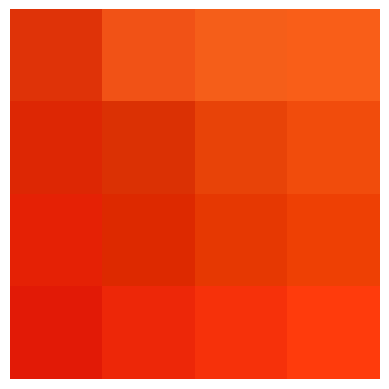

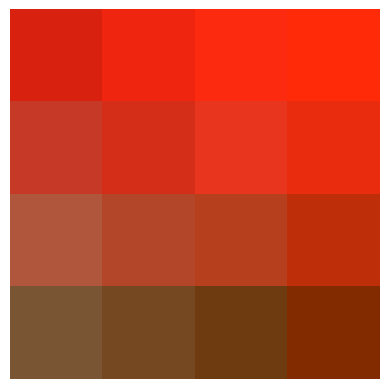

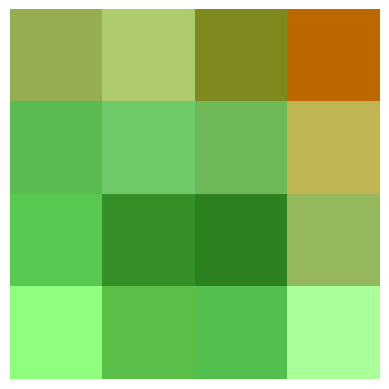

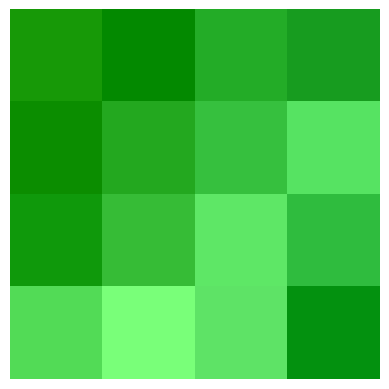

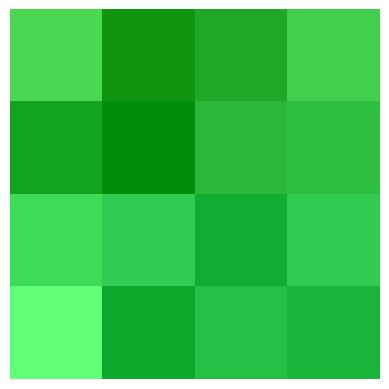

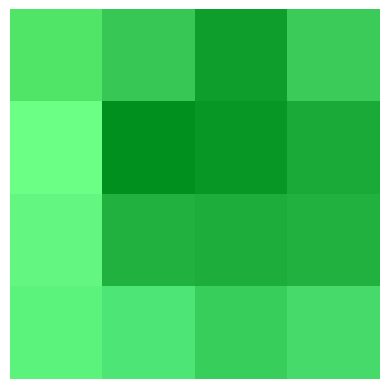

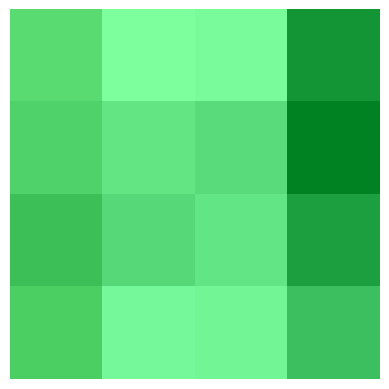

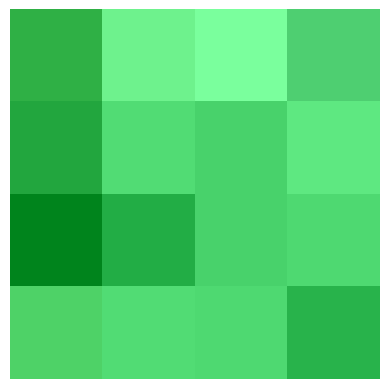

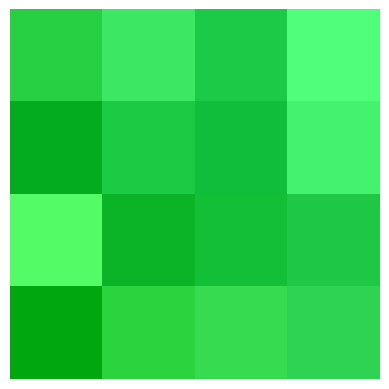

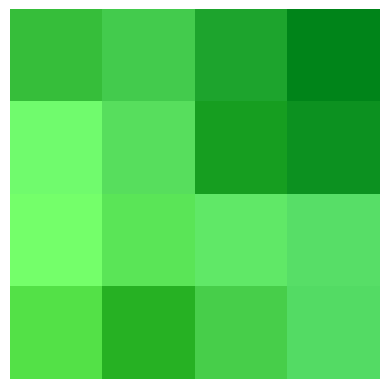

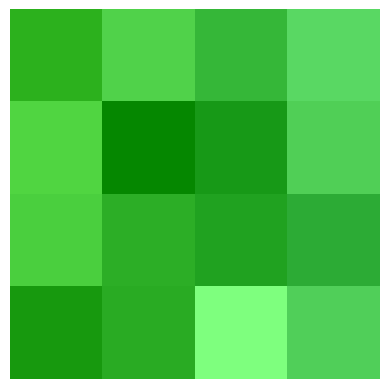

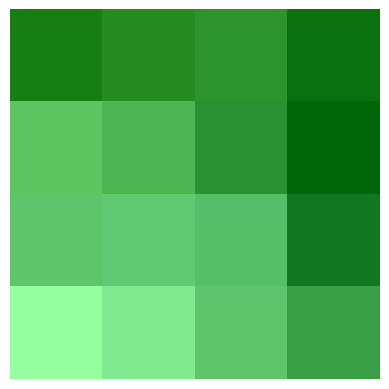

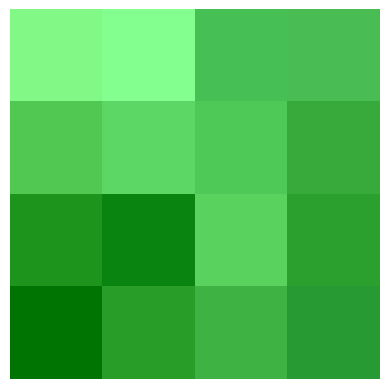

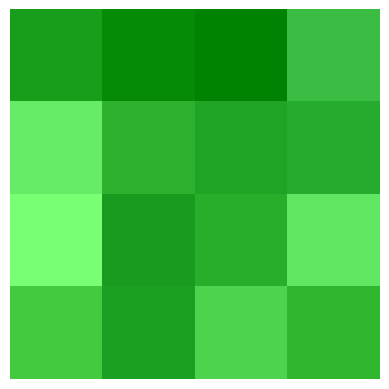

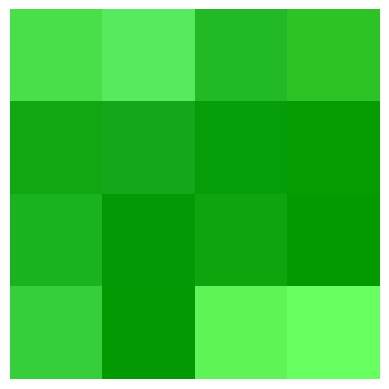

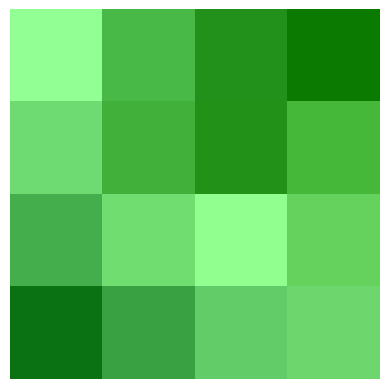

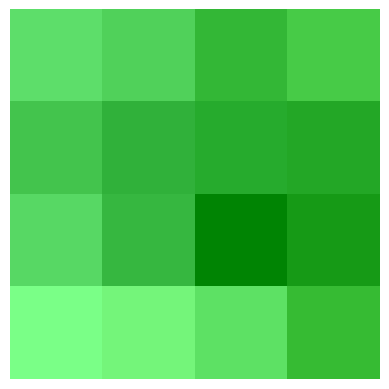

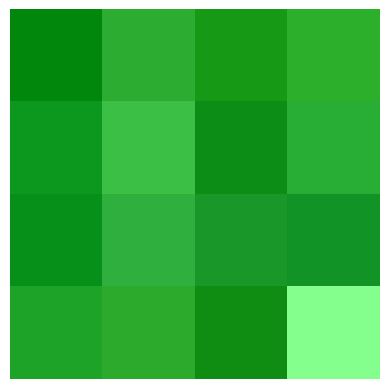

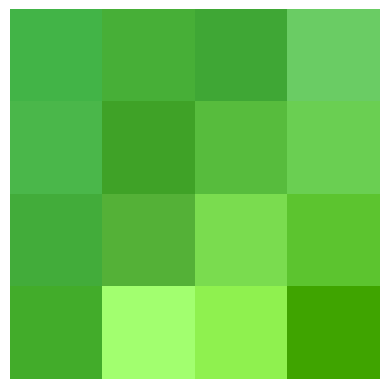

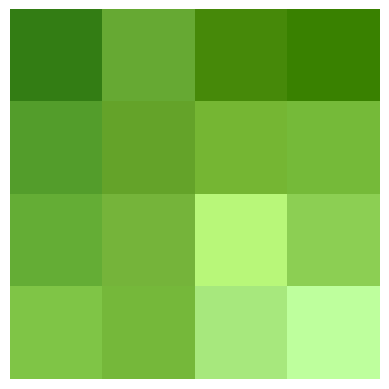

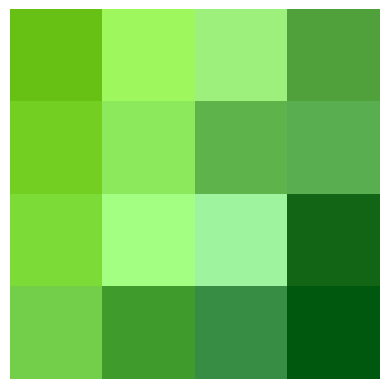

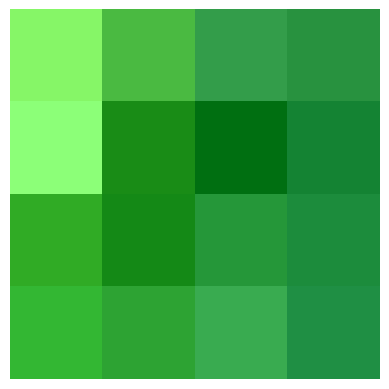

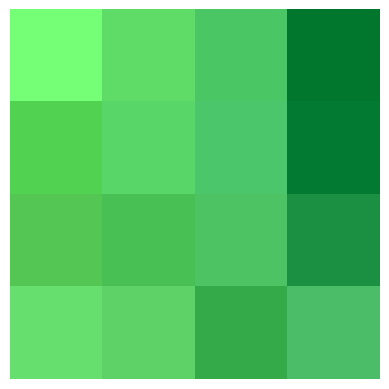

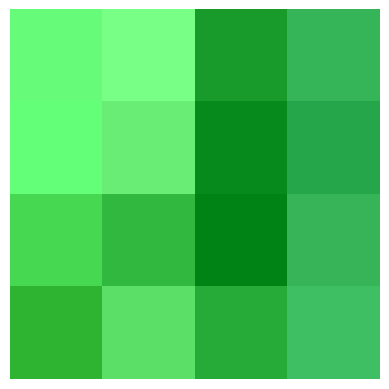

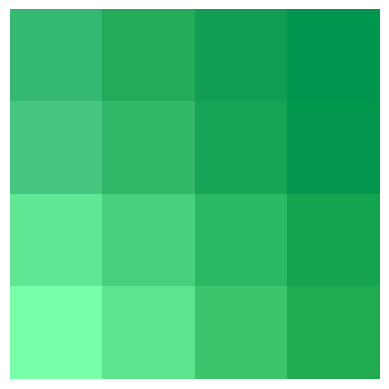

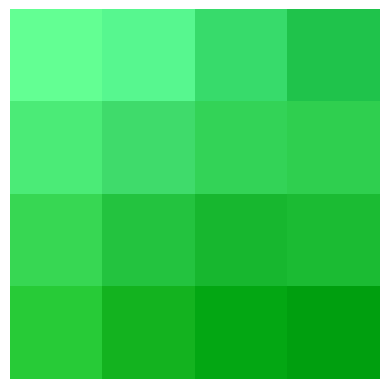

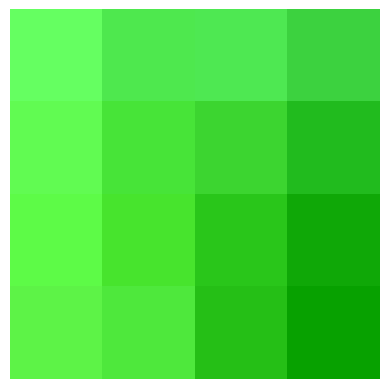

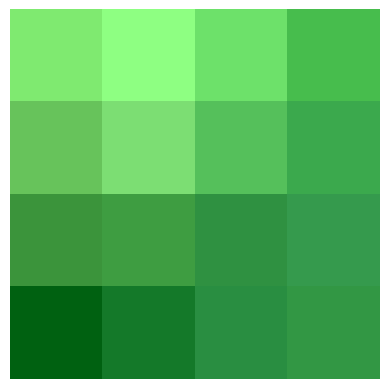

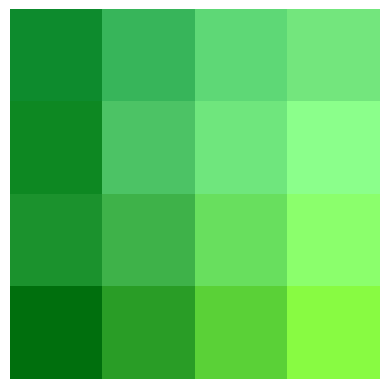

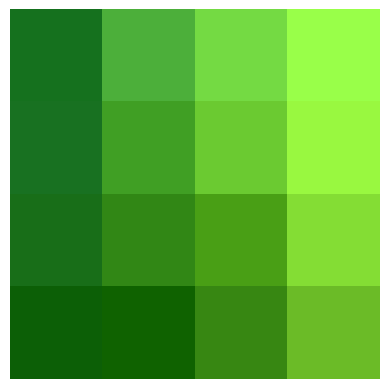

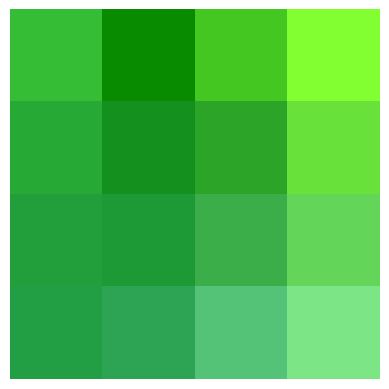

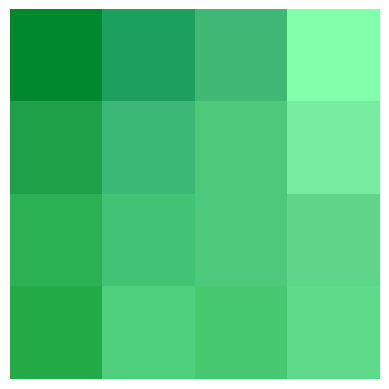

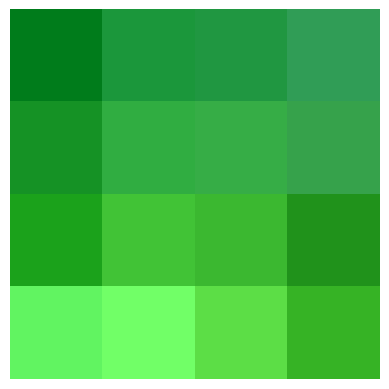

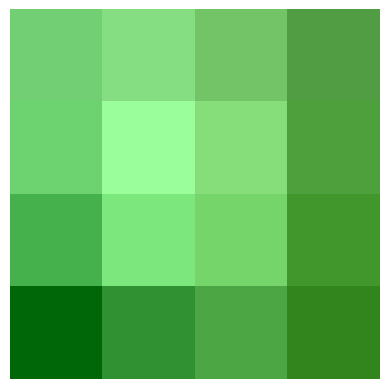

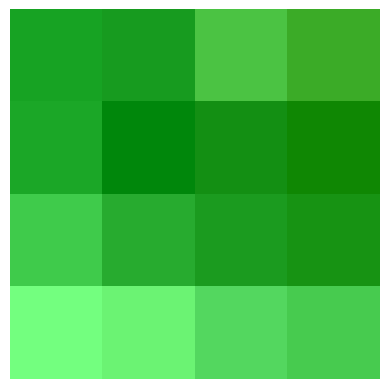

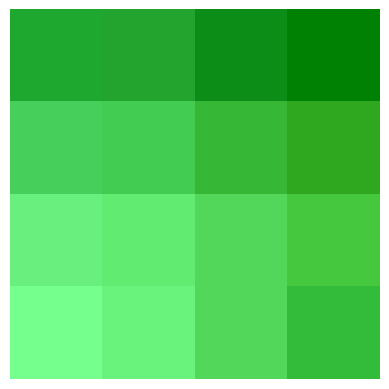

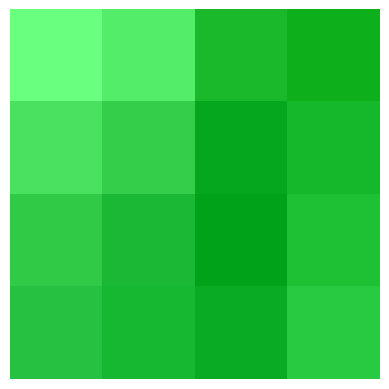

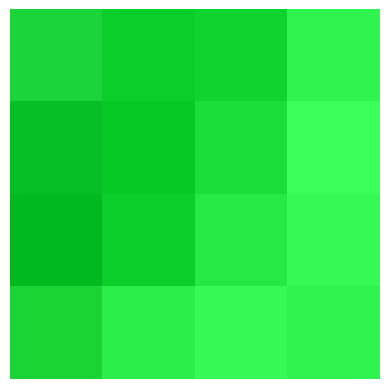

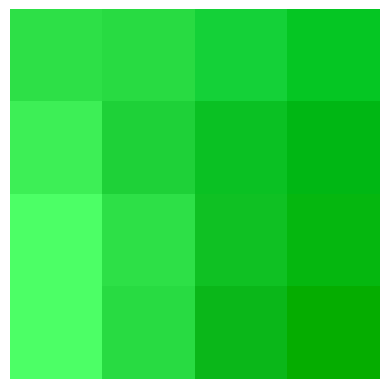

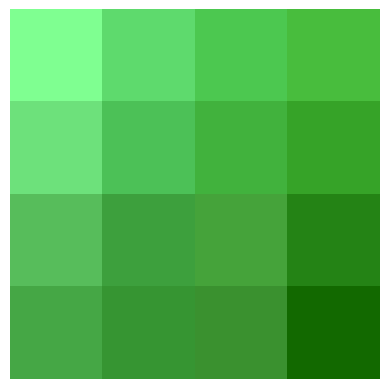

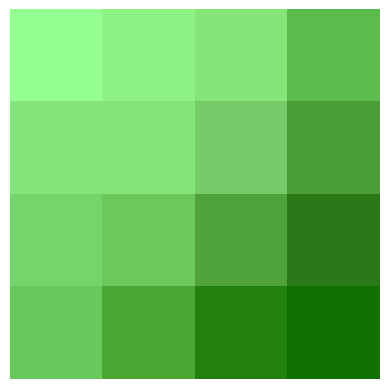

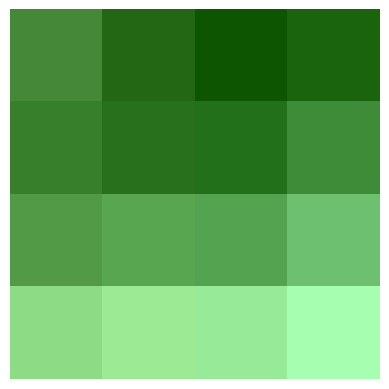

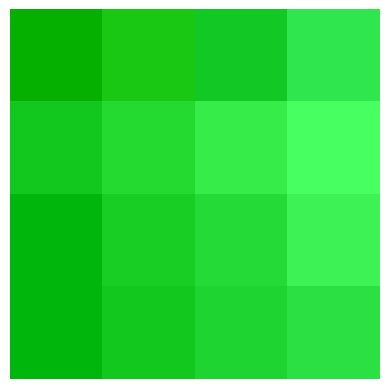

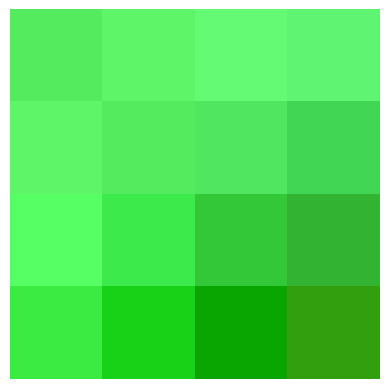

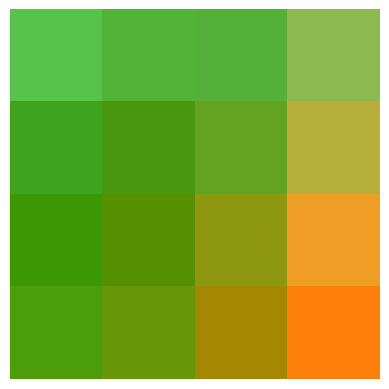

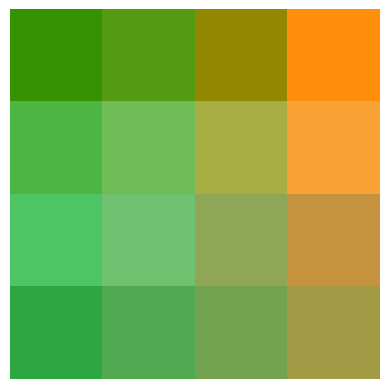

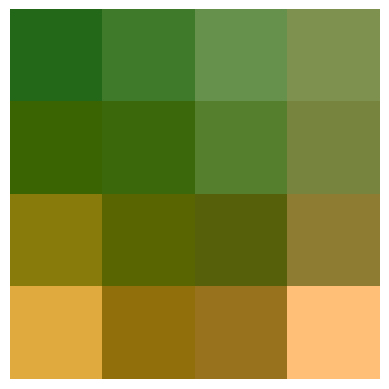

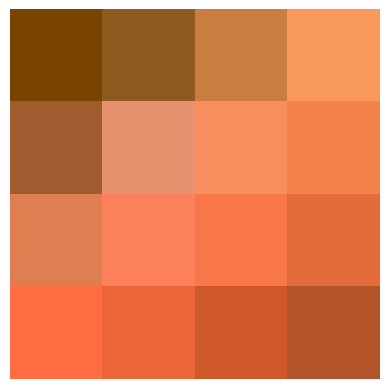

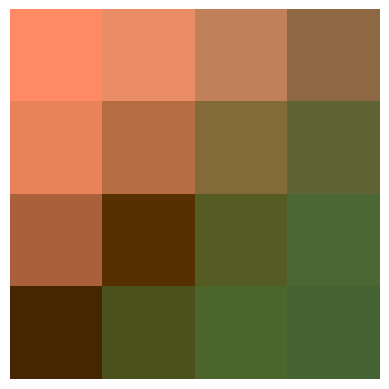

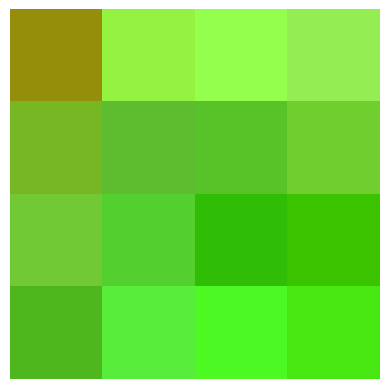

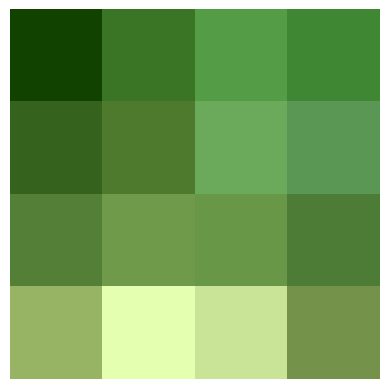

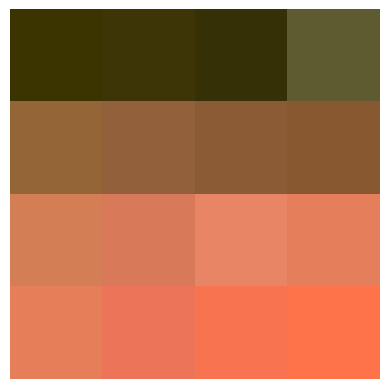

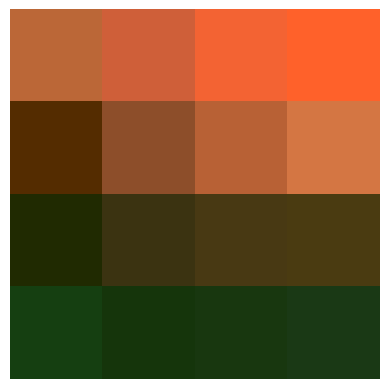

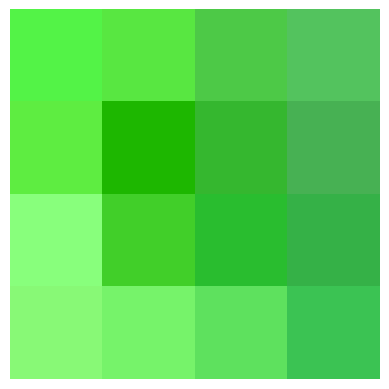

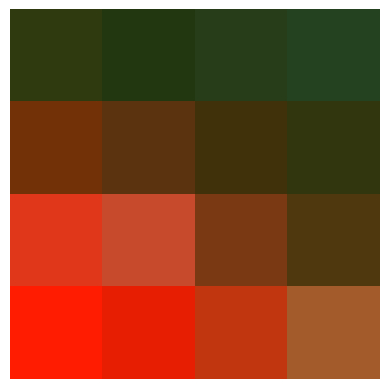

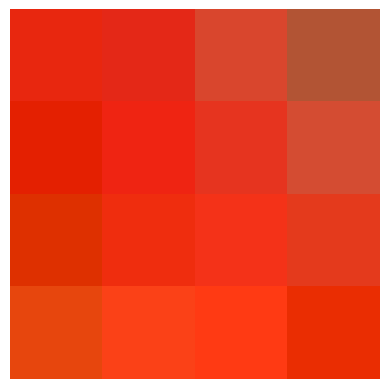

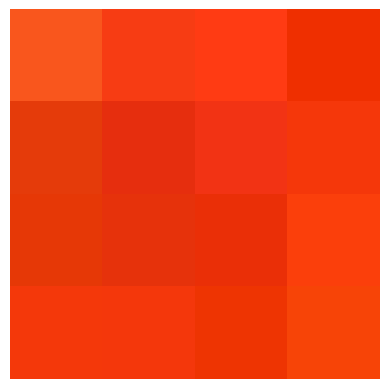

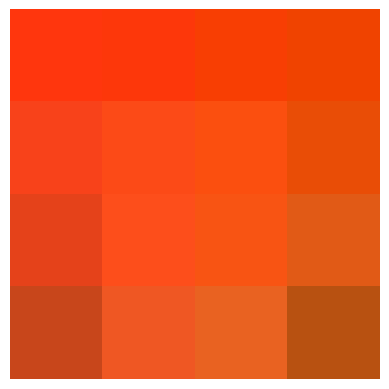

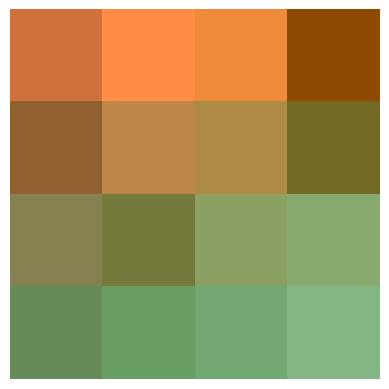

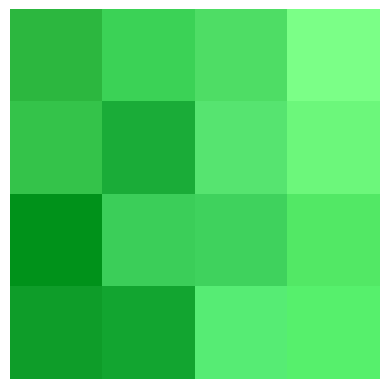

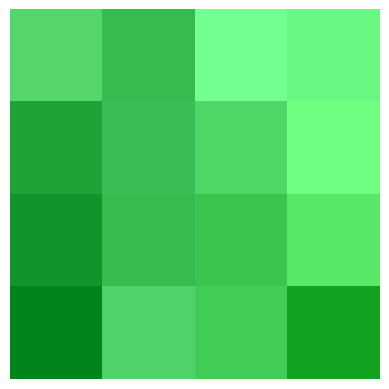

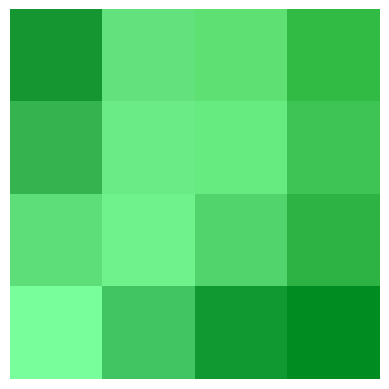

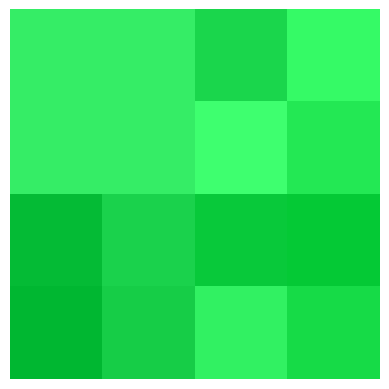

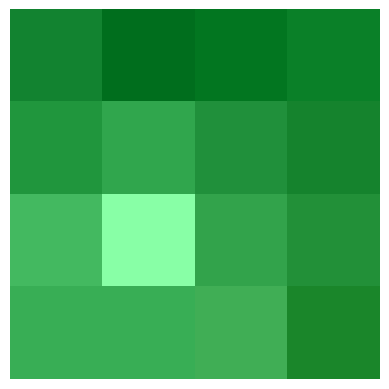

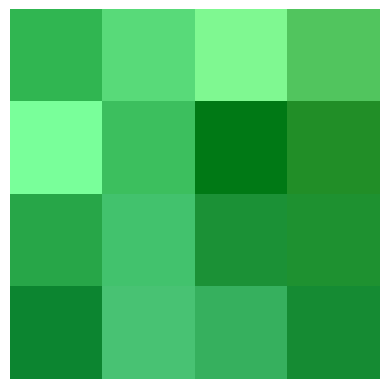

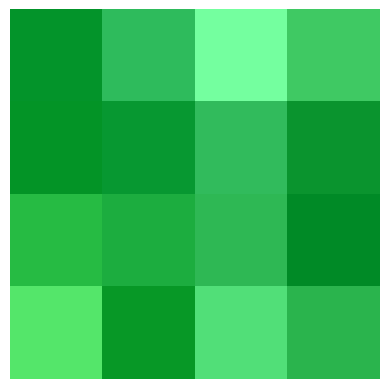

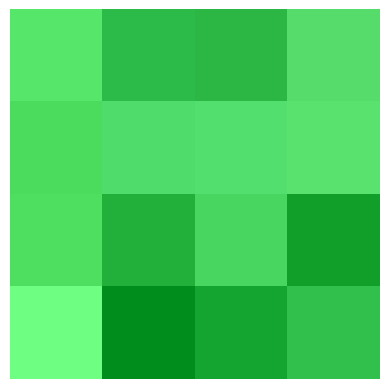

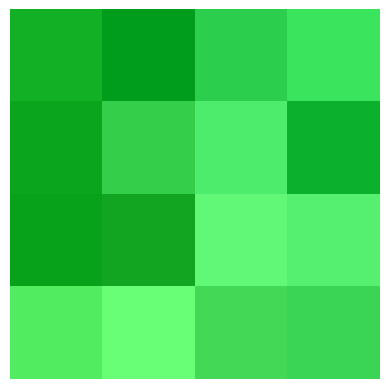

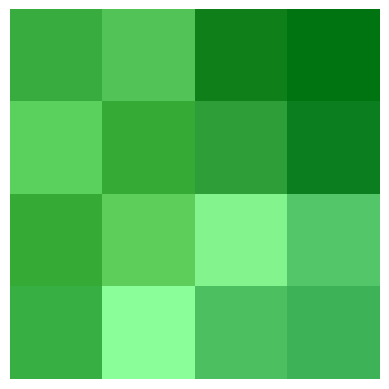

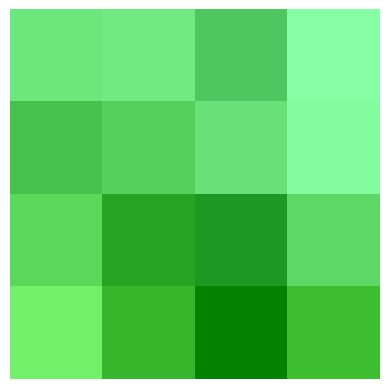

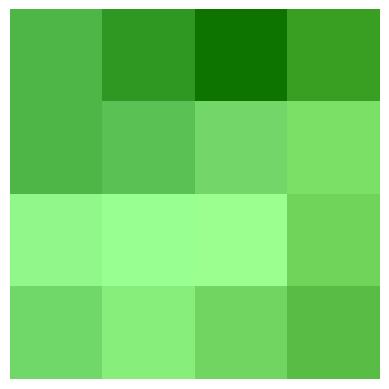

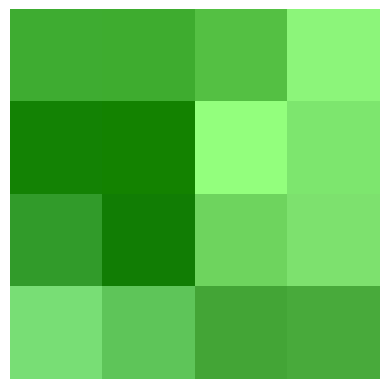

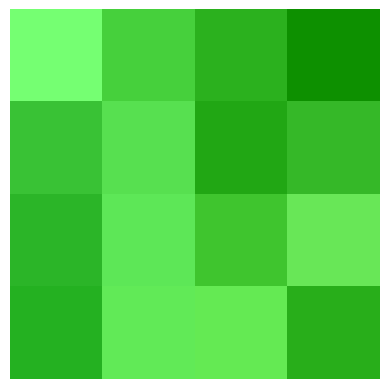

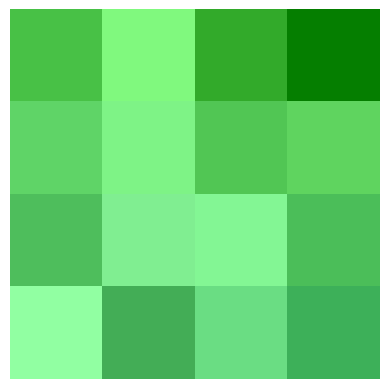

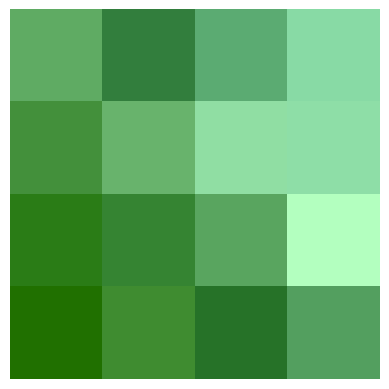

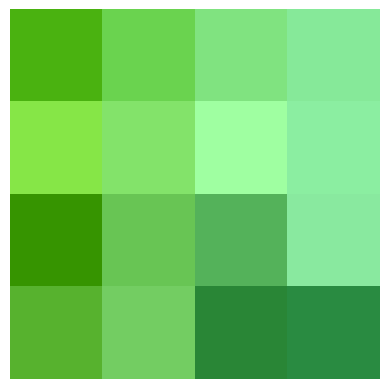

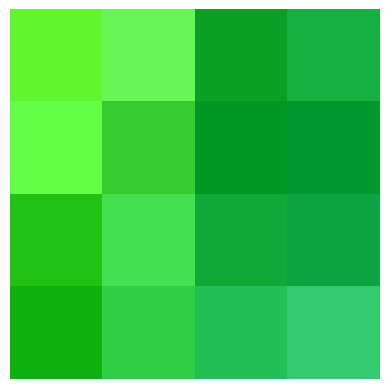

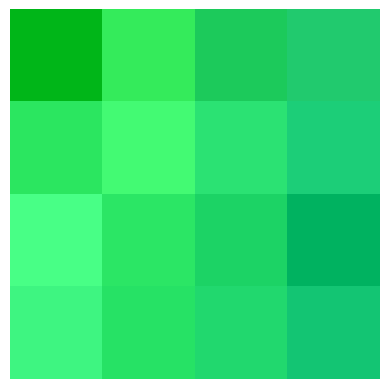

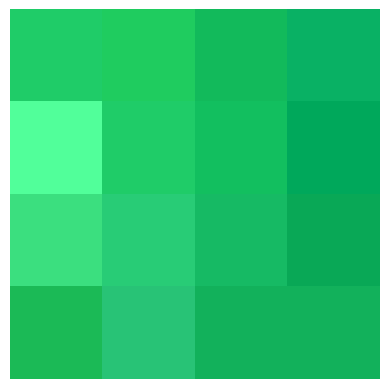

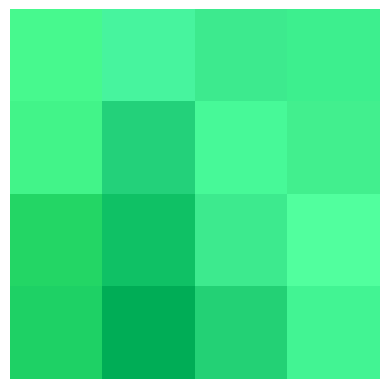

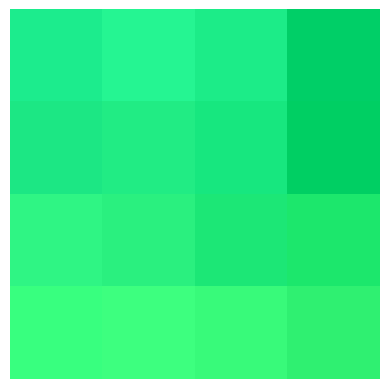

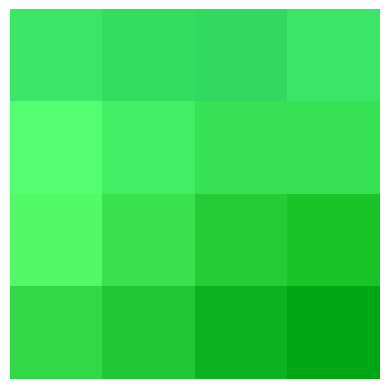

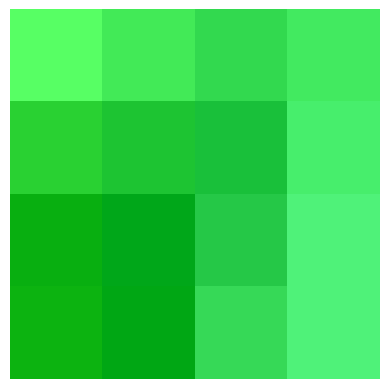

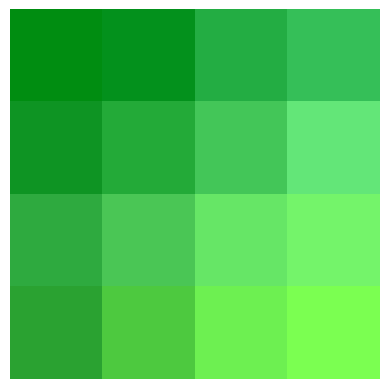

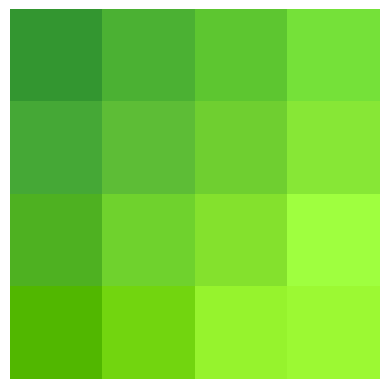

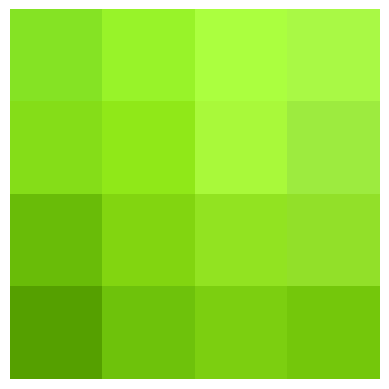

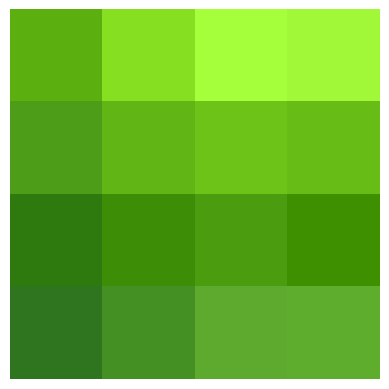

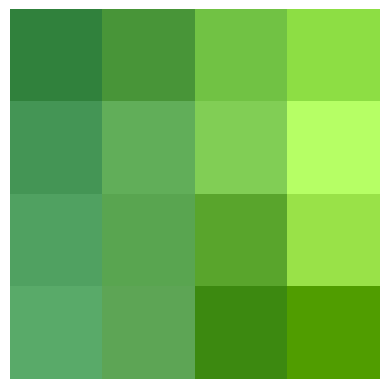

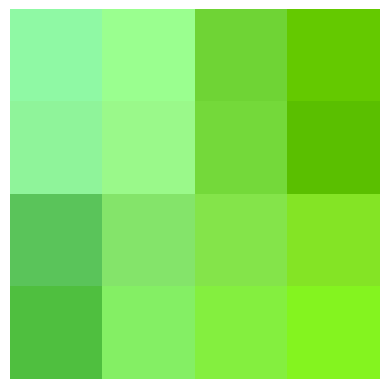

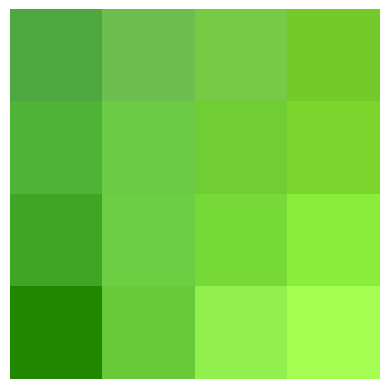

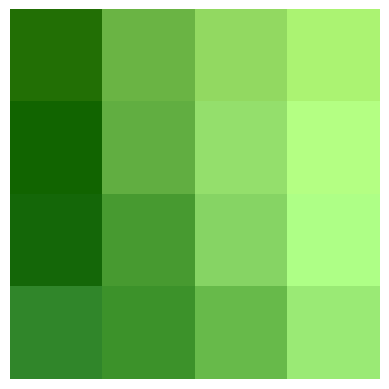

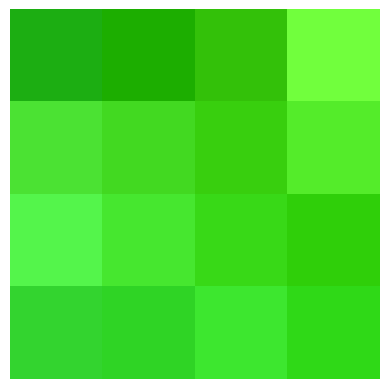

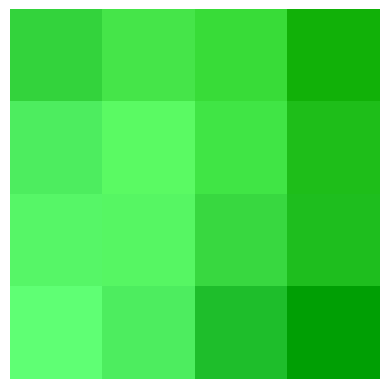

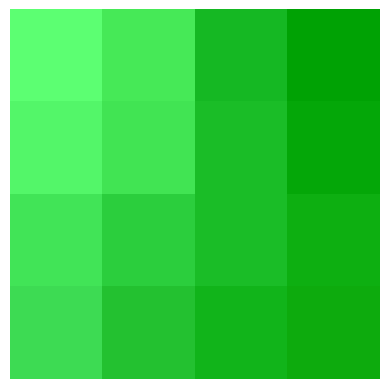

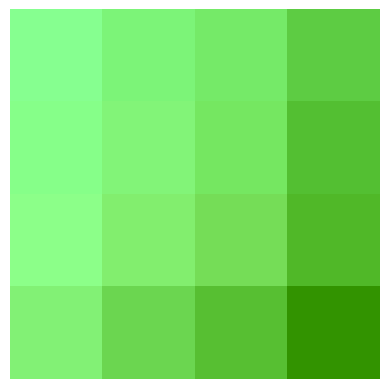

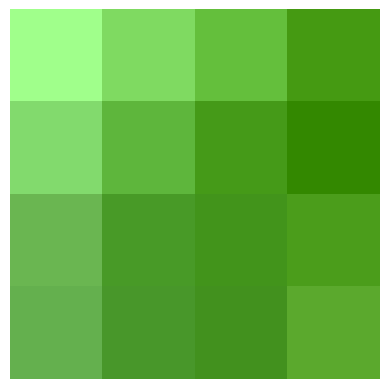

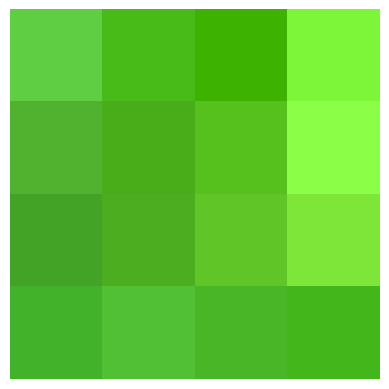

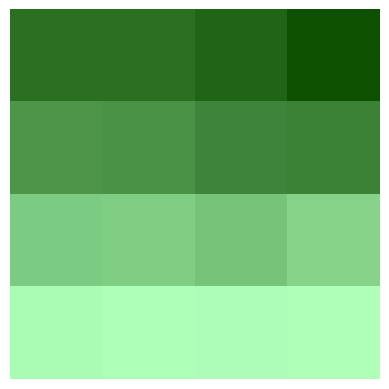

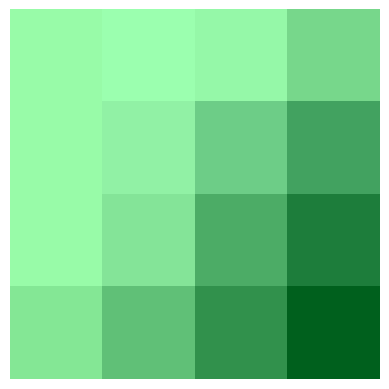

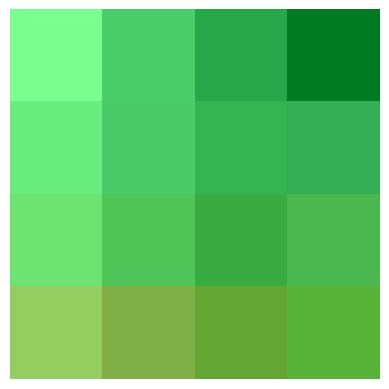

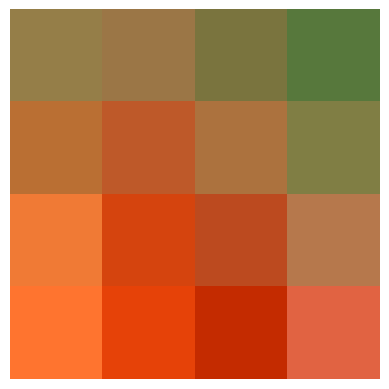

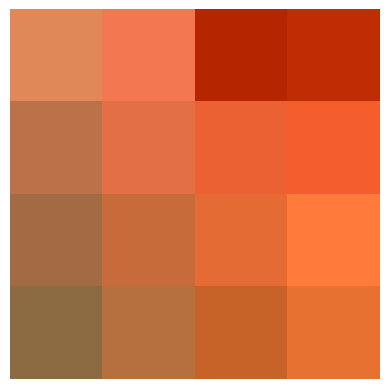

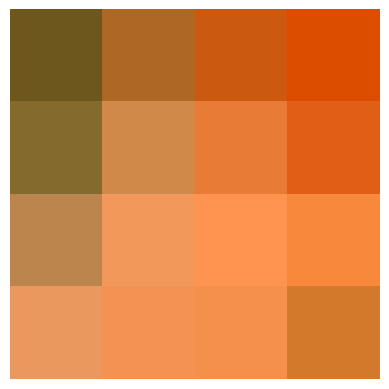

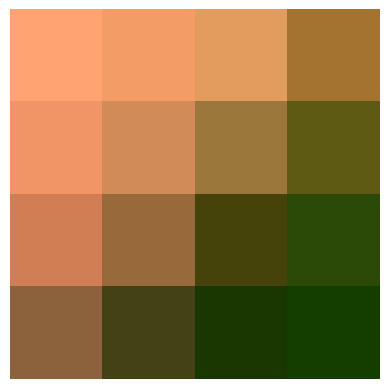

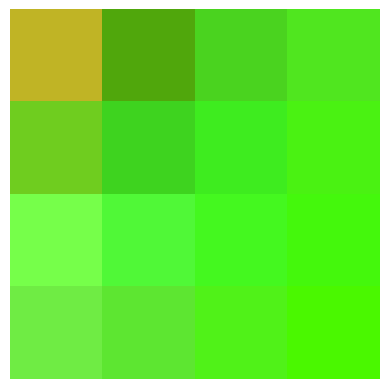

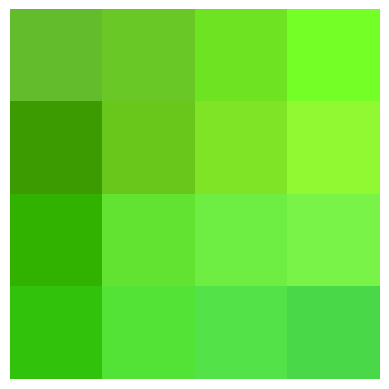

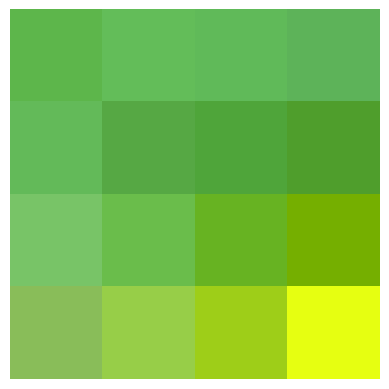

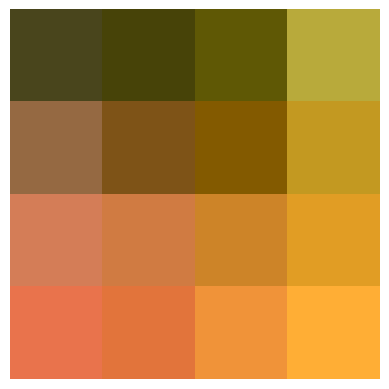

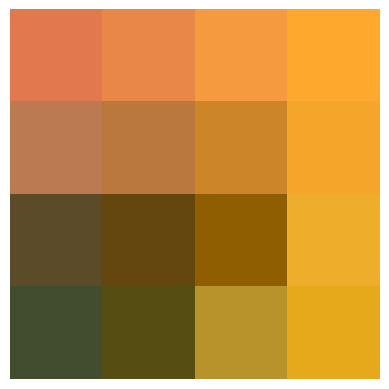

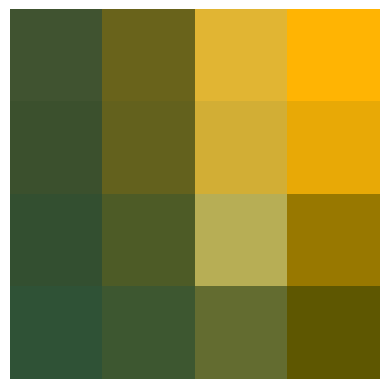

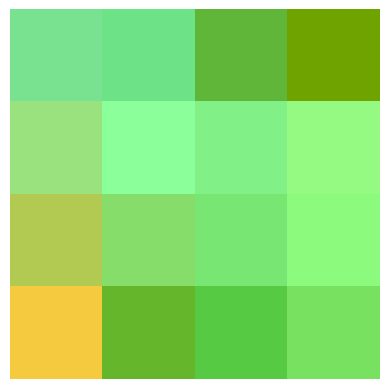

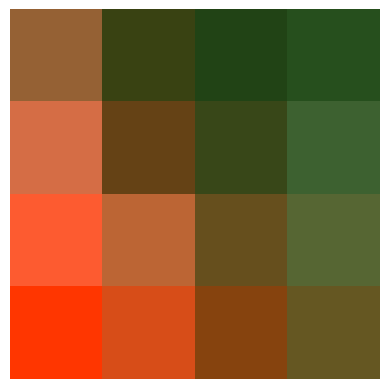

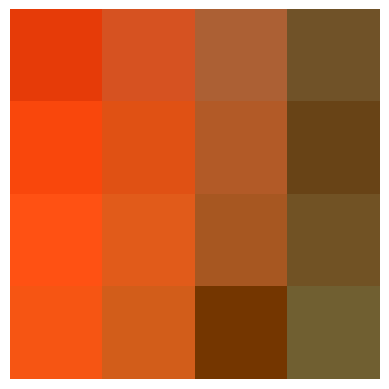

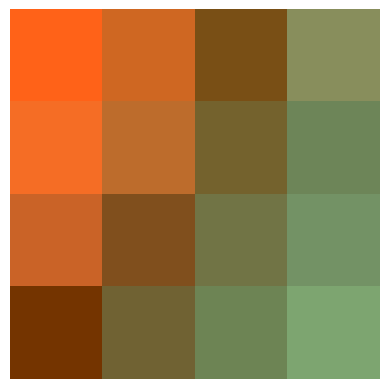

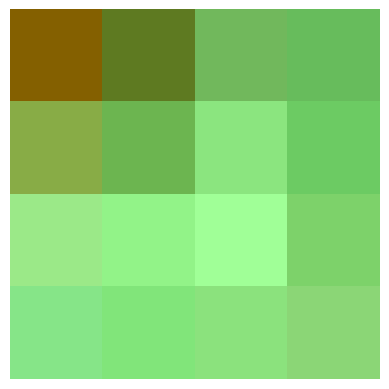

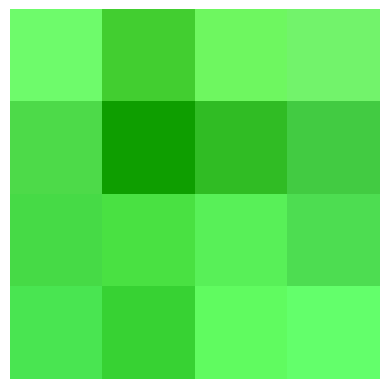

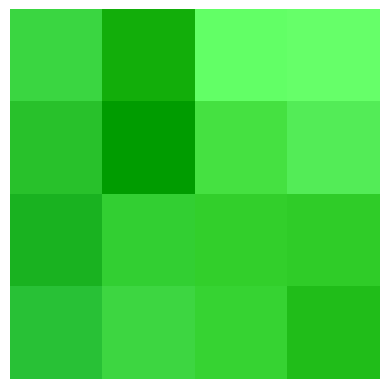

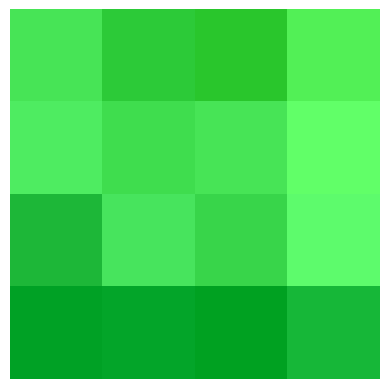

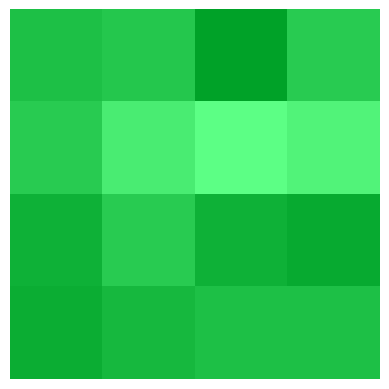

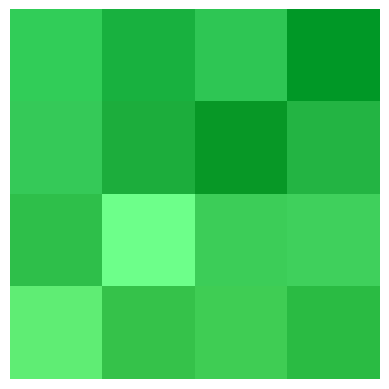

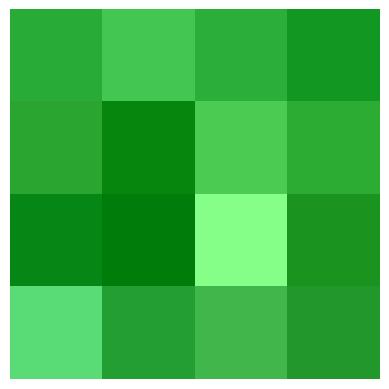

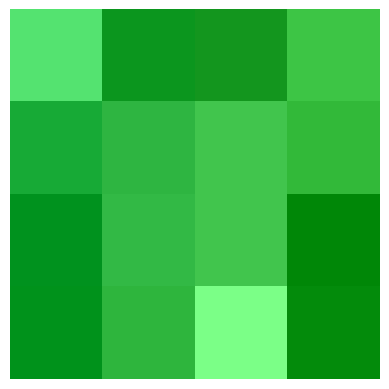

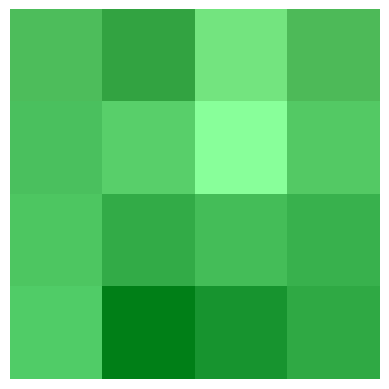

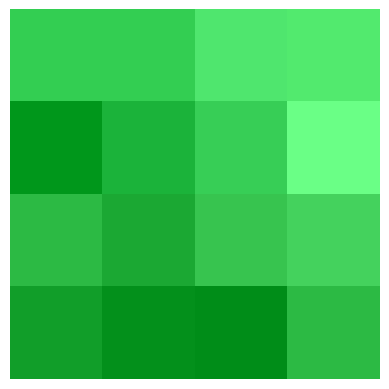

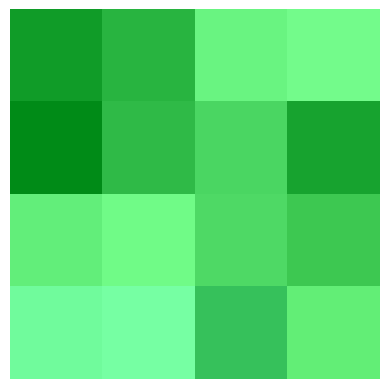

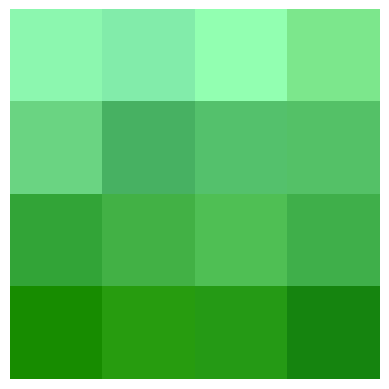

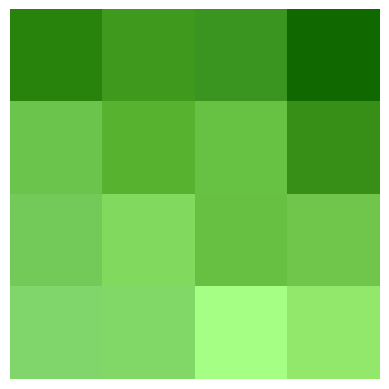

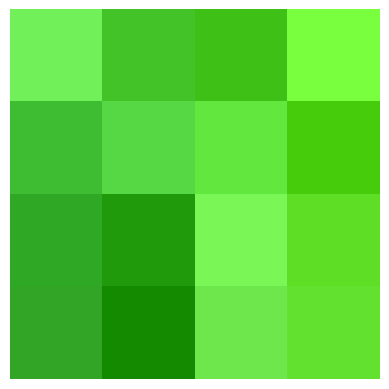

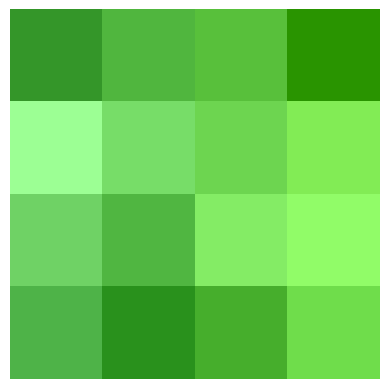

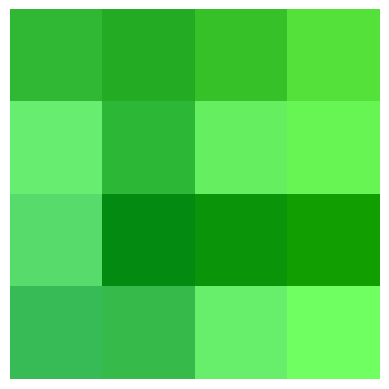

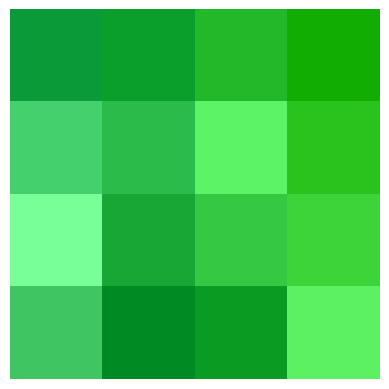

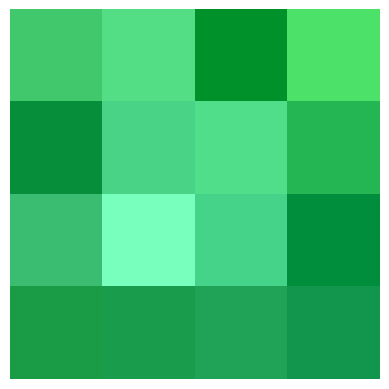

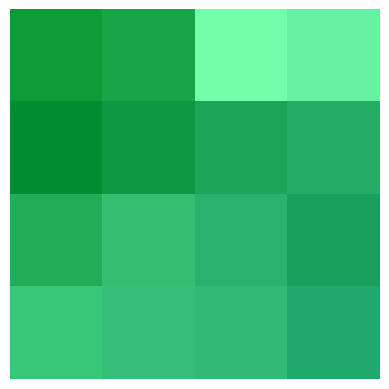

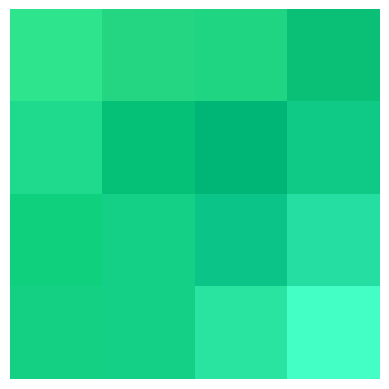

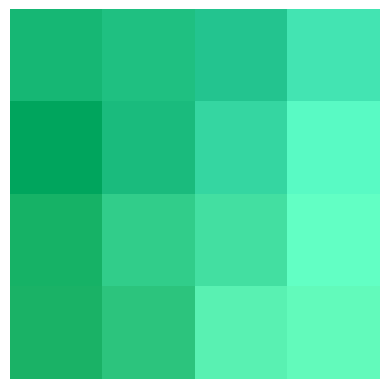

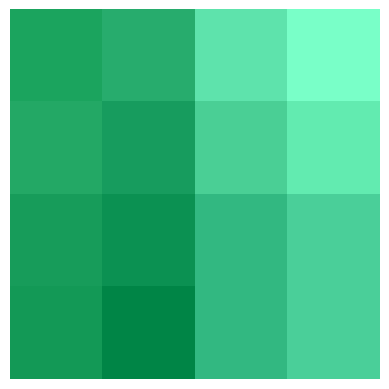

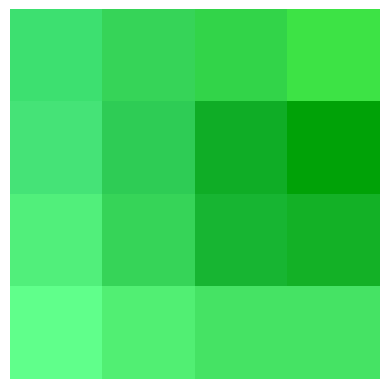

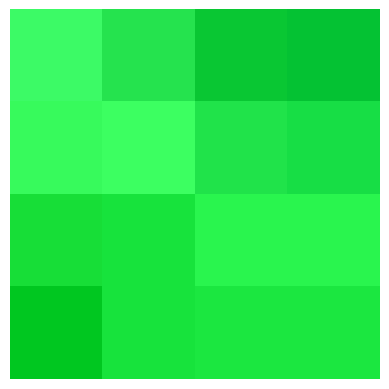

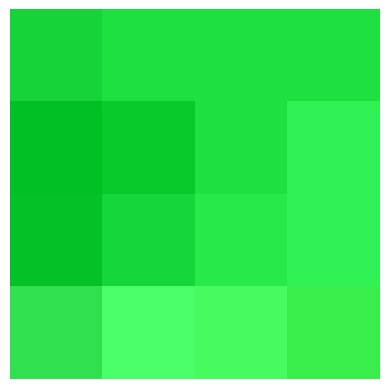

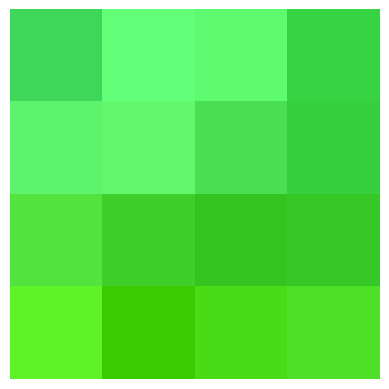

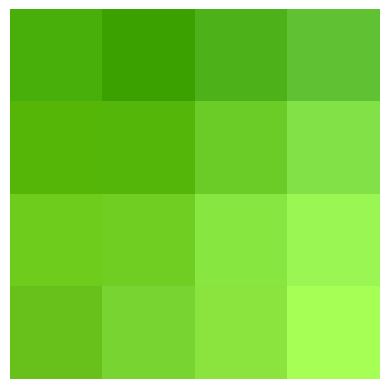

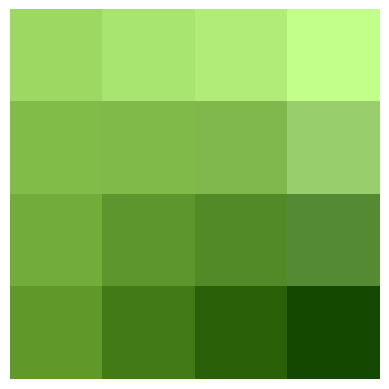

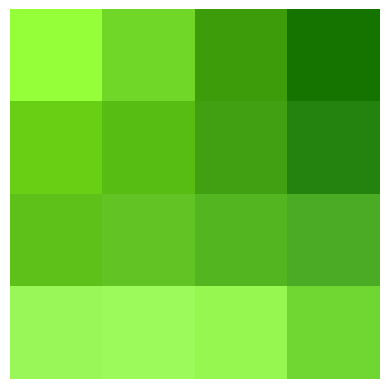

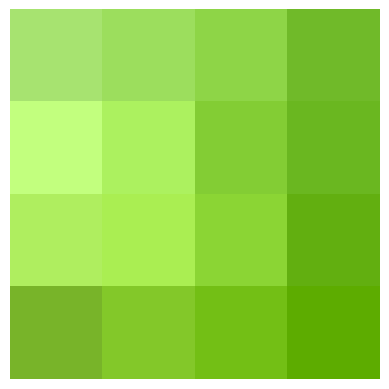

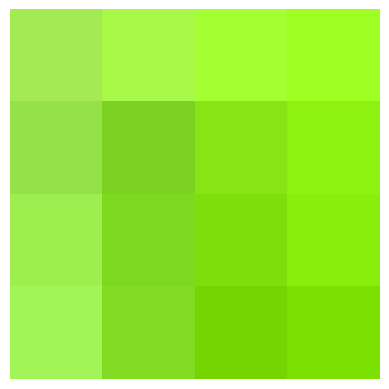

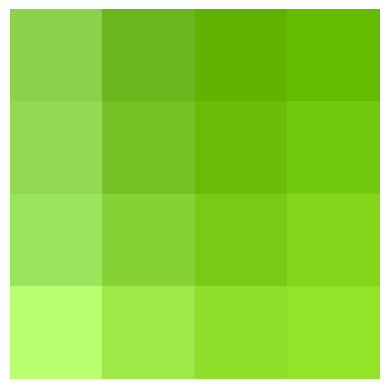

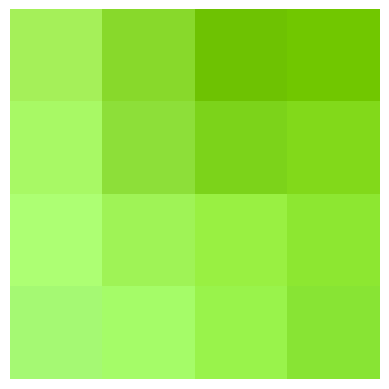

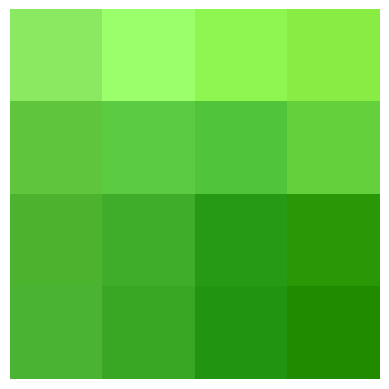

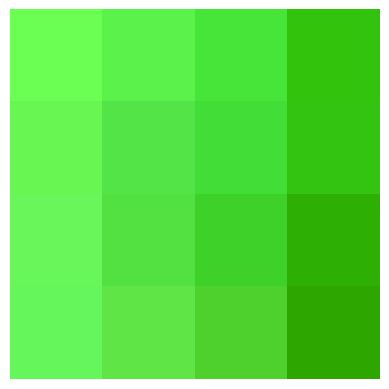

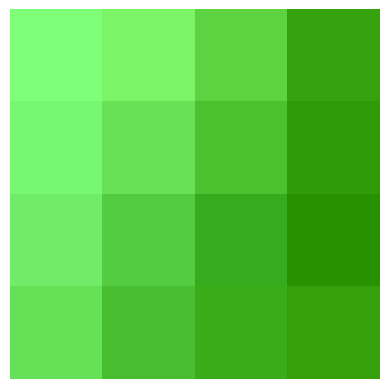

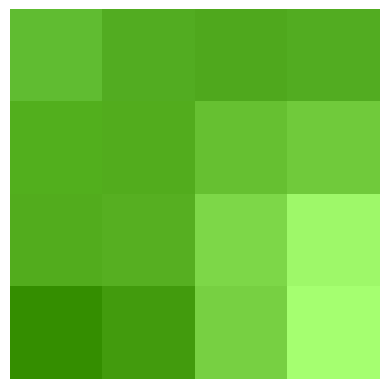

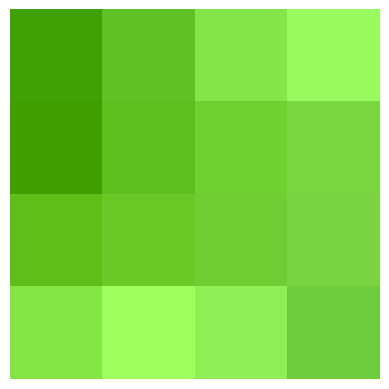

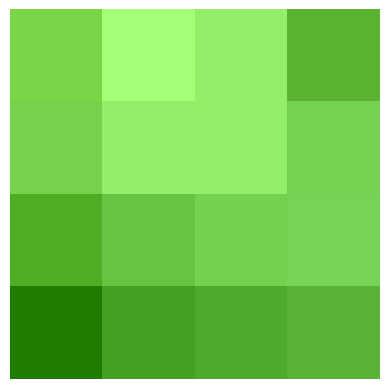

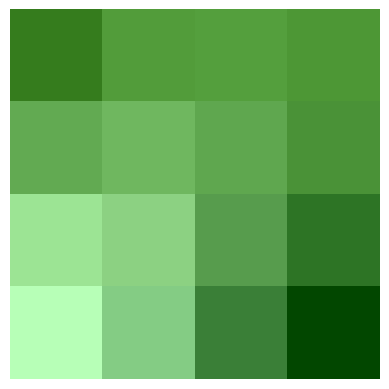

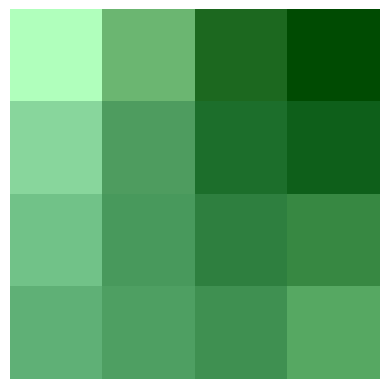

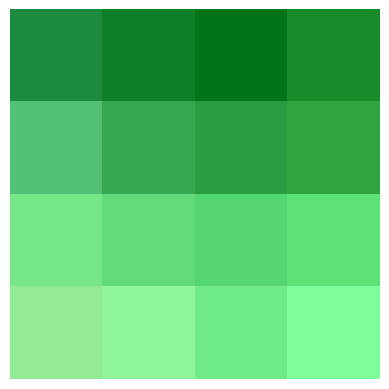

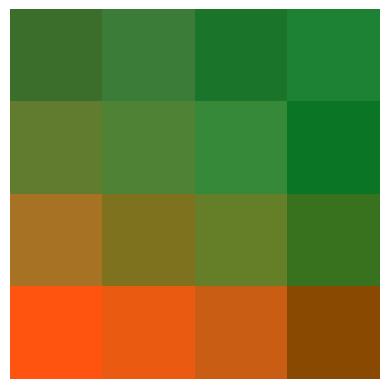

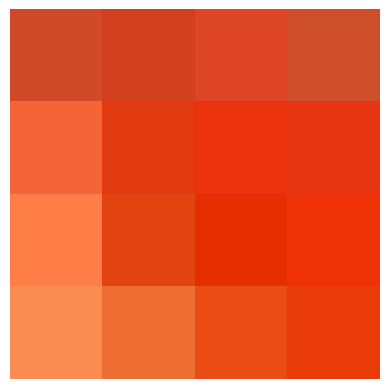

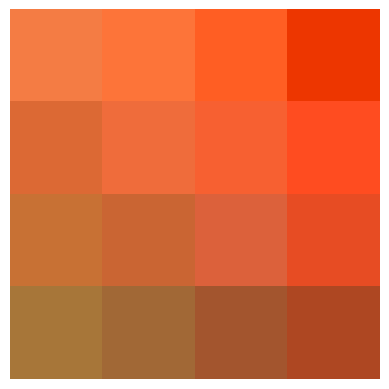

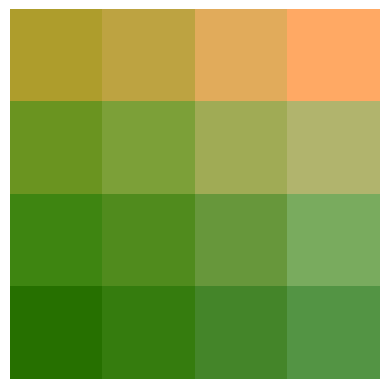

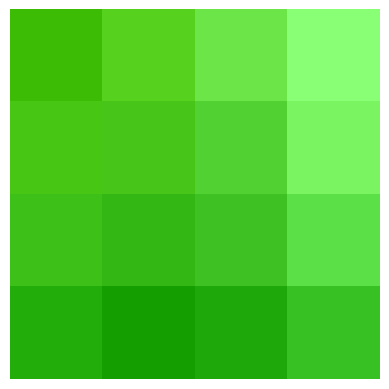

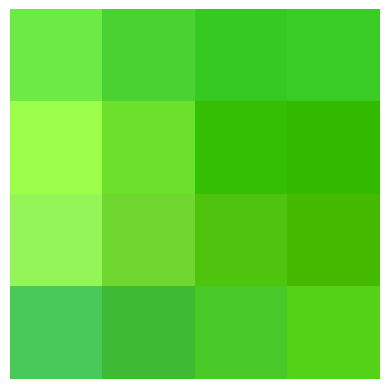

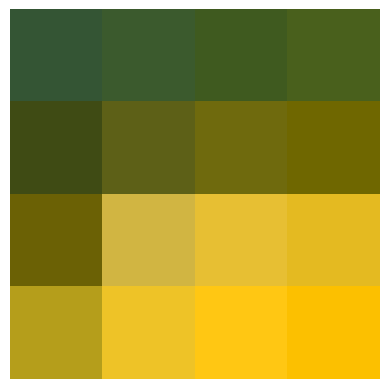

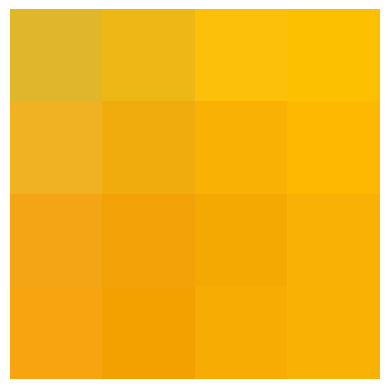

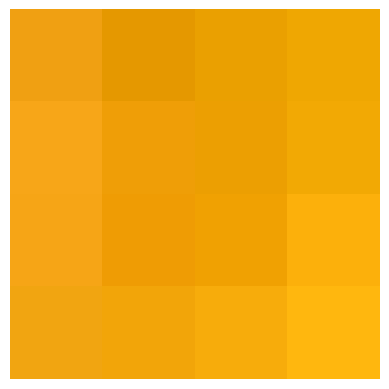

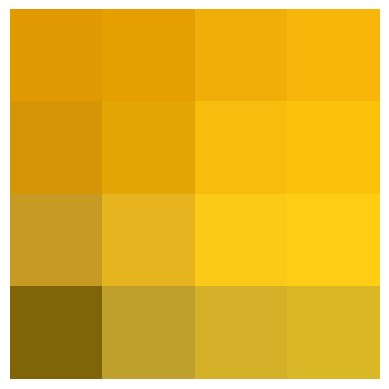

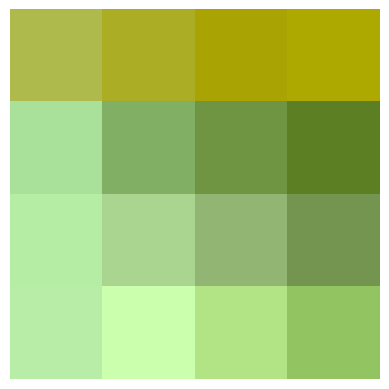

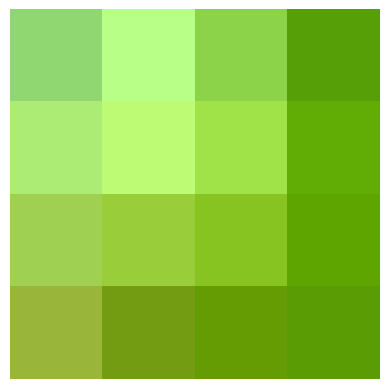

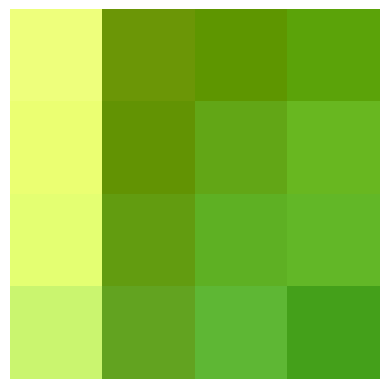

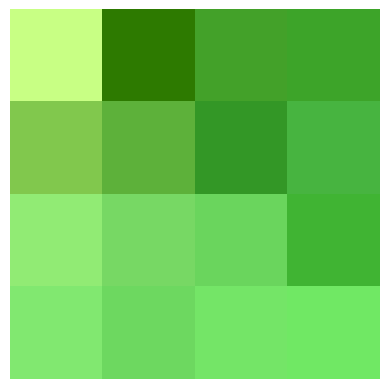

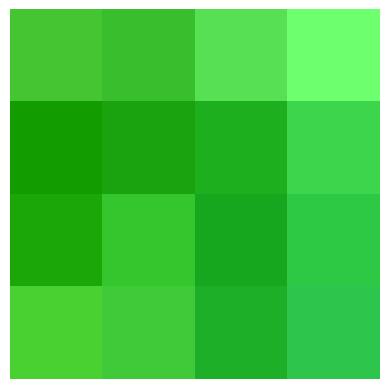

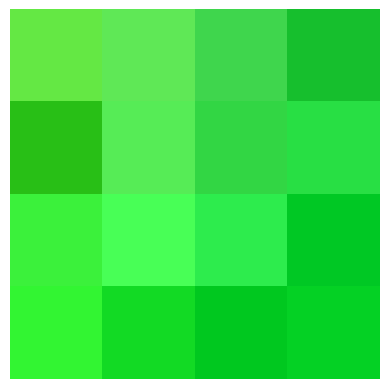

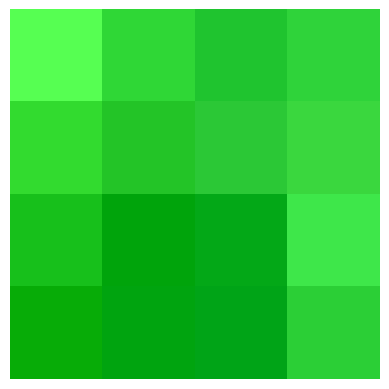

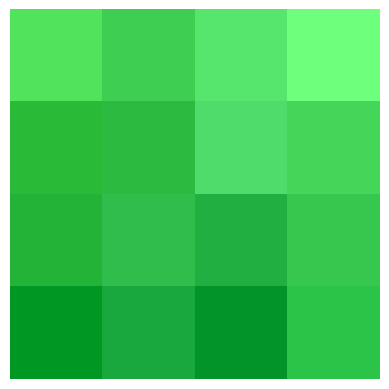

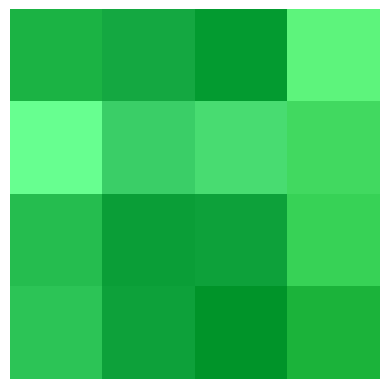

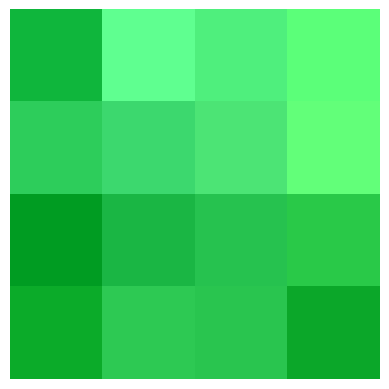

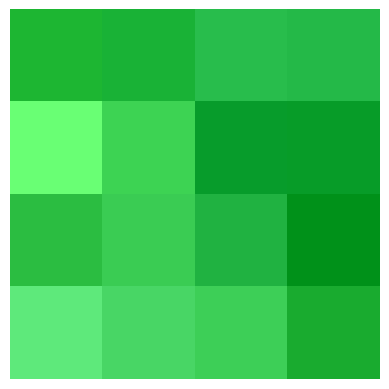

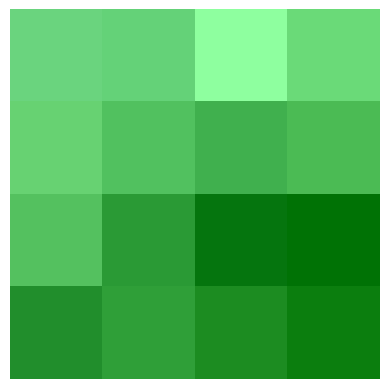

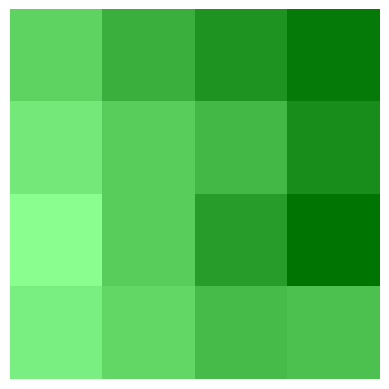

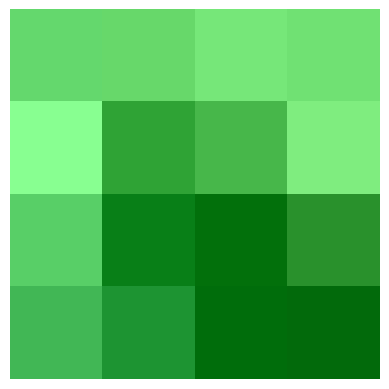

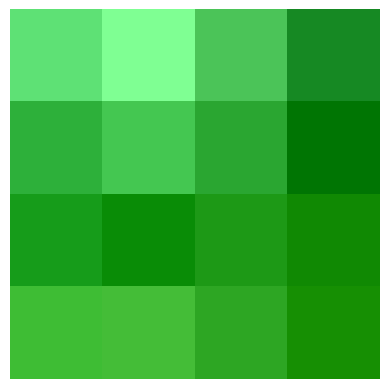

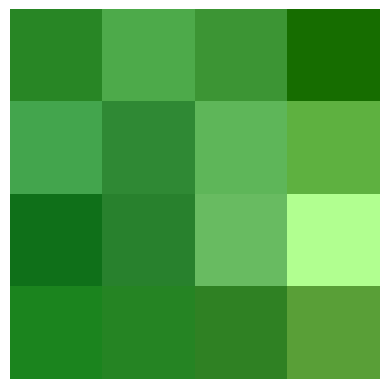

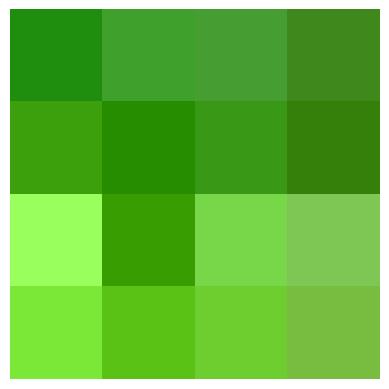

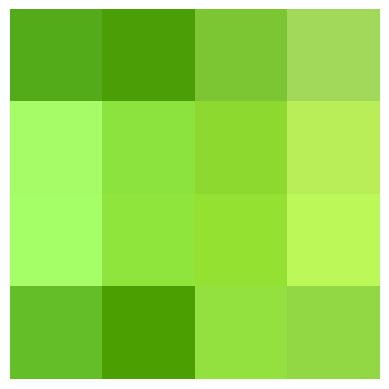

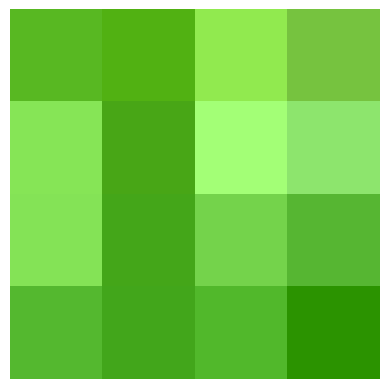

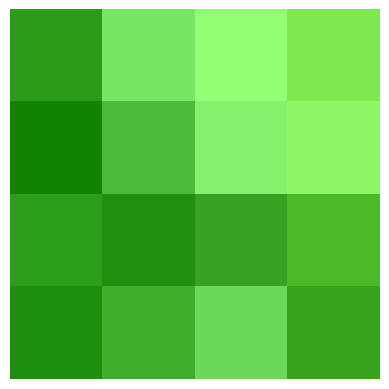

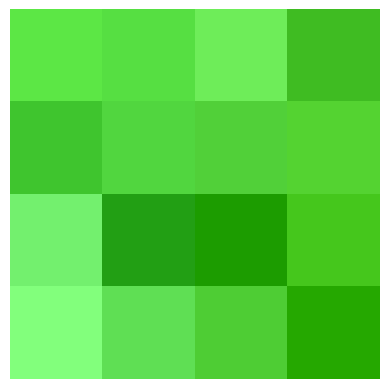

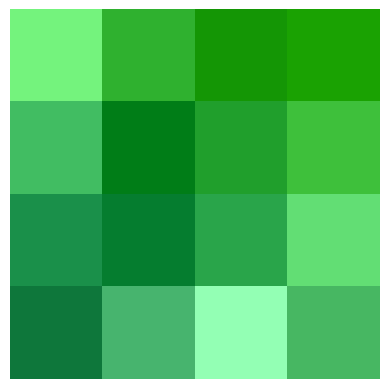

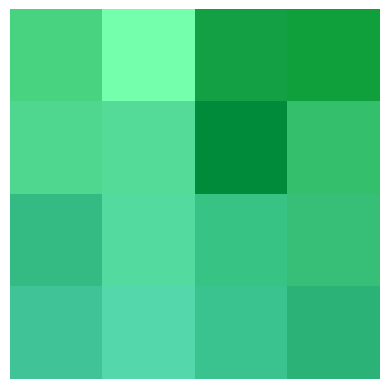

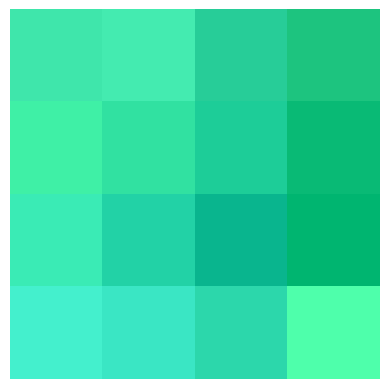

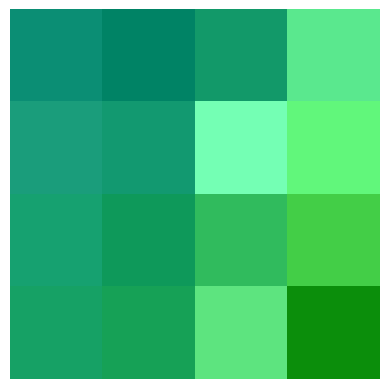

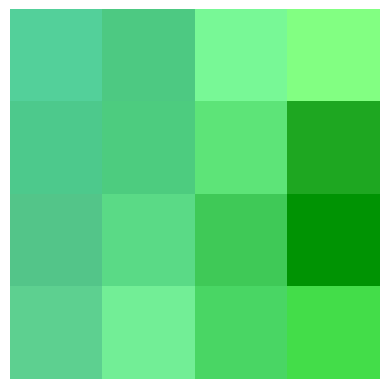

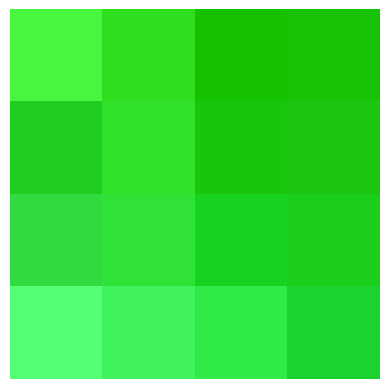

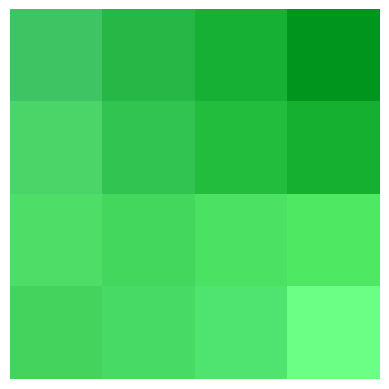

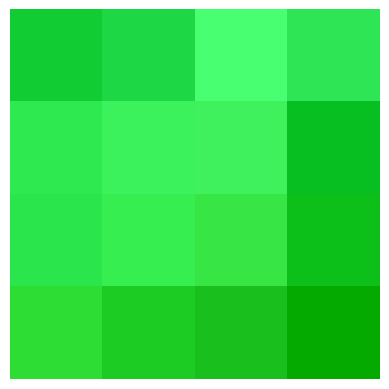

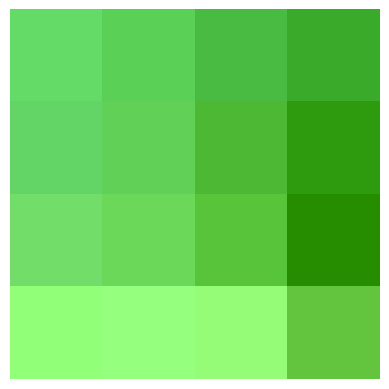

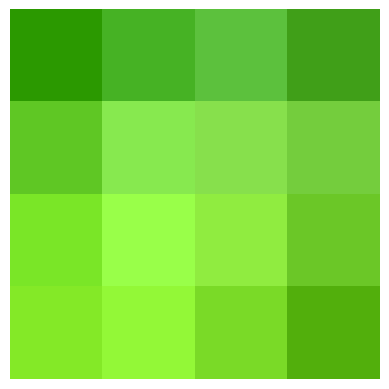

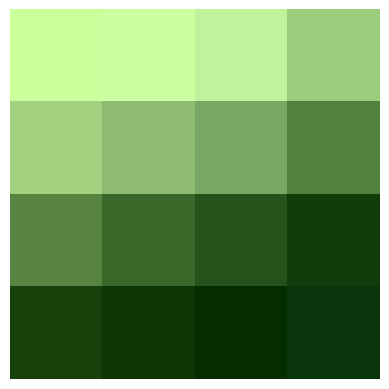

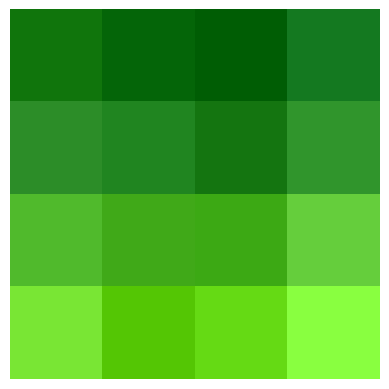

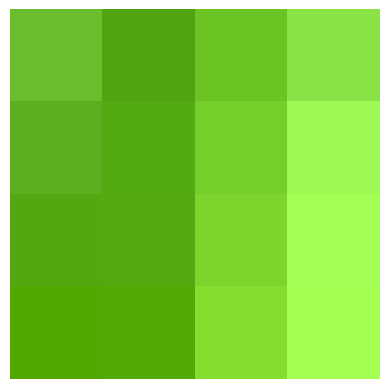

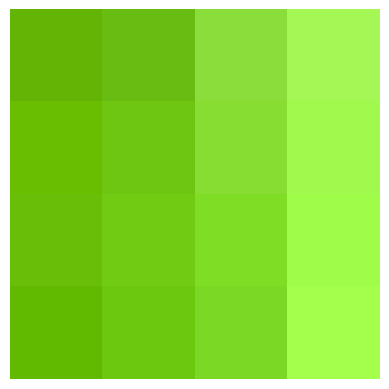

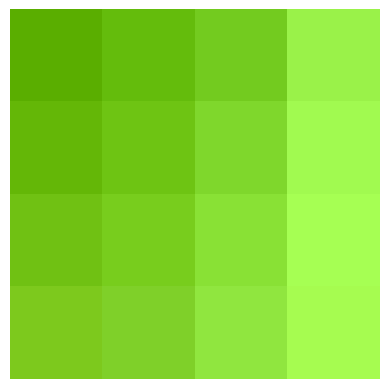

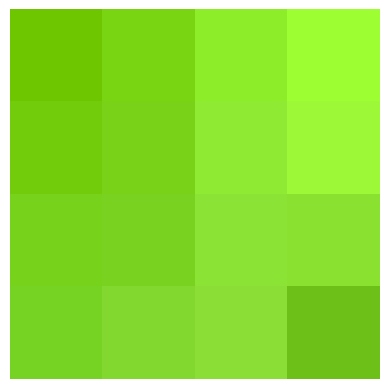

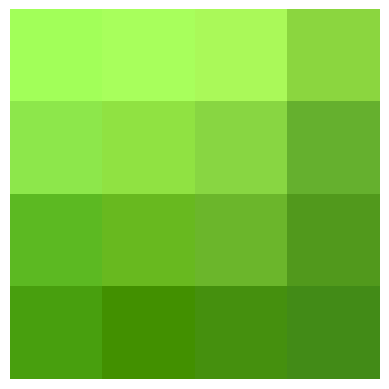

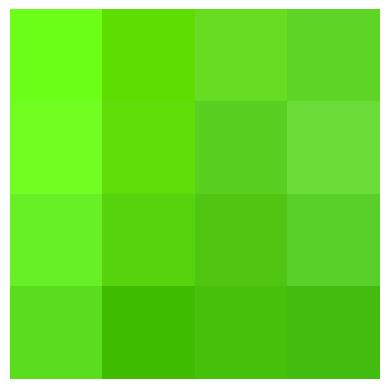

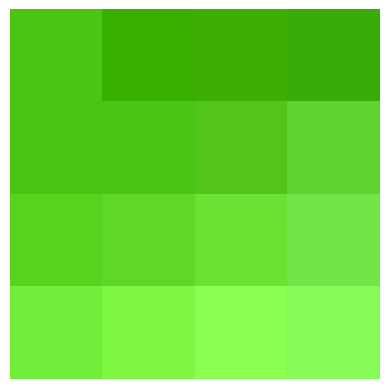

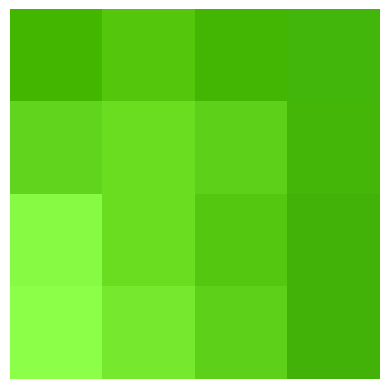

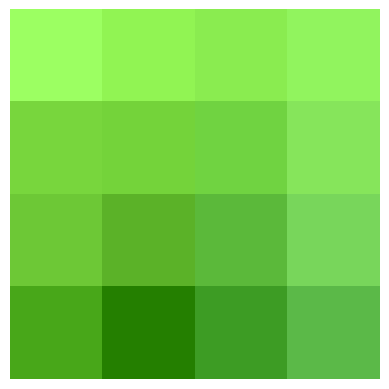

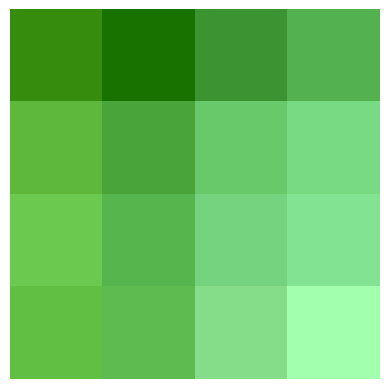

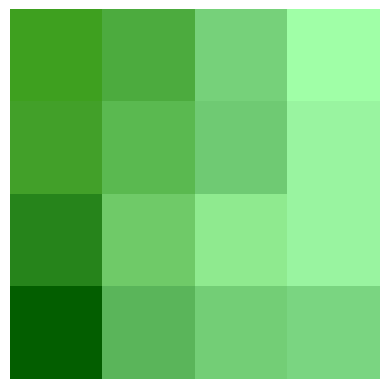

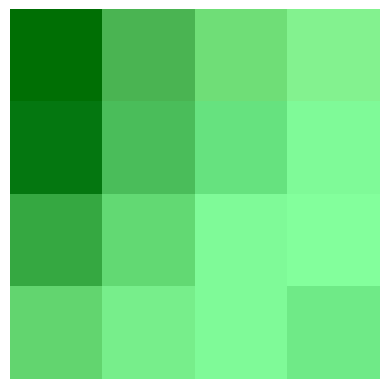

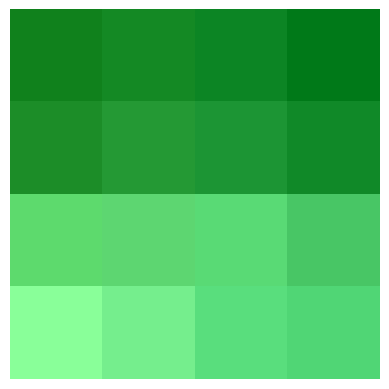

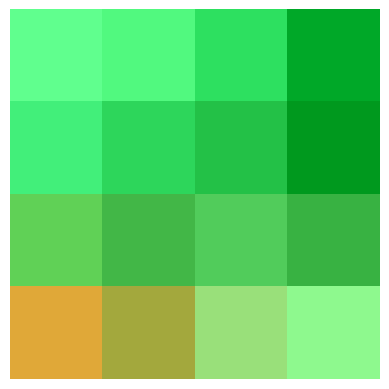

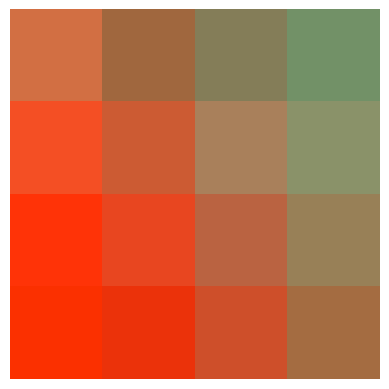

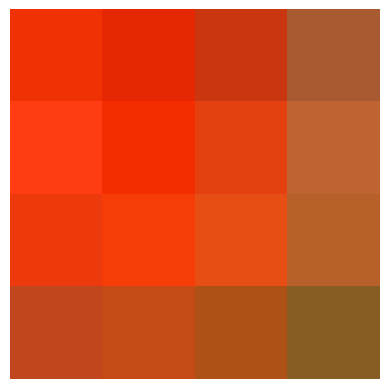

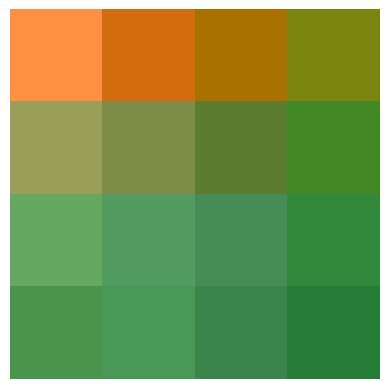

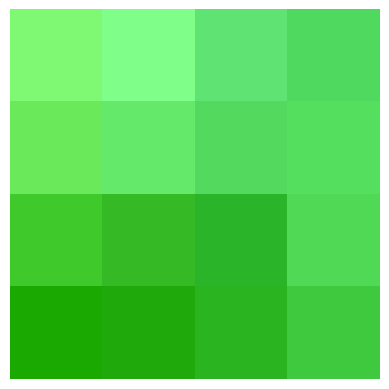

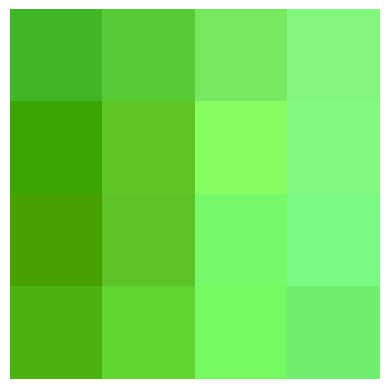

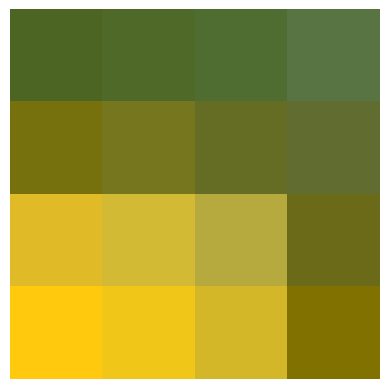

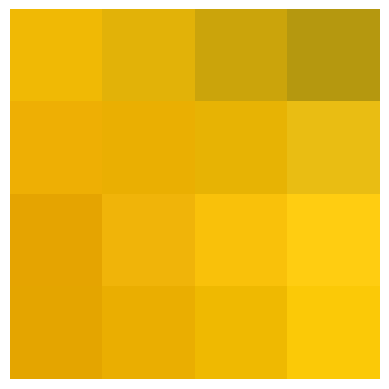

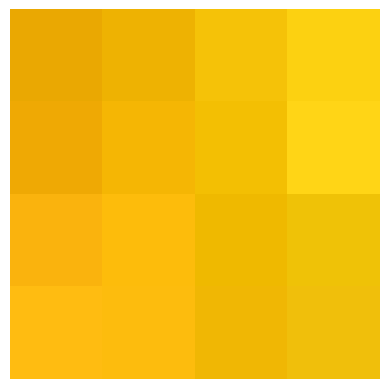

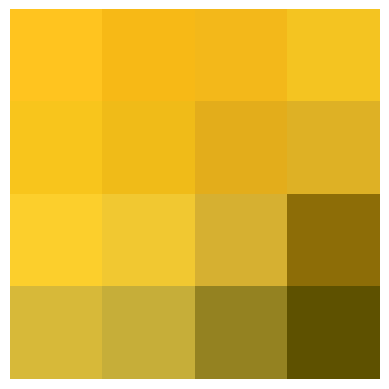

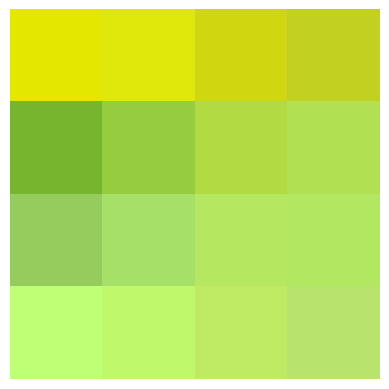

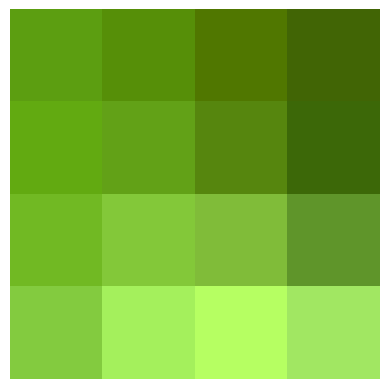

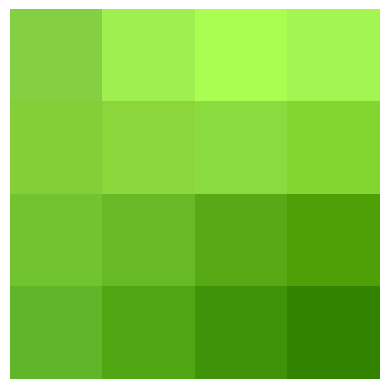

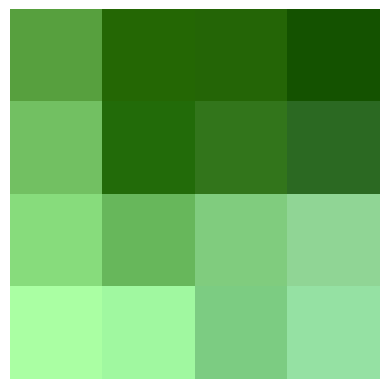

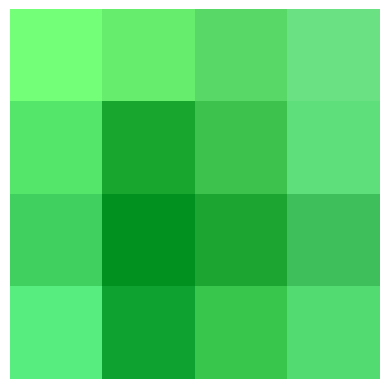

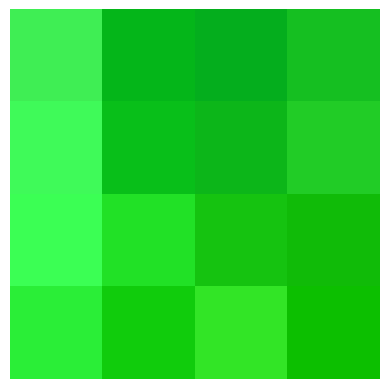

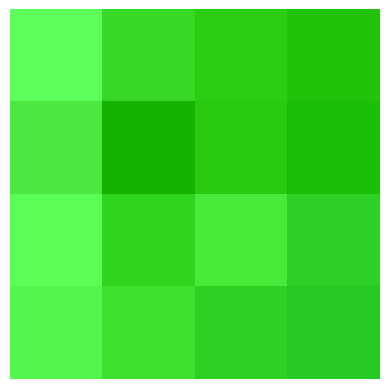

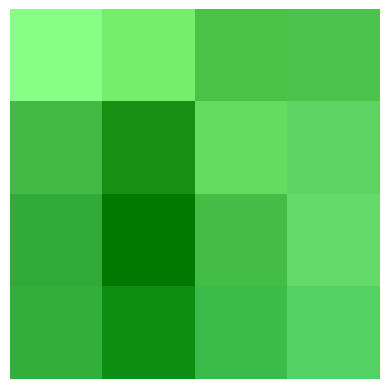

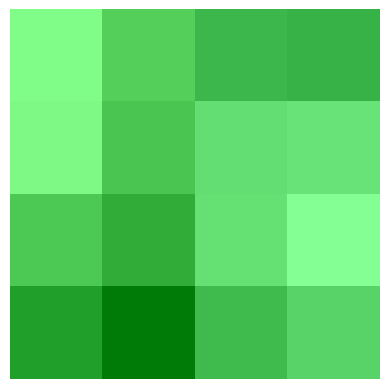

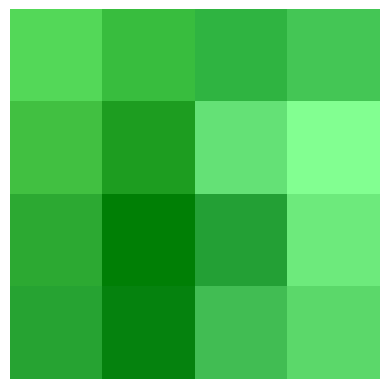

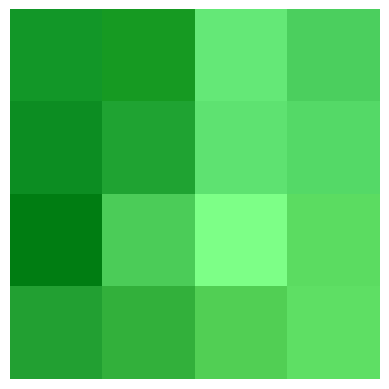

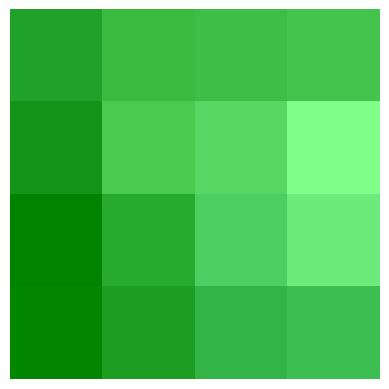

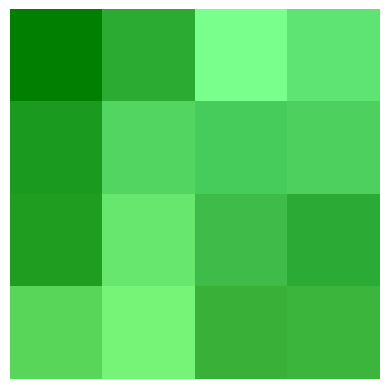

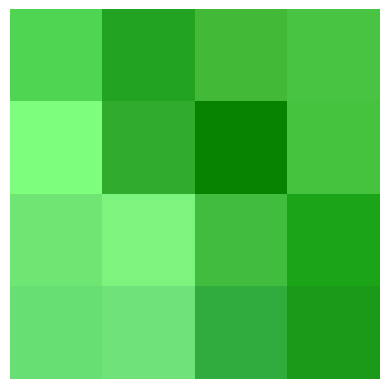

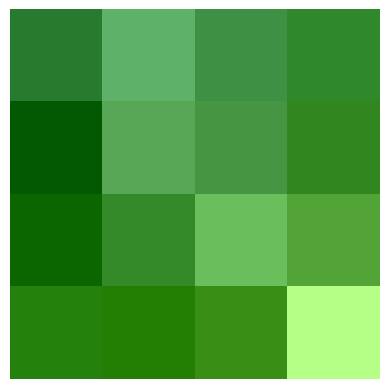

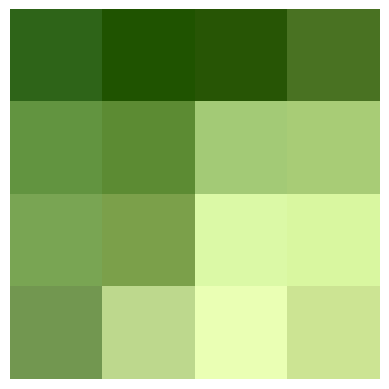

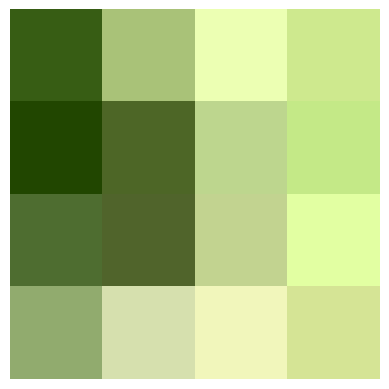

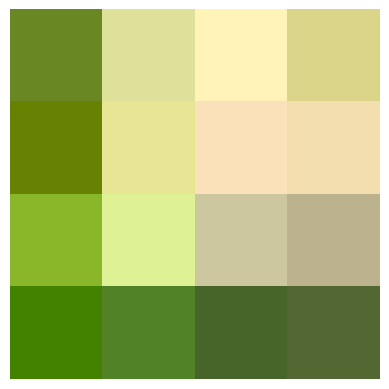

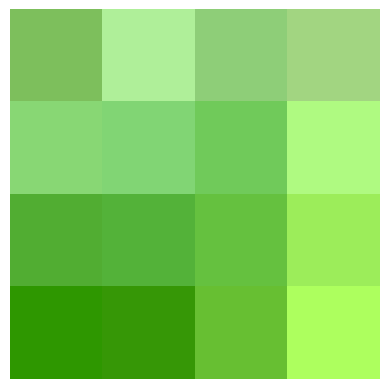

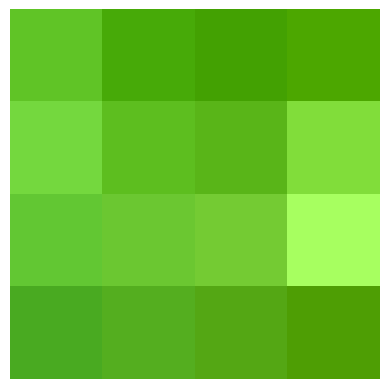

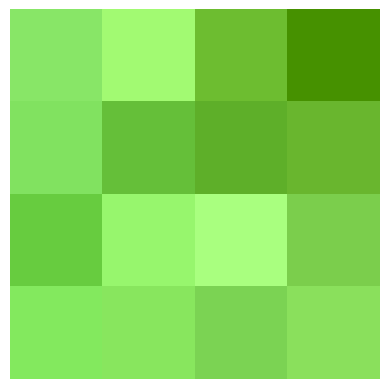

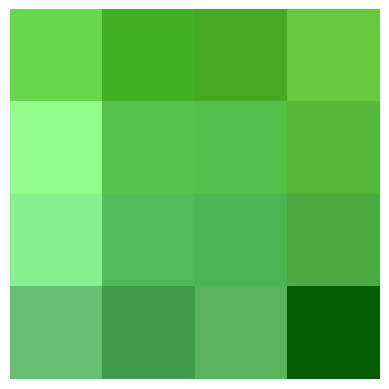

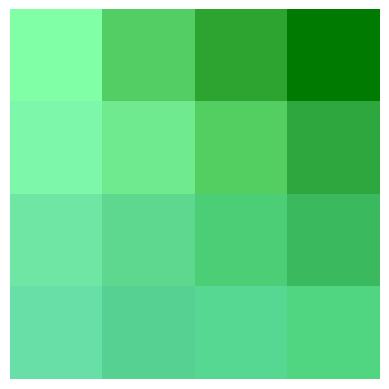

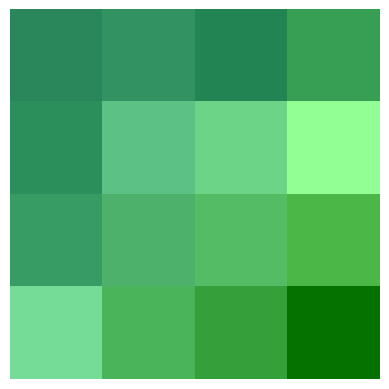

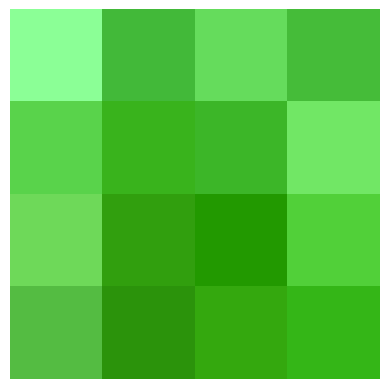

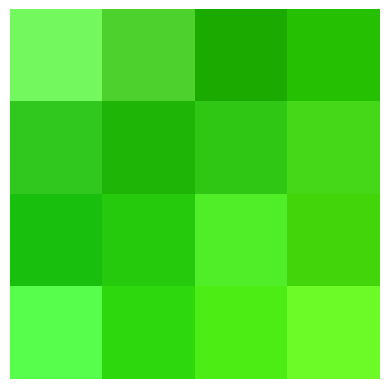

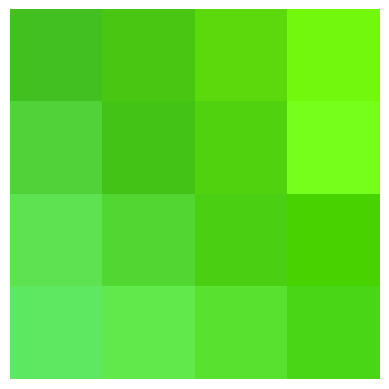

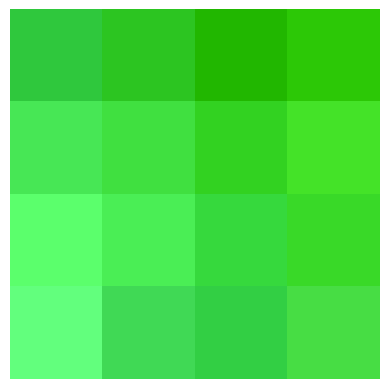

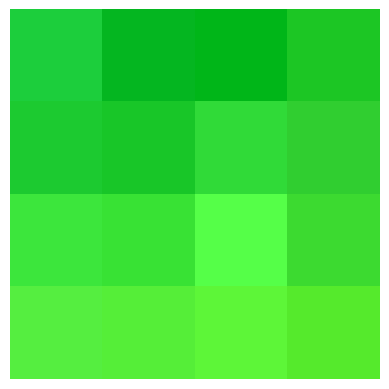

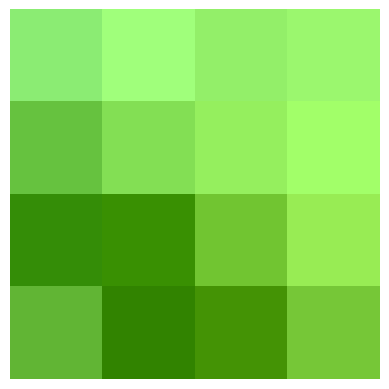

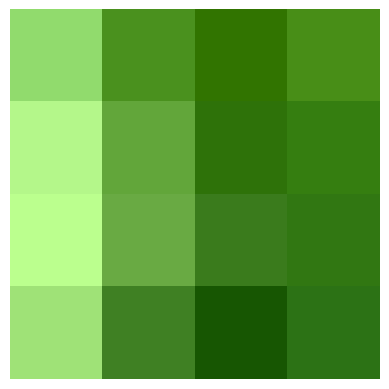

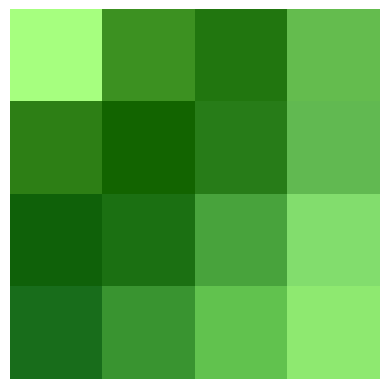

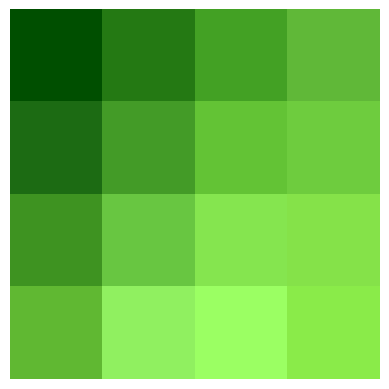

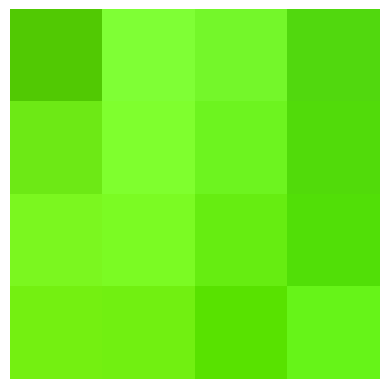

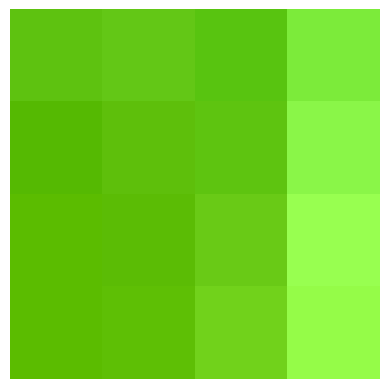

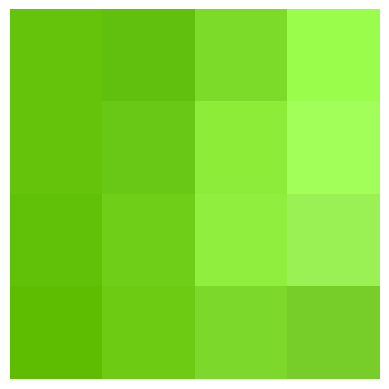

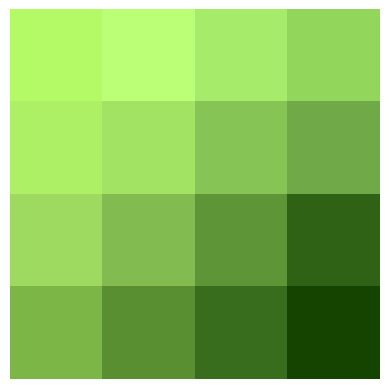

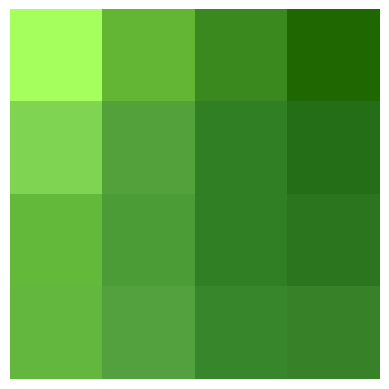

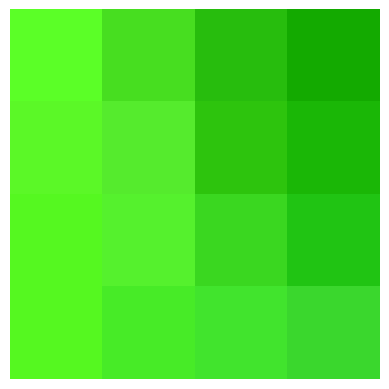

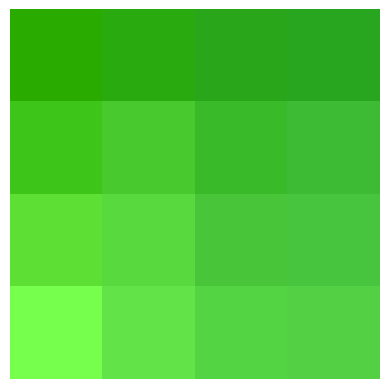

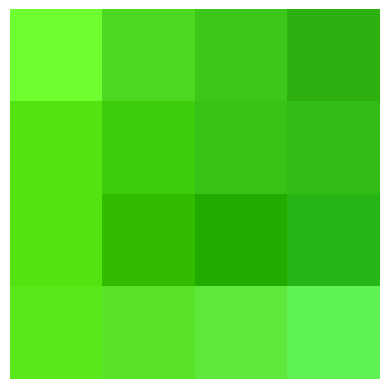

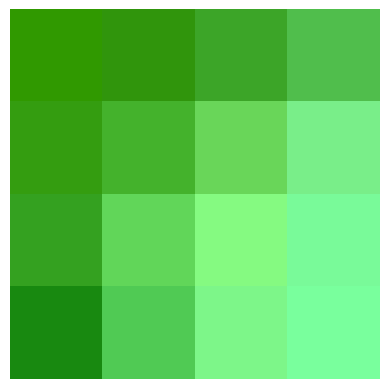

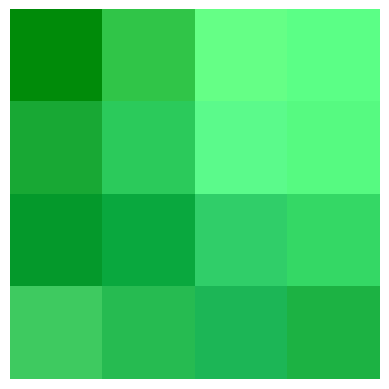

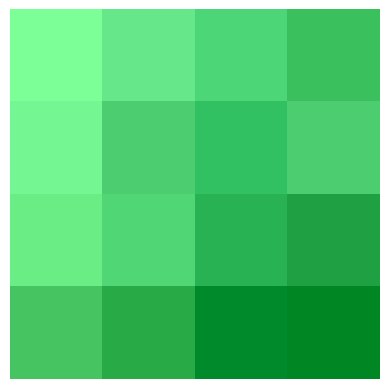

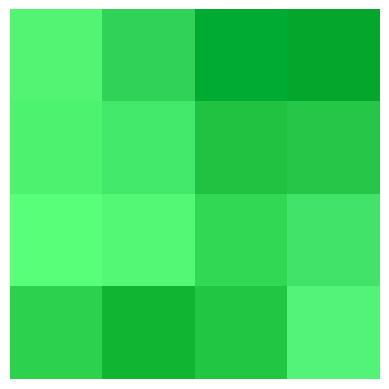

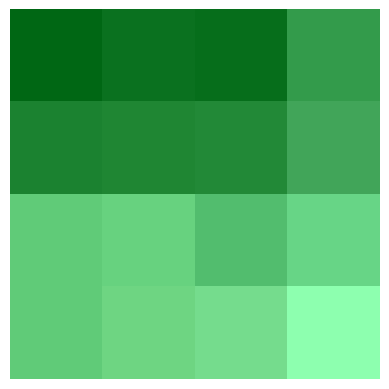

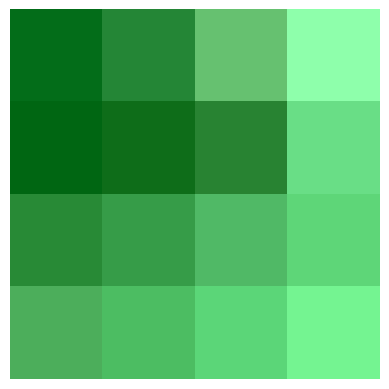

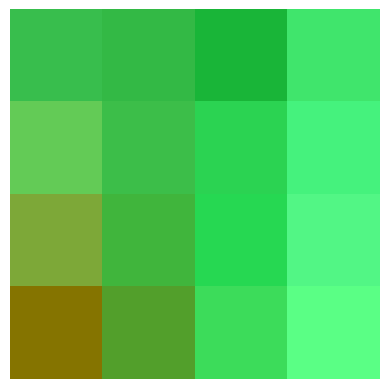

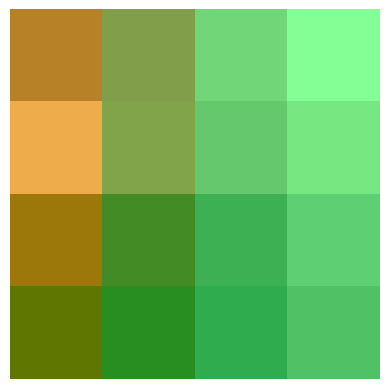

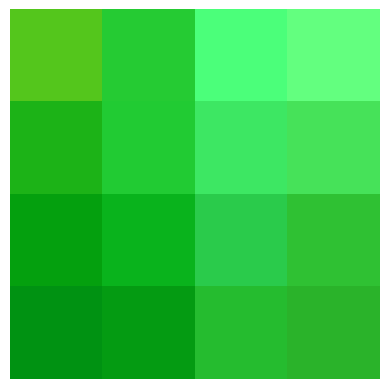

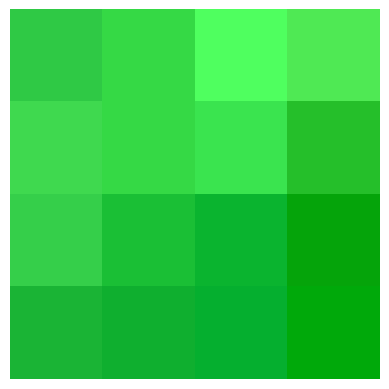

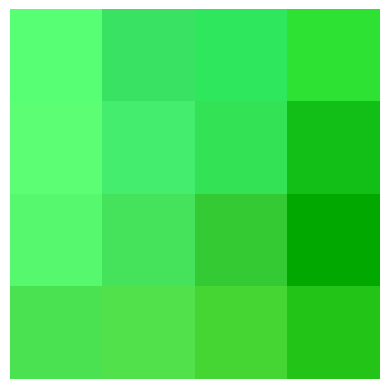

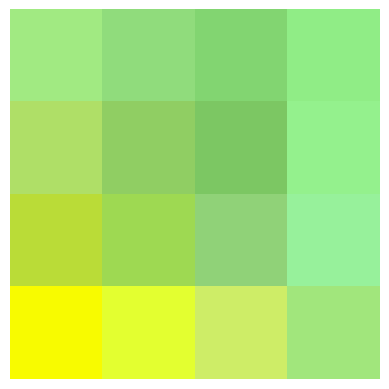

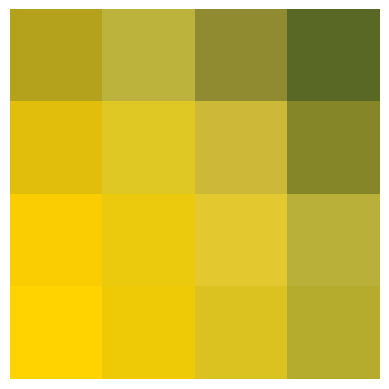

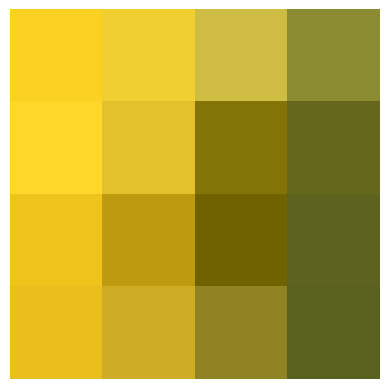

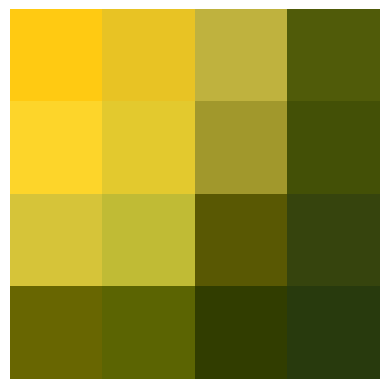

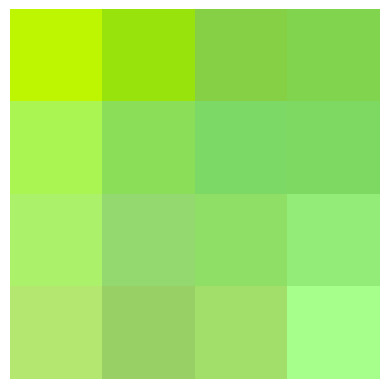

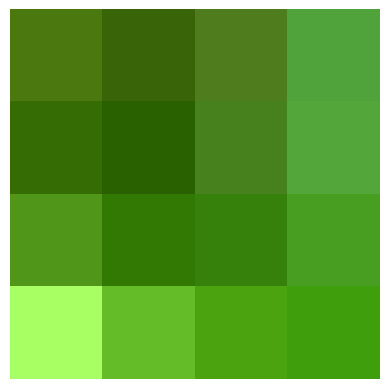

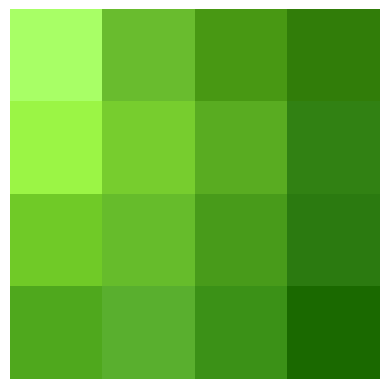

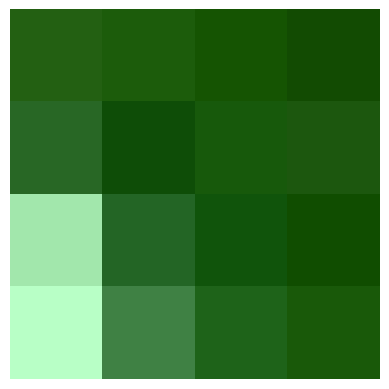

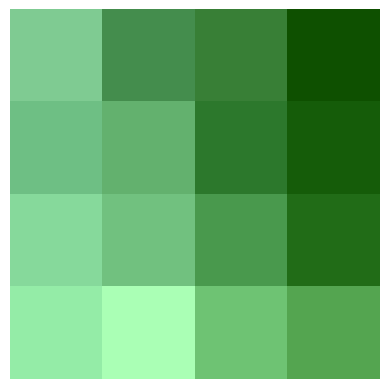

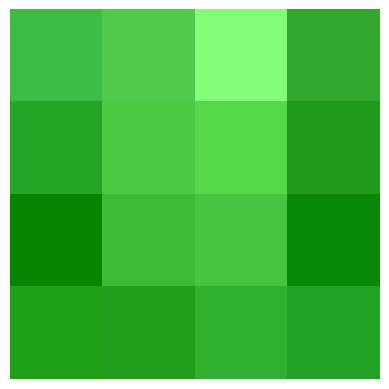

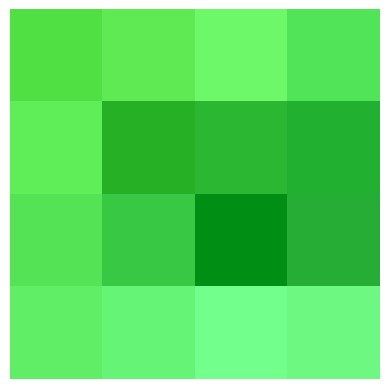

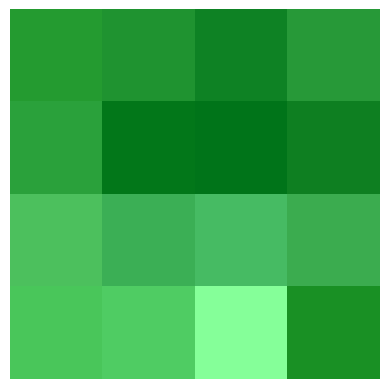

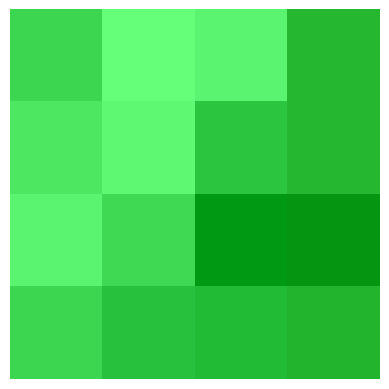

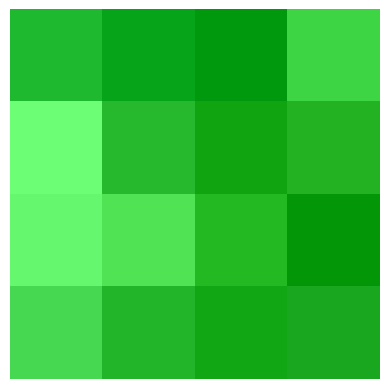

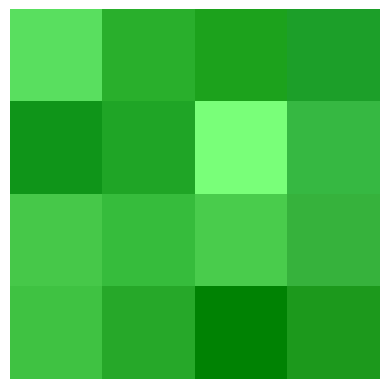

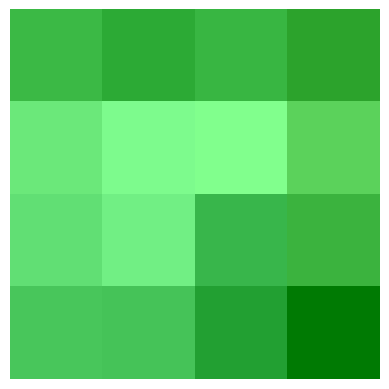

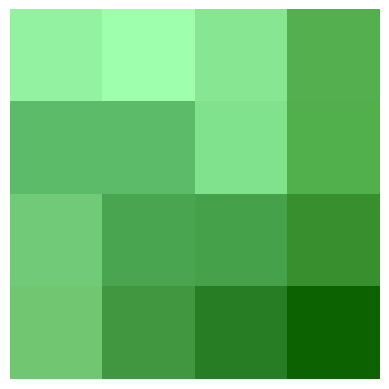

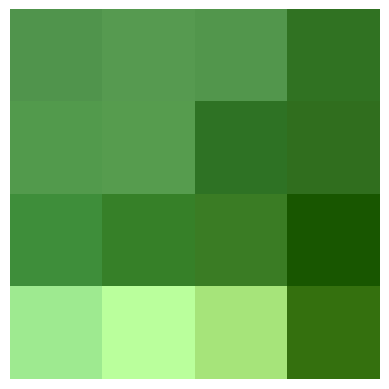

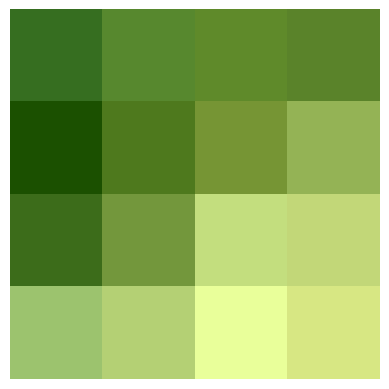

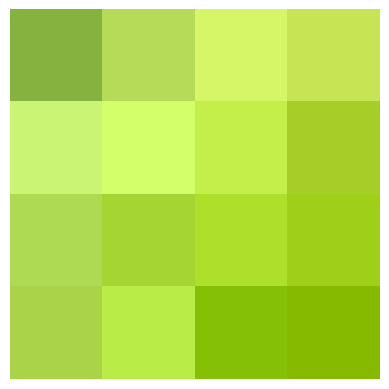

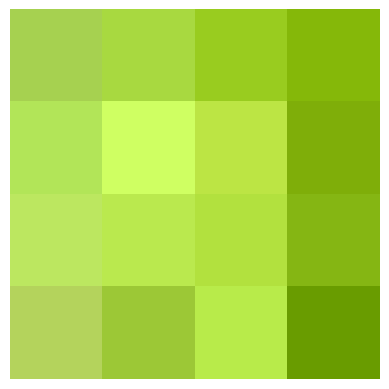

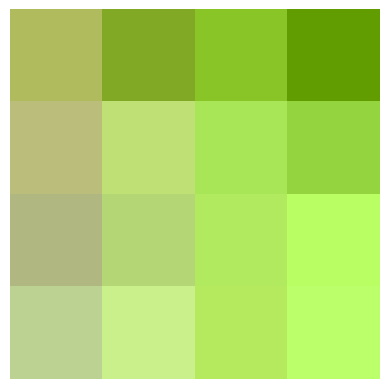

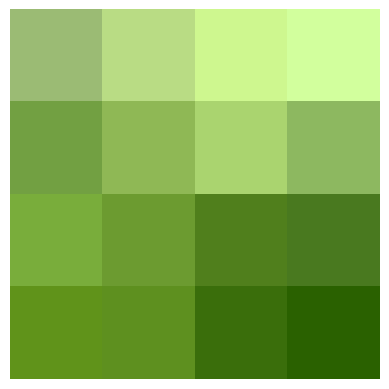

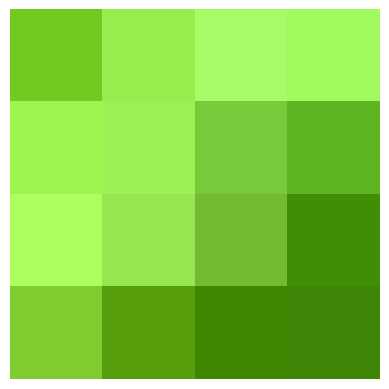

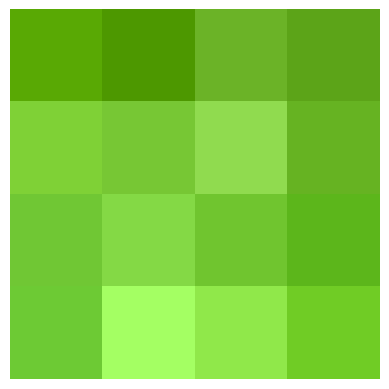

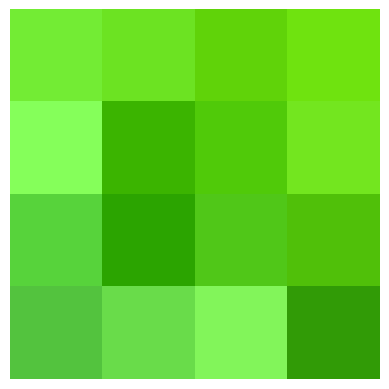

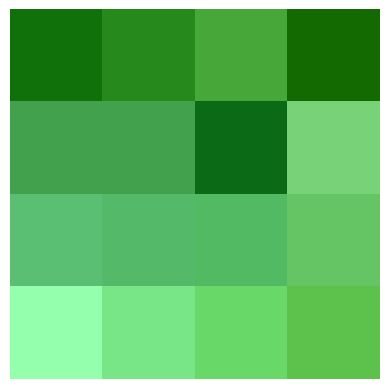

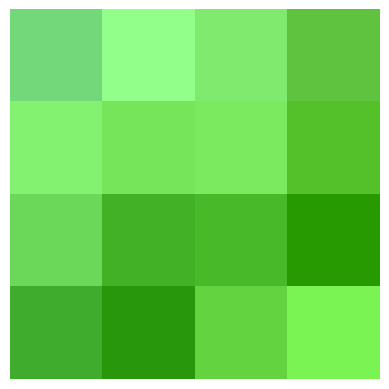

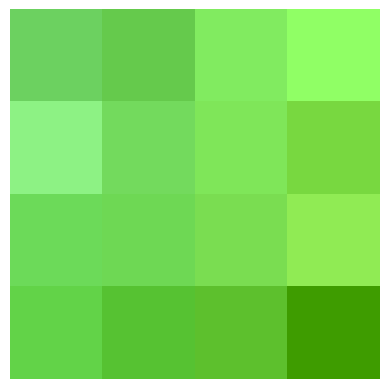

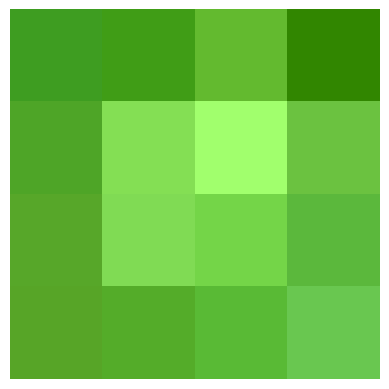

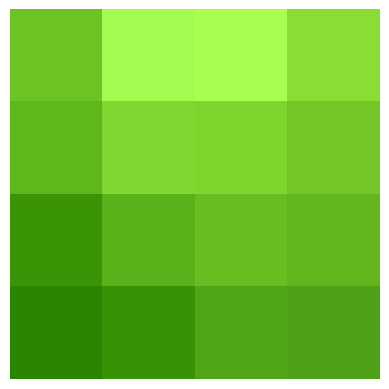

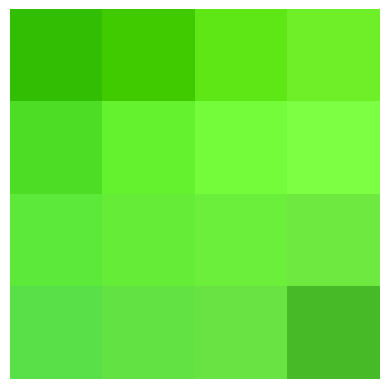

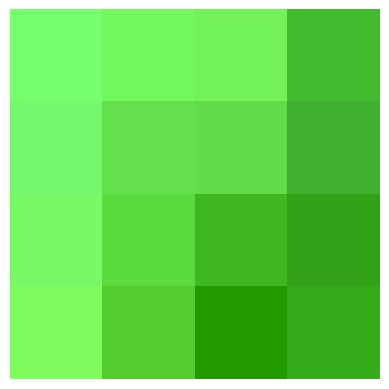

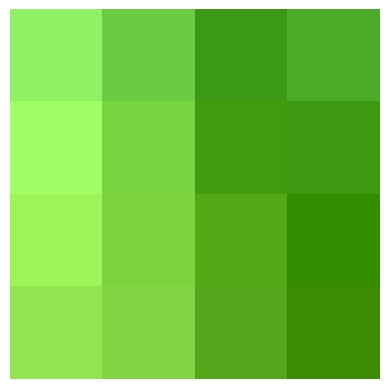

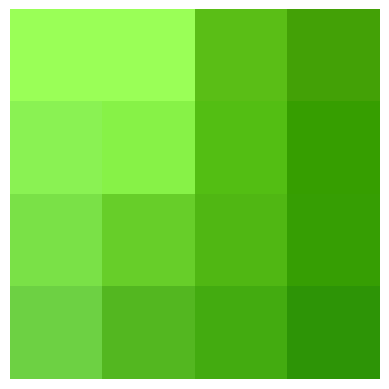

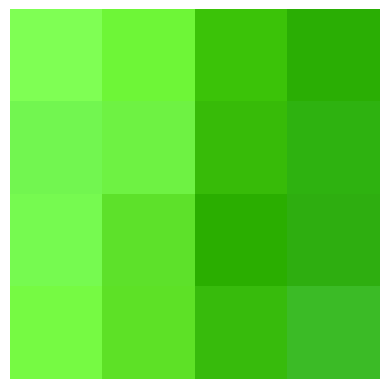

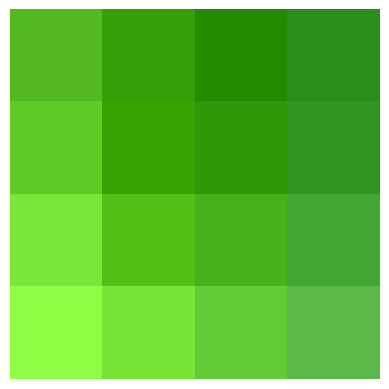

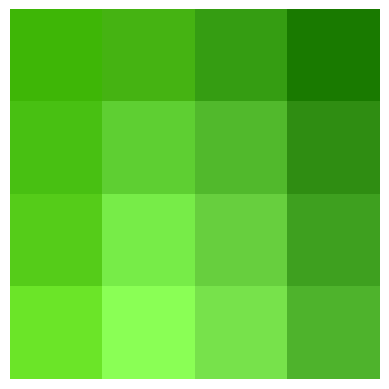

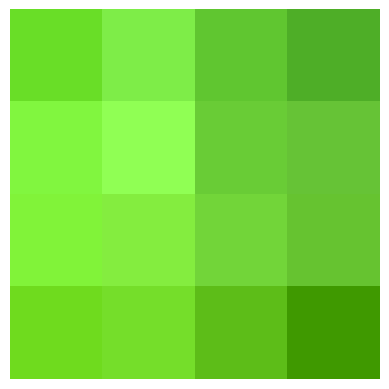

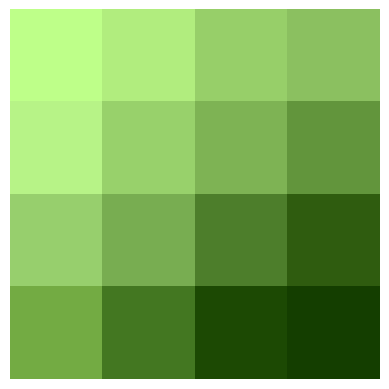

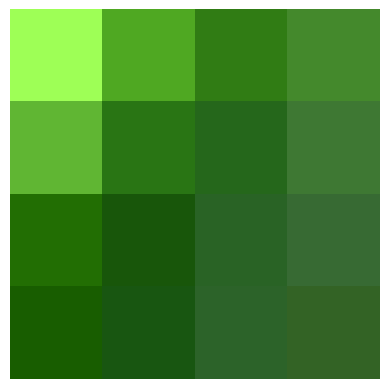

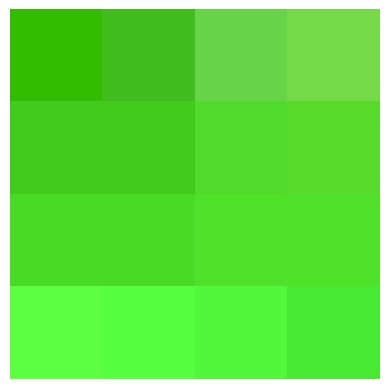

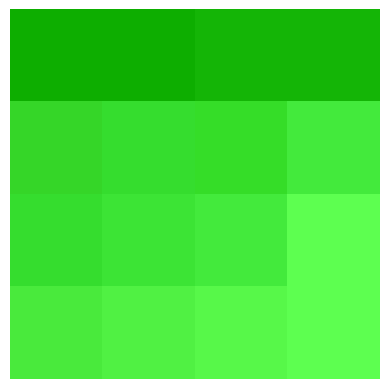

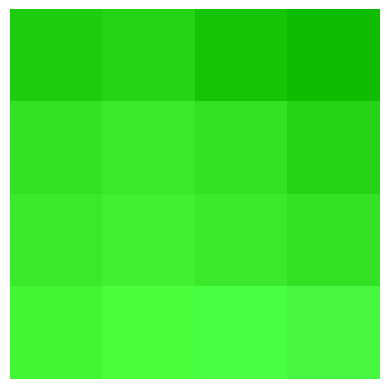

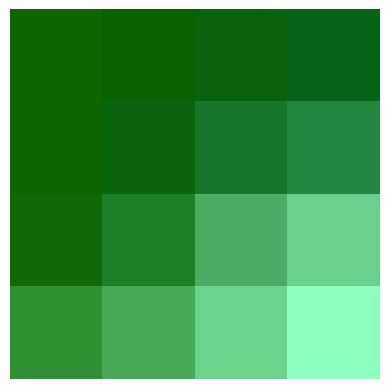

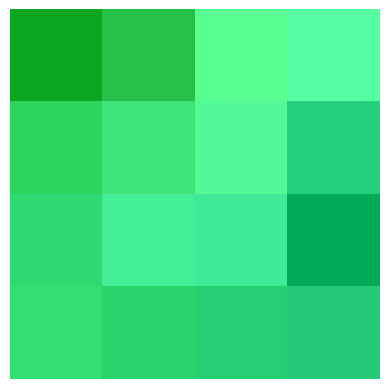

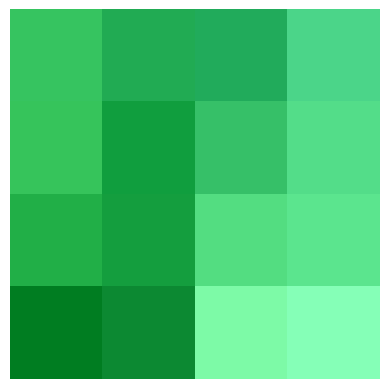

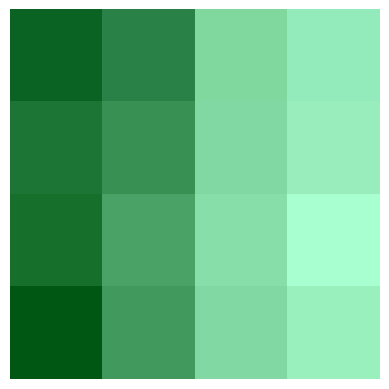

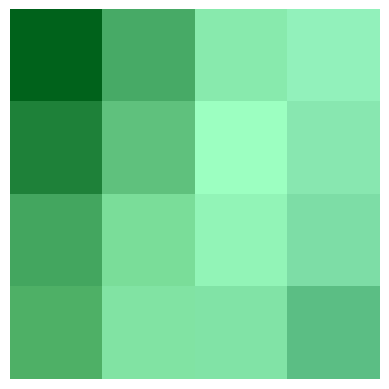

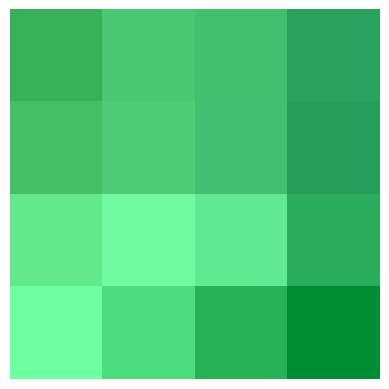

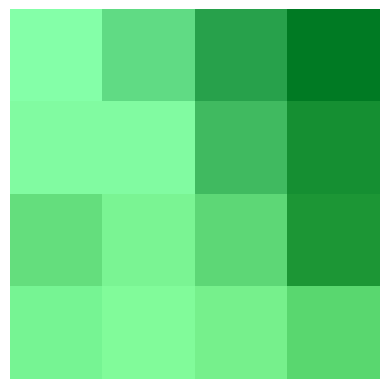

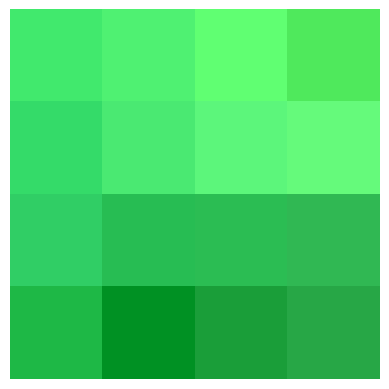

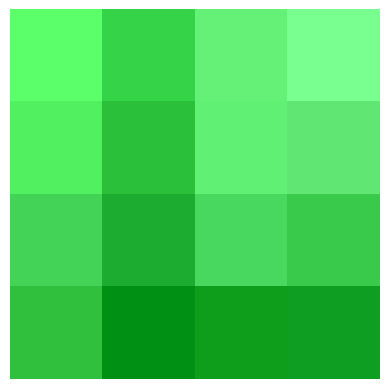

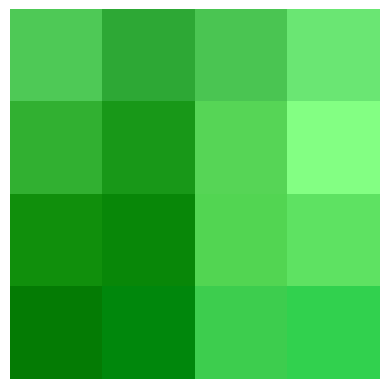

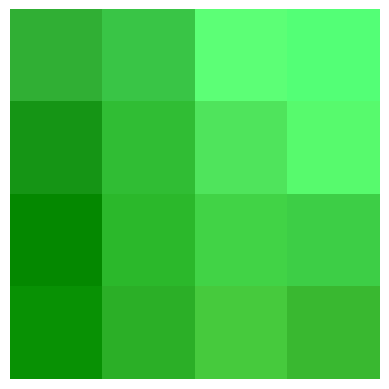

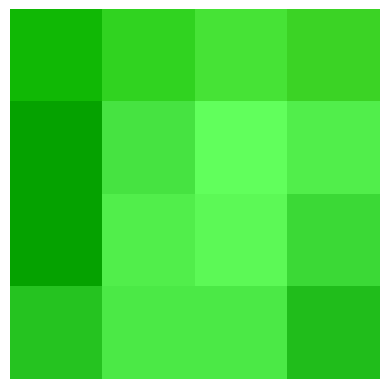

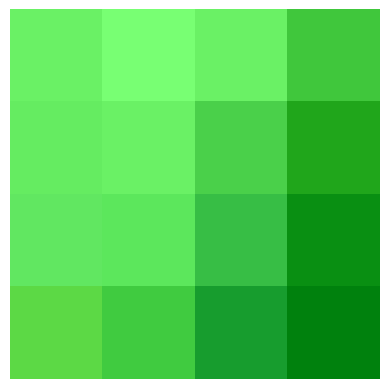

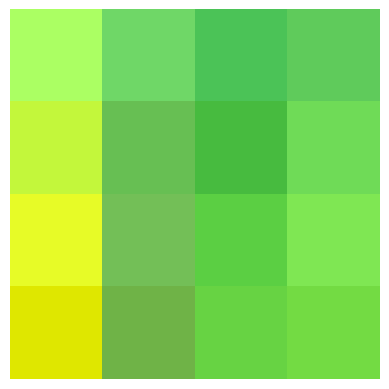

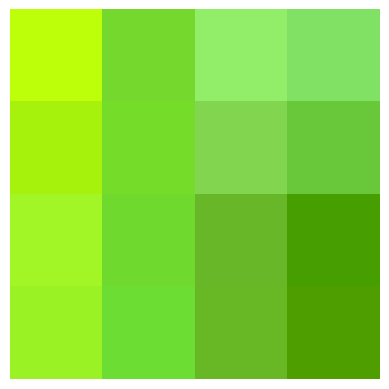

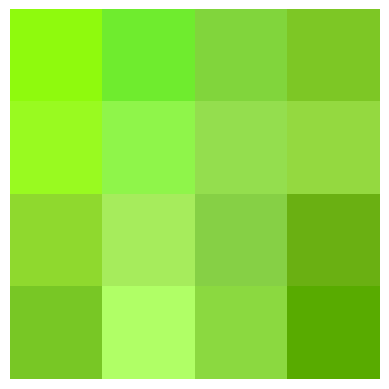

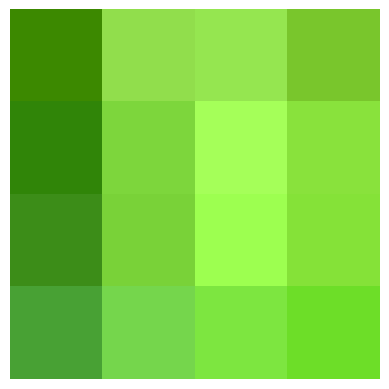

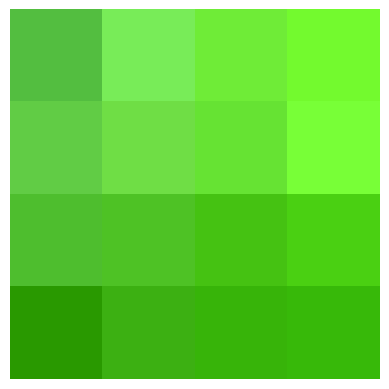

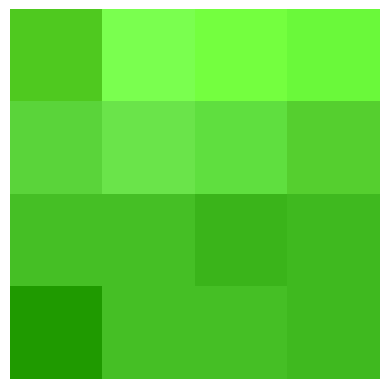

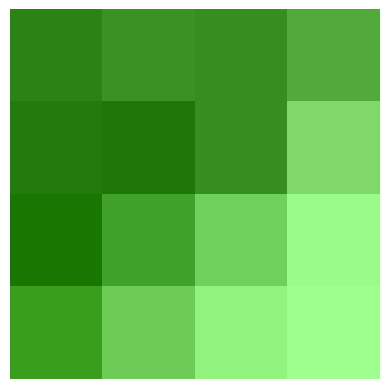

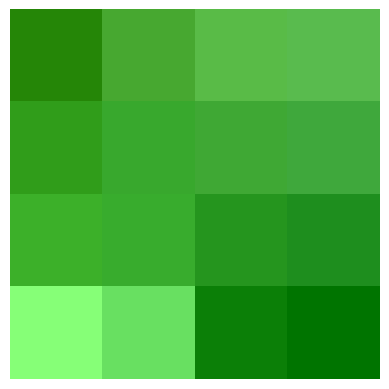

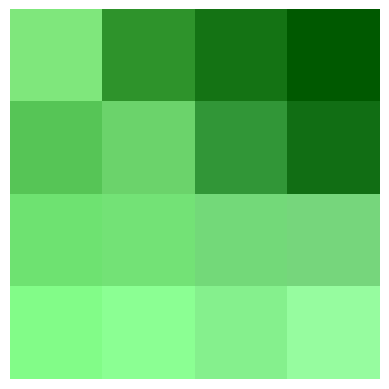

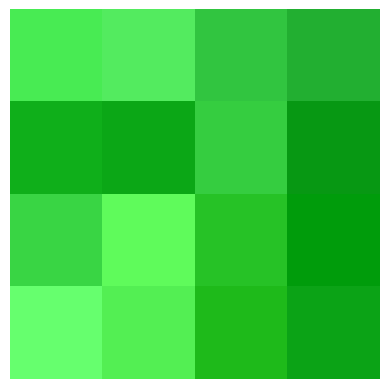

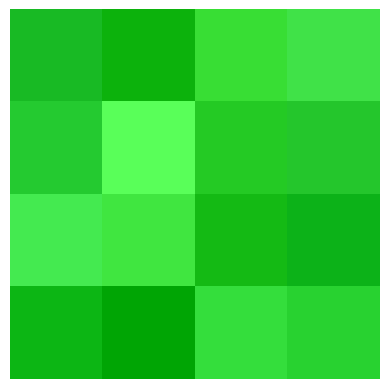

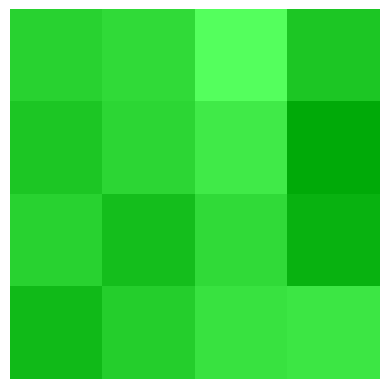

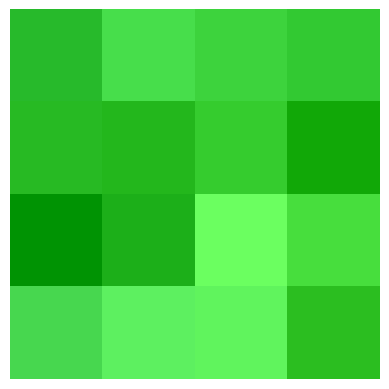

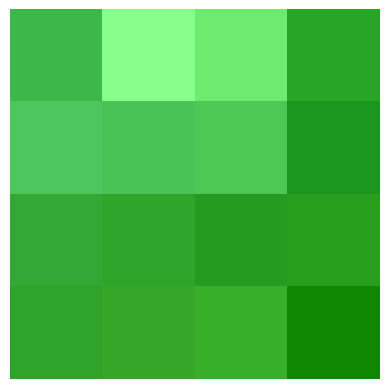

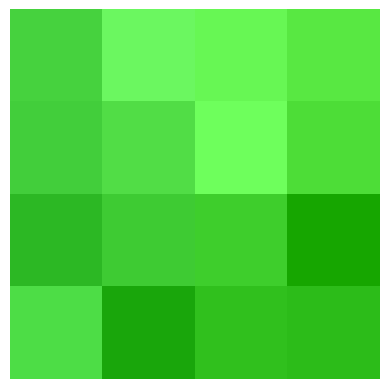

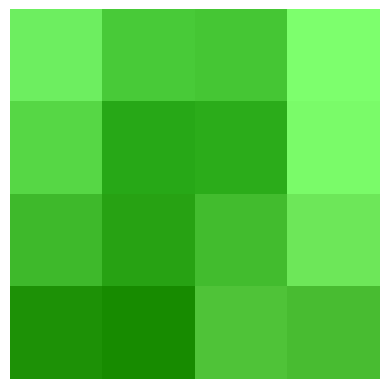

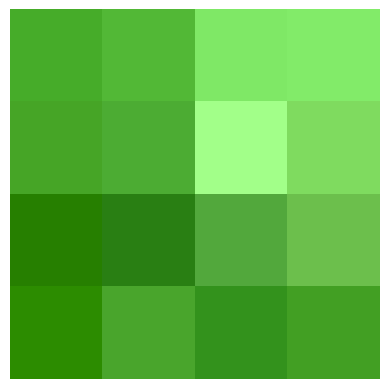

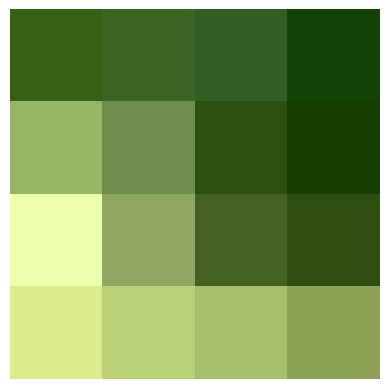

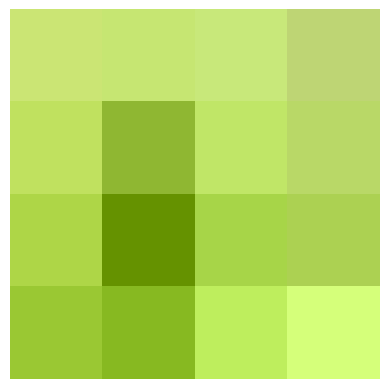

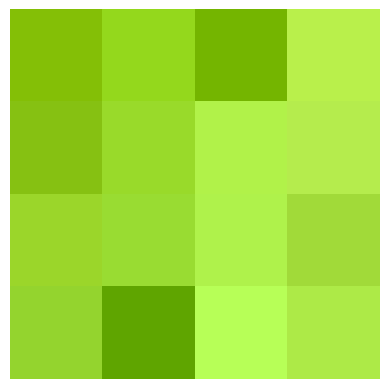

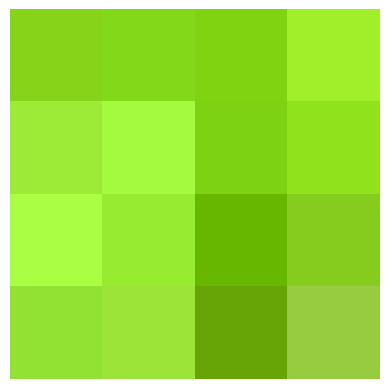

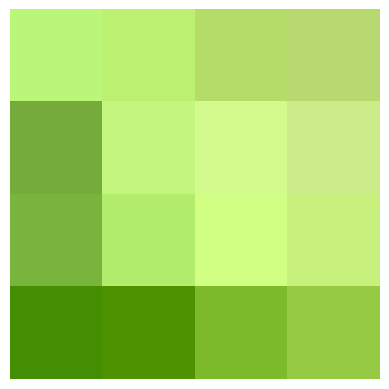

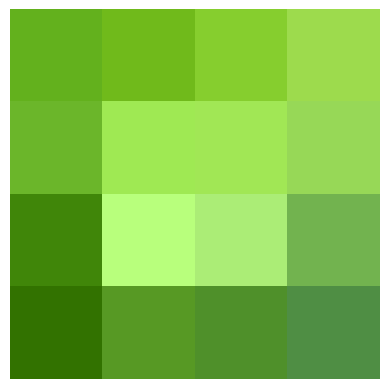

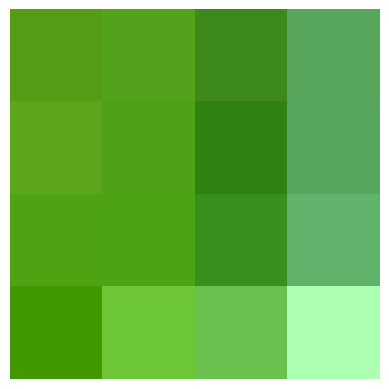

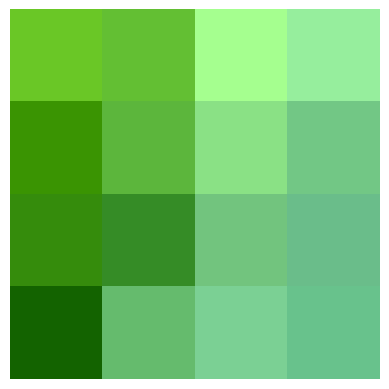

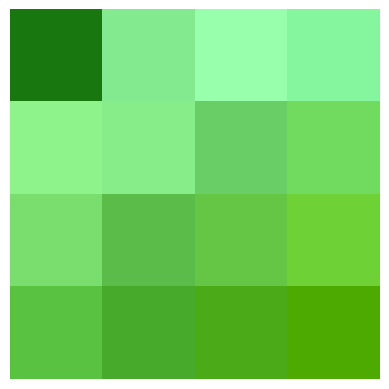

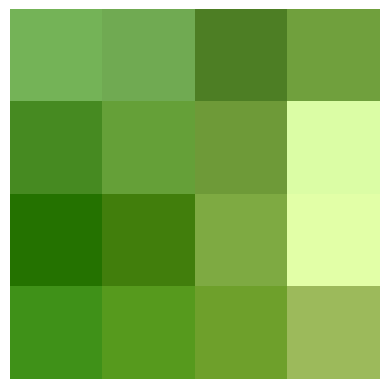

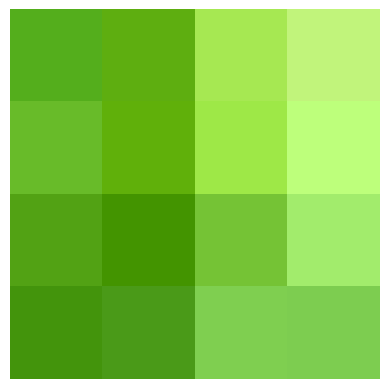

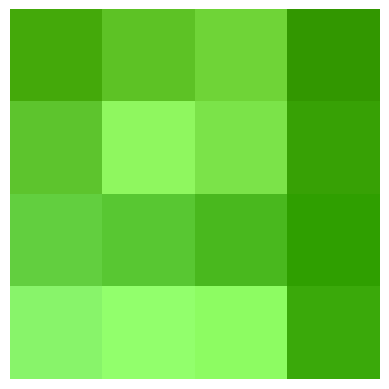

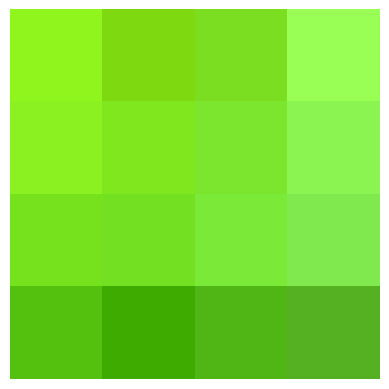

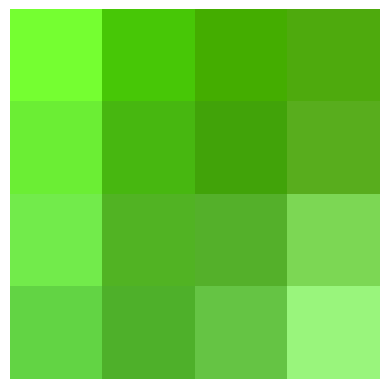

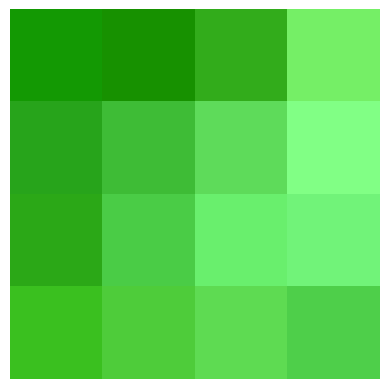

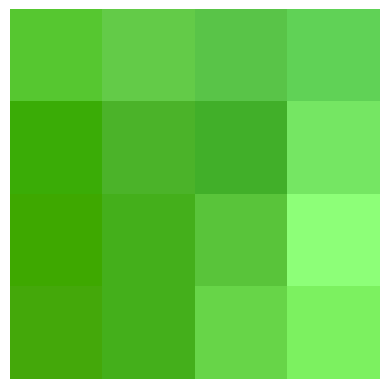

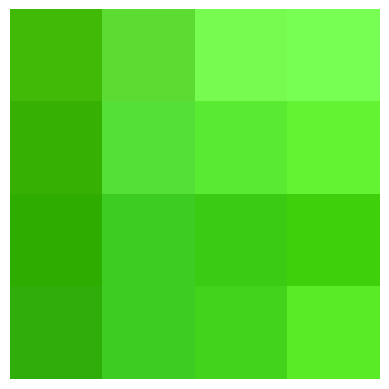

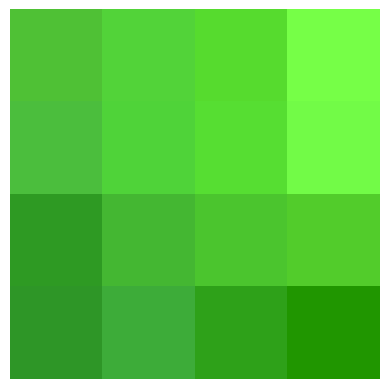

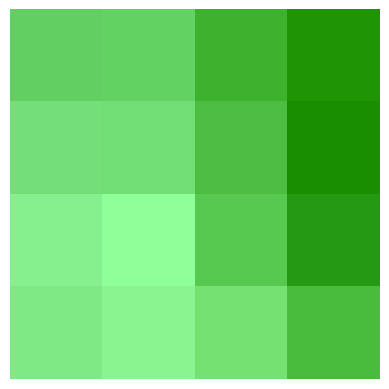

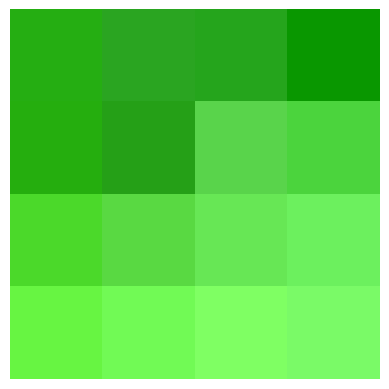

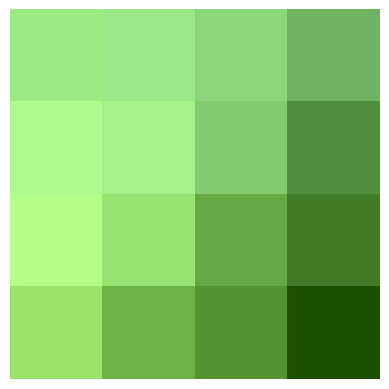

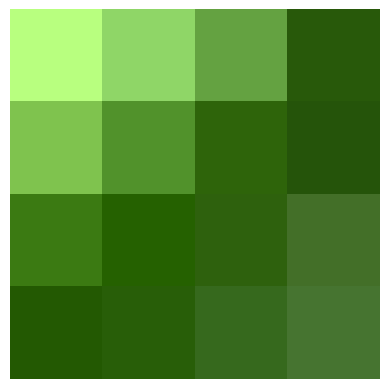

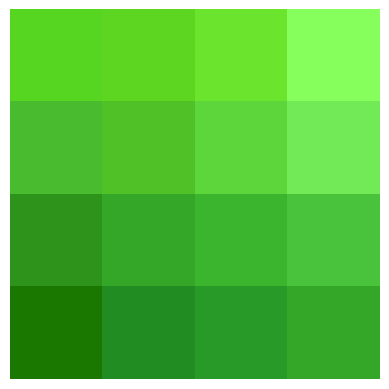

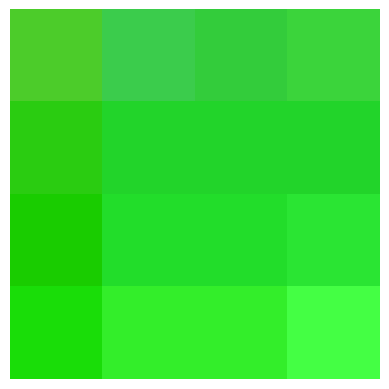

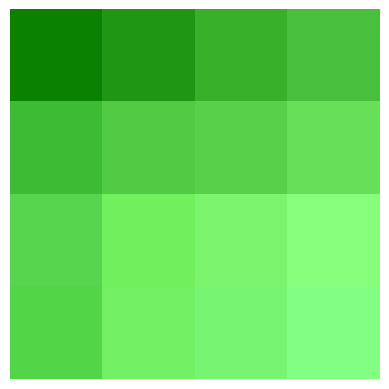

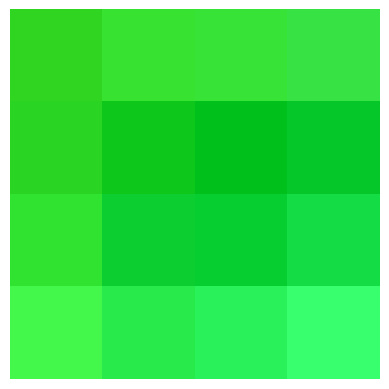

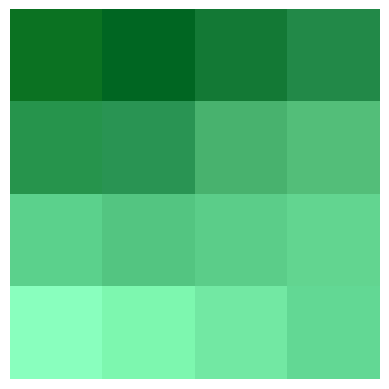

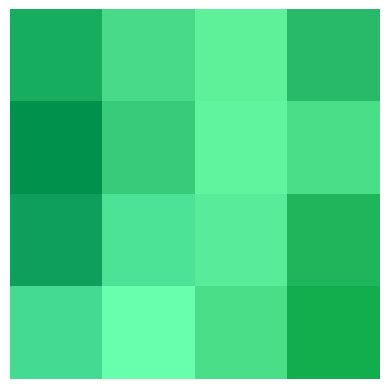

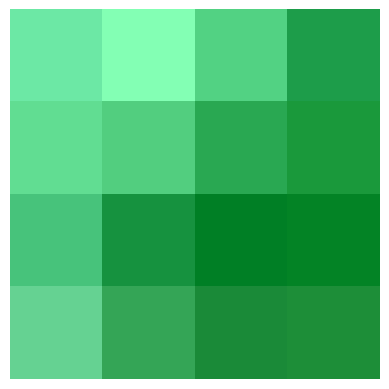

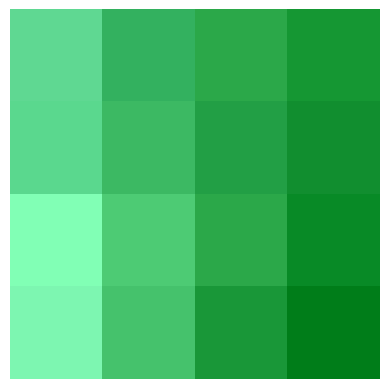

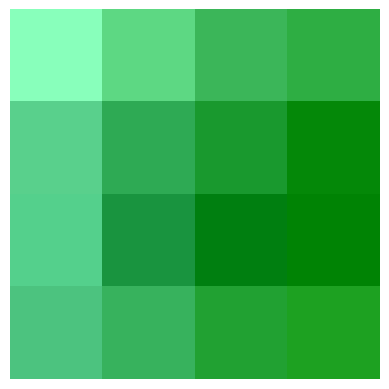

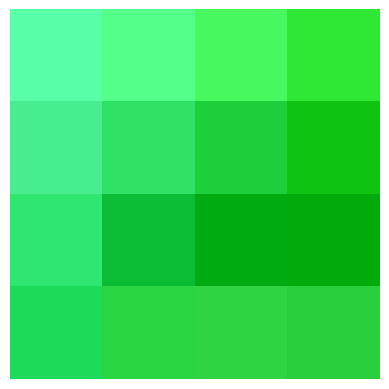

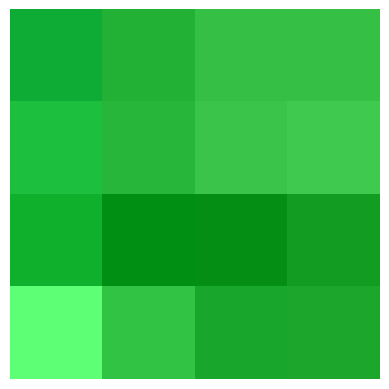

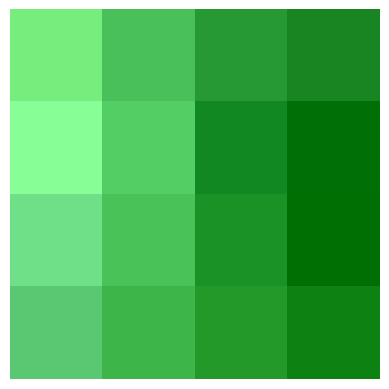

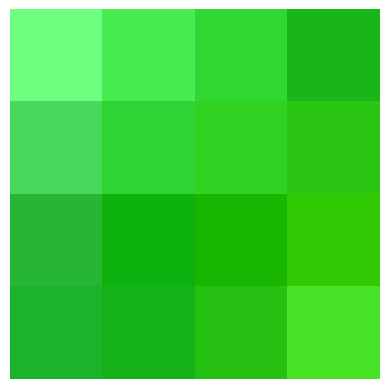

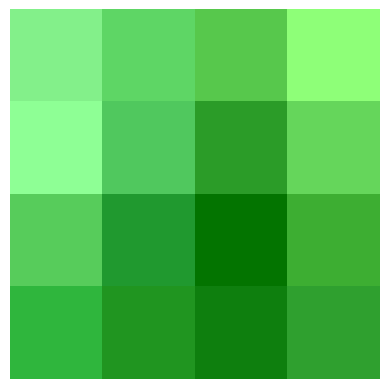

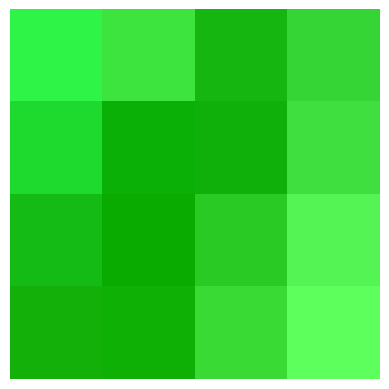

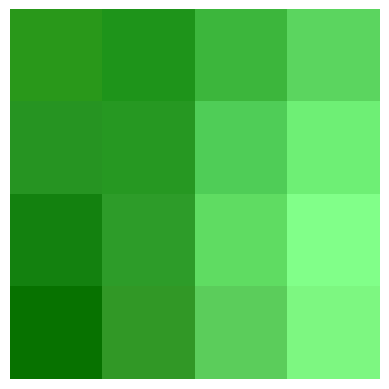

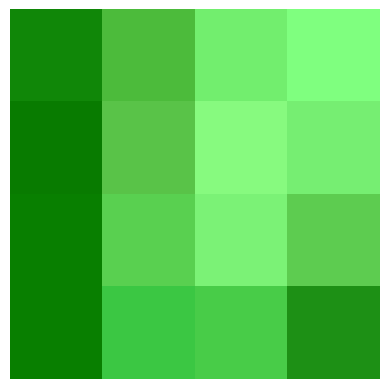

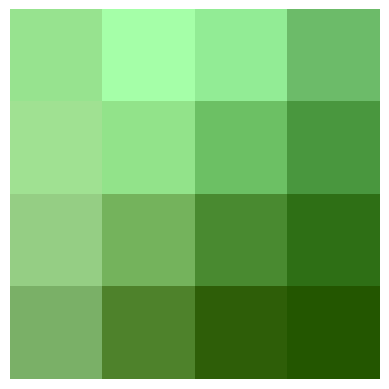

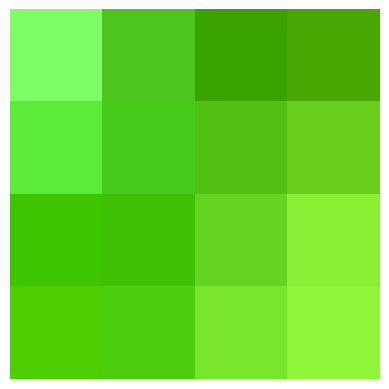

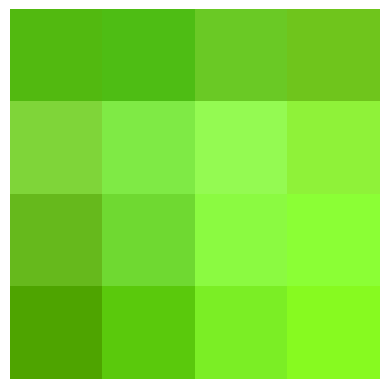

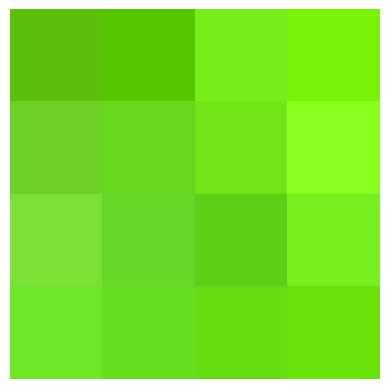

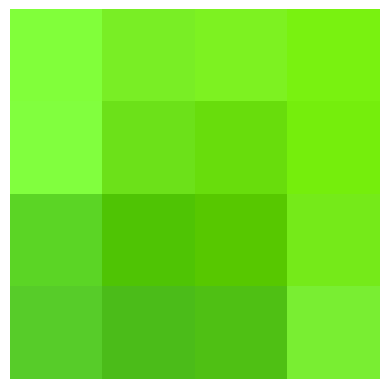

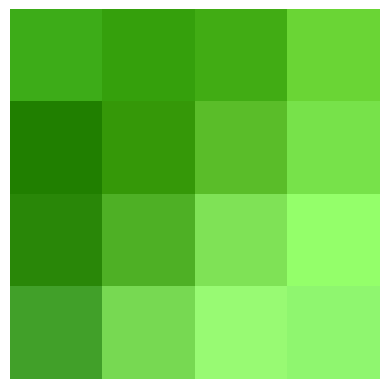

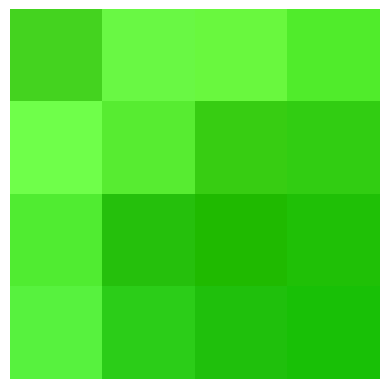

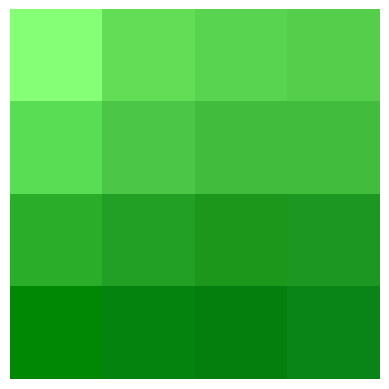

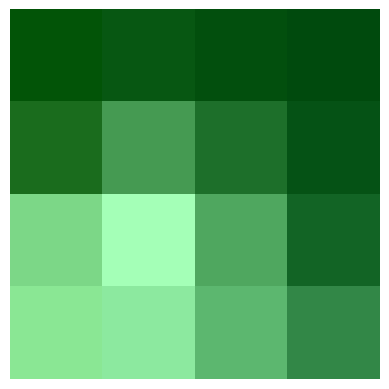

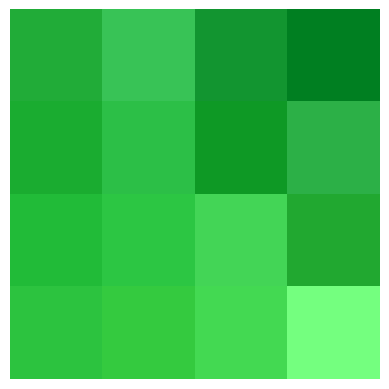

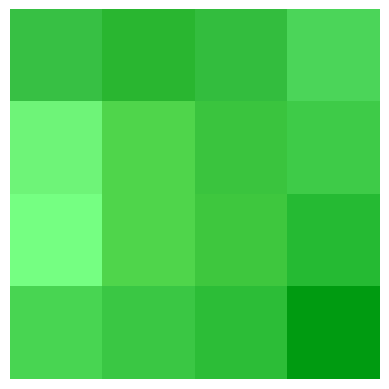

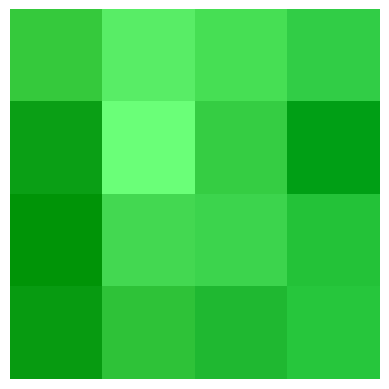

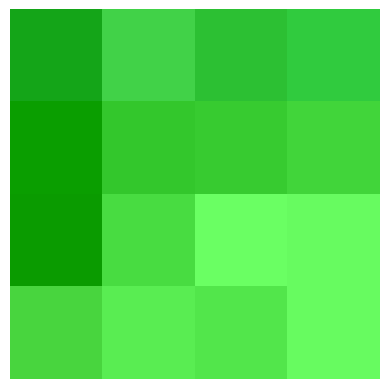

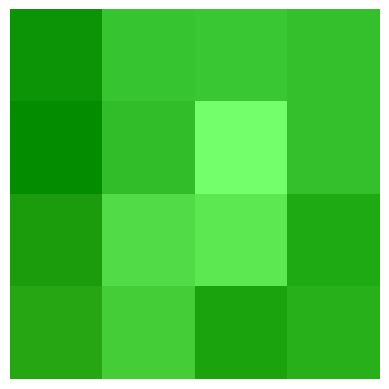

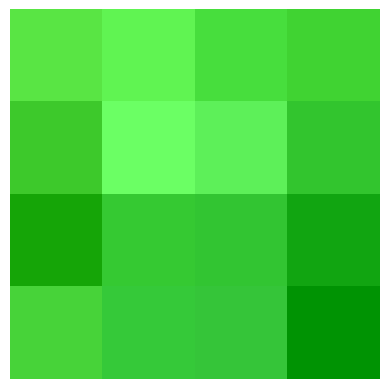

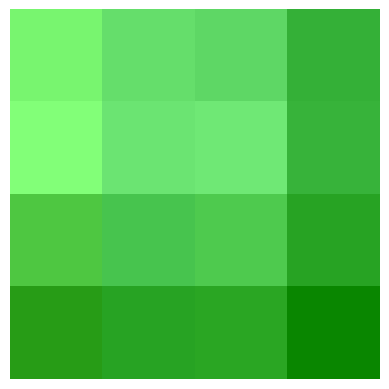

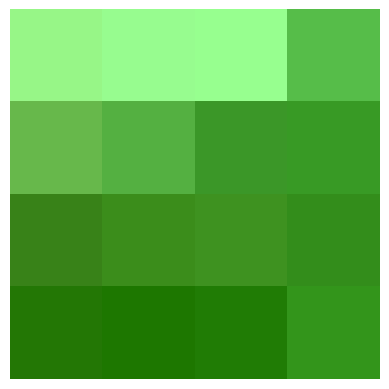

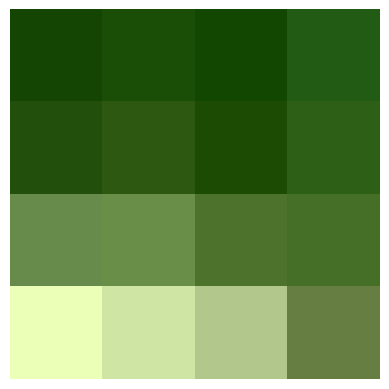

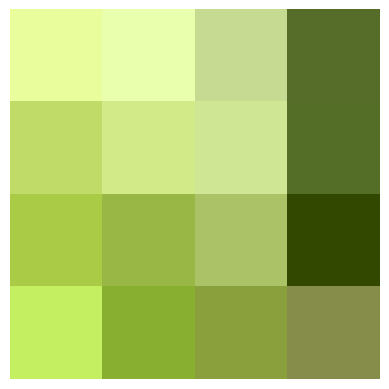

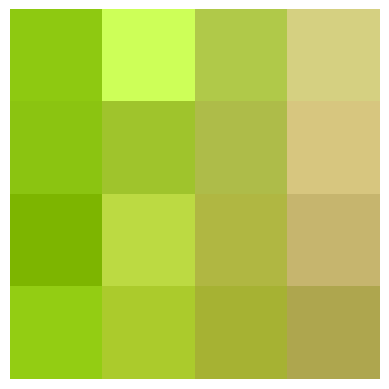

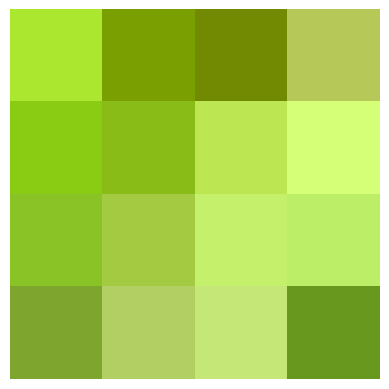

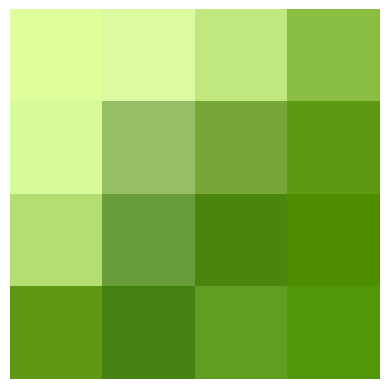

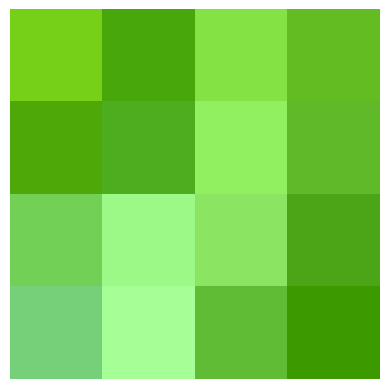

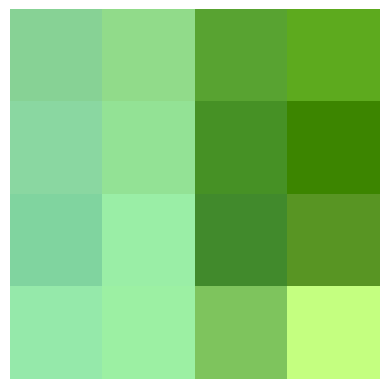

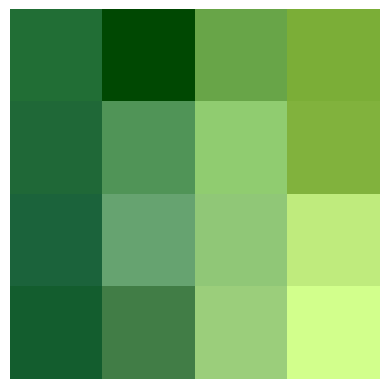

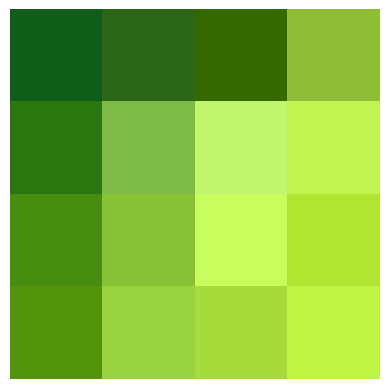

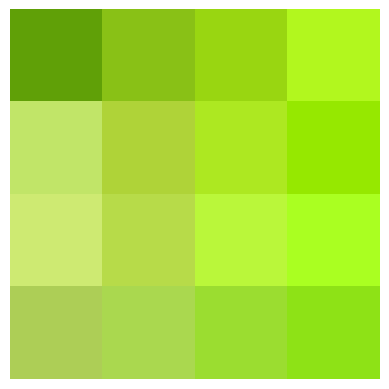

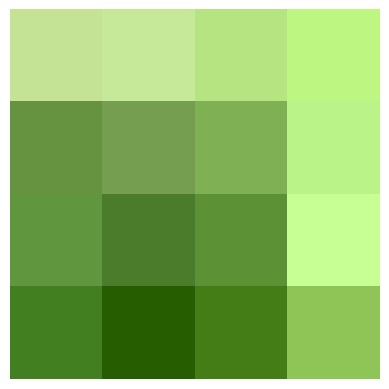

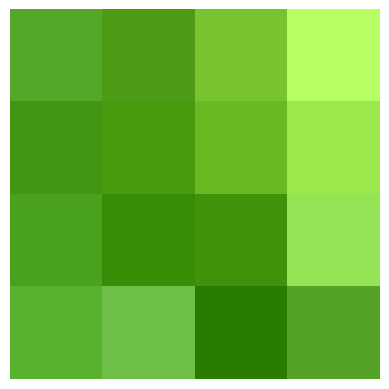

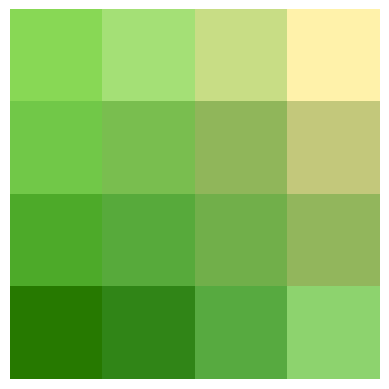

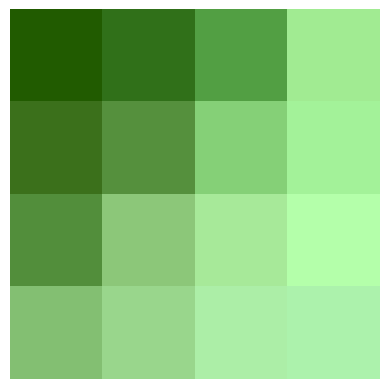

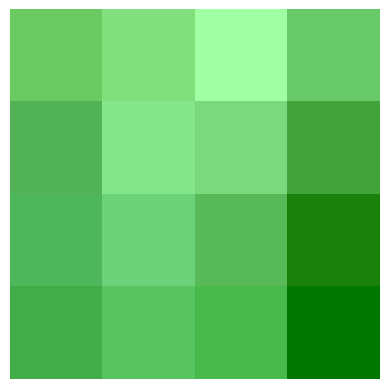

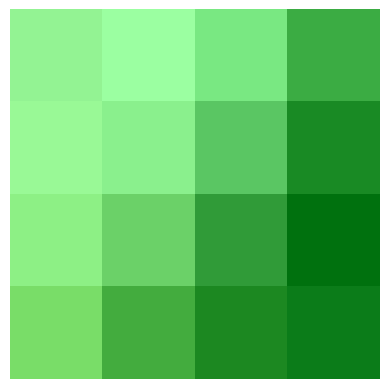

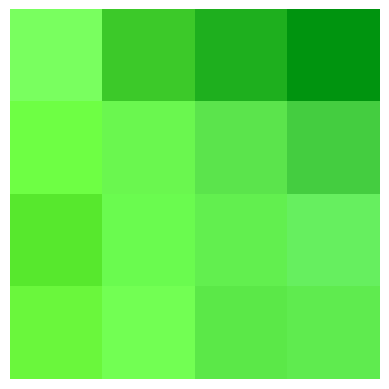

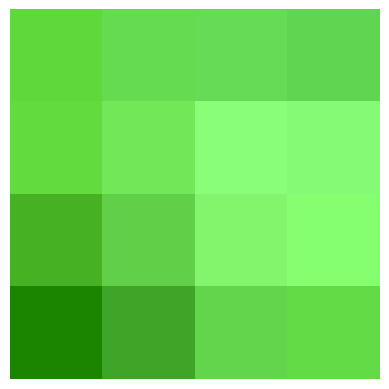

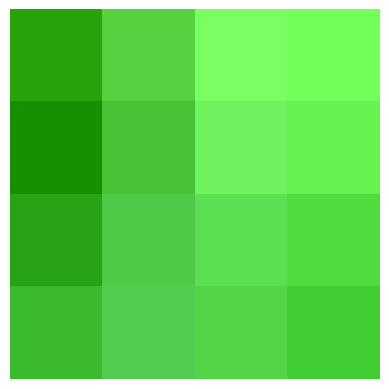

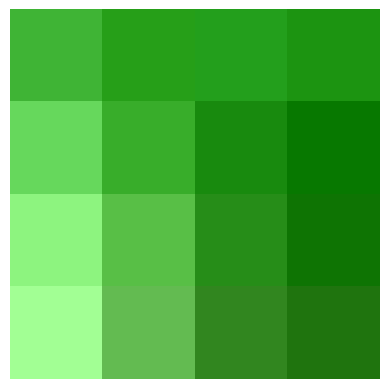

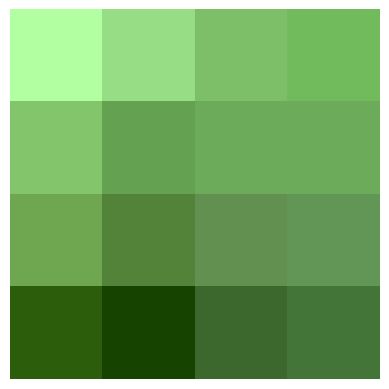

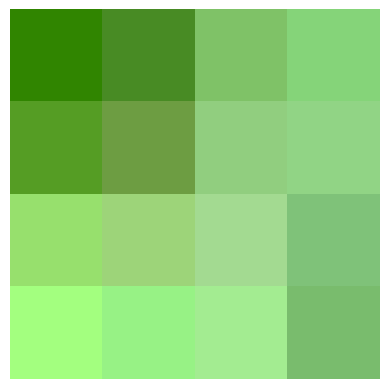

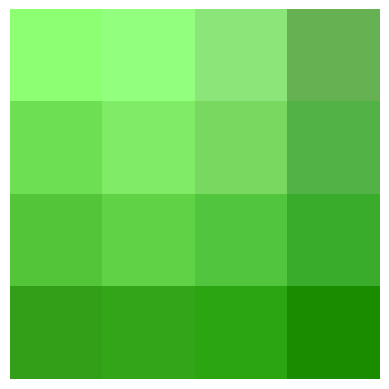

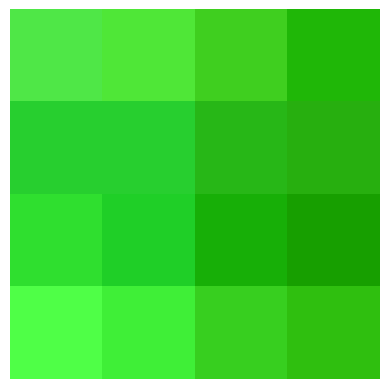

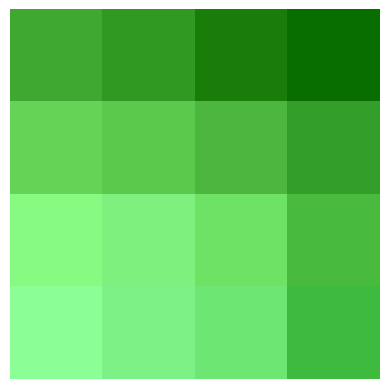

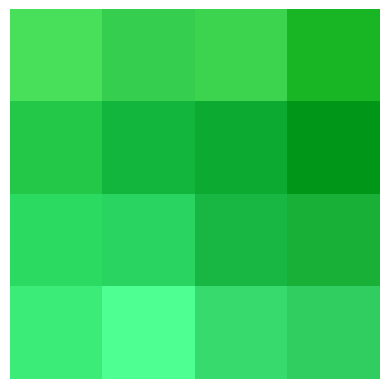

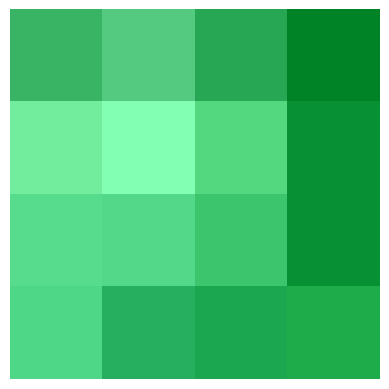

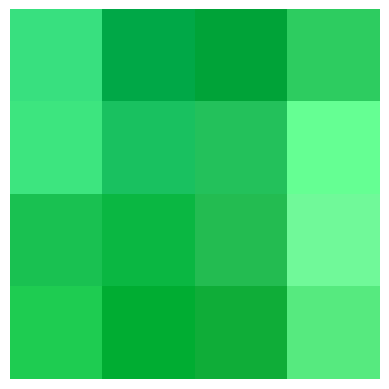

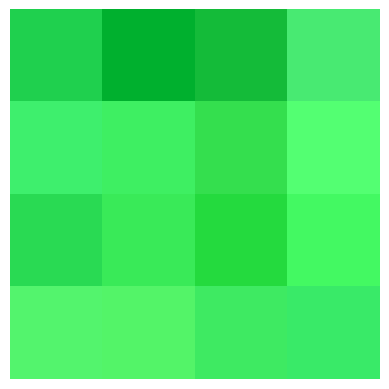

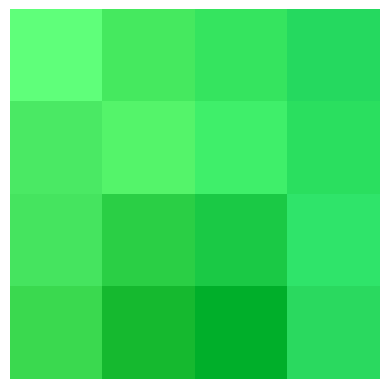

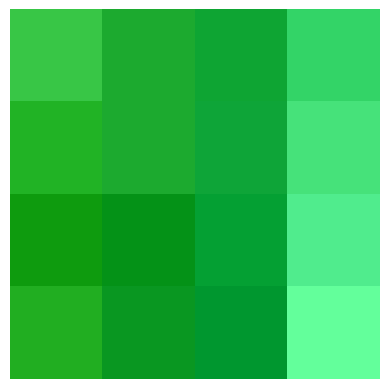

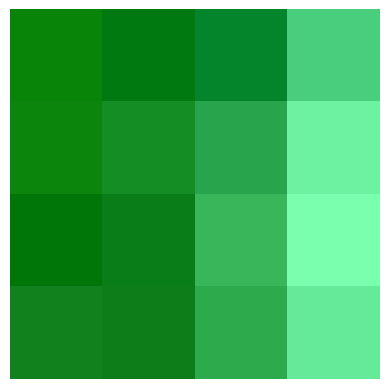

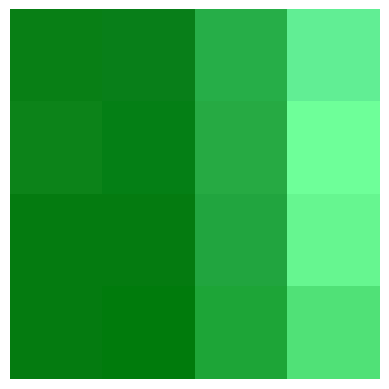

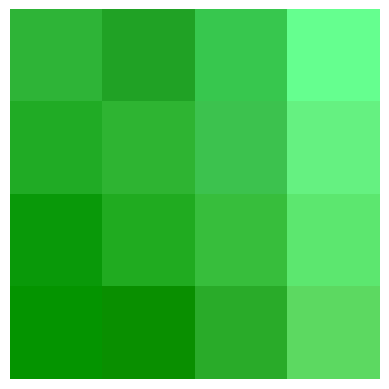

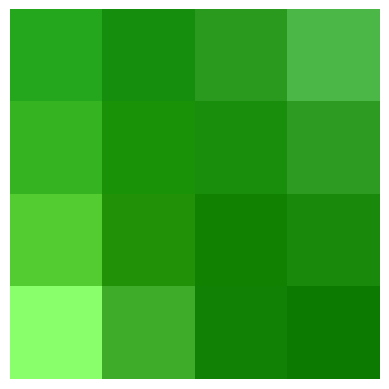

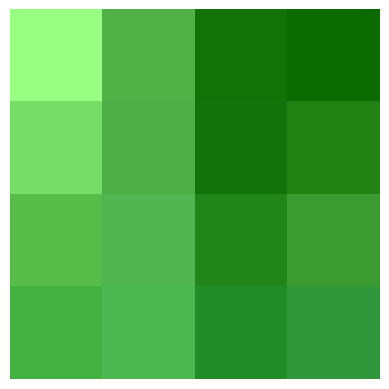

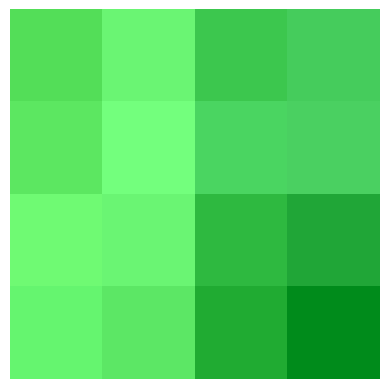

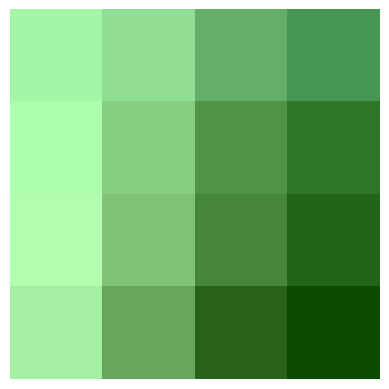

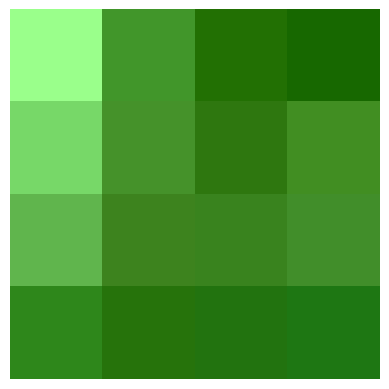

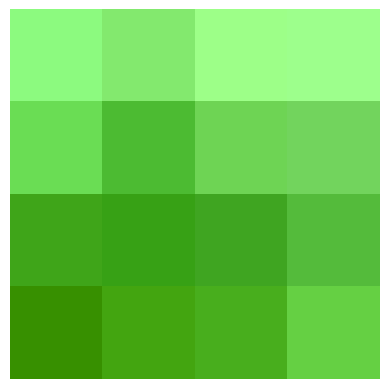

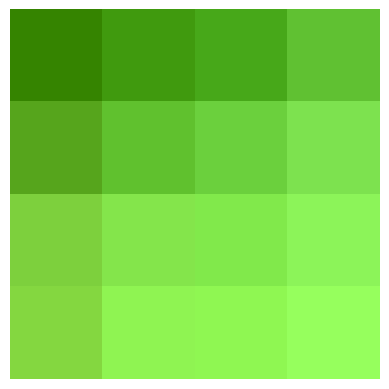

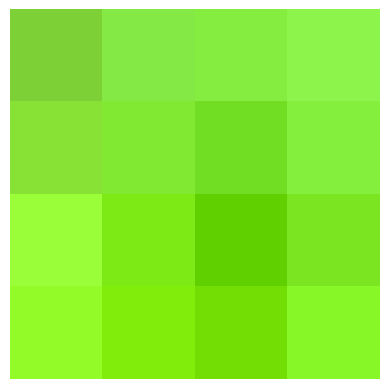

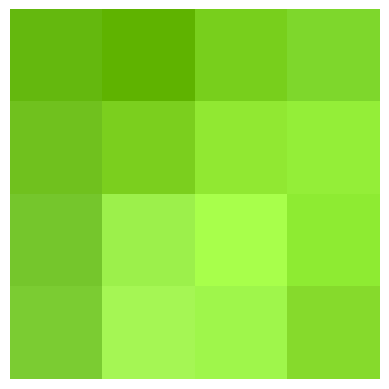

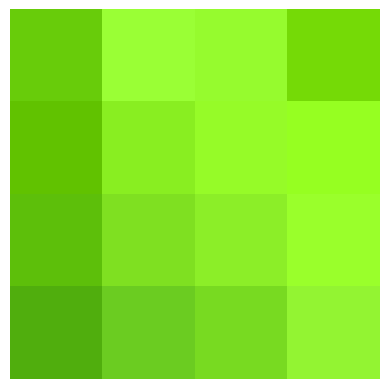

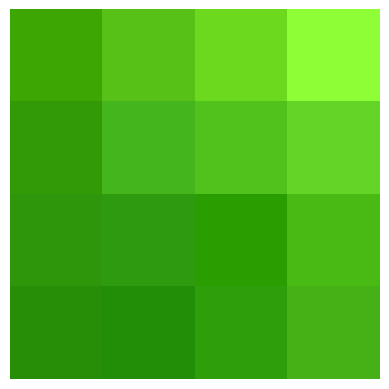

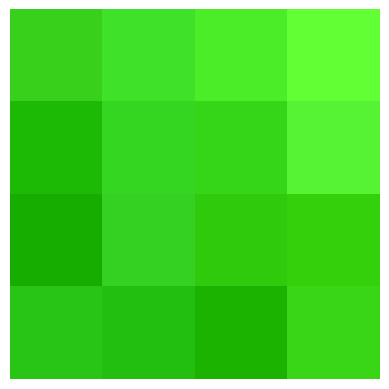

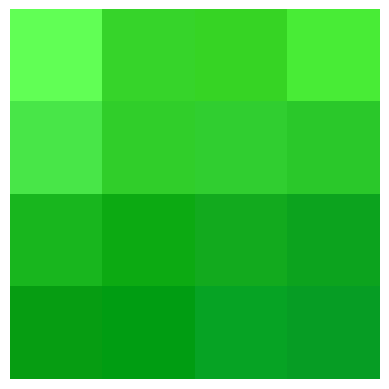

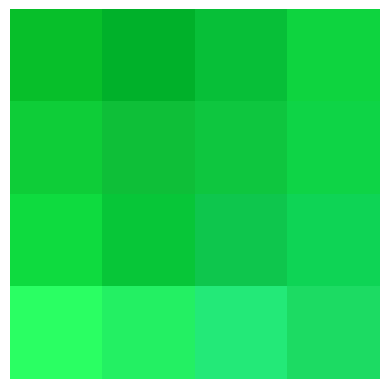

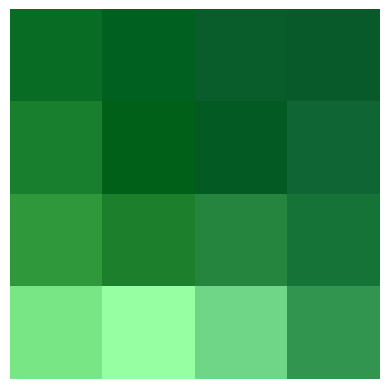

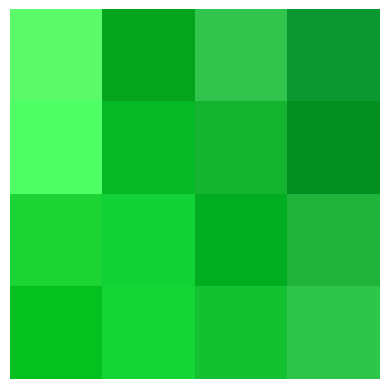

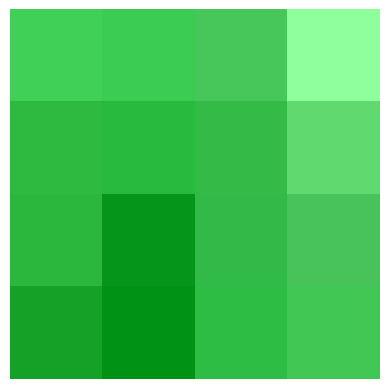

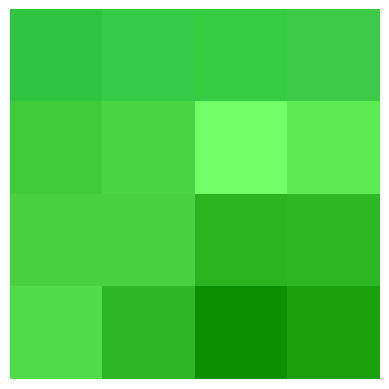

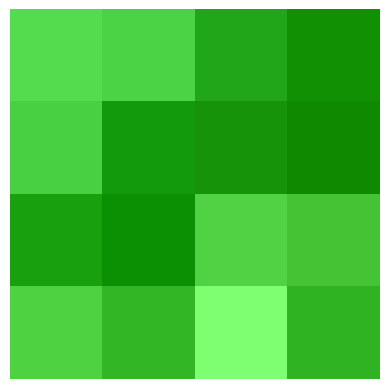

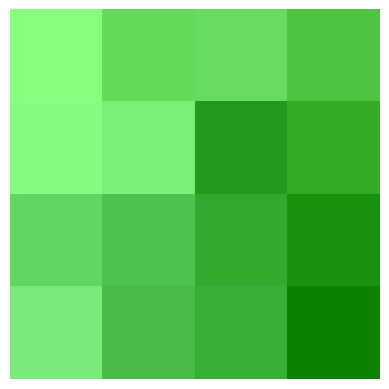

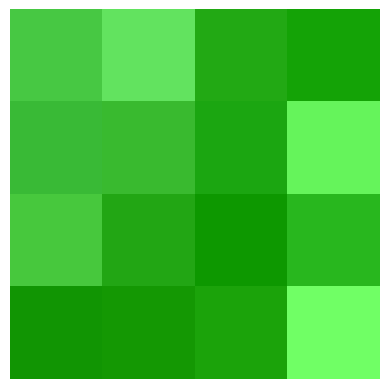

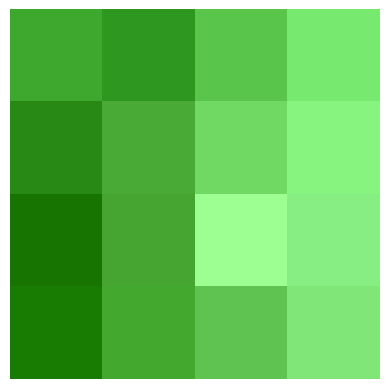

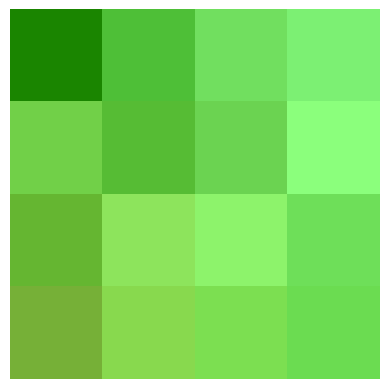

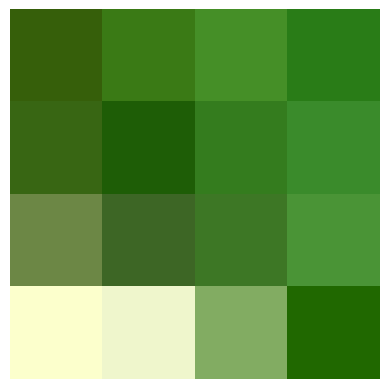

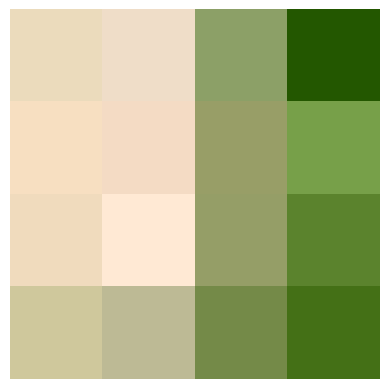

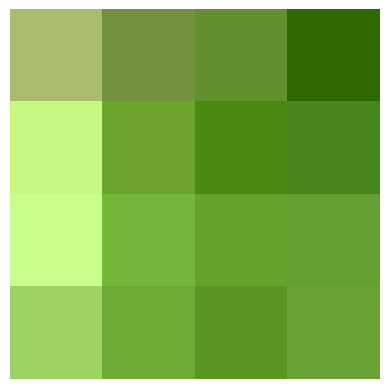

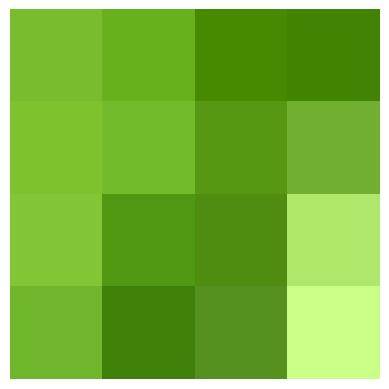

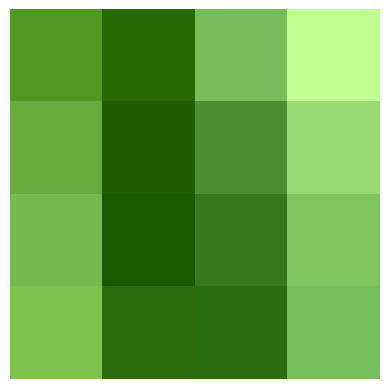

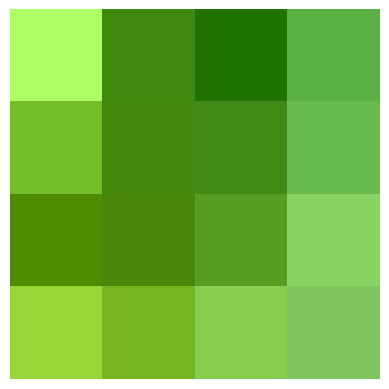

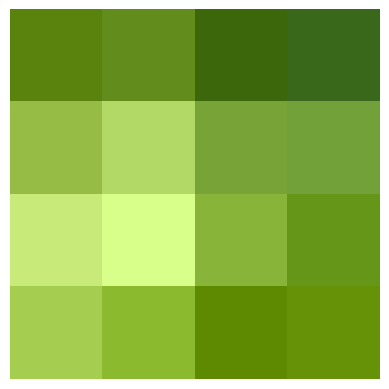

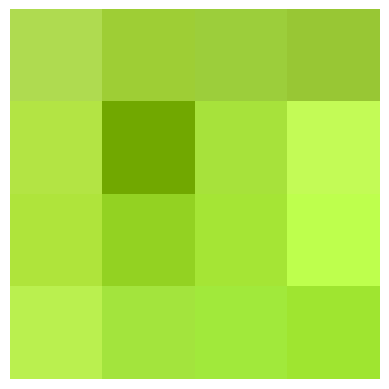

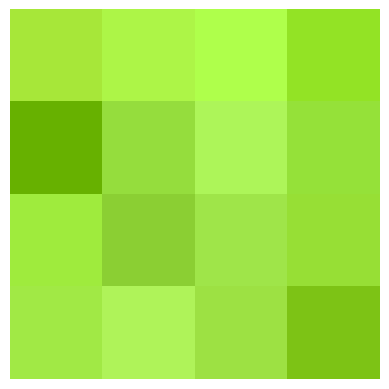

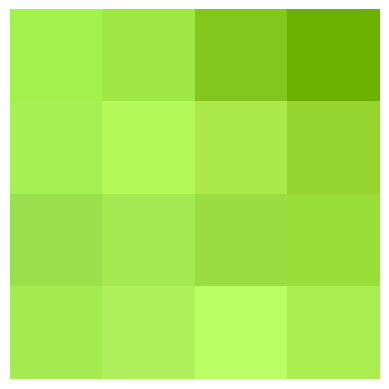

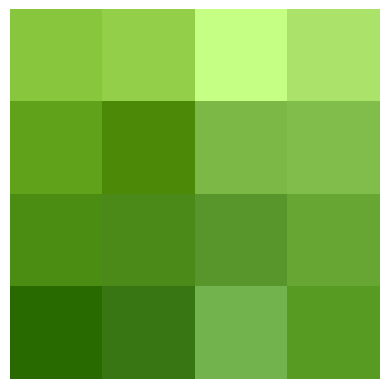

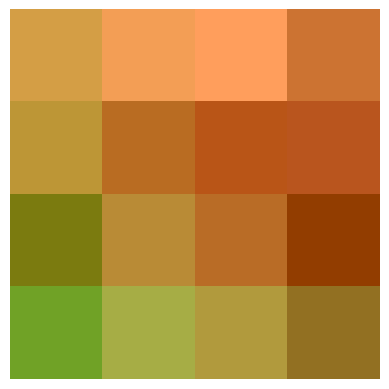

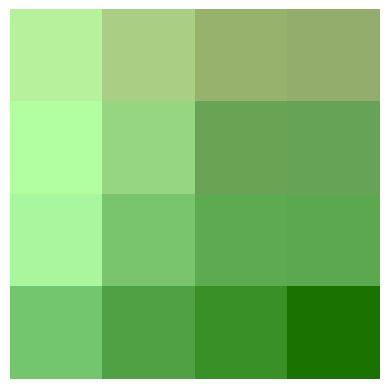

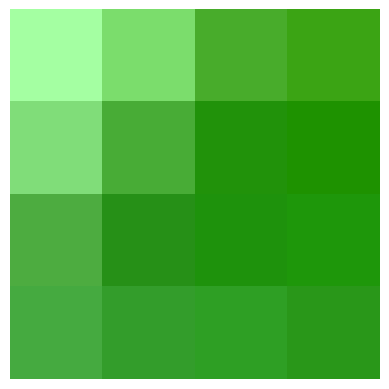

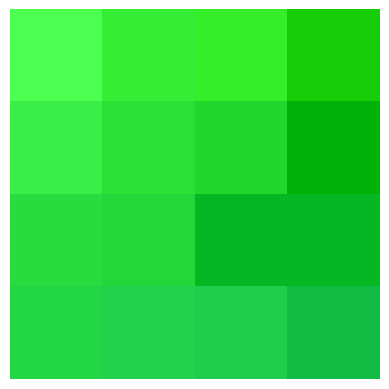

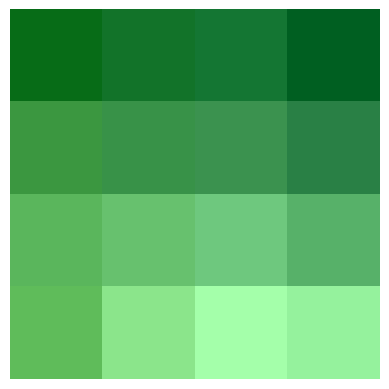

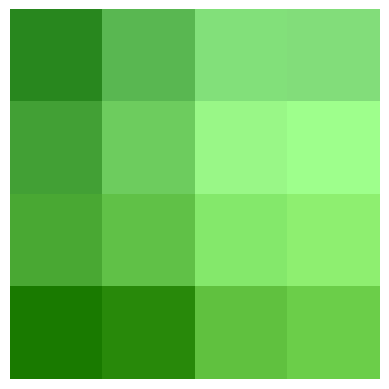

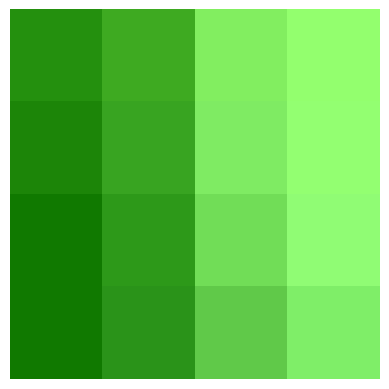

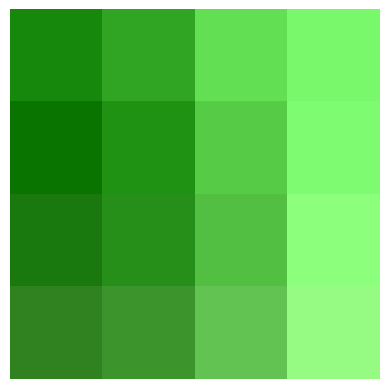

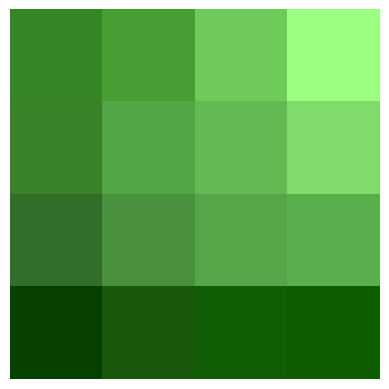

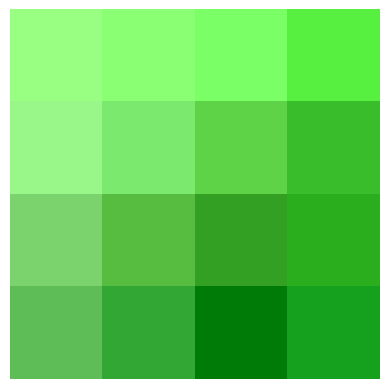

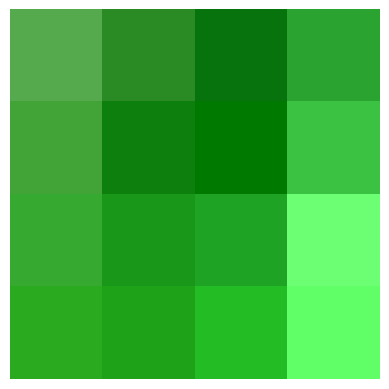

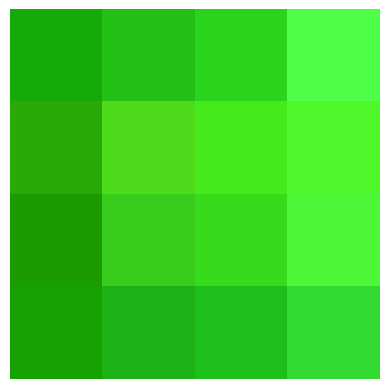

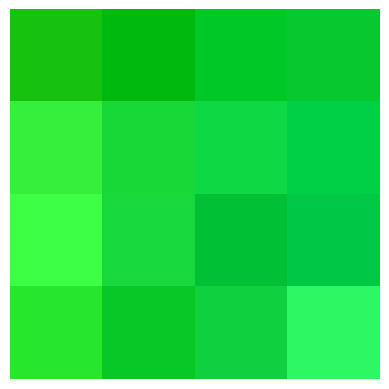

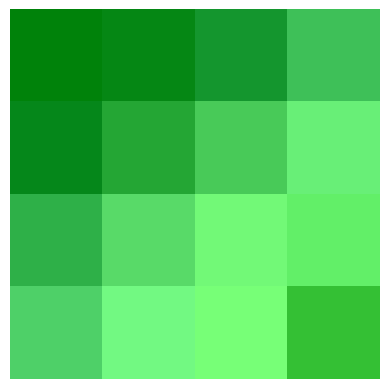

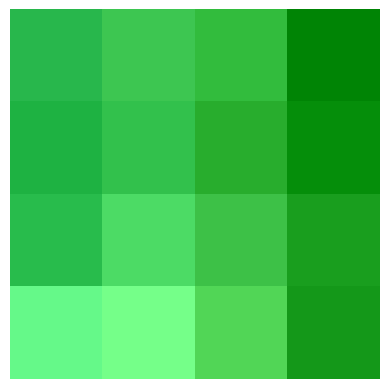

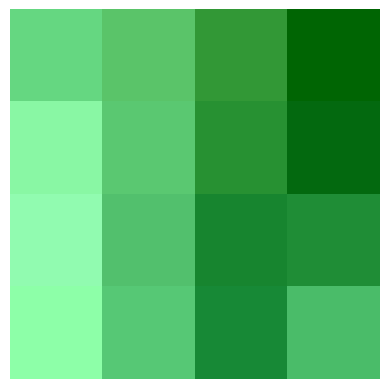

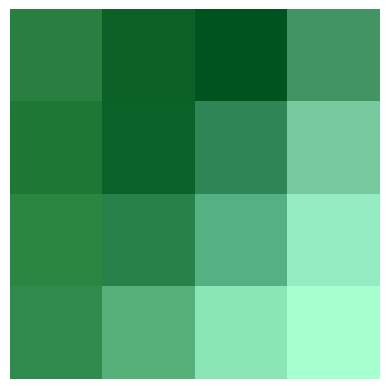

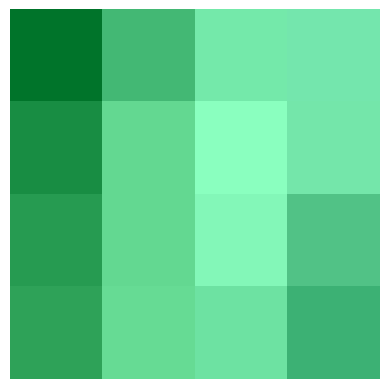

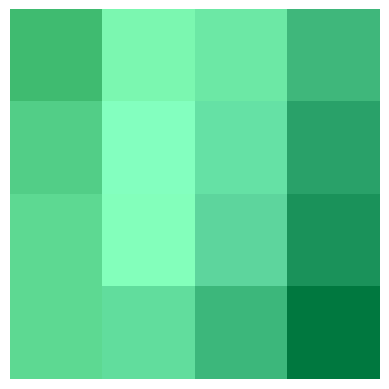

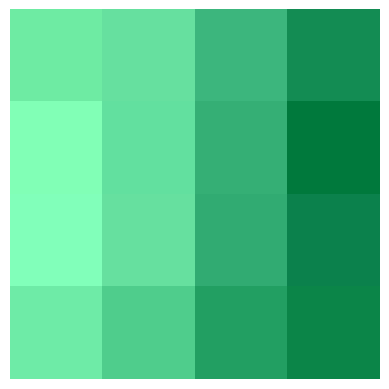

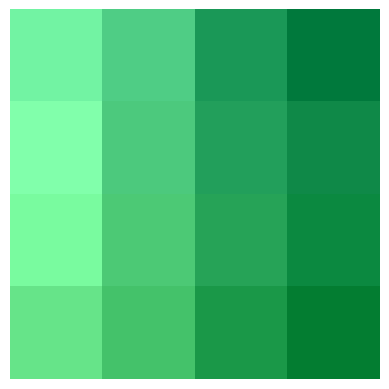

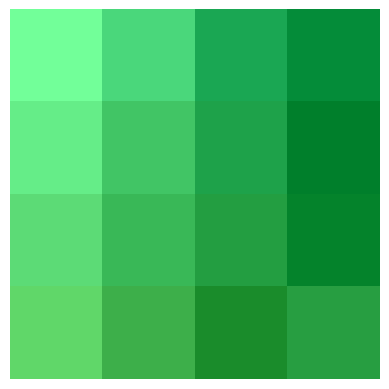

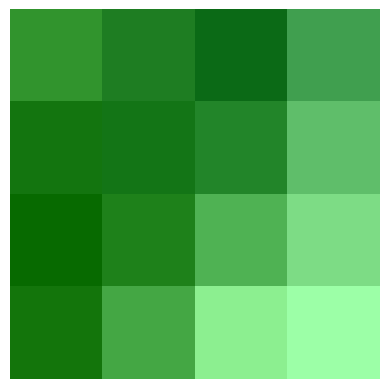

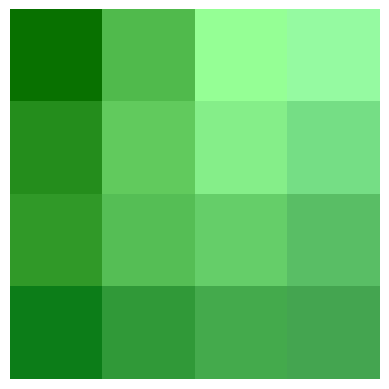

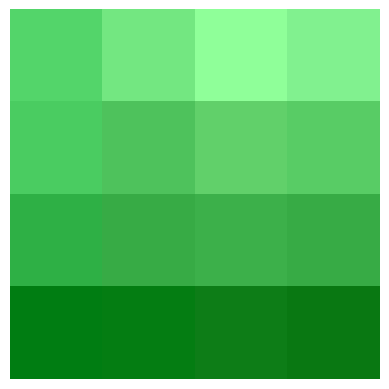

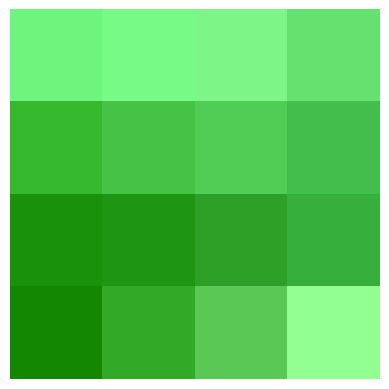

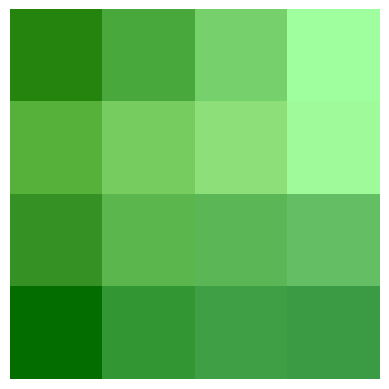

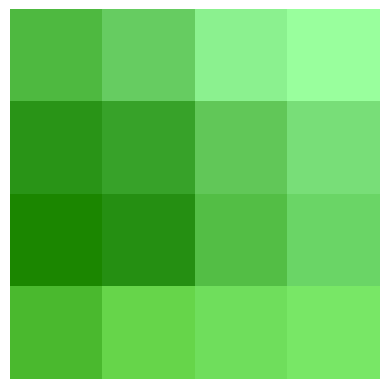

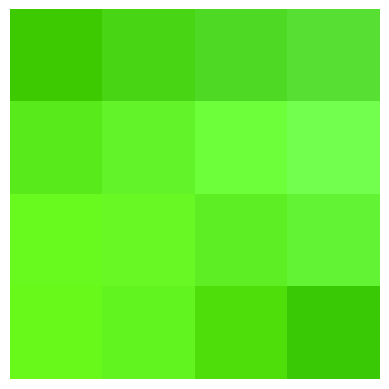

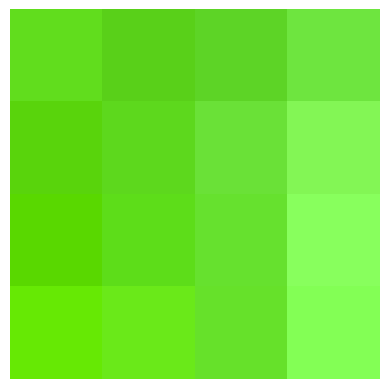

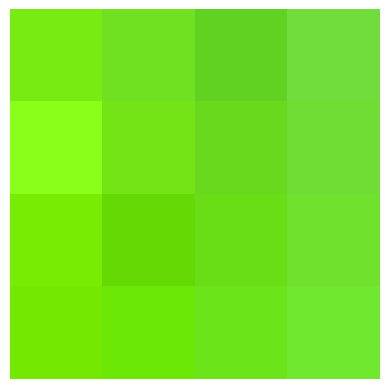

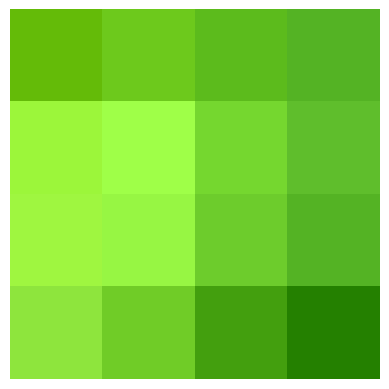

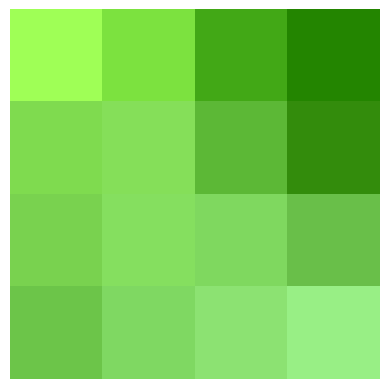

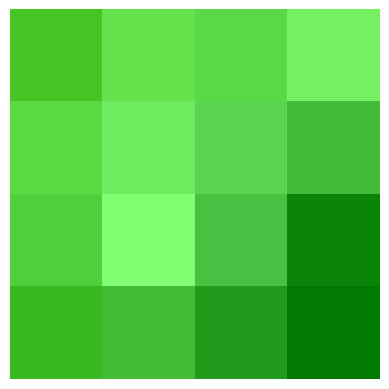

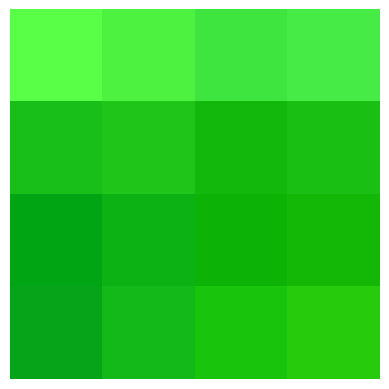

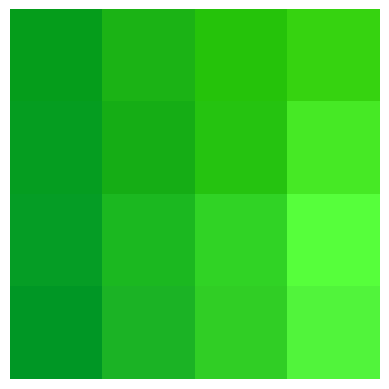

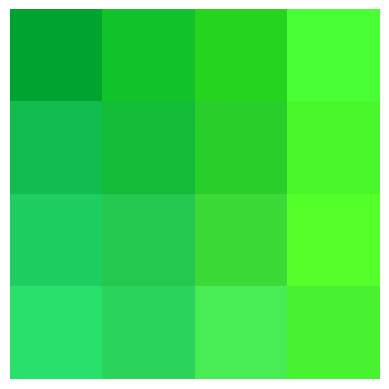

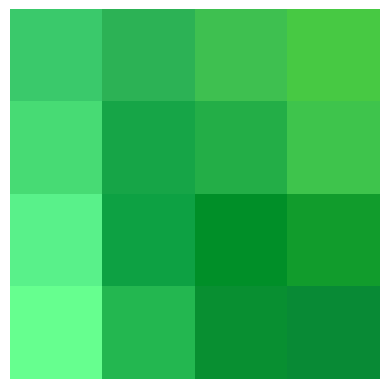

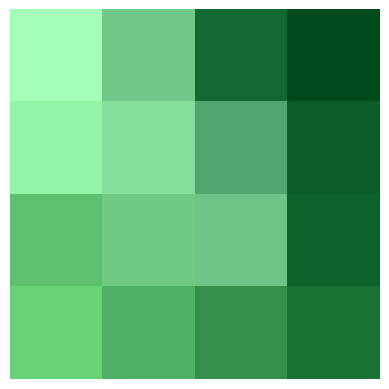

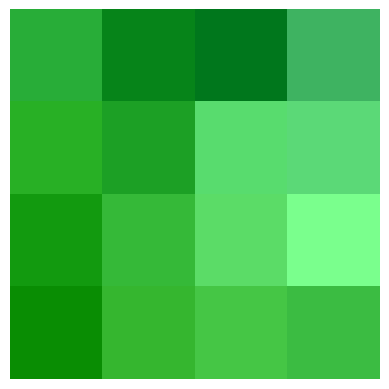

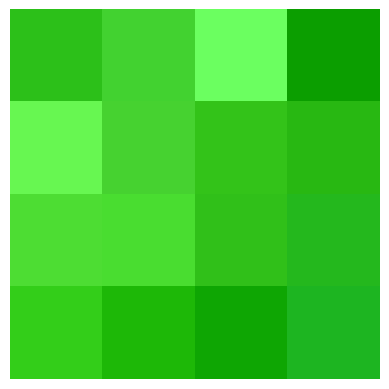

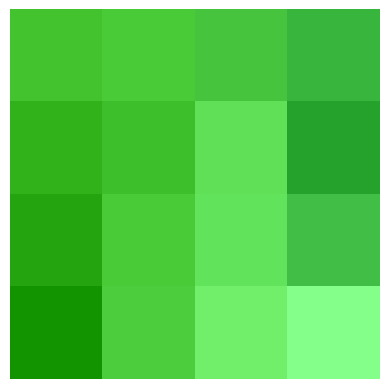

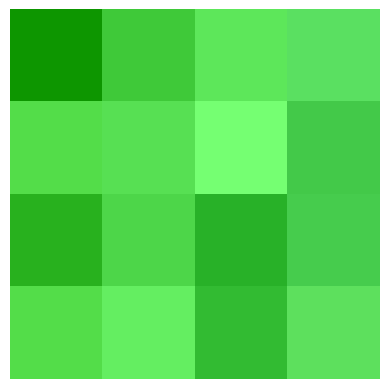

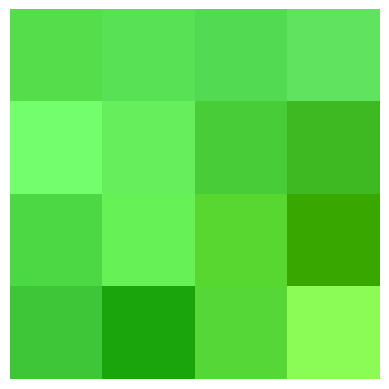

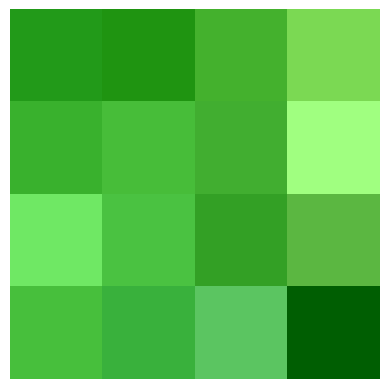

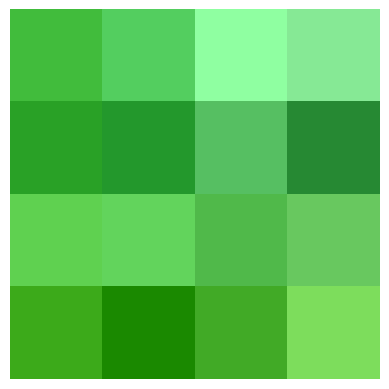

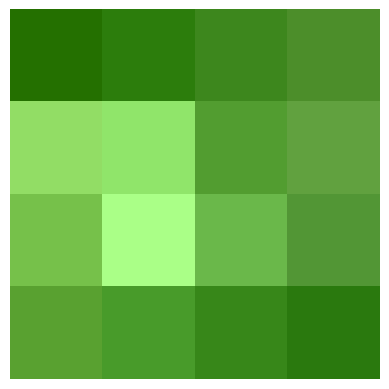

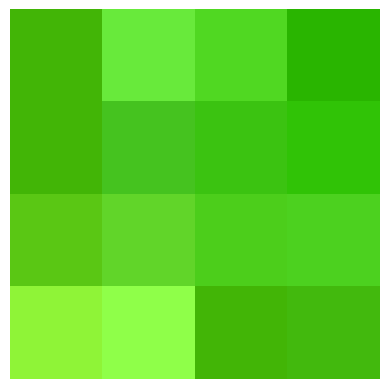

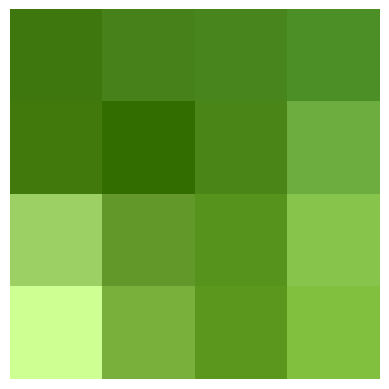

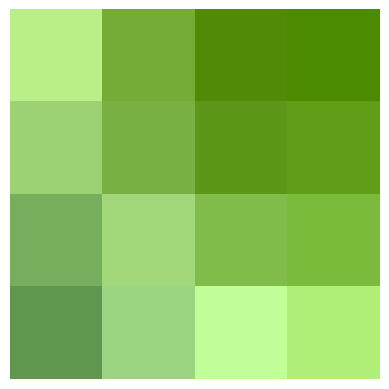

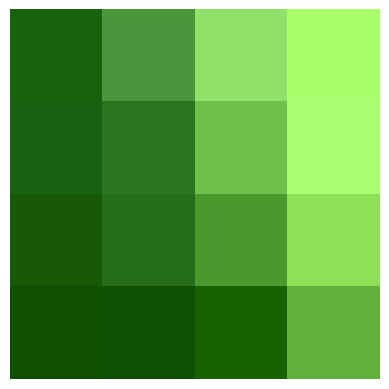

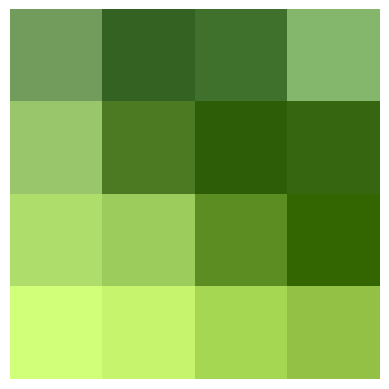

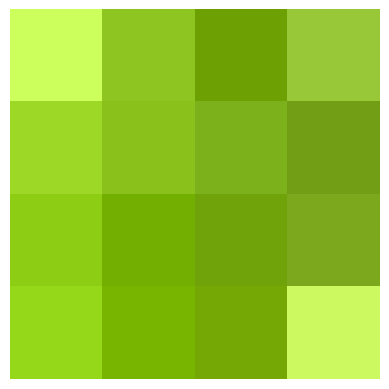

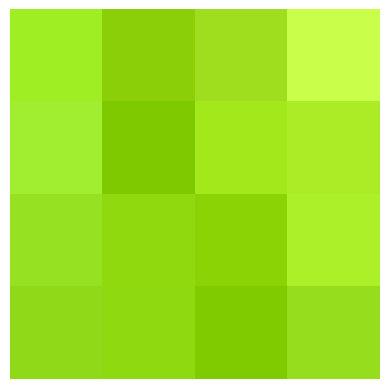

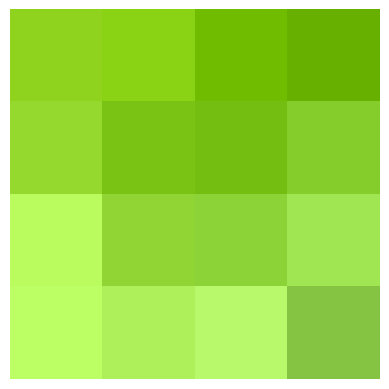

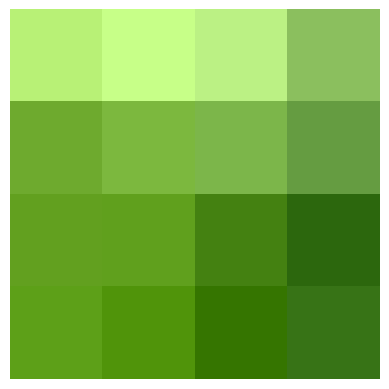

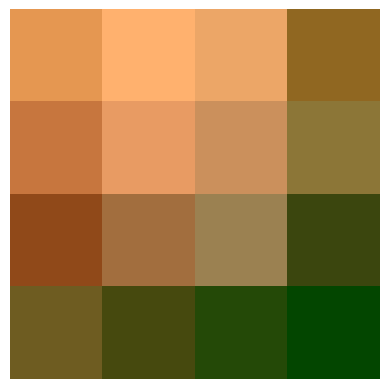

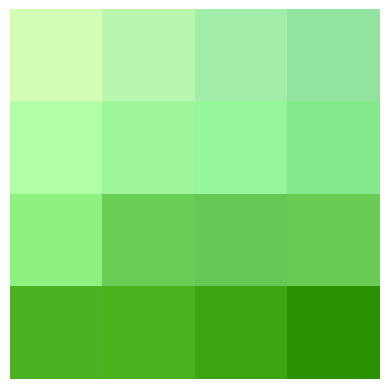

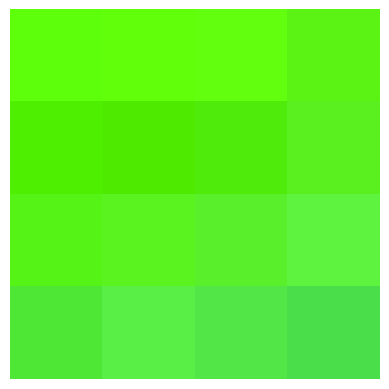

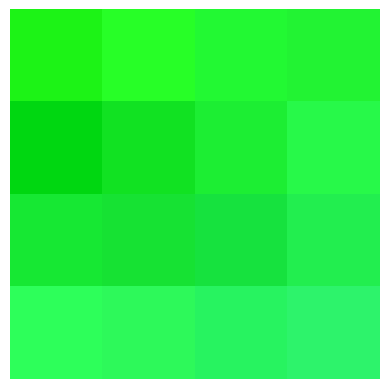

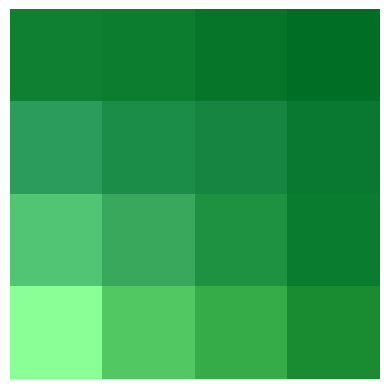

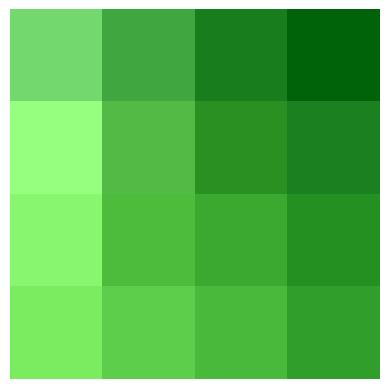

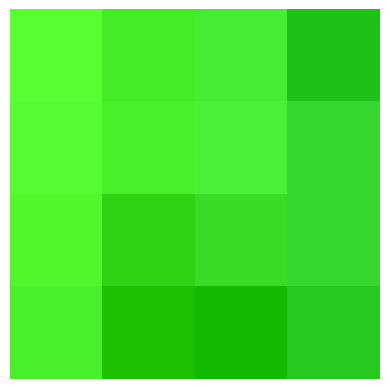

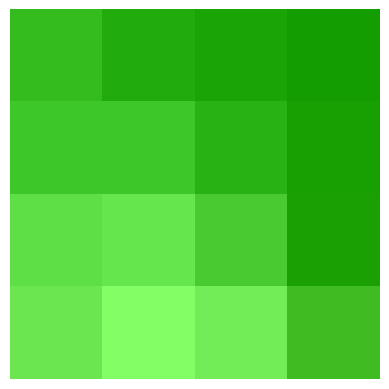

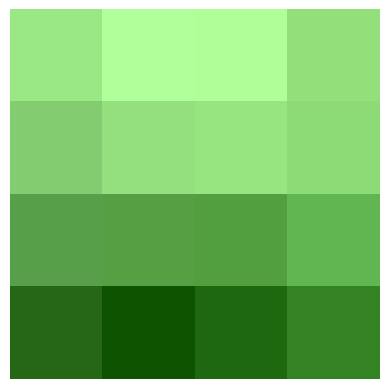

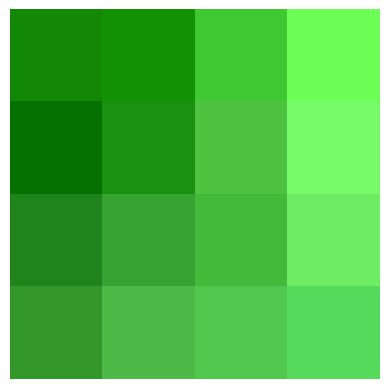

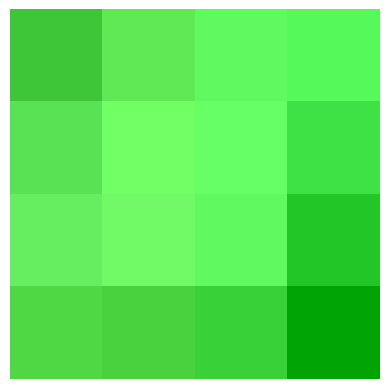

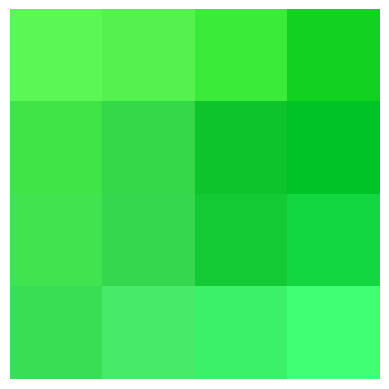

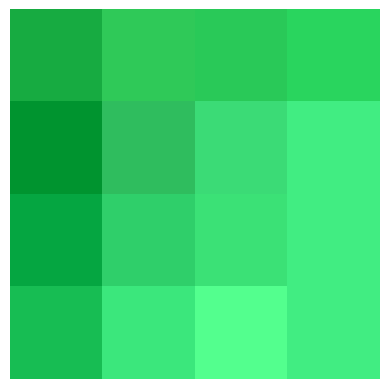

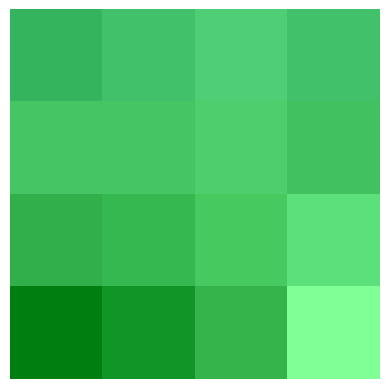

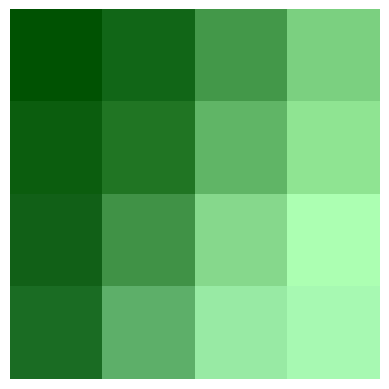

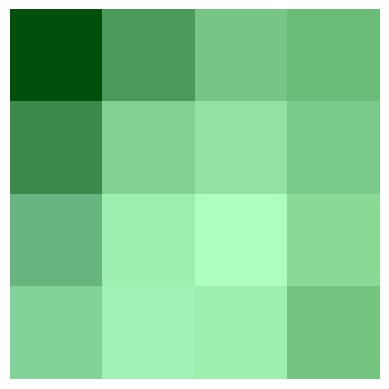

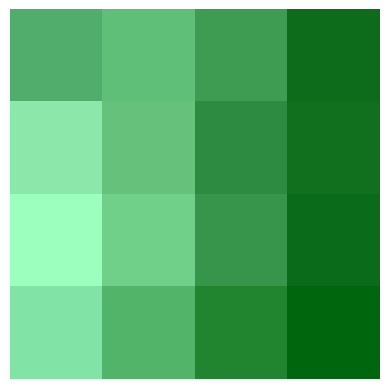

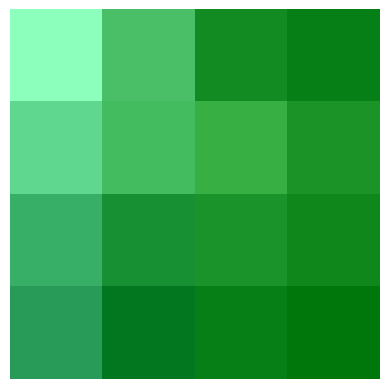

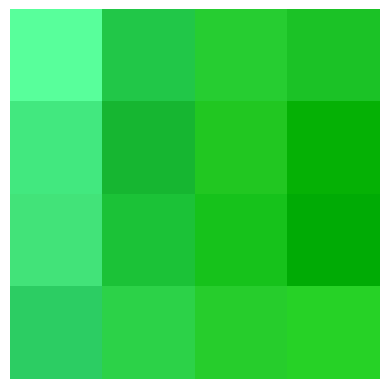

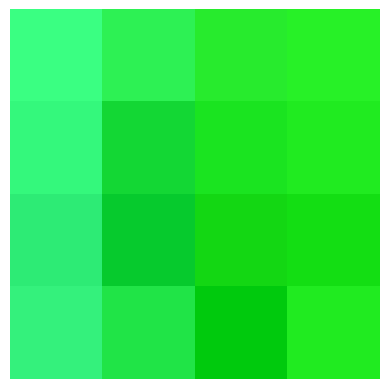

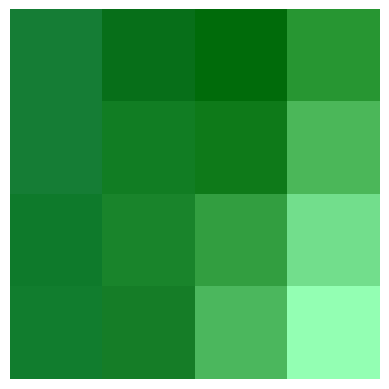

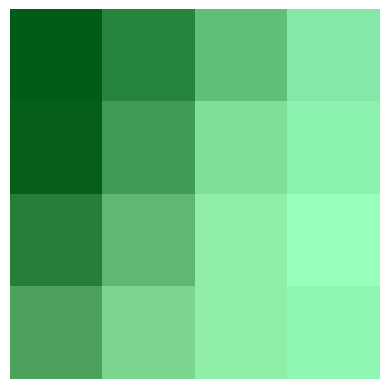

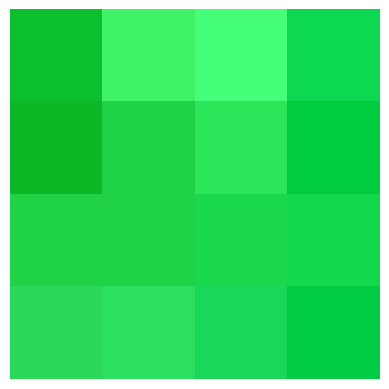

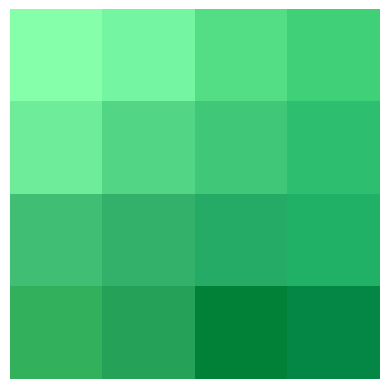

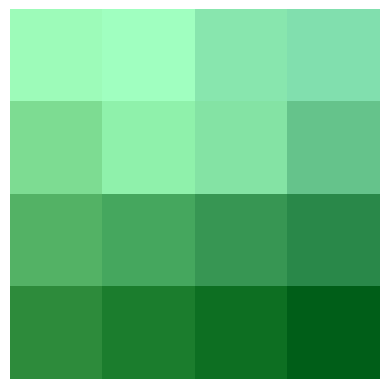

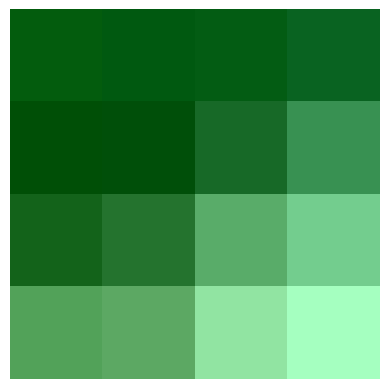

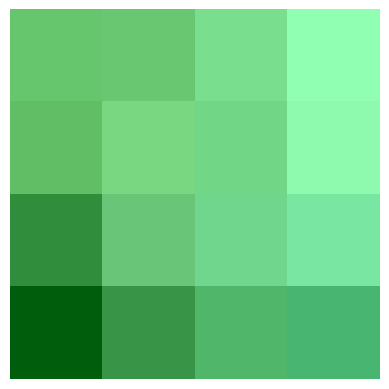

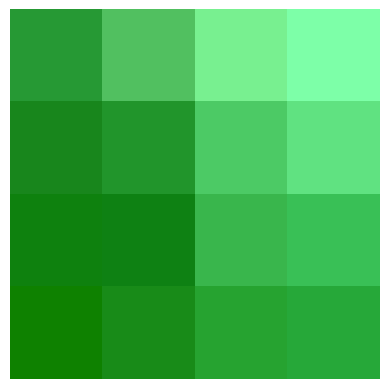

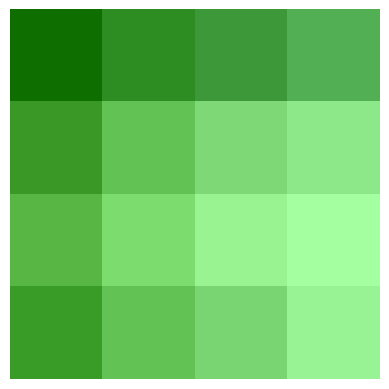

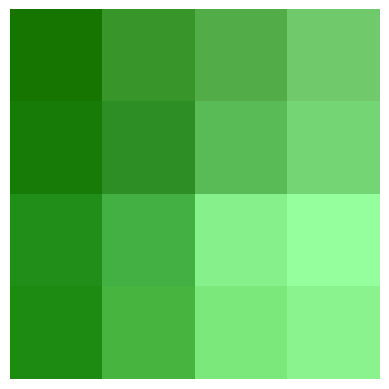

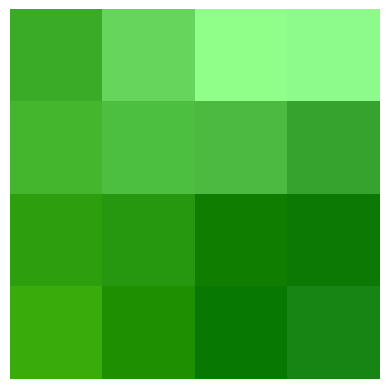

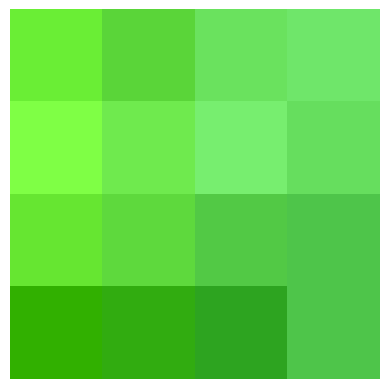

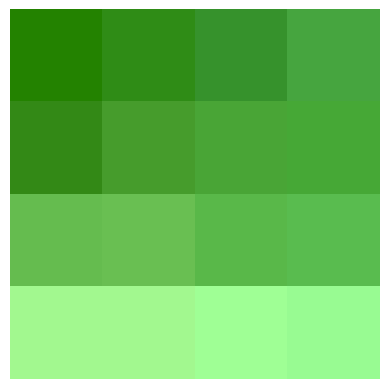

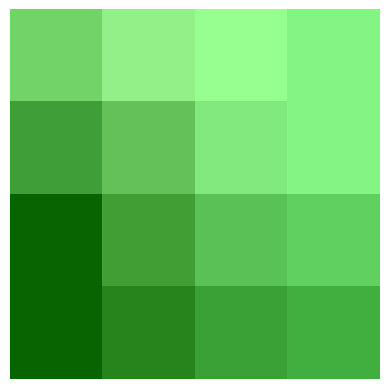

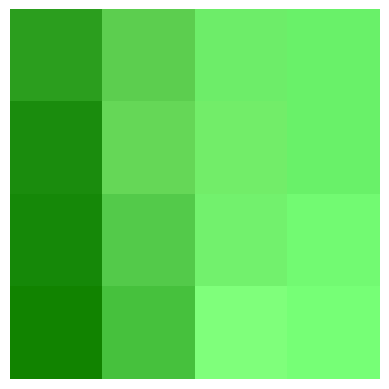

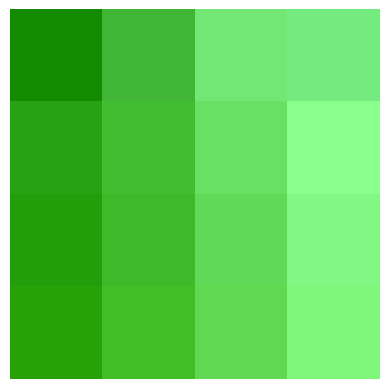

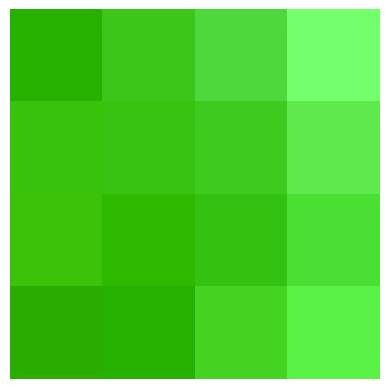

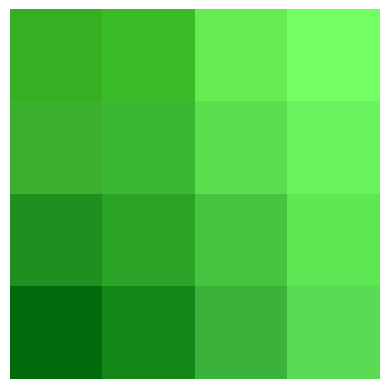

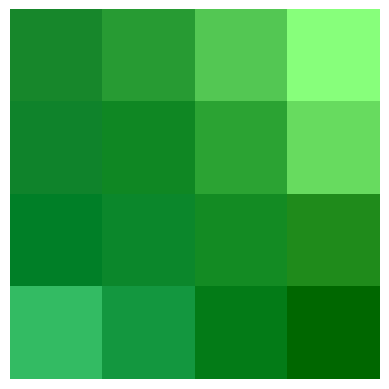

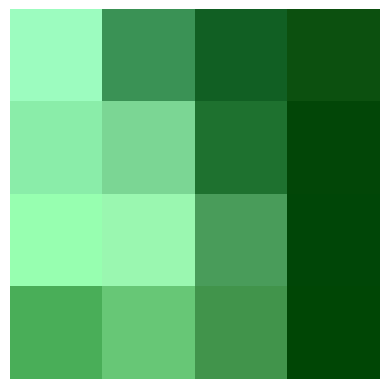

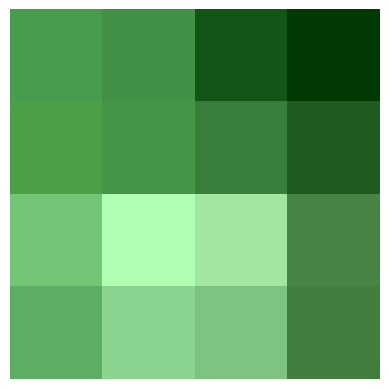

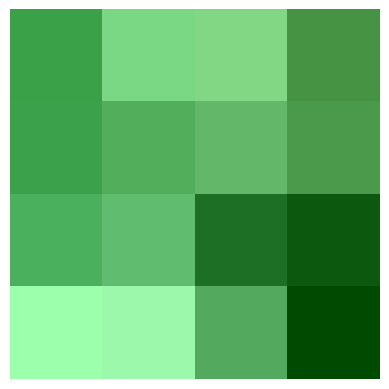

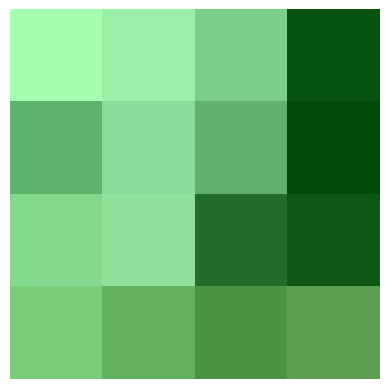

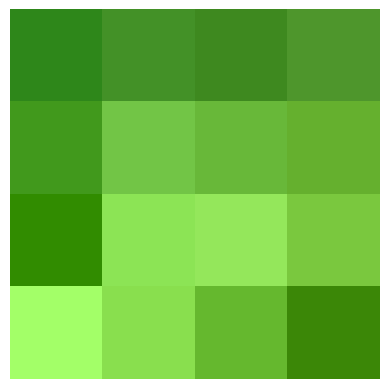

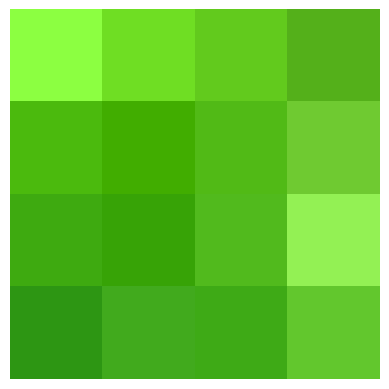

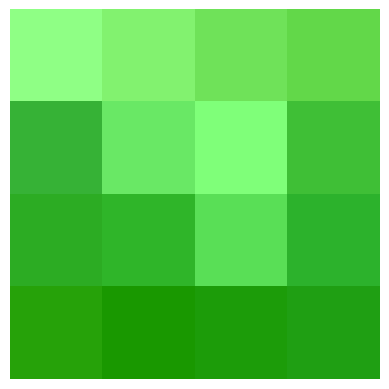

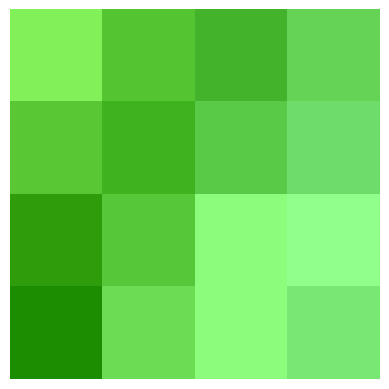

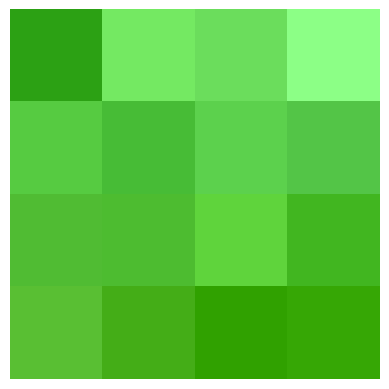

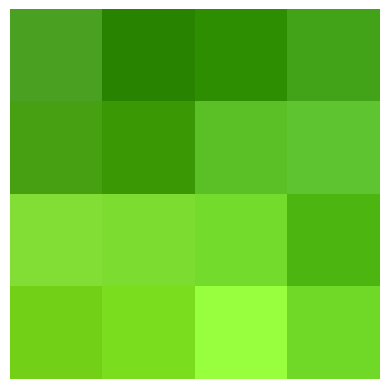

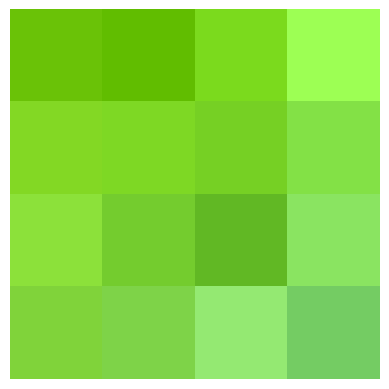

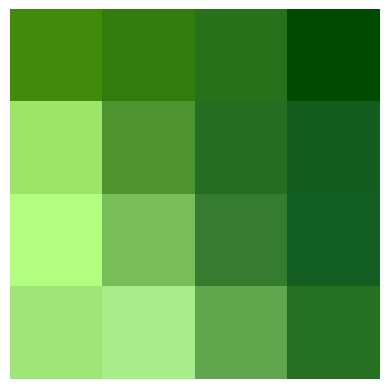

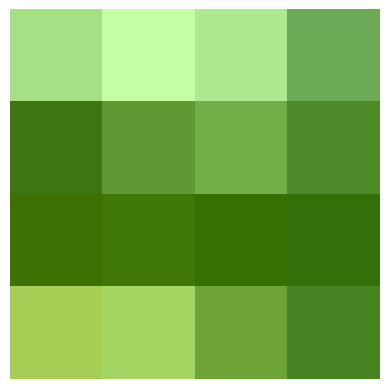

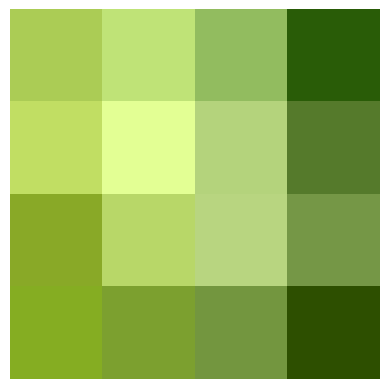

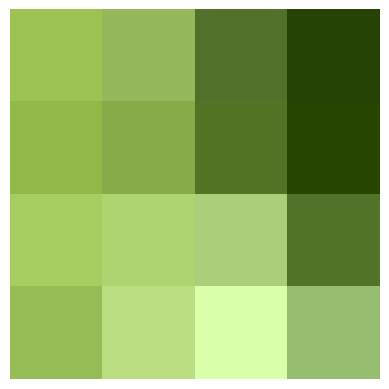

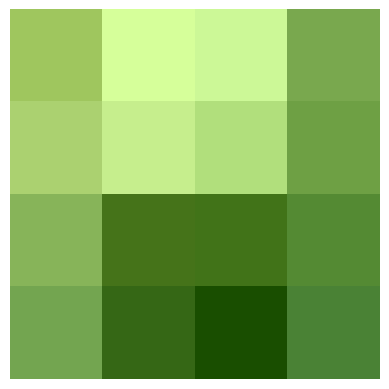

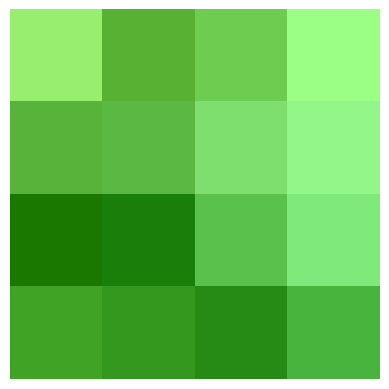

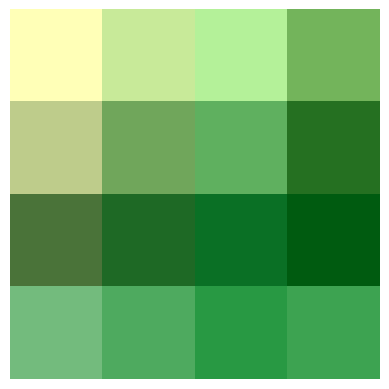

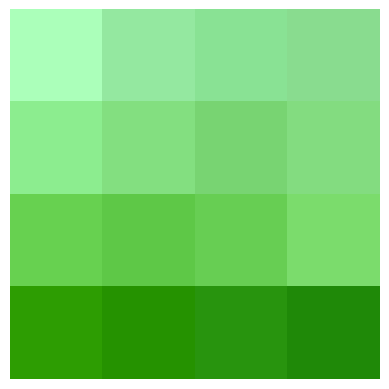

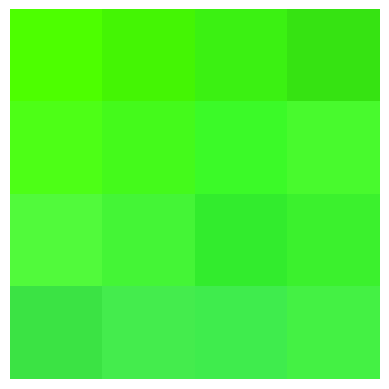

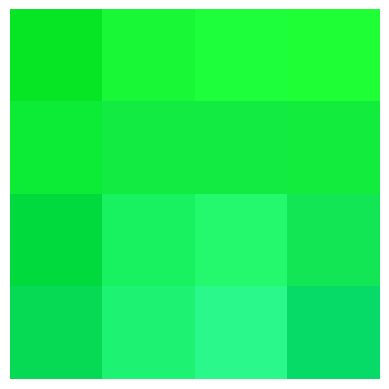

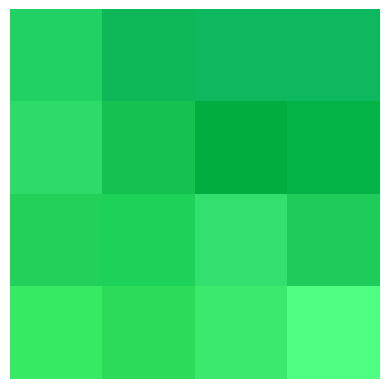

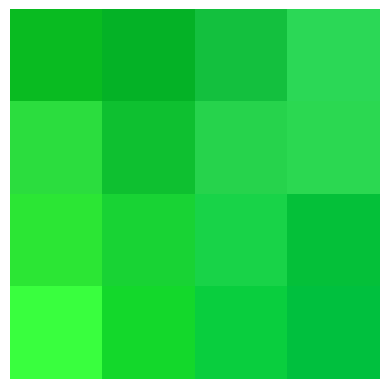

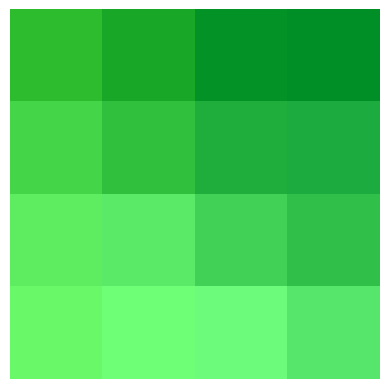

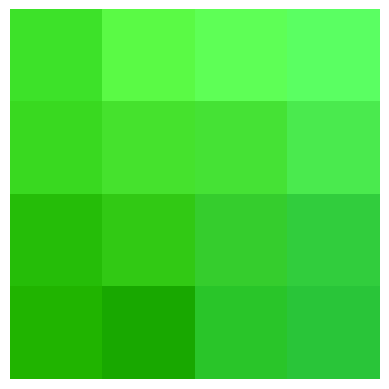

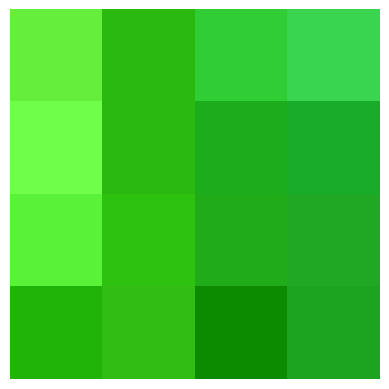

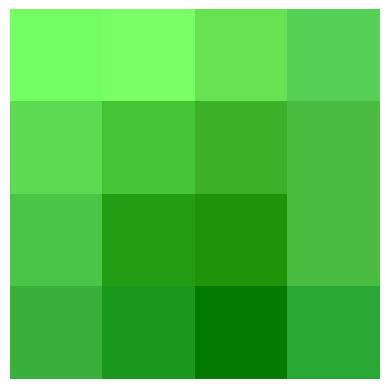

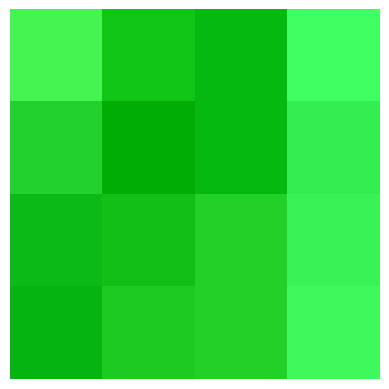

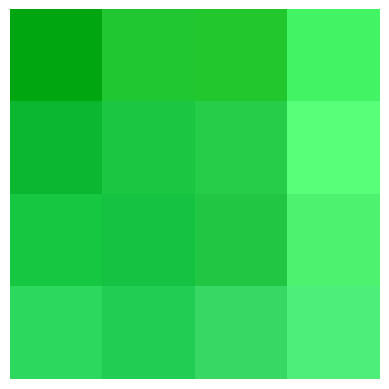

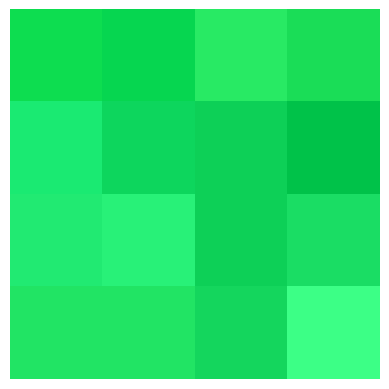

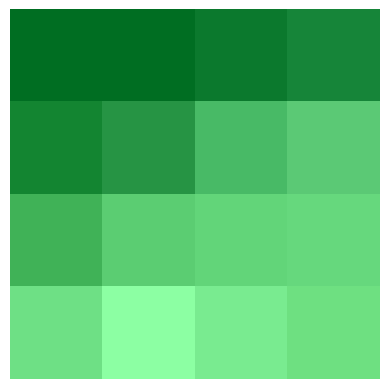

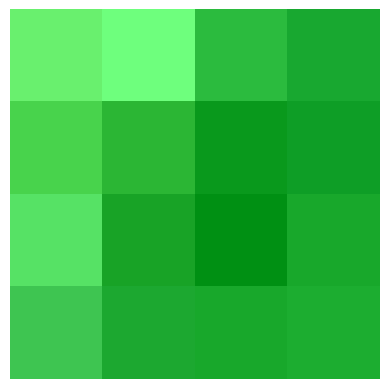

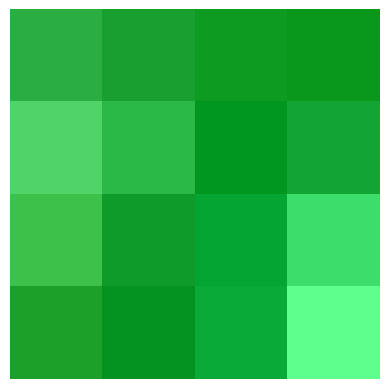

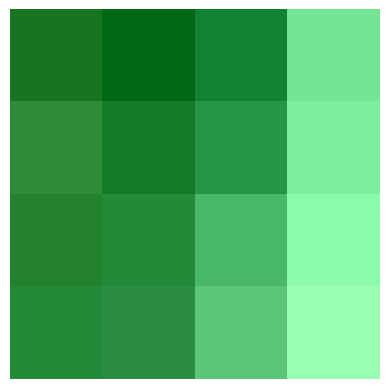

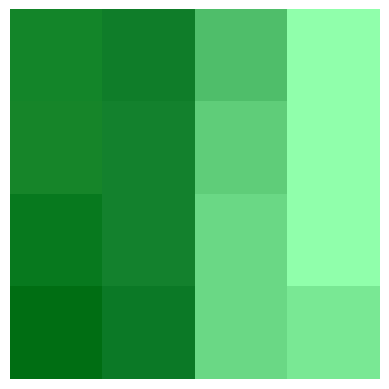

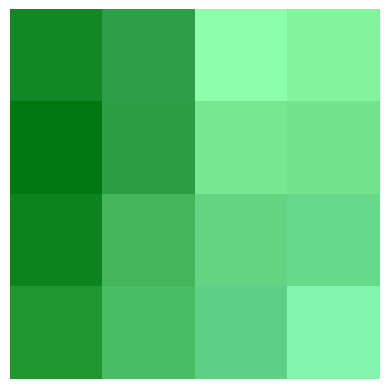

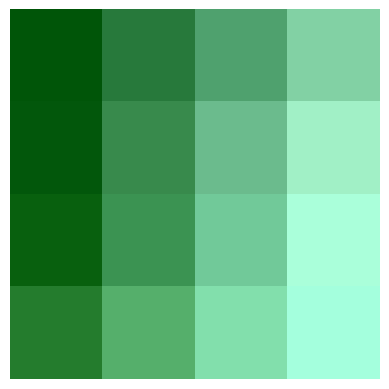

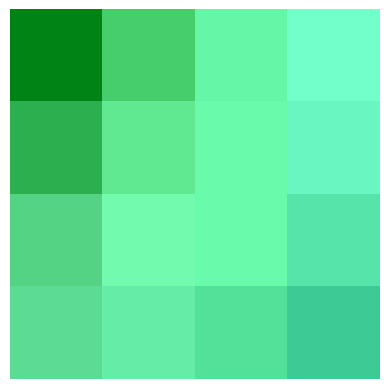

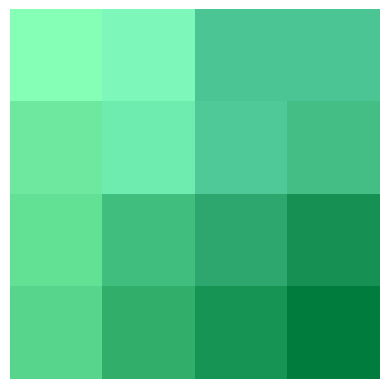

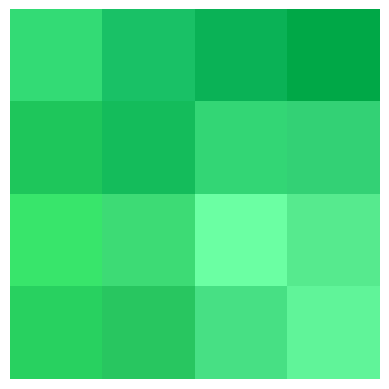

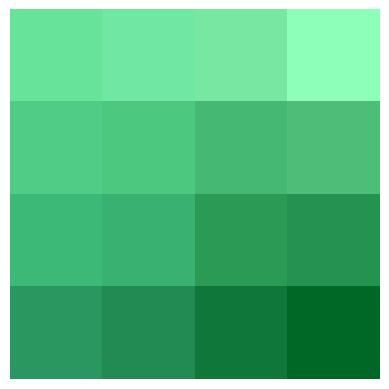

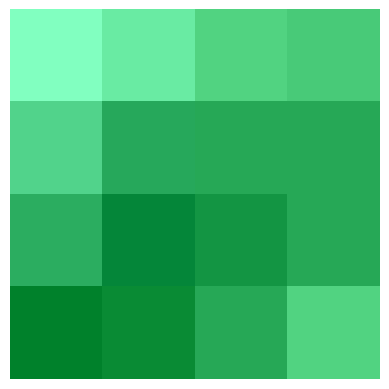

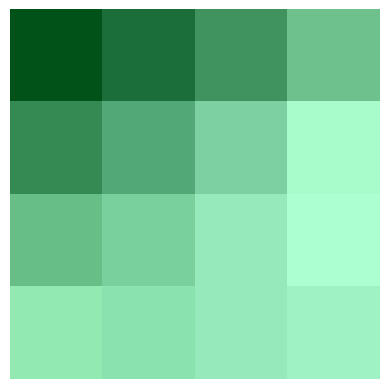

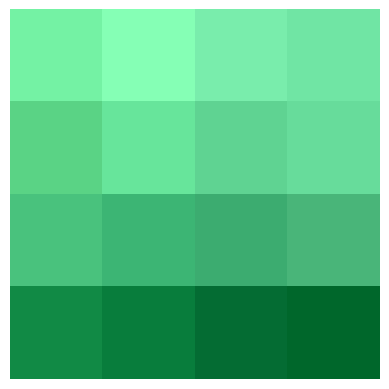

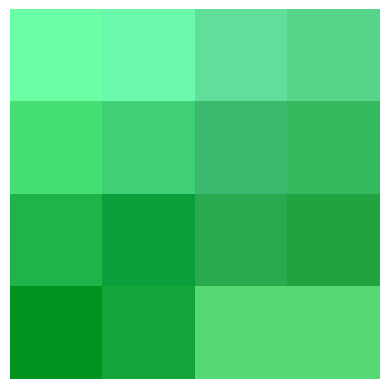

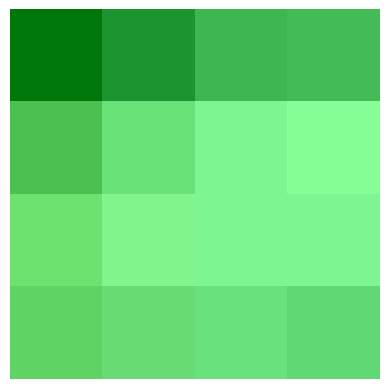

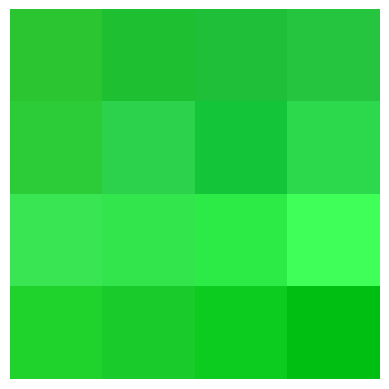

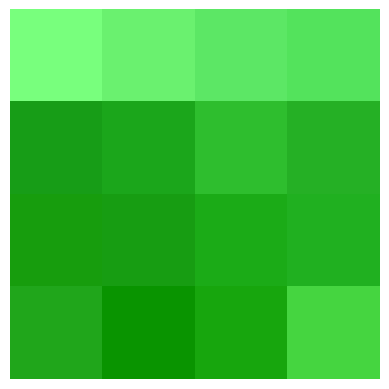

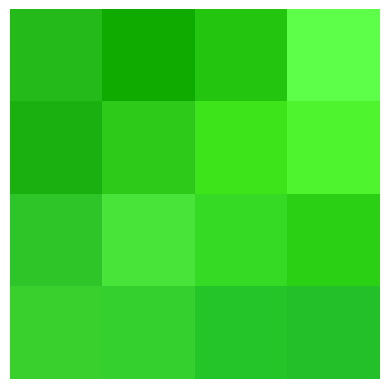

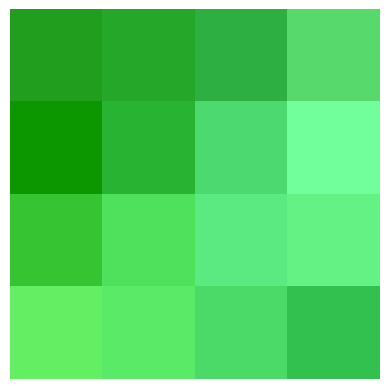

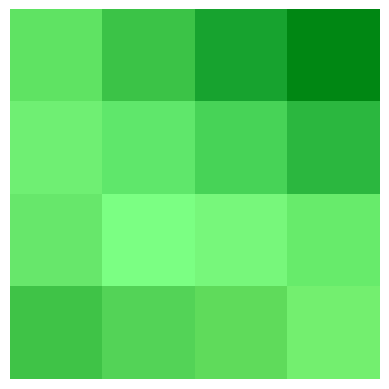

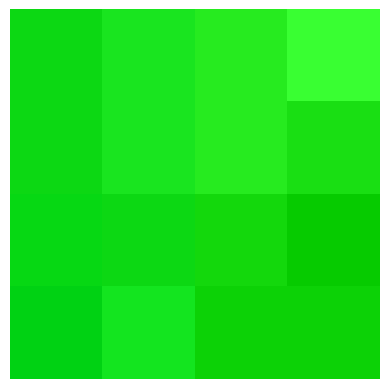

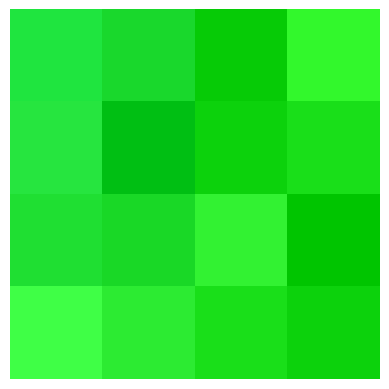

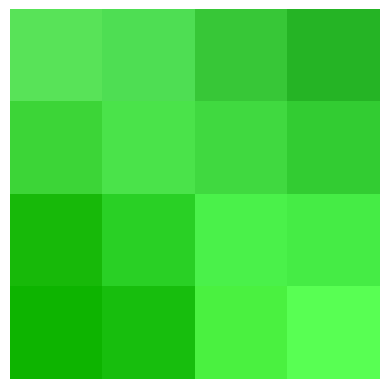

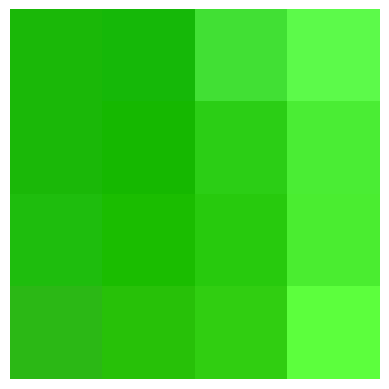

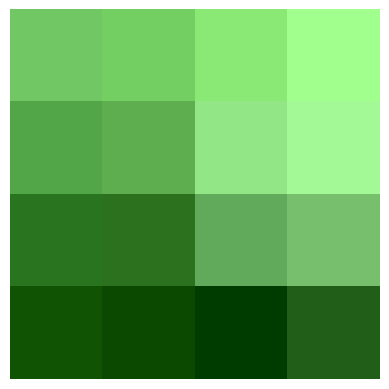

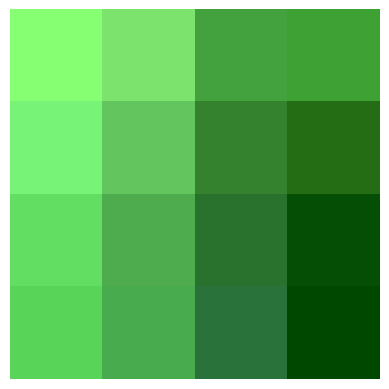

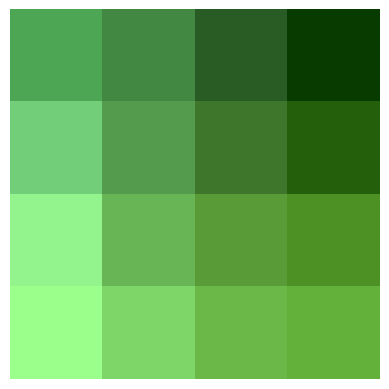

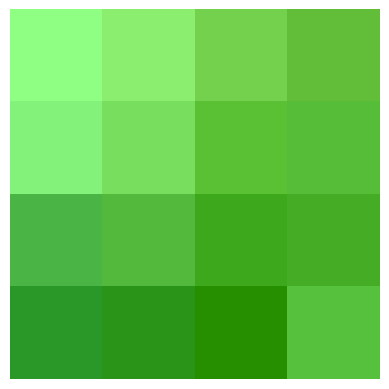

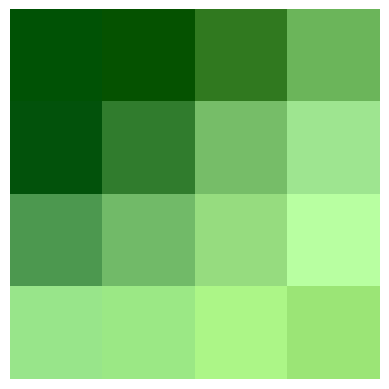

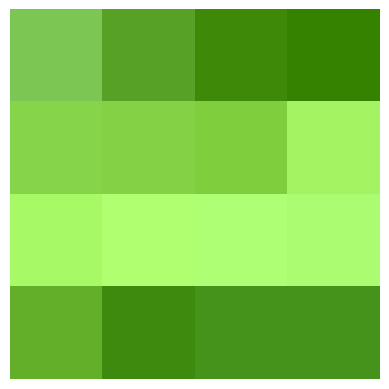

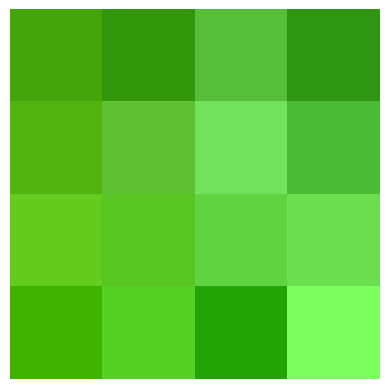

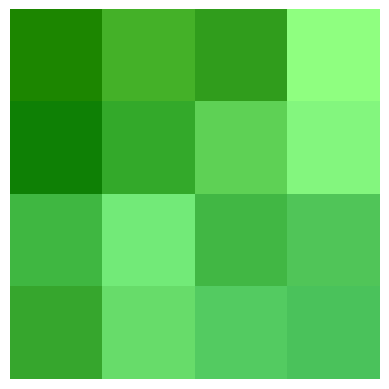

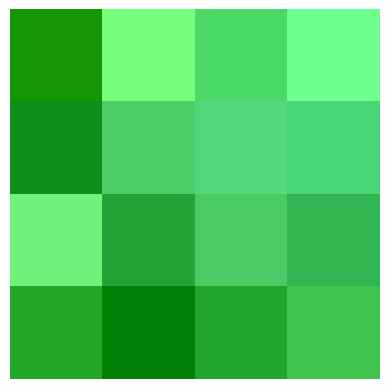

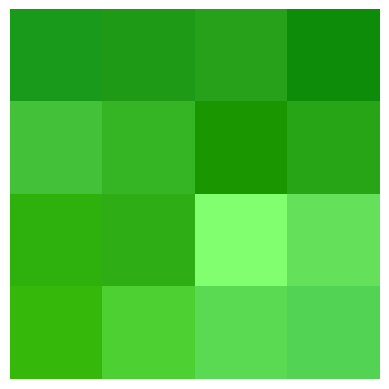

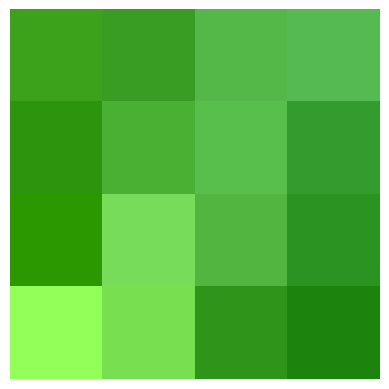

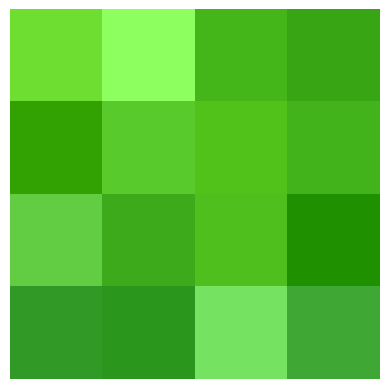

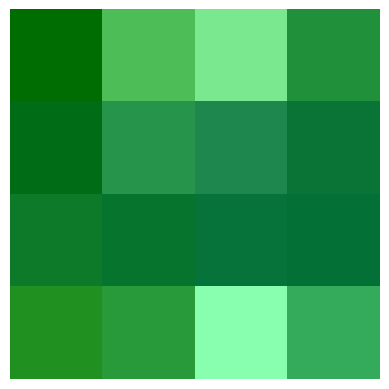

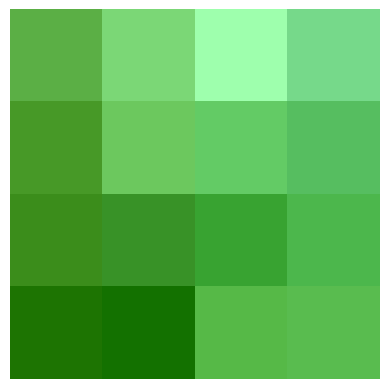

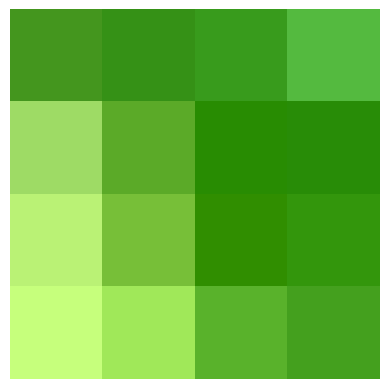

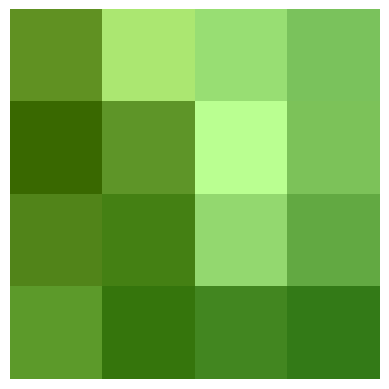

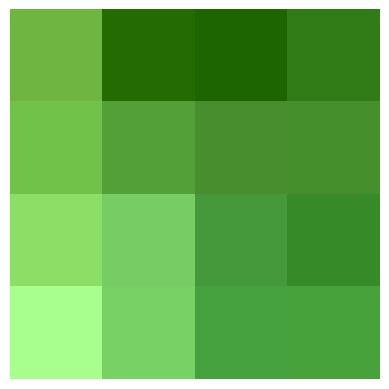

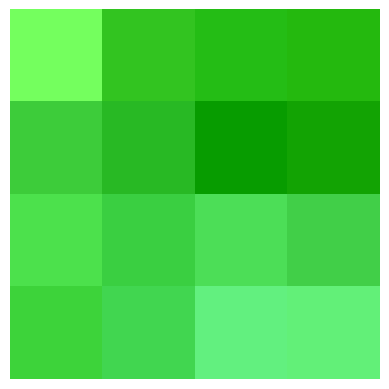

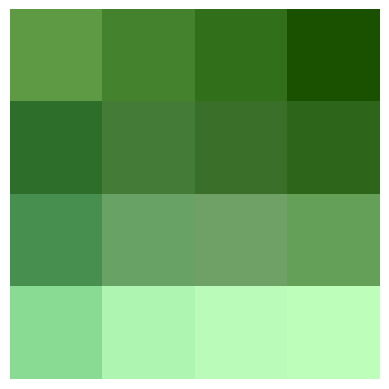

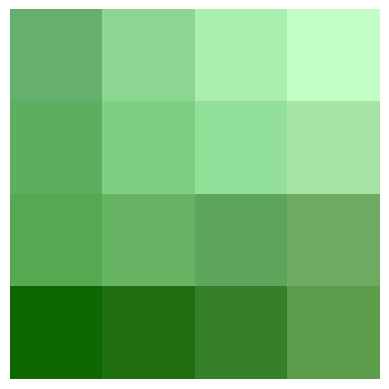

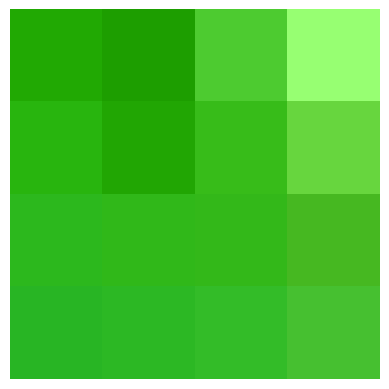

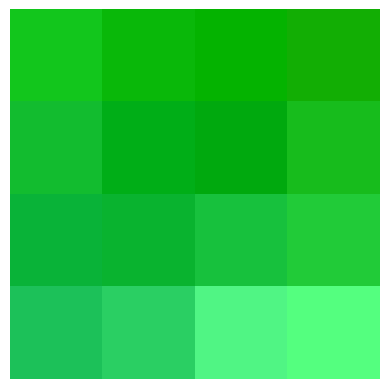

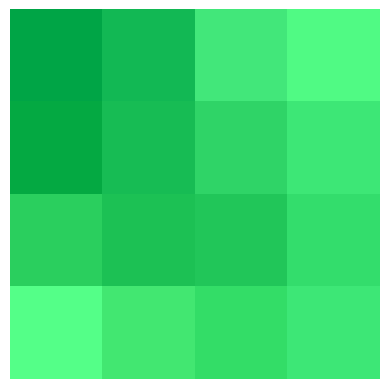

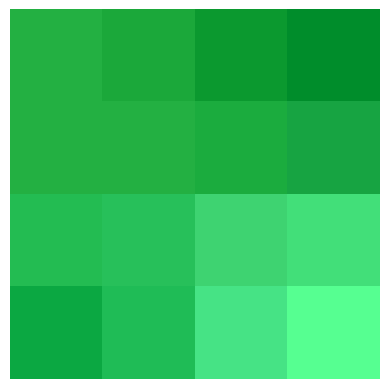

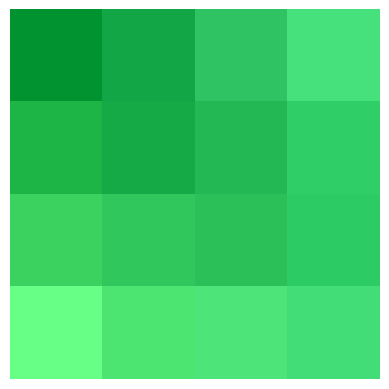

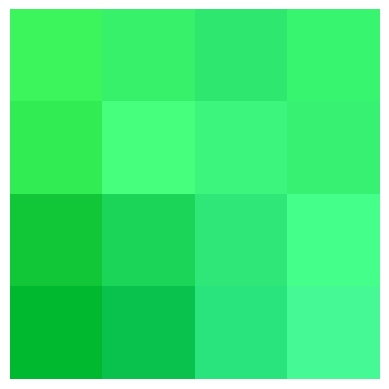

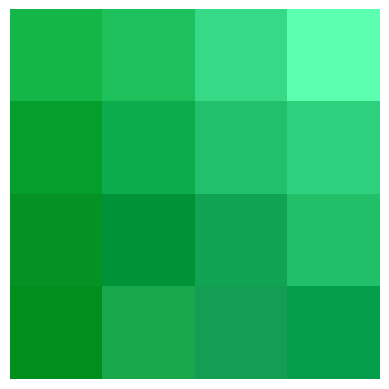

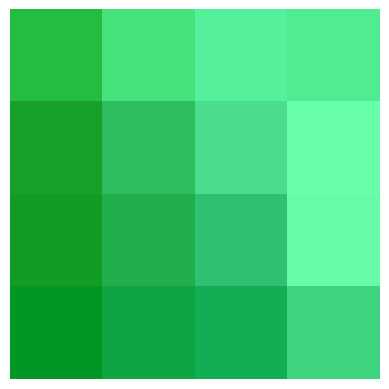

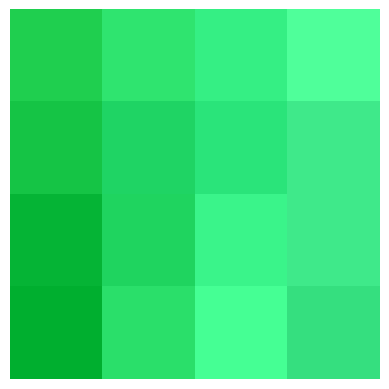

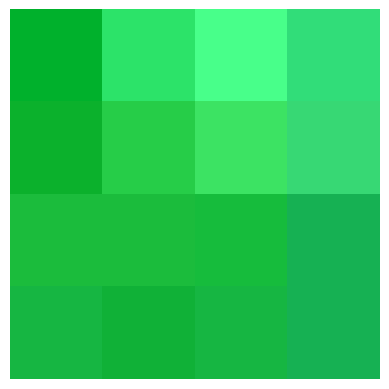

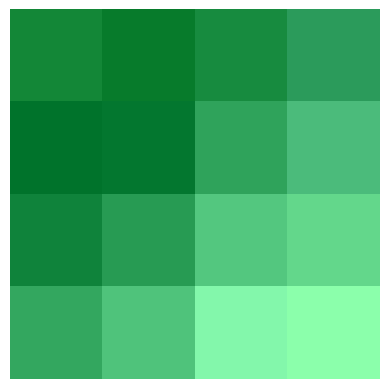

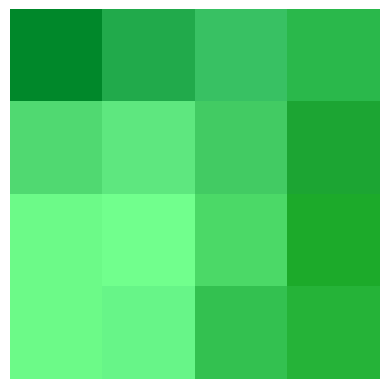

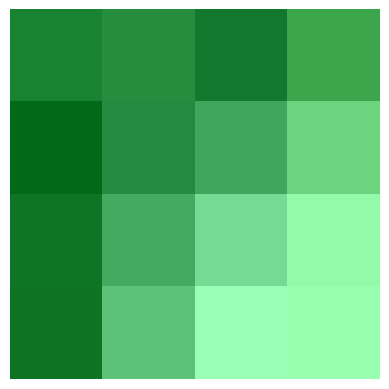

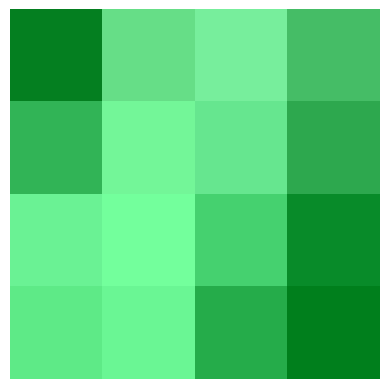

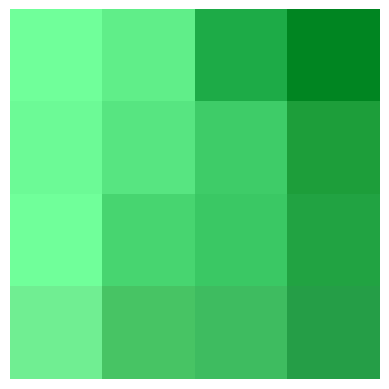

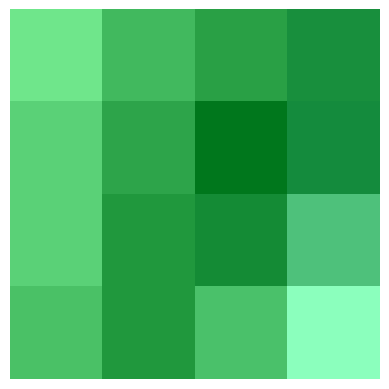

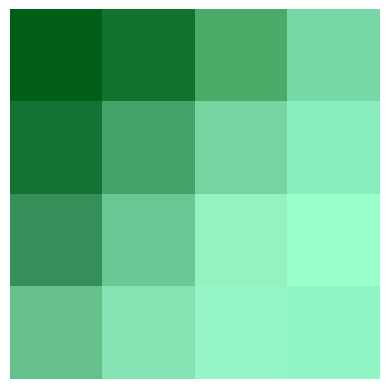

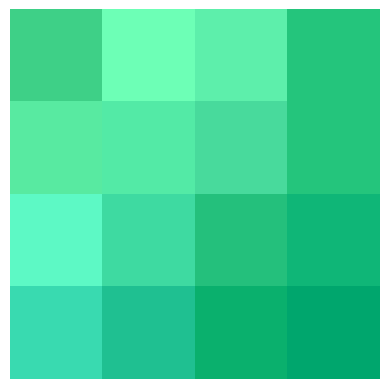

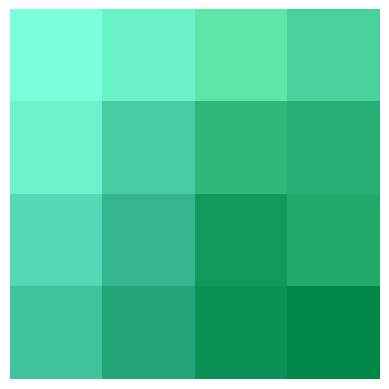

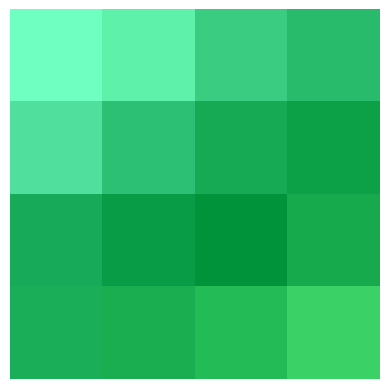

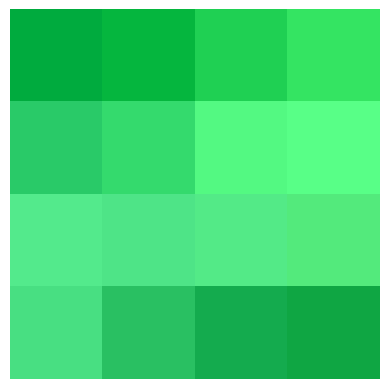

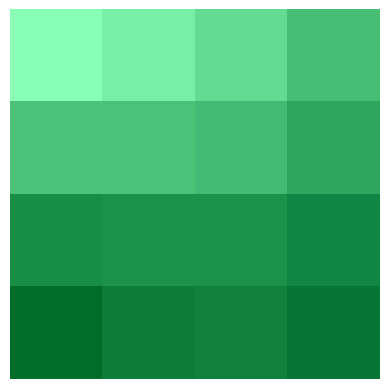

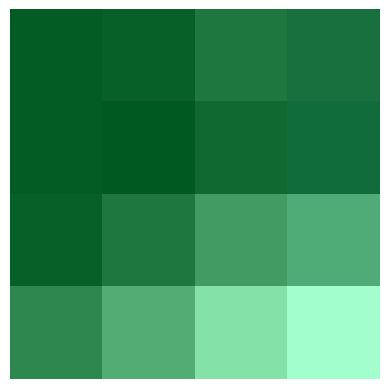

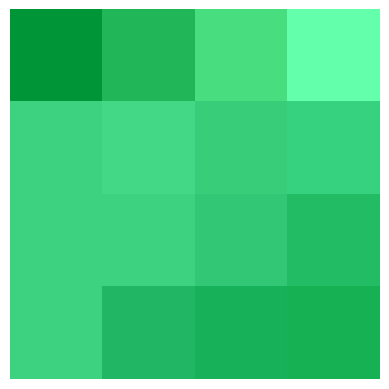

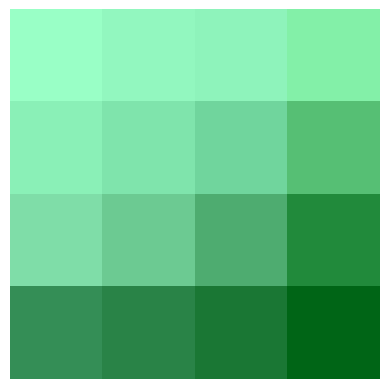

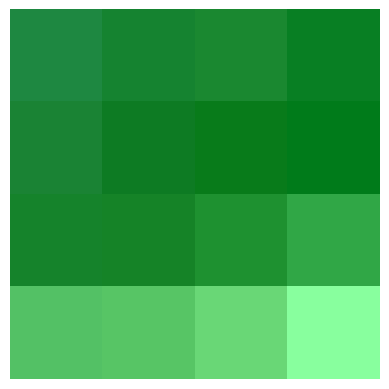

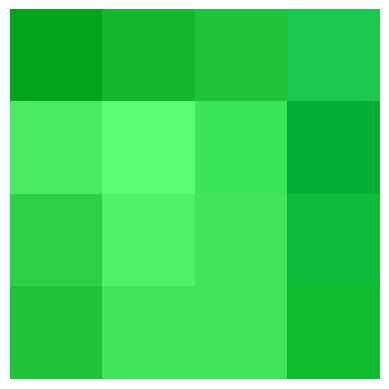

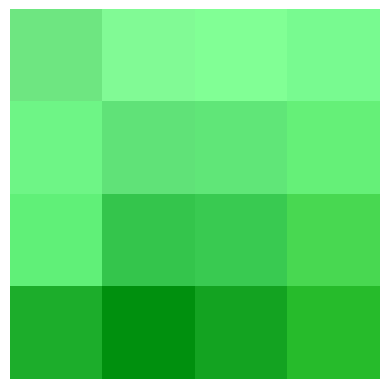

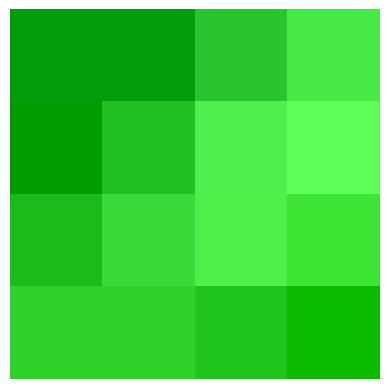

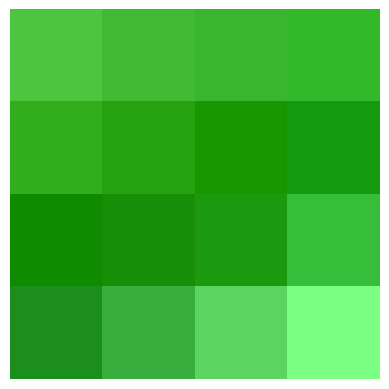

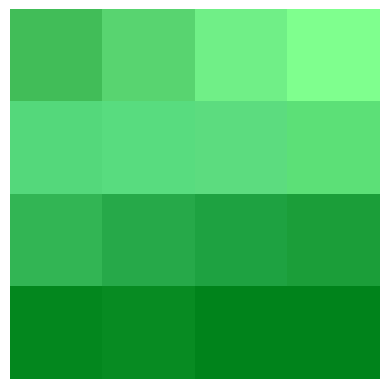

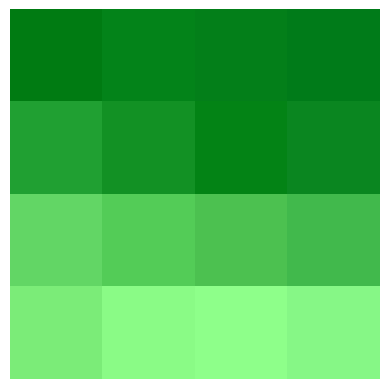

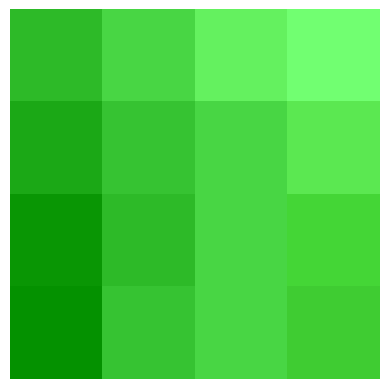

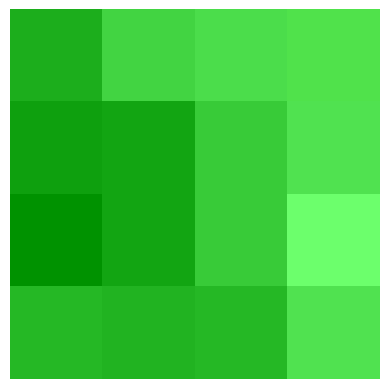

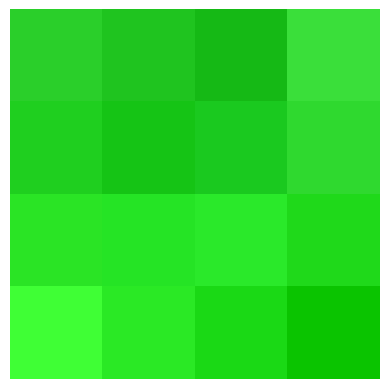

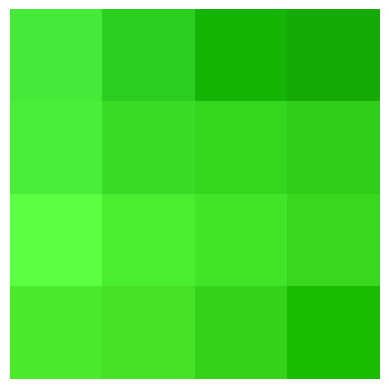

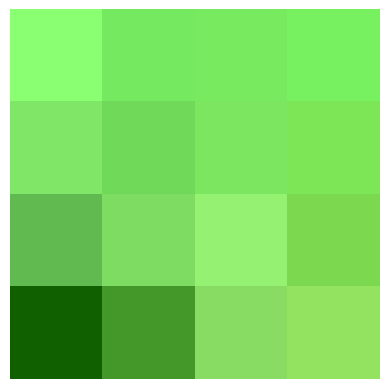

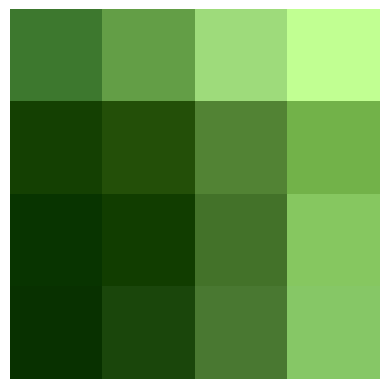

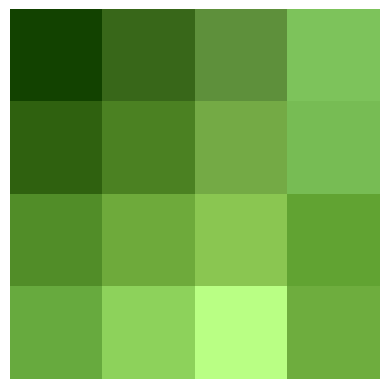

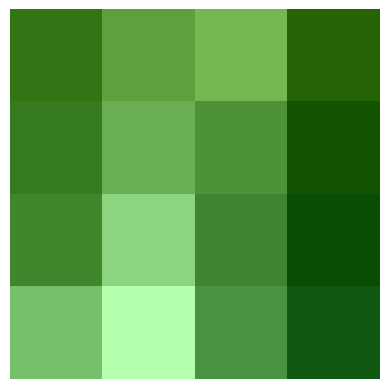

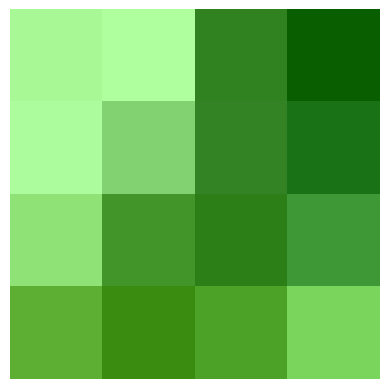

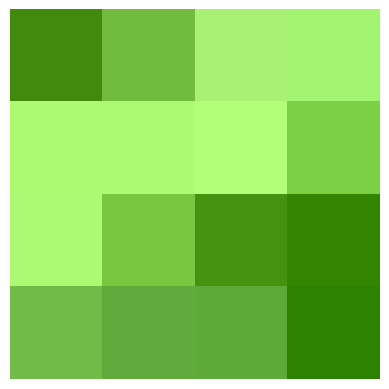

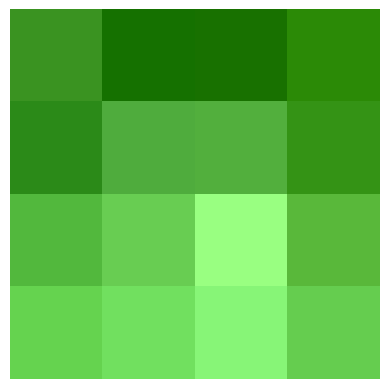

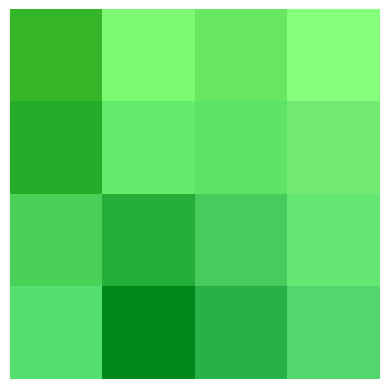

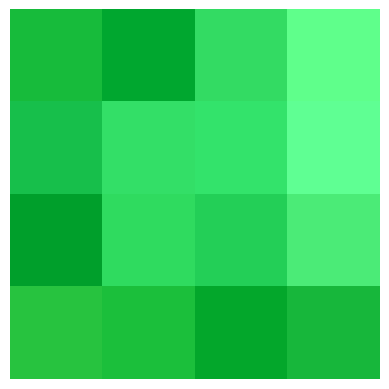

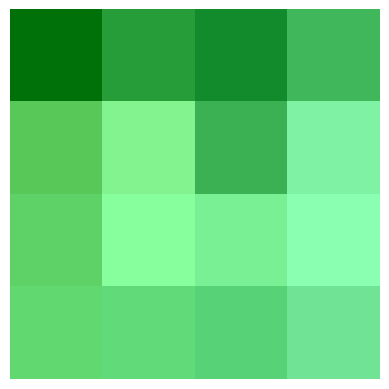

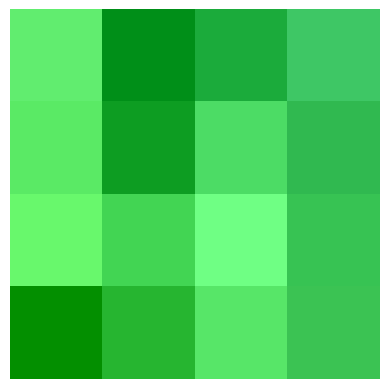

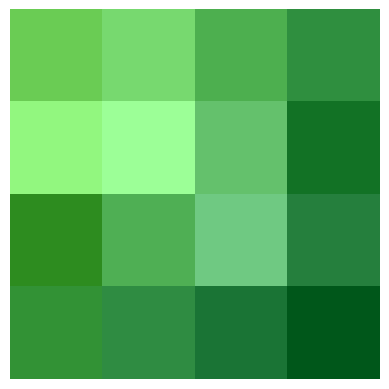

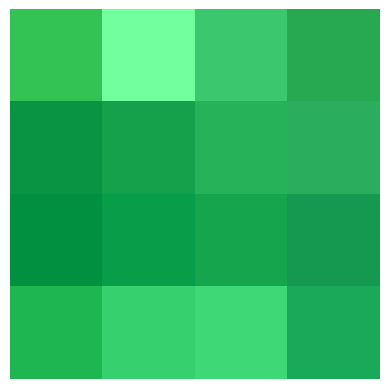

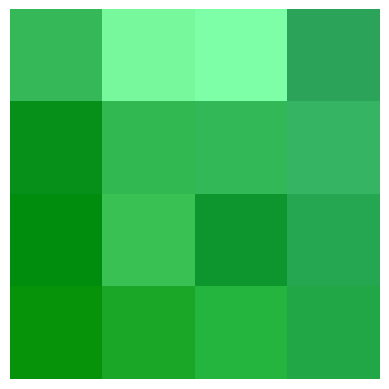

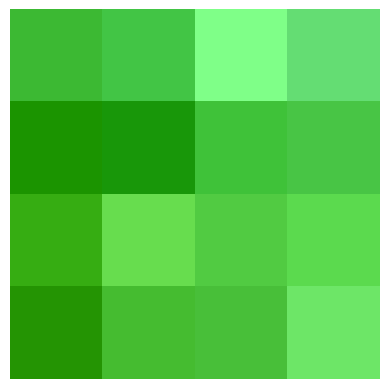

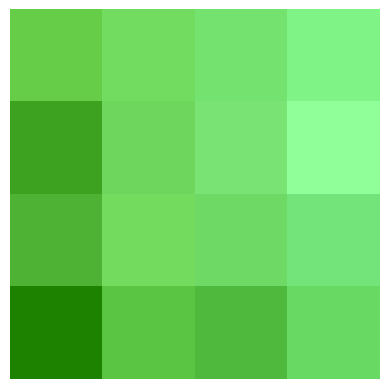

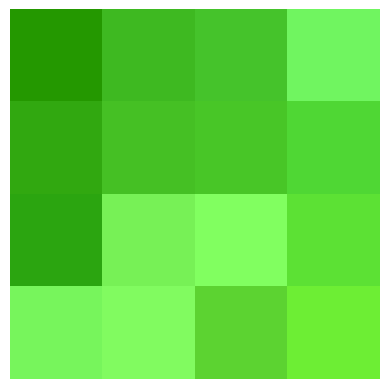

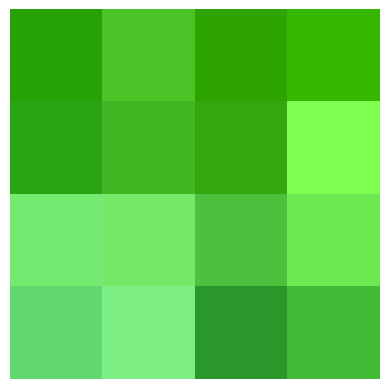

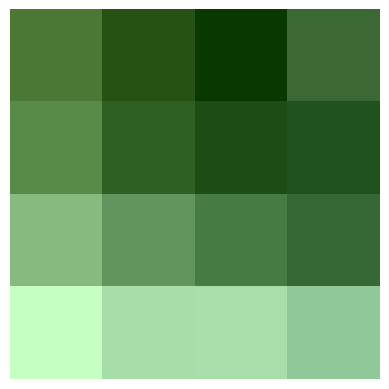

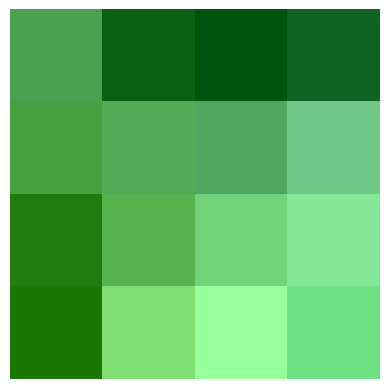

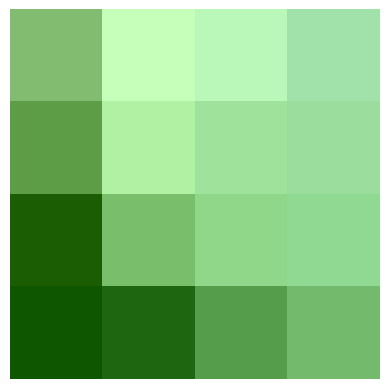

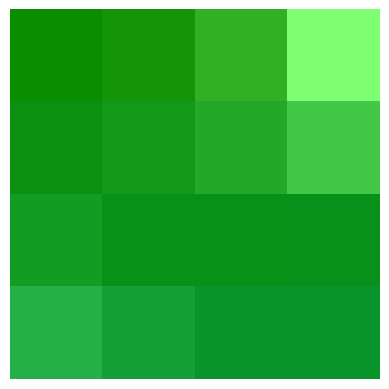

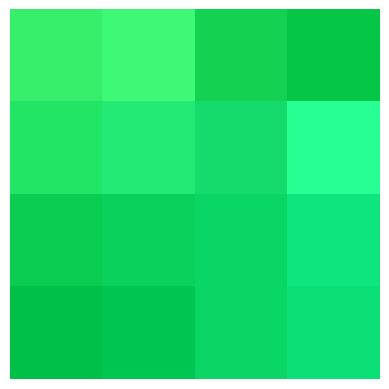

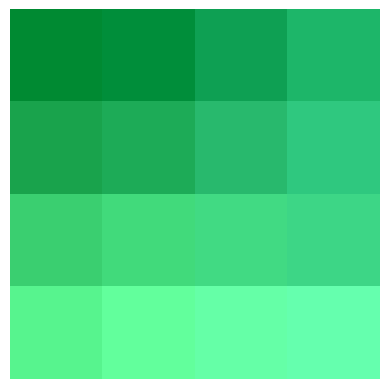

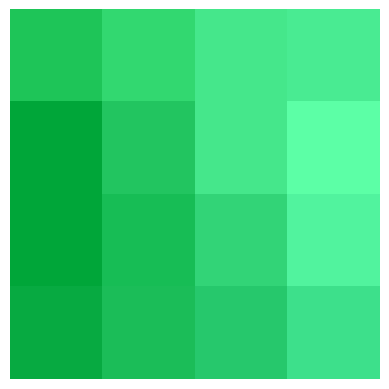

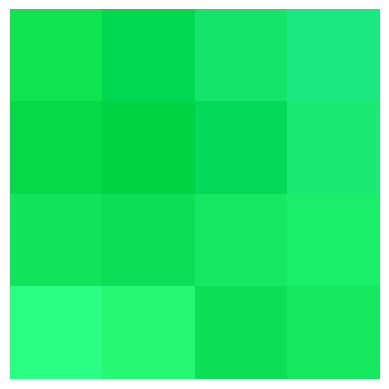

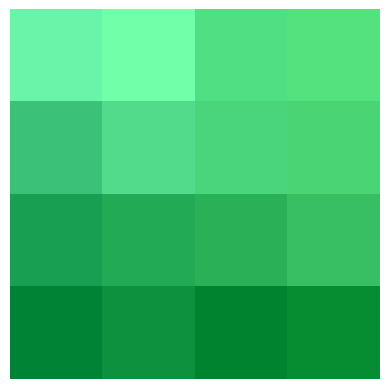

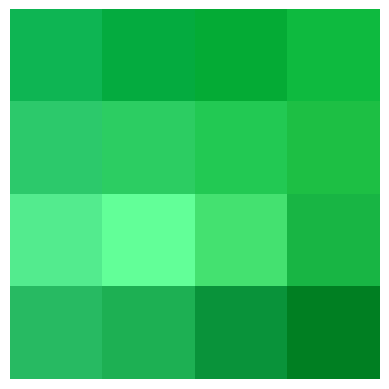

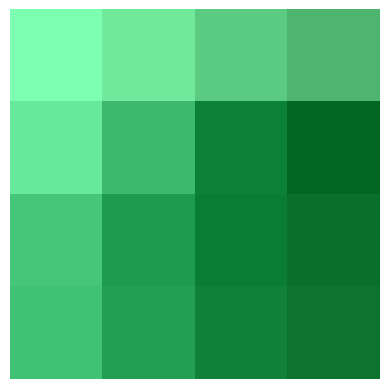

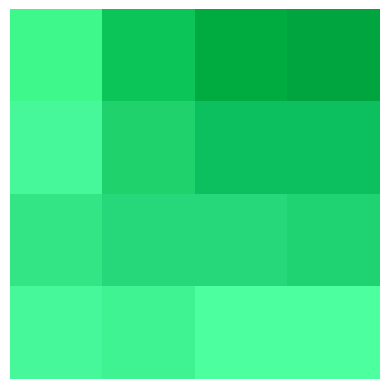

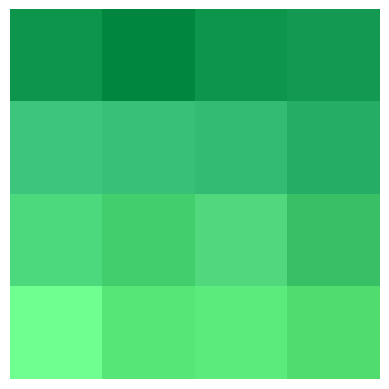

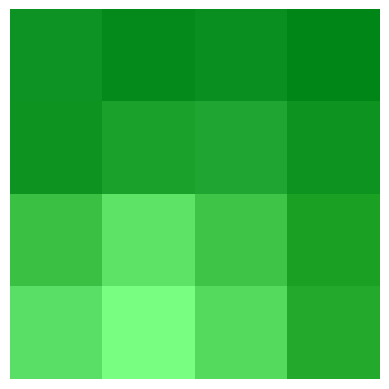

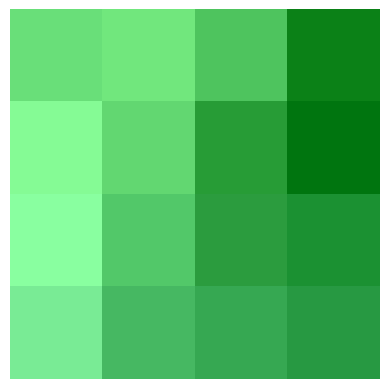

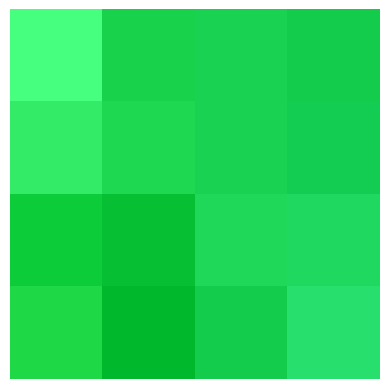

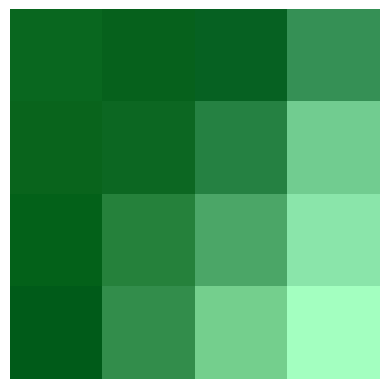

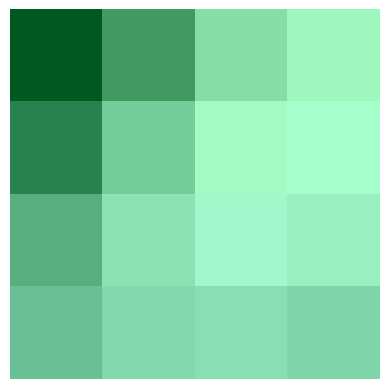

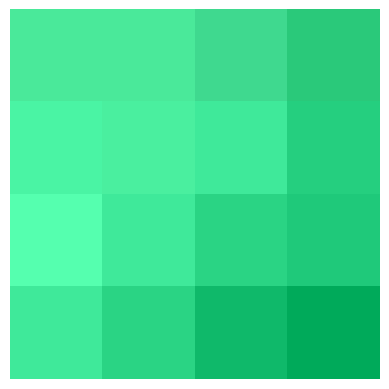

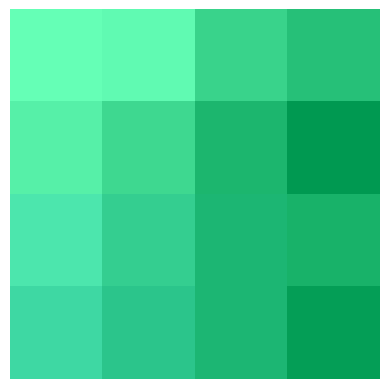

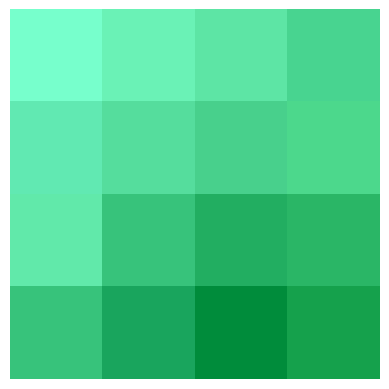

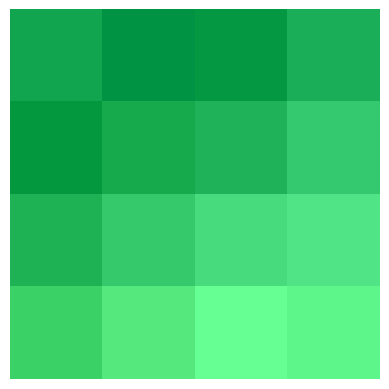

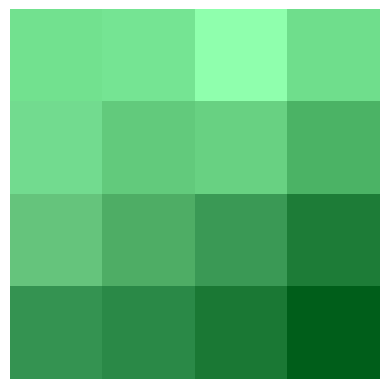

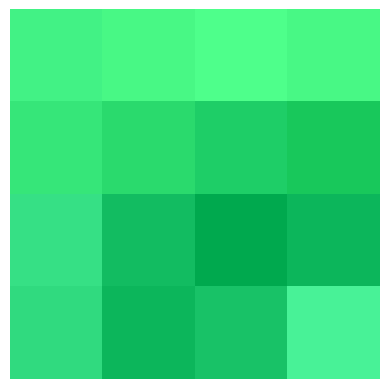

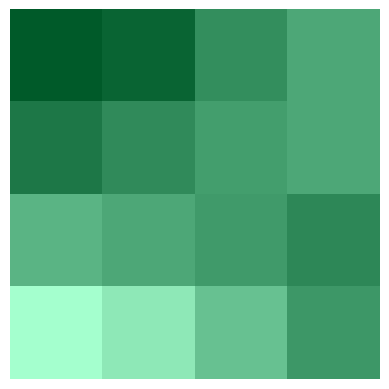

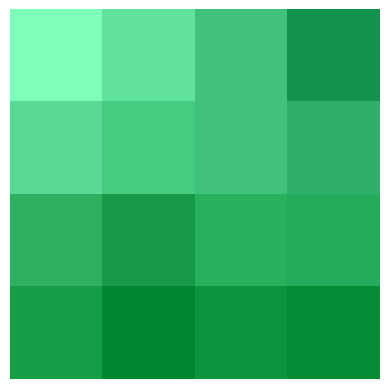

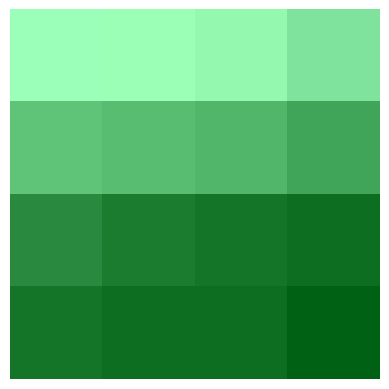

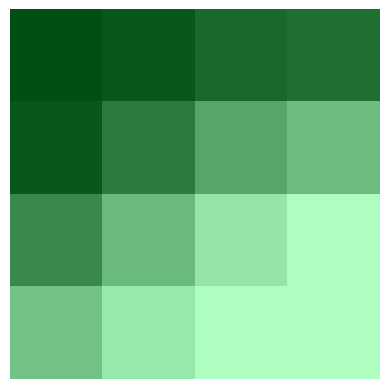

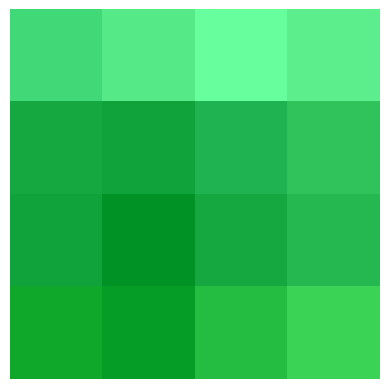

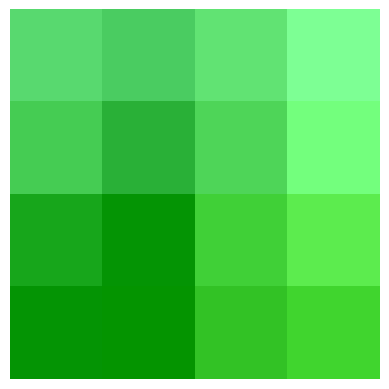

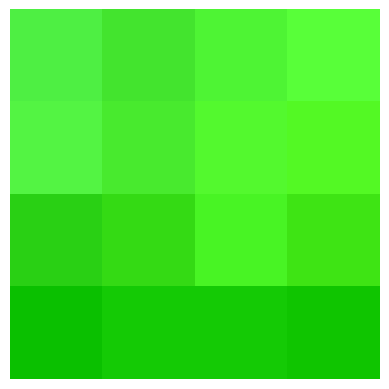

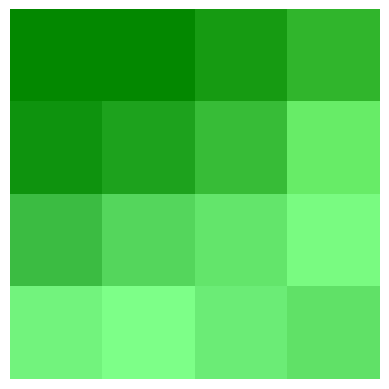

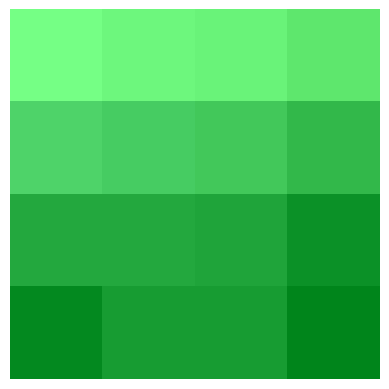

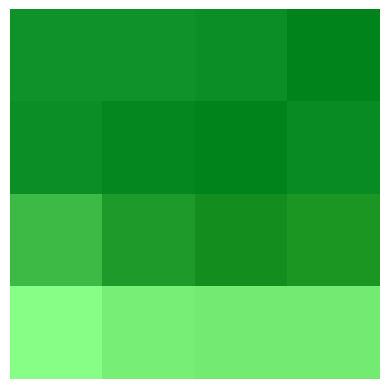

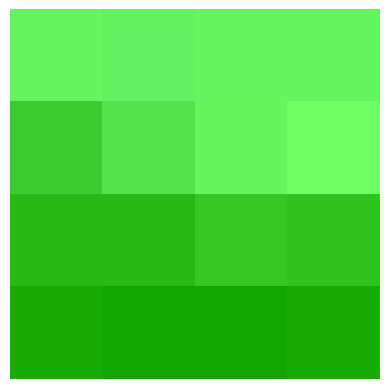

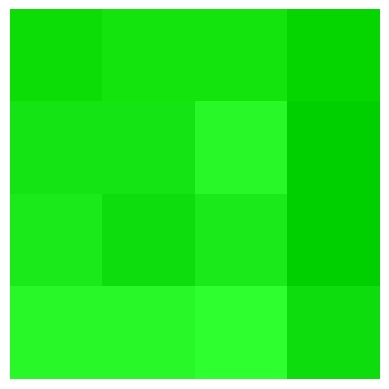

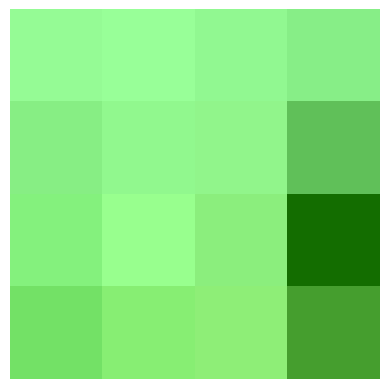

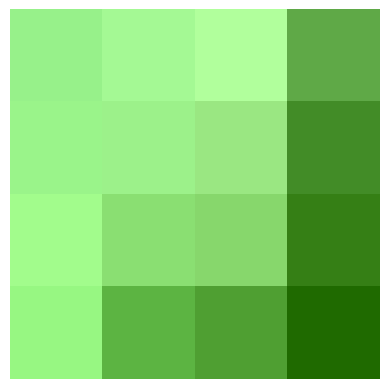

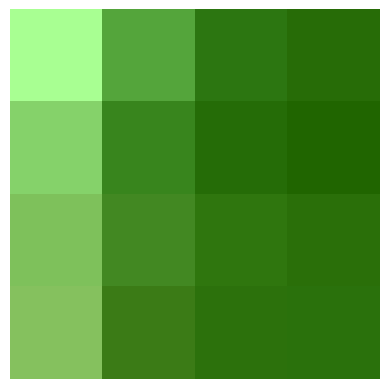

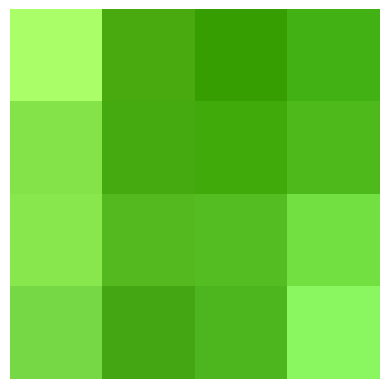

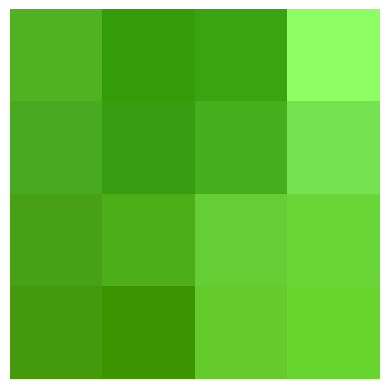

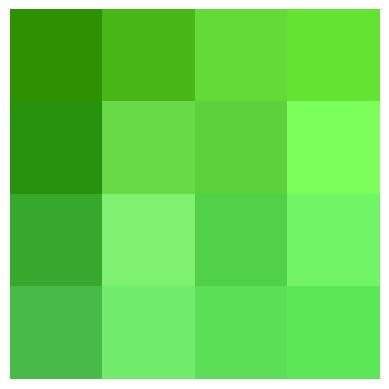

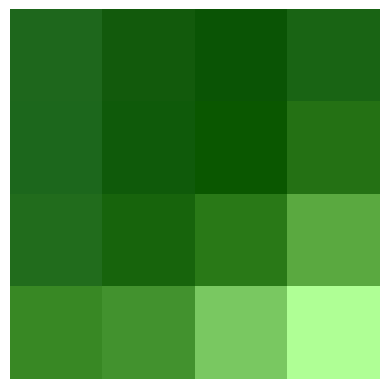

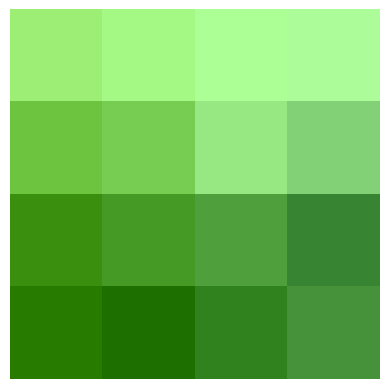

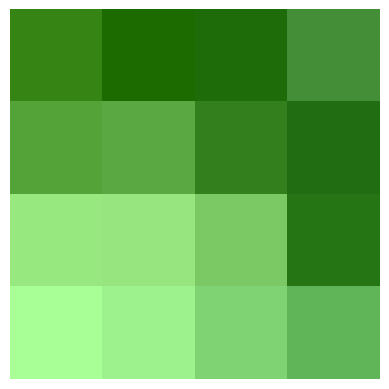

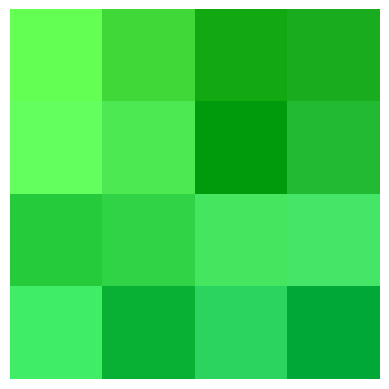

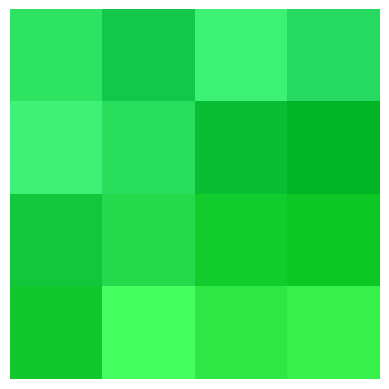

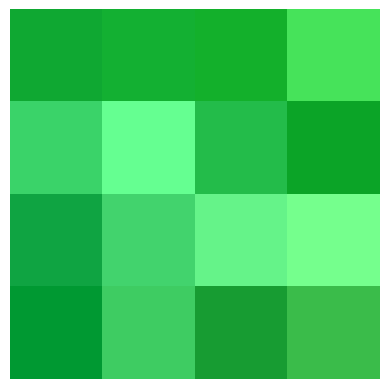

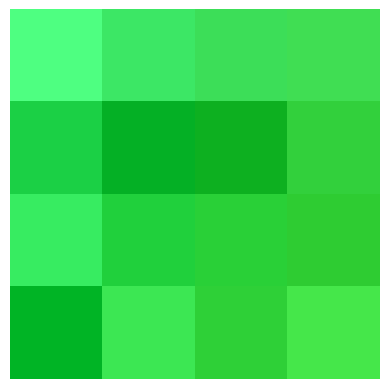

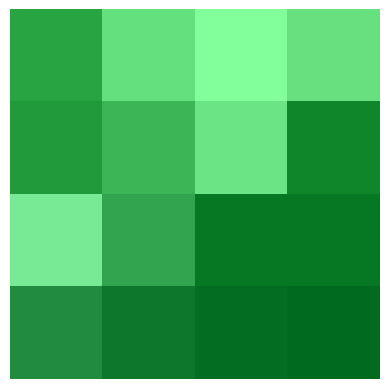

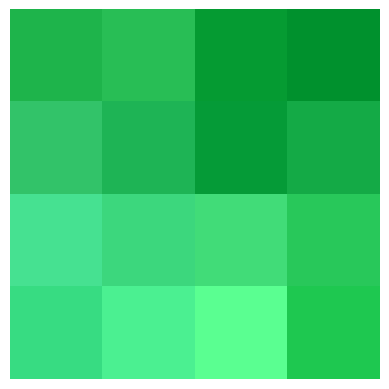

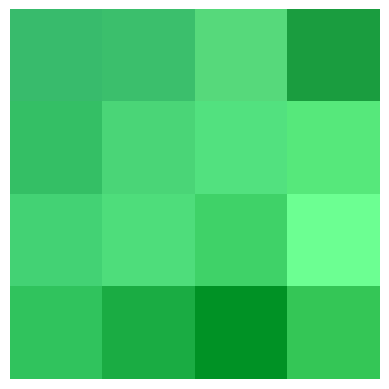

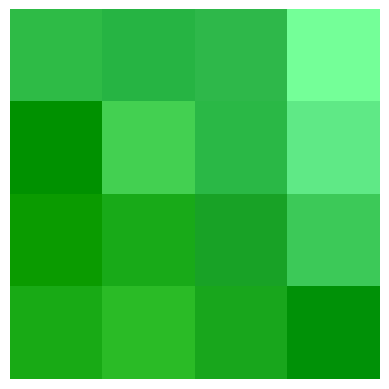

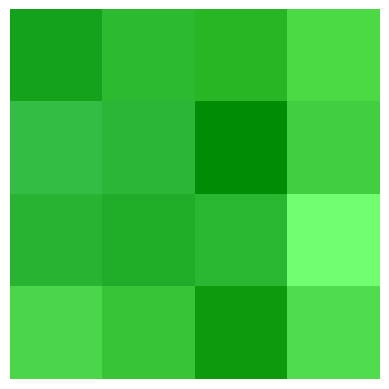

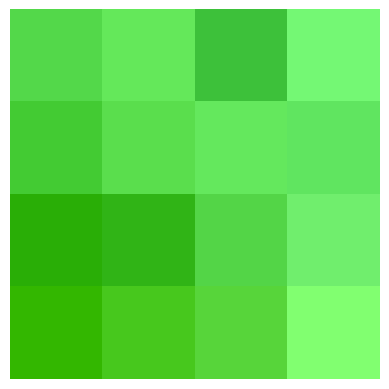

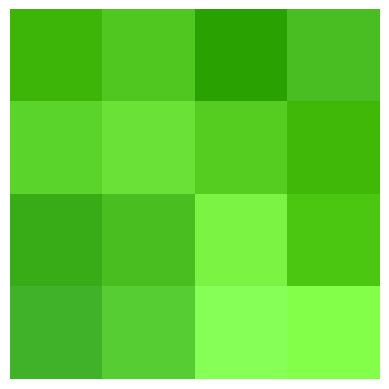

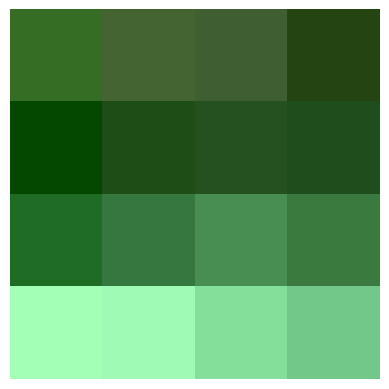

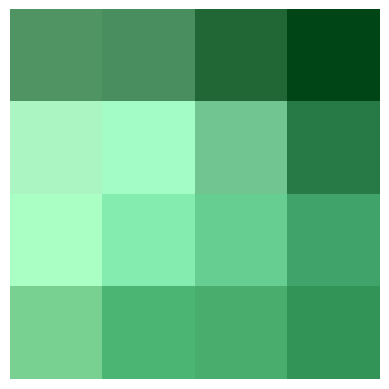

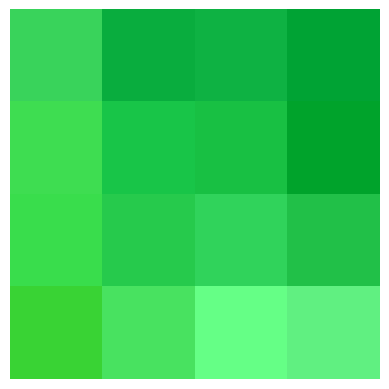

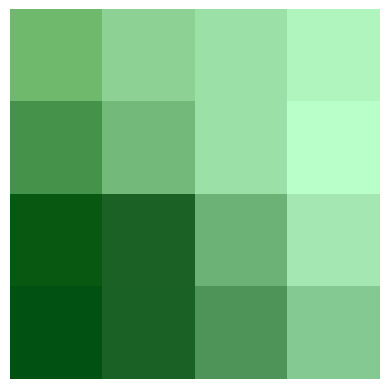

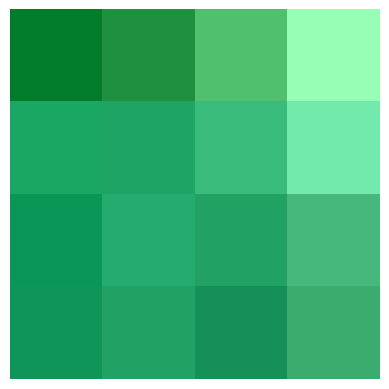

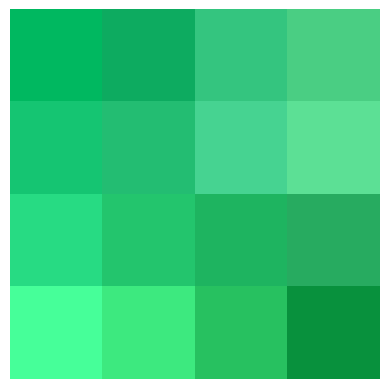

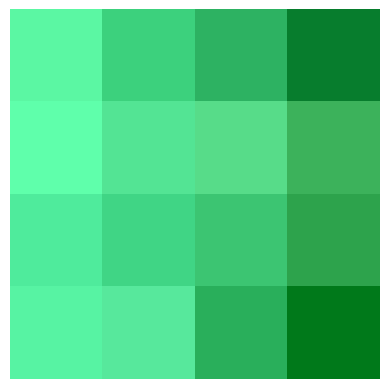

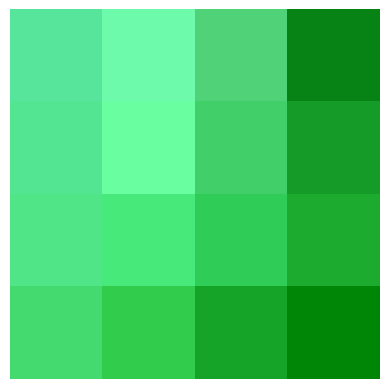

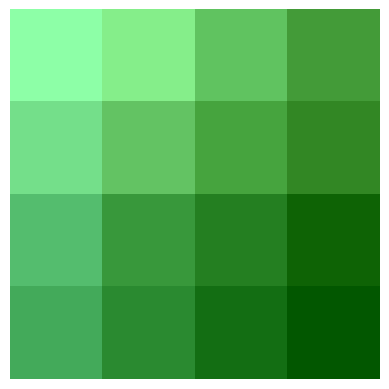

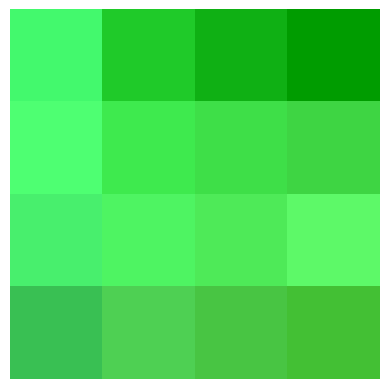

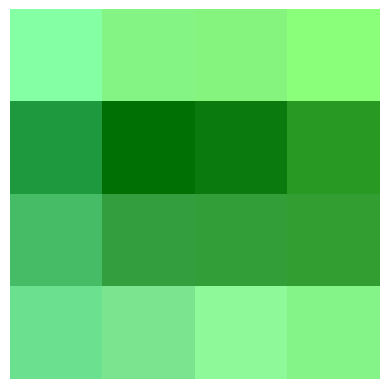

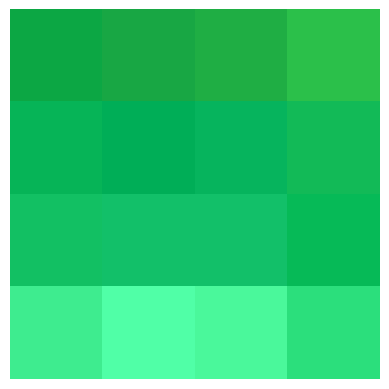

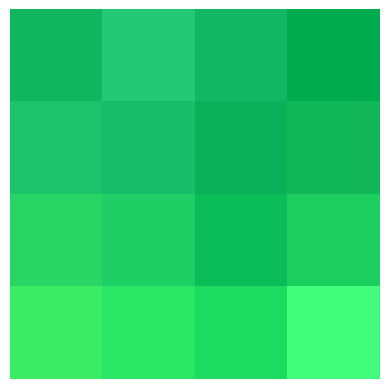

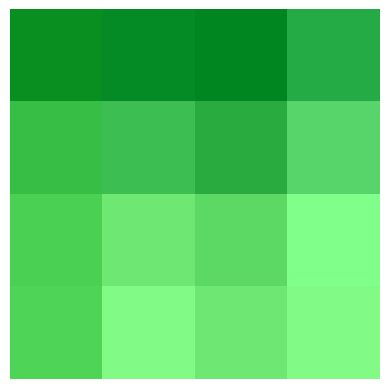

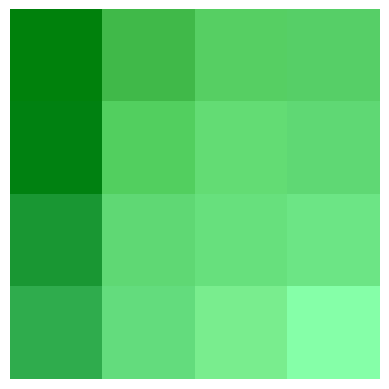

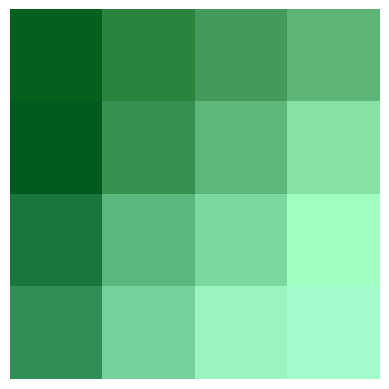

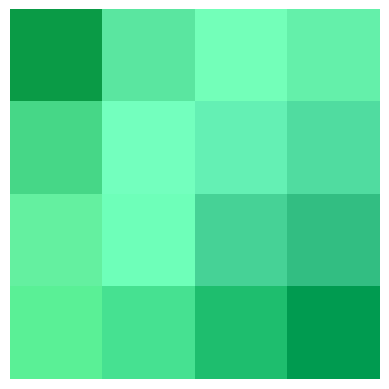

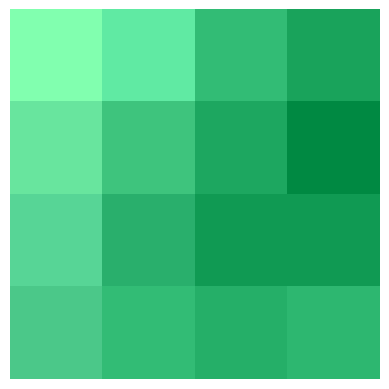

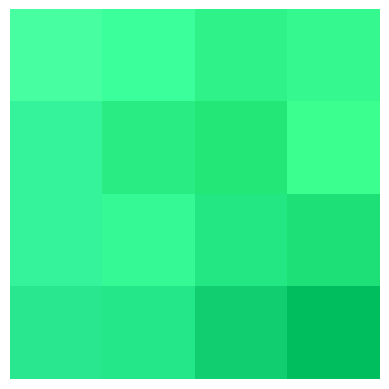

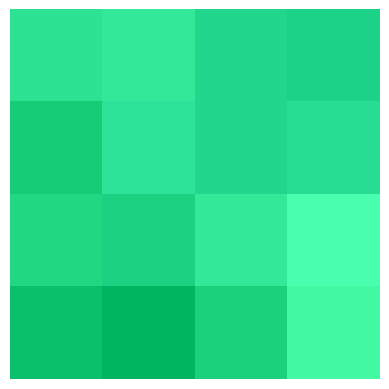

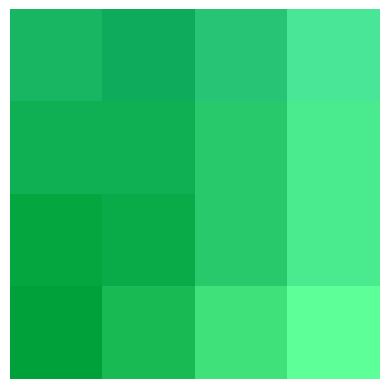

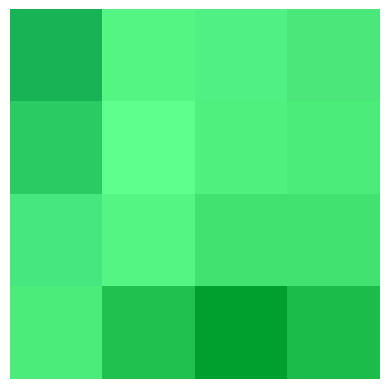

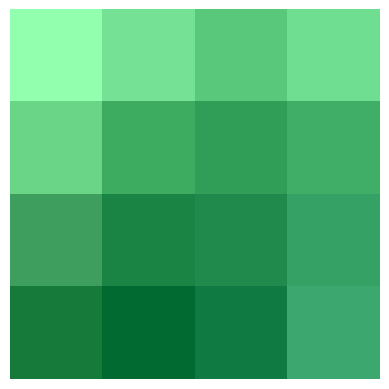

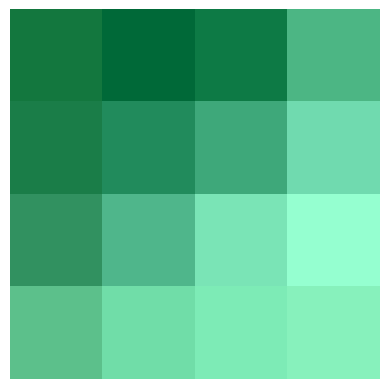

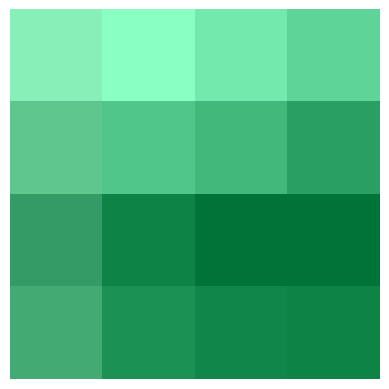

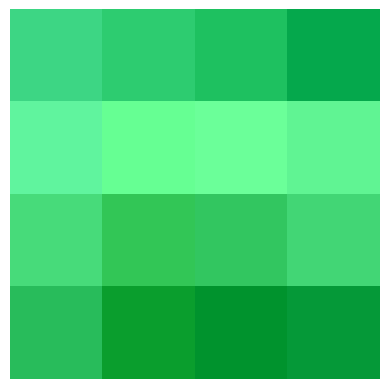

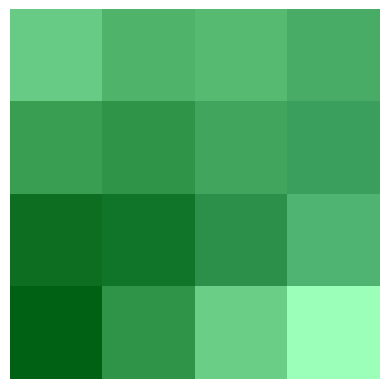

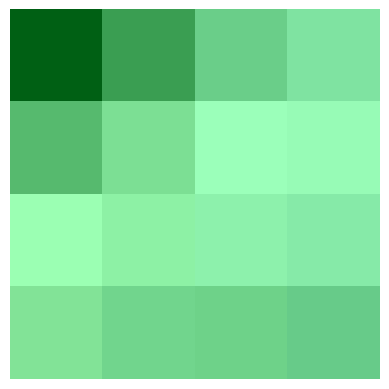

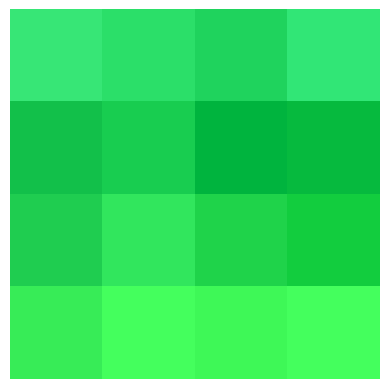

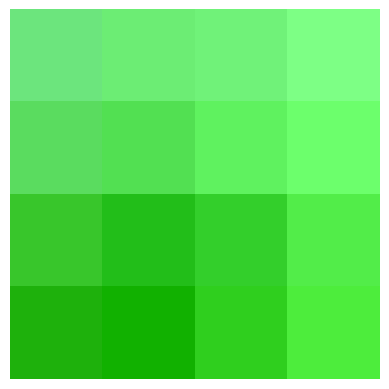

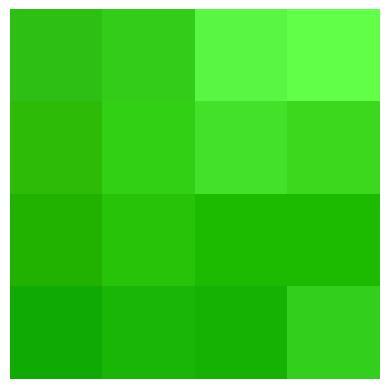

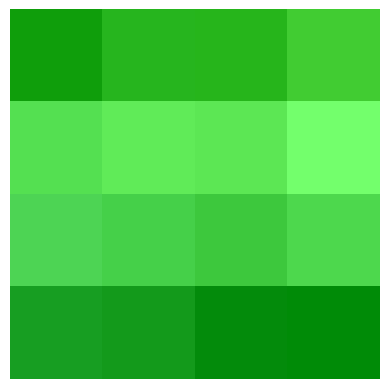

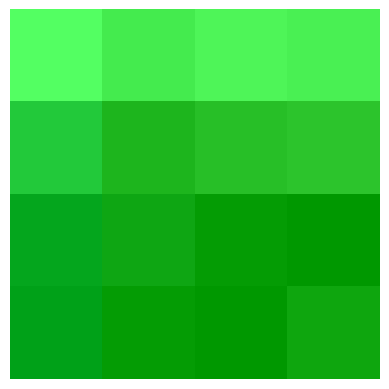

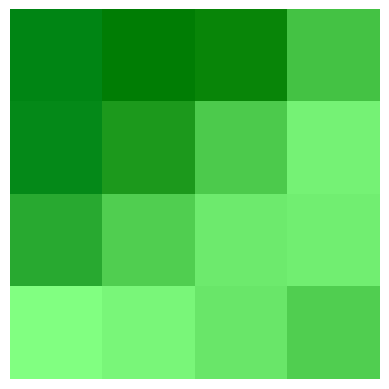

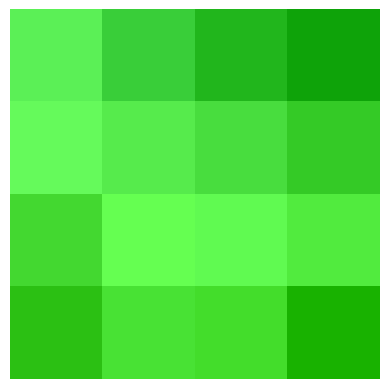

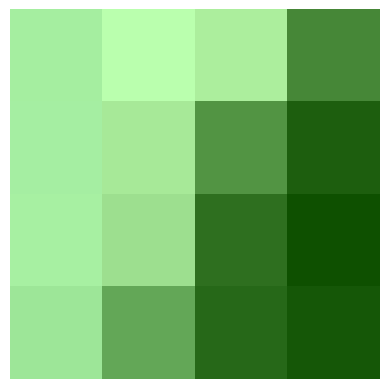

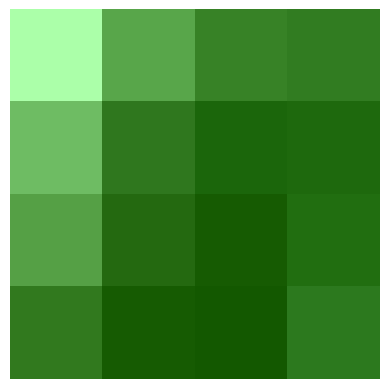

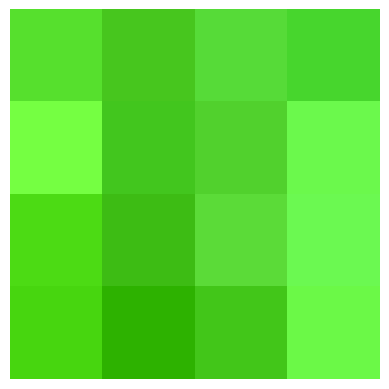

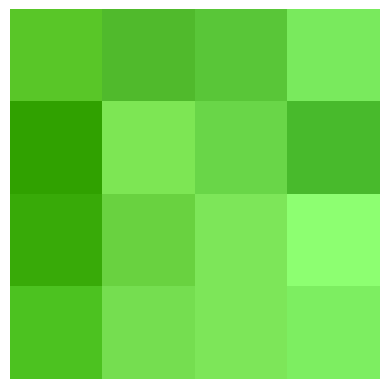

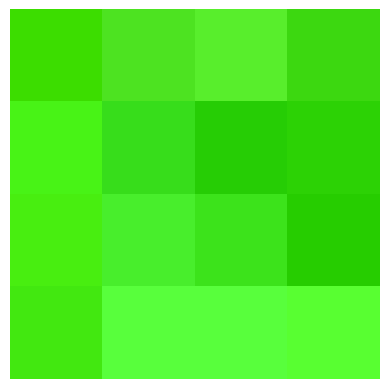

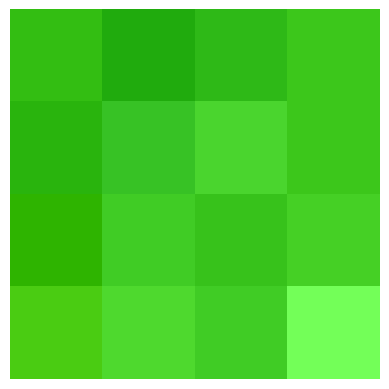

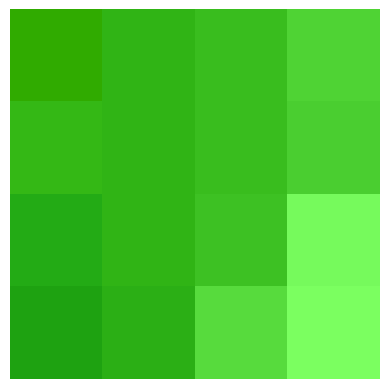

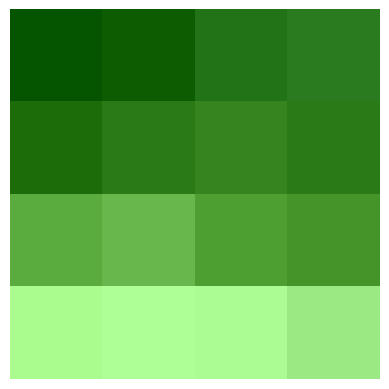

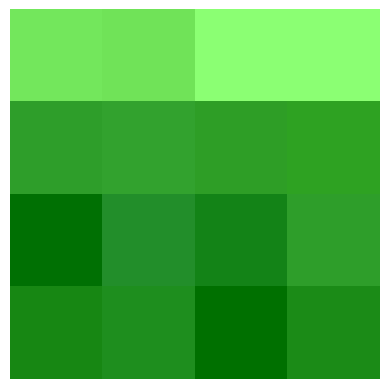

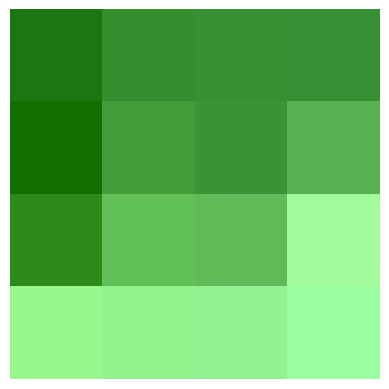

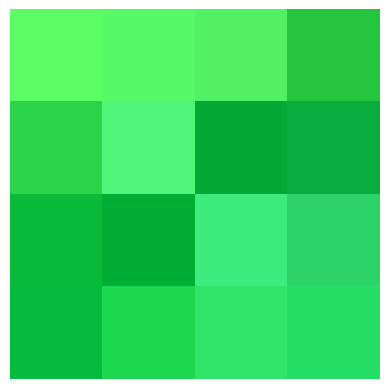

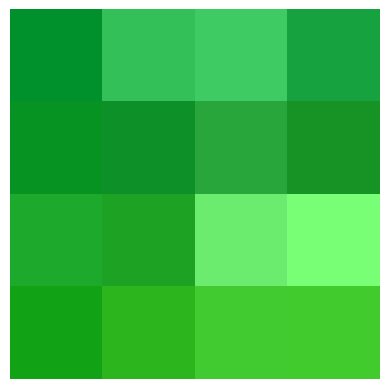

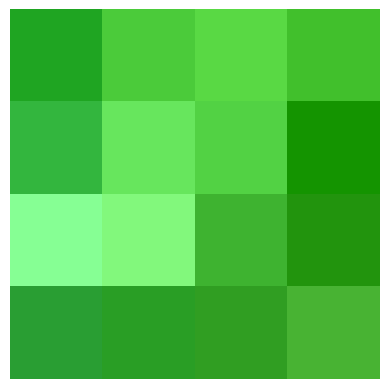

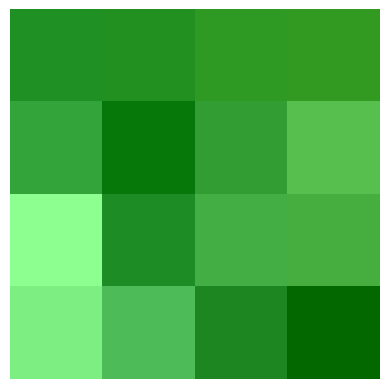

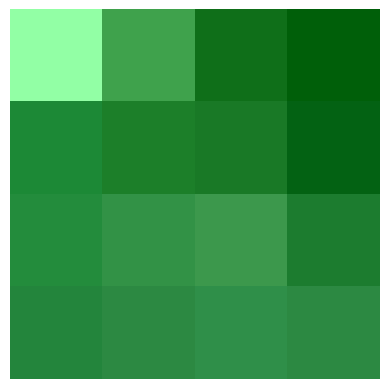

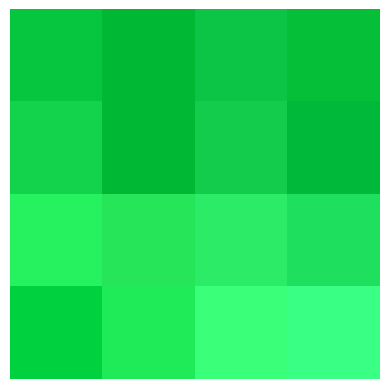

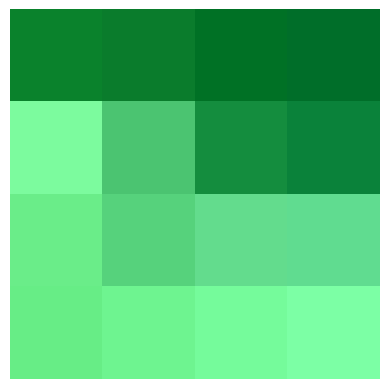

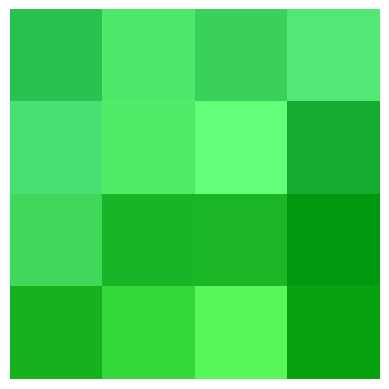

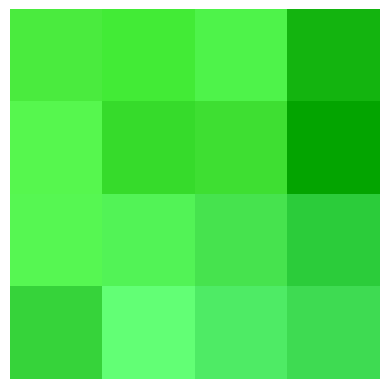

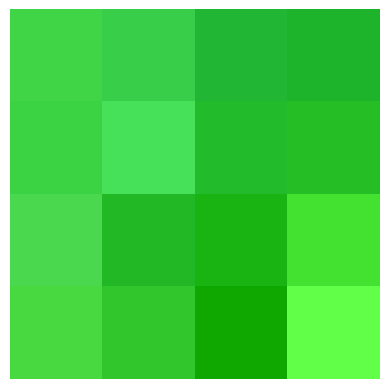

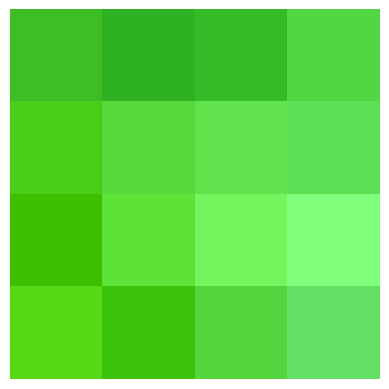

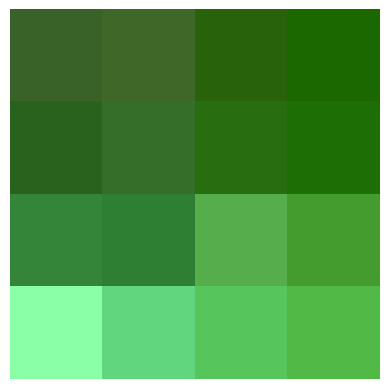

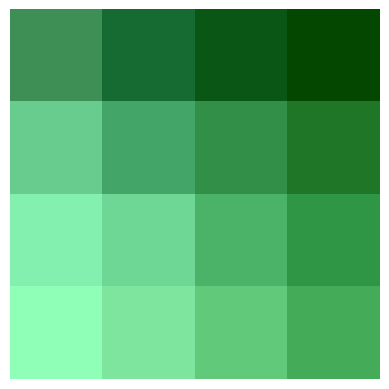

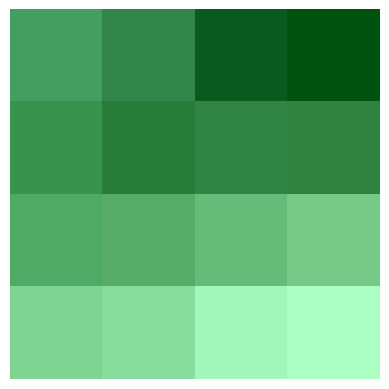

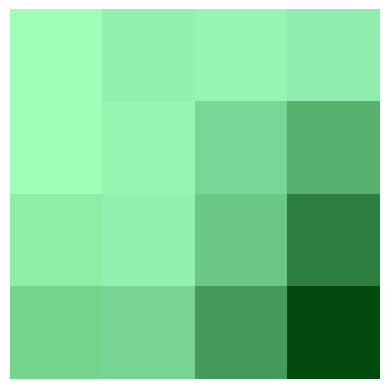

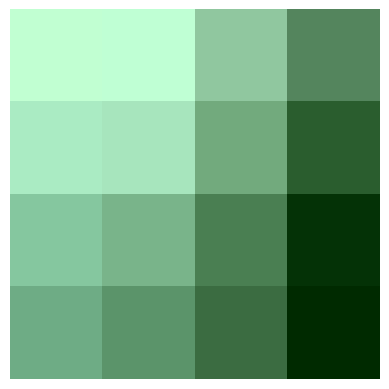

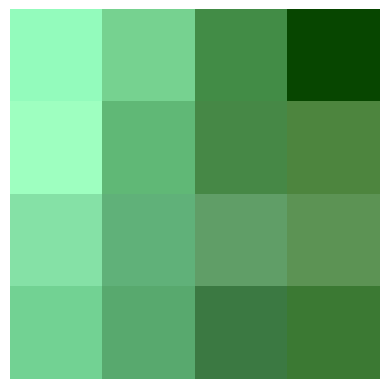

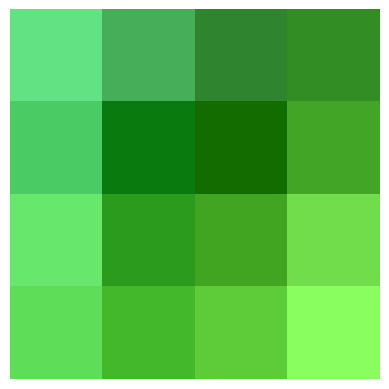

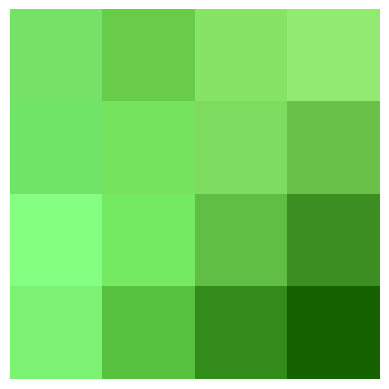

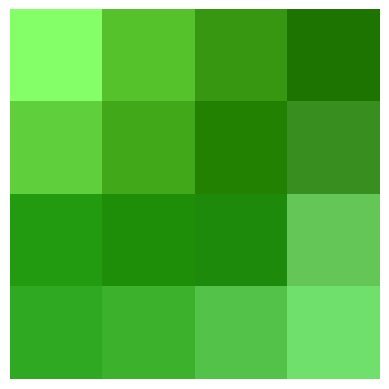

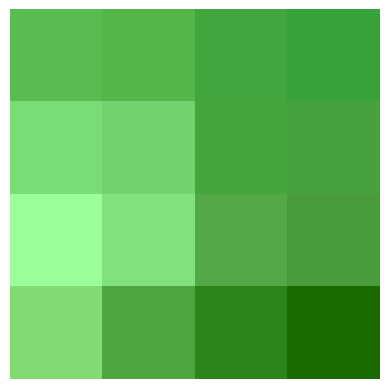

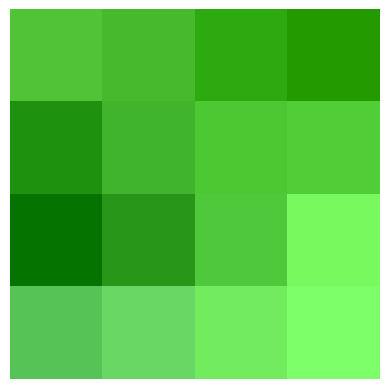

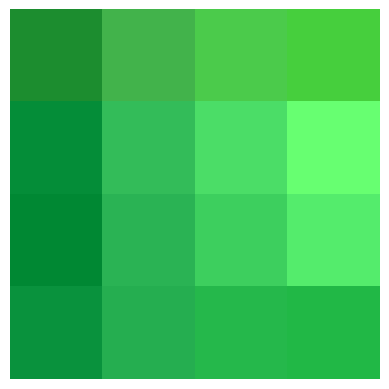

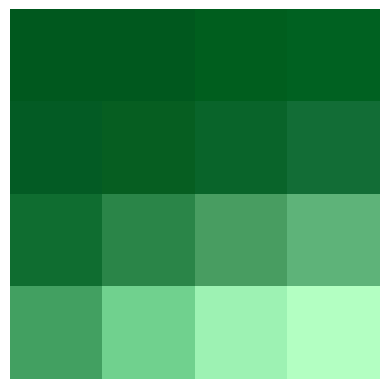

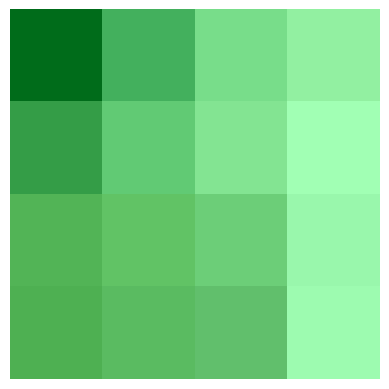

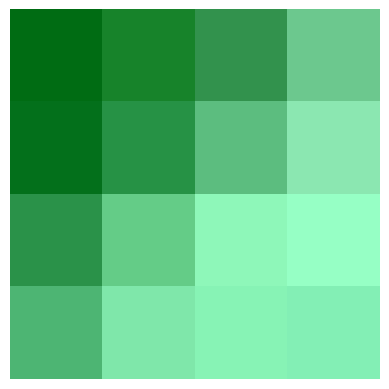

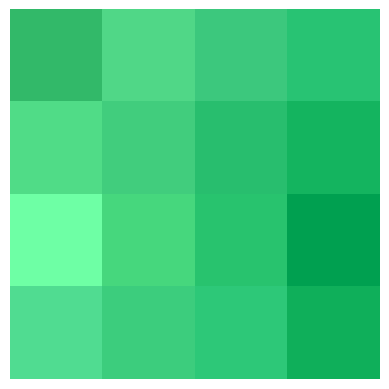

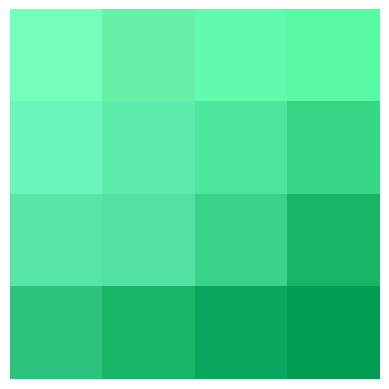

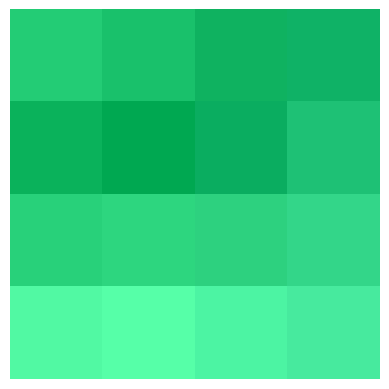

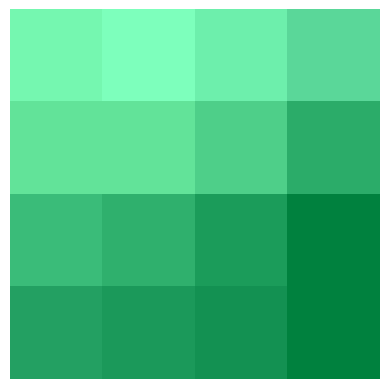

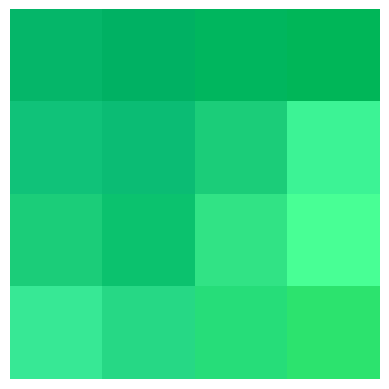

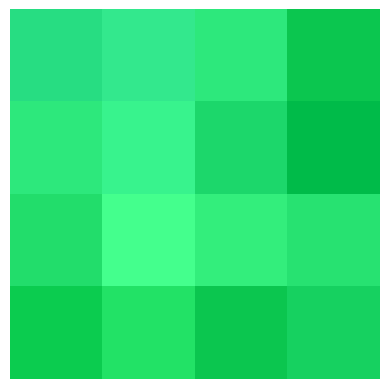

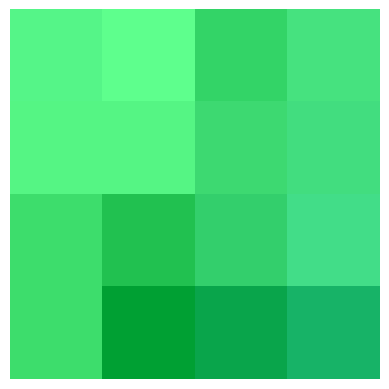

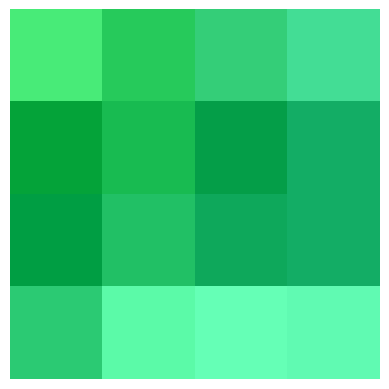

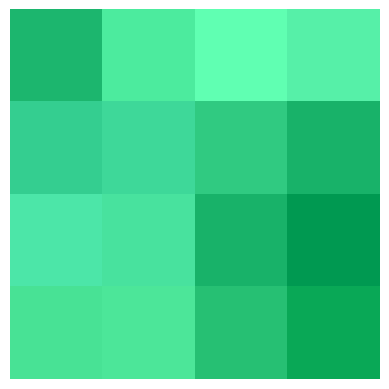

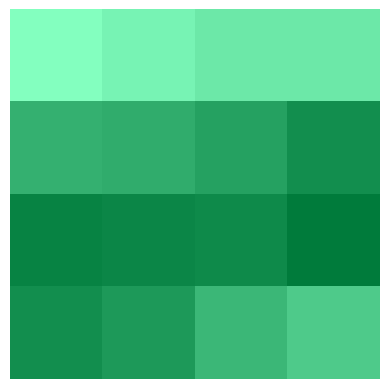

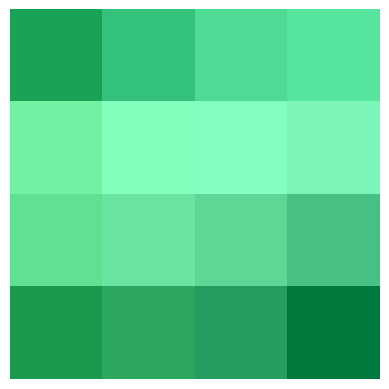

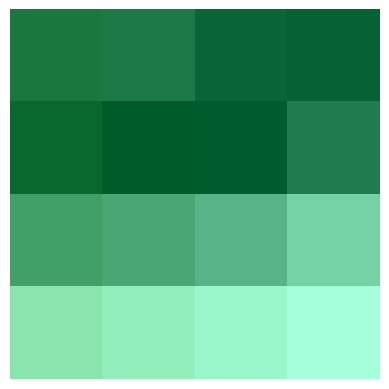

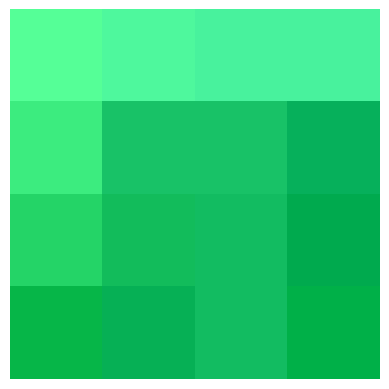

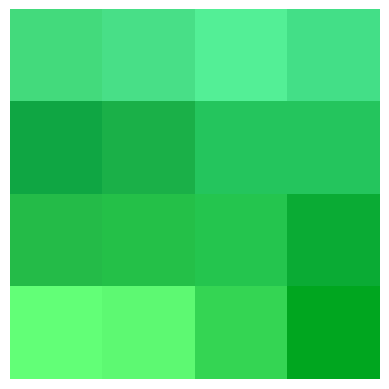

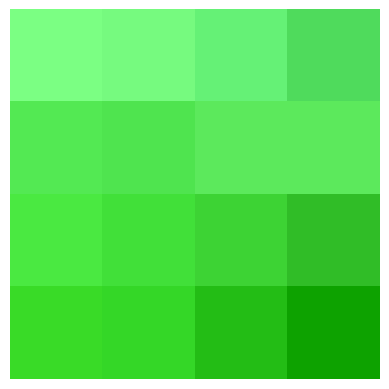

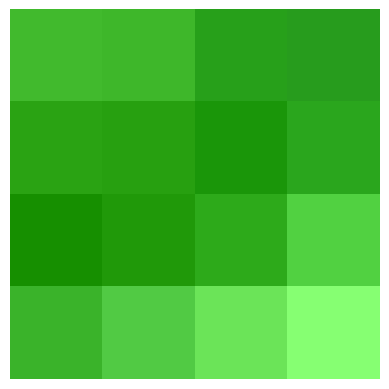

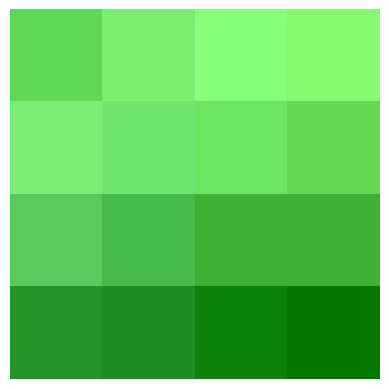

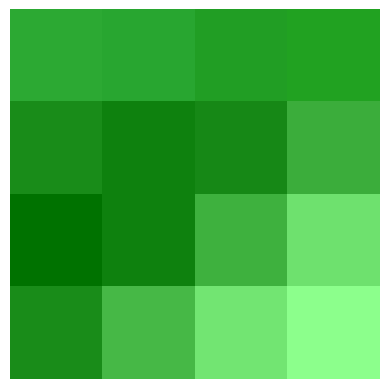

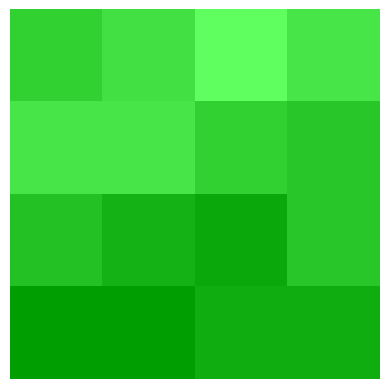

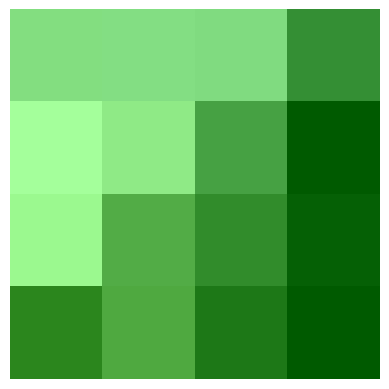

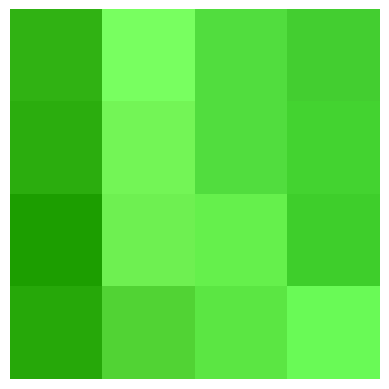

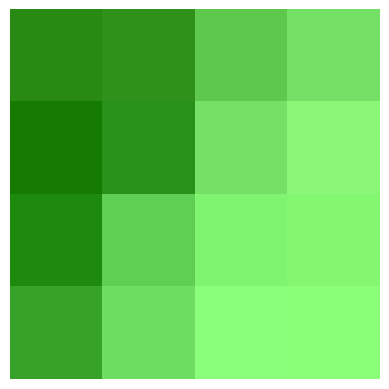

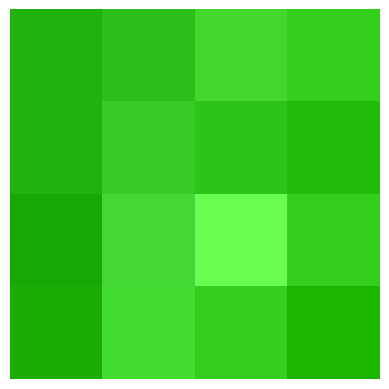

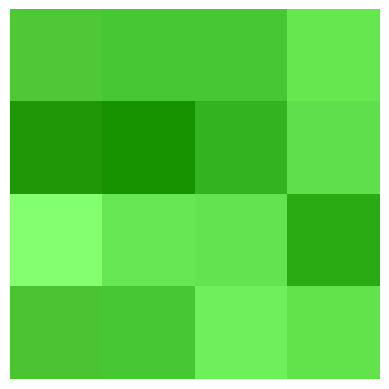

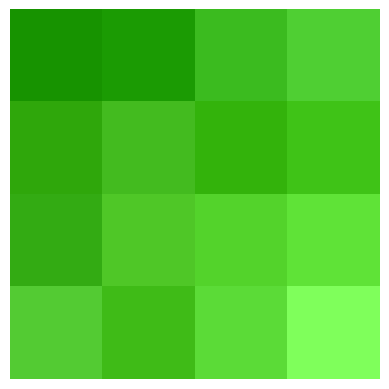

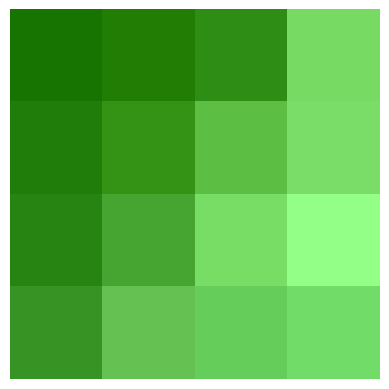

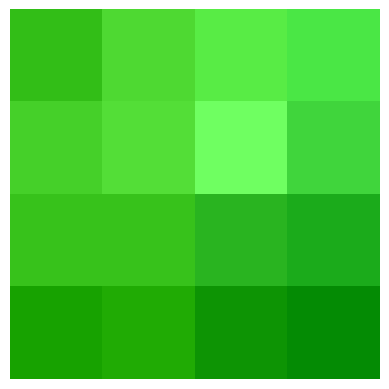

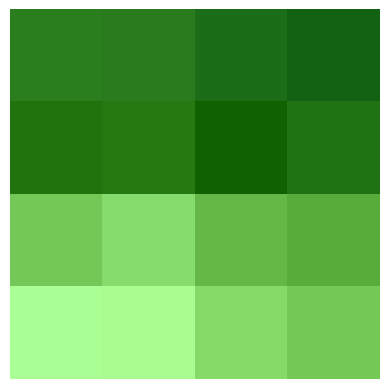

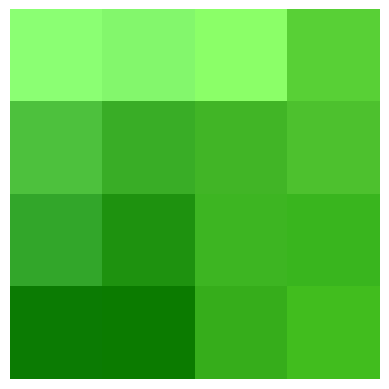

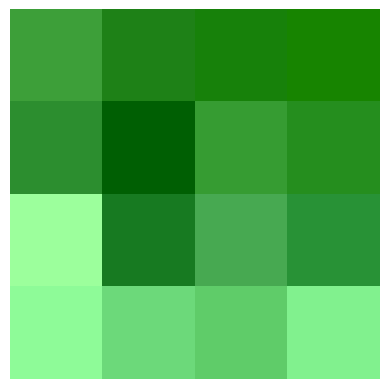

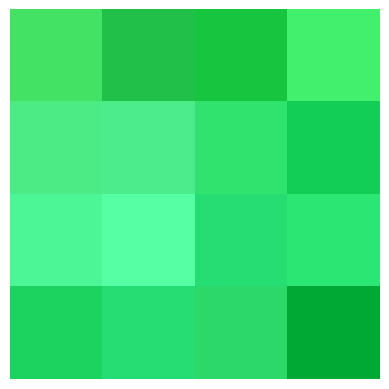

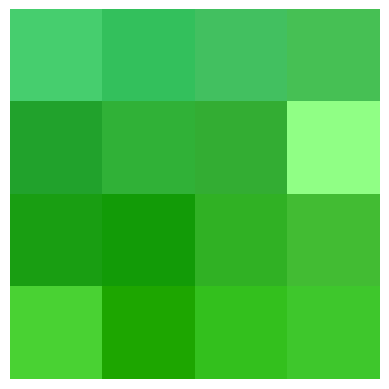

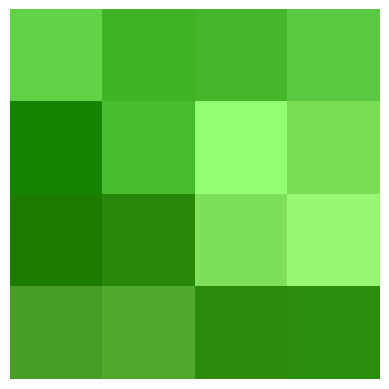

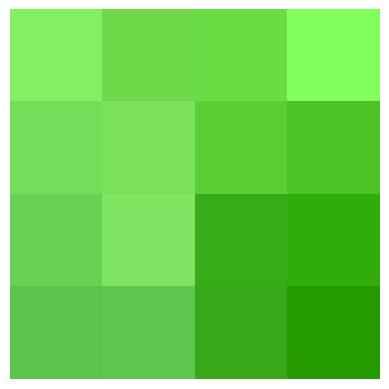

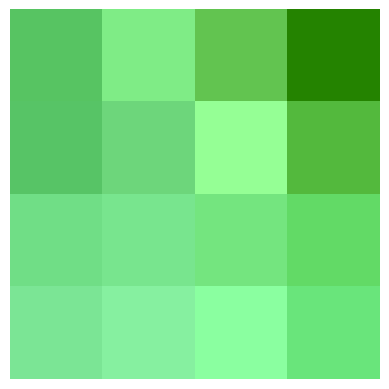

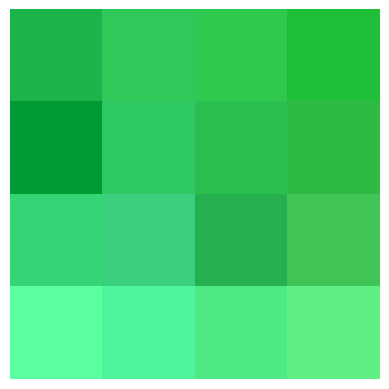

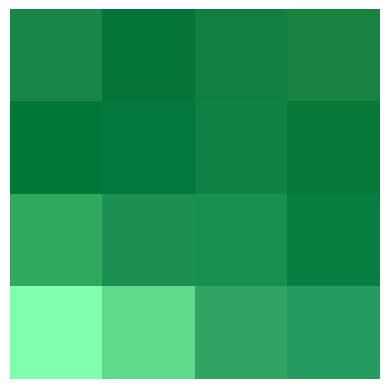

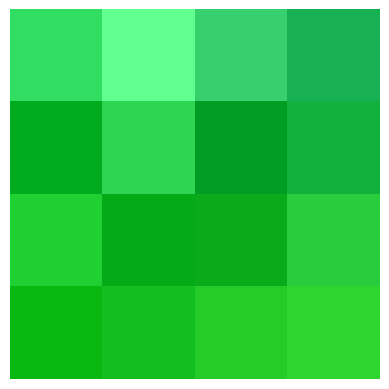

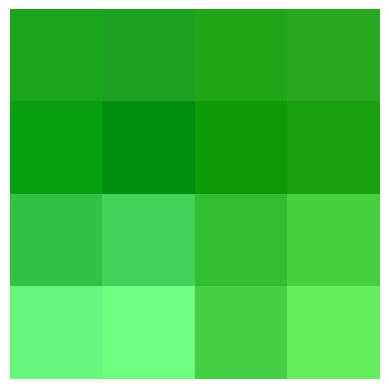

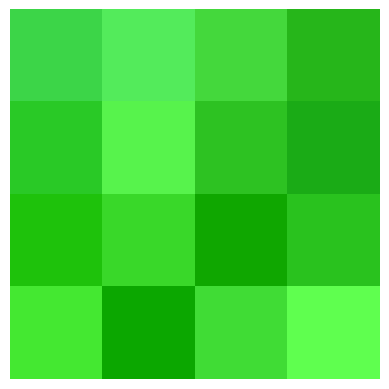

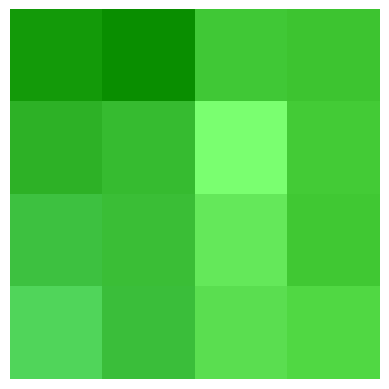

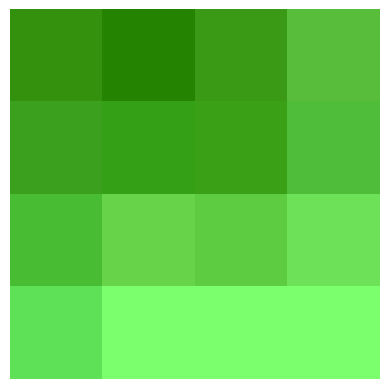

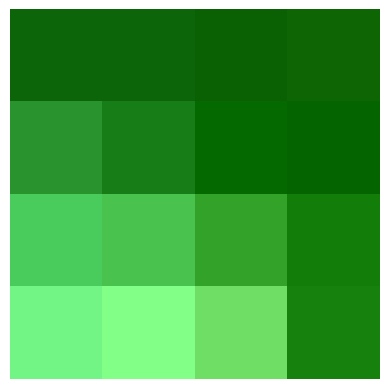

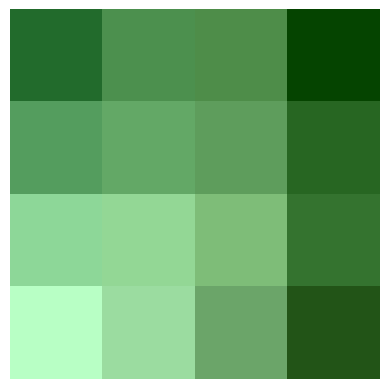

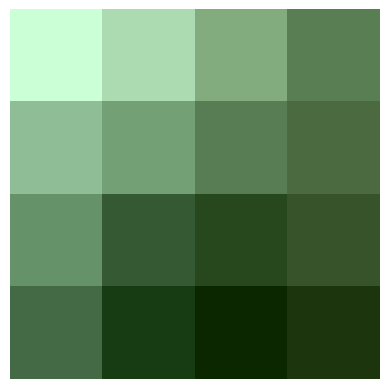

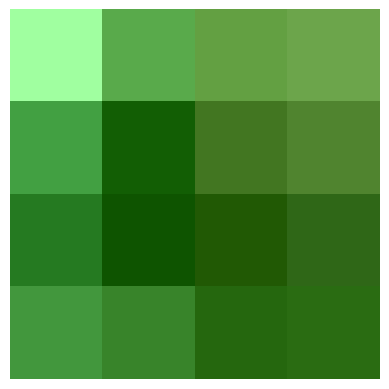

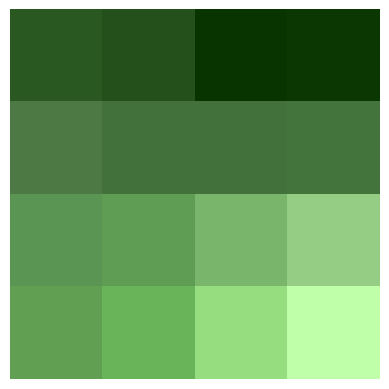

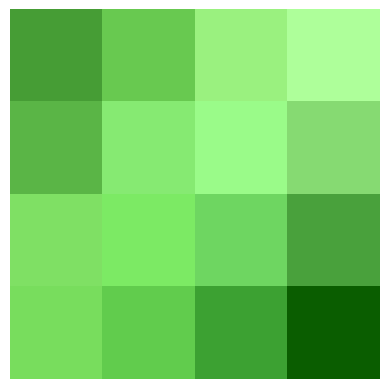

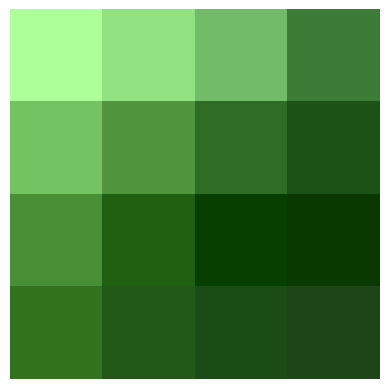

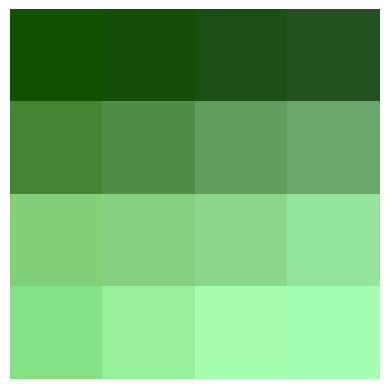

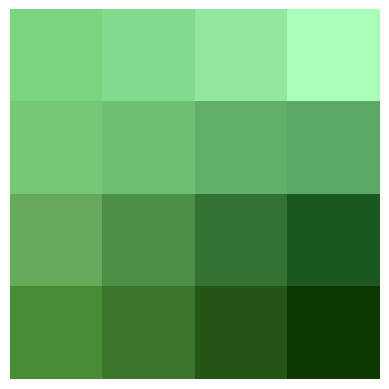

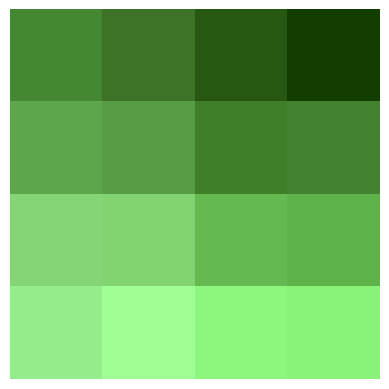

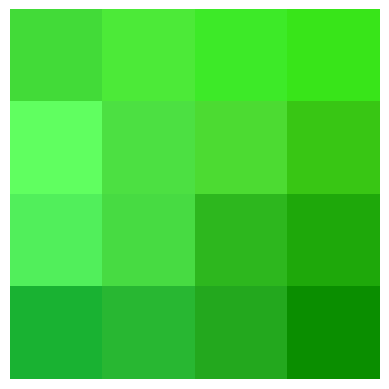

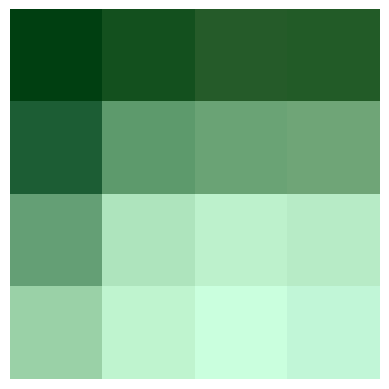

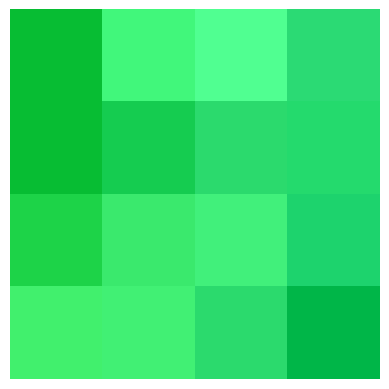

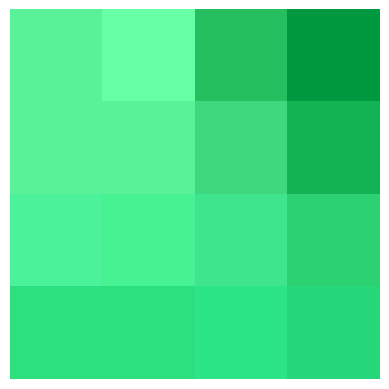

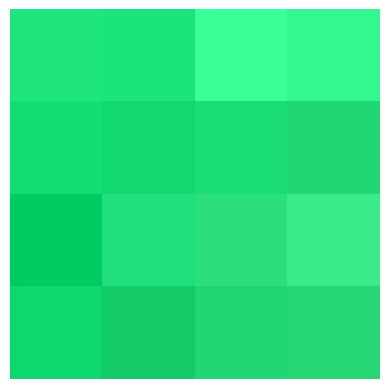

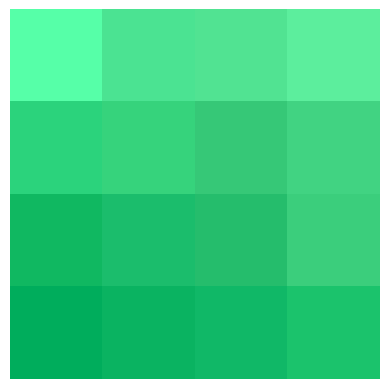

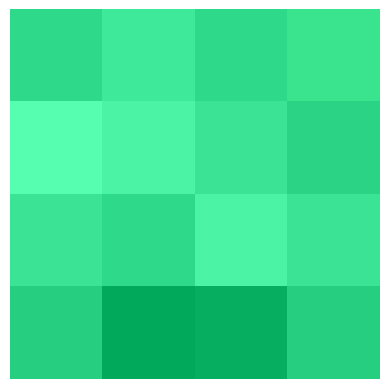

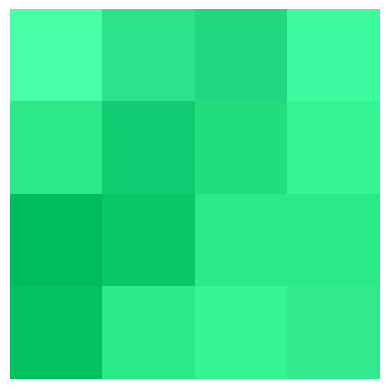

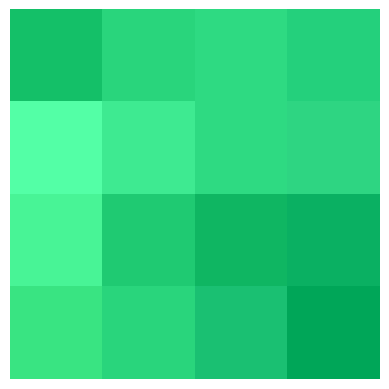

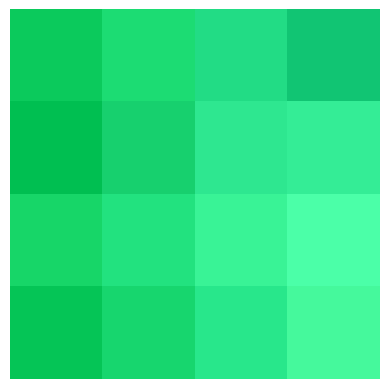

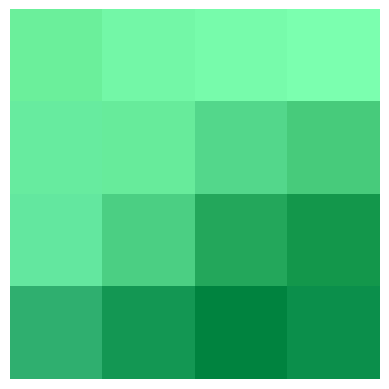

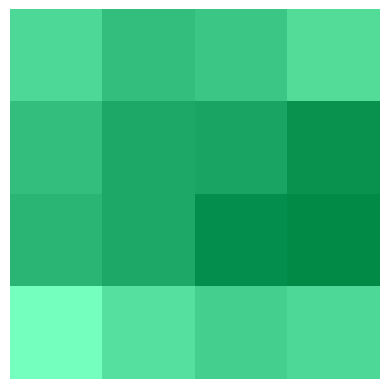

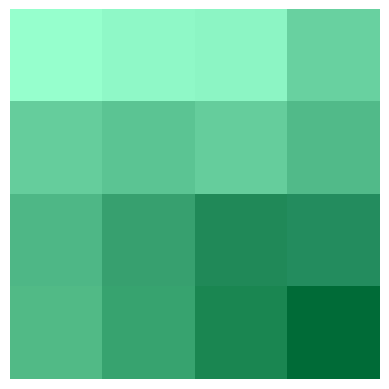

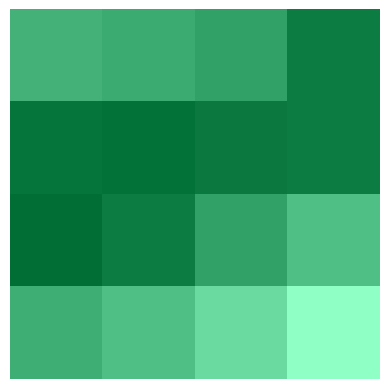

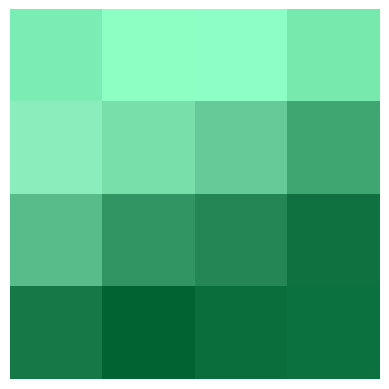

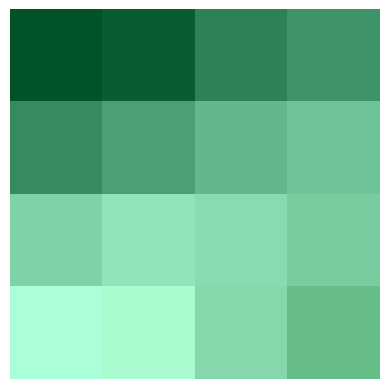

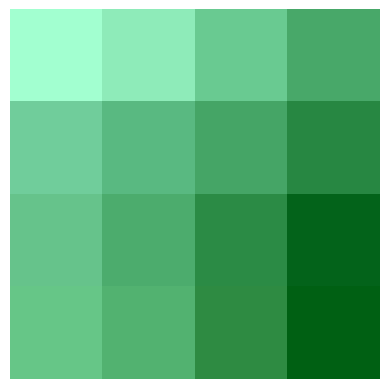

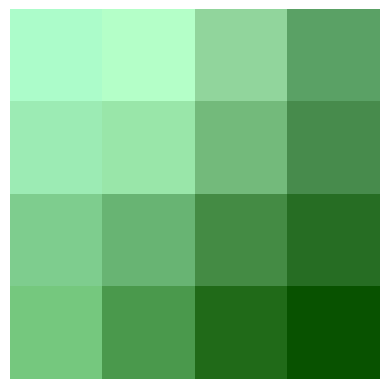

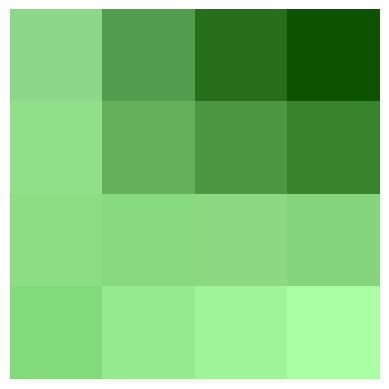

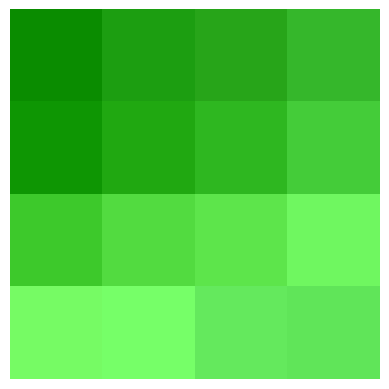

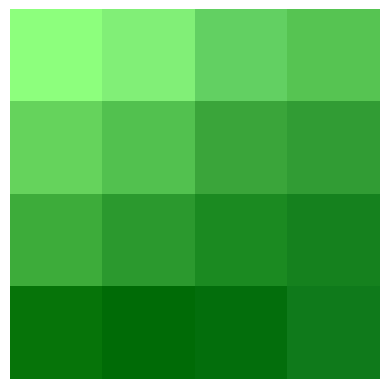

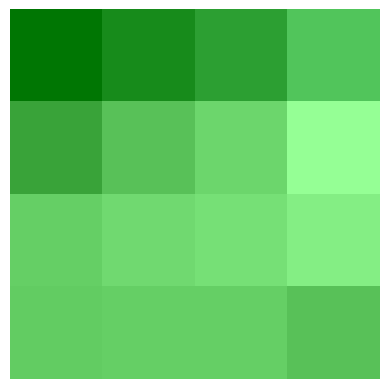

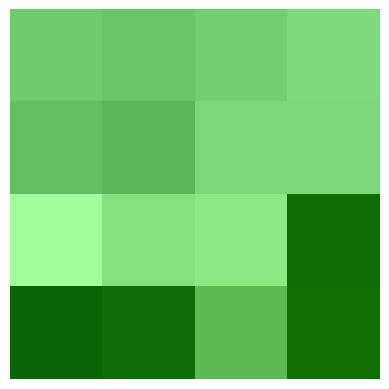

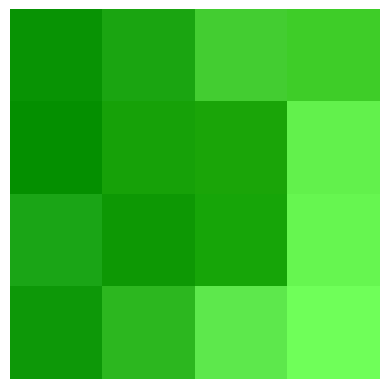

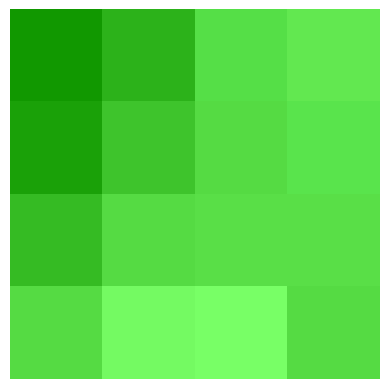

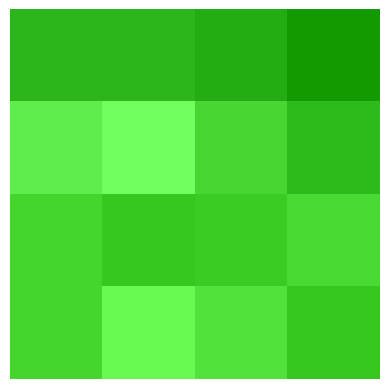

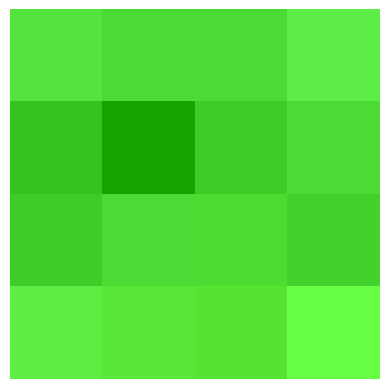

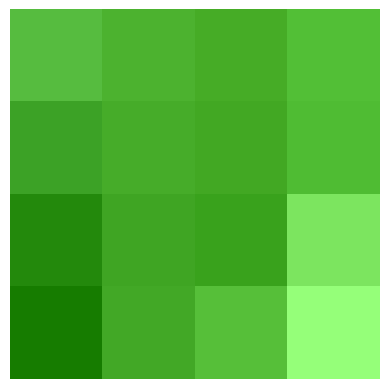

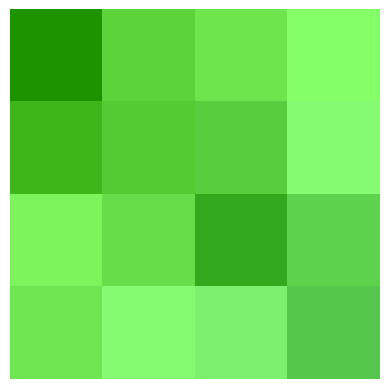

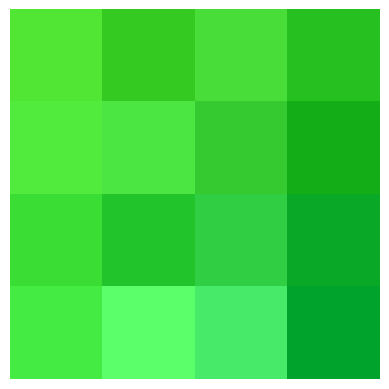

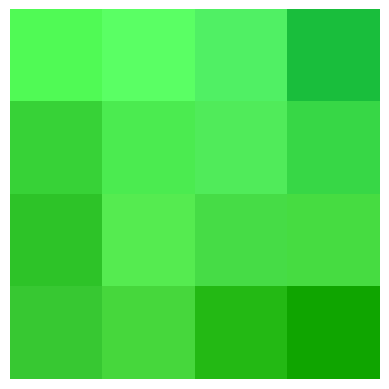

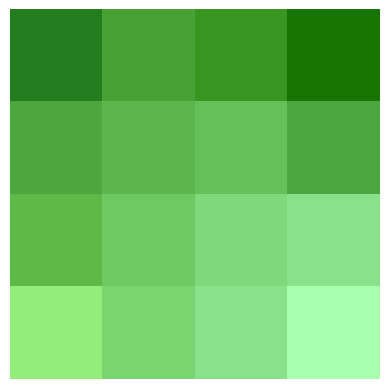

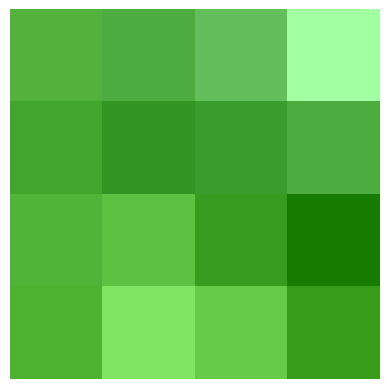

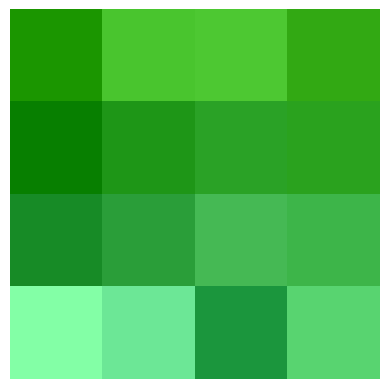

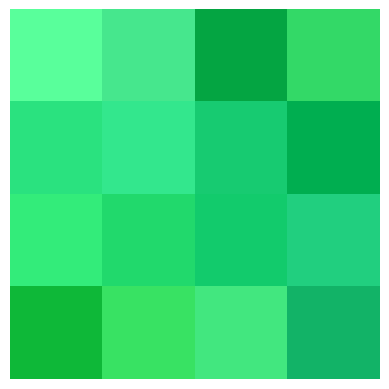

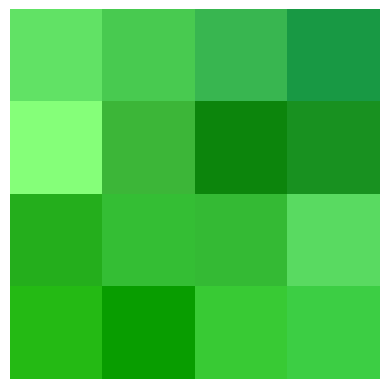

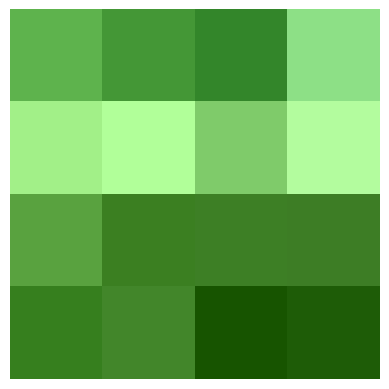

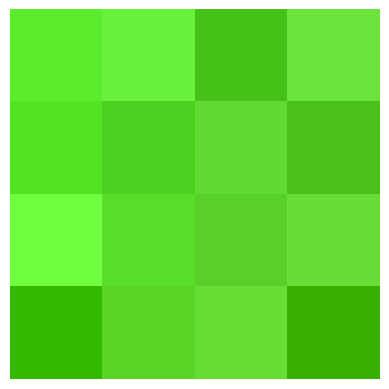

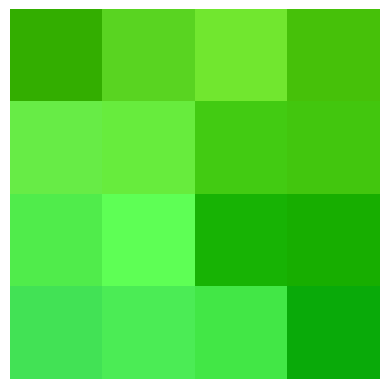

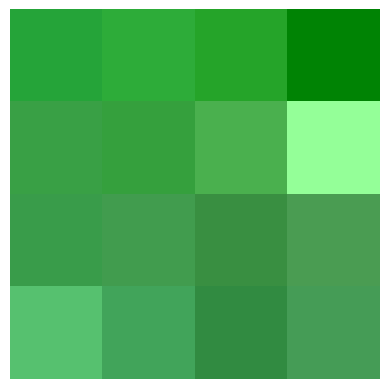

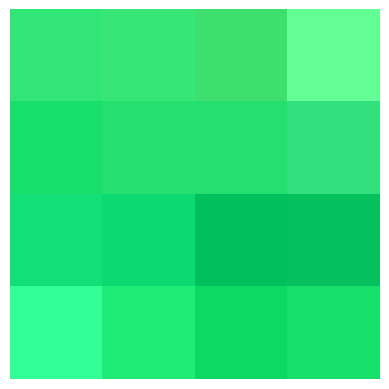

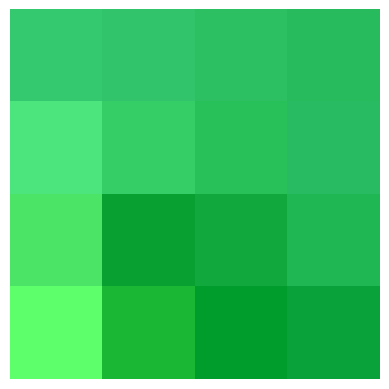

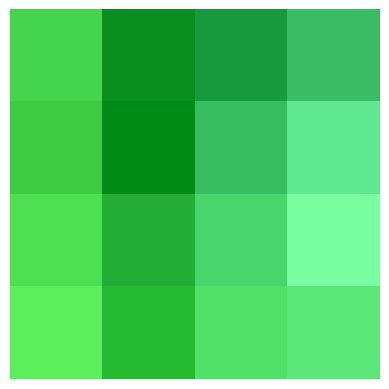

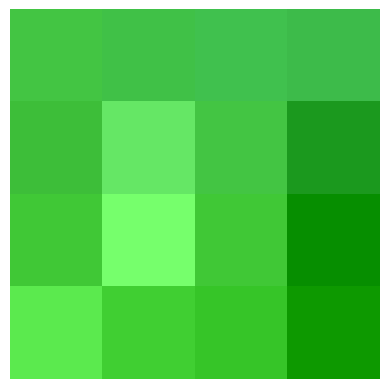

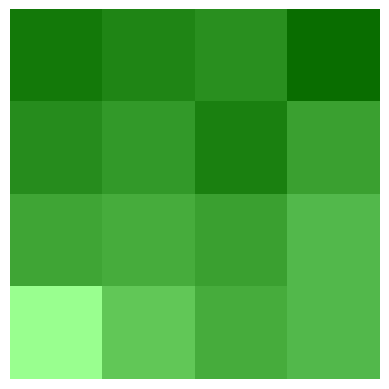

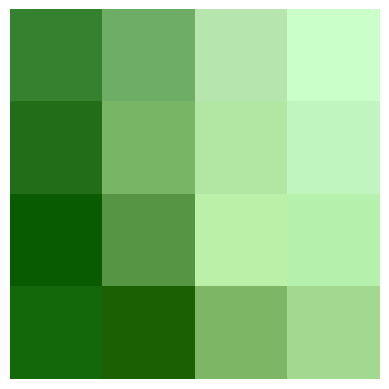

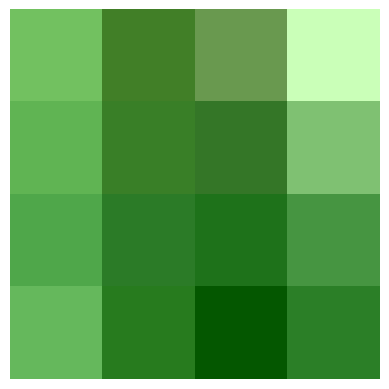

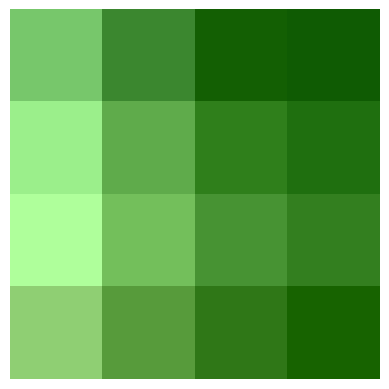

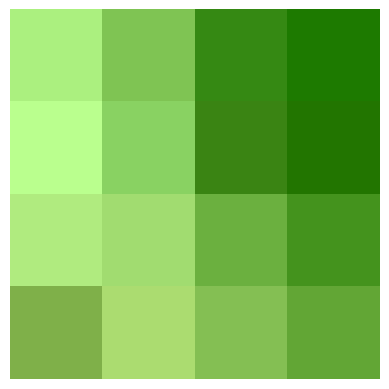

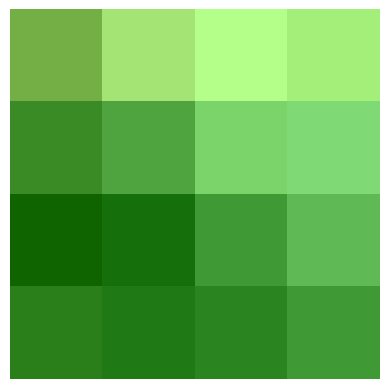

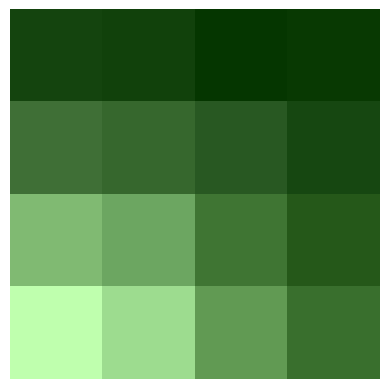

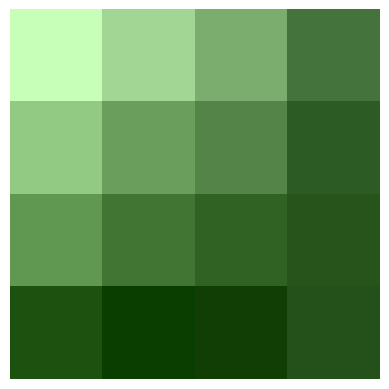

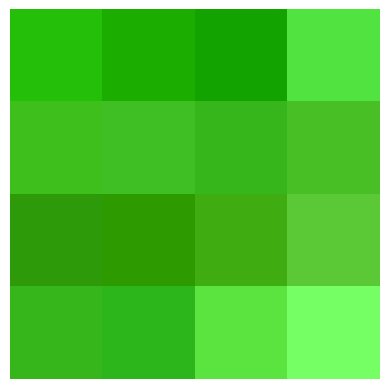

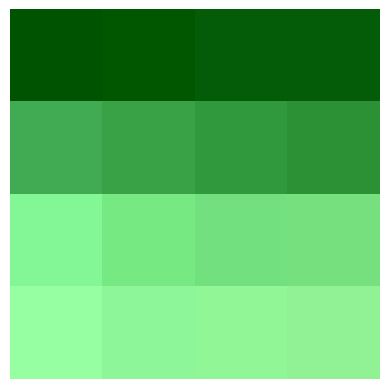

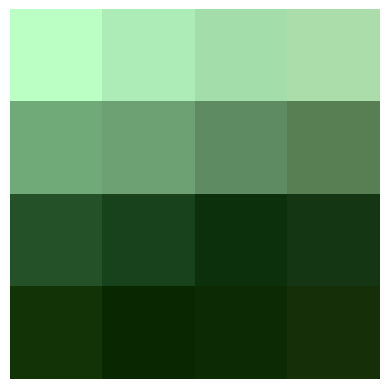

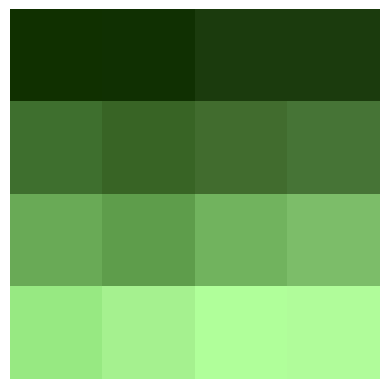

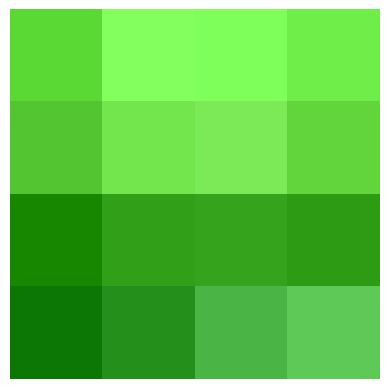

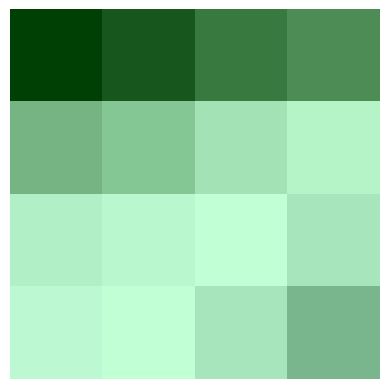

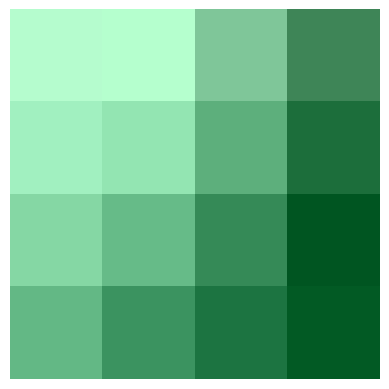

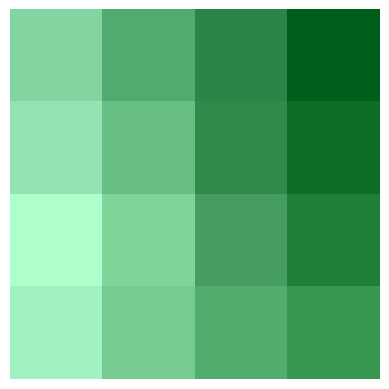

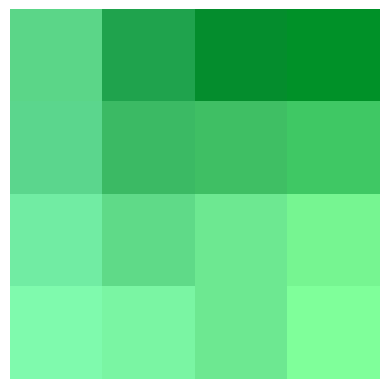

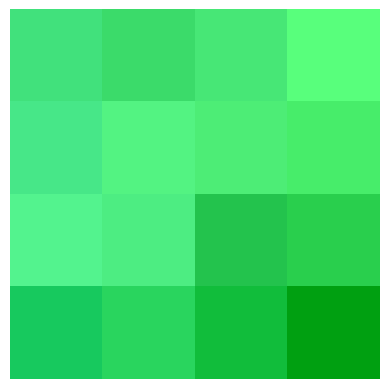

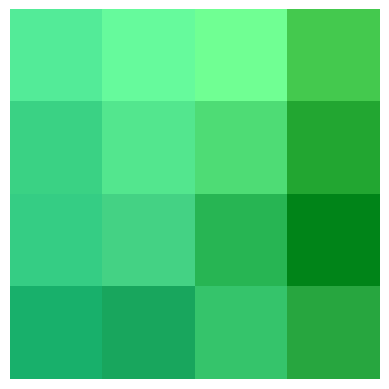

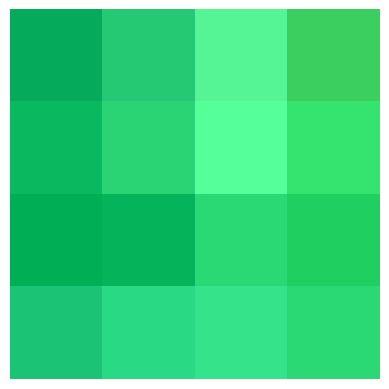

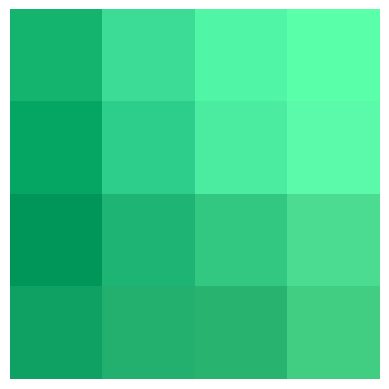

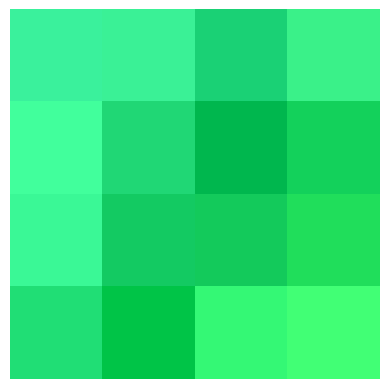

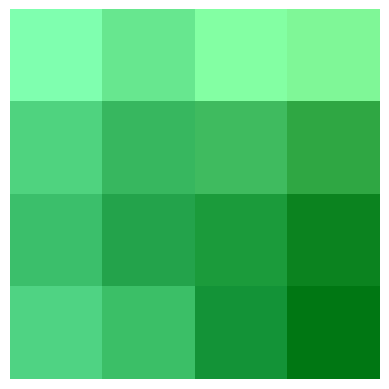

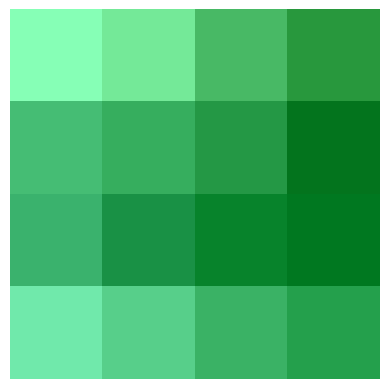

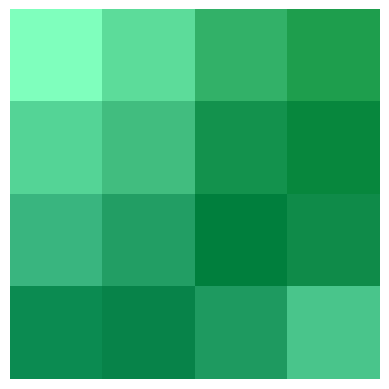

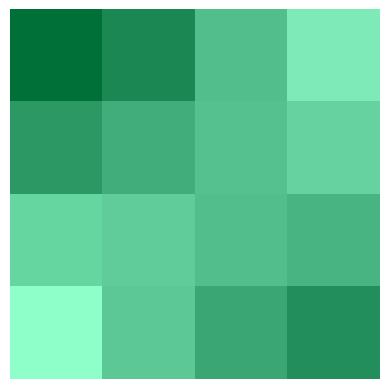

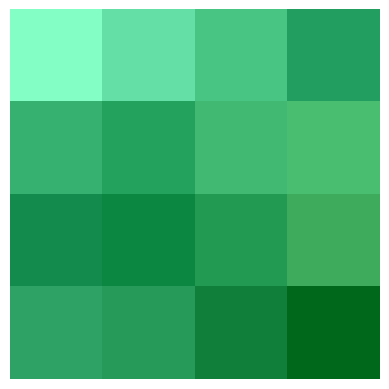

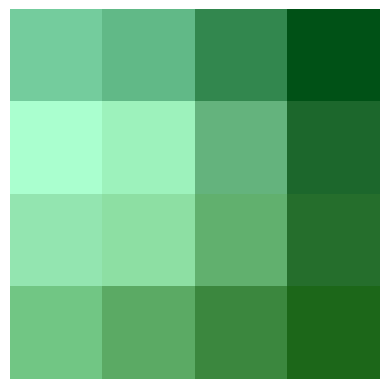

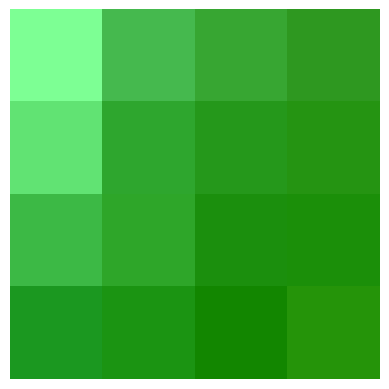

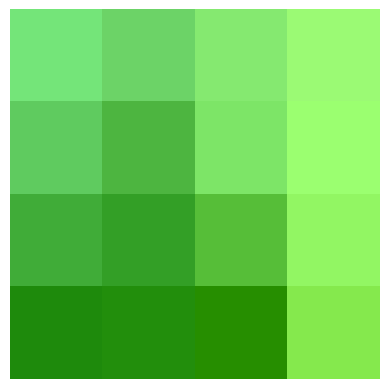

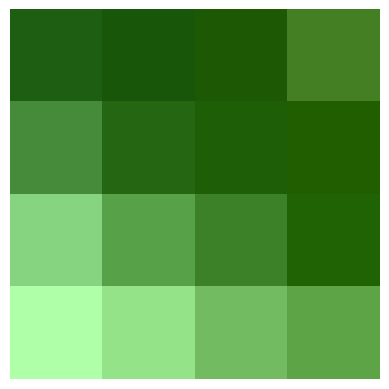

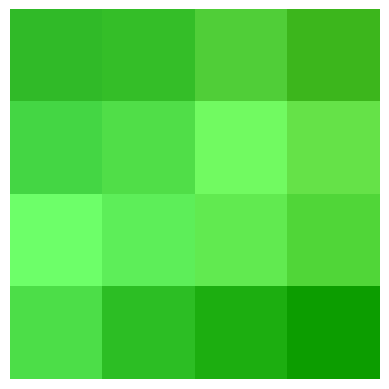

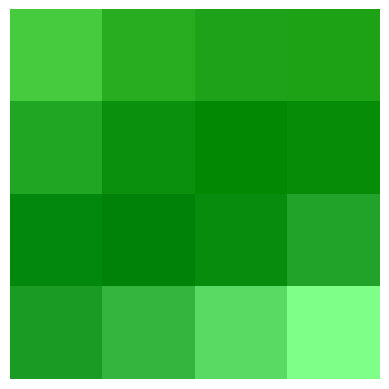

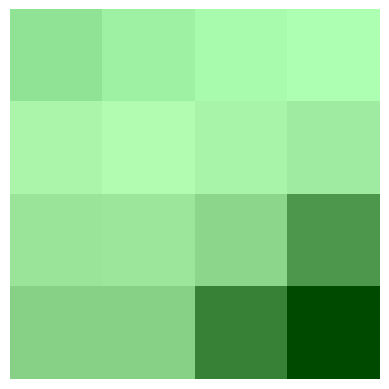

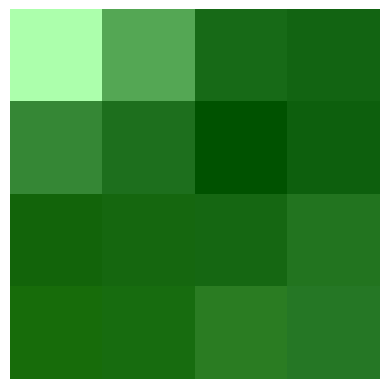

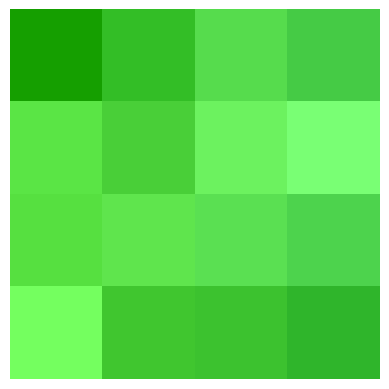

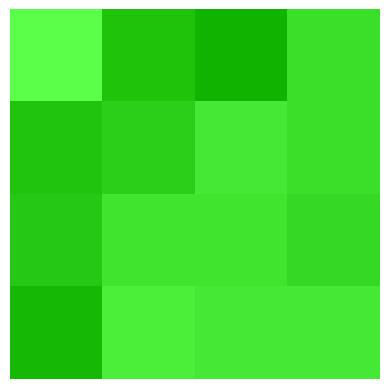

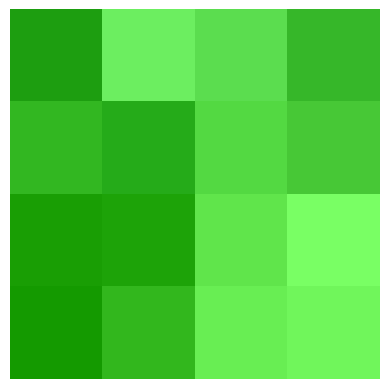

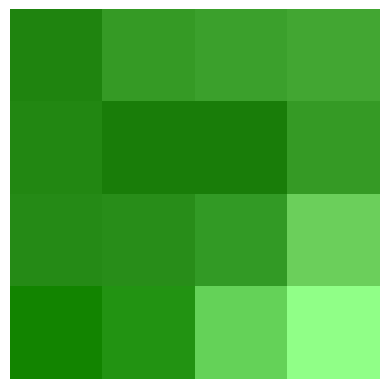

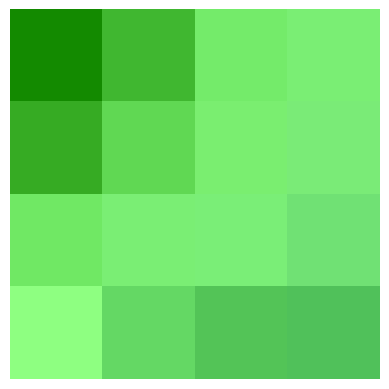

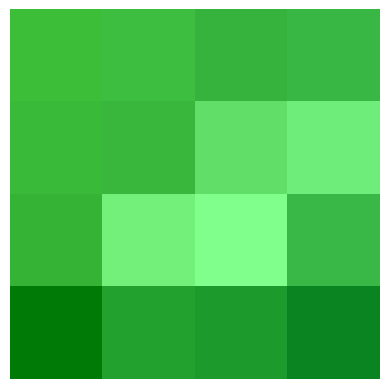

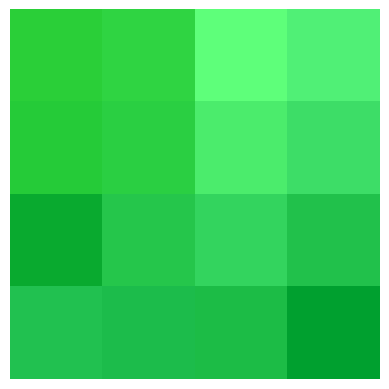

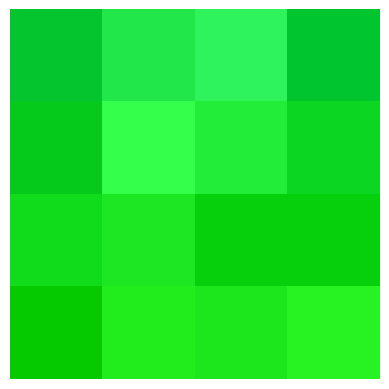

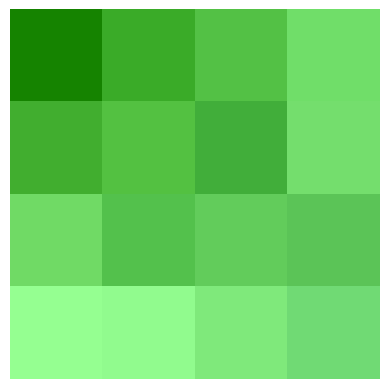

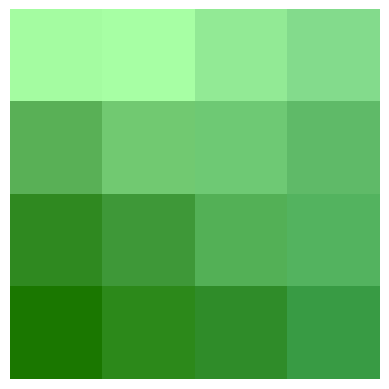

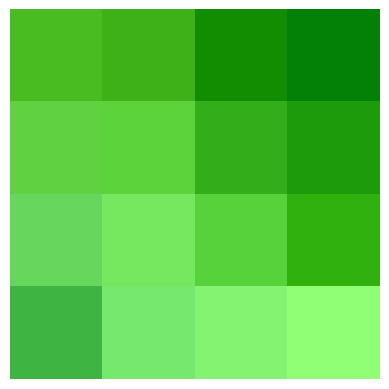

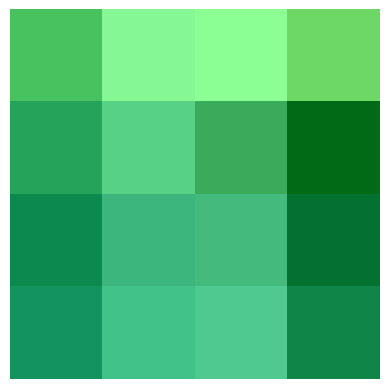

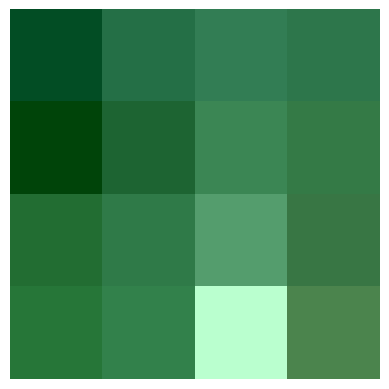

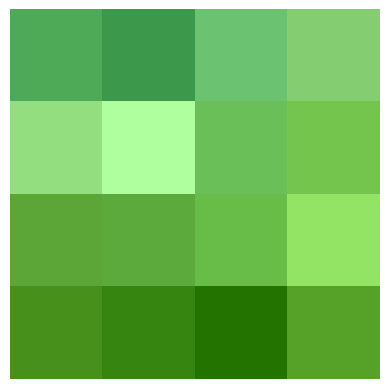

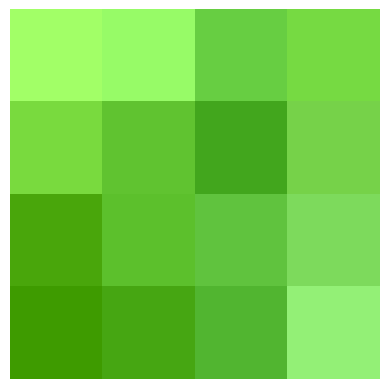

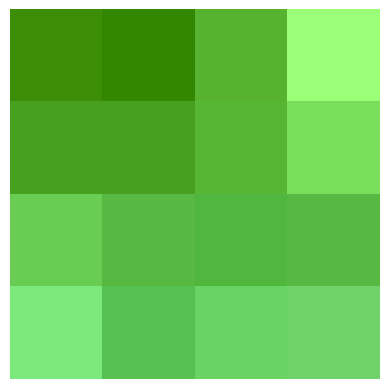

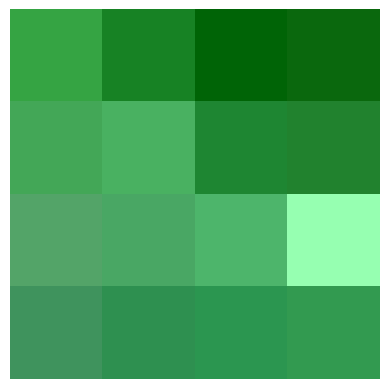

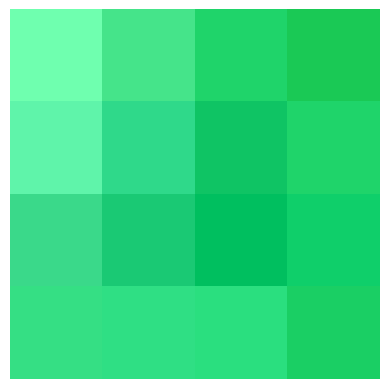

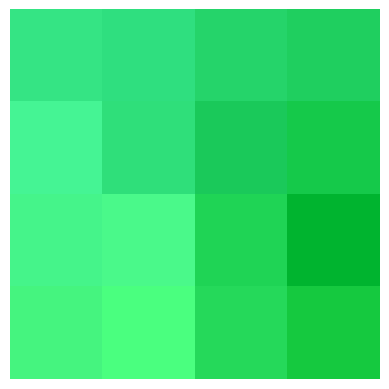

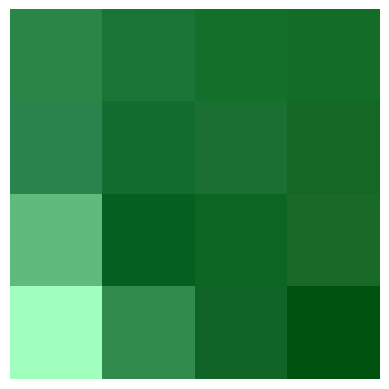

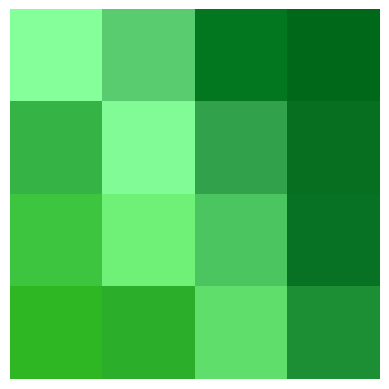

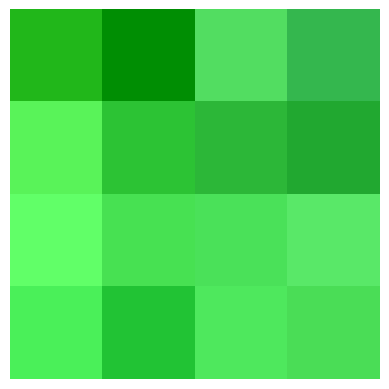

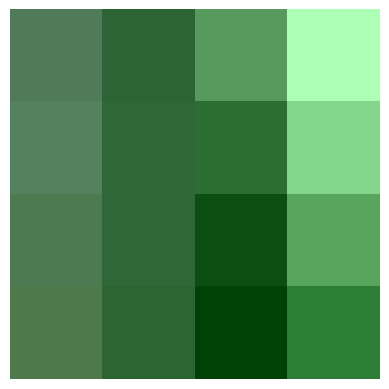

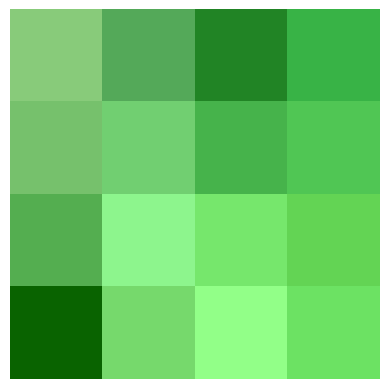

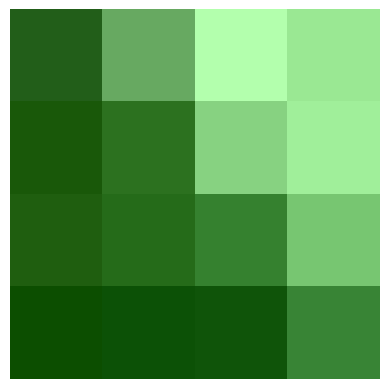

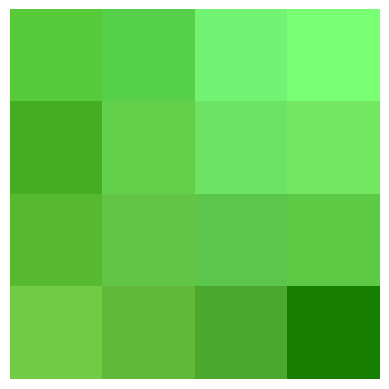

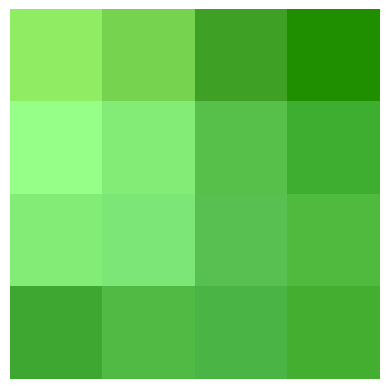

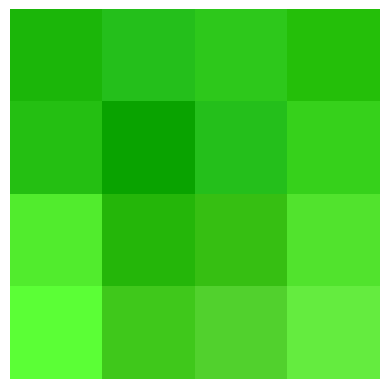

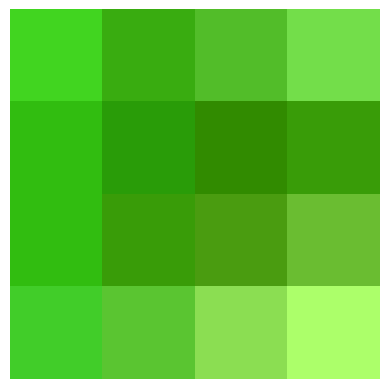

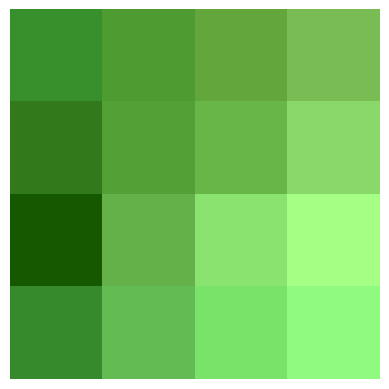

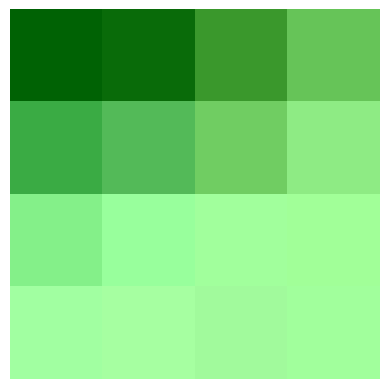

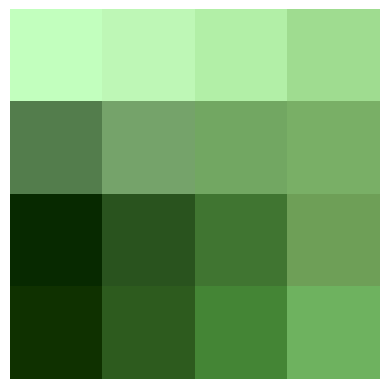

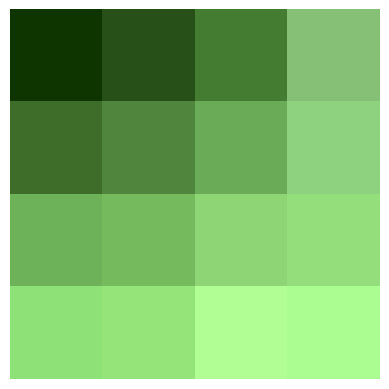

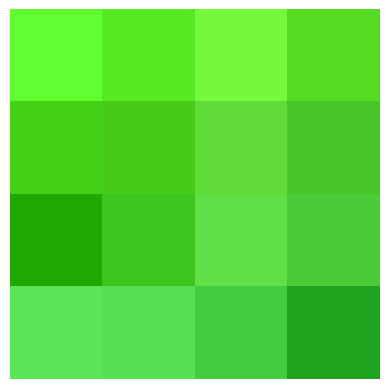

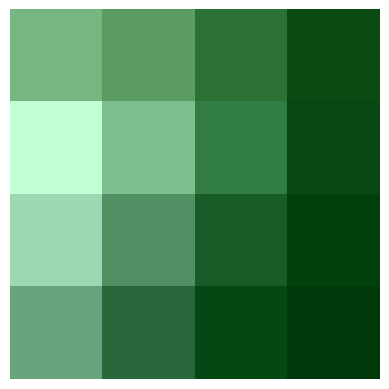

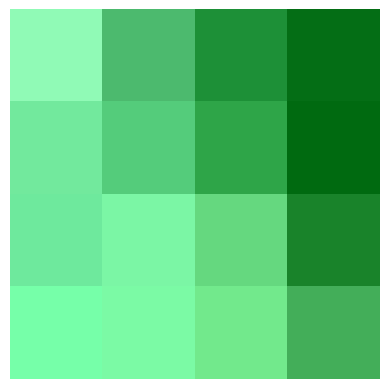

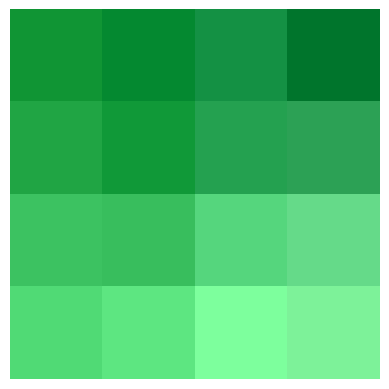

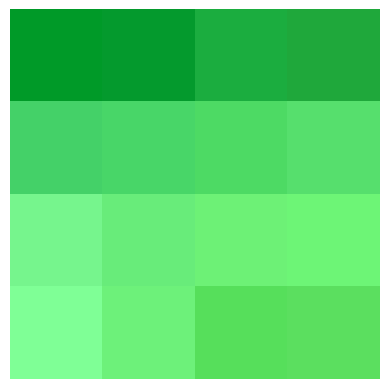

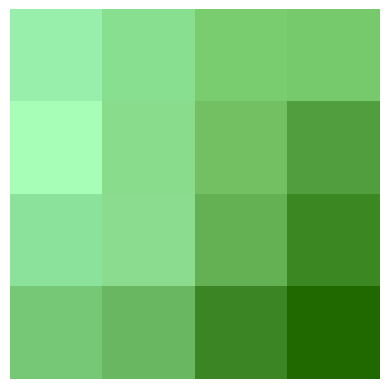

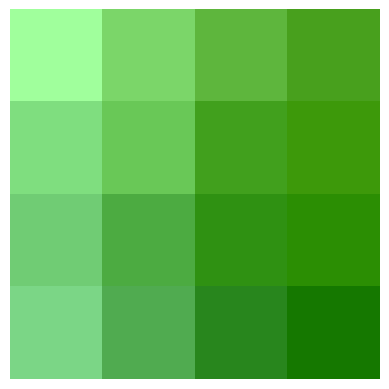

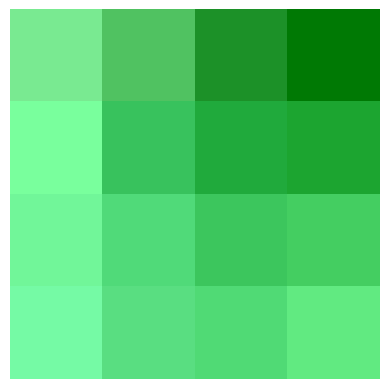

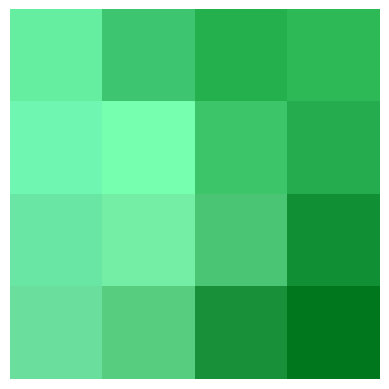

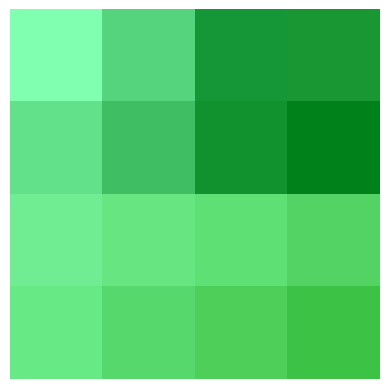

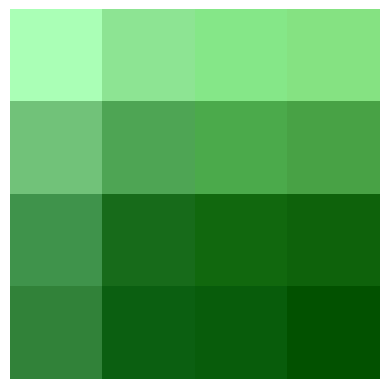

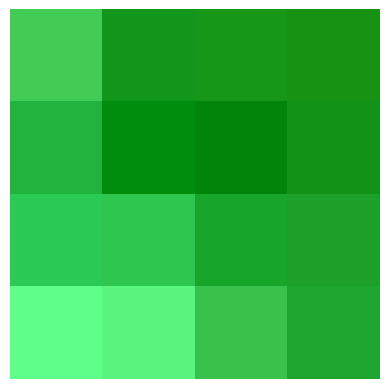

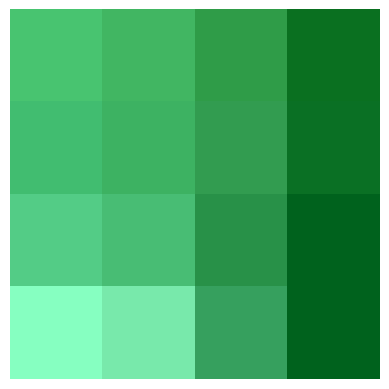

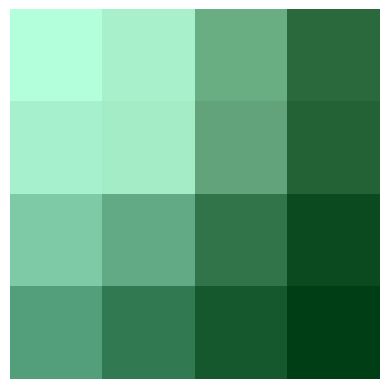

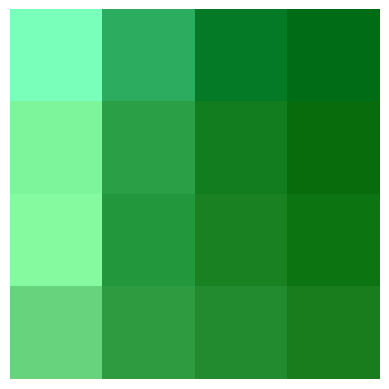

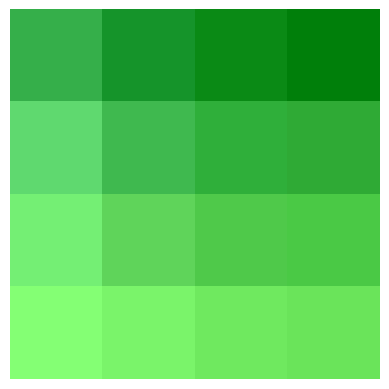

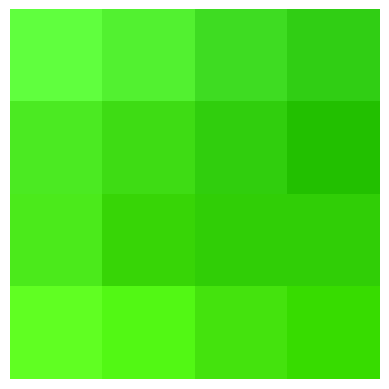

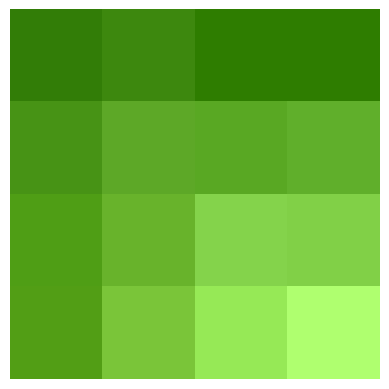

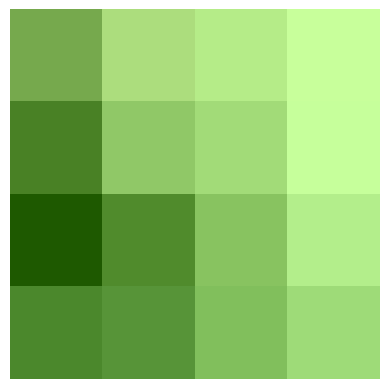

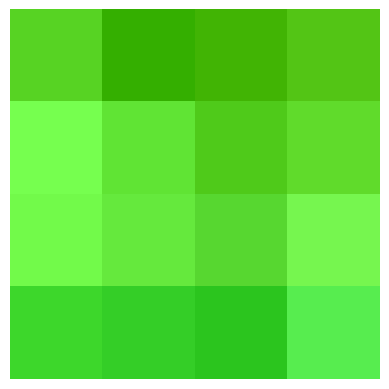

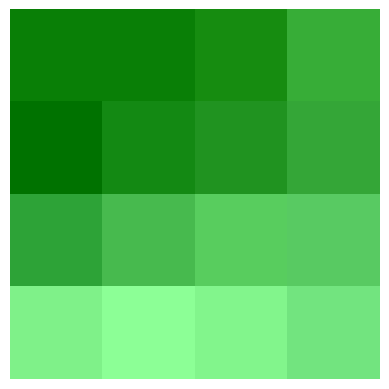

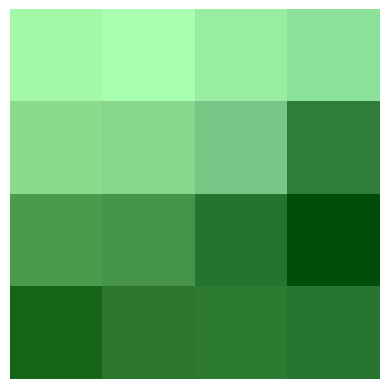

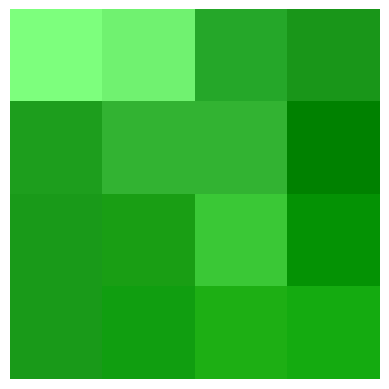

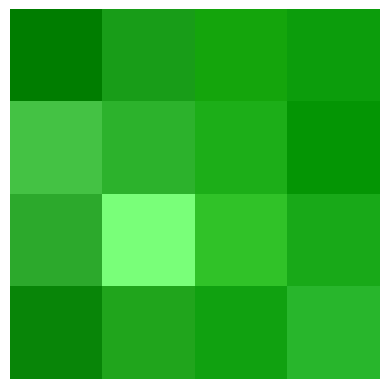

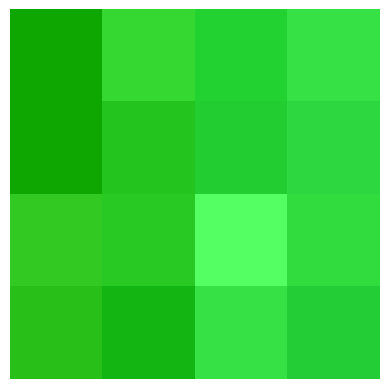

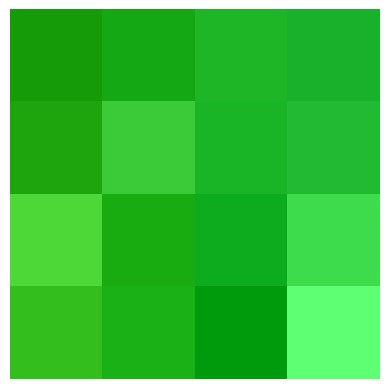

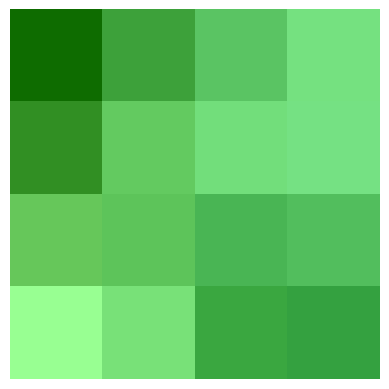

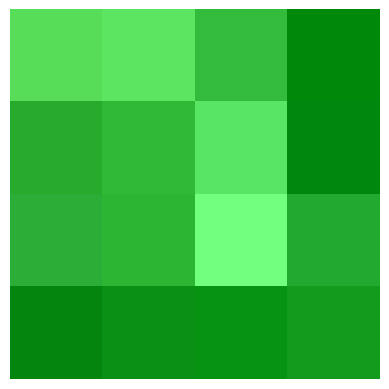

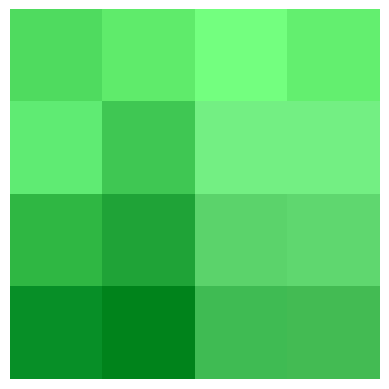

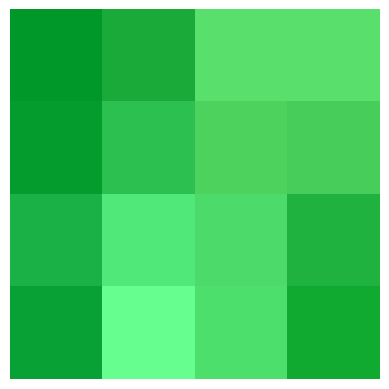

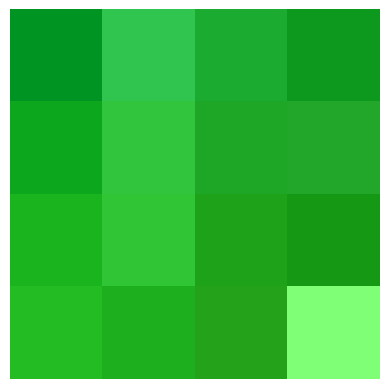

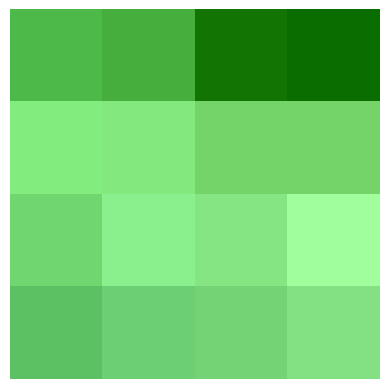

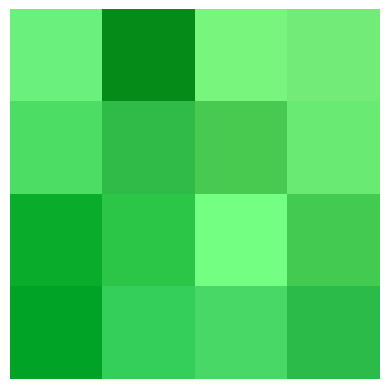

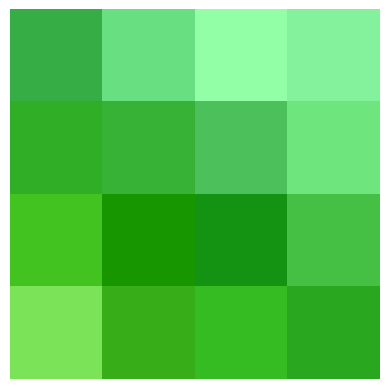

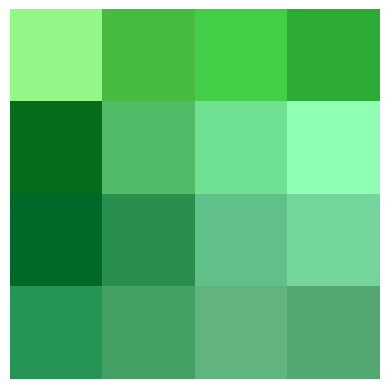

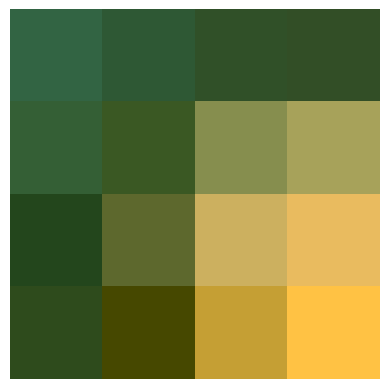

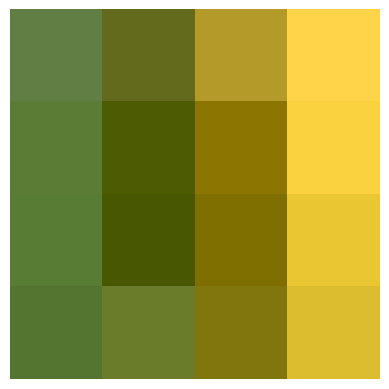

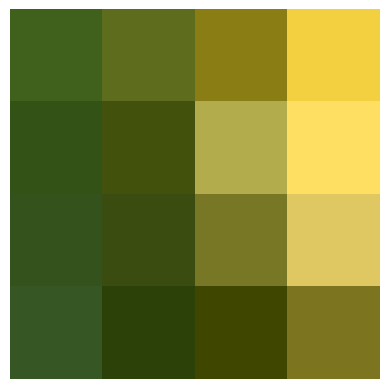

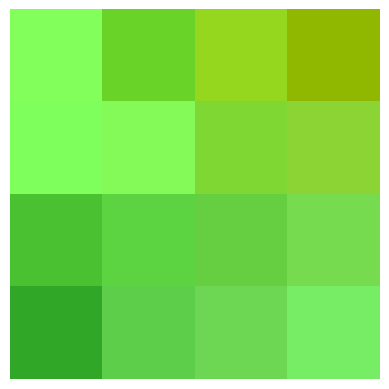

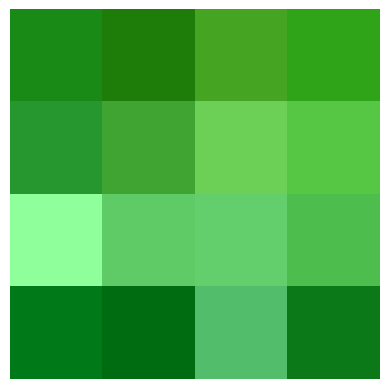

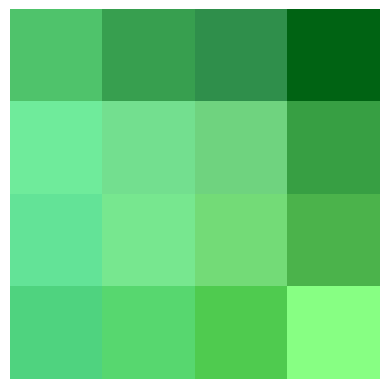

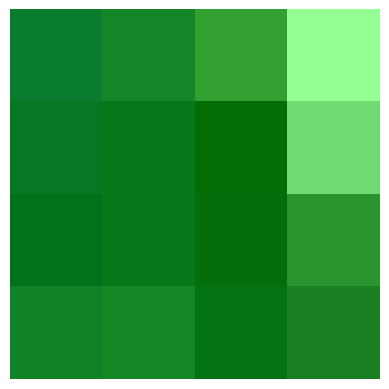

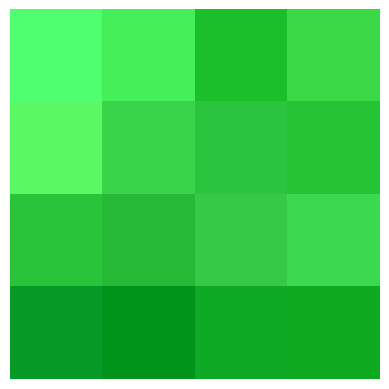

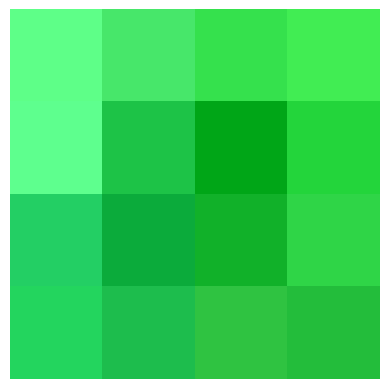

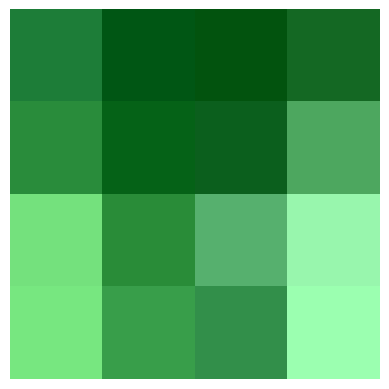

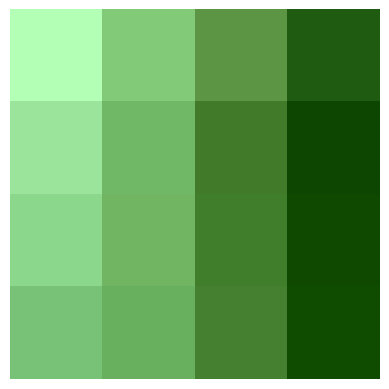

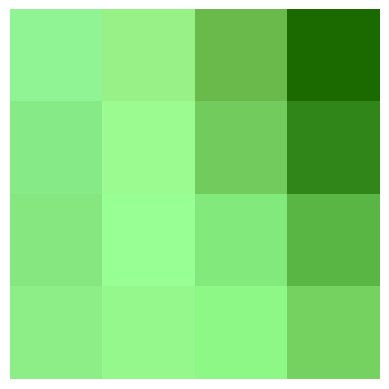

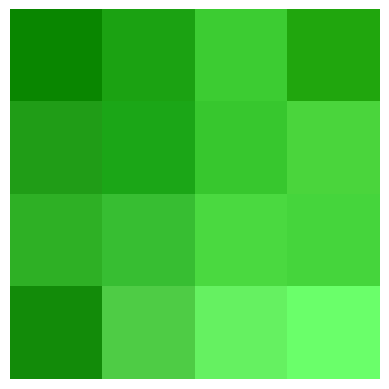

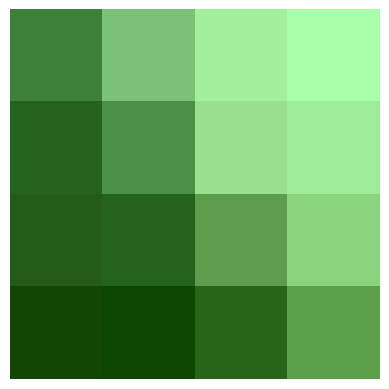

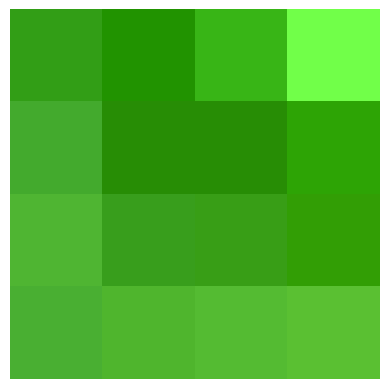

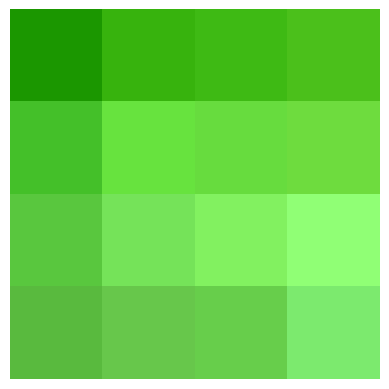

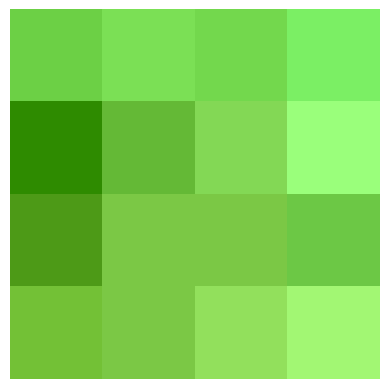

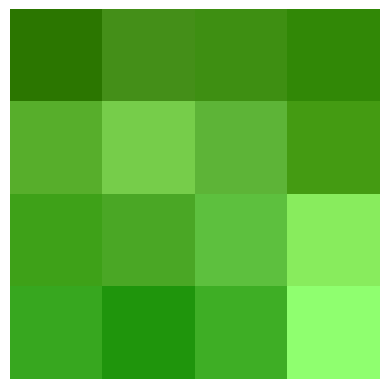

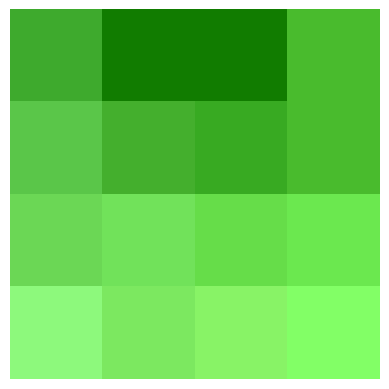

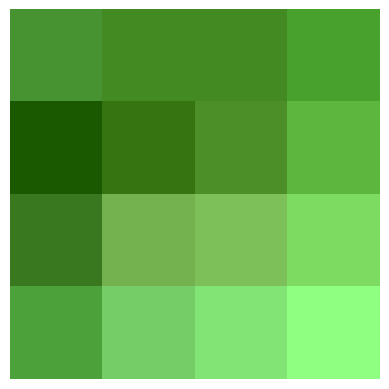

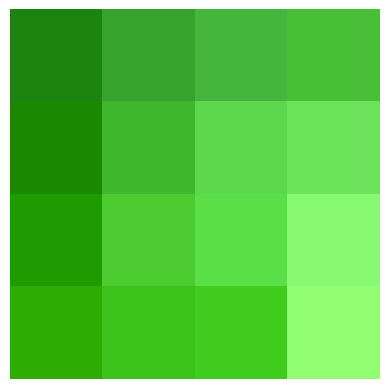

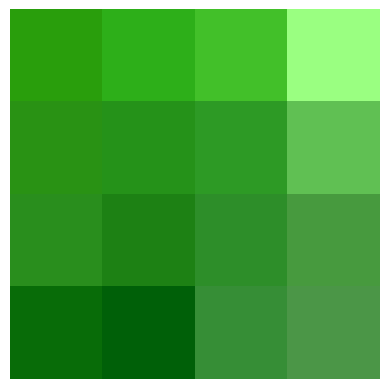

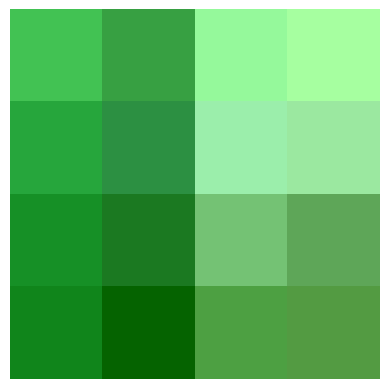

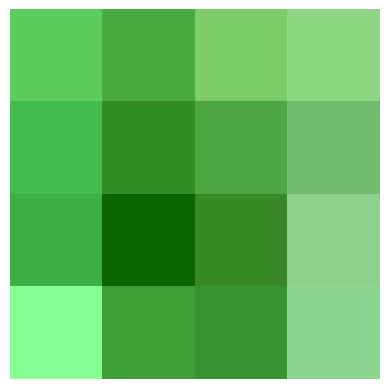

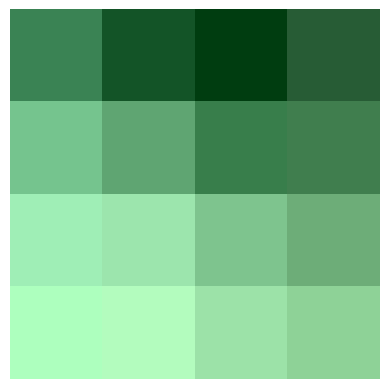

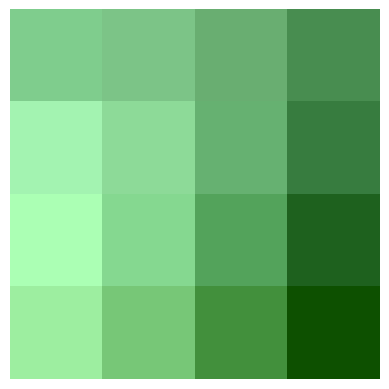

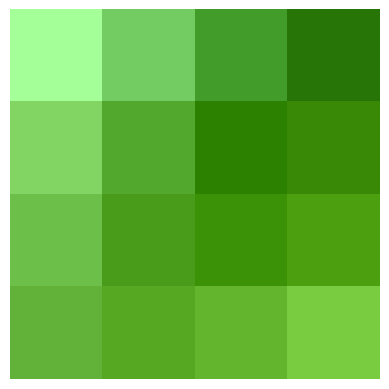

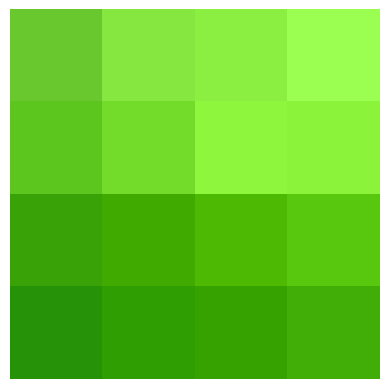

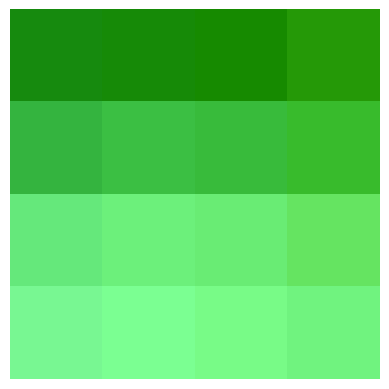

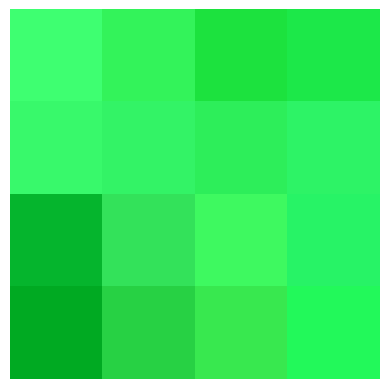

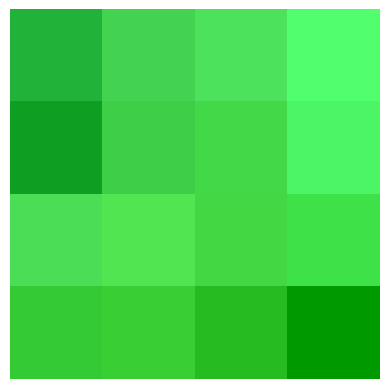

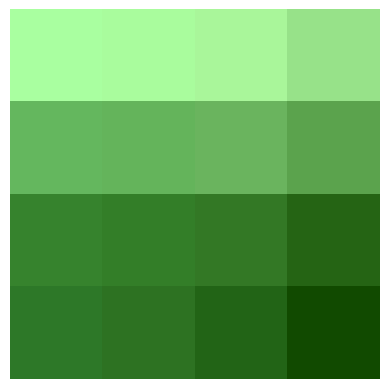

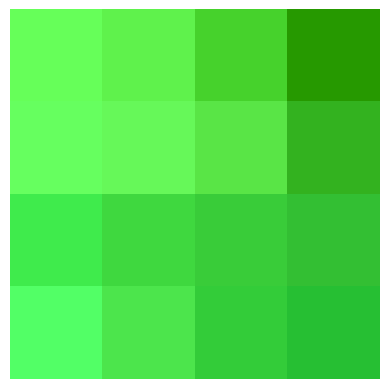

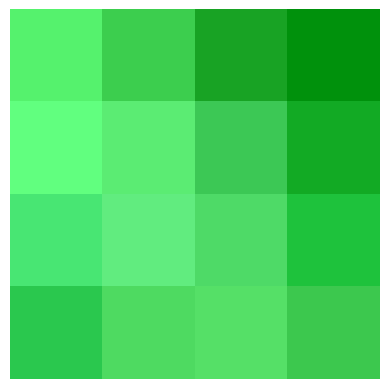

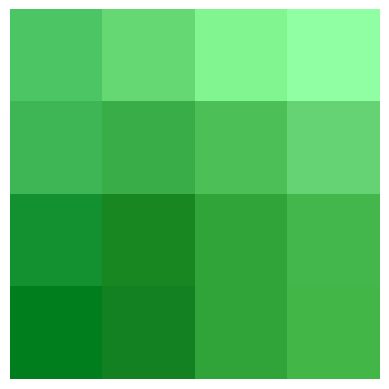

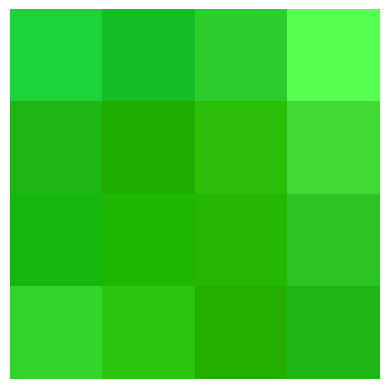

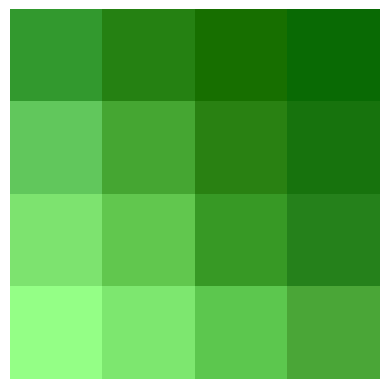

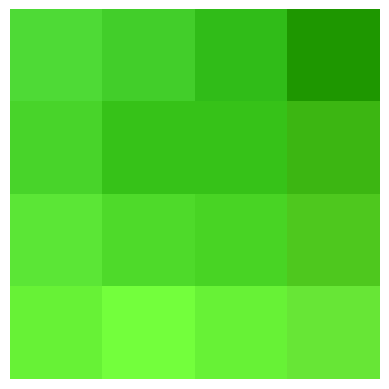

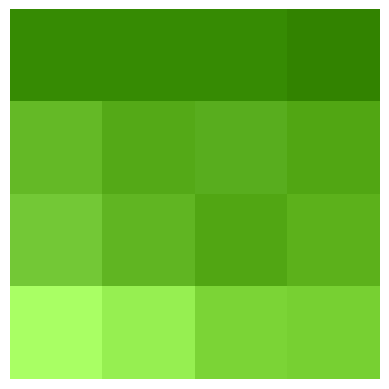

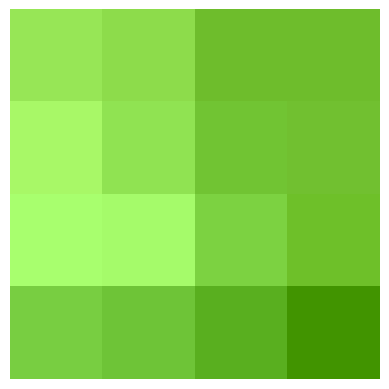

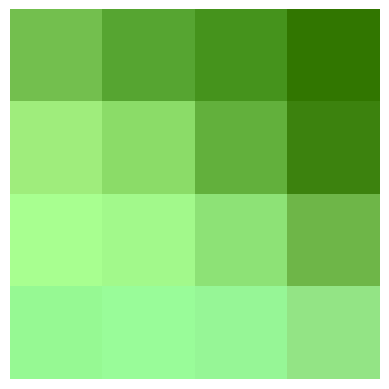

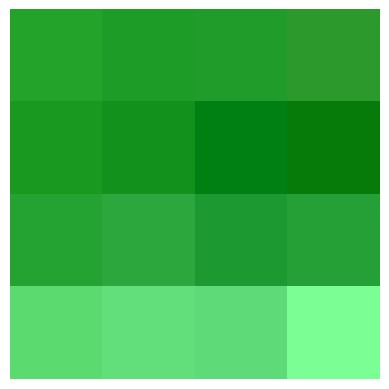

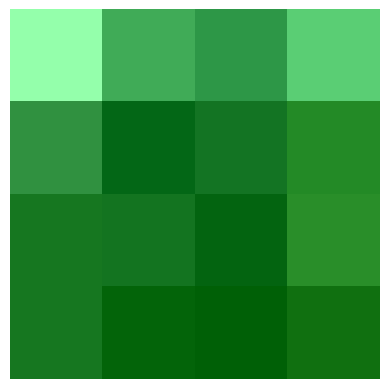

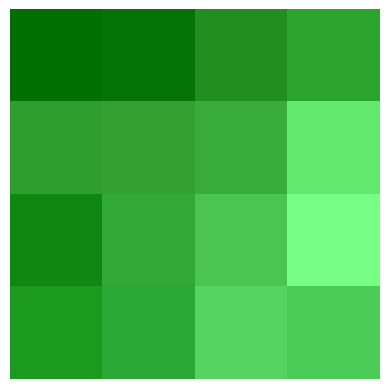

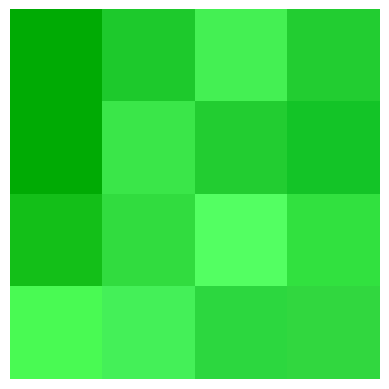

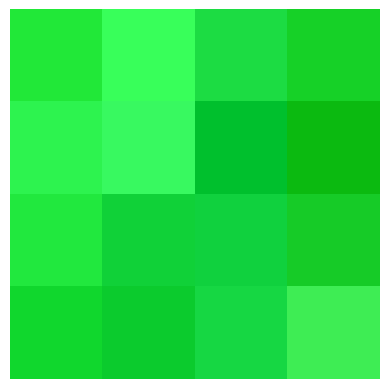

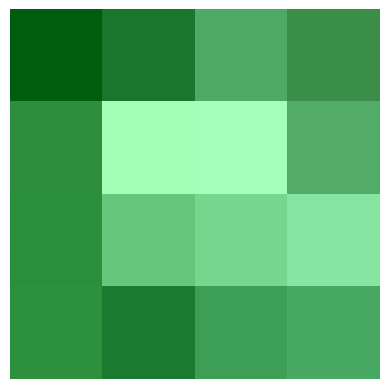

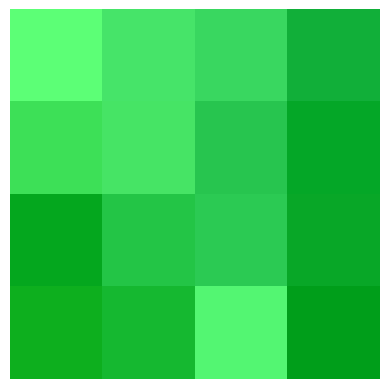

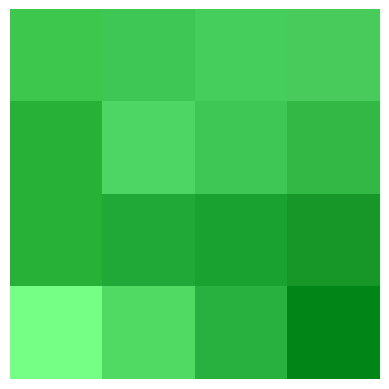

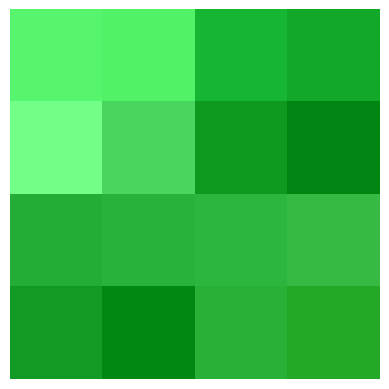

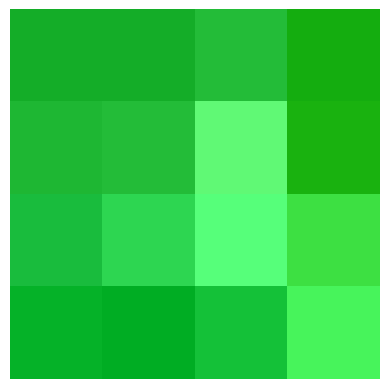

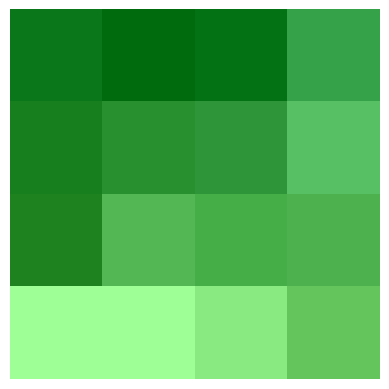

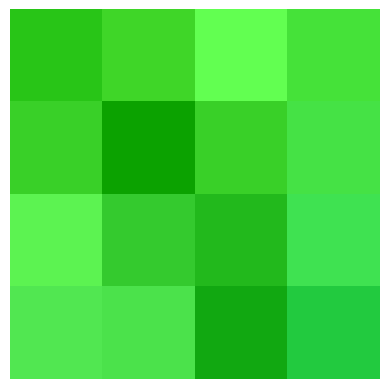

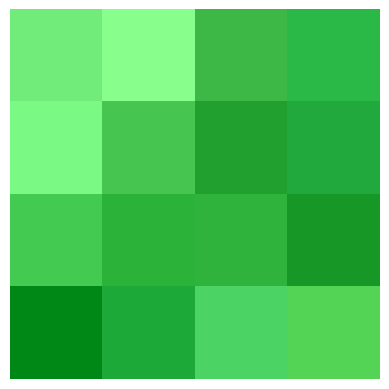

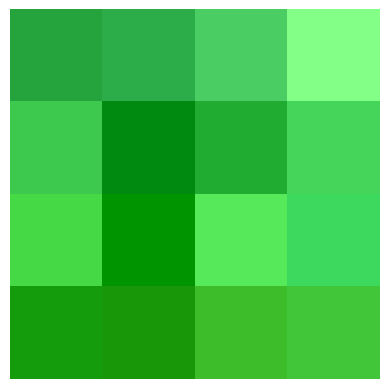

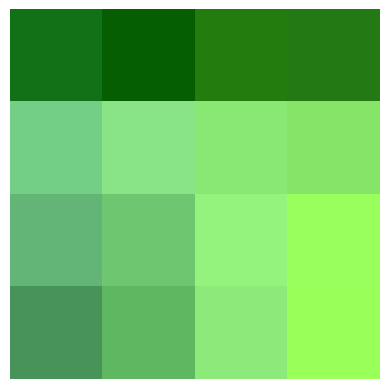

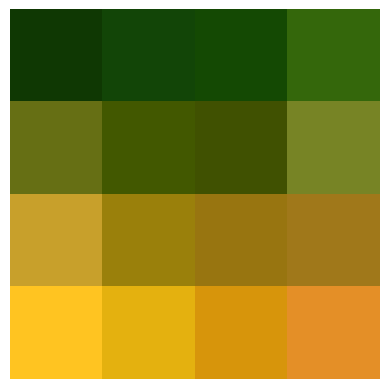

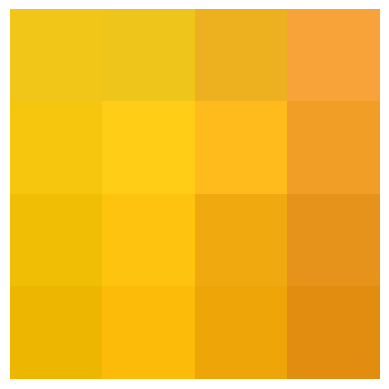

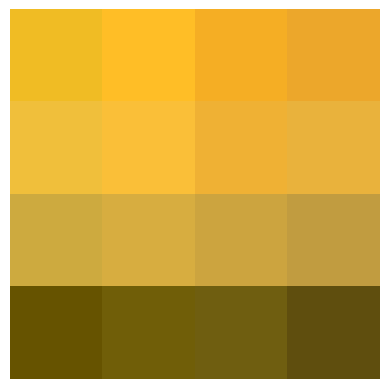

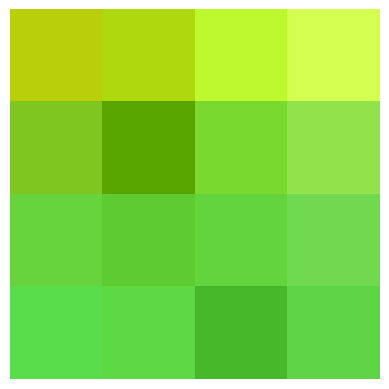

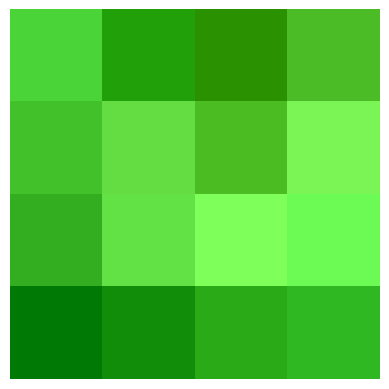

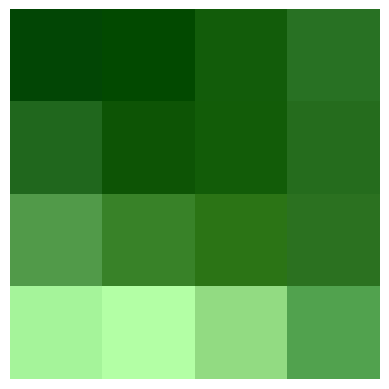

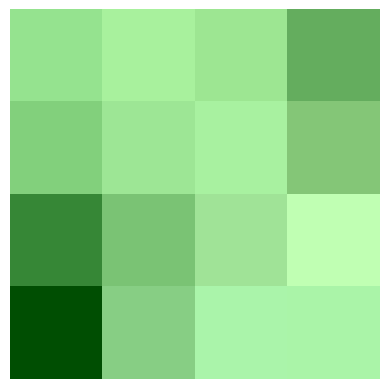

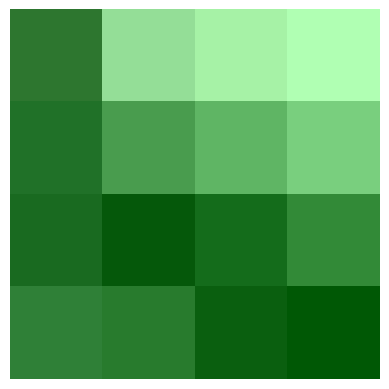

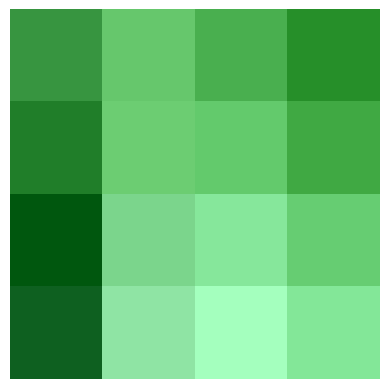

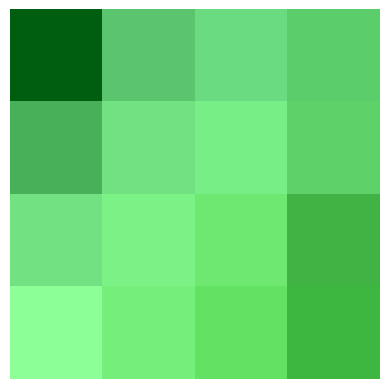

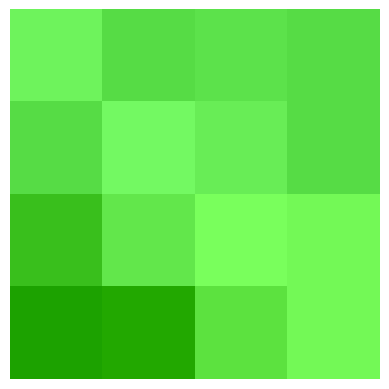

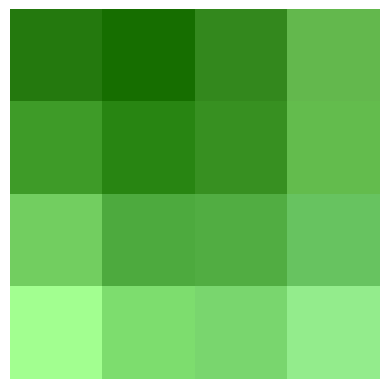

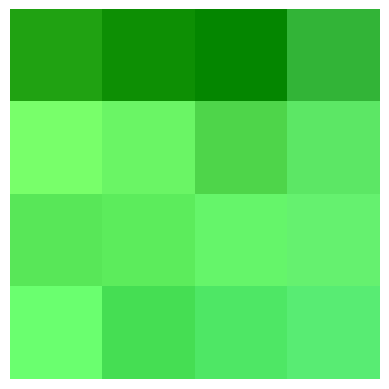

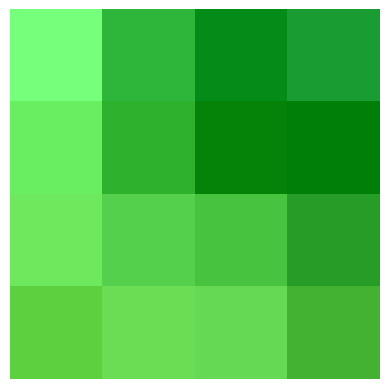

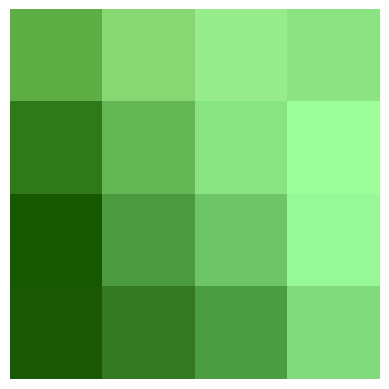

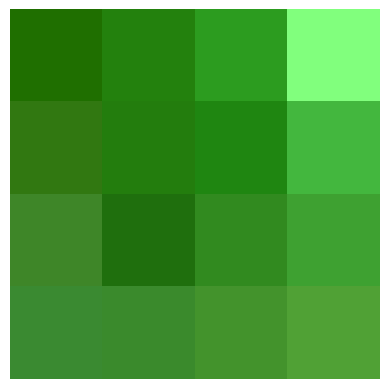

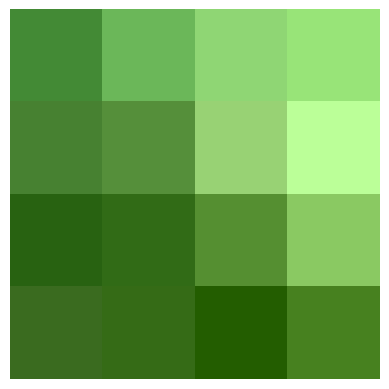

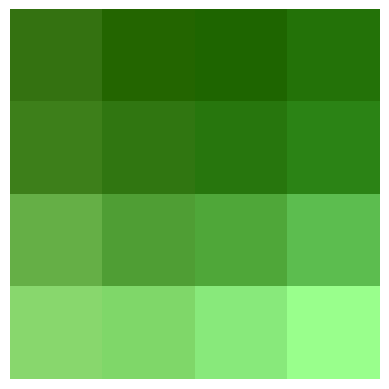

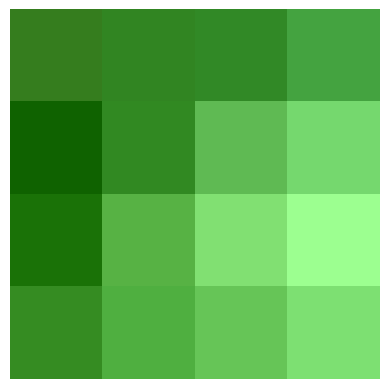

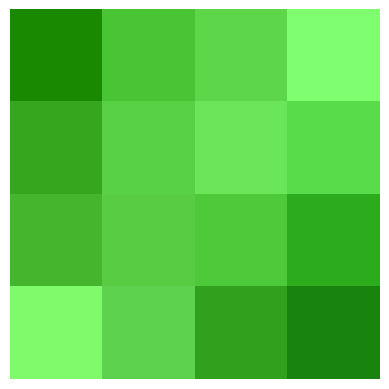

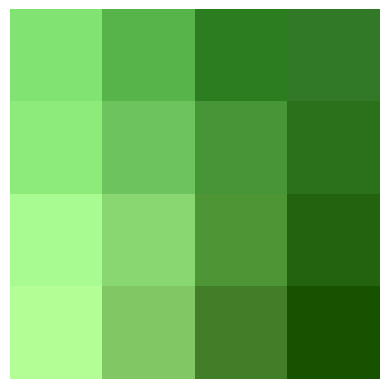

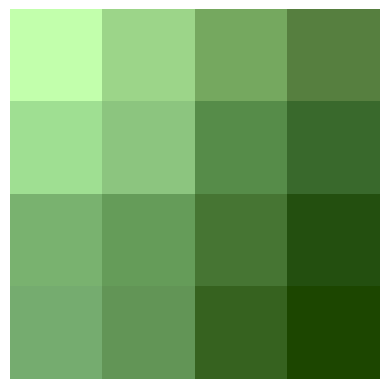

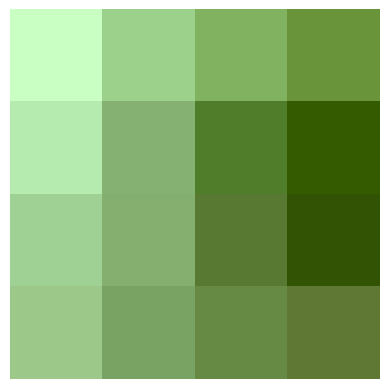

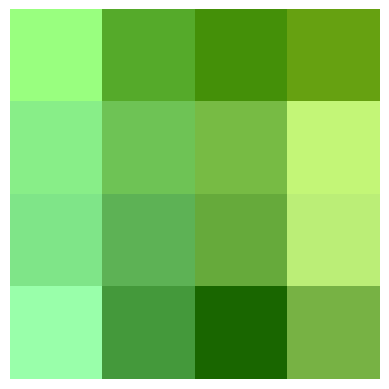

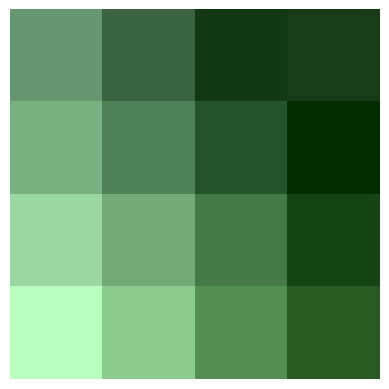

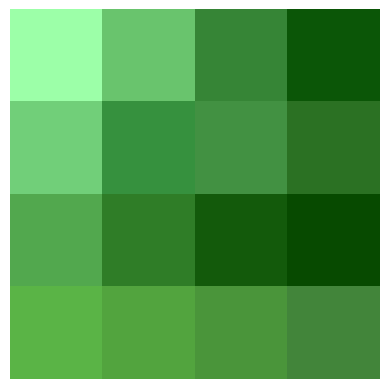

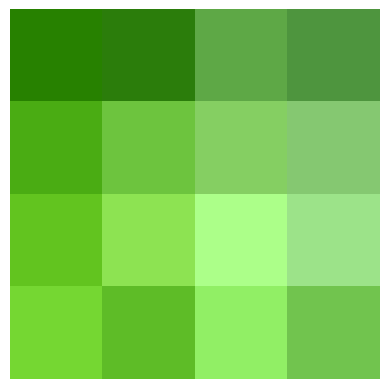

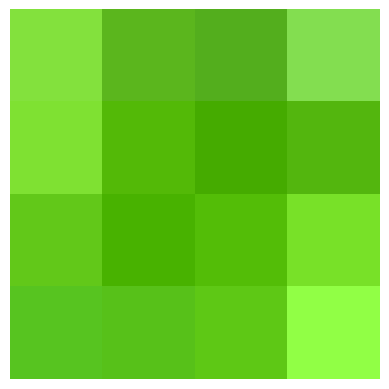

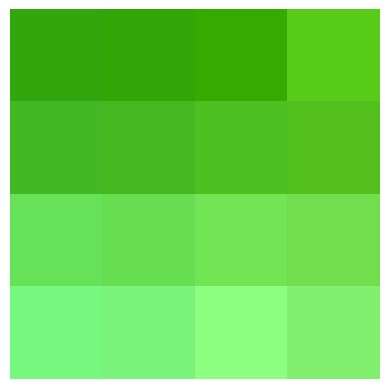

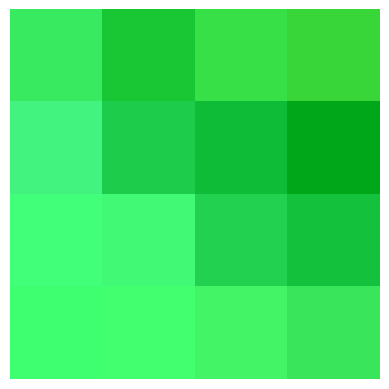

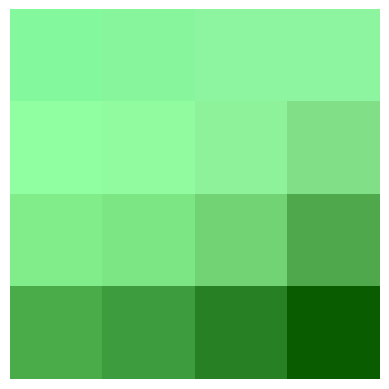

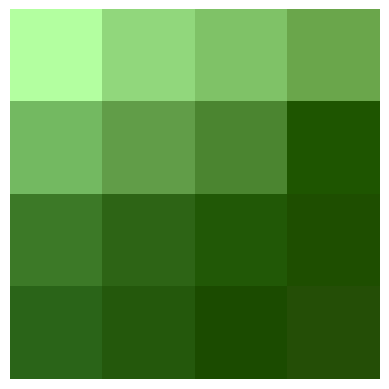

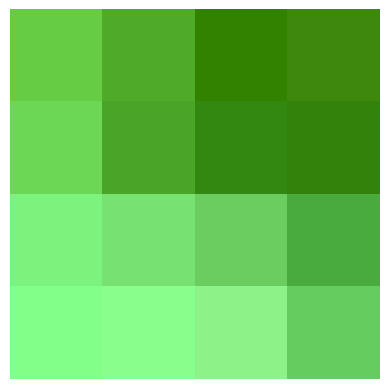

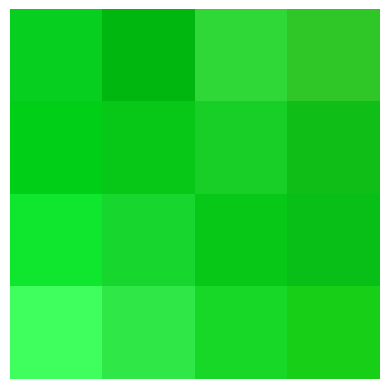

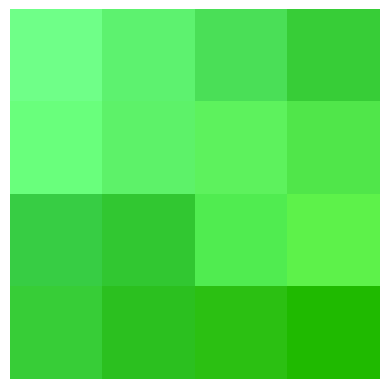

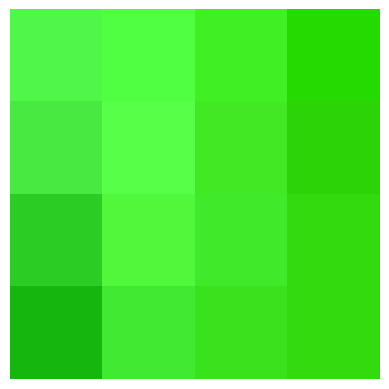

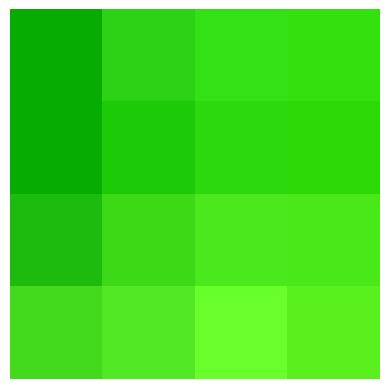

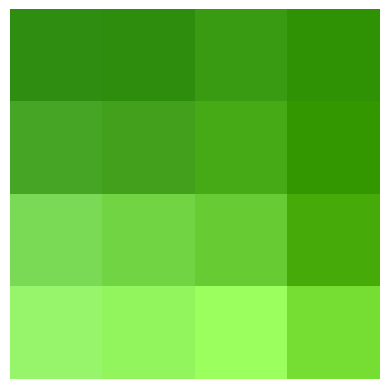

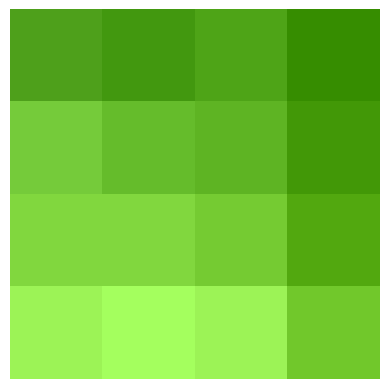

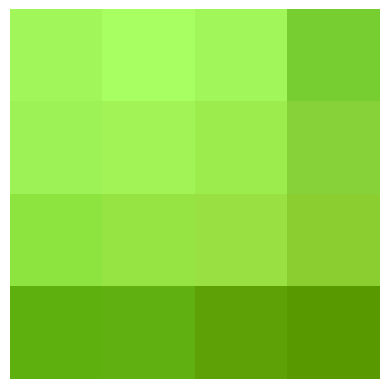

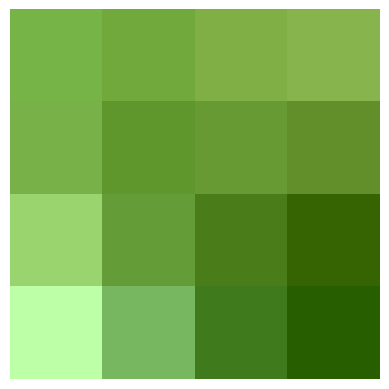

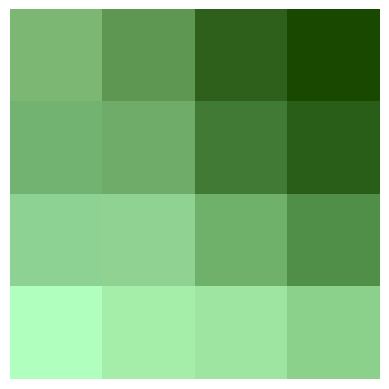

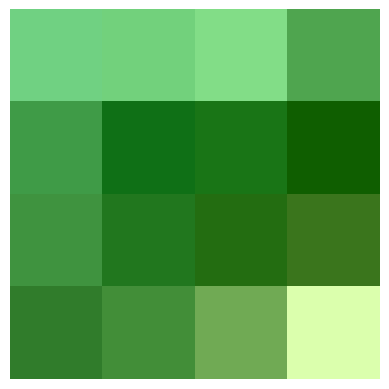

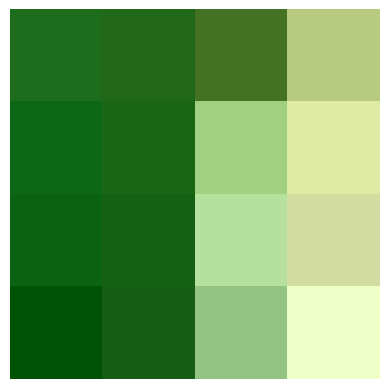

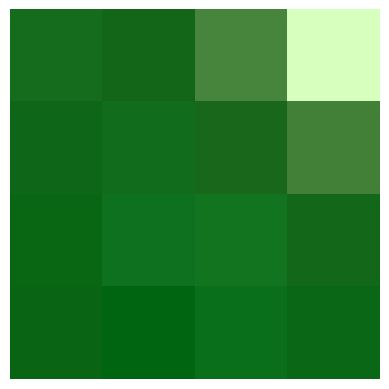

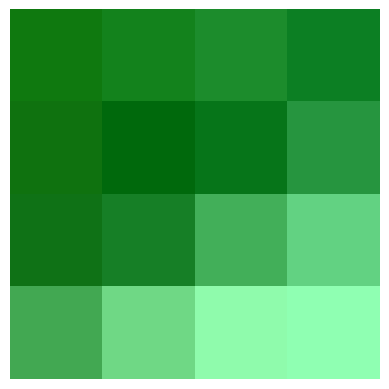

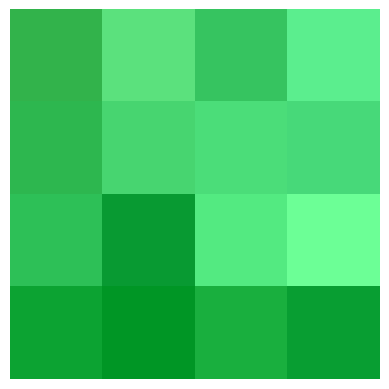

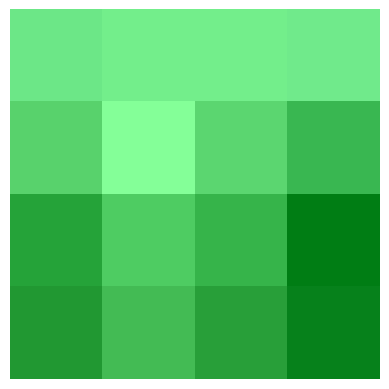

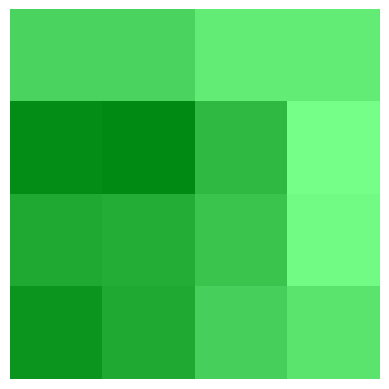

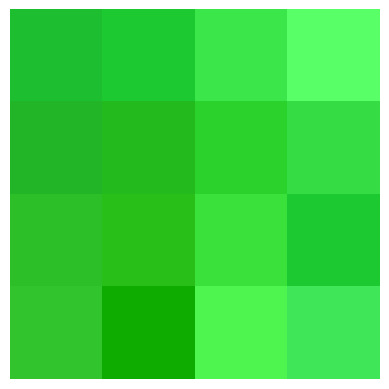

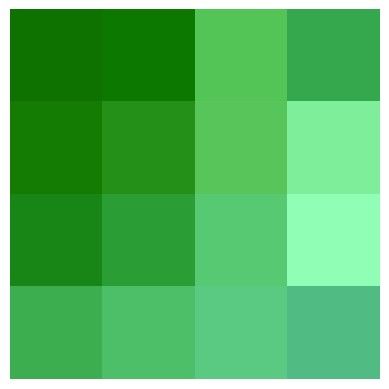

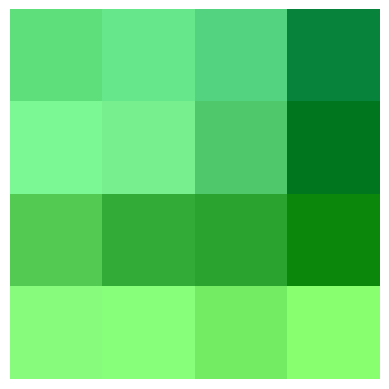

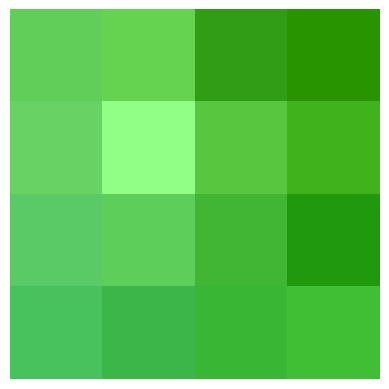

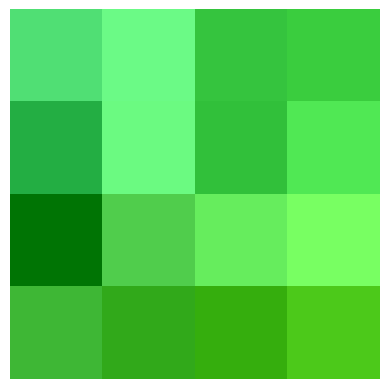

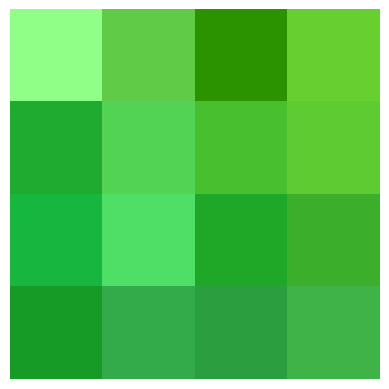

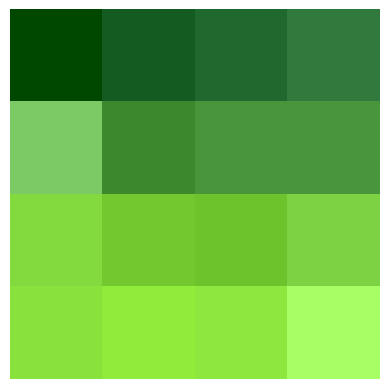

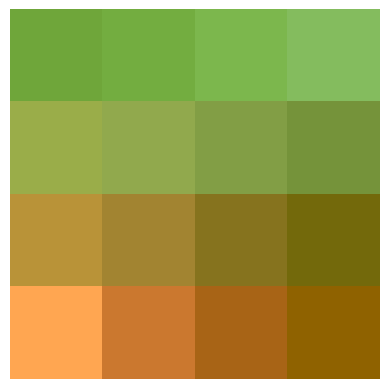

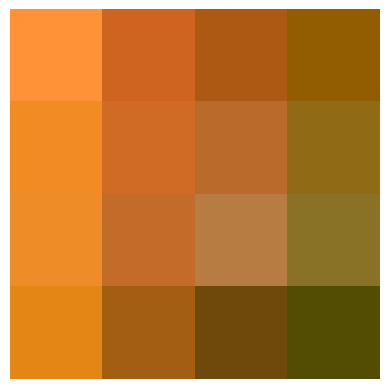

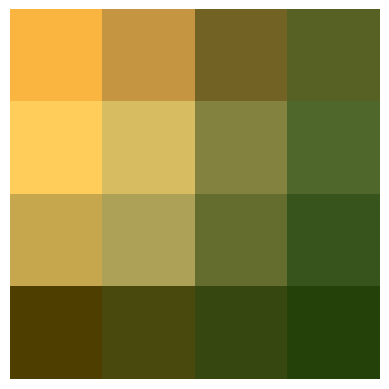

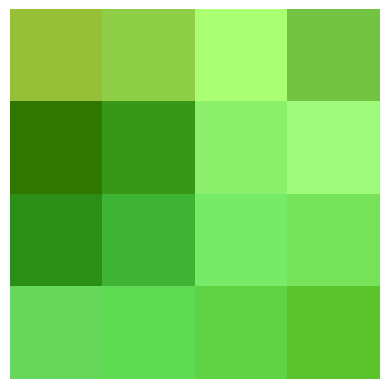

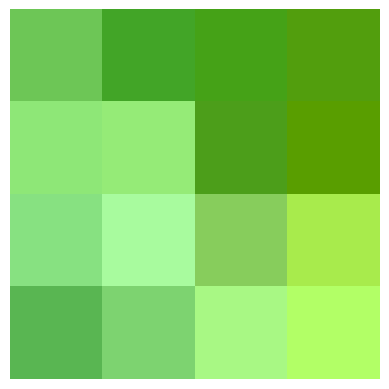

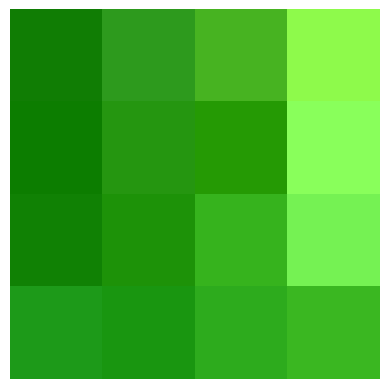

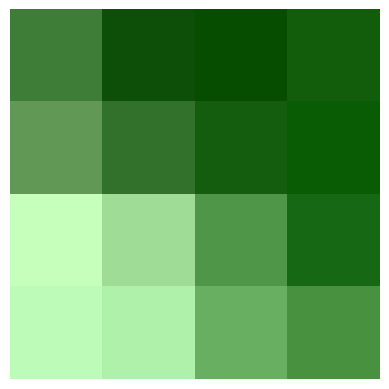

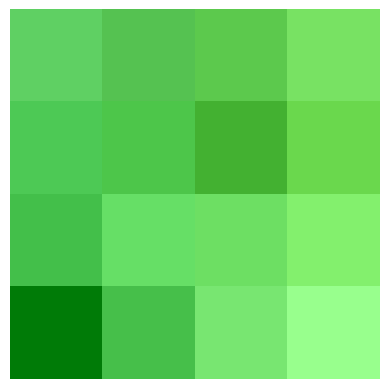

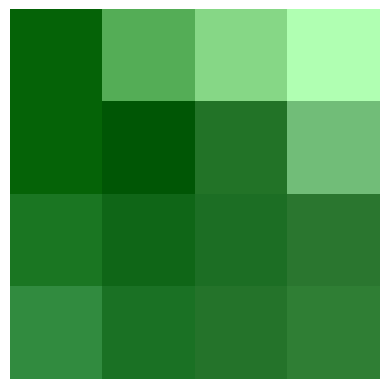

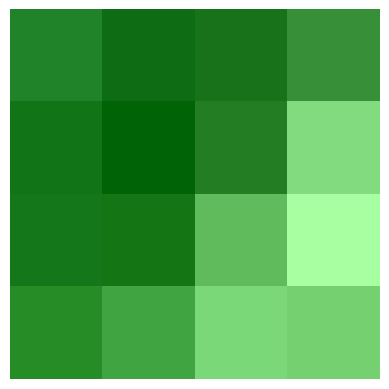

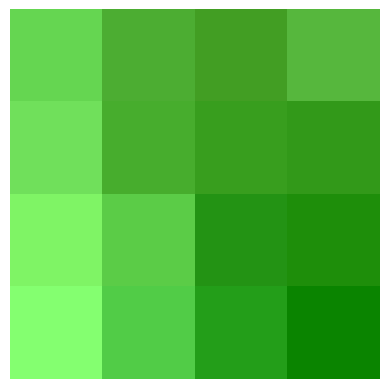

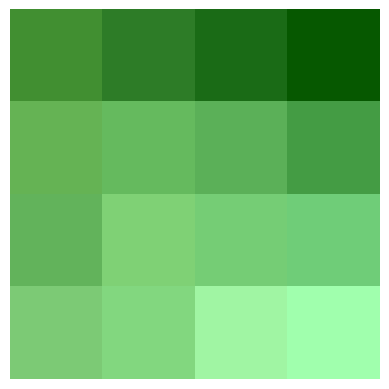

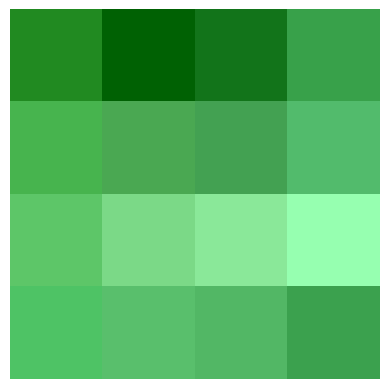

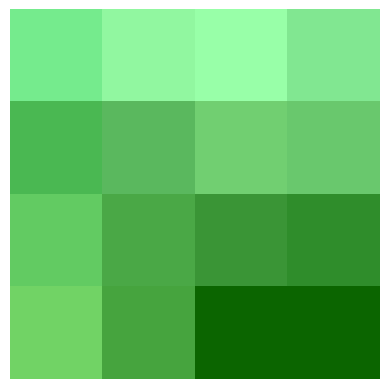

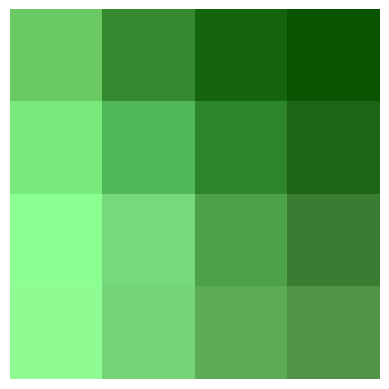

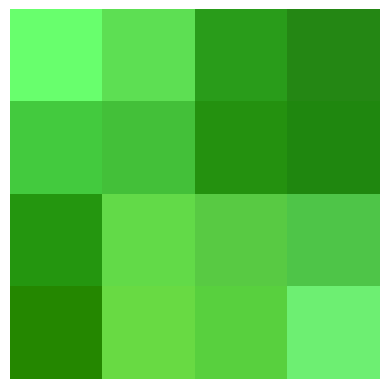

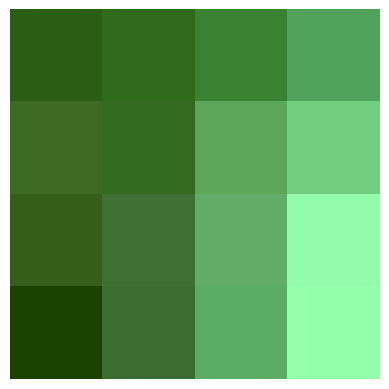

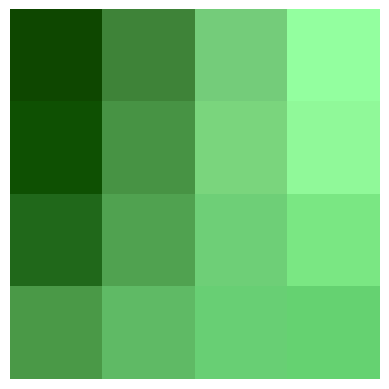

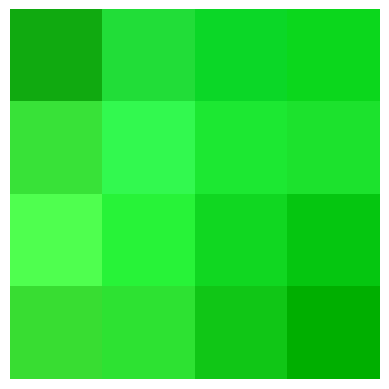

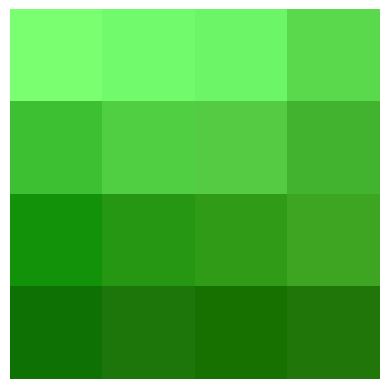

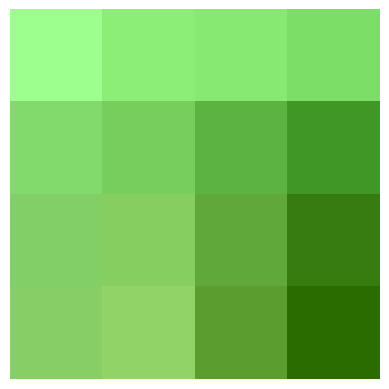

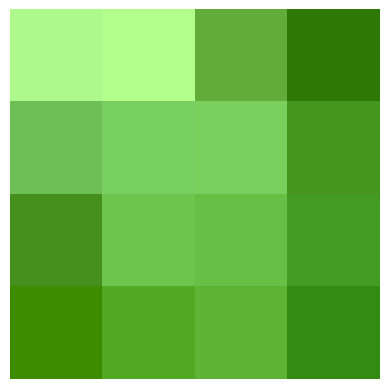

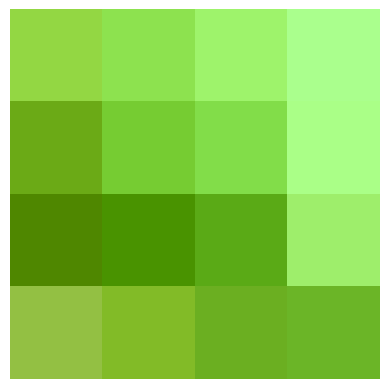

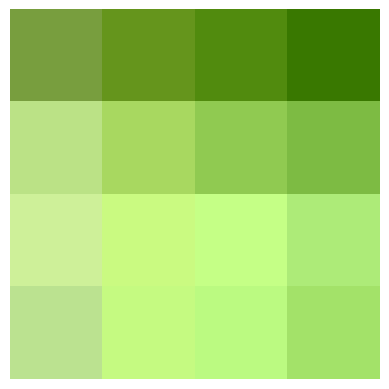

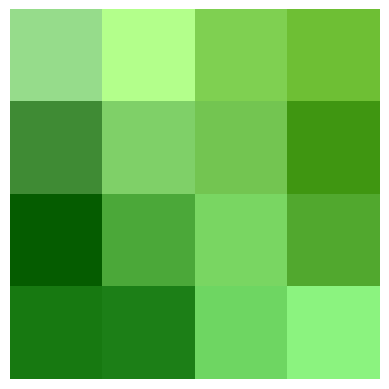

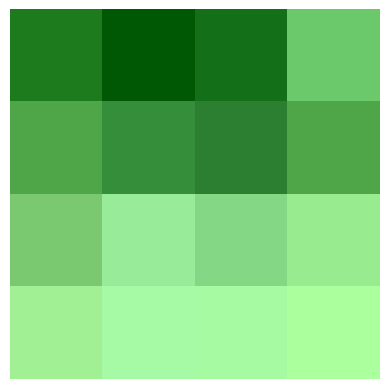

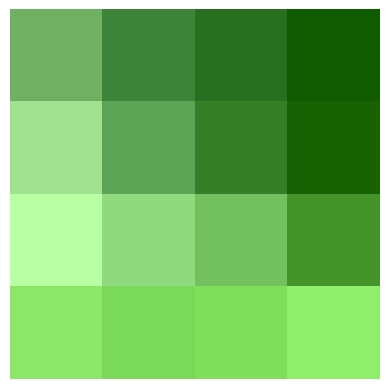

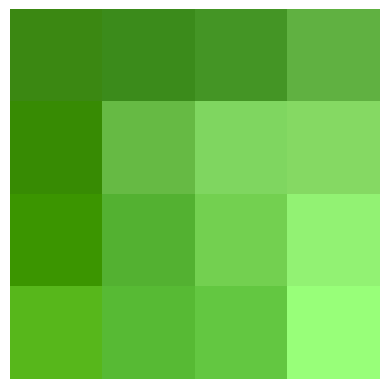

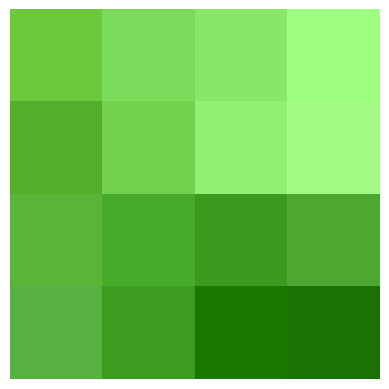

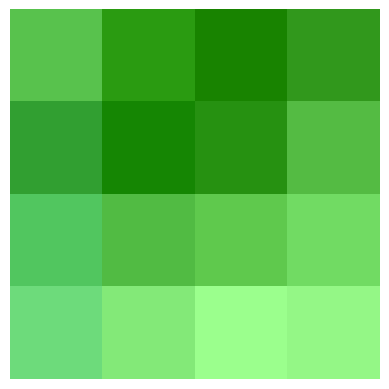

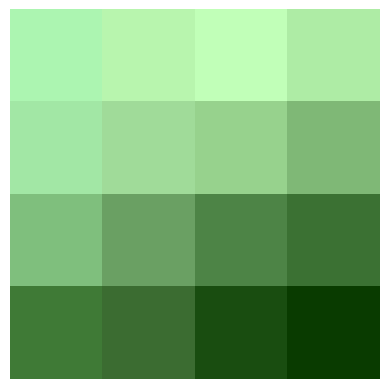

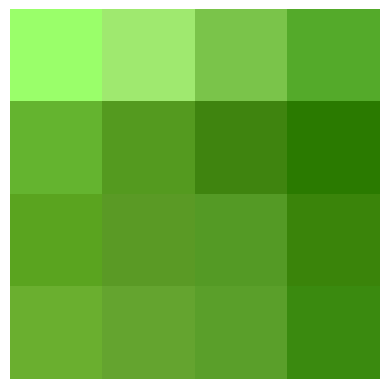

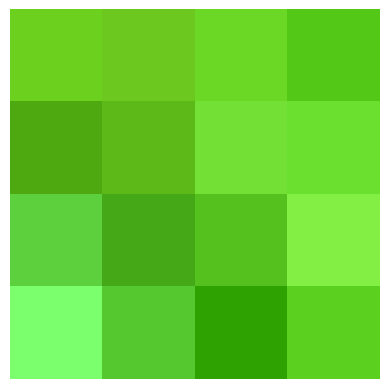

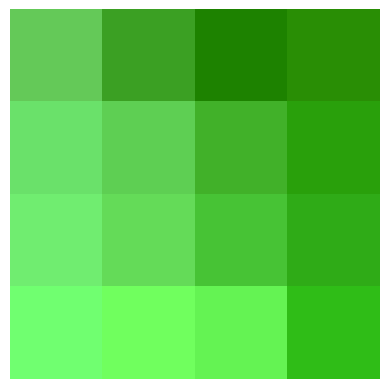

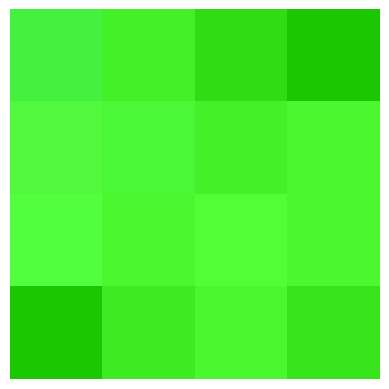

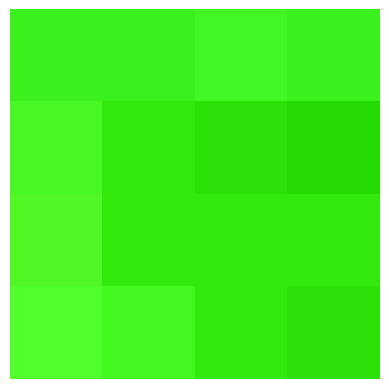

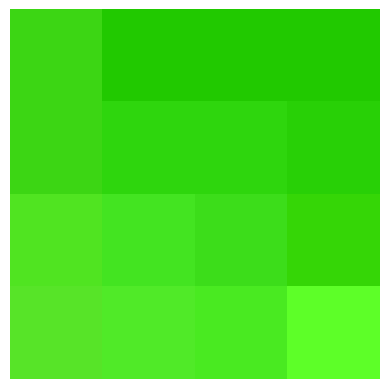

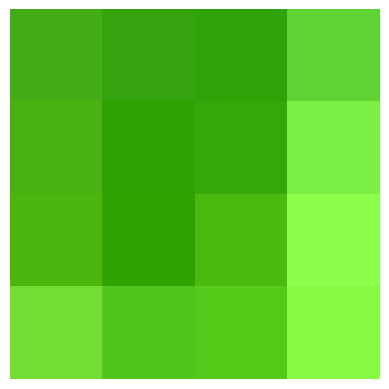

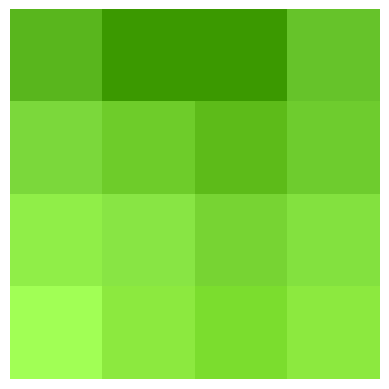

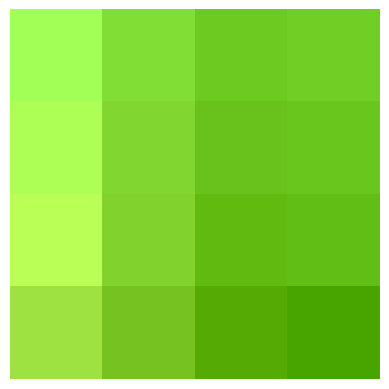

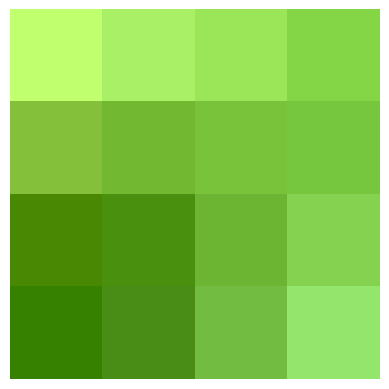

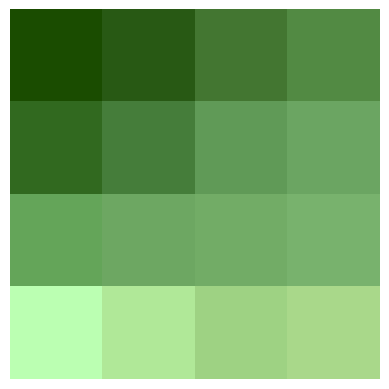

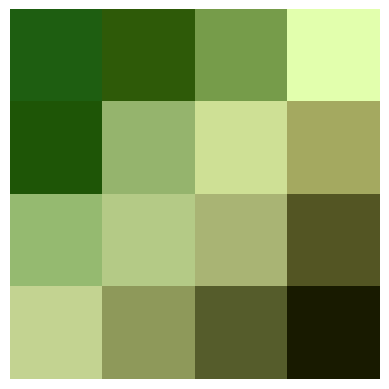

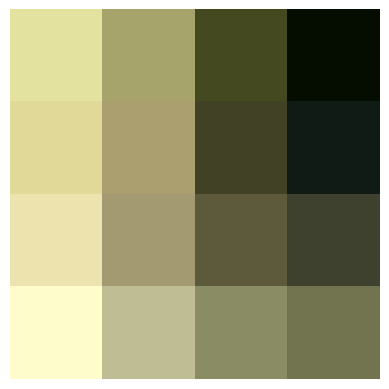

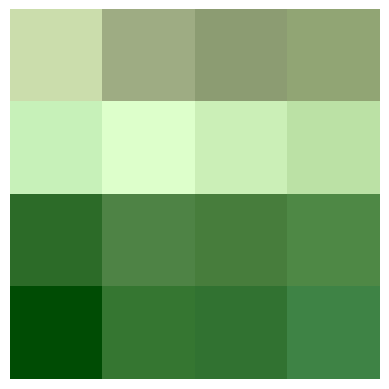

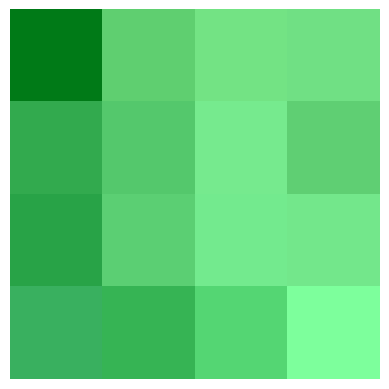

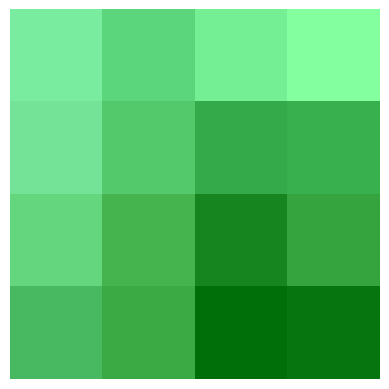

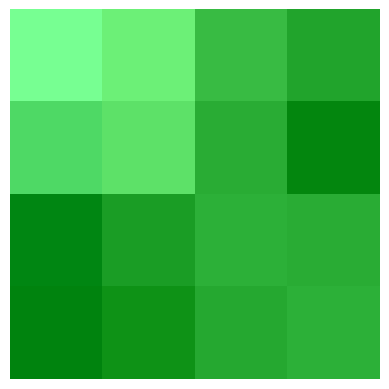

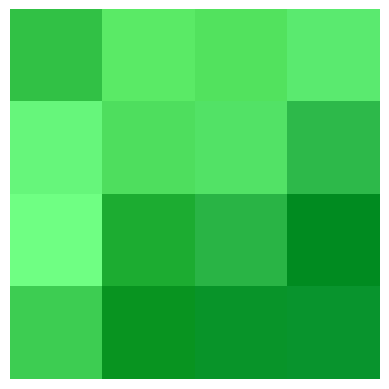

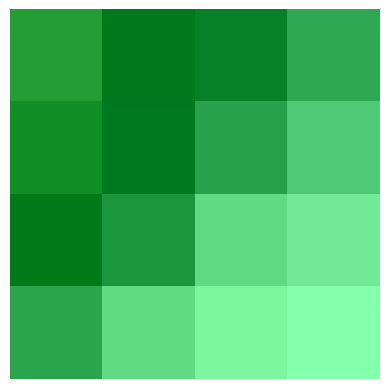

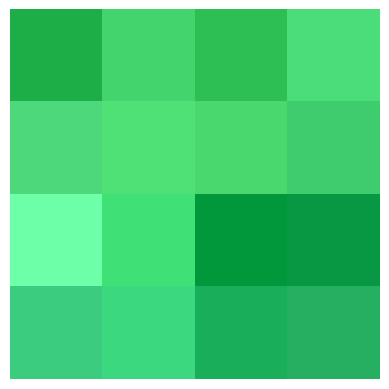

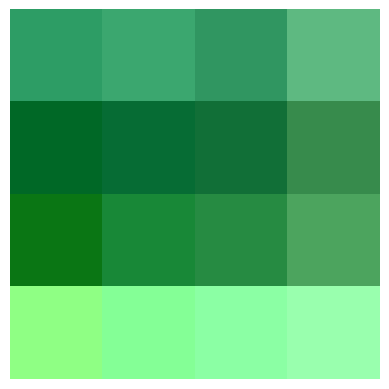

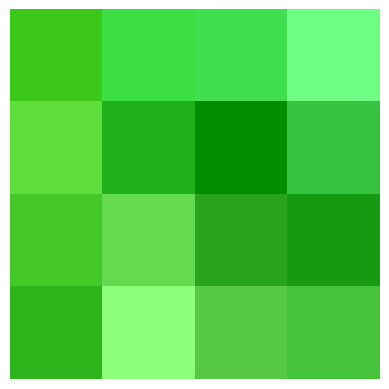

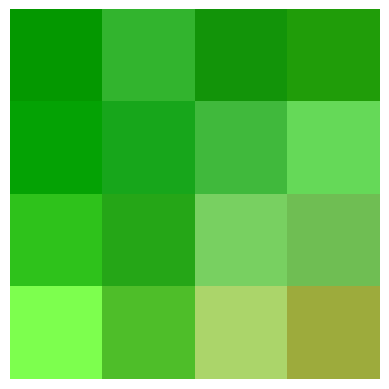

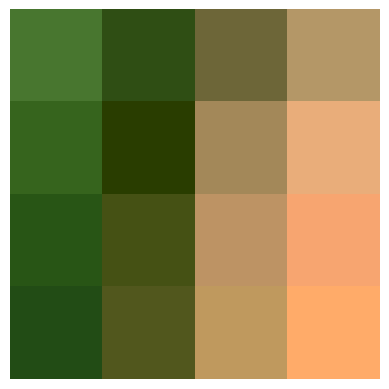

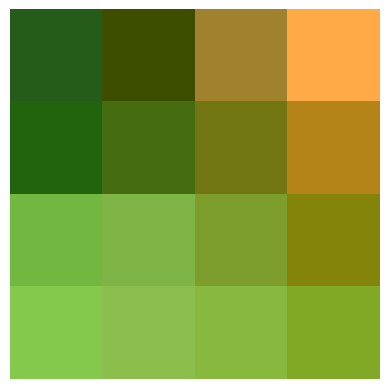

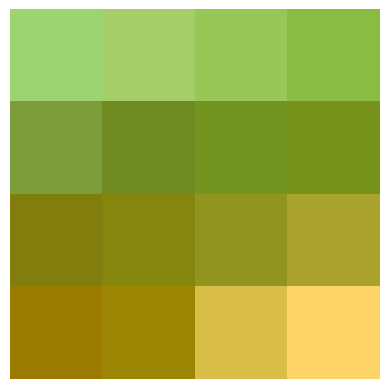

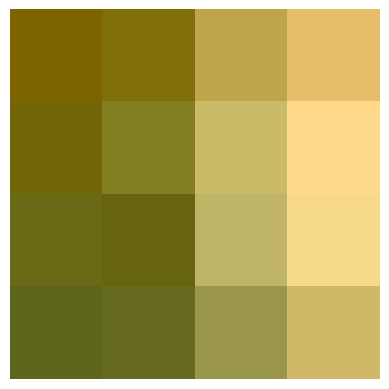

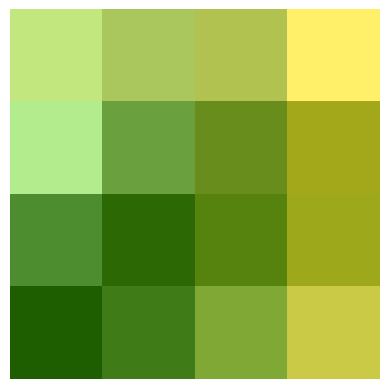

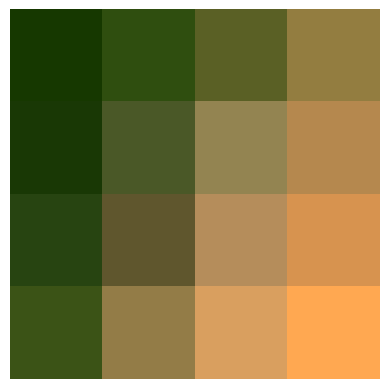

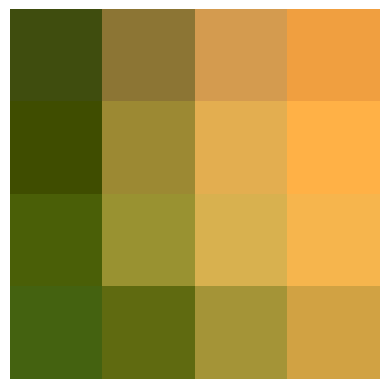

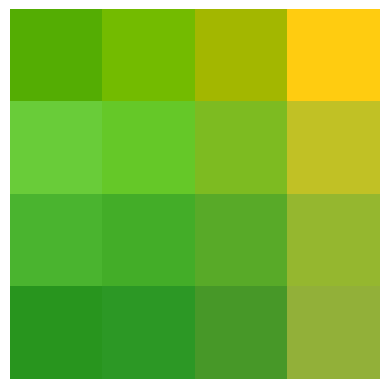

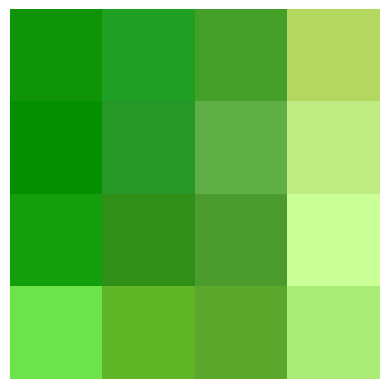

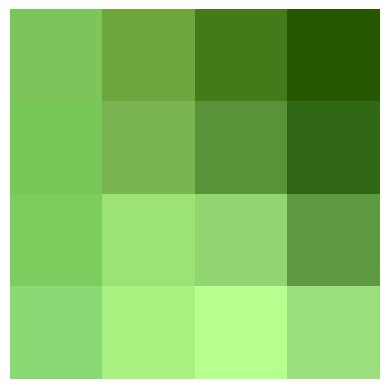

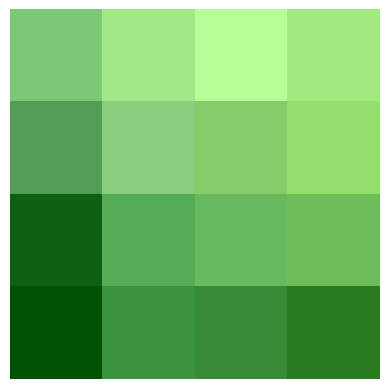

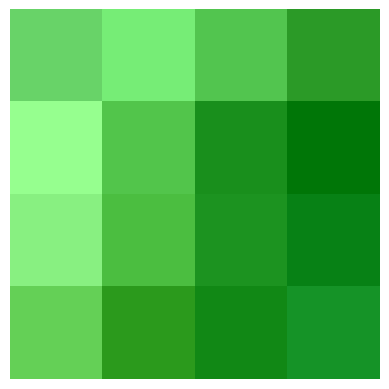

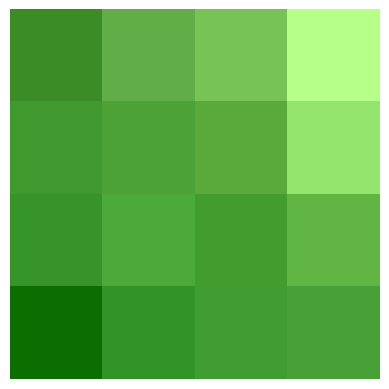

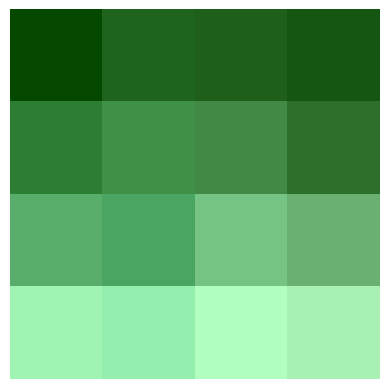

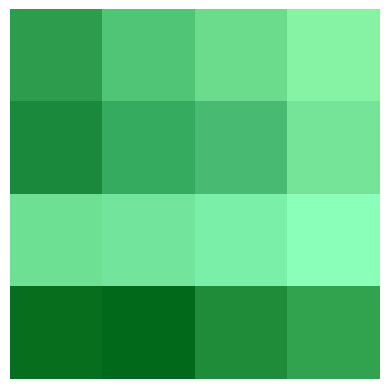

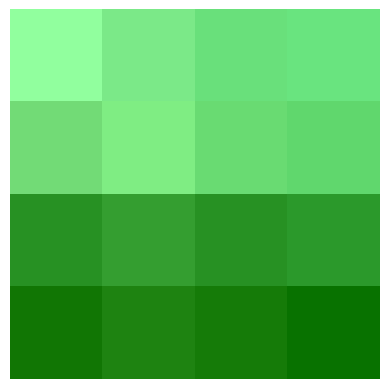

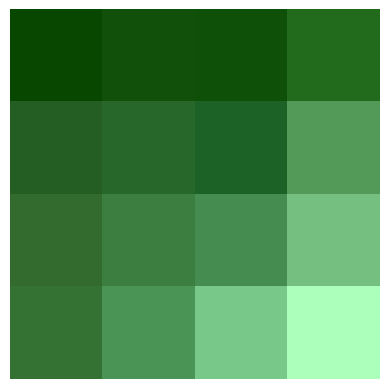

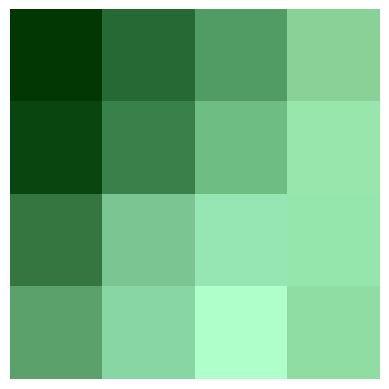

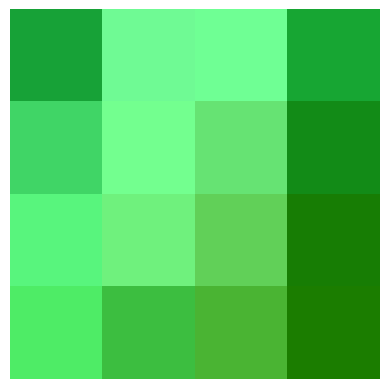

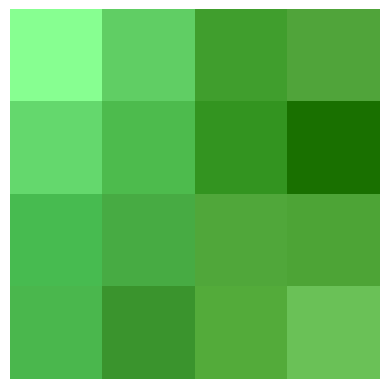

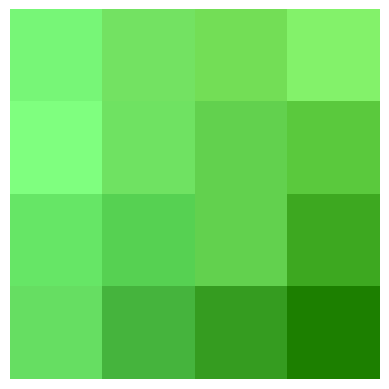

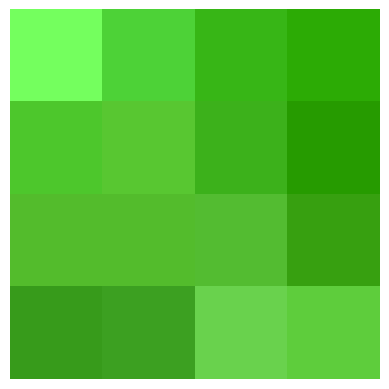

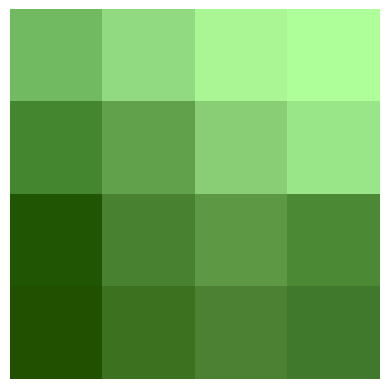

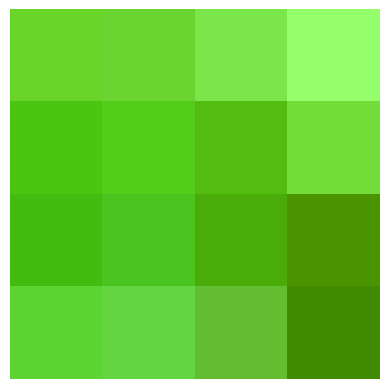

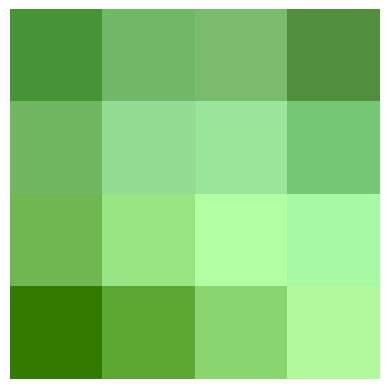

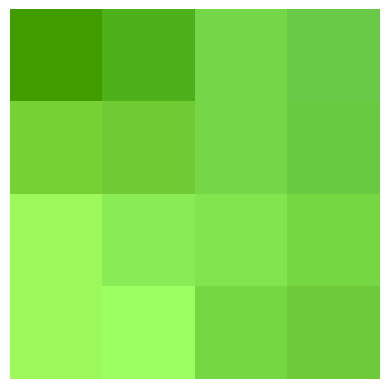

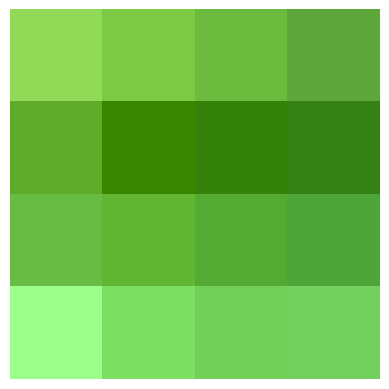

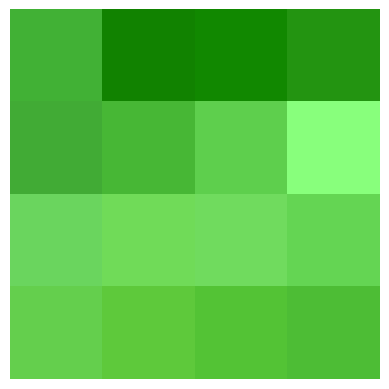

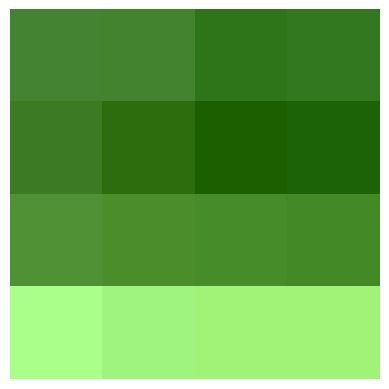

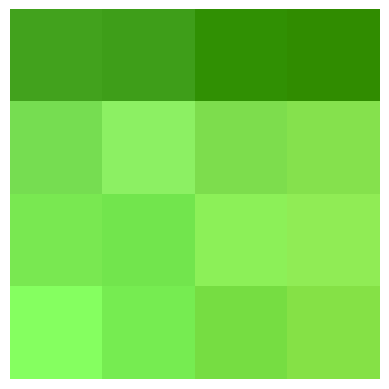

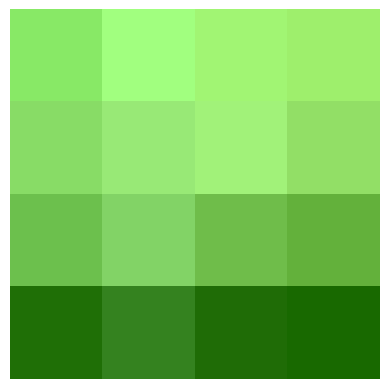

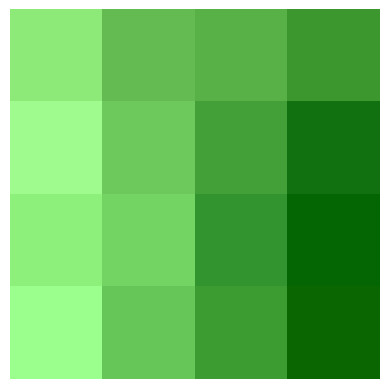

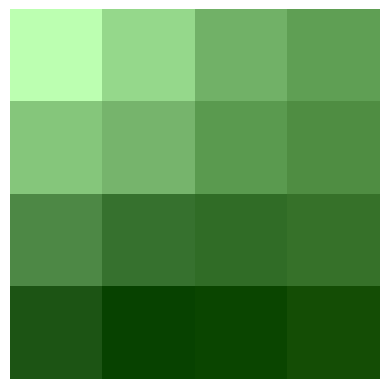

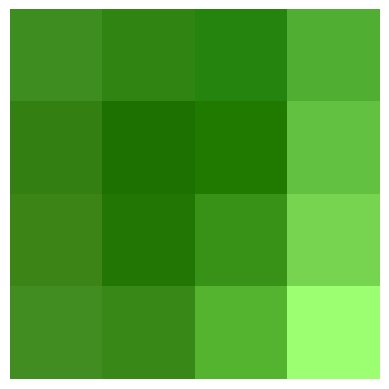

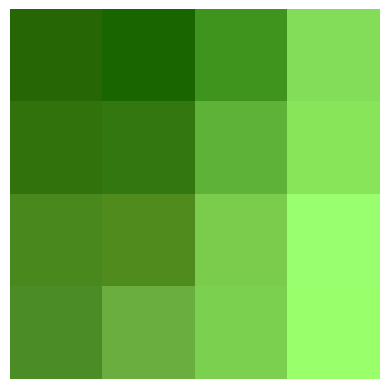

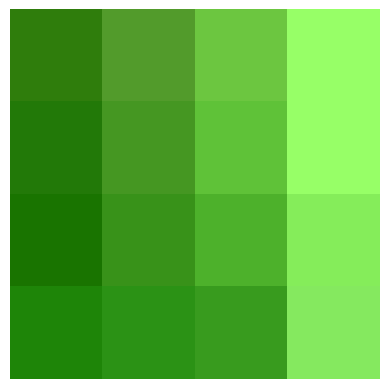

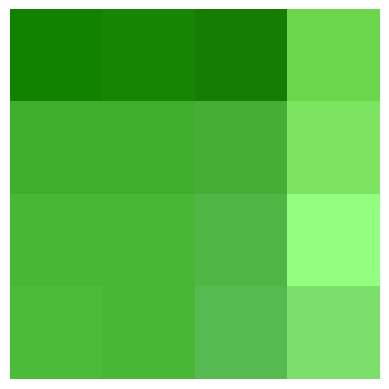

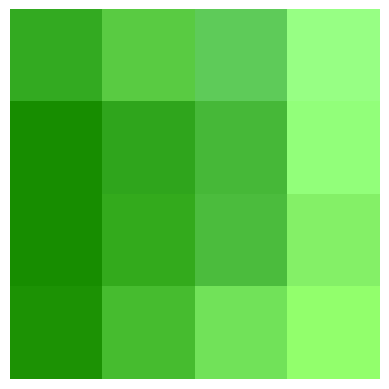

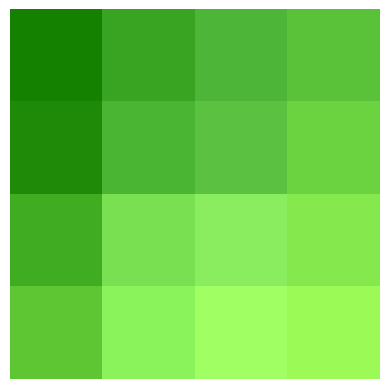

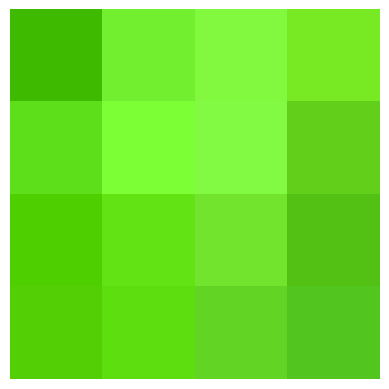

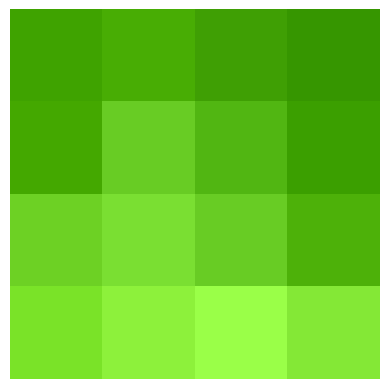

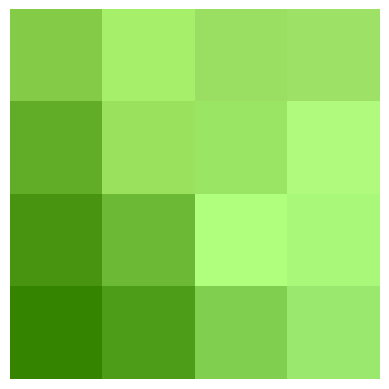

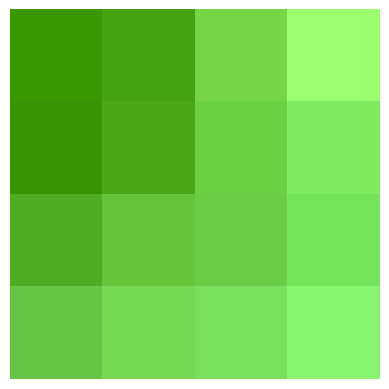

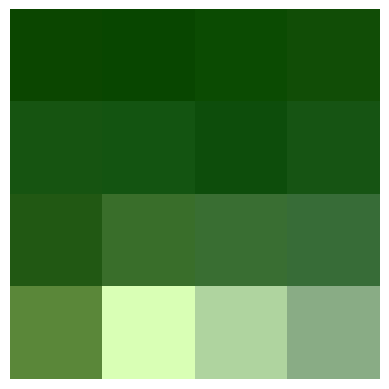

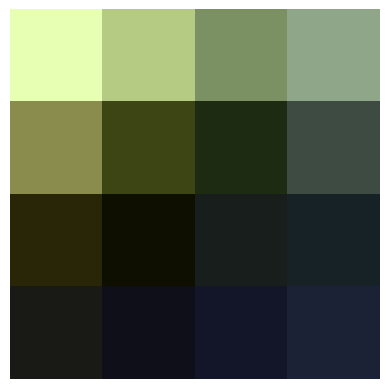

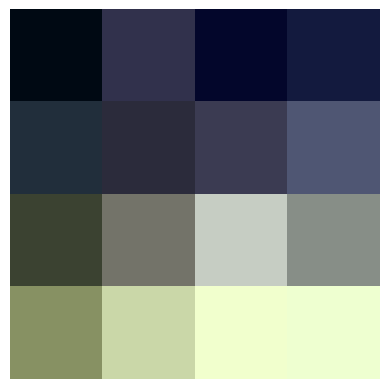

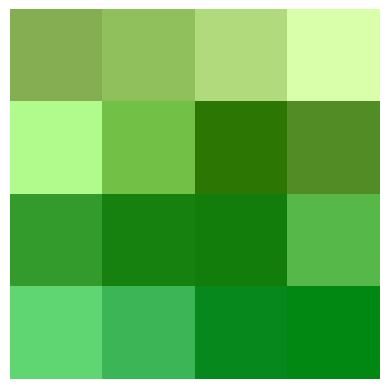

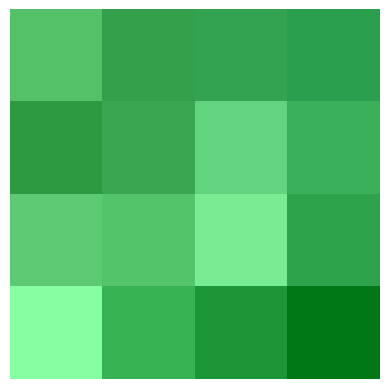

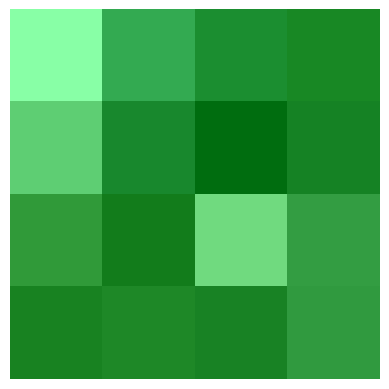

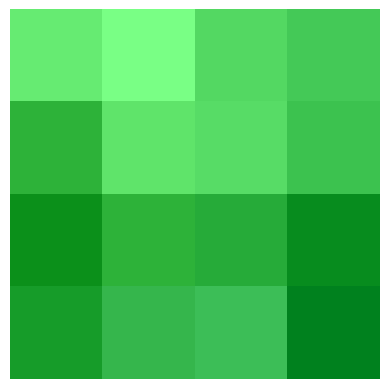

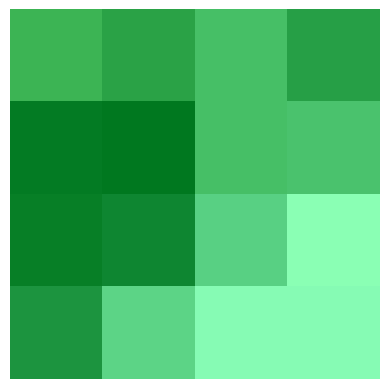

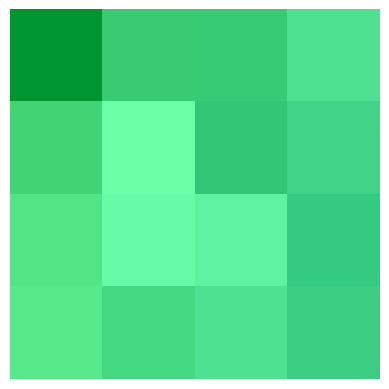

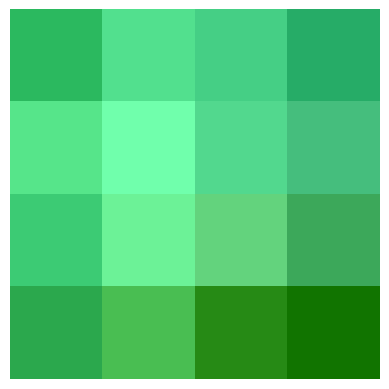

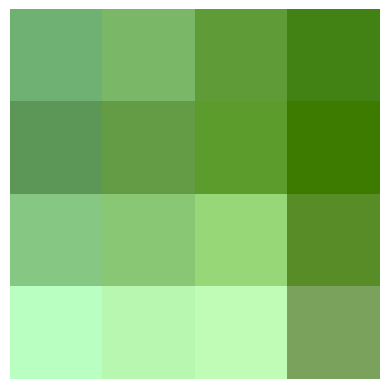

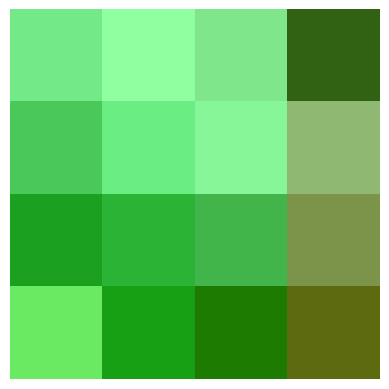

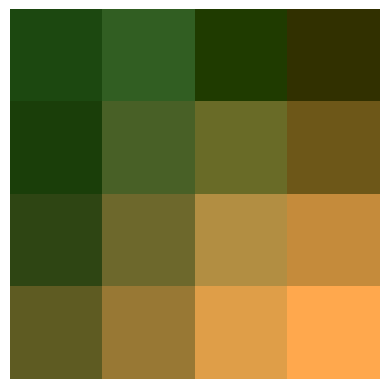

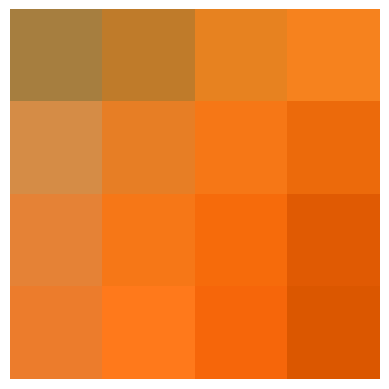

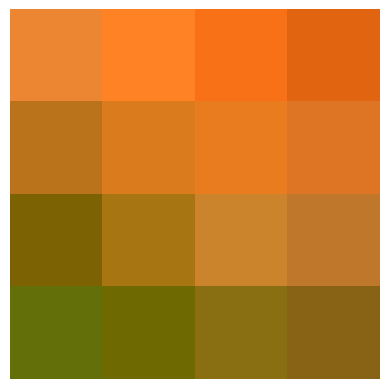

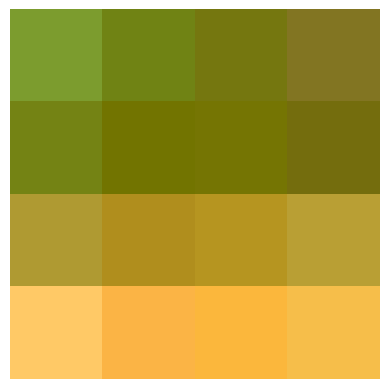

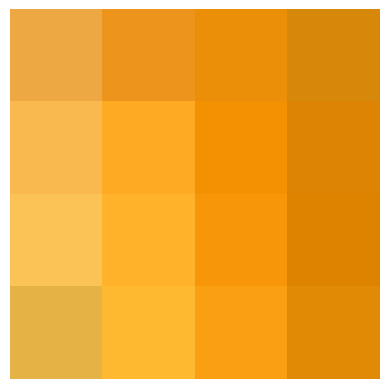

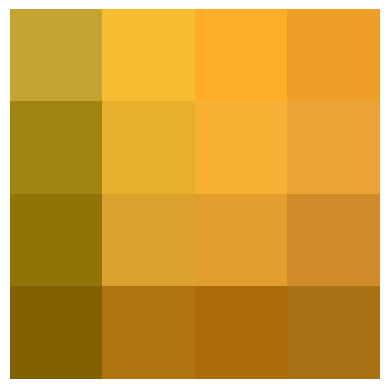

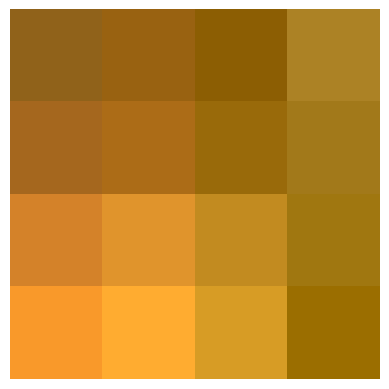

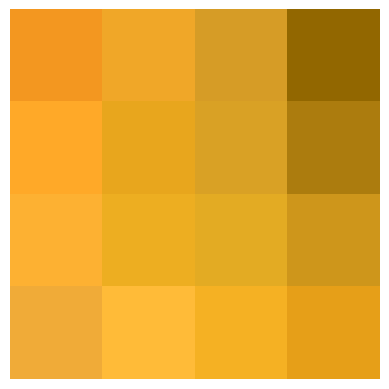

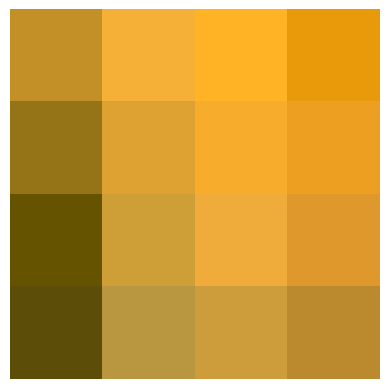

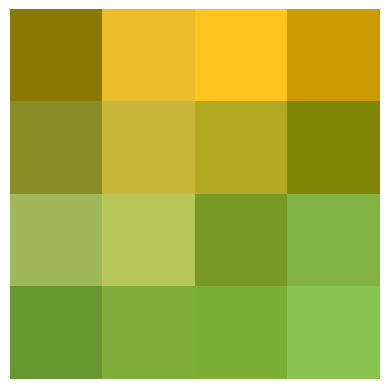

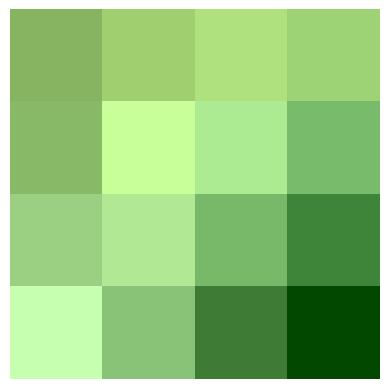

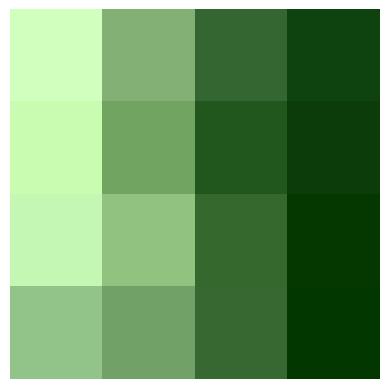

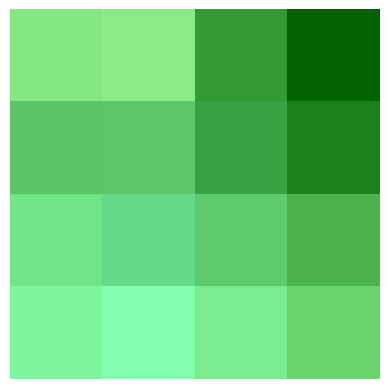

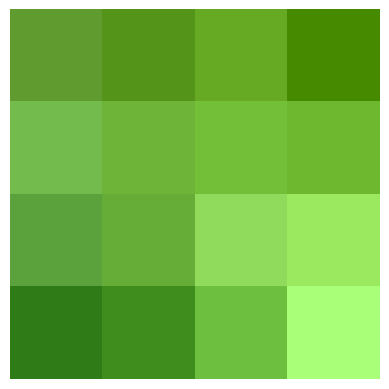

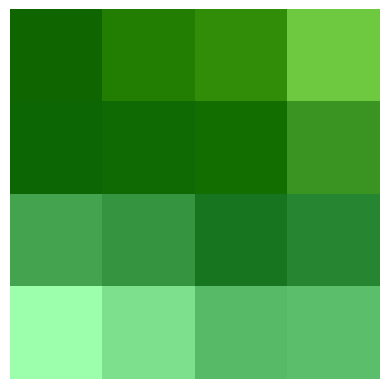

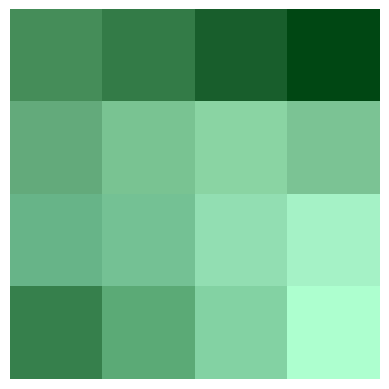

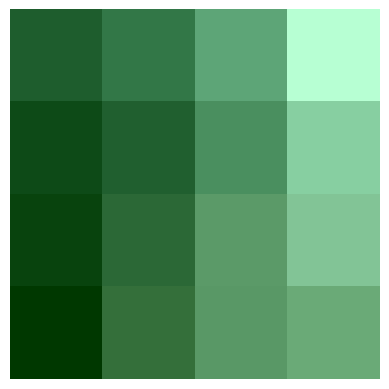

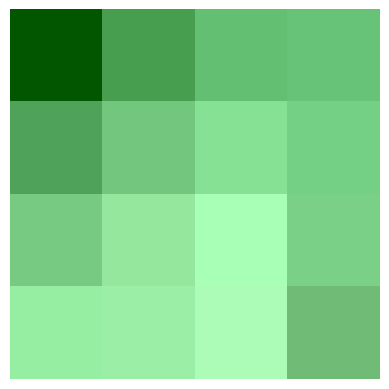

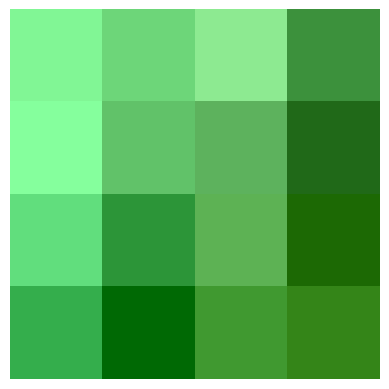

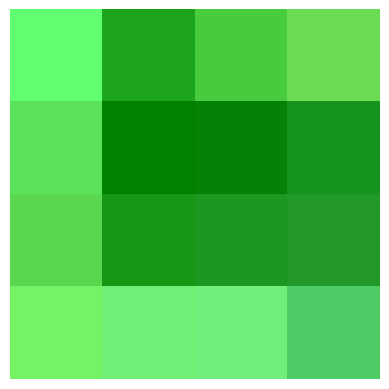

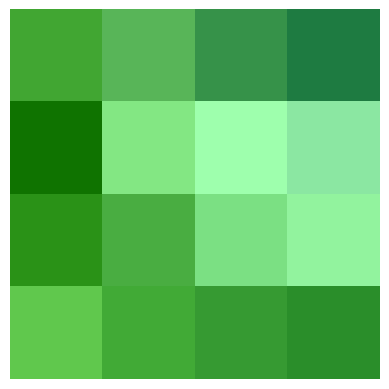

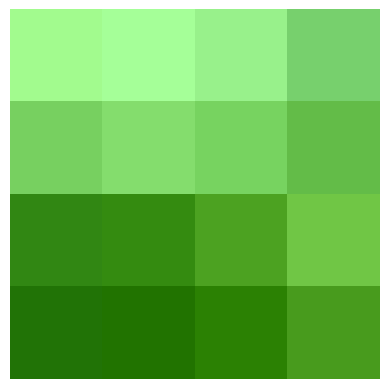

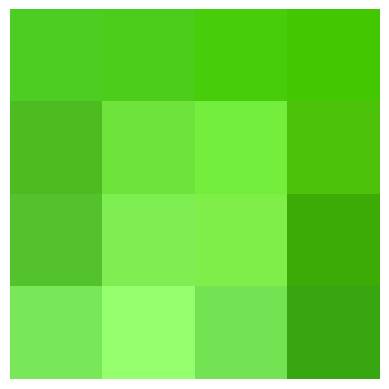

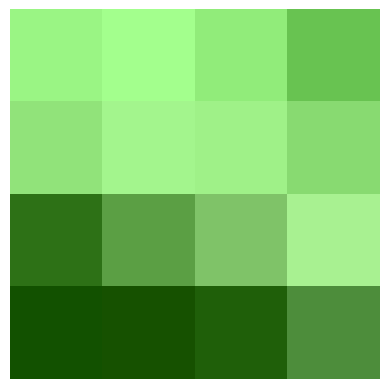

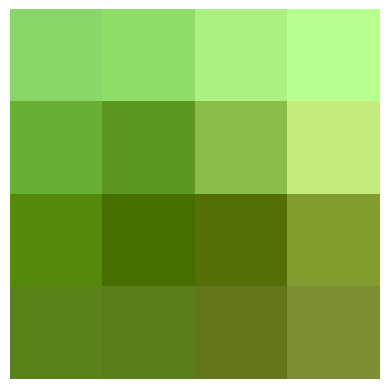

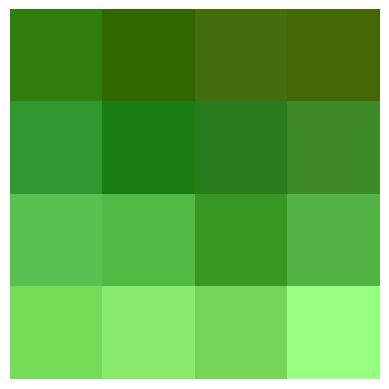

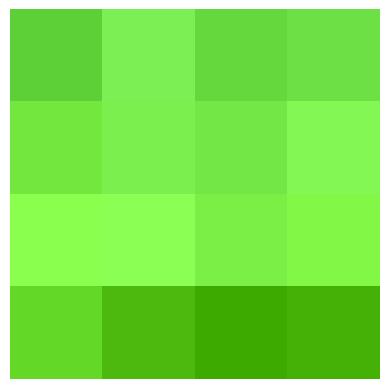

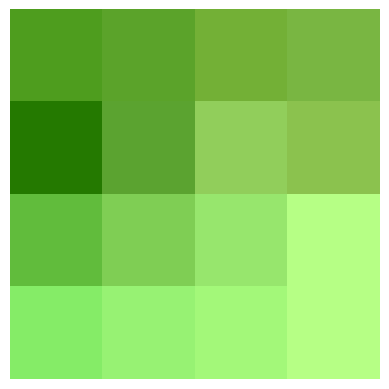

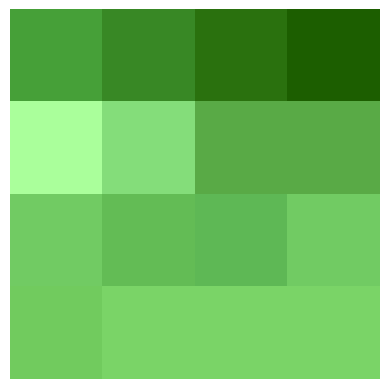

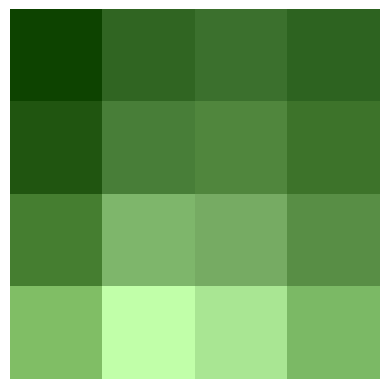

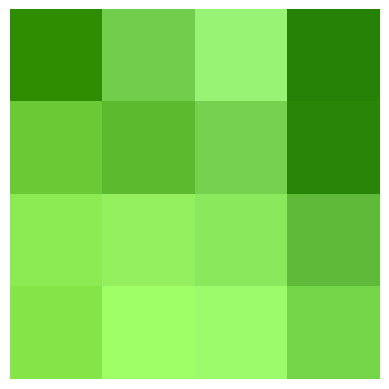

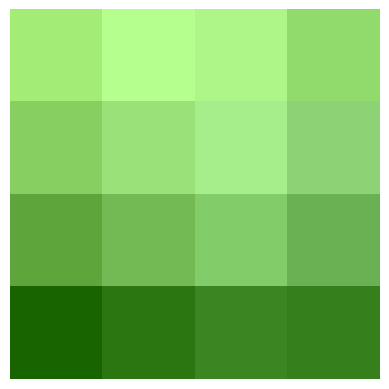

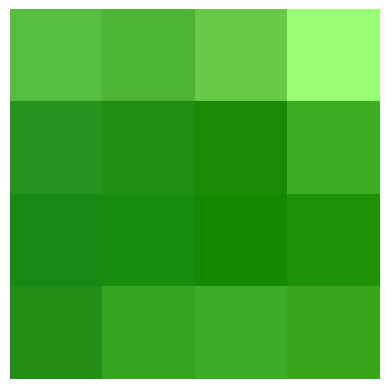

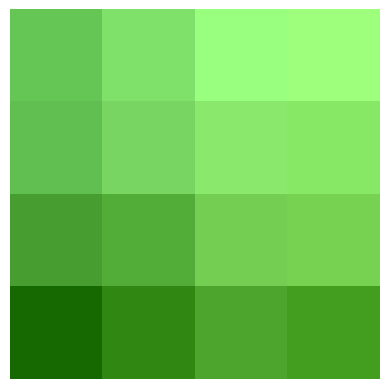

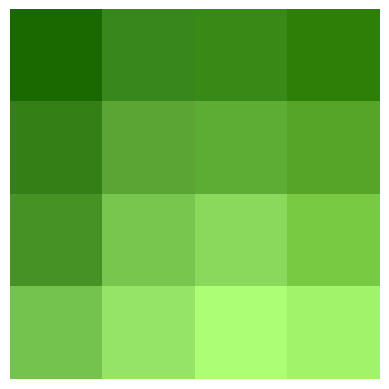

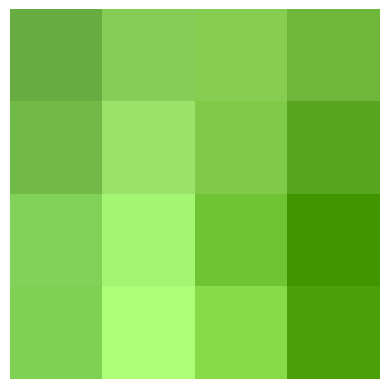

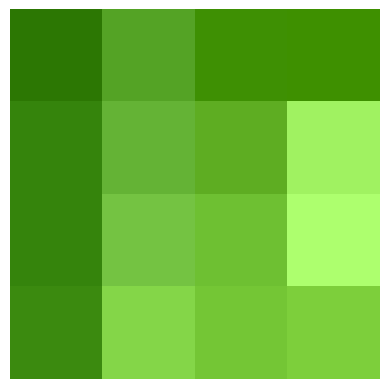

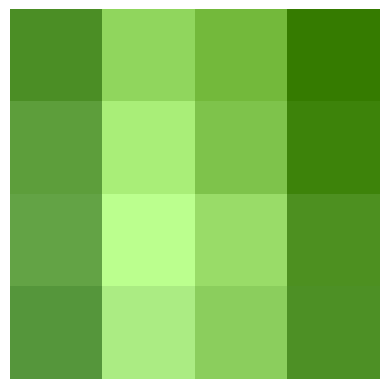

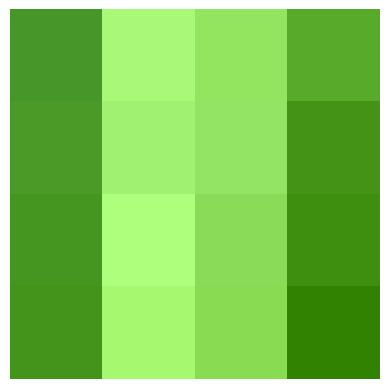

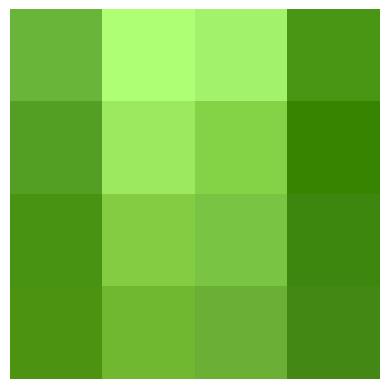

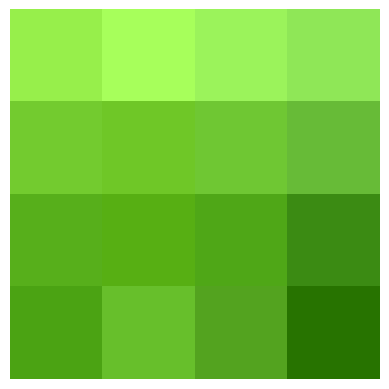

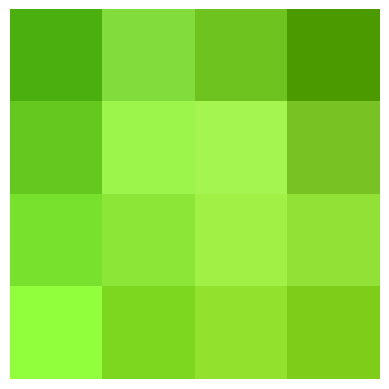

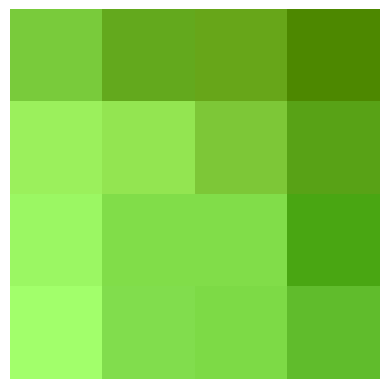

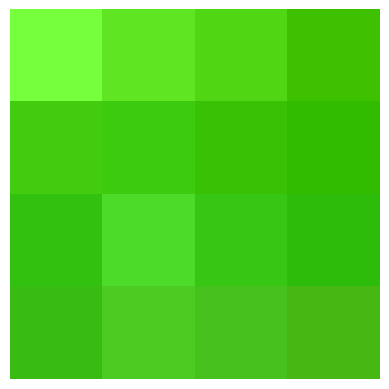

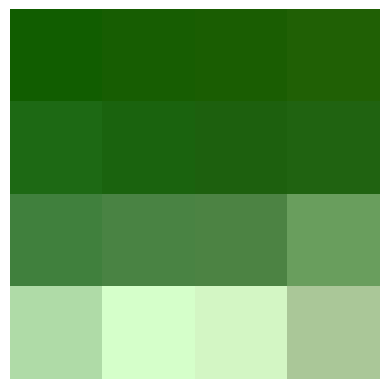

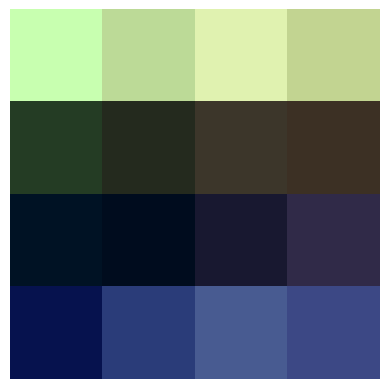

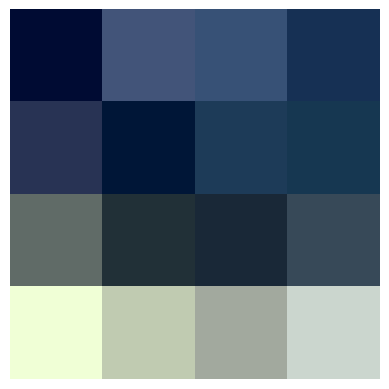

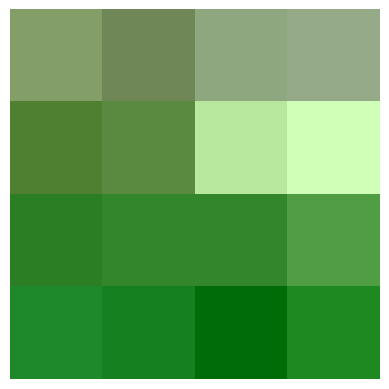

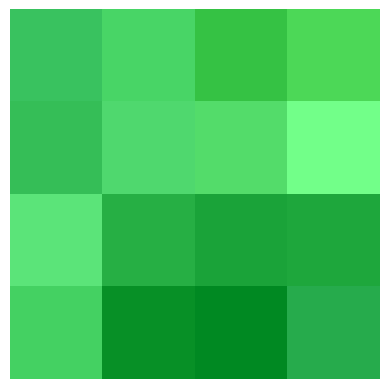

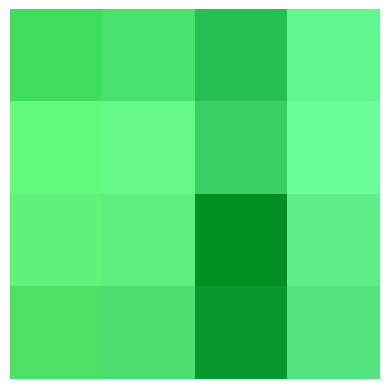

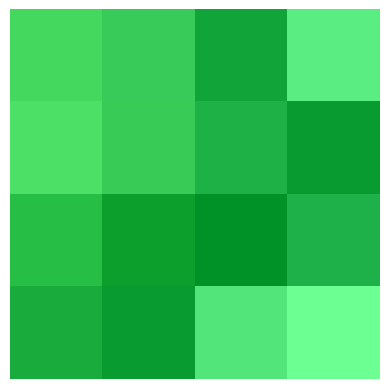

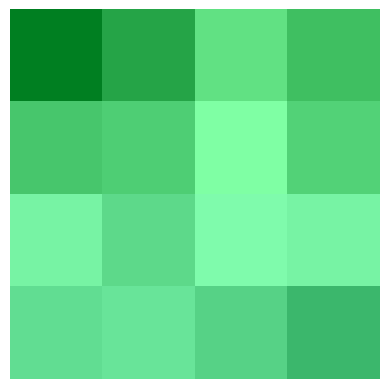

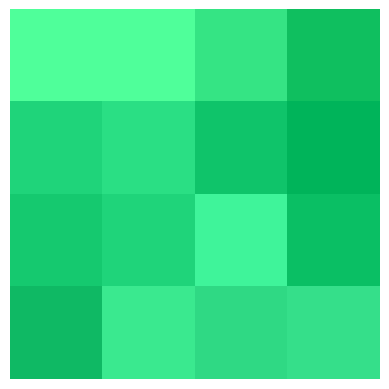

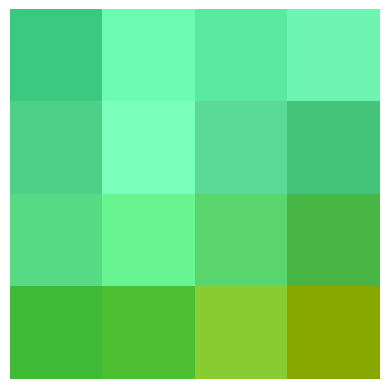

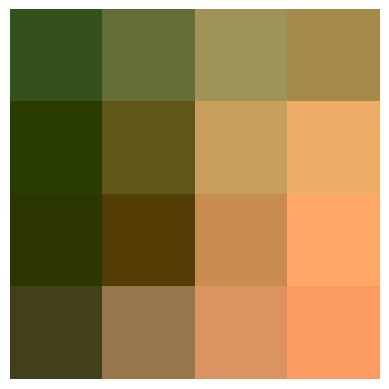

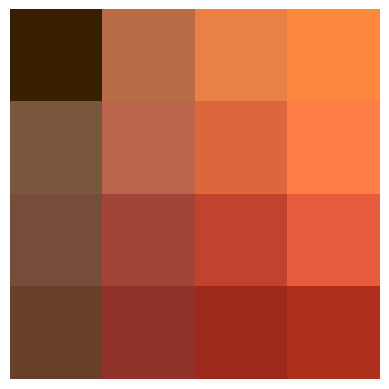

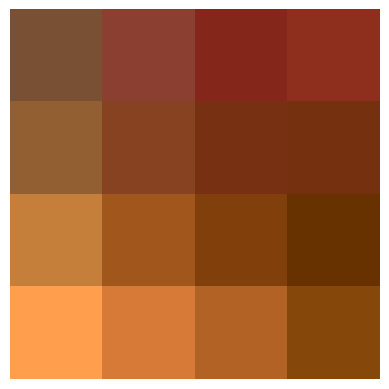

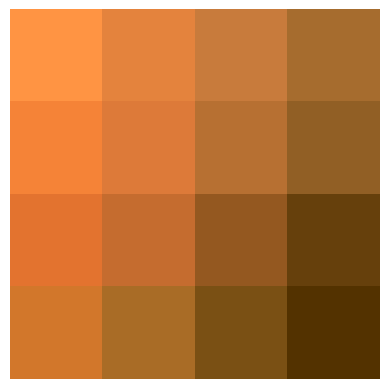

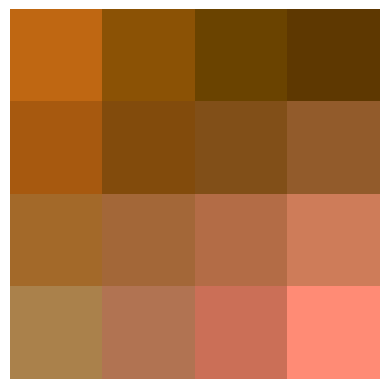

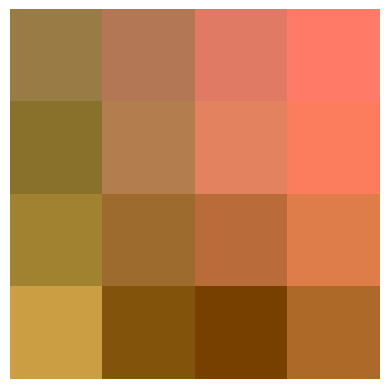

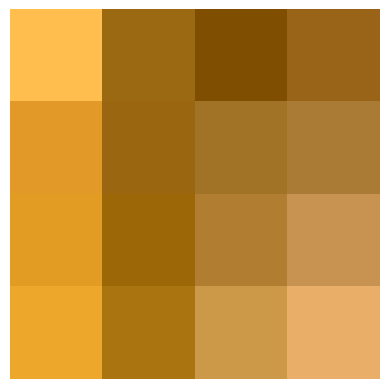

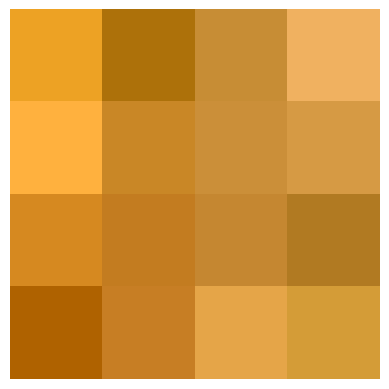

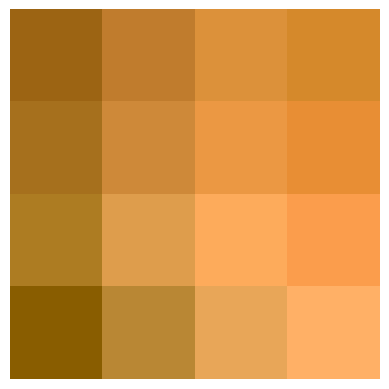

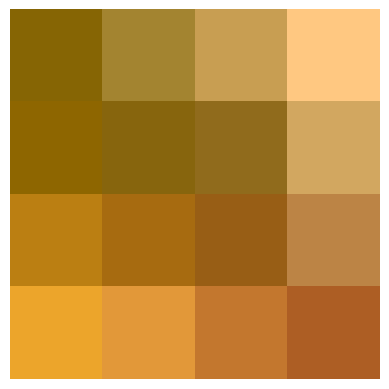

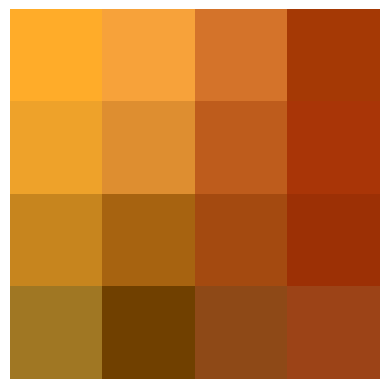

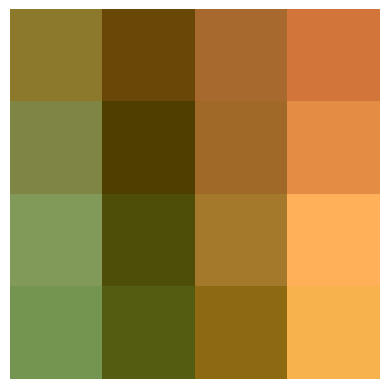

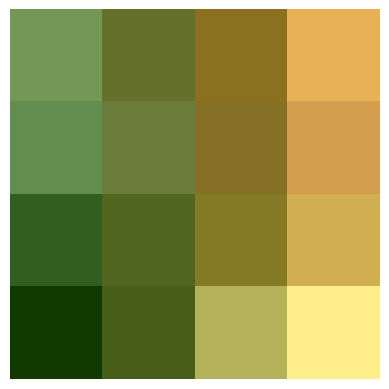

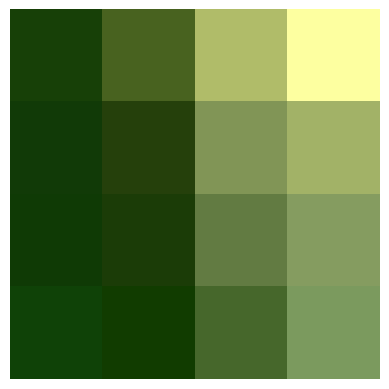

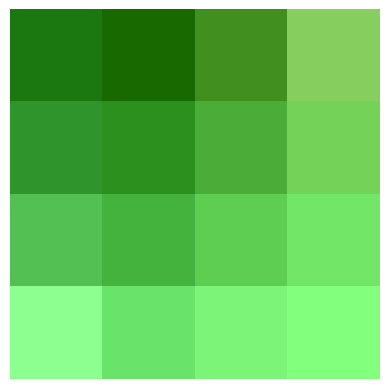

In [8]:
import matplotlib.pyplot as plt
import numpy as np


num_windows = windows.shape[0]
print("Total number of windows:", num_windows)
for i in range(num_windows):
    window = windows[i]

    window_np = window.numpy().transpose(1, 0, 2)

    window_np = (window_np - window_np.min()) / (window_np.max() - window_np.min())

    plt.imshow(window_np)
    plt.axis('off')
    plt.show()

In [9]:
class PatchEmbed(nn.Module):

    def __init__(self, img_size=224, patch_size=4, in_chans=3, embed_dim=96, norm_layer=None):
        super().__init__()
        img_size = to_2tuple(img_size)
        patch_size = to_2tuple(patch_size)
        patches_resolution = [img_size[0] // patch_size[0], img_size[1] // patch_size[1]]

        self.img_size = img_size
        self.patch_size = patch_size
        self.patches_resolution = patches_resolution
        self.num_patches = patches_resolution[0] * patches_resolution[1]

        self.in_chans = in_chans
        self.embed_dim = embed_dim

        self.proj = nn.Conv2d(in_chans, embed_dim, kernel_size=patch_size, stride=patch_size)

        if norm_layer is not None:
            self.norm = norm_layer(embed_dim)
        else:
            self.norm = None

    def forward(self, x):

        B, C, H, W = x.shape
        assert H == self.img_size[0] and W == self.img_size[1], \
            f"Input image size ({H}*{W}]) doesn't match model ({self.img_size[0]}*{self.img_size[1]})."

        x = self.proj(x)

        x = x.flatten(2)

        x = x.transpose(1, 2)

        if self.norm is not None:
            x = self.norm(x)

        return x

In [10]:
image_path = '/content/drive/MyDrive/dataset/train/Common Lanthana/Common_Lanthana105_jpg.rf.de2809f7bd95c4c45b931b825b4c6d1b.jpg'
image = Image.open(image_path).convert('RGB')

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

tensor_image = transform(image)

tensor_image = tensor_image.unsqueeze(0)

patch_embed = PatchEmbed(img_size=224, patch_size=4, in_chans=3, embed_dim=96)

embedding = patch_embed(tensor_image)


patches = patch_embed(tensor_image)
print("Patches shape:", patches.shape)

embedding

Patches shape: torch.Size([1, 3136, 96])


tensor([[[ 0.3122, -0.6112, -0.1671,  ..., -0.1978,  0.0819,  0.4772],
         [ 0.3015, -0.6287, -0.1888,  ..., -0.2127,  0.0929,  0.5327],
         [ 0.3238, -0.5365, -0.1772,  ..., -0.1874,  0.1075,  0.4819],
         ...,
         [ 0.2654, -0.5978, -0.2045,  ..., -0.1708,  0.1326,  0.5107],
         [ 0.3128, -0.5222, -0.1563,  ..., -0.1382,  0.1135,  0.5210],
         [ 0.2259, -0.4926, -0.1121,  ..., -0.1370,  0.1179,  0.4310]]],
       grad_fn=<TransposeBackward0>)

In [11]:
print("First patch embedding vector:", patches[0, 0])

First patch embedding vector: tensor([ 0.3122, -0.6112, -0.1671,  0.5431,  0.3148,  0.1357,  0.1685, -1.1300,
         0.3038, -0.0904, -0.5312,  0.0996,  0.4890, -0.7647,  0.9063, -0.2076,
         0.5522,  0.3881, -0.1421,  0.8217, -0.4014, -0.3693,  0.1704, -0.6351,
         0.6284, -0.1953,  0.9607, -0.0267, -0.2450, -0.2508, -0.4179, -0.2622,
        -0.2329, -0.4310, -0.0153,  0.4754, -0.6998,  0.1731,  0.3808,  0.5765,
         0.3304,  0.3137, -0.0029,  0.7600, -0.3283,  0.7246, -0.7202,  0.0343,
        -0.0452, -0.0600,  0.1910,  0.3495,  0.3380, -0.5493, -0.6906,  0.1115,
         0.2173,  0.7230, -0.2558, -0.3578,  0.1264, -0.9082, -1.3324,  0.4482,
         0.2073,  0.6929, -0.1016, -0.1767,  0.4945,  0.0509,  0.0332, -0.5383,
         0.2578, -0.0238,  0.4602,  0.2916, -0.1004,  0.8089, -0.1317, -0.5288,
        -0.0243, -0.2345, -0.1121,  0.0202,  0.3392, -0.0234,  0.4567,  0.0623,
         0.2695,  0.2167,  0.4836, -0.1734,  0.3095, -0.1978,  0.0819,  0.4772],
       gr

In [12]:
from swin_functions_and_classes import *


stage_1 = BasicLayer(dim=96, input_resolution=(56, 56), depth=2, num_heads=4, window_size=7)

output = stage_1(embedding)
print(output.shape)
output

torch.Size([1, 3136, 96])


/usr/local/lib/python3.10/dist-packages/torch/functional.py:512: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3587.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


tensor([[[-0.5344,  0.0429, -0.3348,  ...,  0.0753,  0.2708,  1.4199],
         [-0.5545,  0.0299, -0.3690,  ...,  0.0475,  0.2926,  1.4739],
         [-0.5168,  0.1058, -0.3517,  ...,  0.0615,  0.3155,  1.4479],
         ...,
         [-0.5818,  0.0174, -0.4369,  ...,  0.1867,  0.3186,  1.4062],
         [-0.5269,  0.1293, -0.3804,  ...,  0.1742,  0.3249,  1.4264],
         [-0.5877,  0.0571, -0.3649,  ...,  0.2285,  0.3242,  1.3340]]],
       grad_fn=<AddBackward0>)

In [13]:
merge_layer = PatchMerging(input_resolution=(56, 56), dim=96, norm_layer=nn.LayerNorm)
merged_output = merge_layer(output)
print("Merged output shape:", merged_output.shape)    # (1, 28x28, 96*2) # (1, 784, 192)

Merged output shape: torch.Size([1, 784, 192])


In [14]:
batch_size = merged_output.shape[0]
num_patches = merged_output.shape[1]
num_channels = merged_output.shape[2]

print("Batch size:", batch_size)
print("Number of patches:", num_patches)
print("Number of channels:", num_channels)

Batch size: 1
Number of patches: 784
Number of channels: 192


In [15]:
block_1 = SwinTransformerBlock(dim=96, input_resolution=(56, 56), num_heads=4, window_size=7, shift_size=0,
                             mlp_ratio=4.0, qkv_bias=True, qk_scale=None, drop=0.0, attn_drop=0.0,
                             drop_path=0.0, act_layer=nn.GELU, norm_layer=nn.LayerNorm)


block_1_shf = SwinTransformerBlock(dim=96, input_resolution=(56, 56), num_heads=4, window_size=7, shift_size=2,
                             mlp_ratio=4.0, qkv_bias=True, qk_scale=None, drop=0.0, attn_drop=0.0,
                             drop_path=0.0, act_layer=nn.GELU, norm_layer=nn.LayerNorm)


output = block_1(embedding)
output_shf = block_1_shf(embedding)

print(output.shape)
print(output_shf.shape)
print(output)
print(output_shf)

torch.Size([1, 3136, 96])
torch.Size([1, 3136, 96])
tensor([[[ 0.2811, -0.2687, -0.1604,  ..., -0.2158, -0.1365,  0.4245],
         [ 0.2691, -0.3070, -0.1677,  ..., -0.2403, -0.1118,  0.4873],
         [ 0.3020, -0.2098, -0.1700,  ..., -0.2064, -0.1161,  0.4266],
         ...,
         [ 0.2750, -0.2973, -0.1529,  ..., -0.1673, -0.0151,  0.4740],
         [ 0.3253, -0.2241, -0.1422,  ..., -0.1447, -0.0788,  0.4577],
         [ 0.2621, -0.1817, -0.0720,  ..., -0.0830, -0.0351,  0.3568]]],
       grad_fn=<AddBackward0>)
tensor([[[ 0.3113, -0.1433, -0.3380,  ...,  0.2821,  0.4587,  0.4416],
         [ 0.3148, -0.1679, -0.3803,  ...,  0.2639,  0.4530,  0.4923],
         [ 0.3653, -0.0837, -0.3682,  ...,  0.2829,  0.5003,  0.4619],
         ...,
         [ 0.2863, -0.1863, -0.4053,  ...,  0.2966,  0.5391,  0.4783],
         [ 0.3669, -0.0750, -0.3506,  ...,  0.3478,  0.5289,  0.5094],
         [ 0.2910, -0.0617, -0.2928,  ...,  0.3585,  0.5610,  0.4281]]],
       grad_fn=<AddBackward0>)


In [16]:
model = SwinTransformer()

print(tensor_image.shape)

model(tensor_image).shape

torch.Size([1, 3, 224, 224])


torch.Size([1, 1000])

In [17]:
import os

custom_path = "/content/drive/MyDrive/dataset"

train_dir = os.path.join(custom_path, "train")
test_dir = os.path.join(custom_path, "test")

print("Training directory:", train_dir)
print("Validation directory:", test_dir)


Training directory: /content/drive/MyDrive/dataset/train
Validation directory: /content/drive/MyDrive/dataset/test


In [18]:
import os

from torchvision import datasets, transforms
from torch.utils.data import DataLoader

NUM_WORKERS = os.cpu_count()

def create_dataloaders(
    train_dir: str,
    test_dir: str,
    transform: transforms.Compose,
    batch_size: int,
    num_workers: int=NUM_WORKERS
):

  train_data = datasets.ImageFolder(train_dir, transform=transform)
  test_data = datasets.ImageFolder(test_dir, transform=transform)

  class_names = train_data.classes

  train_dataloader = DataLoader(
      train_data,
      batch_size=batch_size,
      shuffle=True,
      num_workers=num_workers,
      pin_memory=True,
  )
  test_dataloader = DataLoader(
      test_data,
      batch_size=batch_size,
      shuffle=False,
      num_workers=num_workers,
      pin_memory=True,
  )

  return train_dataloader, test_dataloader, class_names

In [19]:
IMG_SIZE = 224

manual_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
])
print(f"Manually created transforms: {manual_transforms}")

Manually created transforms: Compose(
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
    ToTensor()
)


In [20]:
BATCH_SIZE = 16

train_dataloader, test_dataloader, class_names = create_dataloaders(
    train_dir=train_dir,
    test_dir=test_dir,
    transform=manual_transforms,
    batch_size=BATCH_SIZE
)

train_dataloader, test_dataloader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x7a6618f5dcf0>,
 ['Common Lanthana',
  'Hibiscus',
  'Jatropha',
  'Marigold',
  'Rose',
  'champaka',
  'chitrak',
  'honeysuckle',
  'indian mallow',
  'malabar melastome',
  'shankupushpam',
  'spider lily',
  'sunflower'])

torch.Size([3, 224, 224]) tensor(8)


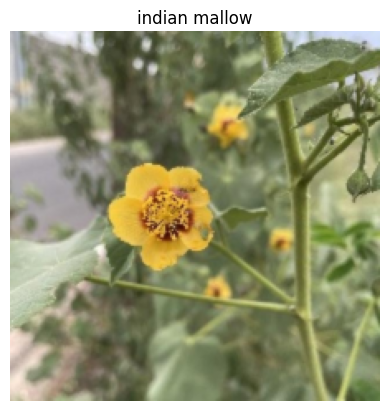

In [21]:
image_batch, label_batch = next(iter(train_dataloader))

image, label = image_batch[0], label_batch[0]

print(image.shape, label)

plt.imshow(image.permute(1, 2, 0))
plt.title(class_names[label])
plt.axis(False);

In [22]:
model = SwinTransformer(num_classes=len(class_names))

In [23]:
import torch
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [24]:
from going_modular import engine

device = "cuda" if torch.cuda.is_available() else "cpu"
device

optimizer = torch.optim.AdamW(params=model.parameters(),
                             lr=0.0001,
                             weight_decay=0.003)

loss_fn = torch.nn.CrossEntropyLoss()


def set_seeds(seed: int=42):
    """Sets random sets for torch operations.

    Args:
        seed (int, optional): Random seed to set. Defaults to 42.
    """
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)

set_seeds()


results = engine.train(model=model,
                       train_dataloader=train_dataloader,
                       test_dataloader=test_dataloader,
                       optimizer=optimizer,
                       loss_fn=loss_fn,
                       epochs=50,
                       device=device)

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.7760 | train_acc: 0.4060 | test_loss: 1.0812 | test_acc: 0.6748
Epoch: 2 | train_loss: 0.8102 | train_acc: 0.7081 | test_loss: 0.6251 | test_acc: 0.7427
Epoch: 3 | train_loss: 0.6010 | train_acc: 0.7830 | test_loss: 0.5310 | test_acc: 0.8084
Epoch: 4 | train_loss: 0.4070 | train_acc: 0.8574 | test_loss: 0.3091 | test_acc: 0.8810
Epoch: 5 | train_loss: 0.3198 | train_acc: 0.8820 | test_loss: 0.2542 | test_acc: 0.9169
Epoch: 6 | train_loss: 0.2527 | train_acc: 0.9107 | test_loss: 0.2304 | test_acc: 0.9137
Epoch: 7 | train_loss: 0.2544 | train_acc: 0.9120 | test_loss: 0.1917 | test_acc: 0.9318
Epoch: 8 | train_loss: 0.2393 | train_acc: 0.9167 | test_loss: 0.1560 | test_acc: 0.9375
Epoch: 9 | train_loss: 0.1788 | train_acc: 0.9345 | test_loss: 0.2947 | test_acc: 0.8810
Epoch: 10 | train_loss: 0.1417 | train_acc: 0.9510 | test_loss: 0.3473 | test_acc: 0.8899
Epoch: 11 | train_loss: 0.1400 | train_acc: 0.9549 | test_loss: 0.1569 | test_acc: 0.9375
Epoch: 12 | train_l

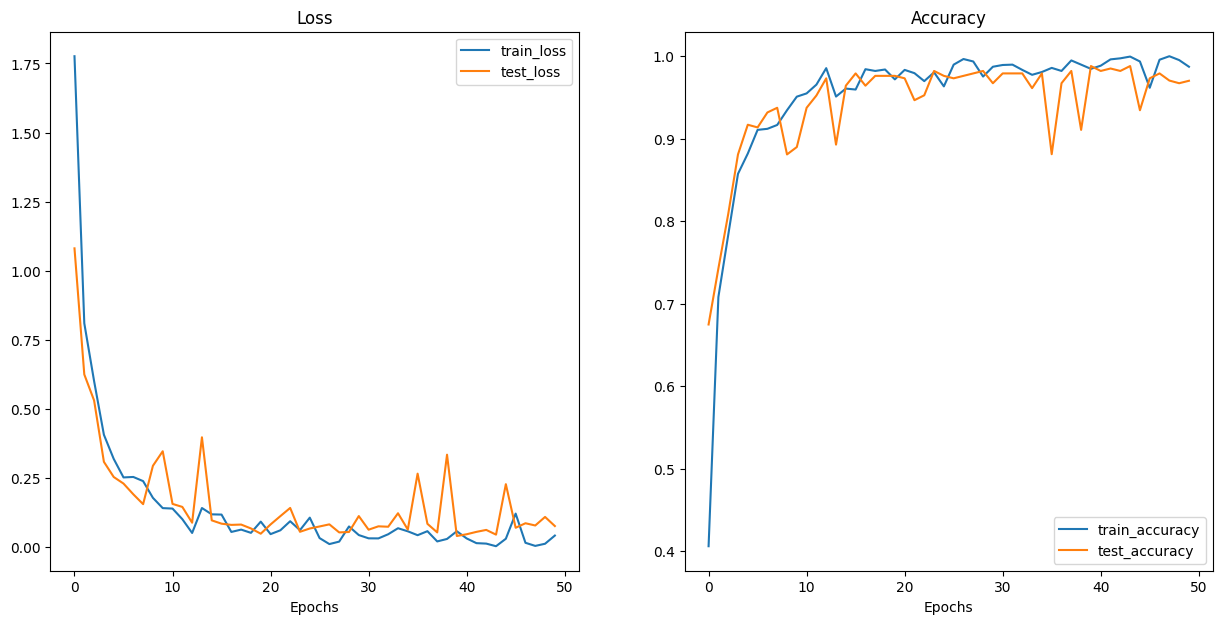

In [25]:
def plot_loss_curves(results):

    loss = results["train_loss"]
    test_loss = results["test_loss"]

    accuracy = results["train_acc"]
    test_accuracy = results["test_acc"]

    epochs = range(len(results["train_loss"]))

    plt.figure(figsize=(15, 7))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, label="train_loss")
    plt.plot(epochs, test_loss, label="test_loss")
    plt.title("Loss")
    plt.xlabel("Epochs")
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, accuracy, label="train_accuracy")
    plt.plot(epochs, test_accuracy, label="test_accuracy")
    plt.title("Accuracy")
    plt.xlabel("Epochs")
    plt.legend()
plot_loss_curves(results)

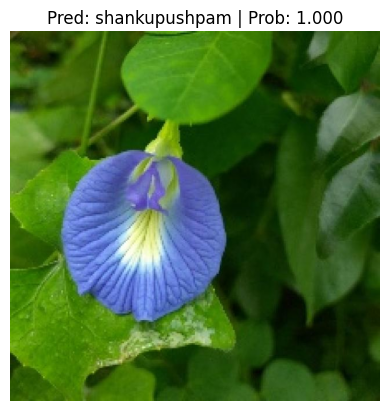

In [31]:
import requests
from PIL import Image
from going_modular.predictions import pred_and_plot_image

custom_image_path = '/content/drive/MyDrive/dataset/test/shankupushpam/shankupushpam167_jpg.rf.d5fe57efd1eaa92f8cfa5a4d6c26e708.jpg'
image = Image.open(custom_image_path)



if image.mode != 'RGB':
    image = image.convert('RGB')


pred_and_plot_image(model=model,
                    image_path=custom_image_path,
                    class_names=class_names)